In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import sys
import os

from datetime import datetime
import subprocess

os.environ['CUDA_VISIBLE_DEVICES']="0"


from keras.layers import Dense, Input, Dropout
from keras.models import Model

import omnifold8a as of

import tensorflow as tf


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print("\n\n")
print("  numpy version:  %s" % str(np.version.version) )
print("  tensorflow version:  %s" % str(tf.__version__))
print("\n\n")




  numpy version:  1.26.4
  tensorflow version:  2.13.1





## Set model and resolution parameters

In [3]:
ndim = 1

##-------------

train_mu = [ 0.0 ]



train_rho = [ [0.0] ]






train_sig = [ 1.0 ]


##-------------


true_mu = [ 0.2 ]






true_rho  = [ [0.0] ]



true_sig = [ 0.9 ]


#--- perfect
#resolution = [ 0.0001  ]

#--- good
#resolution = [ 0.25  ]

#--- nominal
#resolution = [ 0.5  ]

#--- medium bad
resolution = [ 0.75  ]

#--- poor
#resolution = [ 1.0  ]






train_cov = np.zeros( shape=(ndim,ndim) )
true_cov  = np.zeros( shape=(ndim,ndim) )

print("\n\n\n Train covariance:")

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            train_cov[i][j] = train_sig[i] * train_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, train_cov[i][j]))
        else :
            k = ndim - j - 1
            train_cov[i][j] = train_sig[i] * train_sig[j] * train_rho[i][k]
            train_cov[j][i] = train_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, train_sig[i], train_sig[j], train_rho[i][k], train_cov[i][j]))
            
            

print("\n\n\n True covariance:")  

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            true_cov[i][j] = true_sig[i] * true_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, true_cov[i][j]))
        else :
            k = ndim - j - 1
            true_cov[i][j] = true_sig[i] * true_sig[j] * true_rho[i][k]
            true_cov[j][i] = true_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, true_sig[i], true_sig[j], true_rho[i][k], true_cov[i][j]))
            
            
                

                
#-- about 10 seconds
#ngen_train = 10000
#ngen_true =   1000              

                
#-- about 62 seconds
#ngen_train = 100000
#ngen_true =    1000       


#-- about 37  (29 in of8a)  seconds
ngen_train = 100000
ngen_true =   10000

#-- about 47  (38 in of8a)  seconds
#ngen_train = 1000000
#ngen_true =   100000

#-- about 1   (56 seconds) minute
#ngen_train = 2000000
#ngen_true =   200000

#-- about 1:50  (1:48 in of8a)
#ngen_train = 4000000
#ngen_true =   400000

#-- about 5 min
#ngen_train = 10000000
#ngen_true =   1000000







of_niter = 5

#learning_rate_setval = 0.0005
#epochs_setval = 40

#learning_rate_setval = 0.0001
#epochs_setval = 10

#learning_rate_setval = 0.00002
#epochs_setval = 40

#learning_rate_setval = 0.0005
#epochs_setval = 10

#learning_rate_setval = 0.0010
#epochs_setval = 10

#learning_rate_setval = 0.0008
#epochs_setval = 10


#learning_rate_setval = 0.0005
#epochs_setval = 20


learning_rate_setval = 0.0005
epochs_setval = 40



#dropout_setval = 0.02

#dropout_setval = 0.10

dropout_setval = 0.0




do_bootstrap = False

n_boot_samples = 1000





batch_size_setval = int( ngen_true )



output_dir = 'bootstrap-toy-study8a-1d-1d-gpu0'

save_step2_model = True





 Train covariance:
   0,  0 : diagonal    1.0000



 True covariance:
   0,  0 : diagonal    0.8100


In [4]:
try:
    os.mkdir( output_dir )
except:
    print('\n\n Output directory already exists:  %s' % output_dir)
    #print('\n\n HALTING EXECUTION\n\n')
    #sys.exit()

In [5]:
print("\n\n")
print("Train covariance determinant:  %f" % np.linalg.det( train_cov ) )
print("True covariance determinant:   %f" % np.linalg.det( true_cov ) )
print("\n\n")




Train covariance determinant:  1.000000
True covariance determinant:   0.810000





In [6]:
train_cov_inv = np.linalg.inv( train_cov )

In [7]:
train_cov_inv_test = np.matmul( train_cov, train_cov_inv )

In [8]:
print("\n\n")
print(" Train covariance")
print( train_cov )
print("\n Train covariance inverse")
print( train_cov_inv )
print("\n Train covariance inverse test")
print(train_cov_inv_test)
print("\n\n")




 Train covariance
[[1.]]

 Train covariance inverse
[[1.]]

 Train covariance inverse test
[[1.]]





In [9]:
true_cov_inv = np.linalg.inv( true_cov )

In [10]:
true_cov_inv_test = np.matmul( true_cov, true_cov_inv )

In [11]:
print("\n\n")
print(" True covariance")
print( true_cov )
print("\n True covariance inverse")
print( true_cov_inv )
print("\n True covariance inverse test")
print(true_cov_inv_test)
print("\n\n")




 True covariance
[[0.81]]

 True covariance inverse
[[1.2345679]]

 True covariance inverse test
[[1.]]





## Generate samples, save events and config

In [12]:


train_pts = np.random.multivariate_normal(train_mu, train_cov, size=ngen_train)
true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)

train_det_pts = np.random.normal( train_pts, resolution )

true_det_pts = np.random.normal( true_pts, resolution )


true_pts10x = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true*40)
true_det_pts10x = np.random.normal( true_pts10x, resolution )
true_pts10x_weights = np.ones( ngen_true*40 )
true_pts10x_weights = (1./40.) * true_pts10x_weights


In [13]:
with open( '%s/train-and-true-samples.npy' % output_dir, 'wb') as f :
    np.save(f, train_pts)
    np.save(f, train_det_pts)
    np.save(f, true_pts)
    np.save(f, true_det_pts)

In [14]:
with open( '%s/config-pars.npy' % output_dir , 'wb' ) as f :
    np.save( f, train_mu )
    np.save( f, train_rho )
    np.save( f, train_sig )
    np.save( f, true_mu )
    np.save( f, true_rho )
    np.save( f, true_sig )
    np.save( f, resolution )
    np.save( f, train_cov )
    np.save( f, true_cov )

In [15]:
config_filename = '%s/config.txt' % output_dir

config_file = open( config_filename, 'w' )

config_file.write('%s\n\n' % datetime.now() )
config_file.write('ngen_train %d\n' % ngen_train )
config_file.write('ngen_true  %d\n' % ngen_true )
config_file.write('of_niter   %d\n' % of_niter )
config_file.write('ndim       %d\n' % ndim )
config_file.write('learning_rate_setval  %f\n' % learning_rate_setval )
config_file.write('epochs_setval  %d\n' % epochs_setval )
config_file.write('batch_size_setval  %d\n' % batch_size_setval )


config_file.write('\n\n')
config_file.write('train_mu : %s\n' % str(train_mu))
config_file.write('train_rho : %s\n' % str(train_rho))
config_file.write('train_sig : %s\n' % str(train_sig))
config_file.write('train_cov : %s\n' % str(train_cov))
config_file.write('\n\n')
config_file.write('true_mu : %s\n' % str(true_mu))
config_file.write('true_rho : %s\n' % str(true_rho))
config_file.write('true_sig : %s\n' % str(true_sig))
config_file.write('true_cov : %s\n' % str(true_cov))
config_file.write('\n\n')
config_file.write('resolution : %s\n' % str(resolution) )
config_file.close()

print('\n\n  Config file contents : %s\n' % config_filename )
print( subprocess.getoutput('cat %s' % config_filename ))
print('\n\n')





  Config file contents : bootstrap-toy-study8a-1d-1d-gpu0/config.txt

2024-07-10 10:59:43.900943

ngen_train 100000
ngen_true  10000
of_niter   5
ndim       1
learning_rate_setval  0.000500
epochs_setval  40
batch_size_setval  10000


train_mu : [0.0]
train_rho : [[0.0]]
train_sig : [1.0]
train_cov : [[1.]]


true_mu : [0.2]
true_rho : [[0.0]]
true_sig : [0.9]
true_cov : [[0.81]]


resolution : [0.75]





## Plots to visualize these parameter choices

<function matplotlib.pyplot.show(close=None, block=None)>

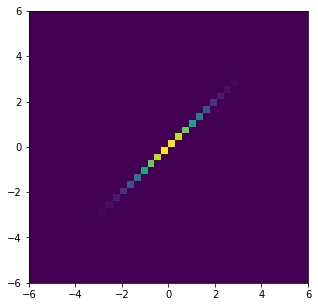

In [16]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if ndim > 1 :
            thisax = ax[i][j]
        else :
            thisax = ax
            
        thisax.hist2d( train_pts[:,i], train_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

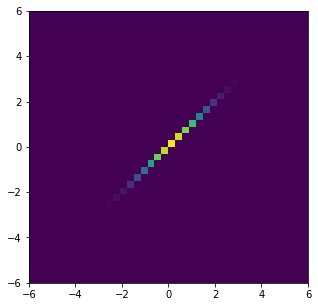

In [17]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if ndim > 1 :
            thisax = ax[i][j]
        else :
            thisax = ax
        thisax.hist2d( true_pts[:,i], true_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

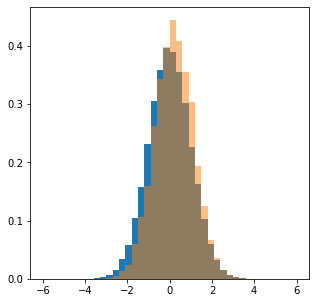

In [18]:
fig,ax = plt.subplots( 1, ndim, figsize=(ndim*5,5))

hmin=-6
hmax=6
hbins=40


for i in range(ndim) :
        k = i*3 + j
        if ndim > 1 :
            thisax = ax[i]
        else :
            thisax = ax
        thisax.hist( train_pts[:,i],bins=hbins, range=[hmin,hmax], density=True )
        thisax.hist( true_pts[:,i],bins=hbins, range=[hmin,hmax], density=True, alpha=0.5 )
    
plt.show

### Calculate true weights analytically and compare with unfolding output weights.

In [19]:
train_pts_minus_train_mu = train_pts - train_mu
print(train_pts_minus_train_mu)

[[ 0.35037207]
 [-0.50182761]
 [ 1.51729913]
 ...
 [-0.03250053]
 [ 0.80779018]
 [ 0.38985829]]


In [20]:
train_pts_minus_true_mu = train_pts - true_mu
print(train_pts_minus_true_mu)

[[ 0.15037207]
 [-0.70182761]
 [ 1.31729913]
 ...
 [-0.23250053]
 [ 0.60779018]
 [ 0.18985829]]


In [21]:
true_cov_inv_times_v = np.tensordot( true_cov_inv, train_pts_minus_true_mu.T, axes=(1,0) )

In [22]:
v_times_true_cov_inv_times_v =  np.sum( train_pts_minus_true_mu.T * true_cov_inv_times_v, axis=0)

In [23]:
train_cov_inv_times_v = np.tensordot( train_cov_inv, train_pts_minus_train_mu.T, axes=(1,0) )

In [24]:
v_times_train_cov_inv_times_v =  np.sum( train_pts_minus_train_mu.T * train_cov_inv_times_v, axis=0)

In [25]:
exp_v_times_train_cov_inv_times_v = np.exp( -0.5 * v_times_train_cov_inv_times_v )
exp_v_times_true_cov_inv_times_v  = np.exp( -0.5 * v_times_true_cov_inv_times_v  )

In [26]:
true_cov_det = np.linalg.det( true_cov )
train_cov_det = np.linalg.det( train_cov )

In [27]:
norm2_true = np.power( 3.14159265, ndim) * true_cov_det
print("\n norm2_true : %f\n" % norm2_true )


 norm2_true : 2.544690



In [28]:
norm2_train = np.power( 3.14159265, ndim) * train_cov_det
print("\n norm2_train : %f\n" % norm2_train )


 norm2_train : 3.141593



In [29]:
pdf_train = exp_v_times_train_cov_inv_times_v / np.sqrt(norm2_train)
print(pdf_train)

[0.53060085 0.49743996 0.17844707 ... 0.56389169 0.40712809 0.5229028 ]


In [30]:
pdf_true = exp_v_times_true_cov_inv_times_v / np.sqrt(norm2_true)
print(pdf_true)

[0.61818822 0.46252483 0.21477527 ... 0.60630469 0.49905718 0.61308288]


In [31]:
pdf_ratio = pdf_true / pdf_train

In [32]:
sample_sf = (1.*len(true_pts))/(1.*len(train_pts))
print('\n sample_sf = %f' % sample_sf )


 sample_sf = 0.100000


In [33]:
calc_weight = pdf_ratio

In [34]:
calc_weight_scaled = sample_sf * pdf_ratio

## Set up NN model for OmniFold

In [35]:

import tensorflow.keras.backend as K


def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss

    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

    t_loss = -weights * ((y_true) * K.log(y_pred) +
                         (1 - y_true) * K.log(1 - y_pred))

    return K.mean(t_loss)

In [36]:


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(50, activation='relu')(inputs)
#hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
#hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_3)


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(20, activation='relu')(inputs)
#hidden_layer_2 = Dense(20, activation='relu')(hidden_layer_1)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_2)


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(50, activation='relu')(inputs)
#hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_2)


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(50, activation='relu')(inputs)
#hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
#hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
#hidden_layer_4 = Dense(50, activation='relu')(hidden_layer_3)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_4)

#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(50, activation='relu')(inputs)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_1)


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(20, activation='relu')(inputs)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_1)


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(200, activation='relu')(inputs)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_1)

#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(150, activation='relu')(inputs)
#hidden_layer_2 = Dense(150, activation='relu')(hidden_layer_1)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_2)


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(50, activation='relu')(inputs)
#hidden_layer_2 = Dense(10, activation='relu')(hidden_layer_1)
#hidden_layer_3 = Dense(5, activation='relu')(hidden_layer_2)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_3)


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(5, activation='relu')(inputs)
#hidden_layer_2 = Dense(10, activation='relu')(hidden_layer_1)
#hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_3)


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(30, activation='relu')(inputs)
#hidden_layer_2 = Dense(40, activation='relu')(hidden_layer_1)
#hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_3)


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(20, activation='relu')(inputs)
#hidden_layer_2 = Dense(20, activation='relu')(hidden_layer_1)
#hidden_layer_3 = Dense(20, activation='relu')(hidden_layer_2)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_3)



inputs = Input((ndim, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
drop1 = Dropout(dropout_setval)(hidden_layer_1)
hidden_layer_2 = Dense(50, activation='relu')(drop1)
drop2 = Dropout(dropout_setval)(hidden_layer_2)
hidden_layer_3 = Dense(50, activation='relu')(drop2)
drop3 = Dropout(dropout_setval)(hidden_layer_3)
outputs = Dense(1, activation='sigmoid')(drop3)








model_step1 = Model(inputs=inputs, outputs=outputs)
model_step2 = Model(inputs=inputs, outputs=outputs)

opt_step1 = tf.keras.optimizers.Adam( learning_rate=learning_rate_setval )
opt_step2 = tf.keras.optimizers.Adam( learning_rate=(0.04*learning_rate_setval) )  # owen: use lower learning rate in step 2

model_step1.compile(loss=weighted_binary_crossentropy,
                      optimizer=opt_step1,
                      metrics=['accuracy'])

model_step2.compile(loss=weighted_binary_crossentropy,
                      optimizer=opt_step2,
                      metrics=['accuracy'])


## Package the training data for OmniFold

In [37]:
train_both = np.stack([train_pts, train_det_pts], axis=1)

## Run OmniFold

In [38]:
%%time


#verbose = True
verbose = False






of_return_dict = of.omnifold8a( 
    train_both, true_det_pts, of_niter, model_step1, model_step2, verbose, 
    batch_size_setval, epochs_setval,
    save_step2_model, output_dir
)

of_weights = of_return_dict["weights"]

mc_weight_sf = (1.*len(true_det_pts))/(1.*len(train_both))

push_weights = of_return_dict["push_weights"]
push_weights_scaled = np.copy( push_weights )
push_weights_scaled = mc_weight_sf * push_weights

final_push_weights = of_return_dict["final_push_weights"]
final_push_weights_scaled = np.copy(final_push_weights)
final_push_weights_scaled = mc_weight_sf * final_push_weights

with open( '%s/omnifold-output-weights.npy' % output_dir, 'wb') as f :
    np.save(f, final_push_weights_scaled)


 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0721947  0.94509941 1.14219892 ... 1.00270283 1.12038779 1.07712209]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1067504  0.92530643 1.20001453 ... 1.00307135 1.19708659 1.11347592]
10/10 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14966817 0.89018517 1.21529129 ... 1.00123706 1.24908145 1.15702616]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16302285 0.89562353 1.21774676 ... 0.99305748 1.27976392 1.16670128]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/of-step2-iter04-model/assets


CPU times: user 33.5 s, sys: 6.65 s, total: 40.2 s
Wall time: 27.8 s


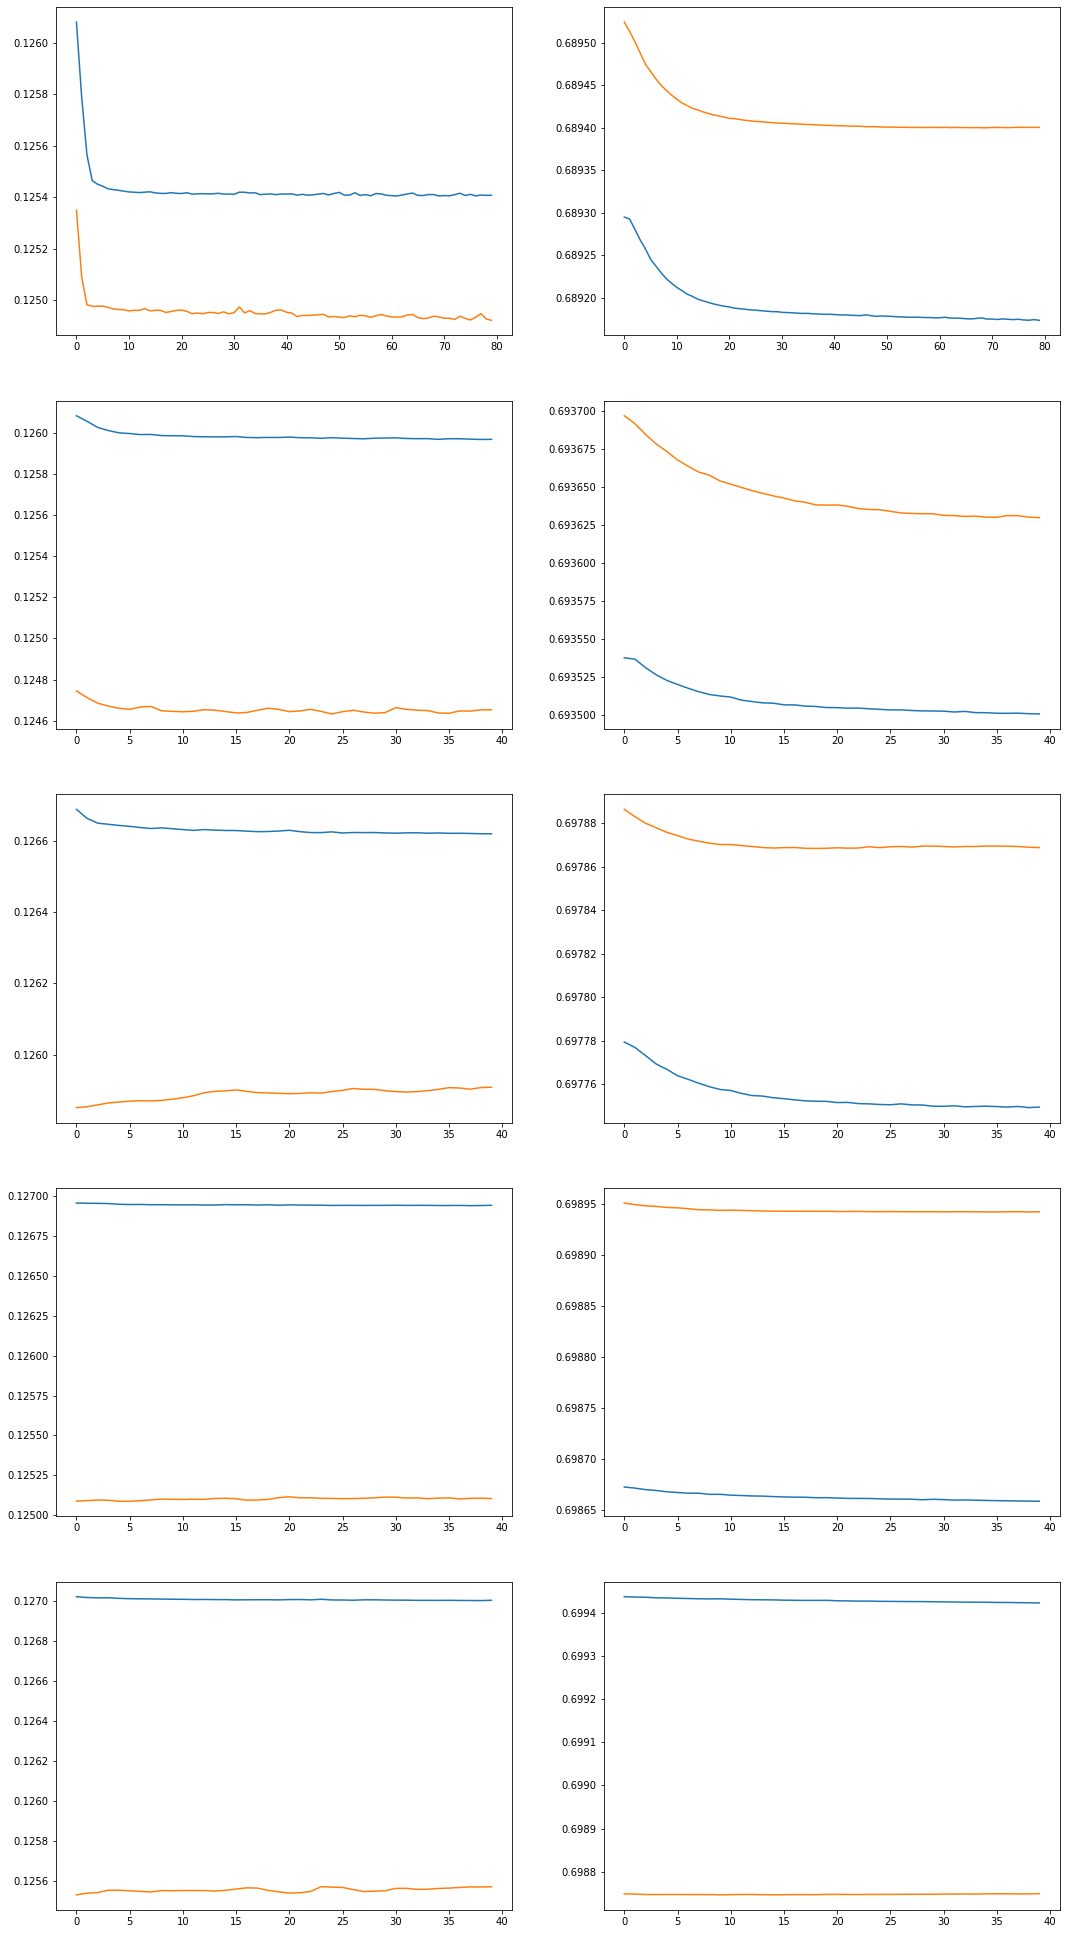

In [39]:
fig,ax = plt.subplots( of_niter, 2, figsize=(18,7*of_niter))

for ofi in range(0,of_niter) :
    
    ax[ofi][0].plot( of_return_dict['train-hist-step1-iter%d' % ofi].history['loss']  )
    ax[ofi][0].plot( of_return_dict['train-hist-step1-iter%d' % ofi].history['val_loss']  )

    ax[ofi][1].plot( of_return_dict['train-hist-step2-iter%d' % ofi].history['loss']  )
    ax[ofi][1].plot( of_return_dict['train-hist-step2-iter%d' % ofi].history['val_loss']  )
    



<function matplotlib.pyplot.show(close=None, block=None)>

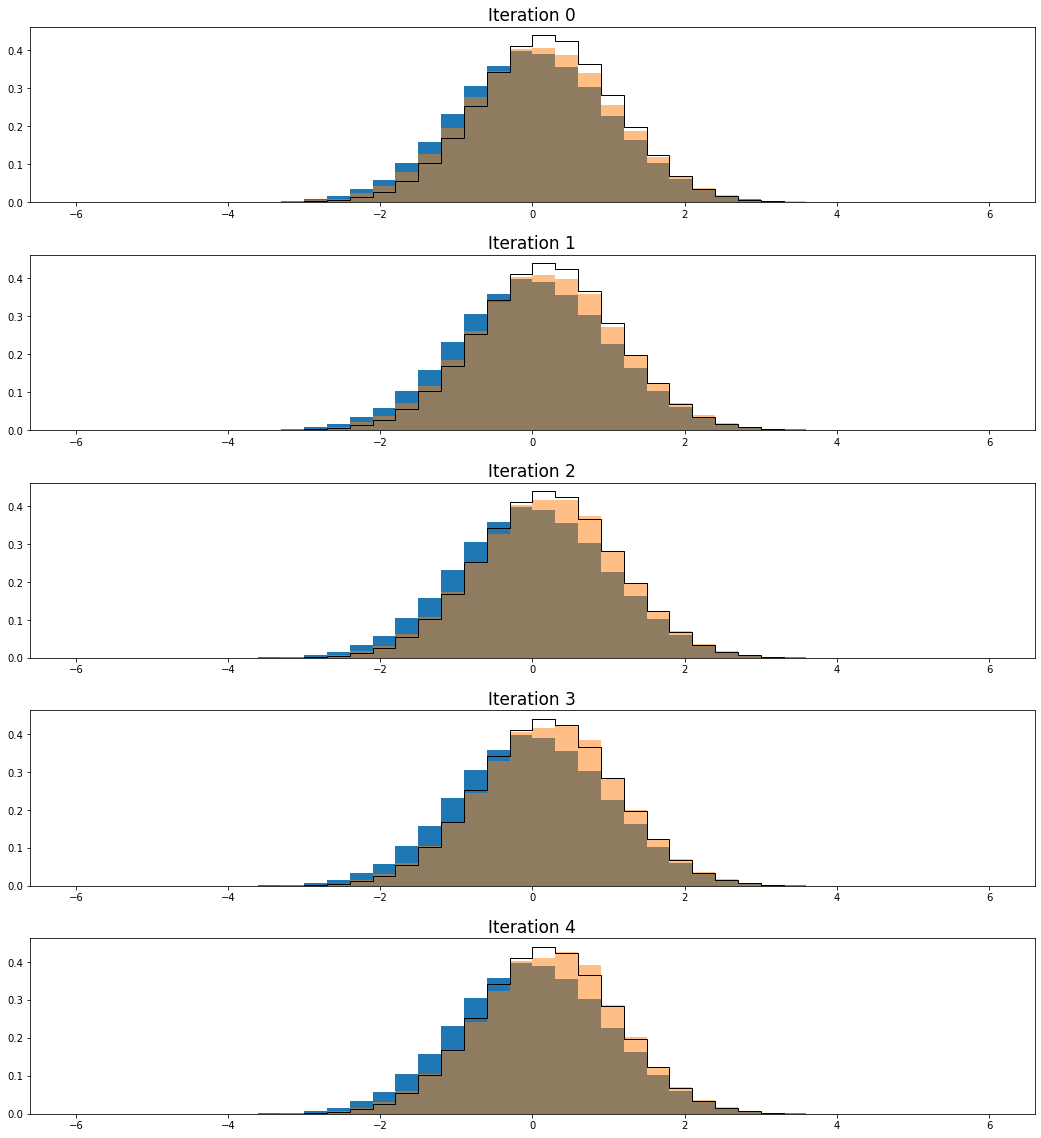

In [40]:


fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
            
            thisax.hist( train_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )            
            hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    else :
        
        for di in range(ndim) :

            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
                
            hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )            
            hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
#    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
#    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
 
    if ndim > 1 :
        thisax = ax[ofi][0]
    else :
        thisax = ax[ofi]
        
    thisax.set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [41]:
hist_data_diff = hist_data_mc_ofweighted - hist_data_truth
hist_data_diff2 = hist_data_diff * hist_data_diff

hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        hist_data_sum_diff2[ofi,di] = np.sum( hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

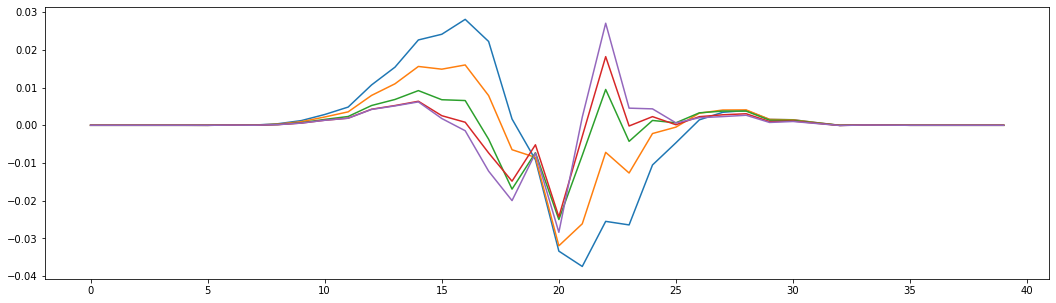

In [42]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim > 1 :
            thisax = ax[di]
        else :
            thisax = ax
        thisax.plot(hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

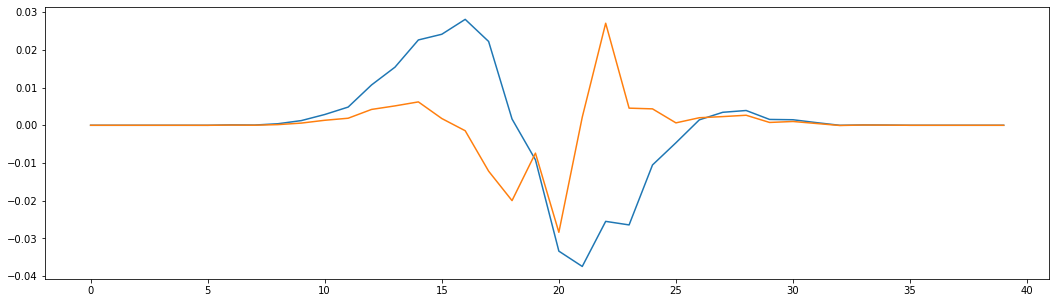

In [43]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(hist_data_diff[ofi,di])
    
plt.show  

<function matplotlib.pyplot.show(close=None, block=None)>

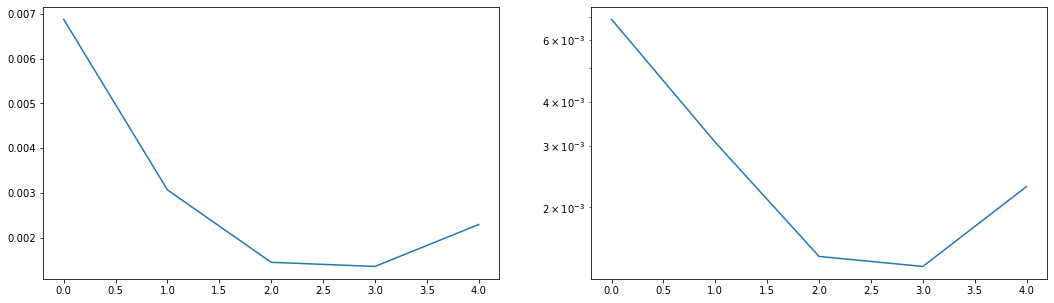

In [44]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( hist_data_sum_diff2)
ax[1].plot( hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

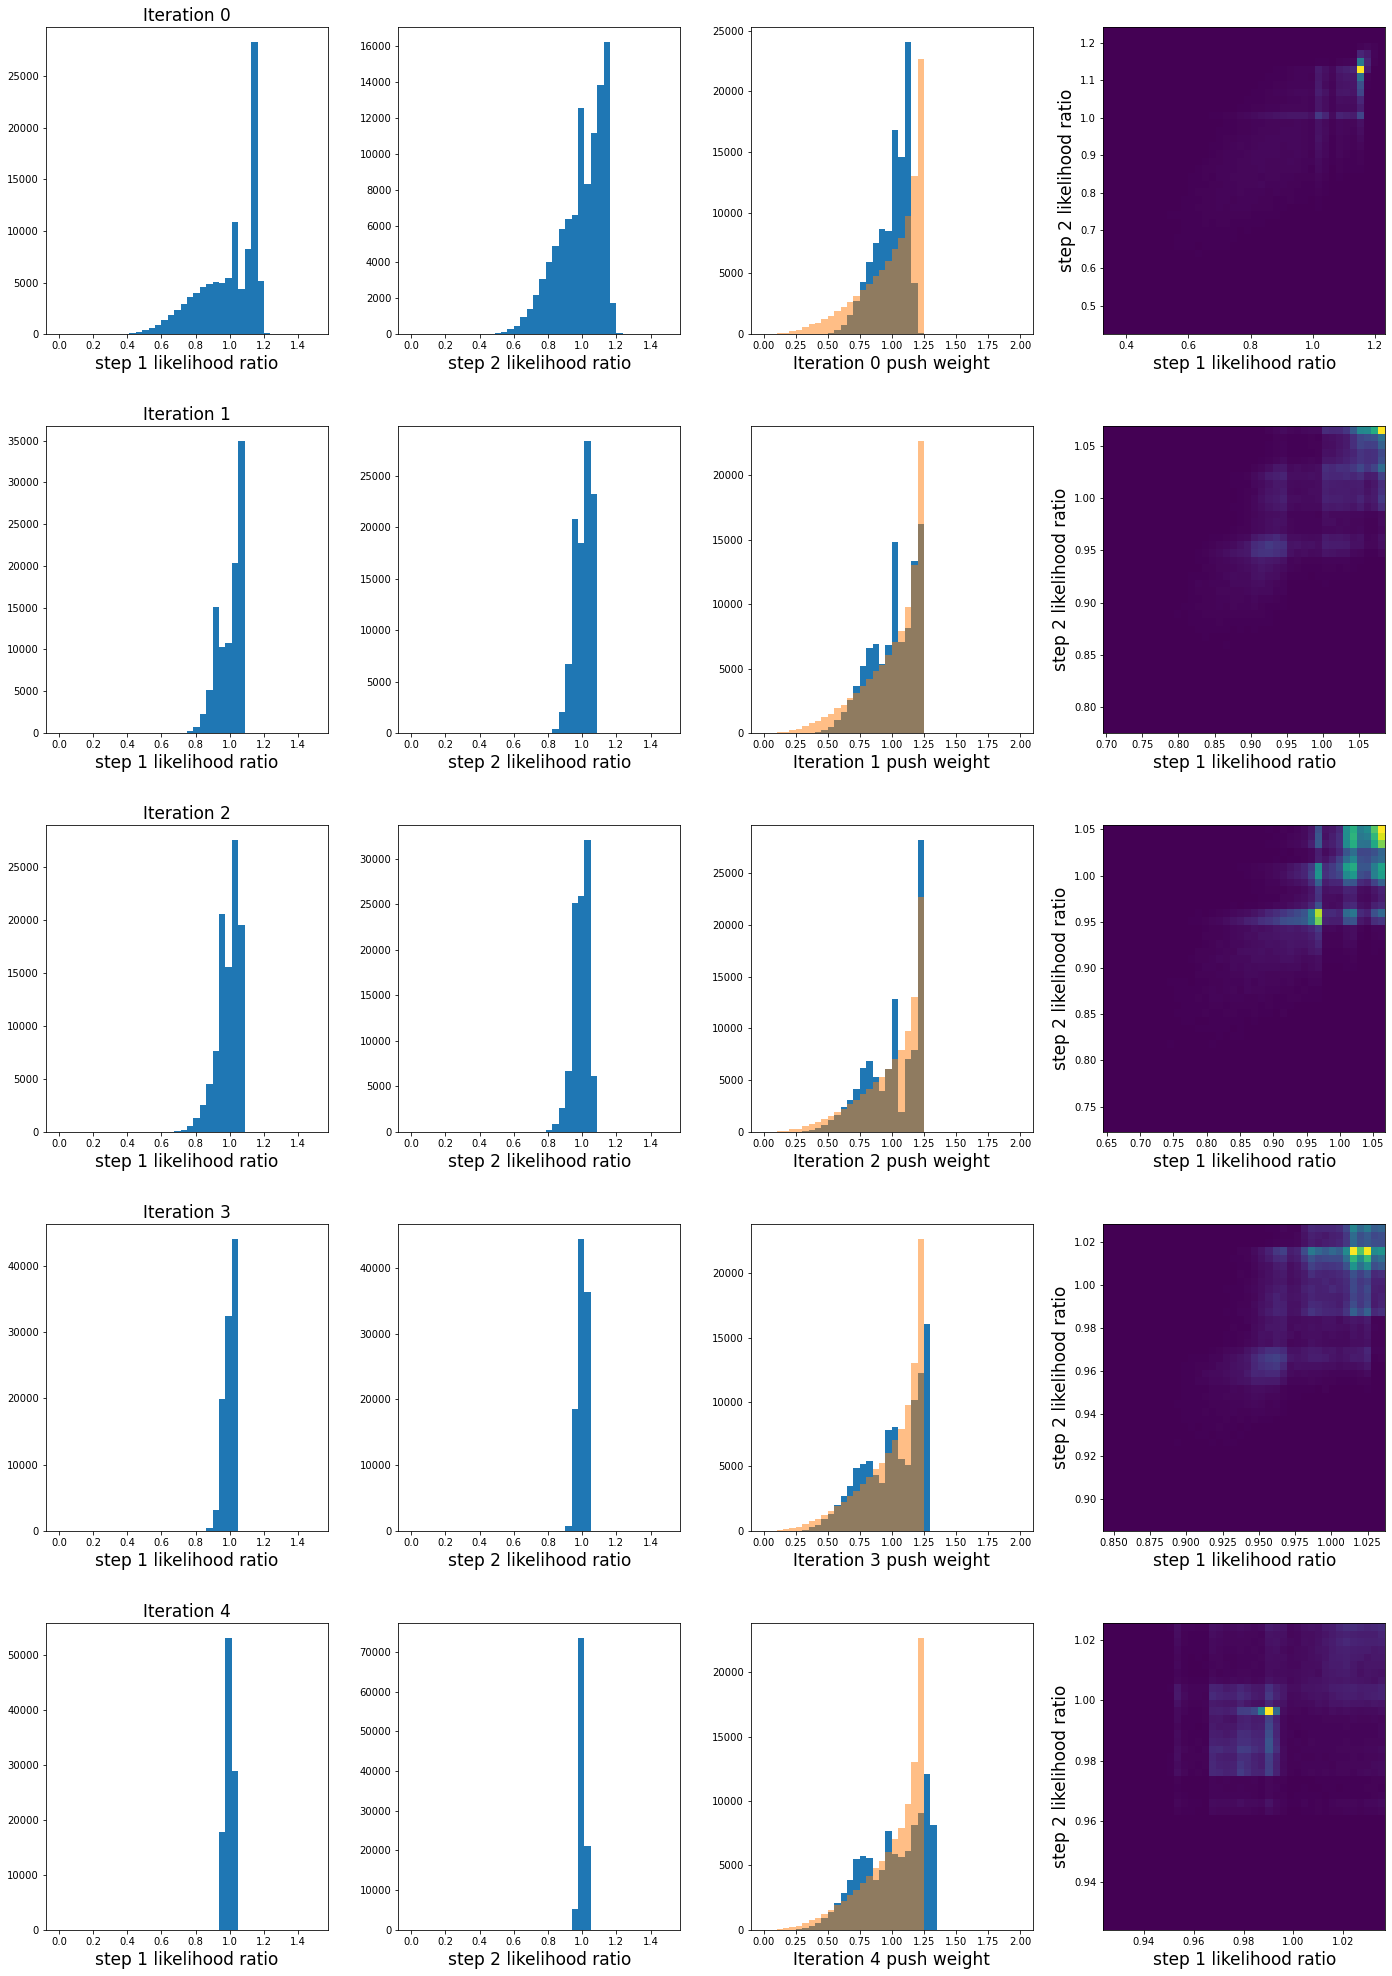

In [45]:
fig,ax = plt.subplots( of_niter, 4, figsize=(24,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

for ofi in range(0,of_niter) :

    ax[ofi][0].hist( of_weights[ofi,0,:], bins=hbins, range=[0.,1.5] )
    
    ax[ofi][1].hist( of_weights[ofi,1,:], bins=hbins, range=[0.,1.5] )
    
    ax[ofi][2].hist( push_weights[ofi,:], bins=hbins, range=[0.,2.0] )
    ax[ofi][2].hist( calc_weight, bins=hbins, range=[0.,2.0], alpha=0.5 )
    
    
    ax[ofi][3].hist2d( of_weights[ofi,0,:], of_weights[ofi,1,:], bins=[hbins,hbins] )
    
    ax[ofi][0].set_xlabel( 'step 1 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel( 'step 2 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][3].set_xlabel( 'step 1 likelihood ratio', fontsize=lfontsize )
    ax[ofi][3].set_ylabel( 'step 2 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][2].set_xlabel( 'Iteration %d push weight' % ofi, fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )
    
    
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

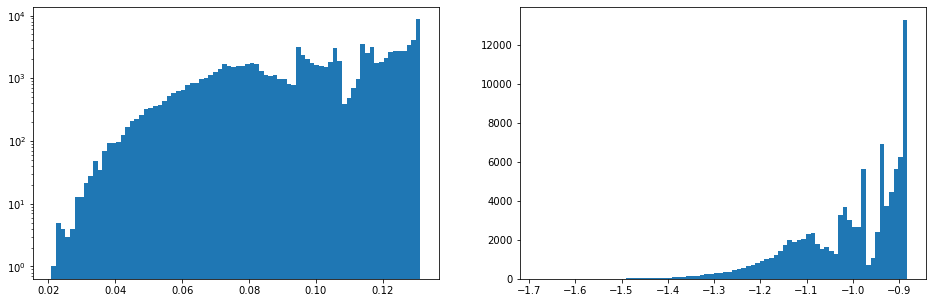

In [46]:
fig,ax = plt.subplots( 1, 2, figsize=(8*2,5))

hbins=80

ax[0].hist( final_push_weights_scaled, bins=hbins)
ax[0].set_yscale('log')

ax[1].hist( np.log10(final_push_weights_scaled), bins=hbins)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

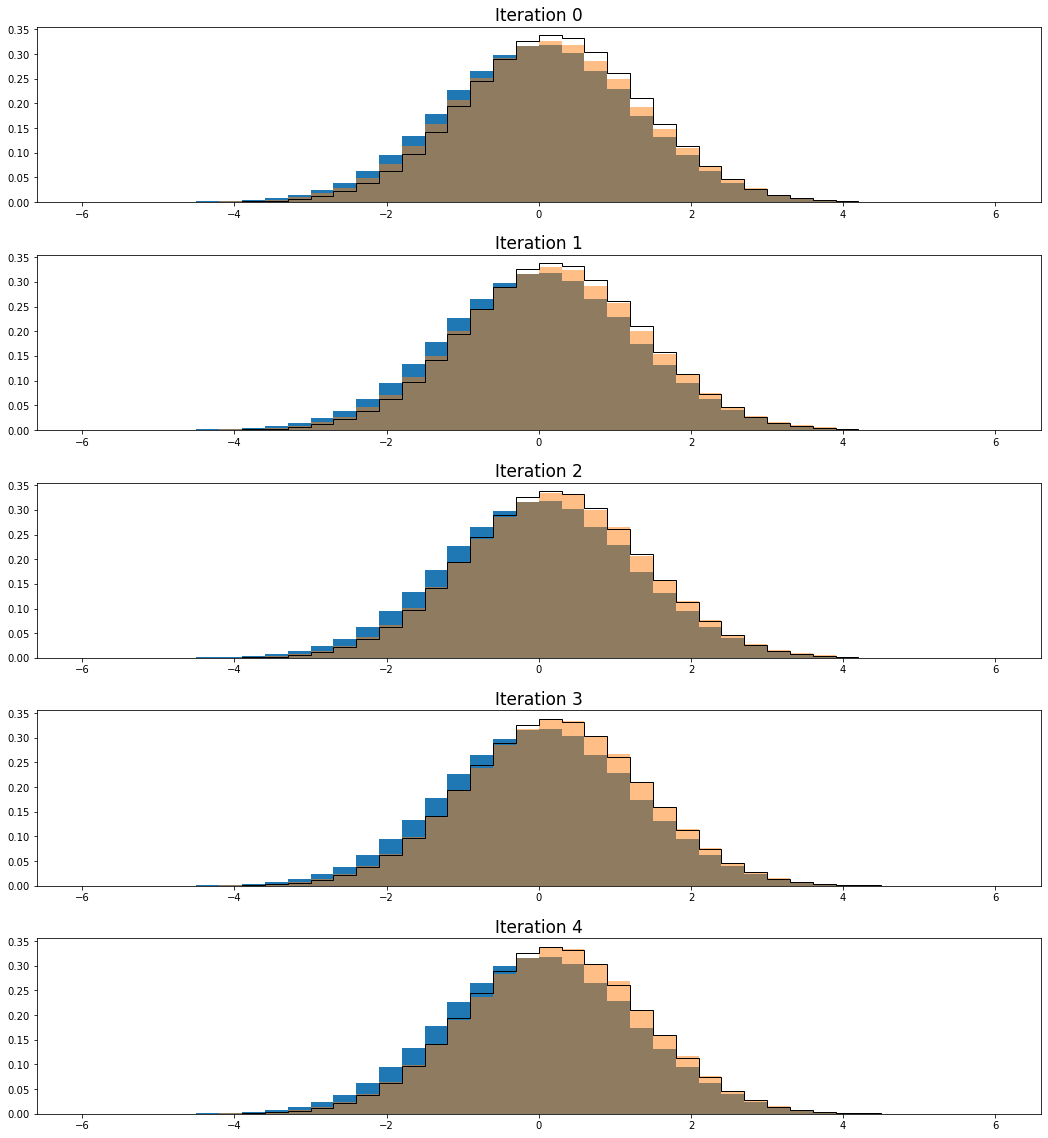

In [47]:

fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

det_hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
det_hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
            
            thisax.hist( train_det_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            det_hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_det_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    else :
        
        for di in range(ndim) :

            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
        
            det_hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_det_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
#    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
#    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
    
    if ndim > 1 :
        thisax = ax[ofi][0]
    else :
        thisax = ax[ofi]
    
    thisax.set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [48]:
det_hist_data_diff = det_hist_data_mc_ofweighted - det_hist_data_truth
det_hist_data_diff2 = det_hist_data_diff * det_hist_data_diff

det_hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        det_hist_data_sum_diff2[ofi,di] = np.sum( det_hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

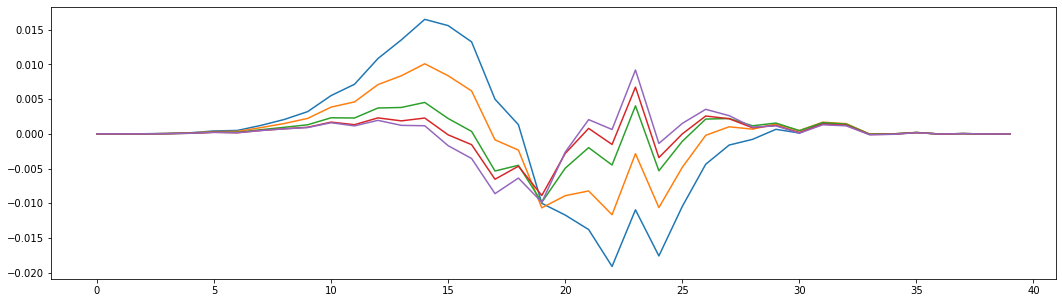

In [49]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim > 1 :
            thisax = ax[di]
        else :
            thisax = ax
        thisax.plot(det_hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

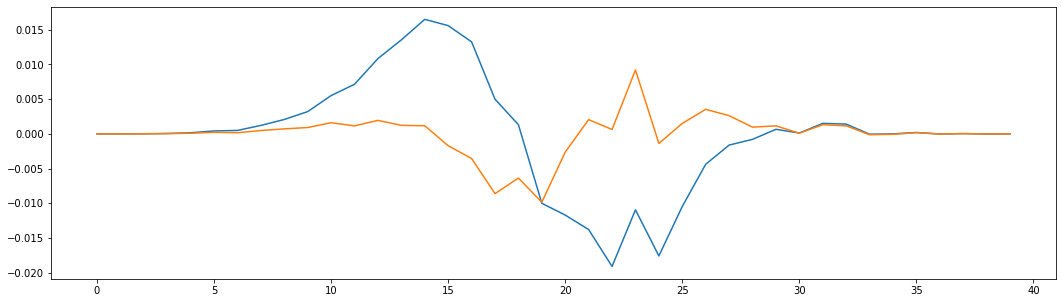

In [50]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(det_hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(det_hist_data_diff[ofi,di])

    
plt.show  

<function matplotlib.pyplot.show(close=None, block=None)>

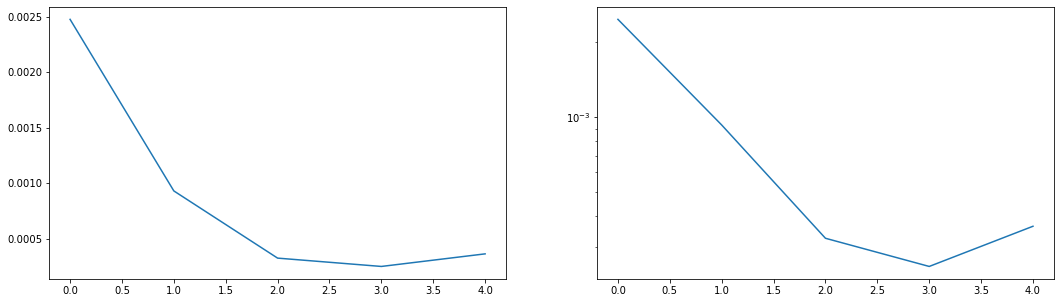

In [51]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( det_hist_data_sum_diff2)
ax[1].plot( det_hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

In [52]:
step1_mean = np.zeros( of_niter )
step1_rms = np.zeros( of_niter )

step2_mean = np.zeros( of_niter )
step2_rms = np.zeros( of_niter )

iter_val = np.zeros( of_niter )

for ofi in range( of_niter ) :
    
    iter_val[ofi] = ofi
    
    step1_mean[ofi] = np.mean( of_weights[ofi,0,:] )
    step1_rms[ofi] = np.sqrt( np.var( of_weights[ofi,0,:]))
    
    step2_mean[ofi] = np.mean( of_weights[ofi,1,:] )
    step2_rms[ofi] = np.sqrt( np.var( of_weights[ofi,1,:]))
    
    print("  iter %2d : step 1 mean  %.3f  rms %.3f      step 2 mean  %.3f  rms %.3f" % 
          (ofi, step1_mean[ofi], step1_rms[ofi], step2_mean[ofi], step2_rms[ofi]) )

  iter  0 : step 1 mean  0.995  rms 0.167      step 2 mean  0.996  rms 0.131
  iter  1 : step 1 mean  1.003  rms 0.070      step 2 mean  1.005  rms 0.049
  iter  2 : step 1 mean  0.992  rms 0.062      step 2 mean  0.993  rms 0.046
  iter  3 : step 1 mean  0.998  rms 0.030      step 2 mean  0.999  rms 0.022
  iter  4 : step 1 mean  0.996  rms 0.022      step 2 mean  0.998  rms 0.016


<function matplotlib.pyplot.show(close=None, block=None)>

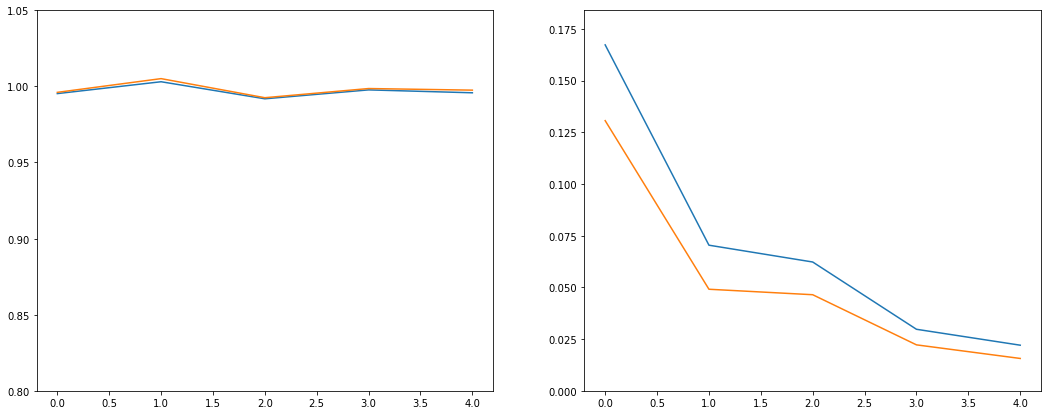

In [53]:
fig,ax = plt.subplots( 1, 2, figsize=(18,7))

ax[0].plot( iter_val, step1_mean )
ax[0].plot( iter_val, step2_mean )
ax[0].set_ylim( 0.80, 1.05)

ax[1].plot( iter_val, step1_rms )
ax[1].plot( iter_val, step2_rms )
ax[1].set_ylim( 0, 1.1*np.max(step1_rms))


plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

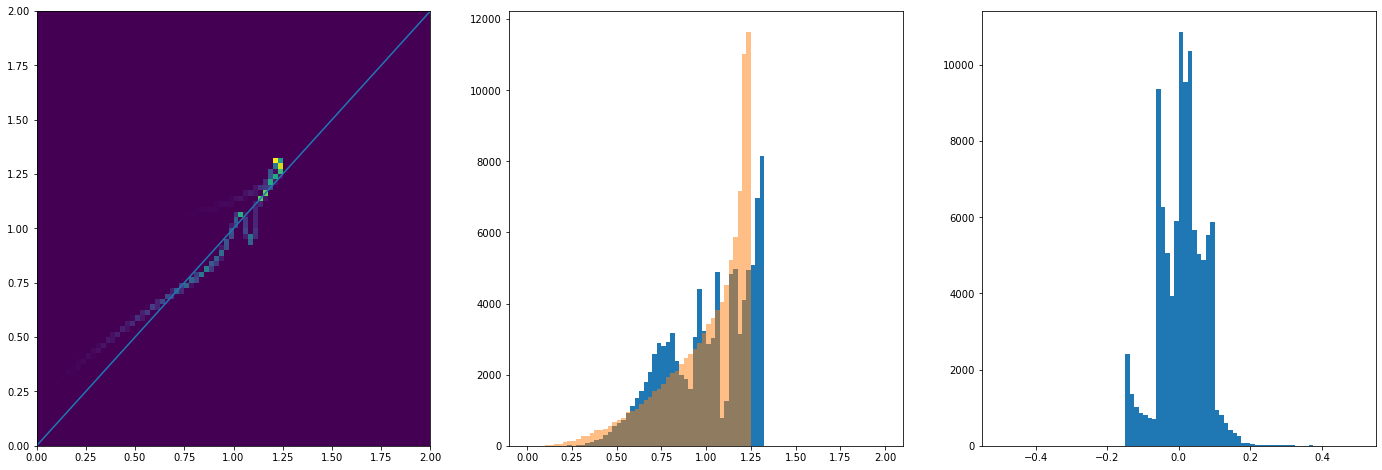

In [54]:
fig,ax = plt.subplots( 1, 3, figsize=(3*8,1*8))
max_weight = 2.0

ax[0].hist2d( calc_weight, final_push_weights, bins=[80,80], range=([0,max_weight],[0,max_weight]))
ax[0].plot([0,max_weight],[0,max_weight])

ax[1].hist( final_push_weights, bins=80, range=[0,max_weight] )
ax[1].hist( calc_weight, bins=80, range=[0,max_weight], alpha=0.5 )

ax[2].hist( final_push_weights-calc_weight, bins=80, range=[-0.5,0.5] )

plt.show

In [55]:

delta_weight_rms = np.sqrt( np.var( np.clip(final_push_weights-calc_weight,-0.5,0.5 ) ) )
print('\n\n Delta weight RMS:  %.5f\n\n' % delta_weight_rms )



 Delta weight RMS:  0.06242




In [56]:

verbose = False



import gc

In [57]:
try:
    os.mkdir( "%s/bootstrap-nn-models" % output_dir )
except :
    print('problem creating bootstrap-nn-models dir')


In [58]:
%%time

rng = np.random.default_rng()

for bi in range(0,n_boot_samples) :
    
    if do_bootstrap :
        print("\n Creating bootstrap sample %3d" % bi )
        boot_true_det_pts = rng.choice( true_det_pts, size=len(true_det_pts) )
        
    else :
        print("\n Creating toy sample %3d" % bi )
        boot_true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)
        boot_true_det_pts = np.random.normal( boot_true_pts, resolution )
        
    modeldir = "%s/bootstrap-nn-models/bs-%03d" % (output_dir, bi) 
    
    try:
        os.mkdir( modeldir )
    except :
        print('\n\n *** probelm creating model output directory : %s' % modeldir )

        

    #-- Reset the model to ensure fresh random weights for each bootstrap

    inputs = Input((ndim, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    drop1 = Dropout(dropout_setval)(hidden_layer_1)
    hidden_layer_2 = Dense(50, activation='relu')(drop1)
    drop2 = Dropout(dropout_setval)(hidden_layer_2)
    hidden_layer_3 = Dense(50, activation='relu')(drop2)
    drop3 = Dropout(dropout_setval)(hidden_layer_3)
    outputs = Dense(1, activation='sigmoid')(drop3)


    model_step1 = Model(inputs=inputs, outputs=outputs)
    model_step2 = Model(inputs=inputs, outputs=outputs)

    opt_step1 = tf.keras.optimizers.Adam( learning_rate=learning_rate_setval )
    opt_step2 = tf.keras.optimizers.Adam( learning_rate=(0.04*learning_rate_setval) )  # owen: use lower learning rate in step 2

    model_step1.compile(loss=weighted_binary_crossentropy,
                          optimizer=opt_step1,
                          metrics=['accuracy'])

    model_step2.compile(loss=weighted_binary_crossentropy,
                          optimizer=opt_step2,
                          metrics=['accuracy'])
        
        
        
        
        
    boot_of_return_dict = of.omnifold8a( 
        train_both, boot_true_det_pts, of_niter, model_step1, model_step2, verbose, 
        batch_size_setval, epochs_setval, True, modeldir )



    mc_weight_sf = (1.*len(boot_true_det_pts))/(1.*len(train_both))



    boot_final_push_weights = boot_of_return_dict["final_push_weights"]
    boot_final_push_weights_scaled = boot_final_push_weights
    boot_final_push_weights_scaled = mc_weight_sf * boot_final_push_weights
    
    print("\n\n bootstrap %d final push weights scaled:" % bi)
    print( boot_final_push_weights_scaled )

     
    with open( '%s/bootstrap-weights-%03d.npy' % ( output_dir, bi ), 'wb' ) as f :
        np.save( f, boot_final_push_weights_scaled )

    with open( '%s/bootstrap-points-%03d.npy' % ( output_dir, bi ), 'wb' ) as f :
        np.save( f, boot_true_det_pts )
        
        
    del boot_final_push_weights_scaled
    del boot_of_return_dict
    gc.collect()
    
    


 Creating toy sample   0
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-000/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-000/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-000/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09385049 0.94933301 1.15986025 ... 1.00932109 1.11941242 1.09604061]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-000/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-000/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-000/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12630478 0.90202405 1.19589005 ... 0.99903291 1.15129615 1.12760789]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-000/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-000/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-000/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15724503 0.89777357 1.22501174 ... 1.00764877 1.18336308 1.15860438]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-000/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-000/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-000/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17343191 0.88842142 1.23678096 ... 0.99097956 1.19743601 1.1744937 ]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-000/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-000/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-000/of-step2-iter04-model/assets




 bootstrap 0 final push weights scaled:
[0.1185423  0.0876058  0.11989613 ... 0.09525693 0.11911066 0.1185365 ]

 Creating toy sample   1
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-001/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-001/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-001/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08616602 0.96288937 1.15601337 ... 1.0335139  1.11327815 1.08865249]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-001/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-001/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-001/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12788548 0.95039212 1.20168788 ... 1.04199924 1.16602404 1.13134838]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-001/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-001/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-001/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13696007 0.94591507 1.20740265 ... 1.05547506 1.17928542 1.14060432]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-001/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-001/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-001/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1522182  0.94672933 1.21487194 ... 1.07357726 1.18674764 1.1509854 ]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-001/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-001/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-001/of-step2-iter04-model/assets




 bootstrap 1 final push weights scaled:
[0.11564698 0.09451943 0.12074247 ... 0.10647583 0.11901799 0.1153959 ]

 Creating toy sample   2
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-002/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-002/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-002/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08229196 0.96843916 1.13589501 ... 1.04121435 1.12841332 1.08727062]
10/10 [==============================] - 0s 803us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-002/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-002/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-002/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12445494 0.96190302 1.17599294 ... 1.06902534 1.19010325 1.13242226]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-002/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-002/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-002/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14154842 0.97033511 1.16999669 ... 1.08132487 1.2003841  1.14954695]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-002/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-002/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-002/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15770203 0.97153973 1.16766301 ... 1.08725187 1.22199474 1.16626967]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-002/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-002/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-002/of-step2-iter04-model/assets




 bootstrap 2 final push weights scaled:
[0.11874784 0.09742378 0.11603869 ... 0.11005162 0.12418104 0.11974426]

 Creating toy sample   3
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-003/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-003/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-003/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09617102 0.95999491 1.15561831 ... 1.03969955 1.11577964 1.09806728]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-003/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-003/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-003/of-step2-iter01-model/assets


 weights_push at the beginning
[1.15465995 0.94360511 1.20663141 ... 1.05015554 1.15996546 1.15538648]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-003/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-003/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-003/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16638974 0.91571729 1.21432982 ... 1.02953815 1.16263949 1.16558078]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-003/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-003/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-003/of-step2-iter03-model/assets


 weights_push at the beginning
[1.20049777 0.93652499 1.2024484  ... 1.04551398 1.16482836 1.19258436]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-003/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-003/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-003/of-step2-iter04-model/assets




 bootstrap 3 final push weights scaled:
[0.11892768 0.0945404  0.1163866  ... 0.1034372  0.1138299  0.11807981]

 Creating toy sample   4
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-004/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-004/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-004/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06931841 0.95190448 1.16635144 ... 0.9922685  1.11493707 1.07453108]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-004/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-004/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-004/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11995273 0.95007042 1.2139309  ... 1.02272177 1.16453089 1.12459294]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-004/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-004/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-004/of-step2-iter02-model/assets


 weights_push at the beginning
[1.141365   0.95930179 1.2071662  ... 1.04362765 1.16756056 1.14512305]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-004/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-004/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-004/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16487558 0.95047755 1.18417278 ... 1.03442988 1.17790667 1.16872318]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-004/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-004/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-004/of-step2-iter04-model/assets




 bootstrap 4 final push weights scaled:
[0.11718314 0.09504857 0.11905496 ... 0.10284925 0.11915078 0.11765985]

 Creating toy sample   5
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-005/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-005/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-005/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09458613 0.96966213 1.11991775 ... 1.01905763 1.11384535 1.0963515 ]
10/10 [==============================] - 0s 612us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-005/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-005/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-005/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12563709 0.95348799 1.18007933 ... 1.03529759 1.16746871 1.12928881]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-005/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-005/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-005/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14000671 0.95145379 1.16569242 ... 1.05917732 1.19356826 1.14448666]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-005/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-005/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-005/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13506411 0.94986787 1.15353393 ... 1.06851175 1.19723222 1.1386252 ]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-005/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-005/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-005/of-step2-iter04-model/assets




 bootstrap 5 final push weights scaled:
[0.11289311 0.09544735 0.11376688 ... 0.10603421 0.11991099 0.11323348]

 Creating toy sample   6
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-006/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-006/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-006/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10925305 0.9513073  1.14602554 ... 1.00940895 1.13628364 1.11905503]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-006/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-006/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-006/of-step2-iter01-model/assets


 weights_push at the beginning
[1.17873489 0.93652817 1.22384389 ... 1.01587481 1.20648226 1.18988149]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-006/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-006/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-006/of-step2-iter02-model/assets


 weights_push at the beginning
[1.17797048 0.91484261 1.18887189 ... 0.99031593 1.18597456 1.18559182]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-006/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-006/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-006/of-step2-iter03-model/assets


 weights_push at the beginning
[1.22626644 0.92792267 1.17747999 ... 0.98062593 1.20177354 1.23410626]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-006/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-006/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-006/of-step2-iter04-model/assets




 bootstrap 6 final push weights scaled:
[0.12328385 0.09240539 0.11780632 ... 0.09477363 0.12027341 0.12398173]

 Creating toy sample   7
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 781us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-007/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-007/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-007/of-step2-iter00-model/assets


 weights_push at the beginning
[1.11175537 0.9667989  1.1314714  ... 1.01035321 1.12776554 1.11348557]
10/10 [==============================] - 0s 791us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-007/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-007/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-007/of-step2-iter01-model/assets


 weights_push at the beginning
[1.17556389 0.94810322 1.15927096 ... 1.0140513  1.17848845 1.17624017]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-007/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-007/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-007/of-step2-iter02-model/assets


 weights_push at the beginning
[1.19368389 0.93323836 1.13987324 ... 1.00389587 1.18022108 1.19218613]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-007/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-007/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-007/of-step2-iter03-model/assets


 weights_push at the beginning
[1.21956395 0.94124863 1.15490888 ... 0.99923889 1.19883494 1.21702694]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-007/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-007/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-007/of-step2-iter04-model/assets




 bootstrap 7 final push weights scaled:
[0.12101512 0.09247804 0.11432338 ... 0.09469834 0.1186632  0.12070433]

 Creating toy sample   8
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-008/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-008/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-008/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0693332  0.94793808 1.15861726 ... 1.03959513 1.12498021 1.07397091]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-008/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-008/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-008/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08220952 0.92671103 1.18673655 ... 1.06074826 1.160129   1.08997382]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-008/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-008/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-008/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08175295 0.9184684  1.18533996 ... 1.08109044 1.17287083 1.091236  ]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-008/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-008/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-008/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08651797 0.94324663 1.1884321  ... 1.10560795 1.19844435 1.09870343]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-008/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-008/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-008/of-step2-iter04-model/assets




 bootstrap 8 final push weights scaled:
[0.10702791 0.09247025 0.11734179 ... 0.11169339 0.1189453  0.10816886]

 Creating toy sample   9
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-009/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-009/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-009/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07688546 1.00237989 1.10248733 ... 0.97760528 1.10285151 1.08090174]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-009/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-009/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-009/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12494229 1.00031219 1.14778263 ... 0.93864725 1.17490793 1.13164581]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-009/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-009/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-009/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16254735 1.00221667 1.17389512 ... 0.89249602 1.20786347 1.16943367]
10/10 [==============================] - 0s 618us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-009/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-009/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-009/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18495622 1.02275919 1.17653367 ... 0.86172241 1.22561136 1.1927568 ]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-009/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-009/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-009/of-step2-iter04-model/assets




 bootstrap 9 final push weights scaled:
[0.11800588 0.10280579 0.11446614 ... 0.0828946  0.12177884 0.11889757]

 Creating toy sample  10
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-010/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-010/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-010/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05866754 0.97725093 1.151896   ... 0.99749076 1.09504437 1.06242108]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-010/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-010/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-010/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09419987 0.97849594 1.19272891 ... 1.01782678 1.13026288 1.09592735]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-010/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-010/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-010/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11796869 0.97633111 1.24738159 ... 1.02982651 1.16623572 1.11792283]
10/10 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-010/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-010/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-010/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14256675 0.97135472 1.2310842  ... 1.02920747 1.17276981 1.13985294]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-010/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-010/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-010/of-step2-iter04-model/assets




 bootstrap 10 final push weights scaled:
[0.11439833 0.0970635  0.12024371 ... 0.10242671 0.11523662 0.11380767]

 Creating toy sample  11
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-011/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-011/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-011/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09227824 0.96974814 1.13898253 ... 0.99282396 1.12617946 1.1064353 ]
10/10 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-011/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-011/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-011/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1039729  0.96985288 1.18781932 ... 0.95828245 1.16363295 1.1244869 ]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-011/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-011/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-011/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13041934 0.99564807 1.21930685 ... 0.95407553 1.19219011 1.15529626]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-011/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-011/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-011/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13283647 1.01645048 1.19090501 ... 0.94754637 1.19236577 1.16367995]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-011/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-011/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-011/of-step2-iter04-model/assets




 bootstrap 11 final push weights scaled:
[0.11685105 0.1038184  0.12298093 ... 0.09360521 0.12260641 0.11997876]

 Creating toy sample  12
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-012/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-012/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-012/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05538154 0.95370519 1.16795409 ... 1.02320981 1.10871148 1.05856073]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-012/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-012/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-012/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08493322 0.93672614 1.24286035 ... 1.05821    1.1812306  1.09021808]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-012/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-012/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-012/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09746764 0.93898247 1.22983867 ... 1.07991448 1.21071628 1.10334186]
10/10 [==============================] - 0s 810us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-012/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-012/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-012/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08633415 0.92462558 1.25294984 ... 1.09296919 1.23432757 1.09375428]
10/10 [==============================] - 0s 959us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-012/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-012/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-012/of-step2-iter04-model/assets




 bootstrap 12 final push weights scaled:
[0.10666715 0.09125925 0.12696289 ... 0.11120236 0.12426746 0.10744851]

 Creating toy sample  13
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-013/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-013/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-013/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09853125 0.96558762 1.10051358 ... 1.00070786 1.11130726 1.0997957 ]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-013/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-013/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-013/of-step2-iter01-model/assets


 weights_push at the beginning
[1.16342933 0.95216044 1.16758468 ... 1.00084481 1.18769734 1.16772414]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-013/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-013/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-013/of-step2-iter02-model/assets


 weights_push at the beginning
[1.18235477 0.94185514 1.12725046 ... 0.98464466 1.19656294 1.18628373]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-013/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-013/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-013/of-step2-iter03-model/assets


 weights_push at the beginning
[1.19250695 0.94301407 1.16582092 ... 0.95060834 1.21697037 1.19339441]
10/10 [==============================] - 0s 779us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-013/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-013/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-013/of-step2-iter04-model/assets




 bootstrap 13 final push weights scaled:
[0.12069674 0.09262384 0.11448605 ... 0.09095262 0.12215279 0.12078316]

 Creating toy sample  14
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-014/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-014/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-014/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0535382  0.96018964 1.13587105 ... 1.03020763 1.0971185  1.05824876]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-014/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-014/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-014/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08440923 0.96832845 1.21325526 ... 1.04837963 1.16123956 1.09247687]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-014/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-014/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-014/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06074573 0.94809153 1.19039758 ... 1.04267083 1.13930746 1.07020376]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-014/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-014/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-014/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08509319 0.98777106 1.20855551 ... 1.07718908 1.18504894 1.09708463]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-014/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-014/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-014/of-step2-iter04-model/assets




 bootstrap 14 final push weights scaled:
[0.10776474 0.10021891 0.12240986 ... 0.10786381 0.11879741 0.10900762]

 Creating toy sample  15
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-015/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-015/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-015/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09076893 0.98125917 1.14723551 ... 1.02533388 1.13129234 1.09419966]
10/10 [==============================] - 0s 781us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-015/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-015/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-015/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12934903 0.95462216 1.19675275 ... 1.0328681  1.17253688 1.13294401]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-015/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-015/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-015/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1324735  0.93996656 1.19447676 ... 1.04288907 1.17388266 1.13638217]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-015/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-015/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-015/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15794947 0.92731586 1.21542487 ... 1.06207296 1.19419014 1.16281144]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-015/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-015/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-015/of-step2-iter04-model/assets




 bootstrap 15 final push weights scaled:
[0.11826973 0.09315648 0.12319246 ... 0.10897863 0.1205816  0.11842116]

 Creating toy sample  16
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-016/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-016/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-016/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08083689 0.95944053 1.16716301 ... 0.99965298 1.12841547 1.0847218 ]
10/10 [==============================] - 0s 768us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-016/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-016/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-016/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13065241 0.95054496 1.18004373 ... 1.01922047 1.17127721 1.13647718]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-016/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-016/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-016/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14312144 0.95702288 1.21367198 ... 1.02804883 1.19803996 1.15168195]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-016/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-016/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-016/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13632876 0.94159161 1.19181538 ... 1.01714045 1.1871677  1.14366002]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-016/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-016/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-016/of-step2-iter04-model/assets




 bootstrap 16 final push weights scaled:
[0.11669401 0.09590759 0.11960508 ... 0.10286742 0.12040266 0.11732736]

 Creating toy sample  17
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-017/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-017/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-017/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08874893 0.95235872 1.14109969 ... 1.02070248 1.12007427 1.0926708 ]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-017/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-017/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-017/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11150471 0.92185361 1.16819136 ... 1.03192903 1.15128921 1.11807486]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-017/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-017/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-017/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13818259 0.91038792 1.1627285  ... 1.04802942 1.17420984 1.14705473]
10/10 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-017/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-017/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-017/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15684266 0.90563945 1.16487776 ... 1.04901091 1.18874712 1.16700161]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-017/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-017/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-017/of-step2-iter04-model/assets




 bootstrap 17 final push weights scaled:
[0.11705482 0.0885402  0.11768574 ... 0.10603759 0.12096986 0.11839958]

 Creating toy sample  18
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-018/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-018/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-018/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08600926 0.94039381 1.14218831 ... 0.99827397 1.11173749 1.08911252]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-018/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-018/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-018/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13241972 0.92426326 1.21247273 ... 1.01754909 1.1774652  1.13737886]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-018/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-018/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-018/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15512385 0.91453838 1.20601636 ... 1.03020458 1.1993228  1.15956482]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-018/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-018/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-018/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17868361 0.90590851 1.21778021 ... 1.03069201 1.22715914 1.18287746]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-018/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-018/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-018/of-step2-iter04-model/assets




 bootstrap 18 final push weights scaled:
[0.1179266  0.08968972 0.12112286 ... 0.10129105 0.12296497 0.11833398]

 Creating toy sample  19
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-019/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-019/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-019/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09613645 0.97035408 1.17661619 ... 1.02561605 1.13327312 1.10014307]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-019/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-019/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-019/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1154378  0.94549351 1.18945354 ... 1.03063152 1.1569118  1.12062998]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-019/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-019/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-019/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14393298 0.97261192 1.20087546 ... 1.07168486 1.18304166 1.14875993]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-019/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-019/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-019/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1420593  0.96446034 1.18053378 ... 1.06379447 1.18130834 1.14829884]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-019/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-019/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-019/of-step2-iter04-model/assets




 bootstrap 19 final push weights scaled:
[0.11742187 0.0966347  0.11921949 ... 0.10817909 0.11918402 0.1177497 ]

 Creating toy sample  20
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-020/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-020/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-020/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08259237 0.96383375 1.08229041 ... 0.97125304 1.09703302 1.08484805]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-020/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-020/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-020/of-step2-iter01-model/assets


 weights_push at the beginning
[1.16104004 0.97192164 1.15624169 ... 0.96051584 1.17565613 1.16437129]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-020/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-020/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-020/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1902422  0.97757212 1.16568792 ... 0.93597128 1.20746634 1.19425882]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-020/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-020/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-020/of-step2-iter03-model/assets


 weights_push at the beginning
[1.22094491 0.98716604 1.16175533 ... 0.89649619 1.23337734 1.22380761]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-020/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-020/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-020/of-step2-iter04-model/assets




 bootstrap 20 final push weights scaled:
[0.12068305 0.09783379 0.11472001 ... 0.08255508 0.12285668 0.12092387]

 Creating toy sample  21
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-021/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-021/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-021/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07747877 0.97088844 1.18387961 ... 0.99164653 1.13717902 1.08311284]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-021/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-021/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-021/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1354096  0.9743422  1.23647785 ... 1.00263022 1.19586868 1.14075175]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-021/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-021/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-021/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12340705 0.95422932 1.21129809 ... 0.9634679  1.20680364 1.13267126]
10/10 [==============================] - 0s 797us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-021/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-021/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-021/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13967666 0.98535305 1.21745868 ... 0.96056346 1.23520607 1.1488729 ]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-021/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-021/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-021/of-step2-iter04-model/assets




 bootstrap 21 final push weights scaled:
[0.11554277 0.10064066 0.12172538 ... 0.09586436 0.12497975 0.11632343]

 Creating toy sample  22
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-022/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-022/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-022/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10415936 0.95715255 1.1846565  ... 1.01966918 1.14659894 1.11109102]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-022/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-022/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-022/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13465658 0.93714508 1.19144632 ... 1.026955   1.17733193 1.1462003 ]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-022/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-022/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-022/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15837998 0.94448239 1.1906285  ... 1.03944186 1.19138928 1.17337563]
10/10 [==============================] - 0s 782us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-022/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-022/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-022/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17855474 0.93852317 1.2088057  ... 1.03558153 1.22112541 1.19780562]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-022/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-022/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-022/of-step2-iter04-model/assets




 bootstrap 22 final push weights scaled:
[0.11818277 0.09355525 0.12266697 ... 0.10296676 0.12320552 0.1204792 ]

 Creating toy sample  23
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-023/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-023/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-023/of-step2-iter00-model/assets


 weights_push at the beginning
[1.12134242 0.98383677 1.20823479 ... 1.03474879 1.15902507 1.12452328]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-023/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-023/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-023/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13541112 0.94926236 1.18381071 ... 0.99917035 1.15054779 1.13663664]
10/10 [==============================] - 0s 807us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-023/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-023/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-023/of-step2-iter02-model/assets


 weights_push at the beginning
[1.2004719  0.97636519 1.1881993  ... 1.02491546 1.18188437 1.1978813 ]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-023/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-023/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-023/of-step2-iter03-model/assets


 weights_push at the beginning
[1.20942828 0.98117159 1.16135174 ... 0.99512347 1.16019714 1.20394696]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-023/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-023/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-023/of-step2-iter04-model/assets




 bootstrap 23 final push weights scaled:
[0.12372604 0.09952791 0.11492101 ... 0.09822207 0.11595871 0.12290539]

 Creating toy sample  24
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-024/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-024/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-024/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07019544 0.94379133 1.18009627 ... 1.01790535 1.13320446 1.0754087 ]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-024/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-024/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-024/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07612867 0.93318137 1.21844648 ... 1.03426055 1.17102208 1.08404301]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-024/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-024/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-024/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07393289 0.954568   1.20574777 ... 1.04718528 1.19118306 1.08652057]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-024/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-024/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-024/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06937803 0.96619131 1.19367434 ... 1.05990052 1.20565017 1.08616626]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-024/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-024/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-024/of-step2-iter04-model/assets




 bootstrap 24 final push weights scaled:
[0.1049692  0.0968496  0.11991848 ... 0.10525293 0.12279353 0.10666277]

 Creating toy sample  25
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-025/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-025/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-025/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06914127 0.97473145 1.16564822 ... 1.00024056 1.11665428 1.07600689]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-025/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-025/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-025/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09526374 0.98103758 1.22089633 ... 1.00740951 1.15814573 1.10442845]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-025/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-025/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-025/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11010474 0.97129849 1.23117714 ... 0.99101495 1.17341343 1.12048495]
10/10 [==============================] - 0s 616us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-025/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-025/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-025/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11811219 0.98636028 1.25746735 ... 0.99550987 1.18481211 1.12706979]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-025/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-025/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-025/of-step2-iter04-model/assets




 bootstrap 25 final push weights scaled:
[0.11041101 0.09978889 0.12424031 ... 0.09934997 0.11808313 0.11115929]

 Creating toy sample  26
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-026/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-026/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-026/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07180834 0.95484644 1.17466581 ... 1.00959229 1.11777031 1.07602358]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-026/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-026/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-026/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08692948 0.93904145 1.21099239 ... 1.01847541 1.1559094  1.09387866]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-026/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-026/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-026/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10828814 0.93834433 1.26264452 ... 1.02225885 1.18905464 1.11570614]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-026/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-026/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-026/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09000885 0.94291904 1.24763003 ... 1.02781103 1.172474   1.09409914]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-026/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-026/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-026/of-step2-iter04-model/assets




 bootstrap 26 final push weights scaled:
[0.10974563 0.0953643  0.12443914 ... 0.10280553 0.11785267 0.11003891]

 Creating toy sample  27
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-027/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-027/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-027/of-step2-iter00-model/assets


 weights_push at the beginning
[1.11394811 1.00248671 1.15476918 ... 1.05437231 1.13852274 1.11863923]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-027/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-027/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-027/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1263677  0.96401476 1.17884027 ... 1.0453279  1.16543828 1.13075854]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-027/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-027/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-027/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16138569 0.96969374 1.20318378 ... 1.06401795 1.19672903 1.16570815]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-027/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-027/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-027/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18292792 0.98195183 1.19300866 ... 1.06890538 1.19069653 1.18429699]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-027/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-027/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-027/of-step2-iter04-model/assets




 bootstrap 27 final push weights scaled:
[0.11761675 0.0991518  0.11596917 ... 0.10889817 0.11778129 0.11762973]

 Creating toy sample  28
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-028/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-028/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-028/of-step2-iter00-model/assets


 weights_push at the beginning
[1.11980176 0.96871293 1.16172373 ... 0.99015999 1.1289767  1.12082112]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-028/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-028/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-028/of-step2-iter01-model/assets


 weights_push at the beginning
[1.17991386 0.96192671 1.24768492 ... 0.97547834 1.19370956 1.18089882]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-028/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-028/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-028/of-step2-iter02-model/assets


 weights_push at the beginning
[1.19608206 0.94928244 1.2271887  ... 0.95404815 1.18323954 1.1948142 ]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-028/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-028/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-028/of-step2-iter03-model/assets


 weights_push at the beginning
[1.22201155 0.96394094 1.22326785 ... 0.95963407 1.17627116 1.21642669]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-028/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-028/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-028/of-step2-iter04-model/assets




 bootstrap 28 final push weights scaled:
[0.12394684 0.09450278 0.1173944  ... 0.09356064 0.11518663 0.12322594]

 Creating toy sample  29
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-029/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-029/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-029/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06582892 0.94249946 1.12818444 ... 1.004655   1.11754155 1.07221496]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-029/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-029/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-029/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11028657 0.93134365 1.21944308 ... 1.01368978 1.19510754 1.12059202]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-029/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-029/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-029/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13004236 0.92115435 1.22196552 ... 1.00194576 1.22167026 1.14522162]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-029/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-029/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-029/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13493212 0.92432632 1.20452267 ... 0.98171564 1.2134666  1.15324018]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-029/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-029/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-029/of-step2-iter04-model/assets




 bootstrap 29 final push weights scaled:
[0.11423505 0.09539145 0.12160197 ... 0.09776023 0.12285408 0.11621913]

 Creating toy sample  30
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-030/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-030/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-030/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08225346 0.95044678 1.20749068 ... 1.04482865 1.14294624 1.08874428]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-030/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-030/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-030/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11470155 0.92066369 1.23950356 ... 1.05526983 1.20030278 1.12349215]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-030/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-030/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-030/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14097061 0.92483645 1.26851173 ... 1.08053736 1.24823829 1.14862907]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-030/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-030/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-030/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1416481  0.91452838 1.25117908 ... 1.08793904 1.24329272 1.14732566]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-030/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-030/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-030/of-step2-iter04-model/assets




 bootstrap 30 final push weights scaled:
[0.11321617 0.08893291 0.12527555 ... 0.10794845 0.12444431 0.11373527]

 Creating toy sample  31
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-031/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-031/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-031/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06348646 0.94658375 1.13142824 ... 0.98002017 1.09547663 1.06907797]
10/10 [==============================] - 0s 813us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-031/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-031/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-031/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08633188 0.95856324 1.17997403 ... 0.9976707  1.13855259 1.09365109]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-031/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-031/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-031/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11255593 0.95686765 1.21505841 ... 0.99665151 1.17282002 1.12095166]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-031/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-031/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-031/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10246309 0.96333128 1.21779238 ... 0.99203099 1.17637514 1.11219002]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-031/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-031/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-031/of-step2-iter04-model/assets




 bootstrap 31 final push weights scaled:
[0.11281796 0.09872587 0.12263491 ... 0.0992751  0.11988486 0.11396417]

 Creating toy sample  32
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-032/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-032/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-032/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09770477 0.94881409 1.13581312 ... 1.02129138 1.13272619 1.10504746]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-032/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-032/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-032/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14153139 0.93061799 1.17080332 ... 1.03696538 1.17230433 1.15110147]
10/10 [==============================] - 0s 796us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-032/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-032/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-032/of-step2-iter02-model/assets


 weights_push at the beginning
[1.18851327 0.91755461 1.16095061 ... 1.03980669 1.19722153 1.19903764]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-032/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-032/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-032/of-step2-iter03-model/assets


 weights_push at the beginning
[1.20188945 0.89514807 1.1515859  ... 1.0312348  1.19150474 1.21149341]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-032/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-032/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-032/of-step2-iter04-model/assets




 bootstrap 32 final push weights scaled:
[0.12333279 0.08939993 0.11504948 ... 0.10299005 0.12042741 0.12465017]

 Creating toy sample  33
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-033/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-033/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-033/of-step2-iter00-model/assets


 weights_push at the beginning
[1.12553239 0.95573819 1.14044905 ... 1.0261668  1.13864326 1.12665272]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-033/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-033/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-033/of-step2-iter01-model/assets


 weights_push at the beginning
[1.16944765 0.92607679 1.13572124 ... 1.01873637 1.1662444  1.16891203]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-033/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-033/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-033/of-step2-iter02-model/assets


 weights_push at the beginning
[1.2183501  0.94928366 1.13822512 ... 1.03624017 1.19735465 1.21606629]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-033/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-033/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-033/of-step2-iter03-model/assets


 weights_push at the beginning
[1.26219808 0.96050201 1.13998579 ... 1.03739554 1.22108576 1.25788866]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-033/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-033/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-033/of-step2-iter04-model/assets




 bootstrap 33 final push weights scaled:
[0.12868805 0.0955169  0.11243501 ... 0.10348813 0.12244141 0.12785576]

 Creating toy sample  34
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 768us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-034/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-034/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-034/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08319533 0.96072203 1.1463896  ... 1.05419362 1.12010527 1.08653986]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-034/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-034/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-034/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09514177 0.93953442 1.18825685 ... 1.08934355 1.14546497 1.09900049]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-034/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-034/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-034/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10618325 0.95221374 1.2113215  ... 1.12420015 1.16012034 1.11024714]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-034/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-034/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-034/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10559743 0.98071191 1.20276315 ... 1.16409872 1.16466424 1.10983962]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-034/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-034/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-034/of-step2-iter04-model/assets




 bootstrap 34 final push weights scaled:
[0.11005181 0.09690376 0.12343201 ... 0.11836394 0.11792762 0.11059967]

 Creating toy sample  35
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-035/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-035/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-035/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09930718 0.95964432 1.14927876 ... 1.00912738 1.12431693 1.10453153]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-035/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-035/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-035/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12100605 0.93590091 1.22584494 ... 0.98957689 1.18713754 1.12717844]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-035/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-035/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-035/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16457391 0.94397743 1.23181779 ... 0.98632473 1.22821719 1.17191295]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-035/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-035/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-035/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18015708 0.93884028 1.18837411 ... 0.94699982 1.2406238  1.18660397]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-035/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-035/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-035/of-step2-iter04-model/assets




 bootstrap 35 final push weights scaled:
[0.11719907 0.09337404 0.11646237 ... 0.09379643 0.1227006  0.11779796]

 Creating toy sample  36
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 850us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-036/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-036/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-036/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08374155 0.96056628 1.14425516 ... 1.03861415 1.10845041 1.08598256]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-036/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-036/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-036/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13651379 0.95239118 1.21056886 ... 1.0930322  1.18521706 1.14100195]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-036/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-036/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-036/of-step2-iter02-model/assets


 weights_push at the beginning
[1.156733   0.96547074 1.22949684 ... 1.1092747  1.22865704 1.16387406]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-036/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-036/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-036/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14618726 0.96083191 1.20691256 ... 1.10909169 1.22415712 1.15239433]
10/10 [==============================] - 0s 788us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-036/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-036/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-036/of-step2-iter04-model/assets




 bootstrap 36 final push weights scaled:
[0.11281952 0.09784595 0.11884575 ... 0.1116627  0.12097229 0.11319773]

 Creating toy sample  37
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 768us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-037/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-037/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-037/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09448051 0.94706744 1.16449797 ... 1.05287635 1.14657009 1.09989583]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-037/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-037/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-037/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10501863 0.89540294 1.18850088 ... 1.07445449 1.20676981 1.11458745]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-037/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-037/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-037/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11964734 0.88286981 1.24309925 ... 1.13358286 1.26908802 1.13179747]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-037/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-037/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-037/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11173697 0.88322628 1.21538791 ... 1.15705246 1.28640525 1.12496285]
10/10 [==============================] - 0s 793us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-037/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-037/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-037/of-step2-iter04-model/assets




 bootstrap 37 final push weights scaled:
[0.10982556 0.08727515 0.12152653 ... 0.11555681 0.13093529 0.11121943]

 Creating toy sample  38
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 777us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-038/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-038/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-038/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07810664 0.94271094 1.11973298 ... 1.00755072 1.09494448 1.07949042]
10/10 [==============================] - 0s 773us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-038/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-038/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-038/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11680977 0.95379912 1.14610833 ... 1.02953302 1.13075523 1.11699369]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-038/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-038/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-038/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15219348 0.96706971 1.18031434 ... 1.05598426 1.15961544 1.15021226]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-038/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-038/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-038/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16826602 0.97307495 1.17032348 ... 1.0653127  1.16878262 1.16423758]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-038/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-038/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-038/of-step2-iter04-model/assets




 bootstrap 38 final push weights scaled:
[0.11564782 0.0976539  0.11924362 ... 0.10682506 0.11735924 0.11533653]

 Creating toy sample  39
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-039/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-039/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-039/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08945966 0.96157598 1.12825406 ... 1.01482236 1.10616159 1.0908916 ]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-039/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-039/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-039/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11828643 0.93387055 1.1744646  ... 1.02655065 1.14488447 1.12084226]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-039/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-039/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-039/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14193458 0.93045551 1.16515805 ... 1.04761091 1.15318742 1.14284327]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-039/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-039/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-039/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16173934 0.92742132 1.18752599 ... 1.05547841 1.16739899 1.16200604]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-039/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-039/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-039/of-step2-iter04-model/assets




 bootstrap 39 final push weights scaled:
[0.11736615 0.09317385 0.11714949 ... 0.10595339 0.11770046 0.11719804]

 Creating toy sample  40
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-040/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-040/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-040/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06786132 0.96842813 1.16119468 ... 1.04216218 1.11957467 1.07284296]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-040/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-040/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-040/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07223022 0.95183265 1.17971459 ... 1.06604843 1.15296381 1.07912569]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-040/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-040/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-040/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07378004 0.94817764 1.21139764 ... 1.07610627 1.18849831 1.07832483]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-040/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-040/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-040/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04816748 0.93663955 1.19957481 ... 1.09676543 1.16916203 1.05035308]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-040/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-040/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-040/of-step2-iter04-model/assets




 bootstrap 40 final push weights scaled:
[0.10467635 0.093659   0.12338823 ... 0.11183371 0.12028462 0.10501029]

 Creating toy sample  41
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 818us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-041/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-041/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-041/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09647822 0.97996753 1.1295718  ... 1.02851713 1.1281836  1.10213351]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-041/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-041/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-041/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11902485 0.97023492 1.14797408 ... 1.03793471 1.16540357 1.12572532]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-041/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-041/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-041/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12953316 0.97513791 1.16022495 ... 1.04495164 1.20074741 1.14591672]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-041/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-041/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-041/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10827711 0.99587715 1.16735039 ... 1.04208951 1.22373416 1.12468533]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-041/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-041/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-041/of-step2-iter04-model/assets




 bootstrap 41 final push weights scaled:
[0.10729323 0.10015561 0.11398943 ... 0.10363648 0.12109403 0.10866472]

 Creating toy sample  42
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-042/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-042/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-042/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10334718 0.98129565 1.10010946 ... 1.04513645 1.10054493 1.10529745]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-042/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-042/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-042/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14272388 0.9521768  1.17058349 ... 1.03882908 1.16148207 1.15228394]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-042/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-042/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-042/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15457435 0.95919468 1.1555743  ... 1.04787248 1.17163738 1.17008329]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-042/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-042/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-042/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18099578 0.95292675 1.16302162 ... 1.05837231 1.1869265  1.19875635]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-042/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-042/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-042/of-step2-iter04-model/assets




 bootstrap 42 final push weights scaled:
[0.11837331 0.09441683 0.11368118 ... 0.10409612 0.11716726 0.11996018]

 Creating toy sample  43
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-043/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-043/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-043/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07869196 0.9558875  1.15835512 ... 1.00695372 1.12964177 1.08902466]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-043/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-043/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-043/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09256593 0.9347717  1.19949045 ... 0.98970842 1.15991123 1.10725334]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-043/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-043/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-043/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14734904 0.94245058 1.20280068 ... 0.99942569 1.19313845 1.16552499]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-043/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-043/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-043/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18597748 0.95207584 1.1798     ... 0.99181664 1.2083392  1.21022161]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-043/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-043/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-043/of-step2-iter04-model/assets




 bootstrap 43 final push weights scaled:
[0.11917101 0.09501896 0.11483699 ... 0.09788489 0.11942722 0.12152631]

 Creating toy sample  44
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-044/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-044/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-044/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06781542 0.95822978 1.1531595  ... 1.03015947 1.10124469 1.06961238]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-044/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-044/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-044/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0884455  0.96123483 1.18213143 ... 1.06535821 1.12460243 1.09024926]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-044/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-044/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-044/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09190601 0.94779834 1.18732845 ... 1.07299946 1.12763749 1.09107741]
10/10 [==============================] - 0s 776us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-044/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-044/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-044/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10782406 0.97574777 1.20378311 ... 1.10762536 1.14490463 1.10630768]
10/10 [==============================] - 0s 796us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-044/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-044/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-044/of-step2-iter04-model/assets




 bootstrap 44 final push weights scaled:
[0.11084161 0.09995857 0.12143179 ... 0.11361466 0.11437549 0.1103127 ]

 Creating toy sample  45
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-045/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-045/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-045/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08704233 0.94904149 1.14742815 ... 1.01101398 1.11956537 1.08982587]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-045/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-045/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-045/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11655946 0.91956365 1.21684855 ... 1.00327157 1.16597084 1.12115076]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-045/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-045/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-045/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16990165 0.89954015 1.24419229 ... 1.00336917 1.19191362 1.17226221]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-045/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-045/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-045/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1875807  0.89136209 1.24387199 ... 1.01619636 1.19245654 1.18772843]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-045/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-045/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-045/of-step2-iter04-model/assets




 bootstrap 45 final push weights scaled:
[0.11946822 0.08779913 0.12513476 ... 0.09975599 0.12028635 0.11941748]

 Creating toy sample  46
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-046/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-046/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-046/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06531644 0.96282488 1.17470133 ... 1.03417051 1.10963261 1.06897843]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-046/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-046/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-046/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09560527 0.93816909 1.25863094 ... 1.06350206 1.15918904 1.10029463]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-046/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-046/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-046/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08683349 0.89954187 1.22428352 ... 1.04898545 1.14372746 1.0893155 ]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-046/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-046/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-046/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12389665 0.92376415 1.27116472 ... 1.10768748 1.17298666 1.12320299]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-046/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-046/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-046/of-step2-iter04-model/assets




 bootstrap 46 final push weights scaled:
[0.1113359  0.09045504 0.12125384 ... 0.11115189 0.11416786 0.11111093]

 Creating toy sample  47
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-047/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-047/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-047/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08074915 0.95121437 1.1568557  ... 1.01810658 1.12634587 1.08872271]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-047/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-047/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-047/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1137949  0.92179872 1.18511566 ... 1.02790715 1.16597579 1.12339863]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-047/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-047/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-047/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14057423 0.91972542 1.19520777 ... 1.06161106 1.19888039 1.15166289]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-047/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-047/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-047/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15527118 0.9083879  1.20823228 ... 1.06614372 1.22005607 1.16791598]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-047/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-047/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-047/of-step2-iter04-model/assets




 bootstrap 47 final push weights scaled:
[0.11610435 0.08886562 0.12144974 ... 0.10728253 0.12175815 0.11718591]

 Creating toy sample  48
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-048/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-048/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-048/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08875465 0.97895831 1.13407147 ... 1.01878655 1.11847067 1.09205031]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-048/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-048/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-048/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1317018  0.96213074 1.16329508 ... 1.00929617 1.15893456 1.13654866]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-048/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-048/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-048/of-step2-iter02-model/assets


 weights_push at the beginning
[1.17327547 0.97508472 1.19469193 ... 1.01748077 1.19376225 1.17986539]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-048/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-048/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-048/of-step2-iter03-model/assets


 weights_push at the beginning
[1.21587691 0.98010056 1.19778554 ... 1.01298013 1.21987853 1.22485864]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-048/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-048/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-048/of-step2-iter04-model/assets




 bootstrap 48 final push weights scaled:
[0.12124929 0.0989248  0.11675838 ... 0.09838896 0.11974821 0.12212545]

 Creating toy sample  49
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-049/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-049/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-049/of-step2-iter00-model/assets


 weights_push at the beginning
[1.11170185 0.97429514 1.12890625 ... 1.04397213 1.12560487 1.11264646]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-049/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-049/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-049/of-step2-iter01-model/assets


 weights_push at the beginning
[1.15422162 0.94825415 1.18910699 ... 1.06540387 1.17236521 1.15348736]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-049/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-049/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-049/of-step2-iter02-model/assets


 weights_push at the beginning
[1.20093353 0.9665586  1.19245391 ... 1.08744437 1.19883403 1.20192881]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-049/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-049/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-049/of-step2-iter03-model/assets


 weights_push at the beginning
[1.2253234  0.95968337 1.16548022 ... 1.09682076 1.18561201 1.22362772]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-049/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-049/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-049/of-step2-iter04-model/assets




 bootstrap 49 final push weights scaled:
[0.1234393  0.09745518 0.11639562 ... 0.11218193 0.11714005 0.12306545]

 Creating toy sample  50
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-050/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-050/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-050/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08800709 0.95331931 1.14808631 ... 0.99749166 1.14408553 1.0997436 ]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-050/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-050/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-050/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14461438 0.92456338 1.20002852 ... 1.0047415  1.22317419 1.15981832]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-050/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-050/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-050/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15979307 0.9121309  1.16267426 ... 0.99648879 1.22519035 1.17630139]
10/10 [==============================] - 0s 800us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-050/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-050/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-050/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18775992 0.92090599 1.15185378 ... 1.0064298  1.2464215  1.21067066]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-050/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-050/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-050/of-step2-iter04-model/assets




 bootstrap 50 final push weights scaled:
[0.12204214 0.09240213 0.11733845 ... 0.10039819 0.12789121 0.12486653]

 Creating toy sample  51
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-051/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-051/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-051/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06480932 0.95270318 1.16961241 ... 1.01825297 1.10600853 1.068313  ]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-051/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-051/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-051/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08035114 0.93742679 1.24642938 ... 1.03040533 1.14373218 1.08376536]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-051/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-051/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-051/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07984545 0.93532338 1.28136639 ... 1.04868473 1.15657574 1.08198286]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-051/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-051/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-051/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08976868 0.96985603 1.31149709 ... 1.08594409 1.17667758 1.08984601]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-051/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-051/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-051/of-step2-iter04-model/assets




 bootstrap 51 final push weights scaled:
[0.10669721 0.09659669 0.12817961 ... 0.11193033 0.11544768 0.10661698]

 Creating toy sample  52
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 774us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-052/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-052/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-052/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05160987 0.95738029 1.14733851 ... 1.01477444 1.10941696 1.05705917]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-052/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-052/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-052/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07967409 0.94601274 1.22452097 ... 1.03668862 1.15207868 1.08529162]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-052/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-052/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-052/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09081447 0.94277276 1.28135226 ... 1.05696116 1.18737151 1.09679516]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-052/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-052/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-052/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09083423 0.95939326 1.32971706 ... 1.06747973 1.19963545 1.0976173 ]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-052/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-052/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-052/of-step2-iter04-model/assets




 bootstrap 52 final push weights scaled:
[0.1087481  0.09612396 0.13302784 ... 0.1085316  0.11974654 0.10929195]

 Creating toy sample  53
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-053/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-053/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-053/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06209135 0.97726828 1.17405677 ... 1.01165438 1.1339246  1.07085621]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-053/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-053/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-053/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09292079 0.98969947 1.22747556 ... 1.01008901 1.18349263 1.10521559]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-053/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-053/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-053/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12323216 1.00057405 1.24240247 ... 1.01024386 1.20875952 1.13833092]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-053/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-053/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-053/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12637947 1.00905135 1.28859093 ... 0.98079319 1.22528654 1.14237816]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-053/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-053/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-053/of-step2-iter04-model/assets




 bootstrap 53 final push weights scaled:
[0.11319754 0.10259596 0.12568349 ... 0.09635575 0.12047345 0.11477501]

 Creating toy sample  54
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-054/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-054/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-054/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06528926 0.9673534  1.19692969 ... 1.02222109 1.1212821  1.07029402]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-054/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-054/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-054/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08588133 0.93526504 1.22988083 ... 1.03893797 1.15217781 1.0900351 ]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-054/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-054/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-054/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10935514 0.92221514 1.25184349 ... 1.06566032 1.18005553 1.11440279]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-054/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-054/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-054/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11266432 0.91903754 1.26826506 ... 1.0839024  1.19103355 1.11870306]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-054/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-054/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-054/of-step2-iter04-model/assets




 bootstrap 54 final push weights scaled:
[0.10895025 0.09093154 0.12325076 ... 0.10822515 0.11697026 0.10959623]

 Creating toy sample  55
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-055/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-055/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-055/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04276669 0.94811261 1.14467013 ... 0.99492168 1.12290525 1.05203271]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-055/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-055/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-055/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06905859 0.93506067 1.23270891 ... 0.9941268  1.2165727  1.08622581]
10/10 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-055/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-055/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-055/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06559804 0.94456855 1.20892368 ... 0.98493861 1.25222521 1.08957567]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-055/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-055/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-055/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05212964 0.93563712 1.18699861 ... 0.96267783 1.25080126 1.08379178]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-055/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-055/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-055/of-step2-iter04-model/assets




 bootstrap 55 final push weights scaled:
[0.10726758 0.0967817  0.12362171 ... 0.09644783 0.12811541 0.11070797]

 Creating toy sample  56
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 783us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-056/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-056/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-056/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07314241 0.97511792 1.14252806 ... 1.03178883 1.11499357 1.07722676]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-056/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-056/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-056/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10630648 0.96022683 1.22493502 ... 1.04001474 1.17634049 1.11210709]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-056/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-056/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-056/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12857568 0.96356277 1.22852312 ... 1.05461109 1.20313311 1.13461966]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-056/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-056/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-056/of-step2-iter03-model/assets


 weights_push at the beginning
[1.124743   0.95002603 1.20603617 ... 1.03887573 1.22128336 1.13255076]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-056/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-056/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-056/of-step2-iter04-model/assets




 bootstrap 56 final push weights scaled:
[0.11400356 0.09726398 0.12187681 ... 0.10538646 0.12602691 0.11493203]

 Creating toy sample  57
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-057/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-057/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-057/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0230763  0.93419462 1.14001429 ... 1.02489662 1.14606214 1.03197753]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-057/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-057/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-057/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02527682 0.9114142  1.19016286 ... 1.04654948 1.2452258  1.03787776]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-057/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-057/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-057/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02151005 0.89509609 1.20236937 ... 1.09194557 1.34910244 1.04150846]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-057/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-057/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-057/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00657088 0.9058307  1.25225004 ... 1.14370288 1.44131868 1.02675886]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-057/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-057/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-057/of-step2-iter04-model/assets




 bootstrap 57 final push weights scaled:
[0.09576315 0.09095213 0.1216363  ... 0.11500458 0.14458616 0.09764199]

 Creating toy sample  58
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-058/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-058/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-058/of-step2-iter00-model/assets


 weights_push at the beginning
[1.11012292 0.9661153  1.24171305 ... 1.04586971 1.15637684 1.11266053]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-058/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-058/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-058/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13743158 0.93525275 1.29241858 ... 1.04665418 1.19815433 1.14064998]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-058/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-058/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-058/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1223893  0.92388593 1.27303054 ... 1.04168374 1.19378342 1.1254008 ]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-058/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-058/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-058/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1284302  0.93054309 1.28517779 ... 1.05821213 1.2038695  1.13027786]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-058/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-058/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-058/of-step2-iter04-model/assets




 bootstrap 58 final push weights scaled:
[0.11193791 0.09411019 0.13136905 ... 0.1068456  0.12168321 0.11184314]

 Creating toy sample  59
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-059/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-059/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-059/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07513022 0.96090627 1.15811944 ... 0.997509   1.12088549 1.07806909]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-059/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-059/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-059/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09297022 0.95154533 1.20780107 ... 1.00246729 1.18028504 1.09685065]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-059/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-059/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-059/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10804881 0.95682643 1.19509315 ... 1.01450547 1.22350978 1.11162595]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-059/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-059/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-059/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09960101 0.94297683 1.18751523 ... 1.00626593 1.2544121  1.10299199]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-059/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-059/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-059/of-step2-iter04-model/assets




 bootstrap 59 final push weights scaled:
[0.10982517 0.09515778 0.11749117 ... 0.10099476 0.12806749 0.11024063]

 Creating toy sample  60
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-060/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-060/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-060/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08120894 0.96426731 1.15017474 ... 1.04164708 1.14520705 1.0904299 ]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-060/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-060/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-060/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11373399 0.922451   1.21844667 ... 1.02005582 1.2292067  1.13022277]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-060/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-060/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-060/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13318335 0.91518898 1.19179886 ... 1.01789371 1.27205599 1.15074598]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-060/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-060/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-060/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15929602 0.91719924 1.16084787 ... 1.02648815 1.29311345 1.17789931]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-060/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-060/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-060/of-step2-iter04-model/assets




 bootstrap 60 final push weights scaled:
[0.11512286 0.09011315 0.11595932 ... 0.10061266 0.13160374 0.11746612]

 Creating toy sample  61
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 788us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-061/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-061/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-061/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09262097 0.94354397 1.17141461 ... 1.01003242 1.13925087 1.09771526]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-061/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-061/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-061/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12964039 0.92222174 1.2152677  ... 1.01242282 1.18679526 1.13650611]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-061/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-061/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-061/of-step2-iter02-model/assets


 weights_push at the beginning
[1.17206186 0.91837398 1.2369923  ... 1.03363606 1.2326921  1.17950094]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-061/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-061/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-061/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16436507 0.93296739 1.23662873 ... 1.03430785 1.23567413 1.17381695]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-061/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-061/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-061/of-step2-iter04-model/assets




 bootstrap 61 final push weights scaled:
[0.11789719 0.09265255 0.12656653 ... 0.10351605 0.12718033 0.11923637]

 Creating toy sample  62
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 804us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-062/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-062/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-062/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06433582 0.97641903 1.14932716 ... 0.98832715 1.10391188 1.06881571]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-062/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-062/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-062/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10259331 0.96350017 1.21239938 ... 0.9741489  1.16375528 1.11101341]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-062/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-062/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-062/of-step2-iter02-model/assets


 weights_push at the beginning
[1.099154   0.95589725 1.19892427 ... 0.94114694 1.16640531 1.10562437]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-062/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-062/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-062/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13489462 0.99082599 1.26763632 ... 0.94381041 1.22874256 1.14093035]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-062/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-062/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-062/of-step2-iter04-model/assets




 bootstrap 62 final push weights scaled:
[0.11032754 0.09808554 0.122166   ... 0.08761251 0.12001843 0.11091874]

 Creating toy sample  63
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-063/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-063/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-063/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07942283 0.96532989 1.13682401 ... 0.98875719 1.1254077  1.09083843]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-063/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-063/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-063/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11471616 0.95579725 1.18271785 ... 0.96809858 1.19288567 1.13438584]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-063/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-063/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-063/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13654577 0.95438457 1.18613505 ... 0.9330836  1.21471669 1.15690978]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-063/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-063/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-063/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15240111 0.96162715 1.22085682 ... 0.91044807 1.24658954 1.17823079]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-063/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-063/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-063/of-step2-iter04-model/assets




 bootstrap 63 final push weights scaled:
[0.11558795 0.09740989 0.12037694 ... 0.08920119 0.12465343 0.11850016]

 Creating toy sample  64
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 792us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-064/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-064/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-064/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0558852  0.95076203 1.13391483 ... 0.99453443 1.08619058 1.05846775]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-064/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-064/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-064/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08547566 0.94018676 1.20957869 ... 1.00765463 1.1369386  1.08971741]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-064/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-064/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-064/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11903549 0.9445955  1.24211152 ... 1.01901022 1.16902375 1.12225483]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-064/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-064/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-064/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10787122 0.92623077 1.21322534 ... 1.00884217 1.15094791 1.10948924]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-064/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-064/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-064/of-step2-iter04-model/assets




 bootstrap 64 final push weights scaled:
[0.11174059 0.09236956 0.1240187  ... 0.10132225 0.11638201 0.11165663]

 Creating toy sample  65
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 795us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-065/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-065/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-065/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05041206 0.97121227 1.13883471 ... 1.01089907 1.12357247 1.05493414]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-065/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-065/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-065/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08119637 0.97040582 1.21036187 ... 1.04966402 1.18032283 1.08013755]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-065/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-065/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-065/of-step2-iter02-model/assets


 weights_push at the beginning
[1.091662   0.95500388 1.25173931 ... 1.06573343 1.21406034 1.0894481 ]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-065/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-065/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-065/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0843216  0.93546928 1.20815007 ... 1.07512932 1.19848971 1.08179076]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-065/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-065/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-065/of-step2-iter04-model/assets




 bootstrap 65 final push weights scaled:
[0.11012812 0.0959514  0.12423738 ... 0.11077055 0.12357083 0.1099065 ]

 Creating toy sample  66
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-066/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-066/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-066/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07961845 0.9526062  1.13990569 ... 1.05788219 1.11588264 1.08378243]
10/10 [==============================] - 0s 790us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-066/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-066/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-066/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08830162 0.92530099 1.12246666 ... 1.10524421 1.12193348 1.09245271]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-066/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-066/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-066/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10645021 0.91363094 1.14137004 ... 1.19785717 1.14825394 1.11186201]
10/10 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-066/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-066/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-066/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11691879 0.92615346 1.1531179  ... 1.2366035  1.16652776 1.12181105]
10/10 [==============================] - 0s 776us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-066/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-066/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-066/of-step2-iter04-model/assets




 bootstrap 66 final push weights scaled:
[0.11073116 0.0949911  0.11233704 ... 0.1293166  0.11563629 0.11126777]

 Creating toy sample  67
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-067/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-067/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-067/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08951664 0.96391577 1.18806791 ... 1.06468666 1.15265274 1.10033846]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-067/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-067/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-067/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09945159 0.94859587 1.21879328 ... 1.09528974 1.20240352 1.11537533]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-067/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-067/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-067/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09821355 0.92976605 1.20311494 ... 1.10236904 1.20578844 1.11525061]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-067/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-067/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-067/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11304137 0.93513964 1.23271146 ... 1.13263613 1.24383903 1.13210153]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-067/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-067/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-067/of-step2-iter04-model/assets




 bootstrap 67 final push weights scaled:
[0.1086462  0.0940937  0.12196954 ... 0.11664865 0.12239393 0.11050043]

 Creating toy sample  68
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-068/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-068/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-068/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05866122 0.94039547 1.17297161 ... 0.99998546 1.13815081 1.06581104]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-068/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-068/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-068/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08677757 0.9367016  1.21538863 ... 0.99821946 1.20983826 1.0959832 ]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-068/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-068/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-068/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09931334 0.93436649 1.21602308 ... 0.99599332 1.2435933  1.11187563]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-068/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-068/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-068/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11410752 0.94308594 1.22882577 ... 0.99660028 1.27922201 1.12911945]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-068/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-068/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-068/of-step2-iter04-model/assets




 bootstrap 68 final push weights scaled:
[0.11053721 0.09331176 0.12293732 ... 0.0974178  0.12798267 0.11219931]

 Creating toy sample  69
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-069/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-069/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-069/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0621047  0.95234853 1.17139363 ... 1.01569116 1.10504913 1.06574619]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-069/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-069/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-069/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09424446 0.93679457 1.26464673 ... 1.04539071 1.16821376 1.10057977]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-069/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-069/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-069/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08163463 0.89932623 1.24844496 ... 1.04711134 1.16484954 1.08969914]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-069/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-069/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-069/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10194024 0.89623752 1.23591148 ... 1.08874224 1.18947833 1.11061977]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-069/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-069/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-069/of-step2-iter04-model/assets




 bootstrap 69 final push weights scaled:
[0.10870558 0.08760604 0.12226084 ... 0.11108417 0.11752465 0.10962726]

 Creating toy sample  70
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-070/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-070/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-070/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05243134 0.96425444 1.16240442 ... 1.03830111 1.10153627 1.0565747 ]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-070/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-070/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-070/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09463495 0.95037687 1.18847972 ... 1.09338884 1.15139687 1.09986833]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-070/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-070/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-070/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11136894 0.94011914 1.19836954 ... 1.10994581 1.17546877 1.11792188]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-070/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-070/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-070/of-step2-iter03-model/assets


 weights_push at the beginning
[1.115412   0.93852594 1.21268793 ... 1.12204094 1.20051475 1.1240744 ]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-070/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-070/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-070/of-step2-iter04-model/assets




 bootstrap 70 final push weights scaled:
[0.11177598 0.0931614  0.11950457 ... 0.1137433  0.12095917 0.11289564]

 Creating toy sample  71
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 805us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-071/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-071/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-071/of-step2-iter00-model/assets


 weights_push at the beginning
[1.12975836 0.94418281 1.10732305 ... 1.01997697 1.12161291 1.12928915]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-071/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-071/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-071/of-step2-iter01-model/assets


 weights_push at the beginning
[1.17985954 0.93291129 1.13783876 ... 1.02118656 1.16447312 1.17825431]
10/10 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-071/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-071/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-071/of-step2-iter02-model/assets


 weights_push at the beginning
[1.2093996  0.92386044 1.1729996  ... 1.01757894 1.18637412 1.20453641]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-071/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-071/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-071/of-step2-iter03-model/assets


 weights_push at the beginning
[1.24541296 0.91149892 1.20210153 ... 1.01037289 1.20866129 1.23490209]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-071/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-071/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-071/of-step2-iter04-model/assets




 bootstrap 71 final push weights scaled:
[0.1267571  0.09074863 0.11773295 ... 0.09925205 0.11969687 0.12465833]

 Creating toy sample  72
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-072/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-072/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-072/of-step2-iter00-model/assets


 weights_push at the beginning
[1.11371291 0.93151718 1.17304361 ... 1.0549072  1.14982212 1.1171447 ]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-072/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-072/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-072/of-step2-iter01-model/assets


 weights_push at the beginning
[1.15394161 0.9215674  1.21585869 ... 1.11312825 1.20584433 1.15878516]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-072/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-072/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-072/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16712046 0.88827209 1.19426275 ... 1.15171695 1.20031924 1.1697569 ]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-072/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-072/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-072/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16438158 0.8808576  1.18694992 ... 1.17630957 1.20136479 1.16643056]
10/10 [==============================] - 0s 777us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-072/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-072/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-072/of-step2-iter04-model/assets




 bootstrap 72 final push weights scaled:
[0.11814725 0.09037172 0.11997806 ... 0.12389205 0.1220315  0.11815584]

 Creating toy sample  73
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-073/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-073/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-073/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09685874 0.94711369 1.15383446 ... 1.03569806 1.12616646 1.09943879]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-073/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-073/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-073/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11953872 0.92385633 1.1617275  ... 1.04666087 1.16045258 1.12404107]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-073/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-073/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-073/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1589996  0.93408916 1.17313828 ... 1.08730063 1.19614428 1.16231399]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-073/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-073/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-073/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16522428 0.90760267 1.15600776 ... 1.07981451 1.20092124 1.1680826 ]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-073/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-073/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-073/of-step2-iter04-model/assets




 bootstrap 73 final push weights scaled:
[0.11904655 0.091391   0.11556523 ... 0.10923012 0.12215788 0.11933374]

 Creating toy sample  74
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-074/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-074/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-074/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05718243 0.97034711 1.13179505 ... 1.00349128 1.09543395 1.06147766]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-074/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-074/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-074/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07829077 0.96055197 1.20269522 ... 0.96048909 1.13071108 1.08392626]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-074/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-074/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-074/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11445563 0.96529851 1.26657453 ... 0.95272919 1.16483726 1.11826348]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-074/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-074/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-074/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12294364 0.97364311 1.24700067 ... 0.92596555 1.15377739 1.12361897]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-074/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-074/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-074/of-step2-iter04-model/assets




 bootstrap 74 final push weights scaled:
[0.11463302 0.10033965 0.12897195 ... 0.09163085 0.11817919 0.11466034]

 Creating toy sample  75
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 778us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-075/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-075/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-075/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0878005  0.96540177 1.17183745 ... 1.01431358 1.12572515 1.09103942]
10/10 [==============================] - 0s 834us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-075/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-075/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-075/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13951215 0.95094981 1.22808744 ... 1.01987352 1.19144392 1.1445645 ]
10/10 [==============================] - 0s 789us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-075/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-075/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-075/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14759438 0.92952898 1.21061708 ... 1.0045682  1.1970212  1.15284289]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-075/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-075/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-075/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14802655 0.9257852  1.21624197 ... 1.00638343 1.208963   1.15451472]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-075/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-075/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-075/of-step2-iter04-model/assets




 bootstrap 75 final push weights scaled:
[0.11456223 0.09220933 0.11757952 ... 0.10075387 0.1195623  0.11519823]

 Creating toy sample  76
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-076/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-076/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-076/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07192838 0.95742422 1.15958762 ... 1.03056157 1.11457348 1.07679522]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-076/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-076/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-076/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11762618 0.92551405 1.25908693 ... 1.04787787 1.18098106 1.12554543]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-076/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-076/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-076/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1437875  0.91167951 1.29286308 ... 1.05781013 1.21205348 1.15274279]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-076/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-076/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-076/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16003143 0.90088008 1.2772173  ... 1.08578761 1.21416315 1.16785571]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-076/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-076/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-076/of-step2-iter04-model/assets




 bootstrap 76 final push weights scaled:
[0.11771438 0.08936431 0.12644131 ... 0.10983732 0.12060053 0.11838726]

 Creating toy sample  77
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-077/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-077/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-077/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06869268 0.94181812 1.15922236 ... 1.02016723 1.13272882 1.07102907]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-077/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-077/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-077/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10178014 0.91229323 1.21435302 ... 1.03580003 1.19006453 1.10621202]
10/10 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-077/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-077/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-077/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11640722 0.90920853 1.23004611 ... 1.05023955 1.21768797 1.12149149]
10/10 [==============================] - 0s 799us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-077/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-077/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-077/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12342019 0.89158143 1.25065976 ... 1.06515843 1.23552636 1.12893333]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-077/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-077/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-077/of-step2-iter04-model/assets




 bootstrap 77 final push weights scaled:
[0.11248028 0.08991526 0.12328277 ... 0.10820665 0.12368562 0.11305082]

 Creating toy sample  78
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-078/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-078/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-078/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07976985 0.97062463 1.13817143 ... 1.00018811 1.11083686 1.08367479]
10/10 [==============================] - 0s 777us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-078/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-078/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-078/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10644691 0.95436935 1.20342404 ... 0.99171443 1.15808122 1.11392544]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-078/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-078/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-078/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12638921 0.9538162  1.22923008 ... 1.00209322 1.17535426 1.13474669]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-078/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-078/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-078/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12889413 0.96449878 1.21917795 ... 0.99787943 1.17486681 1.13751855]
10/10 [==============================] - 0s 774us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-078/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-078/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-078/of-step2-iter04-model/assets




 bootstrap 78 final push weights scaled:
[0.11422373 0.09808536 0.12402706 ... 0.09895101 0.11864844 0.11522862]

 Creating toy sample  79
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-079/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-079/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-079/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06550312 0.94470912 1.13471603 ... 1.00396919 1.11358774 1.06963563]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-079/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-079/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-079/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1000356  0.9420448  1.2010468  ... 1.02292366 1.16491526 1.10418575]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-079/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-079/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-079/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11858011 0.9464855  1.23069223 ... 1.04954214 1.21015175 1.12542504]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-079/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-079/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-079/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10351351 0.94521182 1.21911836 ... 1.05911107 1.22059122 1.11188932]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-079/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-079/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-079/of-step2-iter04-model/assets




 bootstrap 79 final push weights scaled:
[0.11160454 0.09725937 0.12429765 ... 0.10608242 0.1253816  0.11266388]

 Creating toy sample  80
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-080/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-080/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-080/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07182324 0.95853221 1.15837479 ... 1.03895259 1.13716447 1.07929349]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-080/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-080/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-080/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10287946 0.93546095 1.23256782 ... 1.05377703 1.21993518 1.11553829]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-080/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-080/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-080/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13398963 0.93232017 1.26534751 ... 1.08848621 1.26072297 1.14800704]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-080/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-080/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-080/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11812797 0.91834521 1.25441258 ... 1.08275975 1.25037874 1.13270522]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-080/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-080/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-080/of-step2-iter04-model/assets




 bootstrap 80 final push weights scaled:
[0.11043037 0.09115291 0.12259262 ... 0.10799938 0.12523466 0.11202899]

 Creating toy sample  81
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-081/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-081/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-081/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08185065 0.97535878 1.16868556 ... 1.03437817 1.12751019 1.08514678]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-081/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-081/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-081/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10269746 0.96368422 1.18856709 ... 1.04344115 1.16351424 1.1076181 ]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-081/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-081/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-081/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10484118 0.94775058 1.21893967 ... 1.0357281  1.18840357 1.1114443 ]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-081/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-081/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-081/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12449507 0.9727018  1.22011289 ... 1.05822677 1.21488826 1.13221401]
10/10 [==============================] - 0s 788us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-081/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-081/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-081/of-step2-iter04-model/assets




 bootstrap 81 final push weights scaled:
[0.11057521 0.09717816 0.12008238 ... 0.10404179 0.12026028 0.11153729]

 Creating toy sample  82
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-082/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-082/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-082/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06808758 0.94545335 1.15619206 ... 1.00458455 1.10778129 1.07088518]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-082/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-082/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-082/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12198351 0.93592939 1.20641951 ... 1.03823306 1.18362632 1.12739262]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-082/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-082/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-082/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1482804  0.93558006 1.21603436 ... 1.06073329 1.21932824 1.1547877 ]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-082/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-082/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-082/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1395176  0.9156968  1.2070366  ... 1.05157665 1.21153553 1.14821802]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-082/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-082/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-082/of-step2-iter04-model/assets




 bootstrap 82 final push weights scaled:
[0.11480424 0.09225296 0.11774274 ... 0.10552975 0.12179433 0.11576829]

 Creating toy sample  83
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-083/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-083/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-083/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0883795  0.97539532 1.14137435 ... 1.00265956 1.12840307 1.09355605]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-083/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-083/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-083/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11786287 0.97451476 1.18888395 ... 1.01482806 1.18005255 1.12777739]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-083/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-083/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-083/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15578843 0.98863003 1.19916078 ... 1.0160071  1.20561358 1.16413239]
10/10 [==============================] - 0s 787us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-083/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-083/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-083/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1777956  0.97997142 1.1904219  ... 1.0281593  1.21593989 1.18408913]
10/10 [==============================] - 0s 776us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-083/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-083/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-083/of-step2-iter04-model/assets




 bootstrap 83 final push weights scaled:
[0.11632638 0.09731194 0.11891092 ... 0.10130815 0.11975145 0.11673185]

 Creating toy sample  84
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 803us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-084/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-084/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-084/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09774911 0.95924491 1.15538979 ... 0.99255866 1.13424599 1.10198128]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-084/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-084/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-084/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13206634 0.93226198 1.16746733 ... 0.9925783  1.17450056 1.13873432]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-084/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-084/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-084/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15658902 0.9325516  1.17092676 ... 1.00620396 1.21338228 1.16517607]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-084/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-084/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-084/of-step2-iter03-model/assets


 weights_push at the beginning
[1.19160763 0.93806312 1.1947798  ... 1.02323574 1.25501022 1.2022401 ]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-084/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-084/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-084/of-step2-iter04-model/assets




 bootstrap 84 final push weights scaled:
[0.11616549 0.09249768 0.11654687 ... 0.10090238 0.12252698 0.11693383]

 Creating toy sample  85
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-085/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-085/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-085/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0844779  0.96967334 1.14805722 ... 1.0206809  1.12570524 1.09066808]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-085/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-085/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-085/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12448898 0.92171255 1.17729197 ... 1.03084195 1.17260569 1.13590178]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-085/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-085/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-085/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14107734 0.91189204 1.18158257 ... 1.0581117  1.19970856 1.1569139 ]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-085/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-085/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-085/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14073843 0.90130767 1.15636596 ... 1.06862418 1.2075154  1.15781849]
10/10 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-085/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-085/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-085/of-step2-iter04-model/assets




 bootstrap 85 final push weights scaled:
[0.11643116 0.09039482 0.11712722 ... 0.10715975 0.12348449 0.11812995]

 Creating toy sample  86
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-086/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-086/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-086/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06224966 0.93434119 1.11803234 ... 1.01710832 1.09430683 1.06637311]
10/10 [==============================] - 0s 818us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-086/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-086/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-086/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14873379 0.96429419 1.15408533 ... 1.07345905 1.16321042 1.15155843]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-086/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-086/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-086/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16217319 0.95495847 1.16722125 ... 1.08790235 1.17640735 1.16431333]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-086/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-086/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-086/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18236636 0.95444898 1.17537173 ... 1.12337774 1.19125386 1.18313378]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-086/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-086/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-086/of-step2-iter04-model/assets




 bootstrap 86 final push weights scaled:
[0.11839546 0.09454935 0.11596619 ... 0.11328034 0.11860955 0.11835522]

 Creating toy sample  87
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-087/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-087/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-087/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07849717 0.96021599 1.12538695 ... 1.03221071 1.10808563 1.08119392]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-087/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-087/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-087/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10312056 0.93898803 1.201366   ... 1.06058005 1.16221436 1.1076779 ]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-087/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-087/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-087/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1142534  0.94323097 1.20395602 ... 1.0958749  1.17587701 1.11805378]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-087/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-087/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-087/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11043775 0.94636832 1.2171304  ... 1.11772941 1.17969371 1.11397   ]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-087/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-087/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-087/of-step2-iter04-model/assets




 bootstrap 87 final push weights scaled:
[0.11065565 0.09489053 0.12237947 ... 0.11469869 0.11807505 0.11080762]

 Creating toy sample  88
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-088/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-088/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-088/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07586145 0.96686792 1.14204991 ... 1.02243614 1.12727153 1.08067155]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-088/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-088/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-088/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08721836 0.9424119  1.20249616 ... 1.03061894 1.18989292 1.09631078]
10/10 [==============================] - 0s 775us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-088/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-088/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-088/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09787914 0.94109837 1.21948169 ... 1.03576453 1.23725412 1.10993499]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-088/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-088/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-088/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08406844 0.93228873 1.20953072 ... 1.04363456 1.23642315 1.09676579]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-088/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-088/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-088/of-step2-iter04-model/assets




 bootstrap 88 final push weights scaled:
[0.10816303 0.09488181 0.12067531 ... 0.10565117 0.12723555 0.10966476]

 Creating toy sample  89
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-089/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-089/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-089/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10568523 0.96633381 1.18097019 ... 1.03906143 1.14447522 1.11597037]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-089/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-089/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-089/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11263164 0.92432777 1.18854965 ... 1.01176451 1.15324385 1.12438012]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-089/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-089/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-089/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15276081 0.91093359 1.22702707 ... 1.00516934 1.19441929 1.16670417]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-089/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-089/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-089/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18537808 0.90222942 1.21320157 ... 1.00571299 1.20014035 1.19640568]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-089/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-089/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-089/of-step2-iter04-model/assets




 bootstrap 89 final push weights scaled:
[0.12085779 0.09098936 0.12273653 ... 0.10096237 0.12179296 0.12240313]

 Creating toy sample  90
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-090/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-090/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-090/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09482992 0.96263838 1.16658008 ... 1.04598403 1.14819884 1.09930849]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-090/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-090/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-090/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09493485 0.92616847 1.17622314 ... 1.0419941  1.15971531 1.0994343 ]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-090/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-090/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-090/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12457426 0.93647129 1.19891413 ... 1.07058973 1.19721158 1.12940862]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-090/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-090/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-090/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12263663 0.91827891 1.20925552 ... 1.08509167 1.21830198 1.12908663]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-090/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-090/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-090/of-step2-iter04-model/assets




 bootstrap 90 final push weights scaled:
[0.11079806 0.09010602 0.11860586 ... 0.10830323 0.12154886 0.11131706]

 Creating toy sample  91
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-091/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-091/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-091/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09322119 0.98677337 1.14645302 ... 1.05882013 1.12676585 1.09602141]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-091/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-091/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-091/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09667733 0.95206177 1.18619699 ... 1.05733078 1.14926729 1.10168587]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-091/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-091/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-091/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09571702 0.9599804  1.168006   ... 1.07043819 1.17956092 1.1006735 ]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-091/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-091/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-091/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09643256 0.97396594 1.19596036 ... 1.09777488 1.20695321 1.10290999]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-091/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-091/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-091/of-step2-iter04-model/assets




 bootstrap 91 final push weights scaled:
[0.1094894  0.10032563 0.11934434 ... 0.11174479 0.12152142 0.11002914]

 Creating toy sample  92
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-092/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-092/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-092/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08269393 0.96480793 1.15417707 ... 1.01810479 1.12130868 1.08628976]
10/10 [==============================] - 0s 787us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-092/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-092/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-092/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13228116 0.9620488  1.20707481 ... 1.04079373 1.17605781 1.13608337]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-092/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-092/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-092/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14473494 0.95918918 1.18389131 ... 1.04210083 1.17811016 1.14680983]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-092/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-092/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-092/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17562021 0.95523144 1.19938663 ... 1.03806671 1.19904425 1.17720383]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-092/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-092/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-092/of-step2-iter04-model/assets




 bootstrap 92 final push weights scaled:
[0.11917807 0.09631174 0.11786574 ... 0.10540225 0.11894463 0.11911237]

 Creating toy sample  93
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-093/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-093/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-093/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08200955 0.97554618 1.14191592 ... 1.02797306 1.11592662 1.08591878]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-093/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-093/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-093/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11051498 0.95297279 1.17515581 ... 1.04459492 1.16289524 1.11324136]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-093/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-093/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-093/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11808018 0.94121207 1.1737241  ... 1.04209146 1.18557754 1.12021414]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-093/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-093/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-093/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13110191 0.96149895 1.20462391 ... 1.05958845 1.20530945 1.13351084]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-093/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-093/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-093/of-step2-iter04-model/assets




 bootstrap 93 final push weights scaled:
[0.11204056 0.0959541  0.11868403 ... 0.1052658  0.1198486  0.11234917]

 Creating toy sample  94
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-094/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-094/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-094/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04423523 0.9224093  1.17585373 ... 1.00013018 1.10183597 1.04858911]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-094/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-094/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-094/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09009895 0.92084369 1.25962724 ... 1.01398696 1.16148342 1.09399755]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-094/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-094/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-094/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11600889 0.91044049 1.30226151 ... 1.00388064 1.1966721  1.11784088]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-094/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-094/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-094/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13581861 0.92972246 1.31897995 ... 1.00449265 1.21835658 1.13383012]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-094/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-094/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-094/of-step2-iter04-model/assets




 bootstrap 94 final push weights scaled:
[0.11485755 0.09175135 0.13421304 ... 0.09935599 0.12177601 0.11420532]

 Creating toy sample  95
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 803us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-095/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-095/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-095/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05319762 0.95167214 1.09102845 ... 1.02199078 1.08147693 1.05734265]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-095/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-095/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-095/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10268189 0.96610376 1.14070515 ... 1.06431321 1.14289516 1.10726116]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-095/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-095/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-095/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10883244 0.96640113 1.15292278 ... 1.0742542  1.16351946 1.11497011]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-095/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-095/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-095/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10550486 0.97516274 1.13672063 ... 1.09294484 1.15955111 1.11036667]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-095/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-095/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-095/of-step2-iter04-model/assets




 bootstrap 95 final push weights scaled:
[0.11176603 0.09888004 0.11379105 ... 0.11175119 0.11675654 0.11215517]

 Creating toy sample  96
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 782us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-096/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-096/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-096/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09063756 0.94638145 1.16467023 ... 1.00631154 1.12242448 1.09334576]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-096/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-096/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-096/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13143782 0.94221617 1.21403378 ... 0.98209937 1.16639951 1.13377616]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-096/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-096/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-096/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16013592 0.94519021 1.21545787 ... 0.9671276  1.17704235 1.15889313]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-096/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-096/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-096/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18064442 0.95850811 1.176731   ... 0.92649262 1.16283559 1.17364474]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-096/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-096/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-096/of-step2-iter04-model/assets




 bootstrap 96 final push weights scaled:
[0.12138504 0.09745761 0.11758719 ... 0.09074224 0.11773047 0.1202828 ]

 Creating toy sample  97
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 793us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-097/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-097/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-097/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03815603 1.0019151  1.14681804 ... 0.99017787 1.08720911 1.04173899]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-097/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-097/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-097/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03516598 1.01201593 1.20167867 ... 0.97731157 1.14989847 1.04545845]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-097/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-097/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-097/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05100307 1.03267196 1.20071975 ... 0.97912694 1.18435002 1.06344158]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-097/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-097/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-097/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03811687 1.05060429 1.20832919 ... 0.95357262 1.21145566 1.05387091]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-097/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-097/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-097/of-step2-iter04-model/assets




 bootstrap 97 final push weights scaled:
[0.10219482 0.10487936 0.11906551 ... 0.09273798 0.12180552 0.10396991]

 Creating toy sample  98
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 792us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-098/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-098/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-098/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08418632 0.94837964 1.13306367 ... 1.06861591 1.11175537 1.08670437]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-098/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-098/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-098/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14701067 0.93483862 1.18353133 ... 1.13496415 1.16857749 1.14703826]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-098/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-098/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-098/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16995154 0.91835242 1.18817891 ... 1.18337401 1.1765913  1.16646745]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-098/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-098/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-098/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16803454 0.88577172 1.16487725 ... 1.20604933 1.15929128 1.15973898]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-098/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-098/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-098/of-step2-iter04-model/assets




 bootstrap 98 final push weights scaled:
[0.11651411 0.08749889 0.11863108 ... 0.12317759 0.11649569 0.11547218]

 Creating toy sample  99
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-099/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-099/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-099/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07405245 0.9485479  1.18130744 ... 1.04346609 1.12709463 1.07781613]
10/10 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-099/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-099/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-099/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10265298 0.93518597 1.25462346 ... 1.06792531 1.18259988 1.10610136]
10/10 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-099/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-099/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-099/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11179811 0.91699559 1.27106026 ... 1.09099327 1.19947876 1.11451545]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-099/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-099/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-099/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08868325 0.90389262 1.25206362 ... 1.08921442 1.19107823 1.0903978 ]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-099/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-099/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-099/of-step2-iter04-model/assets




 bootstrap 99 final push weights scaled:
[0.10787029 0.09157192 0.12919672 ... 0.1117721  0.12074829 0.1079729 ]

 Creating toy sample 100
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 786us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-100/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-100/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-100/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10690463 0.99756449 1.18063998 ... 1.03233671 1.15982282 1.11542392]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-100/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-100/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-100/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10860762 0.97124422 1.21358122 ... 1.03021896 1.1913509  1.12040507]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-100/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-100/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-100/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1099379  0.95525094 1.19194573 ... 1.01990014 1.19291298 1.12205951]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-100/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-100/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-100/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13224937 0.9649032  1.24613895 ... 1.03718941 1.23558753 1.14470493]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-100/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-100/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-100/of-step2-iter04-model/assets




 bootstrap 100 final push weights scaled:
[0.11267648 0.09653883 0.12310522 ... 0.10340305 0.12357619 0.11394714]

 Creating toy sample 101
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-101/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-101/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-101/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08187389 0.96795499 1.13470054 ... 1.03305316 1.12480175 1.08847284]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-101/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-101/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-101/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10882554 0.96264686 1.15233216 ... 1.03370117 1.1576785  1.11762761]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-101/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-101/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-101/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14945719 0.96488817 1.19334922 ... 1.0671432  1.21185346 1.16090163]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-101/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-101/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-101/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11473001 0.94529803 1.1500815  ... 1.05841102 1.16926744 1.12666831]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-101/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-101/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-101/of-step2-iter04-model/assets




 bootstrap 101 final push weights scaled:
[0.11174296 0.09602893 0.11795902 ... 0.10783088 0.1187932  0.113208  ]

 Creating toy sample 102
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-102/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-102/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-102/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08968532 0.94451445 1.11955976 ... 1.00434744 1.10662043 1.09209931]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-102/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-102/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-102/of-step2-iter01-model/assets


 weights_push at the beginning
[1.15178678 0.94989559 1.17657016 ... 1.02748467 1.16633126 1.15336622]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-102/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-102/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-102/of-step2-iter02-model/assets


 weights_push at the beginning
[1.17849221 0.94843257 1.17120438 ... 1.02787013 1.18624254 1.17825117]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-102/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-102/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-102/of-step2-iter03-model/assets


 weights_push at the beginning
[1.20270377 0.92503423 1.17769161 ... 1.01450028 1.19454239 1.20315642]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-102/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-102/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-102/of-step2-iter04-model/assets




 bootstrap 102 final push weights scaled:
[0.12058619 0.09332855 0.11302399 ... 0.1005536  0.1167376  0.12025319]

 Creating toy sample 103
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 776us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-103/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-103/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-103/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0620563  0.95438832 1.13203752 ... 1.04775429 1.11589324 1.0680871 ]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-103/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-103/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-103/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10315571 0.93832082 1.20154874 ... 1.0554801  1.19569032 1.11442087]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-103/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-103/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-103/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11556255 0.95715601 1.21702407 ... 1.05725522 1.22969946 1.1314301 ]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-103/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-103/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-103/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10262301 0.96657809 1.21071967 ... 1.05754812 1.23041908 1.12174276]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-103/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-103/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-103/of-step2-iter04-model/assets




 bootstrap 103 final push weights scaled:
[0.10914536 0.09986491 0.12320319 ... 0.10506181 0.12495655 0.11140022]

 Creating toy sample 104
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-104/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-104/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-104/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08873725 0.99693578 1.15846622 ... 1.06475902 1.11703658 1.09103549]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-104/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-104/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-104/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09133664 1.00708197 1.22116414 ... 1.08053707 1.15518951 1.09657507]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-104/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-104/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-104/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0885733  1.00636982 1.21602858 ... 1.09388489 1.17832344 1.09518758]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-104/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-104/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-104/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08305816 1.03157355 1.25502145 ... 1.11195315 1.20139432 1.0906089 ]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-104/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-104/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-104/of-step2-iter04-model/assets




 bootstrap 104 final push weights scaled:
[0.10498707 0.10218686 0.12391896 ... 0.10999899 0.11807128 0.10558963]

 Creating toy sample 105
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 782us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-105/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-105/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-105/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05315626 0.94611162 1.15662944 ... 1.02186382 1.13153148 1.06175196]
10/10 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-105/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-105/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-105/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05524158 0.93932493 1.23492074 ... 1.01590374 1.17185036 1.06761003]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-105/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-105/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-105/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06099643 0.94330827 1.29999273 ... 1.00527979 1.20621991 1.07616379]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-105/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-105/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-105/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0559231  0.93661068 1.33872515 ... 1.00401597 1.22036522 1.07172442]
10/10 [==============================] - 0s 788us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-105/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-105/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-105/of-step2-iter04-model/assets




 bootstrap 105 final push weights scaled:
[0.10612611 0.09508561 0.13630611 ... 0.10057208 0.12443851 0.10746026]

 Creating toy sample 106
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-106/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-106/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-106/of-step2-iter00-model/assets


 weights_push at the beginning
[1.11290741 0.95598644 1.13500452 ... 1.00693834 1.12656534 1.11511493]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-106/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-106/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-106/of-step2-iter01-model/assets


 weights_push at the beginning
[1.17056226 0.95345459 1.19379872 ... 1.01852845 1.19084904 1.17181311]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-106/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-106/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-106/of-step2-iter02-model/assets


 weights_push at the beginning
[1.20537685 0.94941185 1.20327427 ... 0.99597881 1.21268409 1.20665484]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-106/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-106/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-106/of-step2-iter03-model/assets


 weights_push at the beginning
[1.20705604 0.93676623 1.1851853  ... 0.99126904 1.19647827 1.20814593]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-106/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-106/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-106/of-step2-iter04-model/assets




 bootstrap 106 final push weights scaled:
[0.12470529 0.09610332 0.1223802  ... 0.1009327  0.12225956 0.12478753]

 Creating toy sample 107
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 776us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-107/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-107/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-107/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06353724 0.97548014 1.15889895 ... 1.08905196 1.10619676 1.06770277]
10/10 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-107/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-107/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-107/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08310767 0.97618367 1.2360125  ... 1.15746668 1.16907886 1.09137368]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-107/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-107/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-107/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04447537 0.95806536 1.18949941 ... 1.19322674 1.13725227 1.05326314]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-107/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-107/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-107/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01805827 0.96101518 1.19241495 ... 1.23603613 1.12937179 1.02795978]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-107/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-107/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-107/of-step2-iter04-model/assets




 bootstrap 107 final push weights scaled:
[0.10044251 0.09773256 0.12100997 ... 0.12780536 0.11429985 0.10157394]

 Creating toy sample 108
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-108/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-108/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-108/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09303808 0.96317995 1.14312065 ... 1.01240945 1.11610806 1.09589791]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-108/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-108/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-108/of-step2-iter01-model/assets


 weights_push at the beginning
[1.15616323 0.94677957 1.18076581 ... 1.03969702 1.17965774 1.16074651]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-108/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-108/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-108/of-step2-iter02-model/assets


 weights_push at the beginning
[1.18134614 0.93291502 1.14132802 ... 1.03316413 1.18449528 1.18406243]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-108/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-108/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-108/of-step2-iter03-model/assets


 weights_push at the beginning
[1.19174131 0.9346754  1.13685569 ... 1.03167841 1.18564891 1.19349486]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-108/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-108/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-108/of-step2-iter04-model/assets




 bootstrap 108 final push weights scaled:
[0.11945538 0.09305356 0.11372078 ... 0.10122759 0.11917831 0.11963106]

 Creating toy sample 109
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-109/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-109/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-109/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07226467 0.9781149  1.16586995 ... 1.03295958 1.12011445 1.07626712]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-109/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-109/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-109/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08389371 0.94323588 1.20385999 ... 1.04816027 1.16263111 1.09005127]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-109/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-109/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-109/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07850409 0.9409673  1.25283064 ... 1.05126817 1.19280425 1.08584446]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-109/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-109/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-109/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08023731 0.9619345  1.23152159 ... 1.05160252 1.20000406 1.08681722]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-109/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-109/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-109/of-step2-iter04-model/assets




 bootstrap 109 final push weights scaled:
[0.10817172 0.09709735 0.12454997 ... 0.10700006 0.12112402 0.10886181]

 Creating toy sample 110
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-110/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-110/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-110/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0769608  0.95943499 1.0892421  ... 1.01413608 1.08866525 1.07853377]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-110/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-110/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-110/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11929354 0.9406278  1.14825272 ... 1.01844475 1.13666713 1.12130659]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-110/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-110/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-110/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14421536 0.92466934 1.18127669 ... 1.01728919 1.15621238 1.14445626]
10/10 [==============================] - 0s 775us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-110/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-110/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-110/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16229874 0.91162813 1.18718532 ... 1.01417934 1.15460444 1.16050736]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-110/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-110/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-110/of-step2-iter04-model/assets




 bootstrap 110 final push weights scaled:
[0.11762485 0.09172733 0.11859429 ... 0.10141711 0.11577273 0.11732629]

 Creating toy sample 111
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-111/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-111/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-111/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06202316 0.95949864 1.13116789 ... 1.00807643 1.10903084 1.0652498 ]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-111/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-111/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-111/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1226569  0.94072567 1.18709057 ... 1.0087989  1.17260353 1.12628135]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-111/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-111/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-111/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16101999 0.93297276 1.22706253 ... 0.99937349 1.20968282 1.1620829 ]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-111/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-111/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-111/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18538982 0.93258126 1.21621191 ... 1.00942487 1.20739608 1.18237036]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-111/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-111/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-111/of-step2-iter04-model/assets




 bootstrap 111 final push weights scaled:
[0.12143121 0.09126407 0.12183627 ... 0.0981569  0.12123547 0.12088518]

 Creating toy sample 112
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 777us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-112/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-112/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-112/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0803839  0.9295969  1.1407423  ... 1.03178763 1.12030435 1.08399749]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-112/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-112/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-112/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12548601 0.88234465 1.22359814 ... 1.04564307 1.19620173 1.13305645]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-112/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-112/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-112/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1621494  0.86358704 1.24383477 ... 1.07117881 1.2249758  1.17018351]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-112/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-112/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-112/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16686541 0.83441678 1.22399186 ... 1.07612404 1.21871958 1.17354552]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-112/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-112/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-112/of-step2-iter04-model/assets




 bootstrap 112 final push weights scaled:
[0.11898797 0.08216098 0.12171213 ... 0.10946346 0.12121027 0.11937194]

 Creating toy sample 113
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 782us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-113/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-113/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-113/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08657229 0.94951797 1.09578216 ... 1.03463602 1.09420943 1.08734381]
10/10 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-113/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-113/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-113/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13859445 0.93163356 1.18539936 ... 1.06531468 1.15893255 1.13787778]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-113/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-113/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-113/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15296647 0.91513486 1.1774719  ... 1.07892249 1.14976559 1.14812567]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-113/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-113/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-113/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16742753 0.90445933 1.18051587 ... 1.09742953 1.15105576 1.15801296]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-113/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-113/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-113/of-step2-iter04-model/assets




 bootstrap 113 final push weights scaled:
[0.11894986 0.08999078 0.11822132 ... 0.11333527 0.11494525 0.11748242]

 Creating toy sample 114
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 799us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-114/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-114/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-114/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07402635 0.95072204 1.19431949 ... 0.99028301 1.16013479 1.08494389]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-114/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-114/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-114/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11638342 0.90768368 1.21889921 ... 0.95677821 1.20979293 1.13101329]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-114/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-114/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-114/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13256595 0.9035961  1.25033707 ... 0.94645321 1.23753697 1.14861148]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-114/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-114/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-114/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13020512 0.91192532 1.27018883 ... 0.91480997 1.24747992 1.14889848]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-114/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-114/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-114/of-step2-iter04-model/assets




 bootstrap 114 final push weights scaled:
[0.11467477 0.09135072 0.1252466  ... 0.08990465 0.12465877 0.11660488]

 Creating toy sample 115
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-115/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-115/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-115/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05410993 0.96285361 1.14996946 ... 1.0183928  1.11137903 1.05874157]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-115/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-115/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-115/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08669412 0.94687442 1.24359977 ... 1.02752732 1.18724118 1.09630701]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-115/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-115/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-115/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0999308  0.94273367 1.23861587 ... 1.01704291 1.20671446 1.11164099]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-115/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-115/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-115/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10336973 0.9625166  1.25101501 ... 1.01987619 1.21759295 1.11463934]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-115/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-115/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-115/of-step2-iter04-model/assets




 bootstrap 115 final push weights scaled:
[0.10937886 0.09838794 0.12533343 ... 0.10053275 0.12484593 0.1109573 ]

 Creating toy sample 116
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 760us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-116/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-116/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-116/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08062994 0.94462574 1.16652632 ... 1.01108611 1.11675549 1.08245122]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-116/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-116/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-116/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10973553 0.94531625 1.22571017 ... 1.00635208 1.16644058 1.11003573]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-116/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-116/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-116/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10434329 0.94323739 1.24258744 ... 0.99808158 1.18981011 1.10570336]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-116/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-116/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-116/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10404162 0.93315634 1.23775307 ... 1.0122586  1.23045773 1.10725766]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-116/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-116/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-116/of-step2-iter04-model/assets




 bootstrap 116 final push weights scaled:
[0.10826455 0.09288325 0.12588335 ... 0.1010675  0.12372889 0.10797474]

 Creating toy sample 117
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-117/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-117/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-117/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05974519 0.96253783 1.14891148 ... 1.0269109  1.10876787 1.06368065]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-117/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-117/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-117/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07075473 0.95006206 1.17673659 ... 1.0438007  1.14174815 1.07693043]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-117/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-117/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-117/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06670714 0.97013106 1.16603514 ... 1.06112892 1.15224077 1.07267738]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-117/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-117/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-117/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07888615 0.97512558 1.19218146 ... 1.0941985  1.18772744 1.08570024]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-117/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-117/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-117/of-step2-iter04-model/assets




 bootstrap 117 final push weights scaled:
[0.10685955 0.09601976 0.12196147 ... 0.10977659 0.1212454  0.10764466]

 Creating toy sample 118
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-118/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-118/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-118/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06243432 0.95416987 1.13428533 ... 1.02144992 1.10225523 1.06718326]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-118/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-118/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-118/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11587666 0.94498273 1.19530405 ... 1.06323964 1.14388021 1.12011313]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-118/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-118/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-118/of-step2-iter02-model/assets


 weights_push at the beginning
[1.145439   0.94677398 1.19251329 ... 1.06713917 1.15998297 1.15311509]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-118/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-118/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-118/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18028524 0.95570392 1.19743724 ... 1.08042554 1.17173074 1.18738038]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-118/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-118/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-118/of-step2-iter04-model/assets




 bootstrap 118 final push weights scaled:
[0.11852746 0.09305732 0.11879272 ... 0.10811288 0.11655531 0.11904446]

 Creating toy sample 119
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-119/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-119/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-119/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0782913  0.97697634 1.14860165 ... 1.01698399 1.13386297 1.08345902]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-119/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-119/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-119/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12331467 0.96668989 1.16840716 ... 1.0294198  1.18585253 1.13048662]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-119/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-119/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-119/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13377005 0.97585514 1.16863921 ... 1.04148515 1.19018761 1.13840875]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-119/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-119/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-119/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16770135 0.99082927 1.14715455 ... 1.04778911 1.20702028 1.17117091]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-119/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-119/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-119/of-step2-iter04-model/assets




 bootstrap 119 final push weights scaled:
[0.11685399 0.10161009 0.11491712 ... 0.10474019 0.12110048 0.11715498]

 Creating toy sample 120
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-120/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-120/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-120/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06078148 0.93955517 1.11187816 ... 1.016132   1.09932351 1.06621432]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-120/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-120/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-120/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10366819 0.94444133 1.17774341 ... 1.0281963  1.1692918  1.11309601]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-120/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-120/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-120/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12322938 0.95654828 1.18855687 ... 1.03217359 1.19718592 1.13251513]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-120/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-120/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-120/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14115007 0.96549982 1.21218615 ... 1.02563241 1.20808882 1.15164485]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-120/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-120/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-120/of-step2-iter04-model/assets




 bootstrap 120 final push weights scaled:
[0.11425753 0.09908352 0.11966492 ... 0.10144134 0.1195591  0.11520188]

 Creating toy sample 121
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-121/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-121/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-121/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08557391 0.97327244 1.18047476 ... 0.99891347 1.12446249 1.0888772 ]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-121/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-121/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-121/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12358786 0.96015528 1.21396049 ... 1.0039041  1.15667396 1.12475082]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-121/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-121/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-121/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1672708  0.95799857 1.26355561 ... 1.01260852 1.19873521 1.16649136]
10/10 [==============================] - 0s 760us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-121/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-121/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-121/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15820632 0.9522273  1.21407731 ... 0.99624137 1.1728756  1.15350341]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-121/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-121/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-121/of-step2-iter04-model/assets




 bootstrap 121 final push weights scaled:
[0.11793096 0.09511523 0.12216045 ... 0.09831411 0.11844854 0.11690798]

 Creating toy sample 122
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-122/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-122/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-122/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03965092 0.9435783  1.12649095 ... 1.02558339 1.10816801 1.04291046]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-122/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-122/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-122/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0581454  0.92313272 1.2353283  ... 1.08664727 1.18840304 1.06392281]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-122/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-122/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-122/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06130989 0.91410091 1.2524601  ... 1.12911891 1.22908759 1.06744841]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-122/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-122/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-122/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04685363 0.9111947  1.26669154 ... 1.18551113 1.24162168 1.05354587]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-122/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-122/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-122/of-step2-iter04-model/assets




 bootstrap 122 final push weights scaled:
[0.10239536 0.09117066 0.12303484 ... 0.12150799 0.12263331 0.10299391]

 Creating toy sample 123
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 789us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-123/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-123/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-123/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08390594 0.95132321 1.16762972 ... 1.04241848 1.13005328 1.08842349]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-123/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-123/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-123/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09919439 0.91961893 1.19612573 ... 1.05913598 1.1655357  1.10474373]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-123/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-123/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-123/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11216743 0.92296201 1.23673744 ... 1.0707845  1.19789212 1.11685091]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-123/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-123/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-123/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11301064 0.91953559 1.22515138 ... 1.08917313 1.1964447  1.11509993]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-123/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-123/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-123/of-step2-iter04-model/assets




 bootstrap 123 final push weights scaled:
[0.11259287 0.09113687 0.12360362 ... 0.11175424 0.12093613 0.11273787]

 Creating toy sample 124
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-124/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-124/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-124/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06600928 0.9432199  1.15368736 ... 1.04567564 1.10934007 1.07049561]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-124/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-124/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-124/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10377629 0.93801306 1.18424383 ... 1.10424917 1.14808428 1.10814298]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-124/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-124/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-124/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11416246 0.91879122 1.19629265 ... 1.13738767 1.17297803 1.12074237]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-124/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-124/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-124/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13966454 0.91641971 1.24570431 ... 1.21058143 1.21953243 1.14977495]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-124/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-124/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-124/of-step2-iter04-model/assets




 bootstrap 124 final push weights scaled:
[0.11221591 0.08972877 0.12483022 ... 0.12523816 0.12100907 0.11365616]

 Creating toy sample 125
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-125/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-125/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-125/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09380555 0.97332394 1.17079008 ... 1.02442694 1.12444127 1.0966711 ]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-125/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-125/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-125/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11952025 0.95974782 1.20611835 ... 1.01927611 1.15881641 1.12155908]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-125/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-125/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-125/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1423138  0.95635806 1.19940007 ... 1.01739329 1.17460711 1.14270739]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-125/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-125/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-125/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18846168 1.00526628 1.20241579 ... 1.03470277 1.19217691 1.18572159]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-125/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-125/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-125/of-step2-iter04-model/assets




 bootstrap 125 final push weights scaled:
[0.1219036  0.10180827 0.12093718 ... 0.10339568 0.12108165 0.12140475]

 Creating toy sample 126
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-126/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-126/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-126/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09339702 0.96900743 1.11147487 ... 1.02762961 1.10199547 1.09399009]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-126/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-126/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-126/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13489956 0.95332672 1.13969181 ... 1.04648944 1.14384842 1.13510147]
10/10 [==============================] - 0s 778us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-126/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-126/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-126/of-step2-iter02-model/assets


 weights_push at the beginning
[1.17178735 0.94335945 1.13091921 ... 1.04679608 1.17720212 1.17200948]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-126/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-126/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-126/of-step2-iter03-model/assets


 weights_push at the beginning
[1.20222786 0.94198314 1.11454033 ... 1.06236872 1.19085052 1.1997189 ]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-126/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-126/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-126/of-step2-iter04-model/assets




 bootstrap 126 final push weights scaled:
[0.1209936  0.09417272 0.11208347 ... 0.10719207 0.11929795 0.1201632 ]

 Creating toy sample 127
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-127/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-127/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-127/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07179201 0.951316   1.12435949 ... 0.98431724 1.10170901 1.07480741]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-127/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-127/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-127/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11192201 0.9349164  1.2222214  ... 1.01162619 1.16920139 1.11719298]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-127/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-127/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-127/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10565597 0.91075756 1.21406496 ... 1.01276594 1.15992937 1.11055543]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-127/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-127/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-127/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12715328 0.91144851 1.22699683 ... 1.00887236 1.18752907 1.13335128]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-127/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-127/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-127/of-step2-iter04-model/assets




 bootstrap 127 final push weights scaled:
[0.10983993 0.08925351 0.11807332 ... 0.09925066 0.11610787 0.11061901]

 Creating toy sample 128
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-128/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-128/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-128/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06313634 0.95326662 1.12198913 ... 1.01166749 1.12031806 1.07045305]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-128/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-128/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-128/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11515096 0.95675509 1.17742713 ... 1.04523884 1.18902258 1.12377109]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-128/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-128/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-128/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10723813 0.92655071 1.17851857 ... 1.03734977 1.20065439 1.11634561]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-128/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-128/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-128/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14548708 0.92412836 1.18653257 ... 1.05663383 1.25850763 1.15595411]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-128/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-128/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-128/of-step2-iter04-model/assets




 bootstrap 128 final push weights scaled:
[0.11472658 0.09301014 0.11725468 ... 0.10487285 0.1264243  0.1156366 ]

 Creating toy sample 129
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-129/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-129/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-129/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06002617 0.97420472 1.1360116  ... 1.00979519 1.1145767  1.06573653]
10/10 [==============================] - 0s 764us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-129/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-129/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-129/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10192626 0.97651533 1.18914798 ... 1.05500252 1.19166891 1.10864456]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-129/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-129/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-129/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10285747 0.95105565 1.22233072 ... 1.04862448 1.23298506 1.11488229]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-129/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-129/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-129/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11075782 0.97315328 1.22416102 ... 1.08309645 1.24518173 1.12434255]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-129/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-129/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-129/of-step2-iter04-model/assets




 bootstrap 129 final push weights scaled:
[0.11018521 0.09764225 0.11847839 ... 0.11007167 0.12283799 0.11165872]

 Creating toy sample 130
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 778us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-130/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-130/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-130/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07315624 0.94962585 1.14934647 ... 1.03429806 1.10469782 1.07583725]
10/10 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-130/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-130/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-130/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13151287 0.92154362 1.20493187 ... 1.0378975  1.16487526 1.13552522]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-130/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-130/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-130/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13265267 0.91030562 1.19958878 ... 1.03859359 1.17345608 1.13721607]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-130/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-130/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-130/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15647176 0.91118721 1.20674933 ... 1.04548659 1.20381279 1.16235773]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-130/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-130/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-130/of-step2-iter04-model/assets




 bootstrap 130 final push weights scaled:
[0.1151666  0.09108597 0.12261514 ... 0.10445161 0.12243205 0.11599027]

 Creating toy sample 131
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-131/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-131/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-131/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0931747  0.94409388 1.16144717 ... 1.01326942 1.12178326 1.09563243]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-131/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-131/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-131/of-step2-iter01-model/assets


 weights_push at the beginning
[1.16916894 0.9569645  1.20415578 ... 0.9994046  1.17602185 1.16791386]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-131/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-131/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-131/of-step2-iter02-model/assets


 weights_push at the beginning
[1.20262666 0.95568425 1.17547582 ... 0.97825314 1.18479637 1.19831668]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-131/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-131/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-131/of-step2-iter03-model/assets


 weights_push at the beginning
[1.21376291 0.93831594 1.12468572 ... 0.94752471 1.16889628 1.20521678]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-131/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-131/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-131/of-step2-iter04-model/assets




 bootstrap 131 final push weights scaled:
[0.12440206 0.09567796 0.117042   ... 0.09453607 0.12027299 0.12330566]

 Creating toy sample 132
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-132/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-132/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-132/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08155465 0.94417441 1.12824976 ... 0.99749857 1.10451567 1.08379519]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-132/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-132/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-132/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12465331 0.93452844 1.18542668 ... 1.00260117 1.17384389 1.12546014]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-132/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-132/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-132/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14509523 0.9344215  1.20206512 ... 0.99549215 1.20171996 1.14381543]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-132/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-132/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-132/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15986791 0.94269623 1.18360011 ... 1.00381794 1.21169231 1.15511381]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-132/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-132/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-132/of-step2-iter04-model/assets




 bootstrap 132 final push weights scaled:
[0.11387528 0.09396834 0.11823648 ... 0.09810277 0.11958714 0.11305591]

 Creating toy sample 133
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-133/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-133/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-133/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0643909  0.97044361 1.14098442 ... 1.00980926 1.10063243 1.06810653]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-133/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-133/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-133/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1020809  0.99098711 1.16783369 ... 1.00206524 1.1369567  1.10580256]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-133/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-133/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-133/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12014292 1.01976996 1.15965311 ... 0.98426762 1.16075137 1.1251767 ]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-133/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-133/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-133/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12888389 1.03838002 1.15385541 ... 0.96657509 1.17028495 1.13359935]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-133/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-133/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-133/of-step2-iter04-model/assets




 bootstrap 133 final push weights scaled:
[0.1139102  0.10604051 0.11680697 ... 0.09534904 0.11836659 0.11430606]

 Creating toy sample 134
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-134/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-134/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-134/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07185411 0.94203705 1.16005862 ... 1.03996265 1.15296459 1.0807575 ]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-134/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-134/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-134/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12999569 0.9332911  1.22686626 ... 1.09294905 1.2486643  1.1390361 ]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-134/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-134/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-134/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12642328 0.89262729 1.19354283 ... 1.07396128 1.25102555 1.13467059]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-134/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-134/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-134/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14259544 0.88495442 1.19696015 ... 1.10590931 1.28784193 1.14887837]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-134/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-134/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-134/of-step2-iter04-model/assets




 bootstrap 134 final push weights scaled:
[0.11414424 0.08797192 0.11976038 ... 0.11163174 0.13105905 0.11462611]

 Creating toy sample 135
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-135/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-135/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-135/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09452915 0.95699841 1.18914998 ... 1.05918825 1.14614606 1.09962904]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-135/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-135/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-135/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12066169 0.91897314 1.23176547 ... 1.07414977 1.18199933 1.123679  ]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-135/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-135/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-135/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12966801 0.90211173 1.23432573 ... 1.06862717 1.19230684 1.13318497]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-135/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-135/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-135/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1512698  0.90676381 1.25635541 ... 1.07384685 1.21077872 1.15427895]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-135/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-135/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-135/of-step2-iter04-model/assets




 bootstrap 135 final push weights scaled:
[0.11468443 0.08841955 0.12256088 ... 0.10706378 0.11940305 0.1148834 ]

 Creating toy sample 136
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-136/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-136/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-136/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05924869 0.97369629 1.19476497 ... 1.02008617 1.15595269 1.06690311]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-136/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-136/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-136/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0528374  0.97006063 1.22909645 ... 1.02160318 1.19628105 1.06430009]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-136/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-136/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-136/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04191789 0.96485624 1.24769698 ... 1.01020517 1.2037393  1.05504263]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-136/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-136/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-136/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06602484 1.00154021 1.2880437  ... 1.04657354 1.24713492 1.0797966 ]
10/10 [==============================] - 0s 817us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-136/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-136/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-136/of-step2-iter04-model/assets




 bootstrap 136 final push weights scaled:
[0.10134634 0.10053492 0.12788902 ... 0.10340125 0.12284736 0.10293387]

 Creating toy sample 137
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 782us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-137/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-137/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-137/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08734906 0.95607448 1.15079582 ... 1.03629208 1.13126934 1.09569573]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-137/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-137/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-137/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10456482 0.93248281 1.15797048 ... 1.03208711 1.17564457 1.12237781]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-137/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-137/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-137/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13131987 0.9222606  1.18431171 ... 1.04267335 1.21587721 1.15564236]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-137/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-137/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-137/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1324387  0.90642037 1.17502758 ... 1.05372616 1.21933209 1.15954024]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-137/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-137/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-137/of-step2-iter04-model/assets




 bootstrap 137 final push weights scaled:
[0.11348561 0.09130645 0.11785673 ... 0.10690305 0.1220709  0.11648879]

 Creating toy sample 138
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-138/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-138/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-138/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03859508 0.99004883 1.11981821 ... 1.03401124 1.08920097 1.04151654]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-138/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-138/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-138/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04992705 0.99333317 1.16097669 ... 1.06905229 1.12288559 1.05582965]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-138/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-138/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-138/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05010478 0.99257159 1.1992402  ... 1.07581699 1.13638334 1.05951887]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-138/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-138/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-138/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02733983 1.01349336 1.181693   ... 1.10497005 1.12829336 1.03809687]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-138/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-138/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-138/of-step2-iter04-model/assets




 bootstrap 138 final push weights scaled:
[0.10324007 0.10432191 0.12153636 ... 0.11543323 0.11421886 0.10429354]

 Creating toy sample 139
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-139/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-139/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-139/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05860662 0.96236271 1.13530731 ... 1.01681685 1.0957725  1.0656383 ]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-139/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-139/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-139/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09429718 0.95770658 1.2069962  ... 1.03566345 1.1440376  1.10741419]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-139/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-139/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-139/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10032934 0.96621411 1.21717622 ... 1.05733241 1.15585588 1.11621399]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-139/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-139/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-139/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09527629 0.97829759 1.23695448 ... 1.07288458 1.15509198 1.11186202]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-139/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-139/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-139/of-step2-iter04-model/assets




 bootstrap 139 final push weights scaled:
[0.10998067 0.09783067 0.12461839 ... 0.10691599 0.1158331  0.11182731]

 Creating toy sample 140
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-140/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-140/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-140/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07237267 0.94912297 1.15250921 ... 1.00005031 1.13018882 1.07794476]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-140/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-140/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-140/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11027424 0.94327884 1.20464013 ... 1.00962258 1.20368269 1.11917868]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-140/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-140/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-140/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1056931  0.92521407 1.20457809 ... 0.98719784 1.21777328 1.11785305]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-140/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-140/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-140/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12736696 0.93536246 1.1923259  ... 1.0044523  1.25885548 1.14109306]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-140/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-140/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-140/of-step2-iter04-model/assets




 bootstrap 140 final push weights scaled:
[0.1127572  0.09416428 0.11824499 ... 0.09965336 0.12668137 0.11415546]

 Creating toy sample 141
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-141/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-141/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-141/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06614006 0.97383928 1.12564683 ... 1.04461062 1.12069762 1.0716815 ]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-141/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-141/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-141/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08108768 0.94320289 1.19411013 ... 1.05984429 1.19553256 1.08959241]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-141/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-141/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-141/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10976781 0.94637107 1.19826401 ... 1.08980761 1.24287581 1.11956182]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-141/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-141/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-141/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08938987 0.95414659 1.22191444 ... 1.09445806 1.23951697 1.0981661 ]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-141/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-141/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-141/of-step2-iter04-model/assets




 bootstrap 141 final push weights scaled:
[0.10887516 0.0953104  0.12377067 ... 0.11081297 0.12505418 0.10965618]

 Creating toy sample 142
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-142/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-142/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-142/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07152545 0.94783348 1.13618898 ... 1.00268888 1.13952529 1.08260369]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-142/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-142/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-142/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11150842 0.92169933 1.19155183 ... 1.01698298 1.22408382 1.13097946]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-142/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-142/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-142/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14384026 0.9197842  1.20669217 ... 1.03979518 1.27445819 1.17032453]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-142/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-142/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-142/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1465633  0.90721605 1.19793939 ... 1.04992365 1.2983097  1.17535218]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-142/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-142/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-142/of-step2-iter04-model/assets




 bootstrap 142 final push weights scaled:
[0.11386094 0.08860541 0.11944474 ... 0.10348832 0.12881686 0.11721189]

 Creating toy sample 143
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-143/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-143/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-143/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09766042 0.99034423 1.14023983 ... 1.0291909  1.11625063 1.09960508]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-143/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-143/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-143/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14309789 0.96925236 1.19489466 ... 1.02261672 1.16989957 1.14581674]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-143/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-143/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-143/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14652966 0.98038882 1.17793353 ... 1.02775504 1.19246174 1.14932265]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-143/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-143/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-143/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1620179  1.00225711 1.14082745 ... 1.04782115 1.20755521 1.1657822 ]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-143/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-143/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-143/of-step2-iter04-model/assets




 bootstrap 143 final push weights scaled:
[0.11471557 0.10042609 0.1131088  ... 0.10336178 0.12183818 0.11517372]

 Creating toy sample 144
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 771us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-144/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-144/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-144/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06985939 0.9479298  1.15984273 ... 1.00382602 1.12779891 1.07639372]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-144/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-144/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-144/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0997291  0.92783945 1.21922865 ... 1.01268018 1.18611647 1.11009942]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-144/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-144/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-144/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1401715  0.92290842 1.24408731 ... 1.0054222  1.22609537 1.15224044]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-144/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-144/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-144/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12924395 0.90943354 1.19524596 ... 0.98988579 1.1995365  1.14275197]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-144/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-144/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-144/of-step2-iter04-model/assets




 bootstrap 144 final push weights scaled:
[0.11403995 0.08996971 0.12214357 ... 0.09850068 0.12138931 0.11554837]

 Creating toy sample 145
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-145/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-145/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-145/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08849001 0.97051281 1.14079237 ... 1.01180685 1.12242854 1.09082937]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-145/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-145/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-145/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13407767 0.94789159 1.24726174 ... 0.99120297 1.19853326 1.13803306]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-145/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-145/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-145/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12493405 0.92135012 1.22223705 ... 0.97113977 1.18538449 1.1274885 ]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-145/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-145/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-145/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15824675 0.94578852 1.2175402  ... 0.96143892 1.20138277 1.15714986]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-145/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-145/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-145/of-step2-iter04-model/assets




 bootstrap 145 final push weights scaled:
[0.11810922 0.09848237 0.12046809 ... 0.09716903 0.12083143 0.11759689]

 Creating toy sample 146
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-146/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-146/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-146/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07606208 0.97322828 1.13518035 ... 0.99640107 1.10034716 1.07977211]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-146/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-146/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-146/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11727543 0.95981998 1.20589623 ... 1.00189406 1.15536447 1.12473606]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-146/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-146/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-146/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14592358 0.96551681 1.19914102 ... 1.01223607 1.17453114 1.1528118 ]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-146/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-146/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-146/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15018565 0.95848653 1.17760393 ... 1.00126301 1.17306924 1.15880563]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-146/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-146/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-146/of-step2-iter04-model/assets




 bootstrap 146 final push weights scaled:
[0.11486953 0.09382873 0.11730626 ... 0.09798916 0.11695081 0.1157254 ]

 Creating toy sample 147
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-147/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-147/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-147/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08915186 0.96720016 1.12028623 ... 1.03582728 1.1166712  1.09379435]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-147/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-147/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-147/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12792002 0.92694527 1.14504732 ... 1.06157686 1.15294561 1.13220841]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-147/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-147/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-147/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15023382 0.88053463 1.1433468  ... 1.05893171 1.16580646 1.15496418]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-147/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-147/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-147/of-step2-iter03-model/assets


 weights_push at the beginning
[1.20331584 0.89763463 1.15798693 ... 1.09708357 1.19282416 1.20537923]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-147/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-147/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-147/of-step2-iter04-model/assets




 bootstrap 147 final push weights scaled:
[0.12138242 0.08827344 0.11581857 ... 0.10997978 0.11920818 0.12171946]

 Creating toy sample 148
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-148/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-148/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-148/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07726407 0.9731198  1.05893385 ... 1.00027251 1.09614766 1.08390355]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-148/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-148/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-148/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14087057 0.96621663 1.11785759 ... 1.00277564 1.17792286 1.15377576]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-148/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-148/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-148/of-step2-iter02-model/assets


 weights_push at the beginning
[1.17419006 0.98249116 1.11153764 ... 0.990396   1.20229503 1.19271727]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-148/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-148/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-148/of-step2-iter03-model/assets


 weights_push at the beginning
[1.19790816 0.96104271 1.12802479 ... 0.96872758 1.24231603 1.22404033]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-148/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-148/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-148/of-step2-iter04-model/assets




 bootstrap 148 final push weights scaled:
[0.12268956 0.0966783  0.11222236 ... 0.0967173  0.12614063 0.12564676]

 Creating toy sample 149
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-149/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-149/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-149/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07100785 0.95989281 1.11245537 ... 1.02520382 1.10357738 1.07409632]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-149/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-149/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-149/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10336761 0.93622466 1.17061806 ... 1.05664516 1.1506644  1.10584773]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-149/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-149/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-149/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11603464 0.91896921 1.20546766 ... 1.0694803  1.17453649 1.1180494 ]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-149/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-149/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-149/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13348997 0.92351399 1.22606905 ... 1.0932712  1.19451673 1.13552812]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-149/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-149/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-149/of-step2-iter04-model/assets




 bootstrap 149 final push weights scaled:
[0.11272956 0.09065226 0.12059727 ... 0.10924283 0.11858517 0.11286826]

 Creating toy sample 150
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 834us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-150/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-150/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-150/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07119215 0.94708937 1.13742208 ... 1.02050519 1.11240244 1.07713521]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-150/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-150/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-150/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11429557 0.92986484 1.17481884 ... 1.02194776 1.15989041 1.11864736]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-150/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-150/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-150/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13334933 0.92485964 1.1919106  ... 1.03758542 1.17822525 1.13697688]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-150/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-150/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-150/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17229789 0.95642111 1.21785877 ... 1.06708817 1.21897937 1.17453479]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-150/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-150/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-150/of-step2-iter04-model/assets




 bootstrap 150 final push weights scaled:
[0.11583304 0.0930379  0.11765343 ... 0.10579409 0.11993426 0.11590804]

 Creating toy sample 151
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-151/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-151/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-151/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0759865  0.97417122 1.15908873 ... 1.03679812 1.11558104 1.07902133]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-151/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-151/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-151/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09536492 0.9532341  1.18321449 ... 1.0507327  1.15782934 1.10082285]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-151/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-151/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-151/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1126739  0.95444283 1.22400746 ... 1.06609072 1.18715033 1.11784382]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-151/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-151/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-151/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1324085  0.94947236 1.19568319 ... 1.07046255 1.19733166 1.13760416]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-151/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-151/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-151/of-step2-iter04-model/assets




 bootstrap 151 final push weights scaled:
[0.11363212 0.09528592 0.11823363 ... 0.10742026 0.12098488 0.11413429]

 Creating toy sample 152
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-152/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-152/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-152/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09154975 0.96921873 1.15800786 ... 1.02068233 1.13131511 1.09713912]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-152/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-152/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-152/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14105851 0.95970339 1.19353672 ... 1.01579843 1.19204404 1.15286616]
10/10 [==============================] - 0s 787us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-152/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-152/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-152/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15578428 0.9743497  1.12546018 ... 1.02082135 1.17589279 1.17265601]
10/10 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-152/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-152/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-152/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16435008 0.97878402 1.14595045 ... 1.01735181 1.19913307 1.1851728 ]
10/10 [==============================] - 0s 789us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-152/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-152/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-152/of-step2-iter04-model/assets




 bootstrap 152 final push weights scaled:
[0.11950539 0.10092893 0.11842996 ... 0.1020298  0.12381901 0.12229332]

 Creating toy sample 153
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-153/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-153/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-153/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07180965 0.94709975 1.16802359 ... 1.03037357 1.13113773 1.07707191]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-153/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-153/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-153/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09362479 0.9454158  1.23508511 ... 1.04044798 1.20472539 1.10325731]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-153/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-153/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-153/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10805781 0.94571694 1.25229054 ... 1.05194231 1.23388042 1.11915935]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-153/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-153/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-153/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10509792 0.94930449 1.25200302 ... 1.07325401 1.24133362 1.11679345]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-153/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-153/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-153/of-step2-iter04-model/assets




 bootstrap 153 final push weights scaled:
[0.11013807 0.09553175 0.12406171 ... 0.10959105 0.12335873 0.11127856]

 Creating toy sample 154
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-154/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-154/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-154/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09239125 0.96425307 1.16501772 ... 1.01683509 1.14223266 1.09841156]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-154/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-154/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-154/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1223448  0.95165127 1.21614841 ... 1.01587791 1.18986567 1.13216026]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-154/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-154/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-154/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13851634 0.93949386 1.19357076 ... 0.96779318 1.18942199 1.14677673]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-154/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-154/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-154/of-step2-iter03-model/assets


 weights_push at the beginning
[1.19937165 0.98181405 1.24489727 ... 0.98872717 1.24299484 1.20791103]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-154/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-154/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-154/of-step2-iter04-model/assets




 bootstrap 154 final push weights scaled:
[0.11849036 0.0958587  0.12257473 ... 0.09556821 0.12206419 0.11919491]

 Creating toy sample 155
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-155/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-155/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-155/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08671093 0.93752426 1.13912535 ... 1.00486314 1.12430811 1.0907011 ]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-155/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-155/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-155/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1300126  0.90928931 1.18963106 ... 1.00458529 1.17012316 1.13450867]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-155/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-155/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-155/of-step2-iter02-model/assets


 weights_push at the beginning
[1.20058814 0.91984099 1.2159396  ... 1.0277098  1.21792246 1.20277049]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-155/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-155/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-155/of-step2-iter03-model/assets


 weights_push at the beginning
[1.23500651 0.90777026 1.19822575 ... 1.01325852 1.21467955 1.23671547]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-155/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-155/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-155/of-step2-iter04-model/assets




 bootstrap 155 final push weights scaled:
[0.12880423 0.09141321 0.1231009  ... 0.10093423 0.12410139 0.12890822]

 Creating toy sample 156
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-156/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-156/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-156/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0468514  0.94718379 1.165977   ... 0.99785316 1.11540449 1.05330598]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-156/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-156/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-156/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08388027 0.93559608 1.21770201 ... 0.99541575 1.18734645 1.09477546]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-156/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-156/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-156/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10401769 0.93361556 1.24938654 ... 0.98849153 1.24490324 1.11951548]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-156/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-156/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-156/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1077063  0.93002149 1.24190223 ... 0.99362465 1.25040963 1.12406168]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-156/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-156/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-156/of-step2-iter04-model/assets




 bootstrap 156 final push weights scaled:
[0.11049391 0.09322508 0.12654936 ... 0.0997113  0.12654023 0.1122403 ]

 Creating toy sample 157
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-157/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-157/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-157/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07951927 0.95473397 1.15244734 ... 1.0298053  1.11280525 1.08350503]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-157/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-157/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-157/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10957221 0.9393565  1.17735395 ... 1.07149491 1.14576567 1.11544571]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-157/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-157/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-157/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11857896 0.94477062 1.1826737  ... 1.10249269 1.15438096 1.12441198]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-157/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-157/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-157/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13746048 0.94155359 1.18092061 ... 1.12067238 1.16464055 1.14298501]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-157/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-157/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-157/of-step2-iter04-model/assets




 bootstrap 157 final push weights scaled:
[0.11402719 0.09340819 0.11733422 ... 0.11313742 0.11622093 0.11452013]

 Creating toy sample 158
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-158/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-158/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-158/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08082378 0.9457922  1.15460789 ... 0.99864572 1.14371789 1.09362555]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-158/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-158/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-158/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11490347 0.92277018 1.21440159 ... 0.99710477 1.23082366 1.13583059]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-158/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-158/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-158/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12482124 0.90059703 1.25714824 ... 0.98298448 1.27539362 1.15238181]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-158/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-158/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-158/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13027277 0.91101541 1.22963146 ... 0.99431235 1.28752966 1.16064338]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-158/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-158/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-158/of-step2-iter04-model/assets




 bootstrap 158 final push weights scaled:
[0.11420512 0.09059508 0.1226015  ... 0.09849529 0.13011306 0.1175153 ]

 Creating toy sample 159
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-159/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-159/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-159/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08076441 0.9741984  1.17484927 ... 1.04806221 1.13359106 1.08530307]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-159/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-159/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-159/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08639215 0.92555107 1.2017512  ... 1.0723944  1.16141554 1.09351354]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-159/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-159/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-159/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09188368 0.92549546 1.2234664  ... 1.11549148 1.18495077 1.10041203]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-159/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-159/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-159/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08826151 0.91566962 1.2449057  ... 1.13673841 1.20178679 1.09933898]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-159/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-159/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-159/of-step2-iter04-model/assets




 bootstrap 159 final push weights scaled:
[0.10892432 0.09052332 0.1231842  ... 0.11594316 0.12084809 0.11010715]

 Creating toy sample 160
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-160/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-160/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-160/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08748412 0.96347111 1.14011455 ... 1.05171478 1.09279609 1.0855267 ]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-160/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-160/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-160/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1256478  0.96031462 1.15021024 ... 1.07839967 1.12639309 1.12384879]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-160/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-160/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-160/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1435487  0.9622825  1.161386   ... 1.09162993 1.13653097 1.14001534]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-160/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-160/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-160/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17870046 0.97374784 1.17773698 ... 1.10564194 1.14625473 1.17252816]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-160/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-160/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-160/of-step2-iter04-model/assets




 bootstrap 160 final push weights scaled:
[0.11665115 0.09839742 0.11316541 ... 0.11146819 0.11098991 0.11574668]

 Creating toy sample 161
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-161/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-161/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-161/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08425748 0.97788948 1.16288757 ... 1.05525911 1.1176343  1.08513176]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-161/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-161/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-161/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11221942 0.95458859 1.20387403 ... 1.08156609 1.14902505 1.1133522 ]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-161/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-161/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-161/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12027288 0.9458213  1.22189883 ... 1.08922521 1.16028257 1.11913689]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-161/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-161/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-161/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16229049 0.97323844 1.23645684 ... 1.15763068 1.1725854  1.15651999]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-161/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-161/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-161/of-step2-iter04-model/assets




 bootstrap 161 final push weights scaled:
[0.11466977 0.09542537 0.12097739 ... 0.11422374 0.11387376 0.11349075]

 Creating toy sample 162
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-162/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-162/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-162/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07941818 0.96637827 1.15966678 ... 0.99168456 1.121773   1.08657205]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-162/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-162/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-162/of-step2-iter01-model/assets


 weights_push at the beginning
[1.15868855 0.97522527 1.23444535 ... 1.01188884 1.19540749 1.16587505]
10/10 [==============================] - 0s 796us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-162/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-162/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-162/of-step2-iter02-model/assets


 weights_push at the beginning
[1.18007577 0.9664011  1.20594774 ... 0.99937752 1.19702092 1.18932206]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-162/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-162/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-162/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18147353 0.95648077 1.1999781  ... 0.9862863  1.20223717 1.19240602]
10/10 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-162/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-162/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-162/of-step2-iter04-model/assets




 bootstrap 162 final push weights scaled:
[0.12156417 0.09778448 0.12047373 ... 0.09940726 0.12144033 0.1225782 ]

 Creating toy sample 163
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-163/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-163/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-163/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08877993 0.9799816  1.12314081 ... 1.04477179 1.11297131 1.09137011]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-163/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-163/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-163/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12262025 0.92559656 1.14139013 ... 1.03718292 1.14339483 1.12404535]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-163/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-163/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-163/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14784446 0.92180871 1.14519285 ... 1.04142334 1.17092959 1.15011694]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-163/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-163/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-163/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1674151  0.92564634 1.14554288 ... 1.03536911 1.19727011 1.16938028]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-163/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-163/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-163/of-step2-iter04-model/assets




 bootstrap 163 final push weights scaled:
[0.11986696 0.09299333 0.11712707 ... 0.10543889 0.12296908 0.11990822]

 Creating toy sample 164
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-164/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-164/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-164/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05883074 0.95592308 1.15640569 ... 1.04436743 1.10325956 1.06344235]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-164/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-164/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-164/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07098823 0.95066081 1.23358935 ... 1.06403891 1.16933842 1.08119781]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-164/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-164/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-164/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0785418  0.94087588 1.22988002 ... 1.08446817 1.17778581 1.08824597]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-164/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-164/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-164/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08611908 0.9324514  1.19627204 ... 1.05567503 1.17238156 1.09581514]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-164/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-164/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-164/of-step2-iter04-model/assets




 bootstrap 164 final push weights scaled:
[0.10906963 0.09380024 0.12018925 ... 0.1072184  0.11821299 0.11007891]

 Creating toy sample 165
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-165/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-165/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-165/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06087339 0.97073293 1.14942741 ... 1.0418011  1.1074127  1.06450951]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-165/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-165/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-165/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09032327 0.98239164 1.15846815 ... 1.08914049 1.14149974 1.09456678]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-165/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-165/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-165/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08367086 0.96323223 1.16230955 ... 1.09073604 1.14821257 1.08905285]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-165/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-165/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-165/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09946305 0.96691643 1.1832587  ... 1.12254804 1.17095779 1.10493904]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-165/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-165/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-165/of-step2-iter04-model/assets




 bootstrap 165 final push weights scaled:
[0.11008546 0.09661407 0.11768226 ... 0.11343702 0.11758898 0.11063939]

 Creating toy sample 166
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-166/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-166/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-166/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06978858 0.96195567 1.17754674 ... 1.01229215 1.13927841 1.07642722]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-166/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-166/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-166/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0831606  0.94499446 1.18949794 ... 1.009869   1.16040121 1.0899324 ]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-166/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-166/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-166/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11873652 0.95515635 1.21892894 ... 1.04120156 1.20744011 1.12466596]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-166/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-166/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-166/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12512571 0.94231927 1.22302501 ... 1.02457557 1.21782193 1.13060837]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-166/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-166/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-166/of-step2-iter04-model/assets




 bootstrap 166 final push weights scaled:
[0.11220191 0.09287822 0.11912256 ... 0.10042165 0.12291578 0.11268745]

 Creating toy sample 167
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-167/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-167/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-167/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05325365 0.93534994 1.12613463 ... 1.0017252  1.09764707 1.05585325]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-167/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-167/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-167/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10318465 0.94414068 1.2059033  ... 1.0372681  1.18027553 1.10629503]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-167/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-167/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-167/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10081064 0.93858536 1.23752693 ... 1.05410579 1.19755558 1.1028242 ]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-167/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-167/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-167/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08500193 0.92929999 1.24564492 ... 1.07227687 1.2025773  1.08836205]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-167/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-167/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-167/of-step2-iter04-model/assets




 bootstrap 167 final push weights scaled:
[0.10678837 0.09282138 0.12754687 ... 0.10920131 0.12064108 0.10721592]

 Creating toy sample 168
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-168/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-168/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-168/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09770215 0.97590363 1.1829623  ... 1.01215243 1.14349949 1.10406649]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-168/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-168/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-168/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12243556 0.93902941 1.23561116 ... 0.99084261 1.1891267  1.12966732]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-168/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-168/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-168/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14724684 0.9311426  1.24750608 ... 0.95635981 1.21826698 1.15518736]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-168/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-168/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-168/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15792853 0.92233025 1.23627837 ... 0.92619933 1.24361302 1.16806481]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-168/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-168/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-168/of-step2-iter04-model/assets




 bootstrap 168 final push weights scaled:
[0.11622075 0.09307396 0.11937334 ... 0.09188687 0.12415831 0.11704112]

 Creating toy sample 169
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-169/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-169/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-169/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06241703 0.95001918 1.17465365 ... 1.02121353 1.1356473  1.07066047]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-169/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-169/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-169/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08908293 0.92609466 1.20132677 ... 1.02763315 1.18696528 1.10388938]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-169/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-169/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-169/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10332917 0.92137962 1.21668296 ... 1.03333385 1.22603706 1.12489308]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-169/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-169/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-169/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12590475 0.92916311 1.23988253 ... 1.04380822 1.27066769 1.15446551]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-169/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-169/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-169/of-step2-iter04-model/assets




 bootstrap 169 final push weights scaled:
[0.10980824 0.09153363 0.12136733 ... 0.10247115 0.12623933 0.11280886]

 Creating toy sample 170
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 793us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-170/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-170/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-170/of-step2-iter00-model/assets


 weights_push at the beginning
[1.11736488 0.97195017 1.13437629 ... 1.0516088  1.14331555 1.12836528]
10/10 [==============================] - 0s 785us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-170/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-170/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-170/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14621939 0.92946827 1.16639832 ... 1.0570253  1.20403064 1.16390957]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-170/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-170/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-170/of-step2-iter02-model/assets


 weights_push at the beginning
[1.17985265 0.93574748 1.17198767 ... 1.05339194 1.22619279 1.21254367]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-170/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-170/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-170/of-step2-iter03-model/assets


 weights_push at the beginning
[1.19809951 0.94552638 1.16861811 ... 1.06625776 1.23223019 1.24475759]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-170/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-170/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-170/of-step2-iter04-model/assets




 bootstrap 170 final push weights scaled:
[0.12113666 0.09496008 0.11528704 ... 0.10654525 0.1241832  0.12755088]

 Creating toy sample 171
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 776us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-171/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-171/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-171/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08149064 0.96732408 1.17591131 ... 1.00607562 1.14567101 1.09123254]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-171/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-171/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-171/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12546613 0.97643227 1.20736129 ... 1.03827023 1.19753003 1.13909356]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-171/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-171/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-171/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14229082 0.9486225  1.19960483 ... 1.02951482 1.20733428 1.16061487]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-171/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-171/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-171/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18638593 0.96942102 1.20160202 ... 1.05256615 1.24263761 1.20771695]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-171/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-171/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-171/of-step2-iter04-model/assets




 bootstrap 171 final push weights scaled:
[0.11992334 0.09755412 0.11974271 ... 0.10470337 0.12606666 0.12264038]

 Creating toy sample 172
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 784us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-172/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-172/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-172/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07034719 0.97310251 1.13976955 ... 1.05315065 1.11657107 1.07451594]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-172/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-172/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-172/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08029975 0.94050176 1.17297836 ... 1.0786164  1.14620837 1.08833812]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-172/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-172/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-172/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10761643 0.95668298 1.20491481 ... 1.11007325 1.17473183 1.11784891]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-172/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-172/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-172/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07640201 0.96545685 1.19272398 ... 1.10945738 1.15438705 1.08921551]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-172/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-172/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-172/of-step2-iter04-model/assets




 bootstrap 172 final push weights scaled:
[0.10903674 0.09948241 0.11671345 ... 0.11525675 0.11523308 0.11036719]

 Creating toy sample 173
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-173/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-173/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-173/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06500554 0.9554469  1.09737563 ... 1.00773025 1.09042525 1.06805885]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-173/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-173/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-173/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1589517  0.97721728 1.16850784 ... 1.04428064 1.18909652 1.16207699]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-173/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-173/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-173/of-step2-iter02-model/assets


 weights_push at the beginning
[1.18983853 0.96583086 1.18174231 ... 1.04985858 1.21543434 1.19176045]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-173/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-173/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-173/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17557463 0.96694653 1.17132152 ... 1.03109271 1.21697091 1.17554918]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-173/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-173/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-173/of-step2-iter04-model/assets




 bootstrap 173 final push weights scaled:
[0.11673718 0.09763757 0.11654591 ... 0.10270587 0.12259681 0.11699331]

 Creating toy sample 174
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 779us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-174/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-174/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-174/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07723188 0.94044054 1.21963072 ... 1.03507257 1.16369152 1.08862829]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-174/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-174/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-174/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09400315 0.92054888 1.2527337  ... 1.05027375 1.19684989 1.10834651]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-174/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-174/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-174/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08998544 0.88898692 1.26900716 ... 1.0637752  1.21696187 1.11052948]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-174/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-174/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-174/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1101643  0.87350448 1.27791044 ... 1.09058767 1.24573829 1.133584  ]
10/10 [==============================] - 0s 819us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-174/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-174/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-174/of-step2-iter04-model/assets




 bootstrap 174 final push weights scaled:
[0.11101924 0.0878741  0.12650479 ... 0.11121638 0.12481032 0.11357495]

 Creating toy sample 175
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-175/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-175/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-175/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09257758 0.98768288 1.13799405 ... 0.97774839 1.11450064 1.09517002]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-175/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-175/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-175/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14163294 0.988944   1.18062558 ... 0.95822299 1.15823631 1.14488972]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-175/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-175/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-175/of-step2-iter02-model/assets


 weights_push at the beginning
[1.20105548 0.99095063 1.21408604 ... 0.93661456 1.20075036 1.2018096 ]
10/10 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-175/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-175/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-175/of-step2-iter03-model/assets


 weights_push at the beginning
[1.28103771 1.0284807  1.22023259 ... 0.94739858 1.24335415 1.27657528]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-175/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-175/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-175/of-step2-iter04-model/assets




 bootstrap 175 final push weights scaled:
[0.12964552 0.103824   0.11727038 ... 0.09078376 0.12257474 0.12860584]

 Creating toy sample 176
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-176/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-176/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-176/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06093061 0.93491763 1.1708039  ... 1.04422045 1.14359379 1.07148933]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-176/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-176/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-176/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06935484 0.90721601 1.20414079 ... 1.10258749 1.21712776 1.09032858]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-176/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-176/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-176/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07528073 0.89723547 1.23030096 ... 1.13599    1.27038325 1.1040005 ]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-176/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-176/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-176/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05226636 0.88133711 1.23847729 ... 1.14373795 1.3057777  1.08355066]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-176/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-176/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-176/of-step2-iter04-model/assets




 bootstrap 176 final push weights scaled:
[0.10409417 0.08781806 0.12291477 ... 0.11739021 0.13355522 0.10762355]

 Creating toy sample 177
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-177/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-177/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-177/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06127119 0.98214215 1.14296126 ... 0.99481028 1.09787178 1.06450522]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-177/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-177/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-177/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10998605 1.00884891 1.20479851 ... 1.02739614 1.15830427 1.115396  ]
10/10 [==============================] - 0s 771us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-177/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-177/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-177/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12528457 1.00581777 1.22576045 ... 1.03317036 1.18296119 1.13243221]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-177/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-177/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-177/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1242141  0.99348289 1.20296374 ... 1.03435617 1.17221589 1.13077574]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-177/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-177/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-177/of-step2-iter04-model/assets




 bootstrap 177 final push weights scaled:
[0.1135438  0.10128664 0.11934962 ... 0.10353049 0.11695868 0.1140507 ]

 Creating toy sample 178
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-178/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-178/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-178/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07022357 0.98118991 1.16354942 ... 1.01692963 1.13969553 1.07924342]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-178/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-178/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-178/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08193853 0.98071473 1.20827237 ... 1.03585166 1.18417806 1.09282305]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-178/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-178/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-178/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05557296 0.96381721 1.23478286 ... 1.02435828 1.20619162 1.06696333]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-178/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-178/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-178/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07015625 1.00033621 1.27196394 ... 1.04948633 1.24774398 1.07871383]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-178/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-178/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-178/of-step2-iter04-model/assets




 bootstrap 178 final push weights scaled:
[0.10201289 0.09946519 0.12226796 ... 0.10153405 0.12164862 0.10232641]

 Creating toy sample 179
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-179/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-179/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-179/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07774687 1.0008322  1.14070439 ... 1.00485289 1.11888885 1.08478379]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-179/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-179/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-179/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09580065 0.98916305 1.15471726 ... 0.99581879 1.14834679 1.10420012]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-179/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-179/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-179/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10491846 0.99172493 1.14959209 ... 0.98313044 1.16688971 1.11381905]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-179/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-179/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-179/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11880705 1.01274471 1.14261542 ... 0.98189682 1.17505067 1.1288735 ]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-179/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-179/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-179/of-step2-iter04-model/assets




 bootstrap 179 final push weights scaled:
[0.11310468 0.10357592 0.11244708 ... 0.0978661  0.11734874 0.1139787 ]

 Creating toy sample 180
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-180/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-180/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-180/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07342887 0.98032606 1.14795101 ... 0.98990506 1.13458192 1.08150017]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-180/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-180/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-180/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08518352 0.98367643 1.19158408 ... 0.96652131 1.18587759 1.10008495]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-180/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-180/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-180/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08468799 0.98285084 1.19598174 ... 0.92157228 1.21178024 1.10310642]
10/10 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-180/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-180/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-180/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08924909 0.9933931  1.18154125 ... 0.88472673 1.21479214 1.10851491]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-180/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-180/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-180/of-step2-iter04-model/assets




 bootstrap 180 final push weights scaled:
[0.10895194 0.10157142 0.11869558 ... 0.08606089 0.12382254 0.11090648]

 Creating toy sample 181
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-181/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-181/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-181/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06001234 0.94358224 1.16550708 ... 1.01443338 1.10087919 1.06322181]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-181/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-181/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-181/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0922456  0.94342296 1.20503238 ... 1.0434129  1.13768826 1.09491235]
10/10 [==============================] - 0s 813us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-181/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-181/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-181/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10146912 0.93903903 1.22849204 ... 1.05716535 1.1427512  1.1016338 ]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-181/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-181/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-181/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09711287 0.94119279 1.24892456 ... 1.06456661 1.14186709 1.09540715]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-181/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-181/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-181/of-step2-iter04-model/assets




 bootstrap 181 final push weights scaled:
[0.10878664 0.09400298 0.12483971 ... 0.10805051 0.11345853 0.10828573]

 Creating toy sample 182
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-182/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-182/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-182/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10836959 0.94238389 1.11466694 ... 1.01782334 1.11427903 1.10890806]
10/10 [==============================] - 0s 797us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-182/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-182/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-182/of-step2-iter01-model/assets


 weights_push at the beginning
[1.167254   0.93513082 1.16459822 ... 1.0389107  1.16272089 1.16511695]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-182/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-182/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-182/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16493649 0.90435863 1.15573852 ... 1.02155913 1.15971533 1.16213013]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-182/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-182/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-182/of-step2-iter03-model/assets


 weights_push at the beginning
[1.19394545 0.90973048 1.1687253  ... 1.00942102 1.1808222  1.19165383]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-182/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-182/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-182/of-step2-iter04-model/assets




 bootstrap 182 final push weights scaled:
[0.12346875 0.09061198 0.11683169 ... 0.10085896 0.11994752 0.12299864]

 Creating toy sample 183
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-183/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-183/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-183/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06664574 0.96035492 1.14716315 ... 1.0095557  1.14134431 1.07699609]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-183/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-183/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-183/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0886851  0.97280566 1.21501633 ... 1.02371048 1.19865189 1.1042766 ]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-183/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-183/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-183/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08518561 0.96207044 1.24649076 ... 1.02550379 1.23107044 1.10337704]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-183/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-183/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-183/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07350306 0.9643182  1.21470421 ... 1.02604646 1.22869646 1.09286763]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-183/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-183/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-183/of-step2-iter04-model/assets




 bootstrap 183 final push weights scaled:
[0.10645548 0.09681036 0.12331349 ... 0.10367294 0.12543663 0.10862016]

 Creating toy sample 184
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-184/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-184/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-184/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06525183 0.95934671 1.14127815 ... 1.03824961 1.09592903 1.06693602]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-184/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-184/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-184/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11279699 0.94037486 1.2063905  ... 1.0681871  1.15416936 1.11486847]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-184/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-184/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-184/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10381288 0.92465375 1.20431794 ... 1.05908277 1.13724696 1.1009519 ]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-184/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-184/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-184/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10927523 0.95248207 1.21999878 ... 1.09956109 1.14398522 1.1016278 ]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-184/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-184/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-184/of-step2-iter04-model/assets




 bootstrap 184 final push weights scaled:
[0.11021734 0.09292914 0.12515178 ... 0.10984708 0.11531828 0.10948451]

 Creating toy sample 185
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 808us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-185/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-185/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-185/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07378662 0.95450264 1.13637805 ... 1.0144757  1.13155985 1.08070481]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-185/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-185/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-185/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11561134 0.93303745 1.15828764 ... 1.02241097 1.19359297 1.12643252]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-185/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-185/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-185/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13786968 0.924217   1.16586056 ... 1.01052594 1.23835644 1.15166141]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-185/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-185/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-185/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14186604 0.94323138 1.13830924 ... 1.00189077 1.25709415 1.15818537]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-185/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-185/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-185/of-step2-iter04-model/assets




 bootstrap 185 final push weights scaled:
[0.11254903 0.0952293  0.11211806 ... 0.09986903 0.12590561 0.11439237]

 Creating toy sample 186
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-186/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-186/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-186/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06630158 0.94278216 1.11391079 ... 1.03034163 1.1115911  1.07082176]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-186/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-186/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-186/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11051379 0.93179052 1.16702408 ... 1.0640868  1.17098244 1.11733735]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-186/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-186/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-186/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13311908 0.91691034 1.17132859 ... 1.09468596 1.19887543 1.13956433]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-186/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-186/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-186/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15985648 0.93188676 1.18803934 ... 1.13176373 1.24068111 1.1655321 ]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-186/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-186/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-186/of-step2-iter04-model/assets




 bootstrap 186 final push weights scaled:
[0.11499242 0.09148222 0.11470694 ... 0.11368914 0.12220016 0.11555887]

 Creating toy sample 187
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-187/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-187/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-187/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06444955 0.96923763 1.20280516 ... 1.05496264 1.12133634 1.06888843]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-187/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-187/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-187/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08344063 0.92814443 1.23686267 ... 1.07875329 1.14436859 1.08835625]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-187/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-187/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-187/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10400733 0.93063546 1.28524338 ... 1.13958205 1.17788287 1.11079841]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-187/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-187/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-187/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08271698 0.92046178 1.26072096 ... 1.17109176 1.16043882 1.08917264]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-187/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-187/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-187/of-step2-iter04-model/assets




 bootstrap 187 final push weights scaled:
[0.10546833 0.09117618 0.12556347 ... 0.11964935 0.11466094 0.10618197]

 Creating toy sample 188
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-188/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-188/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-188/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07616889 0.95886886 1.15686142 ... 0.99168056 1.13024807 1.08360982]
10/10 [==============================] - 0s 780us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-188/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-188/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-188/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10907729 0.93886381 1.25060137 ... 1.00950789 1.20794066 1.12019967]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-188/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-188/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-188/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10260827 0.93159413 1.23866799 ... 0.9914211  1.2276505  1.11661797]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-188/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-188/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-188/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13052138 0.95409581 1.25645565 ... 1.00986341 1.26603433 1.1444703 ]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-188/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-188/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-188/of-step2-iter04-model/assets




 bootstrap 188 final push weights scaled:
[0.11131423 0.0935491  0.12554506 ... 0.09940601 0.12612921 0.1126783 ]

 Creating toy sample 189
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-189/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-189/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-189/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10362434 0.96887761 1.1656574  ... 1.0711503  1.13886929 1.10769844]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-189/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-189/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-189/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14341285 0.92849903 1.19202078 ... 1.09103831 1.17961621 1.14676166]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-189/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-189/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-189/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16976846 0.90872597 1.19838728 ... 1.11356842 1.20067944 1.17248441]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-189/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-189/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-189/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16719936 0.90680585 1.14514013 ... 1.10309973 1.17216802 1.16936829]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-189/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-189/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-189/of-step2-iter04-model/assets




 bootstrap 189 final push weights scaled:
[0.11817566 0.08985866 0.11686877 ... 0.10993223 0.11851471 0.11835732]

 Creating toy sample 190
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-190/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-190/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-190/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06213212 0.97194672 1.13966858 ... 1.05368292 1.09849083 1.0659703 ]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-190/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-190/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-190/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10429639 0.95460125 1.19997303 ... 1.11261103 1.15877931 1.11097963]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-190/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-190/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-190/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08533969 0.92793341 1.21230648 ... 1.12041944 1.15149015 1.09307108]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-190/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-190/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-190/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09636529 0.94285693 1.22986805 ... 1.17399786 1.16650182 1.10249899]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-190/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-190/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-190/of-step2-iter04-model/assets




 bootstrap 190 final push weights scaled:
[0.11016726 0.09640992 0.12594301 ... 0.12168839 0.11818653 0.11071413]

 Creating toy sample 191
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-191/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-191/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-191/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08237958 0.95192218 1.13307238 ... 1.02313948 1.15132594 1.09335542]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-191/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-191/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-191/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0979483  0.94952314 1.19285423 ... 1.03470238 1.2142711  1.11364607]
10/10 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-191/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-191/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-191/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0976756  0.95720706 1.1830867  ... 1.05895408 1.225011   1.1174076 ]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-191/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-191/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-191/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08913554 0.93289265 1.15470032 ... 1.08473272 1.2238518  1.11301469]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-191/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-191/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-191/of-step2-iter04-model/assets




 bootstrap 191 final push weights scaled:
[0.11004265 0.09266812 0.11704307 ... 0.11110533 0.12473001 0.1130521 ]

 Creating toy sample 192
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-192/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-192/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-192/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07967806 0.99171275 1.16227257 ... 0.99726522 1.11716819 1.08294559]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-192/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-192/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-192/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12958407 0.98909822 1.19341667 ... 0.99490652 1.16319823 1.13096108]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-192/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-192/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-192/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1735583  1.0054747  1.18409317 ... 0.97091183 1.18645302 1.17000944]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-192/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-192/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-192/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17511412 1.02944709 1.1748224  ... 0.93219368 1.18067167 1.16835393]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-192/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-192/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-192/of-step2-iter04-model/assets




 bootstrap 192 final push weights scaled:
[0.11973294 0.10588989 0.11959995 ... 0.09307879 0.11903016 0.11867682]

 Creating toy sample 193
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-193/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-193/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-193/of-step2-iter00-model/assets


 weights_push at the beginning
[1.12844229 0.94316804 1.16435778 ... 1.00162852 1.14197743 1.13056219]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-193/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-193/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-193/of-step2-iter01-model/assets


 weights_push at the beginning
[1.17044049 0.92888297 1.21669859 ... 1.02908641 1.18609775 1.16969448]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-193/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-193/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-193/of-step2-iter02-model/assets


 weights_push at the beginning
[1.20040748 0.91806362 1.20344677 ... 1.02799275 1.19427498 1.19603287]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-193/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-193/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-193/of-step2-iter03-model/assets


 weights_push at the beginning
[1.22495309 0.91953857 1.18112028 ... 1.0230306  1.19488987 1.21614966]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-193/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-193/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-193/of-step2-iter04-model/assets




 bootstrap 193 final push weights scaled:
[0.12560429 0.09073683 0.11911641 ... 0.10138903 0.12016888 0.12421752]

 Creating toy sample 194
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-194/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-194/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-194/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07408357 0.9842912  1.15389037 ... 0.98975778 1.10451043 1.07575643]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-194/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-194/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-194/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11520142 0.98891825 1.19825485 ... 1.02345996 1.13924389 1.11468065]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-194/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-194/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-194/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13226736 0.9657818  1.1741465  ... 1.00302452 1.12687093 1.12844997]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-194/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-194/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-194/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1836097  0.9869646  1.18180869 ... 1.02843873 1.16249603 1.18042849]
10/10 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-194/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-194/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-194/of-step2-iter04-model/assets




 bootstrap 194 final push weights scaled:
[0.11776355 0.100709   0.11718065 ... 0.102099   0.11556651 0.11752266]

 Creating toy sample 195
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-195/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-195/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-195/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08113432 0.96940511 1.11971188 ... 1.00973701 1.11639345 1.08562267]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-195/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-195/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-195/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13820358 0.96470665 1.19285628 ... 1.0323732  1.19353959 1.14651511]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-195/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-195/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-195/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15745164 0.96990842 1.20508672 ... 1.03951954 1.21389217 1.1665748 ]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-195/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-195/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-195/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15064203 0.97276012 1.20374331 ... 1.0366545  1.21577105 1.16155617]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-195/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-195/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-195/of-step2-iter04-model/assets




 bootstrap 195 final push weights scaled:
[0.11377157 0.09688748 0.1199513  ... 0.10222591 0.12189606 0.11524184]

 Creating toy sample 196
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-196/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-196/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-196/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09030676 0.96985787 1.15612781 ... 1.01040673 1.12644136 1.09361672]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-196/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-196/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-196/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1018697  0.93024573 1.19949159 ... 1.01197571 1.16449991 1.10709977]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-196/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-196/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-196/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13624415 0.92822723 1.22866609 ... 1.03070821 1.19613348 1.14154434]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-196/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-196/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-196/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16769502 0.93824202 1.22711206 ... 1.05588833 1.22641137 1.17302489]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-196/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-196/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-196/of-step2-iter04-model/assets




 bootstrap 196 final push weights scaled:
[0.11620949 0.09425207 0.12046056 ... 0.11027247 0.12162156 0.11669934]

 Creating toy sample 197
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-197/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-197/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-197/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10194945 0.97873598 1.13542664 ... 1.00429738 1.11731839 1.10285974]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-197/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-197/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-197/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13663969 0.96028661 1.18580545 ... 0.97024904 1.15992459 1.1359781 ]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-197/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-197/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-197/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16977817 0.96849848 1.17686647 ... 0.94074059 1.1756224  1.16588   ]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-197/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-197/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-197/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1888893  0.97243373 1.1616339  ... 0.92336266 1.17941248 1.18098864]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-197/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-197/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-197/of-step2-iter04-model/assets




 bootstrap 197 final push weights scaled:
[0.12334783 0.09803458 0.11875345 ... 0.09006709 0.12174663 0.12244506]

 Creating toy sample 198
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 778us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-198/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-198/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-198/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08274949 0.96087503 1.15310693 ... 1.00183868 1.11551547 1.08554518]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-198/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-198/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-198/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12073242 0.9612307  1.21160541 ... 0.99713051 1.18073914 1.12641737]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-198/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-198/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-198/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12798125 0.94921521 1.18978408 ... 0.99529853 1.18695122 1.13505449]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-198/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-198/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-198/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1436121  0.95102445 1.19809806 ... 0.97745761 1.1980217  1.1509579 ]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-198/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-198/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-198/of-step2-iter04-model/assets




 bootstrap 198 final push weights scaled:
[0.11373123 0.09444459 0.12054848 ... 0.09749386 0.12008113 0.11458972]

 Creating toy sample 199
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-199/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-199/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-199/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07124007 0.96099657 1.15054905 ... 1.00500119 1.12446141 1.07579958]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-199/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-199/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-199/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10744863 0.965189   1.20927341 ... 1.04229424 1.18228119 1.11406888]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-199/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-199/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-199/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10938916 0.9562418  1.21039841 ... 1.06001804 1.19572154 1.11655331]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-199/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-199/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-199/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12543843 0.96484325 1.2280205  ... 1.08881855 1.22013029 1.13317182]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-199/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-199/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-199/of-step2-iter04-model/assets




 bootstrap 199 final push weights scaled:
[0.11173982 0.09635945 0.12024622 ... 0.10844632 0.12112561 0.11245469]

 Creating toy sample 200
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 774us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-200/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-200/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-200/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07772529 0.94234341 1.19961703 ... 1.0040195  1.14439678 1.08917141]
10/10 [==============================] - 0s 808us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-200/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-200/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-200/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12940405 0.97077489 1.28310535 ... 1.02534714 1.2233633  1.14843541]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-200/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-200/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-200/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0929933  0.95076759 1.27913425 ... 0.9948237  1.21255866 1.11664127]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-200/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-200/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-200/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09299461 0.97908987 1.30033832 ... 1.00343931 1.23557291 1.1215549 ]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-200/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-200/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-200/of-step2-iter04-model/assets




 bootstrap 200 final push weights scaled:
[0.109775   0.09900608 0.1299266  ... 0.09784594 0.12399747 0.11259472]

 Creating toy sample 201
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-201/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-201/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-201/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07319438 0.96783483 1.15468538 ... 1.01506436 1.10777307 1.07600224]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-201/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-201/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-201/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1079815  0.97135907 1.15115536 ... 0.99627935 1.12505574 1.10880562]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-201/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-201/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-201/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1552328  0.97553383 1.17473807 ... 0.98570949 1.16194894 1.15319349]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-201/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-201/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-201/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18615934 0.9832695  1.17700727 ... 1.01744191 1.17321631 1.17997291]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-201/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-201/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-201/of-step2-iter04-model/assets




 bootstrap 201 final push weights scaled:
[0.11903428 0.09677651 0.11579879 ... 0.10217019 0.11584071 0.11809782]

 Creating toy sample 202
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-202/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-202/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-202/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10382318 0.95668644 1.18961537 ... 0.99526662 1.13947594 1.10696948]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-202/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-202/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-202/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1507799  0.93972821 1.21629795 ... 0.95884508 1.18340249 1.15371707]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-202/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-202/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-202/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16870007 0.93693449 1.22838291 ... 0.93490313 1.19933889 1.17026417]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-202/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-202/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-202/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18373032 0.94347011 1.17599877 ... 0.88914735 1.18865636 1.18221136]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-202/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-202/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-202/of-step2-iter04-model/assets




 bootstrap 202 final push weights scaled:
[0.1226904  0.09681766 0.12159393 ... 0.08927889 0.12273669 0.12226607]

 Creating toy sample 203
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-203/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-203/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-203/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08538938 0.94528639 1.13863349 ... 1.03359795 1.11340916 1.08904254]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-203/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-203/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-203/of-step2-iter01-model/assets


 weights_push at the beginning
[1.16538757 0.9340976  1.17174716 ... 1.05386845 1.1799101  1.16942527]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-203/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-203/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-203/of-step2-iter02-model/assets


 weights_push at the beginning
[1.21602782 0.92237712 1.17149154 ... 1.07327529 1.21576872 1.21856978]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-203/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-203/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-203/of-step2-iter03-model/assets


 weights_push at the beginning
[1.24453992 0.91170013 1.1788342  ... 1.0689523  1.22979035 1.24495772]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-203/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-203/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-203/of-step2-iter04-model/assets




 bootstrap 203 final push weights scaled:
[0.12455394 0.09033711 0.11676033 ... 0.10842136 0.12274147 0.12429498]

 Creating toy sample 204
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-204/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-204/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-204/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06433272 0.95811772 1.15393043 ... 0.99398005 1.14249218 1.07015049]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-204/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-204/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-204/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07383858 0.94231615 1.18825709 ... 1.00398418 1.2002608  1.0813337 ]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-204/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-204/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-204/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08793316 0.94561975 1.21938893 ... 1.01456391 1.26370632 1.09640308]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-204/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-204/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-204/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07912735 0.94757082 1.22172301 ... 1.01655274 1.2950192  1.08910766]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-204/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-204/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-204/of-step2-iter04-model/assets




 bootstrap 204 final push weights scaled:
[0.10639111 0.09471946 0.12069114 ... 0.10065403 0.1297581  0.10749159]

 Creating toy sample 205
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-205/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-205/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-205/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09028459 0.96388251 1.10261989 ... 1.03321743 1.11508584 1.098719  ]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-205/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-205/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-205/of-step2-iter01-model/assets


 weights_push at the beginning
[1.15461438 0.95038775 1.14531847 ... 1.04782935 1.1929025  1.16752227]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-205/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-205/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-205/of-step2-iter02-model/assets


 weights_push at the beginning
[1.20200286 0.94445568 1.15766907 ... 1.07853522 1.22757508 1.21749718]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-205/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-205/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-205/of-step2-iter03-model/assets


 weights_push at the beginning
[1.19703184 0.91968809 1.11447761 ... 1.06703168 1.22543057 1.21479429]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-205/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-205/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-205/of-step2-iter04-model/assets




 bootstrap 205 final push weights scaled:
[0.12318195 0.092333   0.11254527 ... 0.10910792 0.12552553 0.12538348]

 Creating toy sample 206
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-206/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-206/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-206/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07706857 0.9740985  1.11634517 ... 1.06087768 1.08955204 1.07743013]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-206/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-206/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-206/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12182813 0.95394374 1.16736422 ... 1.0919271  1.1372613  1.12439448]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-206/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-206/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-206/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11545552 0.9417276  1.17198213 ... 1.12007108 1.13800641 1.11754627]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-206/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-206/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-206/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12092322 0.94759647 1.20522975 ... 1.14853121 1.15590795 1.12428623]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-206/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-206/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-206/of-step2-iter04-model/assets




 bootstrap 206 final push weights scaled:
[0.11278134 0.09515928 0.12124957 ... 0.1166556  0.11650934 0.11311172]

 Creating toy sample 207
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-207/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-207/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-207/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08333611 0.96051717 1.12902617 ... 0.9892208  1.11281538 1.08586407]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-207/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-207/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-207/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12264785 0.94640564 1.16929401 ... 0.99108436 1.16652048 1.12686865]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-207/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-207/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-207/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16165048 0.95911361 1.16767401 ... 1.0200111  1.20094648 1.16501592]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-207/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-207/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-207/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1685829  0.9766619  1.16144074 ... 1.02099067 1.2063177  1.17092529]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-207/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-207/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-207/of-step2-iter04-model/assets




 bootstrap 207 final push weights scaled:
[0.11576338 0.09731145 0.1147529  ... 0.10195705 0.11923991 0.1159138 ]

 Creating toy sample 208
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-208/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-208/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-208/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07978165 0.96926767 1.18675792 ... 1.02938354 1.14892387 1.08499444]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-208/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-208/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-208/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10265108 0.95394994 1.18254225 ... 1.05616324 1.19725475 1.10863701]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-208/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-208/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-208/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10599441 0.94279689 1.23794516 ... 1.06153332 1.2287826  1.11246172]
10/10 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-208/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-208/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-208/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10824909 0.94835885 1.23601607 ... 1.07664035 1.2386079  1.11424182]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-208/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-208/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-208/of-step2-iter04-model/assets




 bootstrap 208 final push weights scaled:
[0.11053349 0.09449026 0.12545676 ... 0.10743412 0.12563878 0.11115688]

 Creating toy sample 209
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 824us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-209/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-209/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-209/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05954981 0.9412871  1.15011168 ... 1.01021767 1.10449719 1.064044  ]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-209/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-209/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-209/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0904823  0.93510898 1.21993106 ... 1.03164024 1.15720191 1.09434651]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-209/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-209/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-209/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10425521 0.93826324 1.21909457 ... 1.06373806 1.16523097 1.10385585]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-209/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-209/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-209/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1273722  0.95059735 1.22559143 ... 1.09585053 1.19894534 1.12248753]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-209/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-209/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-209/of-step2-iter04-model/assets




 bootstrap 209 final push weights scaled:
[0.11180944 0.09575753 0.1222793  ... 0.11091892 0.11816479 0.11063301]

 Creating toy sample 210
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-210/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-210/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-210/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08768332 0.95763028 1.18414056 ... 1.01372468 1.12448478 1.09080088]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-210/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-210/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-210/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1007089  0.94770003 1.2592312  ... 1.01575332 1.15378039 1.10388928]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-210/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-210/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-210/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1129801  0.92291046 1.27654318 ... 1.0229505  1.15007613 1.11266186]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-210/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-210/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-210/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13472052 0.93792856 1.29949433 ... 1.05554792 1.16401903 1.13038808]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-210/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-210/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-210/of-step2-iter04-model/assets




 bootstrap 210 final push weights scaled:
[0.11288841 0.09253973 0.12926323 ... 0.10580252 0.11491897 0.11219949]

 Creating toy sample 211
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-211/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-211/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-211/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06459999 0.94288552 1.12706816 ... 1.01762605 1.08912587 1.06699347]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-211/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-211/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-211/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11097971 0.92864384 1.22180355 ... 1.04381407 1.15277734 1.11389899]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-211/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-211/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-211/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11579016 0.91227884 1.22469762 ... 1.05014071 1.15348946 1.1185387 ]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-211/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-211/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-211/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13503295 0.92913999 1.26021069 ... 1.08046839 1.1664991  1.13540384]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-211/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-211/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-211/of-step2-iter04-model/assets




 bootstrap 211 final push weights scaled:
[0.11295921 0.0911102  0.12417173 ... 0.10721718 0.11482977 0.11284891]

 Creating toy sample 212
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 806us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-212/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-212/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-212/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08467627 0.95249665 1.15085983 ... 1.01290154 1.11892879 1.08738983]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-212/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-212/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-212/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12640974 0.9217569  1.21964205 ... 1.01927579 1.17432376 1.12770628]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-212/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-212/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-212/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12544274 0.90570699 1.23084746 ... 1.02017701 1.17646589 1.12643104]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-212/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-212/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-212/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1419648  0.90206542 1.27433953 ... 1.02643822 1.20636276 1.14406013]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-212/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-212/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-212/of-step2-iter04-model/assets




 bootstrap 212 final push weights scaled:
[0.11392443 0.08959478 0.12829272 ... 0.10295089 0.12038487 0.11395884]

 Creating toy sample 213
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 778us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-213/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-213/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-213/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07008874 0.94194496 1.17905819 ... 0.99769789 1.11456168 1.07406354]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-213/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-213/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-213/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09647457 0.93439057 1.2599165  ... 0.99272689 1.16251359 1.09962665]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-213/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-213/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-213/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09360229 0.90673097 1.28380076 ... 0.97127173 1.16930205 1.09577267]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-213/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-213/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-213/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10384448 0.91871284 1.27144584 ... 0.96270419 1.18431996 1.10494028]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-213/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-213/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-213/of-step2-iter04-model/assets




 bootstrap 213 final push weights scaled:
[0.1117047  0.0919417  0.13111625 ... 0.09556059 0.12125789 0.11179184]

 Creating toy sample 214
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-214/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-214/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-214/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06121874 0.95964193 1.09968925 ... 1.01301718 1.08851862 1.06618154]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-214/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-214/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-214/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10229991 0.96777931 1.13851065 ... 1.0239021  1.12635306 1.1109822 ]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-214/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-214/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-214/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14715427 0.95685682 1.15410582 ... 1.03795434 1.16472524 1.15626164]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-214/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-214/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-214/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15013025 0.97912847 1.15486086 ... 1.04569872 1.19653321 1.16457542]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-214/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-214/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-214/of-step2-iter04-model/assets




 bootstrap 214 final push weights scaled:
[0.11265363 0.09658481 0.11524412 ... 0.10336833 0.11962753 0.1146038 ]

 Creating toy sample 215
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 784us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-215/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-215/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-215/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07766294 0.95579726 1.13797283 ... 0.99530143 1.10336661 1.079826  ]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-215/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-215/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-215/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0911361  0.96445954 1.18658495 ... 0.96586451 1.13771134 1.09532967]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-215/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-215/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-215/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10424491 0.95210309 1.19410397 ... 0.9417779  1.16218365 1.11011855]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-215/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-215/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-215/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09605819 0.96608351 1.1806806  ... 0.93319008 1.16846298 1.10315474]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-215/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-215/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-215/of-step2-iter04-model/assets




 bootstrap 215 final push weights scaled:
[0.10995411 0.09935055 0.11745144 ... 0.09187113 0.11896653 0.11066051]

 Creating toy sample 216
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-216/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-216/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-216/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10332787 0.99155521 1.13815129 ... 1.01389694 1.13542247 1.10823524]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-216/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-216/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-216/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12496589 0.97411667 1.14289121 ... 0.988856   1.17772675 1.13649847]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-216/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-216/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-216/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16281098 0.98320416 1.1570184  ... 0.99888707 1.21668593 1.17657977]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-216/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-216/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-216/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17356648 0.99009992 1.13526106 ... 0.97100665 1.22786723 1.18982515]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-216/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-216/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-216/of-step2-iter04-model/assets




 bootstrap 216 final push weights scaled:
[0.11907773 0.10326579 0.11110875 ... 0.09615691 0.12385687 0.12096693]

 Creating toy sample 217
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-217/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-217/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-217/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06525004 0.97083944 1.14826322 ... 1.01119113 1.11882114 1.0735724 ]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-217/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-217/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-217/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0809315  0.94701665 1.18559782 ... 0.98400245 1.1477314  1.09182718]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-217/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-217/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-217/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11532603 0.9744891  1.21657589 ... 1.00873504 1.18467122 1.12647443]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-217/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-217/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-217/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13523411 0.97833531 1.20145877 ... 1.00901065 1.19681774 1.14554549]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-217/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-217/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-217/of-step2-iter04-model/assets




 bootstrap 217 final push weights scaled:
[0.11427427 0.09748934 0.12101451 ... 0.09956359 0.11976401 0.11515958]

 Creating toy sample 218
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-218/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-218/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-218/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10236371 0.98582852 1.15067589 ... 1.00046599 1.12531996 1.10437655]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-218/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-218/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-218/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11222434 0.93350189 1.16604525 ... 0.98432331 1.16015325 1.11619811]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-218/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-218/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-218/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1460592  0.94156807 1.18308443 ... 0.99808407 1.1913678  1.15019418]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-218/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-218/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-218/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15934791 0.9231752  1.20482802 ... 0.98873342 1.21635517 1.16519265]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-218/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-218/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-218/of-step2-iter04-model/assets




 bootstrap 218 final push weights scaled:
[0.11605434 0.09222195 0.11885758 ... 0.09874395 0.12197834 0.11665969]

 Creating toy sample 219
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-219/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-219/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-219/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08226025 0.94397593 1.14070141 ... 1.01137471 1.1113025  1.08474028]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-219/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-219/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-219/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10393795 0.92087658 1.16653858 ... 1.03560037 1.14524312 1.10773025]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-219/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-219/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-219/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13934576 0.92140757 1.21890997 ... 1.06517692 1.18884262 1.14403285]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-219/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-219/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-219/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15739224 0.92022904 1.21554034 ... 1.08561406 1.2027191  1.16214771]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-219/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-219/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-219/of-step2-iter04-model/assets




 bootstrap 219 final push weights scaled:
[0.11610006 0.09106265 0.11813391 ... 0.10831999 0.11981109 0.11651692]

 Creating toy sample 220
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-220/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-220/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-220/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07142341 0.96515638 1.11229873 ... 1.00458908 1.08685732 1.07267272]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-220/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-220/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-220/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1461531  0.97376231 1.19339704 ... 1.04029695 1.16777995 1.14779606]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-220/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-220/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-220/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14612577 0.93835118 1.21702737 ... 1.04362782 1.18477891 1.14873566]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-220/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-220/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-220/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13784497 0.93662031 1.19235461 ... 1.03897332 1.16228818 1.13694307]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-220/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-220/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-220/of-step2-iter04-model/assets




 bootstrap 220 final push weights scaled:
[0.11482991 0.0942064  0.11994525 ... 0.10494335 0.11768095 0.11473494]

 Creating toy sample 221
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-221/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-221/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-221/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05428326 0.96321809 1.13876188 ... 1.03834546 1.09890664 1.05870688]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-221/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-221/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-221/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0952078  0.9498028  1.2021208  ... 1.07463788 1.16032423 1.10217824]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-221/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-221/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-221/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11289319 0.93978405 1.20316707 ... 1.09812024 1.18899176 1.12173983]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-221/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-221/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-221/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11896112 0.93497552 1.19665132 ... 1.13240312 1.19685642 1.12953206]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-221/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-221/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-221/of-step2-iter04-model/assets




 bootstrap 221 final push weights scaled:
[0.11029078 0.0910654  0.11792666 ... 0.11481037 0.11880169 0.11141952]

 Creating toy sample 222
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-222/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-222/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-222/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07919192 0.94336474 1.1841315  ... 1.02652657 1.11971939 1.08288085]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-222/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-222/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-222/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11506203 0.91212997 1.23042405 ... 1.04643825 1.18239644 1.12212198]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-222/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-222/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-222/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13332869 0.88378515 1.24256429 ... 1.06188794 1.19198558 1.14105903]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-222/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-222/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-222/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14718178 0.86941947 1.23207184 ... 1.08613541 1.19141514 1.15503354]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-222/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-222/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-222/of-step2-iter04-model/assets




 bootstrap 222 final push weights scaled:
[0.11719998 0.08609303 0.12117662 ... 0.11150213 0.11886831 0.11799019]

 Creating toy sample 223
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 781us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-223/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-223/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-223/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0996989  0.95725274 1.15162849 ... 0.97660547 1.12147284 1.10200262]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-223/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-223/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-223/of-step2-iter01-model/assets


 weights_push at the beginning
[1.15267136 0.94044925 1.22179765 ... 0.97729375 1.19677104 1.16037983]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-223/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-223/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-223/of-step2-iter02-model/assets


 weights_push at the beginning
[1.18467972 0.92670039 1.21058852 ... 0.94673107 1.20297645 1.18926937]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-223/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-223/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-223/of-step2-iter03-model/assets


 weights_push at the beginning
[1.22893591 0.93546286 1.22773815 ... 0.92909457 1.237201   1.23006751]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-223/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-223/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-223/of-step2-iter04-model/assets




 bootstrap 223 final push weights scaled:
[0.12564417 0.09305042 0.12254396 ... 0.09034743 0.12510741 0.12512601]

 Creating toy sample 224
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-224/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-224/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-224/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0778923  0.95842463 1.1570648  ... 0.99942613 1.11711824 1.08122098]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-224/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-224/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-224/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11560873 0.94672254 1.19740878 ... 0.96506596 1.16579419 1.1195982 ]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-224/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-224/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-224/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11587285 0.938286   1.17850528 ... 0.9317052  1.15995723 1.11732513]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-224/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-224/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-224/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1515778  0.9528097  1.20957915 ... 0.89631591 1.19479422 1.15186553]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-224/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-224/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-224/of-step2-iter04-model/assets




 bootstrap 224 final push weights scaled:
[0.11503517 0.09488945 0.11735148 ... 0.08479961 0.11804233 0.11480933]

 Creating toy sample 225
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-225/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-225/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-225/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06894708 0.96960109 1.13564539 ... 1.02746546 1.12169743 1.07465649]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-225/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-225/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-225/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13450199 0.97890769 1.20851475 ... 1.04447327 1.20615654 1.14426107]
10/10 [==============================] - 0s 764us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-225/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-225/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-225/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12340434 0.95665718 1.17456735 ... 1.02012298 1.18646338 1.13382222]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-225/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-225/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-225/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17391437 0.98436003 1.21049422 ... 1.05209047 1.25571639 1.18577517]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-225/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-225/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-225/of-step2-iter04-model/assets




 bootstrap 225 final push weights scaled:
[0.11617688 0.09667791 0.11846854 ... 0.10286642 0.12270293 0.11730078]

 Creating toy sample 226
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-226/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-226/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-226/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07956636 0.96543908 1.15475643 ... 1.01453876 1.12101388 1.08270633]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-226/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-226/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-226/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10814809 0.94258275 1.17713213 ... 0.98997209 1.17397287 1.11299694]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-226/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-226/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-226/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1315368  0.94714273 1.19214187 ... 0.9430817  1.2017073  1.13651943]
10/10 [==============================] - 0s 820us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-226/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-226/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-226/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14957492 0.95676556 1.19981988 ... 0.92733322 1.23232111 1.15430018]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-226/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-226/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-226/of-step2-iter04-model/assets




 bootstrap 226 final push weights scaled:
[0.11534729 0.0961137  0.12127242 ... 0.09140132 0.12461764 0.11577283]

 Creating toy sample 227
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-227/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-227/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-227/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07868004 0.95163149 1.16913331 ... 1.00050175 1.11606085 1.08158362]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-227/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-227/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-227/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10390644 0.94238359 1.19119833 ... 0.99155168 1.14437412 1.10697939]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-227/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-227/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-227/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12662634 0.92358166 1.21183092 ... 0.97805849 1.16884255 1.12954757]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-227/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-227/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-227/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16621348 0.93903952 1.24805768 ... 1.00134049 1.20683652 1.16725204]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-227/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-227/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-227/of-step2-iter04-model/assets




 bootstrap 227 final push weights scaled:
[0.11550513 0.09288634 0.12461726 ... 0.10012178 0.11973475 0.11546411]

 Creating toy sample 228
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 774us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-228/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-228/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-228/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06366622 0.94554353 1.10859346 ... 1.00227261 1.10481429 1.06642199]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-228/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-228/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-228/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0837149  0.94725796 1.17240737 ... 1.01249199 1.16226218 1.08927721]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-228/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-228/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-228/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09479156 0.93789334 1.19176662 ... 0.99914956 1.20048825 1.10325369]
10/10 [==============================] - 0s 982us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-228/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-228/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-228/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09057063 0.95864871 1.1851108  ... 0.99331416 1.22913745 1.09934616]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-228/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-228/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-228/of-step2-iter04-model/assets




 bootstrap 228 final push weights scaled:
[0.10651154 0.09700166 0.11683354 ... 0.09745741 0.12318165 0.10744063]

 Creating toy sample 229
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-229/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-229/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-229/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06916189 0.963471   1.16235626 ... 0.99323255 1.11594129 1.07686186]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-229/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-229/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-229/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09489448 0.93844364 1.22317933 ... 0.97432863 1.15437528 1.10716123]
10/10 [==============================] - 0s 812us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-229/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-229/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-229/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12421354 0.94099106 1.25331376 ... 0.98175323 1.18150939 1.13685378]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-229/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-229/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-229/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12301336 0.93335032 1.25283222 ... 0.96735113 1.17630784 1.13837178]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-229/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-229/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-229/of-step2-iter04-model/assets




 bootstrap 229 final push weights scaled:
[0.11612253 0.09453065 0.12784732 ... 0.09820189 0.12066434 0.11785855]

 Creating toy sample 230
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 784us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-230/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-230/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-230/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0750984  0.96061391 1.14071667 ... 1.04127467 1.11353052 1.08111262]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-230/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-230/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-230/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10944753 0.93569335 1.16214898 ... 1.07627785 1.1504744  1.11859466]
10/10 [==============================] - 0s 1ms/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-230/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-230/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-230/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11977676 0.93447156 1.15736862 ... 1.09699521 1.15071496 1.13084711]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-230/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-230/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-230/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14687304 0.91580376 1.17571768 ... 1.15070328 1.17237737 1.15799639]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-230/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-230/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-230/of-step2-iter04-model/assets




 bootstrap 230 final push weights scaled:
[0.11619117 0.09209387 0.11851738 ... 0.12079741 0.11860199 0.11764291]

 Creating toy sample 231
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-231/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-231/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-231/of-step2-iter00-model/assets


 weights_push at the beginning
[1.1045872  0.9919762  1.13037407 ... 0.99234664 1.11489224 1.10569131]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-231/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-231/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-231/of-step2-iter01-model/assets


 weights_push at the beginning
[1.17145333 1.00004991 1.16360032 ... 0.98692125 1.18650984 1.17325275]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-231/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-231/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-231/of-step2-iter02-model/assets


 weights_push at the beginning
[1.17390527 1.03262583 1.15265047 ... 0.96878959 1.19611637 1.18372832]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-231/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-231/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-231/of-step2-iter03-model/assets


 weights_push at the beginning
[1.20151804 1.08230707 1.18730319 ... 0.95025972 1.2256595  1.2152989 ]
10/10 [==============================] - 0s 796us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-231/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-231/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-231/of-step2-iter04-model/assets




 bootstrap 231 final push weights scaled:
[0.12392119 0.11255007 0.11758955 ... 0.09496733 0.12388417 0.12511042]

 Creating toy sample 232
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-232/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-232/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-232/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06462538 0.9803257  1.12927878 ... 1.00709558 1.10628772 1.07331812]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-232/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-232/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-232/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1191185  0.97562309 1.17958351 ... 1.02639096 1.17554979 1.13338977]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-232/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-232/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-232/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12307782 0.96601196 1.18577587 ... 1.01099707 1.20110381 1.13928802]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-232/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-232/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-232/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13595613 0.98366677 1.15233003 ... 1.01354667 1.20066753 1.15260863]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-232/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-232/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-232/of-step2-iter04-model/assets




 bootstrap 232 final push weights scaled:
[0.11597517 0.09811792 0.11664162 ... 0.10000487 0.12263835 0.11820285]

 Creating toy sample 233
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-233/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-233/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-233/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10708928 0.95339978 1.1519779  ... 1.00710881 1.13851058 1.1108551 ]
10/10 [==============================] - 0s 821us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-233/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-233/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-233/of-step2-iter01-model/assets


 weights_push at the beginning
[1.16323013 0.94723285 1.21864358 ... 1.02213451 1.21162487 1.16752023]
10/10 [==============================] - 0s 807us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-233/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-233/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-233/of-step2-iter02-model/assets


 weights_push at the beginning
[1.21396578 0.94742504 1.21209748 ... 1.04316546 1.24678183 1.21668475]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-233/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-233/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-233/of-step2-iter03-model/assets


 weights_push at the beginning
[1.20139973 0.93130671 1.18328898 ... 1.01703486 1.22708699 1.20281326]
10/10 [==============================] - 0s 778us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-233/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-233/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-233/of-step2-iter04-model/assets




 bootstrap 233 final push weights scaled:
[0.12000087 0.09171096 0.1179648  ... 0.09976751 0.12194679 0.11988225]

 Creating toy sample 234
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 807us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-234/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-234/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-234/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07010937 0.96962243 1.15404379 ... 0.99771881 1.1185739  1.07403219]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-234/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-234/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-234/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10951353 0.97983706 1.22618611 ... 1.00689233 1.19153369 1.11631895]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-234/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-234/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-234/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10611374 0.98569545 1.21594898 ... 0.99376683 1.18712123 1.11248338]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-234/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-234/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-234/of-step2-iter03-model/assets


 weights_push at the beginning
[1.126972   1.02792852 1.21364112 ... 1.0054014  1.197229   1.13163479]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-234/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-234/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-234/of-step2-iter04-model/assets




 bootstrap 234 final push weights scaled:
[0.1117634  0.10293036 0.1230373  ... 0.09845389 0.12028689 0.11196738]

 Creating toy sample 235
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-235/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-235/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-235/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09731352 0.96192509 1.13268793 ... 0.99414349 1.13564134 1.10105765]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-235/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-235/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-235/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13764995 0.93174453 1.15670962 ... 0.99167774 1.18940345 1.14469761]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-235/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-235/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-235/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16357505 0.92833593 1.16530779 ... 0.97354742 1.21858894 1.17164095]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-235/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-235/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-235/of-step2-iter03-model/assets


 weights_push at the beginning
[1.23268179 0.96746442 1.16978448 ... 0.99168464 1.2636845  1.23841336]
10/10 [==============================] - 0s 760us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-235/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-235/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-235/of-step2-iter04-model/assets




 bootstrap 235 final push weights scaled:
[0.12355703 0.09726485 0.11427629 ... 0.09709973 0.12467039 0.1238225 ]

 Creating toy sample 236
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-236/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-236/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-236/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09682405 0.94438738 1.14275706 ... 1.00467122 1.12429845 1.10185885]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-236/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-236/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-236/of-step2-iter01-model/assets


 weights_push at the beginning
[1.16376731 0.94545452 1.18172623 ... 1.02124026 1.19444327 1.17173001]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-236/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-236/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-236/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16316209 0.91572462 1.16789738 ... 0.9728938  1.20911144 1.17707211]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-236/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-236/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-236/of-step2-iter03-model/assets


 weights_push at the beginning
[1.21706842 0.92101378 1.20561128 ... 0.98768494 1.25993599 1.23179989]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-236/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-236/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-236/of-step2-iter04-model/assets




 bootstrap 236 final push weights scaled:
[0.12274999 0.0923437  0.11484198 ... 0.09834187 0.12519046 0.12405133]

 Creating toy sample 237
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-237/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-237/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-237/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05181682 0.94239575 1.13460791 ... 0.9879542  1.09315538 1.05407119]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-237/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-237/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-237/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08716386 0.95717483 1.20152004 ... 1.00139296 1.16983778 1.09206099]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-237/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-237/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-237/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07689079 0.94293538 1.20663372 ... 0.98715339 1.19081273 1.08182646]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-237/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-237/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-237/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07632407 0.93463471 1.2024385  ... 0.97040007 1.21202946 1.08121852]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-237/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-237/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-237/of-step2-iter04-model/assets




 bootstrap 237 final push weights scaled:
[0.10848483 0.0940884  0.12084987 ... 0.09840175 0.12333562 0.1088879 ]

 Creating toy sample 238
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-238/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-238/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-238/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04605854 0.95255685 1.11758113 ... 1.00829113 1.08557129 1.05130982]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-238/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-238/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-238/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09123793 0.96965871 1.1641892  ... 1.05323243 1.14992477 1.09644632]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-238/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-238/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-238/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10600643 0.96183207 1.1822832  ... 1.06442805 1.1785329  1.11438946]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-238/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-238/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-238/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10712132 0.96069052 1.18505251 ... 1.06565533 1.19565341 1.11728735]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-238/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-238/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-238/of-step2-iter04-model/assets




 bootstrap 238 final push weights scaled:
[0.11099797 0.09699918 0.11715651 ... 0.10712943 0.11919706 0.11213164]

 Creating toy sample 239
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-239/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-239/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-239/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06655383 0.95514381 1.17010331 ... 1.04662895 1.12817192 1.07443488]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-239/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-239/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-239/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08172671 0.92683811 1.19026256 ... 1.06086584 1.15552058 1.08962842]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-239/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-239/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-239/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1067288  0.92698882 1.20656051 ... 1.0961286  1.17300379 1.11510398]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-239/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-239/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-239/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10031524 0.906848   1.24054744 ... 1.08408728 1.18052317 1.11115341]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-239/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-239/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-239/of-step2-iter04-model/assets




 bootstrap 239 final push weights scaled:
[0.11303984 0.09272096 0.12507683 ... 0.1110951  0.12041083 0.11421693]

 Creating toy sample 240
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 781us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-240/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-240/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-240/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07322538 1.00626373 1.15982914 ... 1.05208087 1.12136281 1.07639813]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-240/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-240/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-240/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07439384 0.96775708 1.18761587 ... 1.07399224 1.14205237 1.07933569]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-240/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-240/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-240/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07278851 0.95152121 1.17989792 ... 1.10221501 1.15928403 1.07928731]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-240/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-240/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-240/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07460143 0.96220566 1.22514783 ... 1.13433684 1.20353609 1.08353686]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-240/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-240/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-240/of-step2-iter04-model/assets




 bootstrap 240 final push weights scaled:
[0.10528315 0.09599679 0.11883629 ... 0.11461221 0.11911001 0.1062769 ]

 Creating toy sample 241
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-241/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-241/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-241/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08207464 0.94528514 1.1715945  ... 1.02432418 1.15697181 1.08925283]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-241/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-241/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-241/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13348842 0.91425639 1.23010545 ... 1.0207691  1.22004758 1.14356557]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-241/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-241/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-241/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16552783 0.9138964  1.23063585 ... 1.00963649 1.25891044 1.18003869]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-241/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-241/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-241/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16762307 0.91092003 1.24829921 ... 0.99613105 1.26828165 1.18569988]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-241/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-241/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-241/of-step2-iter04-model/assets




 bootstrap 241 final push weights scaled:
[0.11779747 0.09073424 0.12596262 ... 0.09775859 0.12820175 0.12005506]

 Creating toy sample 242
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-242/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-242/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-242/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07929063 1.00057852 1.15160239 ... 0.99945331 1.1241349  1.08374465]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-242/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-242/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-242/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09576985 0.9926074  1.1644499  ... 0.97309577 1.14999349 1.10127386]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-242/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-242/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-242/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11882794 0.98739061 1.17913425 ... 0.95409672 1.17196667 1.12358801]
10/10 [==============================] - 0s 922us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-242/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-242/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-242/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15289477 1.00116176 1.18924796 ... 0.92667633 1.20353804 1.15695634]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-242/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-242/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-242/of-step2-iter04-model/assets




 bootstrap 242 final push weights scaled:
[0.11909749 0.10229911 0.11953931 ... 0.09073977 0.12350955 0.1192849 ]

 Creating toy sample 243
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 779us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-243/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-243/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-243/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05280447 0.931454   1.17978656 ... 1.04295373 1.13670421 1.05975962]
10/10 [==============================] - 0s 819us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-243/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-243/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-243/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06747502 0.90418508 1.22108637 ... 1.06922797 1.1805361  1.07521181]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-243/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-243/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-243/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11115637 0.92888938 1.26588089 ... 1.12330954 1.23717943 1.12131029]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-243/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-243/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-243/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10677585 0.91316867 1.22452272 ... 1.13410274 1.22621331 1.11727317]
10/10 [==============================] - 0s 764us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-243/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-243/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-243/of-step2-iter04-model/assets




 bootstrap 243 final push weights scaled:
[0.11129251 0.09126025 0.12483529 ... 0.11533747 0.12295803 0.11233739]

 Creating toy sample 244
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-244/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-244/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-244/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05665565 0.96361679 1.1654346  ... 1.00598478 1.10990167 1.06208444]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-244/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-244/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-244/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08979265 0.94993047 1.2328957  ... 1.0096477  1.14950712 1.09605361]
10/10 [==============================] - 0s 782us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-244/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-244/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-244/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13082151 0.95390442 1.2550142  ... 1.02020755 1.17256959 1.13669311]
10/10 [==============================] - 0s 903us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-244/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-244/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-244/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1517344  0.93479582 1.25391405 ... 1.02695968 1.17443637 1.15648718]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-244/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-244/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-244/of-step2-iter04-model/assets




 bootstrap 244 final push weights scaled:
[0.11641203 0.09454811 0.12551446 ... 0.10291311 0.11793782 0.11703041]

 Creating toy sample 245
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 800us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-245/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-245/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-245/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07551658 0.95851141 1.13926256 ... 1.06990099 1.10196102 1.07806265]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-245/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-245/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-245/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10979523 0.91489619 1.16592559 ... 1.10593381 1.14406449 1.11281005]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-245/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-245/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-245/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14866051 0.92101567 1.1795728  ... 1.18056878 1.16819871 1.1503571 ]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-245/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-245/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-245/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16374442 0.90015488 1.17699699 ... 1.22246088 1.17752635 1.16360952]
10/10 [==============================] - 0s 822us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-245/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-245/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-245/of-step2-iter04-model/assets




 bootstrap 245 final push weights scaled:
[0.11728539 0.09041984 0.11914022 ... 0.12747818 0.11860293 0.11708057]

 Creating toy sample 246
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-246/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-246/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-246/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09230018 0.96680796 1.19179618 ... 1.0548315  1.13055706 1.09556019]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-246/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-246/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-246/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09273704 0.93154813 1.17272009 ... 1.06137116 1.12659629 1.09582819]
10/10 [==============================] - 0s 782us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-246/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-246/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-246/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14244164 0.94171613 1.2001902  ... 1.11565849 1.17239123 1.14575922]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-246/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-246/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-246/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14143635 0.90728121 1.19074125 ... 1.11934516 1.17170557 1.1447965 ]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-246/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-246/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-246/of-step2-iter04-model/assets




 bootstrap 246 final push weights scaled:
[0.11688234 0.09181851 0.11874174 ... 0.11513436 0.11876549 0.1171101 ]

 Creating toy sample 247
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-247/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-247/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-247/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08618343 0.97811687 1.13988829 ... 1.04069841 1.11385679 1.08945239]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-247/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-247/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-247/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13315577 0.98003448 1.19833893 ... 1.0687425  1.15734465 1.13884407]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-247/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-247/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-247/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14900408 0.97402362 1.19503159 ... 1.07637668 1.15912579 1.15674969]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-247/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-247/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-247/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14573319 0.95766996 1.19928841 ... 1.06821539 1.15604849 1.15316014]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-247/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-247/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-247/of-step2-iter04-model/assets




 bootstrap 247 final push weights scaled:
[0.11870514 0.09657089 0.12272084 ... 0.11166429 0.11684245 0.11937468]

 Creating toy sample 248
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-248/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-248/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-248/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0664897  0.9734906  1.2085377  ... 1.04046559 1.13064682 1.0718925 ]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-248/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-248/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-248/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08552493 0.96670573 1.24118602 ... 1.06702618 1.17393487 1.09366703]
10/10 [==============================] - 0s 784us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-248/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-248/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-248/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07387146 0.96382495 1.22924062 ... 1.07664258 1.16926382 1.08190718]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-248/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-248/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-248/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07760349 0.97382293 1.28052487 ... 1.09900222 1.18363965 1.0867224 ]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-248/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-248/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-248/of-step2-iter04-model/assets




 bootstrap 248 final push weights scaled:
[0.10760918 0.09807677 0.13394425 ... 0.11129847 0.12079362 0.10873122]

 Creating toy sample 249
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-249/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-249/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-249/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09027267 0.94644552 1.11284328 ... 0.98498029 1.10485423 1.09194696]
10/10 [==============================] - 0s 764us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-249/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-249/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-249/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14354373 0.93123337 1.17030324 ... 1.00551695 1.1784737  1.15082178]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-249/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-249/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-249/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14769866 0.91802154 1.1795997  ... 0.99764199 1.19676836 1.15667644]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-249/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-249/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-249/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17598954 0.92530357 1.18664964 ... 0.99894057 1.22331235 1.18711159]
10/10 [==============================] - 0s 784us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-249/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-249/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-249/of-step2-iter04-model/assets




 bootstrap 249 final push weights scaled:
[0.12073201 0.09210804 0.11899766 ... 0.09947382 0.12442041 0.1222595 ]

 Creating toy sample 250
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 817us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-250/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-250/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-250/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08599973 0.97096485 1.16853726 ... 1.02941418 1.13241148 1.09436882]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-250/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-250/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-250/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0942499  0.94366597 1.16013166 ... 1.02653594 1.1468827  1.10335978]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-250/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-250/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-250/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13004577 0.94917962 1.19950136 ... 1.06575233 1.18209975 1.13903342]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-250/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-250/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-250/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11841306 0.95499819 1.18001896 ... 1.07381159 1.16937196 1.12904676]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-250/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-250/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-250/of-step2-iter04-model/assets




 bootstrap 250 final push weights scaled:
[0.11255129 0.09574348 0.1200087  ... 0.10758181 0.12000667 0.11421327]

 Creating toy sample 251
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-251/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-251/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-251/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10479212 0.94790637 1.17396045 ... 1.0058763  1.13212359 1.10721445]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-251/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-251/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-251/of-step2-iter01-model/assets


 weights_push at the beginning
[1.15514344 0.94232483 1.22292734 ... 1.03144347 1.18226893 1.15767472]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-251/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-251/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-251/of-step2-iter02-model/assets


 weights_push at the beginning
[1.17432242 0.91571474 1.20179175 ... 1.02325369 1.18482779 1.17527512]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-251/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-251/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-251/of-step2-iter03-model/assets


 weights_push at the beginning
[1.212624   0.92495931 1.21141083 ... 1.04194001 1.2114462  1.21219105]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-251/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-251/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-251/of-step2-iter04-model/assets




 bootstrap 251 final push weights scaled:
[0.12111565 0.08880861 0.12104113 ... 0.09979736 0.12081951 0.12104698]

 Creating toy sample 252
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-252/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-252/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-252/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10029244 0.91592056 1.15124202 ... 1.02385747 1.1202302  1.10206616]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-252/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-252/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-252/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1529568  0.8661075  1.19303094 ... 1.02244068 1.16878201 1.15412095]
10/10 [==============================] - 0s 780us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-252/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-252/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-252/of-step2-iter02-model/assets


 weights_push at the beginning
[1.20338895 0.84673687 1.24352187 ... 1.03578849 1.20918441 1.20188734]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-252/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-252/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-252/of-step2-iter03-model/assets


 weights_push at the beginning
[1.23885393 0.84443612 1.25759631 ... 1.04782452 1.22203661 1.23360123]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-252/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-252/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-252/of-step2-iter04-model/assets




 bootstrap 252 final push weights scaled:
[0.12795843 0.08273312 0.12780654 ... 0.10520736 0.12259055 0.12675477]

 Creating toy sample 253
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 811us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-253/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-253/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-253/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06500578 0.93541718 1.17062724 ... 1.01954031 1.12680471 1.06990302]
10/10 [==============================] - 0s 772us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-253/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-253/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-253/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09543229 0.91963906 1.22678257 ... 1.03606143 1.19646932 1.10266814]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-253/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-253/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-253/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12441017 0.90869387 1.24000784 ... 1.05190493 1.23097514 1.13180418]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-253/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-253/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-253/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12479246 0.89071142 1.22863964 ... 1.0359026  1.22946405 1.13280435]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-253/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-253/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-253/of-step2-iter04-model/assets




 bootstrap 253 final push weights scaled:
[0.11488828 0.09084699 0.12323017 ... 0.10602374 0.12403637 0.11547054]

 Creating toy sample 254
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 778us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-254/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-254/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-254/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0985024  0.95242774 1.12331176 ... 1.01713645 1.11868441 1.10434735]
10/10 [==============================] - 0s 847us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-254/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-254/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-254/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13533269 0.93147966 1.13533172 ... 1.02571929 1.15185937 1.14314863]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-254/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-254/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-254/of-step2-iter02-model/assets


 weights_push at the beginning
[1.18051019 0.93270433 1.15129112 ... 1.05004534 1.18166055 1.18614101]
10/10 [==============================] - 0s 824us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-254/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-254/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-254/of-step2-iter03-model/assets


 weights_push at the beginning
[1.19598377 0.91854427 1.12454098 ... 1.05007062 1.18278747 1.20077652]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-254/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-254/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-254/of-step2-iter04-model/assets




 bootstrap 254 final push weights scaled:
[0.12178477 0.09201966 0.11243281 ... 0.10627568 0.11947343 0.1220921 ]

 Creating toy sample 255
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-255/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-255/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-255/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09214127 0.95109475 1.1377337  ... 1.05287731 1.1320014  1.09596491]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-255/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-255/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-255/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13578131 0.90339822 1.20805324 ... 1.05589865 1.18698288 1.14084591]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-255/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-255/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-255/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13653763 0.87318492 1.1899097  ... 1.04310329 1.17196237 1.1448447 ]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-255/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-255/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-255/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17134733 0.87057946 1.24143113 ... 1.07033231 1.22088881 1.18255429]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-255/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-255/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-255/of-step2-iter04-model/assets




 bootstrap 255 final push weights scaled:
[0.11728877 0.08474771 0.12435068 ... 0.10616875 0.12276095 0.1189751 ]

 Creating toy sample 256
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-256/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-256/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-256/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08592427 0.98566353 1.16643631 ... 0.98822534 1.11787784 1.08887219]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-256/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-256/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-256/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12353908 0.95372973 1.22882362 ... 0.93832511 1.17761934 1.12814157]
10/10 [==============================] - 0s 889us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-256/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-256/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-256/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16439849 0.95607079 1.24036037 ... 0.92699343 1.21757112 1.16696267]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-256/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-256/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-256/of-step2-iter03-model/assets


 weights_push at the beginning
[1.193905   0.97526365 1.25275228 ... 0.88949441 1.25420969 1.19674324]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-256/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-256/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-256/of-step2-iter04-model/assets




 bootstrap 256 final push weights scaled:
[0.11914308 0.09827388 0.12217553 ... 0.08524732 0.12480207 0.11932986]

 Creating toy sample 257
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 764us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-257/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-257/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-257/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0816009  0.96959507 1.15627468 ... 1.04945529 1.12294555 1.08602953]
10/10 [==============================] - 0s 782us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-257/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-257/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-257/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11521862 0.94500511 1.16374732 ... 1.05997935 1.1555315  1.12061994]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-257/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-257/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-257/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13862813 0.95530975 1.1886791  ... 1.07606313 1.18283591 1.14522316]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-257/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-257/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-257/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13621239 0.96157689 1.16290875 ... 1.07092232 1.17047181 1.1425711 ]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-257/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-257/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-257/of-step2-iter04-model/assets




 bootstrap 257 final push weights scaled:
[0.11547564 0.0975147  0.11674716 ... 0.10773161 0.1184403  0.11614845]

 Creating toy sample 258
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 789us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-258/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-258/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-258/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08435488 0.95246375 1.12340772 ... 1.00951862 1.10444844 1.08769131]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-258/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-258/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-258/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1300103  0.94988082 1.17286234 ... 1.05698109 1.15175788 1.13349045]
10/10 [==============================] - 0s 975us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-258/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-258/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-258/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1441635  0.94294752 1.18165942 ... 1.07156469 1.16762265 1.14736349]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-258/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-258/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-258/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14786745 0.94035405 1.18279677 ... 1.07841068 1.16798844 1.14972042]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-258/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-258/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-258/of-step2-iter04-model/assets




 bootstrap 258 final push weights scaled:
[0.11522343 0.09411319 0.11588823 ... 0.10906959 0.11686842 0.1152823 ]

 Creating toy sample 259
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 1ms/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-259/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-259/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-259/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08560061 0.94929874 1.15967488 ... 1.01689088 1.12328482 1.09028959]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-259/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-259/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-259/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14015417 0.94554839 1.21981919 ... 1.02784725 1.18054101 1.14778702]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-259/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-259/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-259/of-step2-iter02-model/assets


 weights_push at the beginning
[1.17305464 0.93678996 1.22814718 ... 1.03236379 1.21238389 1.18110464]
10/10 [==============================] - 0s 1ms/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-259/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-259/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-259/of-step2-iter03-model/assets


 weights_push at the beginning
[1.19013668 0.92870627 1.21741814 ... 1.02612292 1.20305508 1.19614165]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-259/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-259/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-259/of-step2-iter04-model/assets




 bootstrap 259 final push weights scaled:
[0.12123212 0.09257161 0.1204927  ... 0.10337235 0.1206296  0.12204999]

 Creating toy sample 260
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-260/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-260/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-260/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07600355 0.94249666 1.14198077 ... 1.01422989 1.12241352 1.08002484]
10/10 [==============================] - 0s 866us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-260/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-260/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-260/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11003848 0.93582719 1.22247559 ... 1.0132962  1.21917252 1.11795957]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-260/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-260/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-260/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09759526 0.91468023 1.21480565 ... 0.99875468 1.23196883 1.10681783]
10/10 [==============================] - 0s 794us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-260/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-260/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-260/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10743299 0.93682451 1.25156085 ... 0.99942475 1.28255021 1.12019566]
10/10 [==============================] - 0s 1ms/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-260/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-260/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-260/of-step2-iter04-model/assets




 bootstrap 260 final push weights scaled:
[0.11098536 0.09454145 0.12296645 ... 0.09964531 0.13051487 0.11243097]

 Creating toy sample 261
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-261/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-261/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-261/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09400153 0.94455236 1.1771065  ... 1.00499856 1.13014686 1.09736204]
10/10 [==============================] - 0s 777us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-261/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-261/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-261/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14375908 0.91555407 1.22879258 ... 1.00775624 1.18387102 1.14773749]
10/10 [==============================] - 0s 773us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-261/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-261/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-261/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1701419  0.92383712 1.2441521  ... 0.99710601 1.2088945  1.1749442 ]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-261/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-261/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-261/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1838266  0.91979149 1.20675053 ... 0.98662658 1.20248522 1.18714184]
10/10 [==============================] - 0s 1ms/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-261/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-261/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-261/of-step2-iter04-model/assets




 bootstrap 261 final push weights scaled:
[0.1190434  0.09182179 0.11767181 ... 0.09815893 0.1199362  0.11934752]

 Creating toy sample 262
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-262/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-262/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-262/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07762313 0.96553898 1.07504296 ... 1.05869758 1.07887244 1.07778287]
10/10 [==============================] - 0s 773us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-262/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-262/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-262/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12457444 0.9533428  1.11843398 ... 1.10571963 1.12735246 1.12457437]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-262/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-262/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-262/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15449108 0.95696201 1.17143681 ... 1.17345244 1.15751394 1.15398413]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-262/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-262/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-262/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15041349 0.93622865 1.16867908 ... 1.17496923 1.15198076 1.14912173]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-262/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-262/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-262/of-step2-iter04-model/assets




 bootstrap 262 final push weights scaled:
[0.11916882 0.09432256 0.11978126 ... 0.12146465 0.11642936 0.11858427]

 Creating toy sample 263
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-263/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-263/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-263/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05434537 0.94549507 1.13477802 ... 1.02530921 1.10474801 1.05780149]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-263/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-263/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-263/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10690573 0.93576511 1.16312891 ... 1.07064908 1.17732317 1.11292461]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-263/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-263/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-263/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11929167 0.92449262 1.19463539 ... 1.09418123 1.22295671 1.12839922]
10/10 [==============================] - 0s 1ms/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-263/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-263/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-263/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12373516 0.92729367 1.20409893 ... 1.13220375 1.2323472  1.13356462]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-263/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-263/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-263/of-step2-iter04-model/assets




 bootstrap 263 final push weights scaled:
[0.11157151 0.09266609 0.11862626 ... 0.11640864 0.12211562 0.11256166]

 Creating toy sample 264
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-264/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-264/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-264/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08671737 0.96137983 1.17527318 ... 1.01069248 1.12694144 1.0911473 ]
10/10 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-264/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-264/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-264/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1021153  0.93638937 1.2279661  ... 0.9942425  1.16424617 1.11018559]
10/10 [==============================] - 0s 788us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-264/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-264/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-264/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14390764 0.93205492 1.24514481 ... 1.00057424 1.19835605 1.15210608]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-264/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-264/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-264/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17478341 0.93279547 1.26075267 ... 1.01288573 1.22521626 1.18287283]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-264/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-264/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-264/of-step2-iter04-model/assets




 bootstrap 264 final push weights scaled:
[0.11540198 0.0915144  0.12126174 ... 0.0987497  0.11918216 0.11615621]

 Creating toy sample 265
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-265/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-265/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-265/of-step2-iter00-model/assets


 weights_push at the beginning
[1.11229908 0.94857699 1.17190063 ... 1.00273359 1.15625525 1.11559582]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-265/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-265/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-265/of-step2-iter01-model/assets


 weights_push at the beginning
[1.15796488 0.92099742 1.19560782 ... 0.98135114 1.21210268 1.16209117]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-265/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-265/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-265/of-step2-iter02-model/assets


 weights_push at the beginning
[1.17127071 0.89208566 1.18400907 ... 0.92723614 1.21813559 1.17459937]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-265/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-265/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-265/of-step2-iter03-model/assets


 weights_push at the beginning
[1.22025471 0.9011673  1.20397232 ... 0.9092634  1.26255918 1.22380042]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-265/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-265/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-265/of-step2-iter04-model/assets




 bootstrap 265 final push weights scaled:
[0.12321321 0.08870676 0.1208641  ... 0.08736277 0.12732995 0.12349324]

 Creating toy sample 266
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-266/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-266/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-266/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04816425 0.97824067 1.12942421 ... 1.03041577 1.0915333  1.04959273]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-266/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-266/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-266/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06736558 0.95761333 1.17967604 ... 1.02994231 1.14203908 1.06924027]
10/10 [==============================] - 0s 777us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-266/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-266/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-266/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07441136 0.95594317 1.2507513  ... 1.03613563 1.2067671  1.08003246]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-266/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-266/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-266/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05885729 0.94641987 1.22752312 ... 1.02616194 1.1994397  1.06303426]
10/10 [==============================] - 0s 776us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-266/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-266/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-266/of-step2-iter04-model/assets




 bootstrap 266 final push weights scaled:
[0.10775582 0.09772982 0.12688792 ... 0.10380745 0.12415015 0.108376  ]

 Creating toy sample 267
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-267/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-267/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-267/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09586537 0.97411013 1.12778497 ... 1.04741442 1.14394712 1.09995759]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-267/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-267/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-267/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14218218 0.94851732 1.14690967 ... 1.0861371  1.1929931  1.14695481]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-267/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-267/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-267/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14856272 0.93055452 1.12569051 ... 1.08725346 1.20014769 1.15444954]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-267/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-267/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-267/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1950634  0.94464317 1.14365101 ... 1.12190748 1.25715072 1.20318915]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-267/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-267/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-267/of-step2-iter04-model/assets




 bootstrap 267 final push weights scaled:
[0.11764523 0.09433758 0.11069835 ... 0.11235006 0.12479178 0.11882717]

 Creating toy sample 268
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-268/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-268/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-268/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08405316 0.94860673 1.18101132 ... 1.00143611 1.12229836 1.08739161]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-268/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-268/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-268/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12974576 0.92484596 1.2079489  ... 0.99216192 1.16637053 1.13168367]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-268/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-268/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-268/of-step2-iter02-model/assets


 weights_push at the beginning
[1.18116863 0.9384709  1.23662985 ... 0.99846586 1.20346296 1.18138402]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-268/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-268/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-268/of-step2-iter03-model/assets


 weights_push at the beginning
[1.19515619 0.93395335 1.25275956 ... 0.98189518 1.21796329 1.19359697]
10/10 [==============================] - 0s 772us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-268/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-268/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-268/of-step2-iter04-model/assets




 bootstrap 268 final push weights scaled:
[0.1195155  0.09298532 0.12393262 ... 0.09646956 0.12050165 0.11891106]

 Creating toy sample 269
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-269/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-269/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-269/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07378638 0.95244437 1.13692856 ... 1.0245086  1.13282025 1.08010471]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-269/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-269/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-269/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11105973 0.92819621 1.20166306 ... 1.05355023 1.19557945 1.11962327]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-269/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-269/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-269/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09915426 0.90907281 1.24291802 ... 1.03492781 1.21832018 1.11201531]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-269/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-269/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-269/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12774566 0.89818526 1.22431168 ... 1.03763918 1.24034043 1.14386585]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-269/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-269/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-269/of-step2-iter04-model/assets




 bootstrap 269 final push weights scaled:
[0.11590616 0.09092604 0.12381233 ... 0.10430332 0.12666044 0.11780206]

 Creating toy sample 270
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-270/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-270/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-270/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06231916 0.94526649 1.13719726 ... 1.00257301 1.12779188 1.06827986]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-270/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-270/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-270/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1171533  0.93875873 1.19778495 ... 1.00992456 1.20559649 1.12447523]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-270/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-270/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-270/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12973714 0.91739423 1.21577541 ... 0.98850567 1.22472855 1.13625885]
10/10 [==============================] - 0s 760us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-270/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-270/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-270/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16078717 0.92669885 1.2456757  ... 0.98241764 1.25658934 1.16836301]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-270/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-270/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-270/of-step2-iter04-model/assets




 bootstrap 270 final push weights scaled:
[0.11524207 0.09140079 0.11807349 ... 0.09521104 0.12401597 0.11597119]

 Creating toy sample 271
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-271/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-271/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-271/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08168709 0.97218317 1.14812601 ... 1.05750966 1.10737753 1.08397222]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-271/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-271/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-271/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11836301 0.95917531 1.17782908 ... 1.10872154 1.1499929  1.12177889]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-271/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-271/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-271/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12755831 0.92015178 1.17867322 ... 1.1283271  1.17202885 1.13216061]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-271/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-271/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-271/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12681365 0.90147409 1.1551035  ... 1.14629549 1.17212582 1.13158856]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-271/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-271/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-271/of-step2-iter04-model/assets




 bootstrap 271 final push weights scaled:
[0.11421184 0.08949498 0.11750609 ... 0.12056584 0.11952145 0.11476752]

 Creating toy sample 272
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-272/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-272/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-272/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09907711 0.97457415 1.17255485 ... 1.00073242 1.12940204 1.10193288]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-272/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-272/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-272/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12296314 0.98809358 1.17106124 ... 0.99675961 1.14862068 1.12407674]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-272/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-272/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-272/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12717019 0.99570069 1.12902489 ... 1.02147562 1.1414289  1.12817822]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-272/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-272/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-272/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13779947 1.01912479 1.13566073 ... 1.04606914 1.15588772 1.13723083]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-272/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-272/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-272/of-step2-iter04-model/assets




 bootstrap 272 final push weights scaled:
[0.11288228 0.10073692 0.1142237  ... 0.10175144 0.11488538 0.11250562]

 Creating toy sample 273
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 797us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-273/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-273/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-273/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0685395  0.95363277 1.14212298 ... 1.0331744  1.13644338 1.07748032]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-273/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-273/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-273/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11811968 0.96694606 1.19858957 ... 1.07348634 1.23582633 1.13445817]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-273/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-273/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-273/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09703683 0.94366282 1.15166686 ... 1.0680786  1.24417904 1.11821981]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-273/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-273/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-273/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10062313 0.95148393 1.15694674 ... 1.08933307 1.26418236 1.12664064]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-273/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-273/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-273/of-step2-iter04-model/assets




 bootstrap 273 final push weights scaled:
[0.11143025 0.09461617 0.11959045 ... 0.10865353 0.12946667 0.11458328]

 Creating toy sample 274
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 777us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-274/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-274/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-274/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05806017 0.95768052 1.09854412 ... 1.02472186 1.11195731 1.06252885]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-274/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-274/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-274/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09908465 0.93166451 1.19091558 ... 1.02933387 1.18649481 1.1067156 ]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-274/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-274/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-274/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11155327 0.91818045 1.19851656 ... 1.0313773  1.20221826 1.11933742]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-274/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-274/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-274/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11630314 0.92222692 1.20836546 ... 1.03632037 1.21519233 1.12460238]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-274/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-274/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-274/of-step2-iter04-model/assets




 bootstrap 274 final push weights scaled:
[0.112359   0.0917094  0.12408449 ... 0.10347104 0.12362469 0.11325163]

 Creating toy sample 275
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-275/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-275/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-275/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08440173 0.95758224 1.15037155 ... 1.0375011  1.10417259 1.0849154 ]
10/10 [==============================] - 0s 618us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-275/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-275/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-275/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13362958 0.9403615  1.15942644 ... 1.07539979 1.12955803 1.12535881]
10/10 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-275/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-275/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-275/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16596028 0.92777673 1.14803073 ... 1.07673907 1.12745124 1.14642274]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-275/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-275/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-275/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16893932 0.92688308 1.17268368 ... 1.08254981 1.13166315 1.14400091]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-275/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-275/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-275/of-step2-iter04-model/assets




 bootstrap 275 final push weights scaled:
[0.11771029 0.09425216 0.11698482 ... 0.11019818 0.11250235 0.11434529]

 Creating toy sample 276
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-276/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-276/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-276/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04542899 0.9619118  1.13357615 ... 1.03232956 1.09915829 1.04986846]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-276/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-276/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-276/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07318693 0.94866629 1.18214059 ... 1.04846525 1.15060049 1.0792833 ]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-276/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-276/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-276/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07736359 0.94941211 1.1905752  ... 1.06417309 1.16182242 1.08352305]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-276/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-276/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-276/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08278752 0.96012437 1.22269541 ... 1.11204269 1.19478639 1.08982519]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-276/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-276/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-276/of-step2-iter04-model/assets




 bootstrap 276 final push weights scaled:
[0.10429321 0.09626934 0.12200415 ... 0.1102329  0.11730389 0.10513256]

 Creating toy sample 277
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 772us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-277/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-277/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-277/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04569829 0.96226817 1.18419743 ... 1.02081251 1.1246506  1.05478668]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-277/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-277/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-277/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04327022 0.9332664  1.24094627 ... 1.04447787 1.16490046 1.05321568]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-277/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-277/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-277/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03656314 0.94386201 1.27237967 ... 1.08347823 1.20975171 1.05000786]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-277/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-277/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-277/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00728112 0.93320124 1.27831989 ... 1.09254066 1.20997351 1.02120584]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-277/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-277/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-277/of-step2-iter04-model/assets




 bootstrap 277 final push weights scaled:
[0.09830717 0.09292874 0.1278337  ... 0.11036384 0.12178538 0.09991795]

 Creating toy sample 278
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 782us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-278/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-278/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-278/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08970094 0.96677661 1.10018051 ... 1.0195539  1.09413981 1.09005153]
10/10 [==============================] - 0s 787us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-278/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-278/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-278/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12624718 0.9549798  1.14784275 ... 1.02581979 1.14069556 1.12683096]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-278/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-278/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-278/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1529046  0.96232686 1.13923435 ... 1.03524679 1.1576908  1.15218134]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-278/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-278/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-278/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15553294 0.96442046 1.15117073 ... 1.01486737 1.16929654 1.15740122]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-278/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-278/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-278/of-step2-iter04-model/assets




 bootstrap 278 final push weights scaled:
[0.11664943 0.09835692 0.11508656 ... 0.10265198 0.11748373 0.11665156]

 Creating toy sample 279
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 794us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-279/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-279/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-279/of-step2-iter00-model/assets


 weights_push at the beginning
[1.11002743 0.96715909 1.17119801 ... 1.08123064 1.13905609 1.11378586]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-279/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-279/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-279/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12504427 0.90825659 1.15633103 ... 1.07880662 1.13584638 1.12732957]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-279/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-279/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-279/of-step2-iter02-model/assets


 weights_push at the beginning
[1.18836218 0.90496321 1.17177757 ... 1.13915574 1.16419539 1.18601298]
10/10 [==============================] - 0s 623us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-279/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-279/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-279/of-step2-iter03-model/assets


 weights_push at the beginning
[1.20484207 0.9117001  1.13683577 ... 1.17544665 1.16517339 1.20154526]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-279/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-279/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-279/of-step2-iter04-model/assets




 bootstrap 279 final push weights scaled:
[0.1226693  0.09071736 0.111792   ... 0.12093445 0.11533192 0.12204364]

 Creating toy sample 280
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-280/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-280/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-280/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07798564 0.96456707 1.14840925 ... 1.04111648 1.10934615 1.08161044]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-280/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-280/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-280/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10779542 0.94656479 1.21166903 ... 1.04929761 1.15219227 1.11243333]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-280/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-280/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-280/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13549054 0.93921624 1.22252343 ... 1.05976668 1.16960507 1.13684183]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-280/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-280/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-280/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14197541 0.92929523 1.22234243 ... 1.06524529 1.16419527 1.13925047]
10/10 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-280/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-280/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-280/of-step2-iter04-model/assets




 bootstrap 280 final push weights scaled:
[0.11526982 0.09295635 0.12487522 ... 0.10669392 0.11800013 0.11490549]

 Creating toy sample 281
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-281/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-281/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-281/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09132588 0.96803141 1.16347492 ... 1.04344046 1.12623227 1.09432697]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-281/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-281/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-281/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13300219 0.93936369 1.21533193 ... 1.05731269 1.18210642 1.13714183]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-281/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-281/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-281/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13009365 0.9371187  1.18397334 ... 1.06649947 1.17043925 1.13250195]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-281/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-281/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-281/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14311209 0.95601455 1.21189773 ... 1.08242512 1.18459568 1.14270386]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-281/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-281/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-281/of-step2-iter04-model/assets




 bootstrap 281 final push weights scaled:
[0.11225893 0.09436041 0.12072293 ... 0.10741369 0.11678638 0.111798  ]

 Creating toy sample 282
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-282/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-282/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-282/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06337941 0.99242276 1.17771244 ... 1.00836277 1.10813749 1.06724393]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-282/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-282/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-282/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06609306 0.9586051  1.2172667  ... 0.99877578 1.1278734  1.07113652]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-282/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-282/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-282/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05714719 0.95935692 1.25138513 ... 1.02878558 1.13809788 1.0628256 ]
10/10 [==============================] - 0s 847us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-282/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-282/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-282/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04180978 0.95120275 1.28064018 ... 1.03409716 1.13973259 1.04915557]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-282/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-282/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-282/of-step2-iter04-model/assets




 bootstrap 282 final push weights scaled:
[0.10466461 0.09637748 0.13038786 ... 0.10423195 0.11460406 0.105427  ]

 Creating toy sample 283
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-283/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-283/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-283/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06769633 0.93531162 1.12261081 ... 1.00684428 1.10588825 1.07125974]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-283/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-283/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-283/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13222746 0.91900762 1.172861   ... 1.0284685  1.17934802 1.13730243]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-283/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-283/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-283/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15937641 0.89870443 1.18024635 ... 1.05764667 1.1992362  1.16328726]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-283/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-283/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-283/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1888072  0.89341399 1.17829426 ... 1.06490706 1.214625   1.19000931]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-283/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-283/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-283/of-step2-iter04-model/assets




 bootstrap 283 final push weights scaled:
[0.11974423 0.08704496 0.11574683 ... 0.10646557 0.12100356 0.11968241]

 Creating toy sample 284
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-284/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-284/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-284/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06086254 0.95604557 1.09073007 ... 1.01450419 1.09328413 1.06580162]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-284/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-284/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-284/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1039268  0.9600859  1.14321004 ... 1.04050255 1.14394182 1.10992436]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-284/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-284/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-284/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12970349 0.95902488 1.18809414 ... 1.05543394 1.17744879 1.13884686]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-284/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-284/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-284/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15086019 0.9643052  1.18651849 ... 1.05906604 1.18465572 1.16039921]
10/10 [==============================] - 0s 811us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-284/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-284/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-284/of-step2-iter04-model/assets




 bootstrap 284 final push weights scaled:
[0.11522875 0.0951474  0.11746196 ... 0.10565526 0.11779458 0.11629614]

 Creating toy sample 285
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-285/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-285/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-285/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07020569 0.96297342 1.12666643 ... 0.99348623 1.11016774 1.07496977]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-285/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-285/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-285/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11061081 0.962166   1.18691333 ... 1.02535874 1.15452227 1.11683711]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-285/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-285/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-285/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11813297 0.93933159 1.20657083 ... 0.99563839 1.16458039 1.12461913]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-285/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-285/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-285/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15295759 0.95798192 1.22542795 ... 1.02638308 1.18940312 1.15870677]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-285/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-285/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-285/of-step2-iter04-model/assets




 bootstrap 285 final push weights scaled:
[0.11598777 0.0952347  0.12459277 ... 0.10111708 0.12010548 0.11663648]

 Creating toy sample 286
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-286/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-286/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-286/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07469606 0.95200431 1.14831245 ... 1.0161407  1.11093533 1.07748115]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-286/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-286/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-286/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11499437 0.93398166 1.18002783 ... 1.08473189 1.16895525 1.11796276]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-286/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-286/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-286/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10099196 0.88970203 1.18961508 ... 1.07825584 1.16834176 1.10483578]
10/10 [==============================] - 0s 773us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-286/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-286/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-286/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11004023 0.90304489 1.20593862 ... 1.15239328 1.18960075 1.11439492]
10/10 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-286/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-286/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-286/of-step2-iter04-model/assets




 bootstrap 286 final push weights scaled:
[0.10940656 0.08801948 0.11831474 ... 0.11741424 0.11819551 0.10987301]

 Creating toy sample 287
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-287/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-287/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-287/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07448769 0.93333435 1.18736696 ... 1.03834999 1.11925399 1.07861674]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-287/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-287/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-287/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10852783 0.92620968 1.23669107 ... 1.07798676 1.15575533 1.11100658]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-287/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-287/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-287/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1216837  0.92752989 1.24727737 ... 1.0899941  1.186793   1.125253  ]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-287/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-287/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-287/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12092073 0.92932356 1.23246026 ... 1.10066846 1.17056476 1.12302848]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-287/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-287/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-287/of-step2-iter04-model/assets




 bootstrap 287 final push weights scaled:
[0.11472937 0.09417125 0.12571205 ... 0.11326005 0.12076481 0.11487124]

 Creating toy sample 288
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-288/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-288/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-288/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04948807 0.95507246 1.14598632 ... 1.0211792  1.13670313 1.0611788 ]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-288/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-288/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-288/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07536343 0.94517734 1.18438159 ... 1.06228233 1.20046122 1.09109864]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-288/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-288/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-288/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08974377 0.94191408 1.22293516 ... 1.11708013 1.23113072 1.10574923]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-288/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-288/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-288/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07830827 0.94685158 1.20341233 ... 1.1516794  1.22455805 1.09243731]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-288/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-288/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-288/of-step2-iter04-model/assets




 bootstrap 288 final push weights scaled:
[0.10706696 0.09406364 0.12063882 ... 0.11864795 0.12456181 0.10856866]

 Creating toy sample 289
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-289/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-289/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-289/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06407797 0.96700424 1.11512101 ... 1.07469726 1.0934602  1.06764138]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-289/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-289/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-289/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09104852 0.95428453 1.1349571  ... 1.14249411 1.13360037 1.09801388]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-289/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-289/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-289/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09522055 0.91838934 1.12463181 ... 1.20862131 1.15485627 1.10620283]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-289/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-289/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-289/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09868641 0.90527549 1.13902091 ... 1.27389423 1.16368915 1.1128786 ]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-289/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-289/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-289/of-step2-iter04-model/assets




 bootstrap 289 final push weights scaled:
[0.10877891 0.08946215 0.1119458  ... 0.13266522 0.11716563 0.11041122]

 Creating toy sample 290
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-290/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-290/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-290/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04977655 0.96702838 1.08644569 ... 1.02338672 1.07419169 1.05304635]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-290/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-290/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-290/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10201692 0.97383478 1.1410096  ... 1.06352575 1.12744958 1.1081622 ]
10/10 [==============================] - 0s 783us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-290/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-290/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-290/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14163266 0.98833154 1.17991373 ... 1.09083234 1.16541518 1.15084739]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-290/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-290/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-290/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14204843 0.99941765 1.16398542 ... 1.11250112 1.15431759 1.14948316]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-290/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-290/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-290/of-step2-iter04-model/assets




 bootstrap 290 final push weights scaled:
[0.114597   0.10111467 0.11545869 ... 0.11275286 0.11470153 0.115346  ]

 Creating toy sample 291
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-291/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-291/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-291/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05908918 0.95319384 1.17626977 ... 1.01323557 1.11197197 1.06173348]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-291/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-291/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-291/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07870591 0.94442937 1.2477384  ... 1.03681261 1.16449678 1.08304812]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-291/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-291/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-291/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08188701 0.94593744 1.25846493 ... 1.04280091 1.1788984  1.08700791]
10/10 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-291/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-291/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-291/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09061912 0.94700882 1.27319997 ... 1.05857282 1.18985498 1.09584407]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-291/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-291/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-291/of-step2-iter04-model/assets




 bootstrap 291 final push weights scaled:
[0.10682421 0.09389537 0.12785955 ... 0.10387678 0.11787562 0.10746539]

 Creating toy sample 292
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-292/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-292/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-292/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08820271 0.97603112 1.19302106 ... 1.02625465 1.12989998 1.09174585]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-292/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-292/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-292/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11261506 0.94971021 1.21985939 ... 1.02314308 1.1537626  1.11615049]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-292/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-292/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-292/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14544796 0.93436758 1.22295811 ... 1.02622253 1.17602704 1.14649898]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-292/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-292/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-292/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16008236 0.95781976 1.22945471 ... 1.03813212 1.18646626 1.15826984]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-292/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-292/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-292/of-step2-iter04-model/assets




 bootstrap 292 final push weights scaled:
[0.11758866 0.09621121 0.12279662 ... 0.10311155 0.11858074 0.1170147 ]

 Creating toy sample 293
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 805us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-293/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-293/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-293/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0787195  0.93078279 1.15280855 ... 1.00186241 1.12055767 1.08222353]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-293/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-293/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-293/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10417173 0.90848174 1.19250294 ... 1.00411906 1.17797821 1.10945288]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-293/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-293/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-293/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1309445  0.91980619 1.20965565 ... 1.02154384 1.21320631 1.13578103]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-293/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-293/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-293/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13792746 0.91837175 1.19948731 ... 1.02411018 1.20385258 1.14167304]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-293/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-293/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-293/of-step2-iter04-model/assets




 bootstrap 293 final push weights scaled:
[0.11597825 0.09212564 0.11710612 ... 0.10302864 0.11988199 0.11606605]

 Creating toy sample 294
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 777us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-294/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-294/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-294/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08056593 0.96559608 1.11564672 ... 1.01399076 1.10538483 1.08320308]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-294/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-294/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-294/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1527753  0.96735838 1.18031802 ... 1.02919323 1.18266023 1.15755929]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-294/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-294/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-294/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16540832 0.95990376 1.15016511 ... 1.00221525 1.19098125 1.16982042]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-294/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-294/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-294/of-step2-iter03-model/assets


 weights_push at the beginning
[1.21206087 0.97941432 1.16070519 ... 0.97350831 1.23030577 1.21940519]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-294/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-294/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-294/of-step2-iter04-model/assets




 bootstrap 294 final push weights scaled:
[0.12101647 0.09875155 0.11535758 ... 0.09442147 0.12373074 0.12194113]

 Creating toy sample 295
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-295/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-295/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-295/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06834662 0.94617772 1.16889691 ... 0.98809838 1.11720216 1.07226717]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-295/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-295/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-295/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1095058  0.93863473 1.21968395 ... 1.00769389 1.18424182 1.11566899]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-295/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-295/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-295/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10981027 0.91282253 1.23986267 ... 0.98585436 1.19143626 1.11575278]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-295/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-295/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-295/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11400206 0.91459494 1.22744521 ... 0.96705238 1.19629654 1.12050356]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-295/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-295/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-295/of-step2-iter04-model/assets




 bootstrap 295 final push weights scaled:
[0.11501102 0.09277834 0.12580216 ... 0.0977596  0.12419798 0.1158379 ]

 Creating toy sample 296
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 788us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-296/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-296/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-296/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04658699 0.95661604 1.11019218 ... 0.99748838 1.11944187 1.05302048]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-296/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-296/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-296/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09060147 0.95788494 1.16606436 ... 1.00765969 1.18194231 1.09800258]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-296/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-296/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-296/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09910957 0.97839119 1.16782195 ... 1.00055337 1.20264537 1.10970748]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-296/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-296/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-296/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09958951 0.99904625 1.16377218 ... 0.99498817 1.21613458 1.11266913]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-296/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-296/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-296/of-step2-iter04-model/assets




 bootstrap 296 final push weights scaled:
[0.10924833 0.10039124 0.11757731 ... 0.0989655  0.12393198 0.11079724]

 Creating toy sample 297
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-297/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-297/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-297/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08910584 0.97315729 1.12622762 ... 1.03013837 1.11727428 1.09310102]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-297/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-297/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-297/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13123072 0.96369179 1.1389169  ... 1.02226891 1.14754146 1.13570516]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-297/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-297/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-297/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14511197 0.97360016 1.13529593 ... 1.03939457 1.14095247 1.14579471]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-297/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-297/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-297/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15777964 0.98409857 1.13322201 ... 1.05166208 1.14172583 1.15697646]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-297/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-297/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-297/of-step2-iter04-model/assets




 bootstrap 297 final push weights scaled:
[0.11713572 0.09875233 0.11442196 ... 0.10666933 0.11498057 0.11693059]

 Creating toy sample 298
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-298/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-298/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-298/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06430626 0.96373463 1.16535783 ... 1.01581168 1.10356605 1.06784081]
10/10 [==============================] - 0s 816us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-298/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-298/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-298/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08763417 0.95383788 1.23773564 ... 1.01953315 1.14708902 1.09246569]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-298/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-298/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-298/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10000932 0.95110415 1.23165534 ... 1.02799084 1.15781807 1.10532845]
10/10 [==============================] - 0s 777us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-298/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-298/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-298/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10707337 0.93916808 1.23978826 ... 1.02071204 1.17226449 1.11333307]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-298/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-298/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-298/of-step2-iter04-model/assets




 bootstrap 298 final push weights scaled:
[0.10996684 0.09351481 0.12163749 ... 0.10190507 0.11632194 0.11056682]

 Creating toy sample 299
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-299/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-299/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-299/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07697451 0.95353401 1.16823995 ... 1.01775098 1.12691522 1.08290493]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-299/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-299/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-299/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08017375 0.93430745 1.20762954 ... 1.04368585 1.1736158  1.09006788]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-299/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-299/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-299/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08036999 0.93224127 1.23033286 ... 1.06711632 1.19913226 1.09329094]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-299/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-299/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-299/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08585155 0.92033822 1.18963684 ... 1.08573264 1.2084546  1.10177336]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-299/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-299/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-299/of-step2-iter04-model/assets




 bootstrap 299 final push weights scaled:
[0.10900137 0.09213312 0.12027229 ... 0.11250661 0.12382375 0.11075504]

 Creating toy sample 300
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-300/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-300/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-300/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06985271 0.95947617 1.13950598 ... 0.99480122 1.10215747 1.07260358]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-300/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-300/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-300/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09571058 0.9425115  1.16988205 ... 0.97785009 1.14548418 1.09999736]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-300/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-300/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-300/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10828226 0.92603638 1.18791977 ... 0.9854695  1.16758723 1.11250755]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-300/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-300/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-300/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10579706 0.92591539 1.21036102 ... 0.95953742 1.19259124 1.11305726]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-300/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-300/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-300/of-step2-iter04-model/assets




 bootstrap 300 final push weights scaled:
[0.10881033 0.08976818 0.12355319 ... 0.09340956 0.12108657 0.10987851]

 Creating toy sample 301
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-301/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-301/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-301/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07771397 0.97902131 1.11546135 ... 1.03562427 1.10315049 1.08184135]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-301/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-301/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-301/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12102419 0.98635655 1.18613084 ... 1.06578001 1.16844653 1.13063765]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-301/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-301/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-301/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13176014 0.99158523 1.18500644 ... 1.07412496 1.1847047  1.14517381]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-301/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-301/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-301/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10728558 0.9905456  1.19257366 ... 1.06671195 1.1900078  1.12581607]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-301/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-301/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-301/of-step2-iter04-model/assets




 bootstrap 301 final push weights scaled:
[0.11150561 0.09963989 0.1188942  ... 0.10799948 0.11988546 0.11369193]

 Creating toy sample 302
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-302/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-302/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-302/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10682976 0.96755618 1.1289494  ... 1.02929461 1.11454332 1.10734606]
10/10 [==============================] - 0s 784us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-302/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-302/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-302/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14894668 0.94584657 1.15336137 ... 1.02076477 1.15032835 1.14860069]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-302/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-302/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-302/of-step2-iter02-model/assets


 weights_push at the beginning
[1.18388826 0.92112492 1.1684208  ... 1.01690737 1.17816612 1.18254945]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-302/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-302/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-302/of-step2-iter03-model/assets


 weights_push at the beginning
[1.25143161 0.92974024 1.16779032 ... 1.06210907 1.21562075 1.24720857]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-302/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-302/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-302/of-step2-iter04-model/assets




 bootstrap 302 final push weights scaled:
[0.1266983  0.09248908 0.11399606 ... 0.10515631 0.1213663  0.12609962]

 Creating toy sample 303
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-303/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-303/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-303/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10052907 0.95483691 1.15844119 ... 1.03627777 1.13155282 1.10312068]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-303/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-303/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-303/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14568187 0.90632986 1.20366683 ... 1.03617672 1.19557817 1.1485743 ]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-303/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-303/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-303/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16793883 0.89223393 1.2128023  ... 1.04939504 1.23234367 1.16970815]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-303/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-303/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-303/of-step2-iter03-model/assets


 weights_push at the beginning
[1.19464159 0.88104708 1.2209793  ... 1.06394503 1.24964121 1.19432323]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-303/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-303/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-303/of-step2-iter04-model/assets




 bootstrap 303 final push weights scaled:
[0.11921909 0.08543564 0.1212942  ... 0.105019   0.1245126  0.11903692]

 Creating toy sample 304
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-304/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-304/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-304/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04699254 0.97042471 1.13098729 ... 1.02336812 1.07588458 1.048769  ]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-304/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-304/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-304/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07300183 0.97315427 1.21347434 ... 1.05022397 1.12499307 1.07634532]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-304/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-304/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-304/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0925323  0.98393823 1.24079261 ... 1.07173398 1.14846668 1.095684  ]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-304/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-304/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-304/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08879968 0.98170113 1.25276935 ... 1.08640167 1.13491978 1.08895396]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-304/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-304/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-304/of-step2-iter04-model/assets




 bootstrap 304 final push weights scaled:
[0.11055291 0.09958181 0.12692128 ... 0.11058867 0.11392515 0.11033064]

 Creating toy sample 305
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-305/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-305/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-305/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09152246 0.95865685 1.10223174 ... 1.01166749 1.09404075 1.08987737]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-305/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-305/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-305/of-step2-iter01-model/assets


 weights_push at the beginning
[1.15369478 0.94646137 1.1211691  ... 1.01662886 1.13151754 1.150142  ]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-305/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-305/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-305/of-step2-iter02-model/assets


 weights_push at the beginning
[1.20820057 0.93669659 1.12963098 ... 1.01492006 1.1535603  1.20070591]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-305/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-305/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-305/of-step2-iter03-model/assets


 weights_push at the beginning
[1.26210433 0.9121581  1.13006419 ... 1.01567067 1.16485909 1.24977985]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-305/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-305/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-305/of-step2-iter04-model/assets




 bootstrap 305 final push weights scaled:
[0.12824744 0.08882207 0.11092519 ... 0.09973558 0.11511111 0.12649933]

 Creating toy sample 306
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-306/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-306/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-306/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08372808 0.98335457 1.17623055 ... 1.02903938 1.15491116 1.09035838]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-306/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-306/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-306/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08690332 0.93678113 1.1852199  ... 1.02630817 1.1780062  1.09365755]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-306/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-306/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-306/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10607512 0.95940575 1.19510167 ... 1.04558468 1.21184951 1.1143491 ]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-306/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-306/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-306/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12586067 0.97914671 1.17405199 ... 1.06718713 1.23351604 1.13348216]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-306/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-306/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-306/of-step2-iter04-model/assets




 bootstrap 306 final push weights scaled:
[0.11170554 0.09722363 0.11695847 ... 0.10607824 0.1226819  0.11244744]

 Creating toy sample 307
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-307/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-307/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-307/of-step2-iter00-model/assets


 weights_push at the beginning
[1.11097229 0.97806978 1.16531861 ... 0.99573004 1.14377868 1.11488688]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-307/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-307/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-307/of-step2-iter01-model/assets


 weights_push at the beginning
[1.15838649 0.94756672 1.20629893 ... 0.9637056  1.20271706 1.16286527]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-307/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-307/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-307/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16541281 0.92493532 1.1907678  ... 0.94002708 1.21399795 1.1714299 ]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-307/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-307/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-307/of-step2-iter03-model/assets


 weights_push at the beginning
[1.20500799 0.93465339 1.20592983 ... 0.93440458 1.24379258 1.21025842]
10/10 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-307/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-307/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-307/of-step2-iter04-model/assets




 bootstrap 307 final push weights scaled:
[0.12086114 0.0941299  0.11731526 ... 0.09110439 0.124546   0.12132225]

 Creating toy sample 308
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 793us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-308/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-308/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-308/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07764137 0.96578228 1.13178039 ... 1.00941586 1.13059115 1.08366811]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-308/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-308/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-308/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10958223 0.94825866 1.17688615 ... 0.99420894 1.19662432 1.11485193]
10/10 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-308/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-308/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-308/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14544329 0.97047511 1.17388368 ... 0.98467421 1.22670552 1.15057298]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-308/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-308/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-308/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17121881 0.98901136 1.1757191  ... 0.97392346 1.25650478 1.17329693]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-308/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-308/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-308/of-step2-iter04-model/assets




 bootstrap 308 final push weights scaled:
[0.1171788  0.09846879 0.11918441 ... 0.09368386 0.12656975 0.11740349]

 Creating toy sample 309
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-309/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-309/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-309/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09367752 0.95945013 1.13628805 ... 1.02366173 1.11013675 1.09534109]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-309/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-309/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-309/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10977537 0.95171532 1.16555591 ... 1.02380792 1.15533131 1.11341852]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-309/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-309/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-309/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14478976 0.95515715 1.23901465 ... 1.0482954  1.20962147 1.14850844]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-309/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-309/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-309/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14584959 0.92635211 1.22272193 ... 1.03613059 1.19533497 1.14750603]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-309/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-309/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-309/of-step2-iter04-model/assets




 bootstrap 309 final push weights scaled:
[0.1162077  0.0940316  0.12342435 ... 0.1054786  0.12123697 0.11618205]

 Creating toy sample 310
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 782us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-310/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-310/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-310/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09265959 0.9806866  1.14021063 ... 1.02131963 1.10574877 1.09315753]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-310/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-310/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-310/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11608963 0.94087008 1.17676554 ... 1.03455759 1.13101043 1.11560369]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-310/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-310/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-310/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1744595  0.96145444 1.18637888 ... 1.07443364 1.17020422 1.17372963]
10/10 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-310/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-310/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-310/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18622662 0.95323379 1.20119736 ... 1.07546931 1.17262397 1.18247404]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-310/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-310/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-310/of-step2-iter04-model/assets




 bootstrap 310 final push weights scaled:
[0.11781403 0.09710867 0.12158583 ... 0.11210546 0.11709143 0.11713086]

 Creating toy sample 311
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-311/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-311/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-311/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08982539 0.94930404 1.20588183 ... 0.96461672 1.13904059 1.09421802]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-311/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-311/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-311/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10856298 0.91585154 1.23858333 ... 0.90769747 1.16674763 1.11310013]
10/10 [==============================] - 0s 772us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-311/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-311/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-311/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16108996 0.93391056 1.29030358 ... 0.87680137 1.22483488 1.16526488]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-311/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-311/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-311/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17451087 0.94829105 1.2615448  ... 0.82163258 1.22295804 1.17716298]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-311/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-311/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-311/of-step2-iter04-model/assets




 bootstrap 311 final push weights scaled:
[0.11955129 0.09418311 0.12895267 ... 0.0763743  0.12510896 0.11971002]

 Creating toy sample 312
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-312/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-312/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-312/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04860044 0.93625242 1.15307021 ... 1.01296675 1.10717213 1.05790389]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-312/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-312/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-312/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08430752 0.93900003 1.20081854 ... 1.01078676 1.17734259 1.09960394]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-312/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-312/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-312/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08551235 0.94262748 1.23313078 ... 1.01353224 1.22525477 1.10798041]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-312/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-312/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-312/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06446518 0.95326475 1.25835448 ... 1.01678321 1.25269846 1.09442765]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-312/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-312/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-312/of-step2-iter04-model/assets




 bootstrap 312 final push weights scaled:
[0.10476923 0.09281021 0.12566267 ... 0.09836229 0.1252256  0.10838279]

 Creating toy sample 313
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-313/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-313/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-313/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05886006 0.93923748 1.13604426 ... 1.00439799 1.10180008 1.06248546]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-313/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-313/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-313/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1060331  0.92476253 1.21448604 ... 1.03733897 1.17337788 1.11179904]
10/10 [==============================] - 0s 785us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-313/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-313/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-313/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10512736 0.89853223 1.19858101 ... 1.04707871 1.18868146 1.11446886]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-313/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-313/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-313/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12033059 0.91767308 1.24370329 ... 1.06134731 1.22422284 1.13012211]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-313/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-313/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-313/of-step2-iter04-model/assets




 bootstrap 313 final push weights scaled:
[0.10927451 0.09081468 0.12205322 ... 0.1065179  0.12087497 0.11021341]

 Creating toy sample 314
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 790us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-314/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-314/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-314/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08931184 0.97249639 1.16953468 ... 1.04935086 1.12912667 1.09293497]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-314/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-314/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-314/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1361021  0.94782363 1.21391257 ... 1.04915371 1.1857547  1.14077737]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-314/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-314/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-314/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14881813 0.9566837  1.20366134 ... 1.06853088 1.19626627 1.15361087]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-314/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-314/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-314/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13625579 0.95213179 1.19276733 ... 1.06810709 1.18473672 1.14123135]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-314/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-314/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-314/of-step2-iter04-model/assets




 bootstrap 314 final push weights scaled:
[0.11442156 0.09606434 0.12148577 ... 0.10726821 0.12005945 0.11497901]

 Creating toy sample 315
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-315/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-315/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-315/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08661461 0.96521252 1.15975356 ... 0.99889821 1.1174643  1.08963215]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-315/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-315/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-315/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13244562 0.94643372 1.22172551 ... 0.9778747  1.17789452 1.13849682]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-315/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-315/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-315/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1456352  0.94084647 1.20678485 ... 0.9509848  1.18318399 1.1517695 ]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-315/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-315/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-315/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18586705 0.94849472 1.22063641 ... 0.96790845 1.21659946 1.1937264 ]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-315/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-315/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-315/of-step2-iter04-model/assets




 bootstrap 315 final push weights scaled:
[0.11797796 0.0946303  0.11857831 ... 0.09211067 0.12001199 0.1187345 ]

 Creating toy sample 316
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 760us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-316/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-316/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-316/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07433999 0.96339661 1.12412357 ... 1.03662038 1.10511589 1.07714319]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-316/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-316/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-316/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12918102 0.94506934 1.15791171 ... 1.08859445 1.17333683 1.13371929]
10/10 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-316/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-316/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-316/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13934749 0.91460731 1.16214465 ... 1.10916516 1.1824701  1.14143472]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-316/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-316/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-316/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15465449 0.91936875 1.18899839 ... 1.14000917 1.19903039 1.15496793]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-316/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-316/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-316/of-step2-iter04-model/assets




 bootstrap 316 final push weights scaled:
[0.11466547 0.09105775 0.1158794  ... 0.1143791  0.11921072 0.11465576]

 Creating toy sample 317
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 795us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-317/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-317/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-317/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06587994 0.95395076 1.15172839 ... 1.01430035 1.14762545 1.07010663]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-317/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-317/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-317/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0848278  0.93050174 1.17376767 ... 1.01938539 1.22519482 1.09176578]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-317/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-317/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-317/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10288872 0.94220083 1.13043496 ... 1.03298313 1.25772015 1.11146235]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-317/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-317/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-317/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12948208 0.93676453 1.14810461 ... 1.03697094 1.31370249 1.13900416]
10/10 [==============================] - 0s 787us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-317/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-317/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-317/of-step2-iter04-model/assets




 bootstrap 317 final push weights scaled:
[0.11163039 0.09325978 0.11217609 ... 0.10193867 0.13114355 0.1126009 ]

 Creating toy sample 318
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-318/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-318/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-318/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06707573 0.94758797 1.12129986 ... 1.0330857  1.09904563 1.0712111 ]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-318/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-318/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-318/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1140851  0.93474387 1.17472096 ... 1.06589685 1.17225514 1.12147533]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-318/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-318/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-318/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13914223 0.92839475 1.22446261 ... 1.08959241 1.20264967 1.14624292]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-318/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-318/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-318/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16396023 0.91115849 1.24539593 ... 1.08945784 1.23096724 1.17367752]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-318/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-318/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-318/of-step2-iter04-model/assets




 bootstrap 318 final push weights scaled:
[0.11705108 0.09048566 0.12414187 ... 0.11038061 0.12459677 0.11812176]

 Creating toy sample 319
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-319/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-319/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-319/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06980109 0.93272853 1.16600132 ... 1.00025725 1.11956084 1.07732677]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-319/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-319/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-319/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10202377 0.93950155 1.1938428  ... 1.0216111  1.16784434 1.11202232]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-319/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-319/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-319/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12795138 0.93611554 1.23687723 ... 1.02347345 1.20208637 1.14349486]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-319/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-319/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-319/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14067205 0.9374762  1.24737267 ... 1.02753166 1.21652082 1.15973137]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-319/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-319/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-319/of-step2-iter04-model/assets




 bootstrap 319 final push weights scaled:
[0.11532456 0.09508631 0.12482574 ... 0.10310043 0.12270731 0.11778813]

 Creating toy sample 320
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-320/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-320/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-320/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06334484 0.95377386 1.16670847 ... 1.03057086 1.11248255 1.06789613]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-320/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-320/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-320/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09196776 0.92541774 1.19454235 ... 1.04389422 1.1481436  1.09838459]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-320/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-320/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-320/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10527778 0.93652824 1.22417007 ... 1.0956771  1.17167131 1.11313485]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-320/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-320/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-320/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13215538 0.95468237 1.23631442 ... 1.13525276 1.19671976 1.14054971]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-320/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-320/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-320/of-step2-iter04-model/assets




 bootstrap 320 final push weights scaled:
[0.11293894 0.09576756 0.1220054  ... 0.11511104 0.1188906  0.11391572]

 Creating toy sample 321
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-321/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-321/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-321/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0598309  0.95011032 1.14104831 ... 0.99051458 1.09553659 1.06286466]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-321/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-321/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-321/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09875046 0.94038785 1.21398278 ... 0.99919984 1.15757645 1.10436115]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-321/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-321/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-321/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09719211 0.9482521  1.21550826 ... 1.00318182 1.16120224 1.10307565]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-321/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-321/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-321/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08869753 0.94729041 1.21040952 ... 1.0031835  1.16807067 1.09437917]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-321/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-321/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-321/of-step2-iter04-model/assets




 bootstrap 321 final push weights scaled:
[0.10942137 0.09485192 0.12001333 ... 0.10034645 0.117749   0.1100554 ]

 Creating toy sample 322
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 776us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-322/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-322/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-322/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06607771 0.96592987 1.13981509 ... 0.99850857 1.10685587 1.07122827]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-322/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-322/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-322/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09676322 0.9571898  1.17154716 ... 0.98506486 1.12880309 1.09930523]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-322/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-322/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-322/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14410706 0.95972877 1.17136951 ... 0.98128247 1.15523587 1.14528662]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-322/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-322/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-322/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17188988 0.98173927 1.18799971 ... 0.98355688 1.18525316 1.17400641]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-322/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-322/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-322/of-step2-iter04-model/assets




 bootstrap 322 final push weights scaled:
[0.11578395 0.09747559 0.11555132 ... 0.09576188 0.11566898 0.11595145]

 Creating toy sample 323
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-323/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-323/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-323/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0760603  0.96234334 1.18557572 ... 0.99356014 1.14747763 1.08446205]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-323/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-323/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-323/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09151439 0.95720576 1.22657702 ... 0.97427678 1.20483312 1.10583363]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-323/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-323/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-323/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09830919 0.94648202 1.25724142 ... 0.96458495 1.23170048 1.11483772]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-323/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-323/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-323/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10892567 0.94827319 1.24291068 ... 0.96309977 1.24830271 1.12782301]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-323/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-323/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-323/of-step2-iter04-model/assets




 bootstrap 323 final push weights scaled:
[0.10921319 0.09306392 0.12501322 ... 0.0938846  0.12526994 0.11130751]

 Creating toy sample 324
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-324/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-324/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-324/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06266832 0.95474768 1.14030647 ... 1.04368484 1.09002686 1.06434596]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-324/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-324/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-324/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10024641 0.94636909 1.17988154 ... 1.07922528 1.13416624 1.10334555]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-324/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-324/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-324/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10954379 0.93581273 1.22341303 ... 1.09684981 1.158956   1.11417565]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-324/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-324/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-324/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1039019  0.93285645 1.17749571 ... 1.10285877 1.14206435 1.10987254]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-324/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-324/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-324/of-step2-iter04-model/assets




 bootstrap 324 final push weights scaled:
[0.10993544 0.09198373 0.12118089 ... 0.1124401  0.1147137  0.11048544]

 Creating toy sample 325
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-325/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-325/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-325/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10047078 0.96735579 1.15397131 ... 1.01257193 1.12705517 1.10233402]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-325/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-325/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-325/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13818226 0.93849169 1.1621572  ... 1.00201837 1.16319302 1.14065838]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-325/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-325/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-325/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16541647 0.91957061 1.18479158 ... 0.98836095 1.19015834 1.16664142]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-325/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-325/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-325/of-step2-iter03-model/assets


 weights_push at the beginning
[1.21211019 0.92559529 1.17732616 ... 1.00267359 1.21516731 1.208744  ]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-325/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-325/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-325/of-step2-iter04-model/assets




 bootstrap 325 final push weights scaled:
[0.12146073 0.09265497 0.11889755 ... 0.10058432 0.12303842 0.12118815]

 Creating toy sample 326
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 808us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-326/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-326/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-326/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10597527 0.93789417 1.18611085 ... 1.00753999 1.14887464 1.11288214]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-326/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-326/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-326/of-step2-iter01-model/assets


 weights_push at the beginning
[1.16299149 0.92734105 1.20779512 ... 1.01237146 1.20320201 1.17404151]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-326/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-326/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-326/of-step2-iter02-model/assets


 weights_push at the beginning
[1.19940582 0.9202052  1.21954377 ... 1.01448753 1.24285804 1.21506756]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-326/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-326/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-326/of-step2-iter03-model/assets


 weights_push at the beginning
[1.22072619 0.9036568  1.22294961 ... 1.00348214 1.24950154 1.23468844]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-326/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-326/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-326/of-step2-iter04-model/assets




 bootstrap 326 final push weights scaled:
[0.12372265 0.09118309 0.12519386 ... 0.09899067 0.1265667  0.12514614]

 Creating toy sample 327
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-327/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-327/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-327/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07875502 0.96267116 1.1598736  ... 0.98149329 1.12257648 1.0822897 ]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-327/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-327/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-327/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11552378 0.98097011 1.22811121 ... 0.99848975 1.17349142 1.11894786]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-327/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-327/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-327/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09765282 0.96732927 1.22140093 ... 0.97755757 1.17016202 1.10232686]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-327/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-327/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-327/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09110762 0.96661045 1.24015408 ... 0.9550904  1.17535092 1.09462191]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-327/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-327/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-327/of-step2-iter04-model/assets




 bootstrap 327 final push weights scaled:
[0.10788196 0.09933372 0.12417819 ... 0.09559244 0.11738078 0.10794996]

 Creating toy sample 328
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-328/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-328/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-328/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08633673 0.97938758 1.11890948 ... 1.00582671 1.10154343 1.08889771]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-328/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-328/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-328/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12032581 0.97982832 1.16678794 ... 0.99192517 1.15340702 1.12584654]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-328/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-328/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-328/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13358577 0.98234383 1.15794642 ... 0.95848229 1.16476962 1.14204209]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-328/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-328/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-328/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15004482 0.97263469 1.15564464 ... 0.9504577  1.17504171 1.15945493]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-328/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-328/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-328/of-step2-iter04-model/assets




 bootstrap 328 final push weights scaled:
[0.11785239 0.09909088 0.11324042 ... 0.09380717 0.11818931 0.1185768 ]

 Creating toy sample 329
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 781us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-329/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-329/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-329/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07783329 0.97909087 1.13274598 ... 1.03114831 1.11278665 1.08080411]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-329/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-329/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-329/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11991817 0.96895431 1.20389329 ... 1.04585758 1.17711878 1.12481225]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-329/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-329/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-329/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12240256 0.99295672 1.19757969 ... 1.04956607 1.18764192 1.12882081]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-329/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-329/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-329/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13314716 0.99708001 1.18991855 ... 1.05691162 1.20523779 1.13998036]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-329/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-329/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-329/of-step2-iter04-model/assets




 bootstrap 329 final push weights scaled:
[0.11291348 0.09900059 0.1172608  ... 0.10491177 0.1202778  0.11346586]

 Creating toy sample 330
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-330/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-330/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-330/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07128143 0.96910971 1.16954124 ... 1.00293541 1.11318684 1.07796049]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-330/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-330/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-330/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10360655 0.95503207 1.22273115 ... 1.00759368 1.15636057 1.11471463]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-330/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-330/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-330/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11722474 0.95179786 1.20807118 ... 1.02201991 1.15840087 1.12922946]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-330/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-330/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-330/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11400309 0.94140543 1.23323923 ... 1.01068134 1.15772505 1.12537107]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-330/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-330/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-330/of-step2-iter04-model/assets




 bootstrap 330 final push weights scaled:
[0.11289484 0.09601311 0.12857038 ... 0.10180005 0.11745961 0.11390834]

 Creating toy sample 331
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 831us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-331/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-331/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-331/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09842658 0.96644324 1.18400443 ... 1.0040518  1.13372922 1.1028837 ]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-331/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-331/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-331/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13058204 0.95321327 1.20211028 ... 0.99899301 1.1630643  1.13553079]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-331/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-331/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-331/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15972503 0.95389461 1.21182491 ... 0.99476802 1.18252355 1.16369866]
10/10 [==============================] - 0s 825us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-331/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-331/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-331/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17389151 0.94741859 1.20078536 ... 0.96508184 1.1807814  1.17610111]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-331/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-331/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-331/of-step2-iter04-model/assets




 bootstrap 331 final push weights scaled:
[0.11958653 0.09529452 0.12031958 ... 0.09361868 0.11909723 0.11963049]

 Creating toy sample 332
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-332/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-332/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-332/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0674299  0.96509051 1.1572808  ... 1.02874625 1.13184536 1.07425964]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-332/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-332/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-332/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09422162 0.94405869 1.17615271 ... 1.02822449 1.18740349 1.10681959]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-332/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-332/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-332/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11551852 0.93817226 1.2017204  ... 1.0405797  1.2288332  1.13504342]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-332/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-332/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-332/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12578991 0.93291633 1.21450488 ... 1.04120316 1.2504121  1.14686066]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-332/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-332/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-332/of-step2-iter04-model/assets




 bootstrap 332 final push weights scaled:
[0.11294317 0.09385235 0.12134339 ... 0.10166076 0.12801602 0.11547221]

 Creating toy sample 333
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-333/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-333/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-333/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06958616 0.95453131 1.13778186 ... 1.03729546 1.09465408 1.07163692]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-333/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-333/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-333/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12273403 0.94509502 1.20804497 ... 1.06428582 1.15913965 1.12772655]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-333/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-333/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-333/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1166099  0.9342858  1.20566426 ... 1.07116156 1.15567568 1.1217023 ]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-333/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-333/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-333/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11138985 0.92919204 1.22924085 ... 1.0926633  1.16147527 1.1157389 ]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-333/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-333/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-333/of-step2-iter04-model/assets




 bootstrap 333 final push weights scaled:
[0.11072655 0.093139   0.1234169  ... 0.11116048 0.11629461 0.11123321]

 Creating toy sample 334
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-334/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-334/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-334/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05934775 0.95241237 1.15522981 ... 1.03281021 1.09731197 1.06301224]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-334/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-334/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-334/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08370959 0.94403593 1.19939349 ... 1.07895223 1.13640343 1.08685174]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-334/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-334/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-334/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08089749 0.92514488 1.21791625 ... 1.10107365 1.14228228 1.08208351]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-334/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-334/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-334/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0955866  0.93329765 1.26776764 ... 1.14444477 1.1652284  1.09489639]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-334/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-334/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-334/of-step2-iter04-model/assets




 bootstrap 334 final push weights scaled:
[0.10708112 0.09066519 0.12633484 ... 0.11481241 0.11415921 0.10678162]

 Creating toy sample 335
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-335/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-335/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-335/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10139942 0.94271004 1.20743263 ... 1.03605878 1.13468695 1.10129869]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-335/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-335/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-335/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13434658 0.91306734 1.22854965 ... 1.05003765 1.1532383  1.13089821]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-335/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-335/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-335/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16097704 0.89534665 1.22902548 ... 1.06846455 1.16590981 1.15437613]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-335/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-335/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-335/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16819027 0.89515752 1.22806701 ... 1.09074414 1.16657542 1.15782704]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-335/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-335/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-335/of-step2-iter04-model/assets




 bootstrap 335 final push weights scaled:
[0.11679079 0.09018661 0.12295658 ... 0.11115283 0.11648823 0.11564347]

 Creating toy sample 336
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-336/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-336/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-336/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07514513 0.94762504 1.1188916  ... 1.0286175  1.09268153 1.076967  ]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-336/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-336/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-336/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12109207 0.93247058 1.18642864 ... 1.0556154  1.15193892 1.12402081]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-336/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-336/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-336/of-step2-iter02-model/assets


 weights_push at the beginning
[1.127588   0.93778265 1.19009856 ... 1.09837555 1.15991704 1.12881135]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-336/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-336/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-336/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14321501 0.9332199  1.17866625 ... 1.10472388 1.15856079 1.14144483]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-336/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-336/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-336/of-step2-iter04-model/assets




 bootstrap 336 final push weights scaled:
[0.11745983 0.09411994 0.11925292 ... 0.11303979 0.11776841 0.11701028]

 Creating toy sample 337
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-337/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-337/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-337/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08190906 0.98204935 1.13360596 ... 1.0010035  1.10627878 1.08479953]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-337/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-337/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-337/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11678262 0.97572783 1.16076026 ... 0.97529379 1.1522393  1.12254854]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-337/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-337/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-337/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14176077 0.98054098 1.18897349 ... 0.92944482 1.18936308 1.14676415]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-337/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-337/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-337/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15584446 0.99431315 1.16088248 ... 0.88016737 1.18281405 1.15835181]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-337/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-337/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-337/of-step2-iter04-model/assets




 bootstrap 337 final push weights scaled:
[0.11733401 0.10088157 0.11658737 ... 0.0831349  0.1192081  0.11729408]

 Creating toy sample 338
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 901us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-338/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-338/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-338/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0565263  0.94711465 1.12924266 ... 1.01088548 1.11060584 1.06282735]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-338/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-338/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-338/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09848819 0.94496014 1.20607056 ... 1.02625662 1.18755208 1.10956936]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-338/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-338/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-338/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11090369 0.95700323 1.21152336 ... 1.04989025 1.21435628 1.12326297]
10/10 [==============================] - 0s 623us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-338/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-338/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-338/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11184593 0.96431257 1.19508283 ... 1.07512997 1.2198878  1.1273169 ]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-338/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-338/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-338/of-step2-iter04-model/assets




 bootstrap 338 final push weights scaled:
[0.11046853 0.09744817 0.11733604 ... 0.11152852 0.12143757 0.11223717]

 Creating toy sample 339
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-339/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-339/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-339/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06442952 0.93938893 1.18154275 ... 1.02021706 1.11373687 1.06904221]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-339/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-339/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-339/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09323847 0.89777717 1.26309527 ... 1.03146697 1.17455885 1.09973505]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-339/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-339/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-339/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11310679 0.88931446 1.27999585 ... 1.05101904 1.20860305 1.11996174]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-339/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-339/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-339/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11578214 0.8581491  1.28211605 ... 1.06032968 1.22524189 1.12249922]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-339/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-339/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-339/of-step2-iter04-model/assets




 bootstrap 339 final push weights scaled:
[0.11160705 0.08577923 0.12582757 ... 0.10741908 0.1224753  0.11212228]

 Creating toy sample 340
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 778us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-340/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-340/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-340/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0640595  0.95176637 1.17231154 ... 1.05961502 1.11830997 1.0684135 ]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-340/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-340/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-340/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08527141 0.92748992 1.22486972 ... 1.09550049 1.1623451  1.09168483]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-340/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-340/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-340/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07663683 0.90565684 1.23837079 ... 1.12024032 1.18886233 1.08789596]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-340/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-340/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-340/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06608802 0.89709038 1.21030124 ... 1.16514511 1.18469673 1.0800657 ]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-340/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-340/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-340/of-step2-iter04-model/assets




 bootstrap 340 final push weights scaled:
[0.10637682 0.09061042 0.12368401 ... 0.12290473 0.12112765 0.10812666]

 Creating toy sample 341
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-341/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-341/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-341/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05492032 0.95291638 1.16927946 ... 1.02445626 1.10641837 1.05989015]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-341/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-341/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-341/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09147126 0.9613666  1.2174987  ... 1.05063088 1.15057812 1.09756621]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-341/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-341/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-341/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09690402 0.94016925 1.20880477 ... 1.04312264 1.15377229 1.10287335]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-341/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-341/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-341/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13160567 0.9432647  1.23889373 ... 1.06924992 1.18708292 1.13749775]
10/10 [==============================] - 0s 812us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-341/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-341/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-341/of-step2-iter04-model/assets




 bootstrap 341 final push weights scaled:
[0.11185669 0.09392578 0.12325235 ... 0.1070786  0.11762335 0.11238123]

 Creating toy sample 342
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-342/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-342/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-342/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09141028 0.96778035 1.16041911 ... 1.01076889 1.12993705 1.09590912]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-342/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-342/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-342/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12941978 0.92847941 1.19400934 ... 0.98201576 1.19645667 1.13889457]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-342/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-342/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-342/of-step2-iter02-model/assets


 weights_push at the beginning
[1.17983338 0.93388696 1.24007657 ... 1.00790688 1.25308527 1.18913793]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-342/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-342/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-342/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17962916 0.92756653 1.23763244 ... 1.00671978 1.26269485 1.19158606]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-342/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-342/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-342/of-step2-iter04-model/assets




 bootstrap 342 final push weights scaled:
[0.11648801 0.09176865 0.12224753 ... 0.09989498 0.12507195 0.11789255]

 Creating toy sample 343
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-343/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-343/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-343/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07227302 0.95196402 1.13401711 ... 1.03025556 1.13154852 1.07859969]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-343/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-343/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-343/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12086578 0.97573359 1.23709123 ... 1.05258412 1.23290839 1.13634842]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-343/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-343/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-343/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10065946 0.94551974 1.22076422 ... 1.0296838  1.23201596 1.11880159]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-343/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-343/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-343/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10083502 0.95753941 1.1947895  ... 1.01668388 1.23879009 1.12380463]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-343/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-343/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-343/of-step2-iter04-model/assets




 bootstrap 343 final push weights scaled:
[0.11025203 0.09671036 0.11852606 ... 0.10119389 0.12482218 0.11288082]

 Creating toy sample 344
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-344/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-344/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-344/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07681322 0.92823029 1.16884565 ... 0.98235536 1.11706781 1.08012569]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-344/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-344/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-344/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12338895 0.91307792 1.22781764 ... 1.00295252 1.19538819 1.12976422]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-344/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-344/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-344/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12998095 0.89802368 1.24961085 ... 1.0054871  1.21629999 1.13745543]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-344/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-344/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-344/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1438144  0.90110113 1.23733127 ... 1.00834752 1.23187962 1.15247762]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-344/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-344/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-344/of-step2-iter04-model/assets




 bootstrap 344 final push weights scaled:
[0.11570801 0.08827669 0.12455385 ... 0.10076797 0.12467984 0.11653096]

 Creating toy sample 345
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-345/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-345/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-345/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08802497 0.97542065 1.12496972 ... 1.02643669 1.13257241 1.09301674]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-345/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-345/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-345/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13706115 0.95966662 1.17354885 ... 1.04841844 1.19710154 1.14411561]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-345/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-345/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-345/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1690912  0.96110888 1.16921362 ... 1.05961425 1.21926615 1.1766128 ]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-345/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-345/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-345/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16054845 0.94328027 1.16653974 ... 1.04676345 1.22159622 1.17104182]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-345/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-345/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-345/of-step2-iter04-model/assets




 bootstrap 345 final push weights scaled:
[0.11901835 0.0961904  0.1160628  ... 0.10624883 0.12504819 0.12022933]

 Creating toy sample 346
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-346/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-346/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-346/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07689857 0.97025639 1.13759851 ... 1.02195549 1.1204226  1.08042359]
10/10 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-346/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-346/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-346/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09447663 0.95812692 1.18089125 ... 0.99476063 1.16035153 1.09904757]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-346/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-346/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-346/of-step2-iter02-model/assets


 weights_push at the beginning
[1.129376   0.95284373 1.19871835 ... 0.9771138  1.20515295 1.13426525]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-346/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-346/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-346/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14071916 0.94001893 1.23441808 ... 0.95968154 1.23654313 1.14563399]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-346/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-346/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-346/of-step2-iter04-model/assets




 bootstrap 346 final push weights scaled:
[0.11157207 0.09274233 0.12408303 ... 0.09441749 0.12210219 0.11188685]

 Creating toy sample 347
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-347/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-347/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-347/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0851804  0.95778471 1.12325525 ... 1.04372215 1.1244719  1.09113133]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-347/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-347/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-347/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10342998 0.94230553 1.17378991 ... 1.04852133 1.17912615 1.11647293]
10/10 [==============================] - 0s 805us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-347/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-347/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-347/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11992604 0.93389925 1.15438383 ... 1.05223902 1.18527774 1.13105484]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-347/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-347/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-347/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13595859 0.94756962 1.16573555 ... 1.07768271 1.19670916 1.15091266]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-347/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-347/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-347/of-step2-iter04-model/assets




 bootstrap 347 final push weights scaled:
[0.11574358 0.09403421 0.11715405 ... 0.10801781 0.12207786 0.1179128 ]

 Creating toy sample 348
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-348/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-348/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-348/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0912286  0.93890268 1.12572384 ... 1.02727509 1.11894214 1.09565628]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-348/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-348/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-348/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14038822 0.93122898 1.16593509 ... 1.03964742 1.18666151 1.14583613]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-348/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-348/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-348/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15489408 0.92803313 1.13887875 ... 1.06284606 1.19705353 1.15982939]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-348/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-348/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-348/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15429664 0.91653246 1.13481605 ... 1.06406847 1.20020077 1.15954844]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-348/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-348/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-348/of-step2-iter04-model/assets




 bootstrap 348 final push weights scaled:
[0.12014365 0.09511171 0.11702479 ... 0.10954853 0.12420228 0.12042232]

 Creating toy sample 349
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-349/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-349/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-349/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06118917 0.94853705 1.14313233 ... 1.06258357 1.09259117 1.06498957]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-349/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-349/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-349/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09708609 0.94052652 1.20788169 ... 1.11509644 1.13104816 1.10216806]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-349/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-349/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-349/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12721035 0.93953505 1.23705969 ... 1.15002283 1.14754088 1.13406568]
10/10 [==============================] - 0s 869us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-349/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-349/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-349/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12583228 0.91962194 1.22367628 ... 1.17501044 1.12965043 1.13298199]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-349/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-349/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-349/of-step2-iter04-model/assets




 bootstrap 349 final push weights scaled:
[0.11421997 0.09275828 0.12054657 ... 0.12078925 0.11289232 0.11506862]

 Creating toy sample 350
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 780us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-350/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-350/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-350/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07725215 0.96790147 1.15124011 ... 1.01914072 1.11563015 1.07963312]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-350/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-350/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-350/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09435659 0.95351069 1.17016901 ... 1.01645595 1.13459502 1.09599169]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-350/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-350/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-350/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10700666 0.9637137  1.16058891 ... 1.02248845 1.14105747 1.10725772]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-350/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-350/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-350/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15046606 0.97376555 1.20576531 ... 1.03388566 1.18590058 1.14734525]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-350/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-350/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-350/of-step2-iter04-model/assets




 bootstrap 350 final push weights scaled:
[0.11360692 0.09634777 0.11948346 ... 0.10303824 0.1174331  0.11310117]

 Creating toy sample 351
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 777us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-351/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-351/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-351/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0782001  0.96868169 1.1506772  ... 1.00235021 1.12319458 1.08538544]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-351/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-351/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-351/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0883235  0.96759322 1.18588664 ... 0.98667337 1.15416775 1.10137935]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-351/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-351/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-351/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1100147  0.97343088 1.24028447 ... 0.98815175 1.19408891 1.12818998]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-351/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-351/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-351/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11601771 1.00123141 1.2074871  ... 0.99744086 1.19900712 1.13623482]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-351/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-351/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-351/of-step2-iter04-model/assets




 bootstrap 351 final push weights scaled:
[0.11178596 0.10186615 0.11920253 ... 0.09984883 0.12031447 0.1141048 ]

 Creating toy sample 352
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-352/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-352/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-352/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0726589  0.96026957 1.17039859 ... 1.02024865 1.12016881 1.07677209]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-352/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-352/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-352/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09365287 0.92922929 1.19900417 ... 1.04088627 1.14739329 1.09738408]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-352/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-352/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-352/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09268276 0.92557351 1.25220334 ... 1.0687395  1.17247299 1.09757874]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-352/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-352/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-352/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07923474 0.89641917 1.24054054 ... 1.08174499 1.15322216 1.0828832 ]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-352/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-352/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-352/of-step2-iter04-model/assets




 bootstrap 352 final push weights scaled:
[0.11021584 0.08971027 0.12410355 ... 0.11005269 0.11586818 0.11047291]

 Creating toy sample 353
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-353/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-353/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-353/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07618356 0.94861609 1.16749597 ... 1.01224339 1.13272727 1.08170915]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-353/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-353/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-353/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11189133 0.935538   1.19013579 ... 1.04043488 1.17074528 1.11954211]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-353/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-353/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-353/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12067142 0.93767035 1.23196103 ... 1.06151196 1.21474218 1.13089033]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-353/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-353/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-353/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1217506  0.93862427 1.22554239 ... 1.06906235 1.22930848 1.13264155]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-353/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-353/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-353/of-step2-iter04-model/assets




 bootstrap 353 final push weights scaled:
[0.1115817  0.09234785 0.12289004 ... 0.10689487 0.12346802 0.11272707]

 Creating toy sample 354
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-354/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-354/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-354/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07620358 0.93826848 1.17293918 ... 1.0352037  1.12135744 1.07896078]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-354/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-354/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-354/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12287457 0.9245025  1.23854295 ... 1.06493477 1.16706054 1.12345272]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-354/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-354/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-354/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13832823 0.92362061 1.24063716 ... 1.07820397 1.17989338 1.13400314]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-354/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-354/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-354/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16103737 0.90471952 1.29928762 ... 1.07067984 1.20236065 1.15208153]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-354/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-354/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-354/of-step2-iter04-model/assets




 bootstrap 354 final push weights scaled:
[0.11767803 0.08950851 0.13204813 ... 0.10751508 0.12003282 0.11587138]

 Creating toy sample 355
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 778us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-355/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-355/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-355/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08021104 0.94055253 1.16886783 ... 1.02630556 1.12739742 1.08869171]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-355/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-355/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-355/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10656304 0.92422272 1.19933547 ... 1.03309706 1.17542593 1.11806142]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-355/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-355/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-355/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13931786 0.9351839  1.21963162 ... 1.06066057 1.22204862 1.1510477 ]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-355/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-355/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-355/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12069887 0.91817372 1.21632055 ... 1.04851431 1.20457167 1.13162202]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-355/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-355/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-355/of-step2-iter04-model/assets




 bootstrap 355 final push weights scaled:
[0.11391709 0.09195701 0.12432279 ... 0.1060767  0.12317659 0.11524448]

 Creating toy sample 356
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-356/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-356/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-356/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09511602 1.00080812 1.1449312  ... 1.05659044 1.1393652  1.10671806]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-356/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-356/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-356/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1071797  0.97988949 1.16164492 ... 1.01082329 1.160857   1.13078876]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-356/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-356/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-356/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13233876 1.00715631 1.16879513 ... 0.99086627 1.19247062 1.16369249]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-356/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-356/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-356/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18818636 1.05252801 1.21733089 ... 0.99502033 1.24981921 1.22456356]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-356/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-356/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-356/of-step2-iter04-model/assets




 bootstrap 356 final push weights scaled:
[0.11809579 0.10550487 0.11958086 ... 0.09622452 0.12299594 0.12157201]

 Creating toy sample 357
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-357/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-357/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-357/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09292352 0.96211112 1.18414402 ... 1.00502801 1.15018332 1.09726179]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-357/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-357/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-357/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13875419 0.93884274 1.24726034 ... 1.01066716 1.20985058 1.14359812]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-357/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-357/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-357/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14119484 0.91450354 1.21123343 ... 0.9975698  1.2027169  1.14399715]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-357/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-357/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-357/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15674569 0.89865793 1.20848677 ... 0.98656612 1.21410905 1.15871161]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-357/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-357/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-357/of-step2-iter04-model/assets




 bootstrap 357 final push weights scaled:
[0.11879178 0.09131353 0.12546931 ... 0.1020481  0.12555372 0.11904143]

 Creating toy sample 358
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-358/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-358/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-358/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08926189 0.96352249 1.15613747 ... 1.03122842 1.11985242 1.09317756]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-358/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-358/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-358/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11573885 0.93468266 1.18335007 ... 1.05886637 1.18639778 1.12220174]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-358/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-358/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-358/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11285128 0.9333608  1.19193085 ... 1.07869646 1.22224977 1.12034592]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-358/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-358/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-358/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10993344 0.90827014 1.19091399 ... 1.09299059 1.24641135 1.11691294]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-358/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-358/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-358/of-step2-iter04-model/assets




 bootstrap 358 final push weights scaled:
[0.1092839  0.09055481 0.11610833 ... 0.11145468 0.12420944 0.10980119]

 Creating toy sample 359
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-359/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-359/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-359/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07676077 0.95286727 1.17240262 ... 0.99175251 1.12821245 1.08171225]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-359/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-359/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-359/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14325992 0.95144307 1.24321505 ... 0.9978713  1.19114151 1.14736451]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-359/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-359/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-359/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16830787 0.93955736 1.23989086 ... 0.99025493 1.20592491 1.16979025]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-359/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-359/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-359/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18833674 0.95054047 1.24769741 ... 0.98683084 1.21878732 1.19037611]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-359/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-359/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-359/of-step2-iter04-model/assets




 bootstrap 359 final push weights scaled:
[0.12102515 0.09503555 0.12360153 ... 0.09867414 0.12172845 0.12095801]

 Creating toy sample 360
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-360/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-360/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-360/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07046735 0.96886909 1.11763024 ... 1.01924253 1.12387645 1.07904863]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-360/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-360/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-360/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13152627 0.98068294 1.19070661 ... 1.02602471 1.20691041 1.14845802]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-360/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-360/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-360/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12013029 0.9579863  1.16393902 ... 1.00555536 1.20010188 1.14051263]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-360/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-360/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-360/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14464198 0.96500714 1.15639817 ... 1.00495307 1.22113119 1.16803074]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-360/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-360/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-360/of-step2-iter04-model/assets




 bootstrap 360 final push weights scaled:
[0.11625475 0.0967816  0.11549119 ... 0.10014047 0.12182407 0.11856498]

 Creating toy sample 361
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 823us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-361/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-361/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-361/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06126988 0.95398951 1.13413012 ... 1.05006504 1.11021769 1.06550717]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-361/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-361/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-361/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10207837 0.92191763 1.20626249 ... 1.06665156 1.17473509 1.10811866]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-361/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-361/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-361/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12170361 0.91615799 1.20038577 ... 1.1003388  1.19901245 1.12695636]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-361/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-361/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-361/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12087837 0.90899668 1.18839322 ... 1.12040476 1.19900158 1.12517826]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-361/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-361/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-361/of-step2-iter04-model/assets




 bootstrap 361 final push weights scaled:
[0.1151188  0.09173126 0.11699993 ... 0.1168338  0.12132572 0.11541338]

 Creating toy sample 362
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-362/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-362/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-362/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08228242 0.95947856 1.14473236 ... 1.04422915 1.13261008 1.08724856]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-362/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-362/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-362/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11730091 0.9415955  1.18459653 ... 1.04266591 1.17735763 1.12399472]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-362/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-362/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-362/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14471555 0.94329693 1.18981626 ... 1.05287554 1.19961703 1.15133055]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-362/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-362/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-362/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14915885 0.93880873 1.16514163 ... 1.05780115 1.19210424 1.15526754]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-362/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-362/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-362/of-step2-iter04-model/assets




 bootstrap 362 final push weights scaled:
[0.1139641  0.09279196 0.11597491 ... 0.10287478 0.11815232 0.11454866]

 Creating toy sample 363
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-363/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-363/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-363/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07906878 0.95261961 1.15374434 ... 1.00923848 1.10531294 1.08065867]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-363/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-363/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-363/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1281541  0.94140216 1.21874352 ... 1.00380718 1.15539891 1.12889497]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-363/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-363/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-363/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16751197 0.96064294 1.2206177  ... 1.01796608 1.17229629 1.16622937]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-363/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-363/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-363/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17604624 0.97203561 1.24061806 ... 1.02885903 1.18069267 1.17278108]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-363/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-363/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-363/of-step2-iter04-model/assets




 bootstrap 363 final push weights scaled:
[0.11745638 0.09845009 0.12410832 ... 0.10226818 0.11726714 0.11688614]

 Creating toy sample 364
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-364/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-364/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-364/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08401442 0.93041974 1.14830256 ... 0.997159   1.11827838 1.08663797]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-364/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-364/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-364/of-step2-iter01-model/assets


 weights_push at the beginning
[1.16405302 0.91455035 1.20701848 ... 0.99834343 1.19428927 1.16709504]
10/10 [==============================] - 0s 764us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-364/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-364/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-364/of-step2-iter02-model/assets


 weights_push at the beginning
[1.20425171 0.90145512 1.19842233 ... 0.97969279 1.20707556 1.20497391]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-364/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-364/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-364/of-step2-iter03-model/assets


 weights_push at the beginning
[1.24157019 0.89073016 1.18017579 ... 0.96316261 1.22786632 1.24070753]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-364/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-364/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-364/of-step2-iter04-model/assets




 bootstrap 364 final push weights scaled:
[0.12377068 0.0869152  0.11578276 ... 0.09245156 0.12137561 0.12356551]

 Creating toy sample 365
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-365/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-365/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-365/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09622312 0.96903473 1.19426727 ... 1.04531157 1.17759848 1.10477793]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-365/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-365/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-365/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09192701 0.93787885 1.24537146 ... 1.03811392 1.22210098 1.1041571 ]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-365/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-365/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-365/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06792732 0.934075   1.2382678  ... 1.0341125  1.21406109 1.08235763]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-365/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-365/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-365/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09048062 0.93419459 1.24192211 ... 1.06423877 1.24224356 1.10573605]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-365/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-365/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-365/of-step2-iter04-model/assets




 bootstrap 365 final push weights scaled:
[0.10808944 0.09196004 0.12504499 ... 0.10581635 0.12459512 0.1098011 ]

 Creating toy sample 366
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-366/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-366/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-366/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06564164 0.97064126 1.12245941 ... 1.00480306 1.10240066 1.06966066]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-366/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-366/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-366/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09854926 0.9595394  1.2035072  ... 0.98914164 1.16311109 1.10404353]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-366/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-366/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-366/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09580106 0.95420655 1.20420203 ... 0.94869    1.16346938 1.10138661]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-366/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-366/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-366/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11830424 0.97020177 1.190843   ... 0.93461783 1.18764165 1.12399031]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-366/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-366/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-366/of-step2-iter04-model/assets




 bootstrap 366 final push weights scaled:
[0.11257901 0.09763294 0.1198824  ... 0.09084246 0.12002272 0.11318384]

 Creating toy sample 367
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-367/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-367/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-367/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04795671 0.95278013 1.12450826 ... 1.02484143 1.08071923 1.04990375]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-367/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-367/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-367/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08261997 0.94681478 1.18769681 ... 1.07930142 1.12738906 1.08414505]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-367/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-367/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-367/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11020736 0.93993117 1.20736502 ... 1.11244624 1.1530357  1.11144898]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-367/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-367/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-367/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12483395 0.93036285 1.21074347 ... 1.14137212 1.16107407 1.12545158]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-367/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-367/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-367/of-step2-iter04-model/assets




 bootstrap 367 final push weights scaled:
[0.11357841 0.09236332 0.12522141 ... 0.11541327 0.11812402 0.11368087]

 Creating toy sample 368
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-368/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-368/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-368/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08824408 0.93983746 1.1633383  ... 1.02118433 1.13355231 1.09283292]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-368/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-368/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-368/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11226324 0.91143587 1.18042973 ... 1.03139835 1.15898837 1.11746457]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-368/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-368/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-368/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15604807 0.89735685 1.20193161 ... 1.03569197 1.20831005 1.16278547]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-368/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-368/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-368/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18178302 0.8987244  1.21086707 ... 1.03506199 1.23095328 1.19011879]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-368/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-368/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-368/of-step2-iter04-model/assets




 bootstrap 368 final push weights scaled:
[0.11798646 0.09100148 0.12009929 ... 0.1013241  0.12454906 0.1189088 ]

 Creating toy sample 369
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-369/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-369/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-369/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08492231 0.96463972 1.13649476 ... 1.04121685 1.11912739 1.09185755]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-369/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-369/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-369/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11524103 0.9309056  1.16720688 ... 1.06821702 1.15412774 1.12585549]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-369/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-369/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-369/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14454124 0.93252569 1.20352862 ... 1.08769745 1.18651568 1.15568085]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-369/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-369/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-369/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1581967  0.93341857 1.17684639 ... 1.13213188 1.18197244 1.16653531]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-369/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-369/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-369/of-step2-iter04-model/assets




 bootstrap 369 final push weights scaled:
[0.11752385 0.09265048 0.11495979 ... 0.11792892 0.11805538 0.11819043]

 Creating toy sample 370
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-370/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-370/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-370/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0758543  0.95825398 1.16993654 ... 0.99872524 1.13806164 1.08203614]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-370/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-370/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-370/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11015474 0.9390041  1.18203672 ... 0.99741316 1.18096161 1.11972846]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-370/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-370/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-370/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13782878 0.94001837 1.21295232 ... 1.00668351 1.23379244 1.15232998]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-370/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-370/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-370/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14869664 0.93528388 1.22822953 ... 1.00583465 1.25310427 1.16833999]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-370/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-370/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-370/of-step2-iter04-model/assets




 bootstrap 370 final push weights scaled:
[0.11280796 0.0926162  0.12168091 ... 0.09877402 0.12476132 0.11501647]

 Creating toy sample 371
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-371/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-371/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-371/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08855343 0.98136383 1.14431298 ... 1.00644398 1.1157583  1.09096956]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-371/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-371/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-371/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11023961 0.9673318  1.19571971 ... 1.00316583 1.15498391 1.11237679]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-371/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-371/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-371/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12530604 0.95775807 1.19061632 ... 0.9723557  1.17997797 1.13161575]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-371/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-371/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-371/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14413249 0.96852293 1.21711115 ... 0.94992742 1.21893665 1.15068145]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-371/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-371/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-371/of-step2-iter04-model/assets




 bootstrap 371 final push weights scaled:
[0.1154549  0.09838698 0.12236266 ... 0.09257738 0.12283752 0.11591295]

 Creating toy sample 372
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-372/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-372/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-372/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07290757 0.95472854 1.18150651 ... 0.9913038  1.14409781 1.08003175]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-372/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-372/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-372/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10478026 0.92119904 1.24830736 ... 0.98508296 1.21268332 1.11472571]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-372/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-372/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-372/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13968933 0.92432263 1.2803421  ... 0.98621112 1.25385823 1.15151351]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-372/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-372/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-372/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14015412 0.91618884 1.25135349 ... 0.96246071 1.25218108 1.15353675]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-372/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-372/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-372/of-step2-iter04-model/assets




 bootstrap 372 final push weights scaled:
[0.11423172 0.09120719 0.12232431 ... 0.09422623 0.12470376 0.11561235]

 Creating toy sample 373
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-373/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-373/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-373/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0647341  0.9610917  1.15757823 ... 1.00274897 1.11027873 1.06796956]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-373/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-373/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-373/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10993023 0.95712611 1.28093914 ... 1.02001035 1.18998297 1.11301607]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-373/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-373/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-373/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10233396 0.94162328 1.25246245 ... 0.99464599 1.17688609 1.10187982]
10/10 [==============================] - 0s 775us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-373/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-373/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-373/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08947518 0.93687184 1.26169712 ... 0.97481102 1.16958916 1.08784652]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-373/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-373/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-373/of-step2-iter04-model/assets




 bootstrap 373 final push weights scaled:
[0.11123428 0.09407407 0.12899506 ... 0.09801308 0.12065193 0.11096773]

 Creating toy sample 374
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-374/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-374/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-374/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08793616 0.96505183 1.14296782 ... 1.02627933 1.11685574 1.09141994]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-374/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-374/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-374/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14264314 0.93947918 1.1742421  ... 1.06049668 1.16102213 1.145303  ]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-374/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-374/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-374/of-step2-iter02-model/assets


 weights_push at the beginning
[1.17307015 0.93309621 1.1947242  ... 1.07601689 1.19077913 1.17565447]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-374/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-374/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-374/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18529797 0.92320458 1.19544172 ... 1.0808463  1.19592148 1.18647187]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-374/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-374/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-374/of-step2-iter04-model/assets




 bootstrap 374 final push weights scaled:
[0.11953457 0.09191867 0.1181859  ... 0.10815849 0.11823723 0.11937343]

 Creating toy sample 375
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-375/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-375/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-375/of-step2-iter00-model/assets


 weights_push at the beginning
[1.12128878 0.96638364 1.22411799 ... 1.05544901 1.18923676 1.12874985]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-375/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-375/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-375/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13880183 0.91440304 1.21825191 ... 1.06258687 1.22790443 1.14820766]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-375/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-375/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-375/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12806742 0.86795521 1.18997092 ... 1.05434108 1.22316399 1.13929286]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-375/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-375/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-375/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14709054 0.85452088 1.17767679 ... 1.08172908 1.24564244 1.15837436]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-375/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-375/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-375/of-step2-iter04-model/assets




 bootstrap 375 final push weights scaled:
[0.115101   0.08471332 0.12001503 ... 0.11096706 0.12662615 0.11633427]

 Creating toy sample 376
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 784us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-376/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-376/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-376/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08078837 0.97047418 1.15113199 ... 1.02060544 1.12628877 1.08923459]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-376/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-376/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-376/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12682278 0.96915023 1.26282006 ... 1.05377856 1.21400981 1.14041387]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-376/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-376/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-376/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09948433 0.94212679 1.24399528 ... 1.03026396 1.19354297 1.11241927]
10/10 [==============================] - 0s 788us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-376/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-376/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-376/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10512055 0.95809034 1.26872464 ... 1.03191205 1.23673903 1.12017288]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-376/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-376/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-376/of-step2-iter04-model/assets




 bootstrap 376 final push weights scaled:
[0.10948317 0.09677867 0.12692838 ... 0.10406876 0.12370808 0.11101976]

 Creating toy sample 377
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-377/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-377/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-377/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05663955 0.92150944 1.14489496 ... 1.00870085 1.13047099 1.06597316]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-377/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-377/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-377/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07673957 0.89192991 1.17693877 ... 1.0102893  1.20098635 1.09133826]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-377/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-377/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-377/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09378273 0.87661588 1.20904311 ... 1.008094   1.24835344 1.10998568]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-377/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-377/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-377/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11881886 0.88405958 1.22695606 ... 1.02479653 1.28719647 1.13607162]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-377/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-377/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-377/of-step2-iter04-model/assets




 bootstrap 377 final push weights scaled:
[0.11371601 0.08774282 0.12196413 ... 0.10146526 0.12989926 0.11551504]

 Creating toy sample 378
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-378/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-378/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-378/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09486806 0.95284164 1.14749634 ... 1.01915872 1.12377512 1.0979594 ]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-378/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-378/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-378/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13688521 0.89235614 1.20763308 ... 1.0117805  1.18878686 1.14134097]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-378/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-378/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-378/of-step2-iter02-model/assets


 weights_push at the beginning
[1.17125168 0.89598605 1.16268173 ... 0.9979548  1.20205955 1.17413336]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-378/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-378/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-378/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1779602  0.88711886 1.16655858 ... 1.0015497  1.20819021 1.18074123]
10/10 [==============================] - 0s 817us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-378/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-378/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-378/of-step2-iter04-model/assets




 bootstrap 378 final push weights scaled:
[0.11977878 0.0896714  0.1125927  ... 0.09954304 0.12080894 0.11991789]

 Creating toy sample 379
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-379/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-379/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-379/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07704592 0.94083107 1.1930511  ... 1.01683509 1.12724078 1.08152211]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-379/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-379/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-379/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10172938 0.90060005 1.24600163 ... 1.02563575 1.16787629 1.10633265]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-379/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-379/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-379/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11732834 0.87708743 1.25230115 ... 1.0327379  1.18149203 1.12177799]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-379/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-379/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-379/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14225142 0.8555569  1.26341385 ... 1.04176533 1.20582424 1.14625004]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-379/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-379/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-379/of-step2-iter04-model/assets




 bootstrap 379 final push weights scaled:
[0.1147246  0.08488698 0.12617052 ... 0.1065889  0.12101582 0.11509479]

 Creating toy sample 380
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 818us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-380/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-380/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-380/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09439945 0.95948541 1.14923382 ... 1.02515006 1.11594856 1.09854019]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-380/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-380/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-380/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13155441 0.92894841 1.18337597 ... 1.03275869 1.15522303 1.13672531]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-380/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-380/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-380/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16198735 0.93691223 1.21109484 ... 1.05181398 1.17901645 1.1663947 ]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-380/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-380/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-380/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17185729 0.93395337 1.19199022 ... 1.04211744 1.17004094 1.17459029]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-380/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-380/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-380/of-step2-iter04-model/assets




 bootstrap 380 final push weights scaled:
[0.11782283 0.09331774 0.1161708  ... 0.10049694 0.11491887 0.11776894]

 Creating toy sample 381
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 778us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-381/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-381/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-381/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06960177 0.99007362 1.1240195  ... 1.02820468 1.09923756 1.07388222]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-381/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-381/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-381/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11110946 0.98344558 1.16563898 ... 1.05107935 1.14864777 1.11647838]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-381/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-381/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-381/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14285048 0.98648644 1.19159897 ... 1.08116112 1.17543995 1.1475219 ]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-381/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-381/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-381/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14725398 0.99050925 1.16842981 ... 1.10225319 1.16635939 1.15038995]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-381/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-381/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-381/of-step2-iter04-model/assets




 bootstrap 381 final push weights scaled:
[0.11674433 0.1001865  0.12146306 ... 0.10970971 0.11940556 0.11716647]

 Creating toy sample 382
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-382/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-382/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-382/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10797012 0.94636649 1.18976367 ... 1.04158819 1.13955343 1.11070645]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-382/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-382/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-382/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13037253 0.89826335 1.20372989 ... 1.06329109 1.1575994  1.13210546]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-382/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-382/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-382/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1470338  0.8714837  1.20741214 ... 1.06641228 1.17028363 1.14867986]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-382/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-382/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-382/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17937623 0.85608112 1.22080714 ... 1.08748053 1.19374243 1.17867757]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-382/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-382/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-382/of-step2-iter04-model/assets




 bootstrap 382 final push weights scaled:
[0.12017732 0.08456068 0.12264133 ... 0.11171039 0.12082302 0.11990589]

 Creating toy sample 383
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-383/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-383/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-383/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08868313 0.94171119 1.10909736 ... 1.0626148  1.07498729 1.0902518 ]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-383/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-383/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-383/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13585974 0.92457189 1.15492232 ... 1.11736716 1.11594867 1.13934831]
10/10 [==============================] - 0s 797us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-383/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-383/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-383/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14958142 0.91775593 1.16709342 ... 1.15844022 1.13224795 1.15473329]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-383/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-383/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-383/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16432509 0.9086403  1.16653308 ... 1.20615861 1.12720389 1.16731646]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-383/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-383/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-383/of-step2-iter04-model/assets




 bootstrap 383 final push weights scaled:
[0.11602146 0.09032775 0.11583048 ... 0.12315793 0.11296002 0.11651137]

 Creating toy sample 384
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-384/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-384/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-384/of-step2-iter00-model/assets


 weights_push at the beginning
[1.080477   0.96809924 1.170192   ... 1.04828584 1.14475644 1.08733296]
10/10 [==============================] - 0s 771us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-384/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-384/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-384/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08972891 0.94317722 1.19557418 ... 1.05782133 1.16515177 1.10197979]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-384/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-384/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-384/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12697005 0.96076978 1.26250053 ... 1.08627426 1.22391141 1.14521859]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-384/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-384/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-384/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12277794 0.94198201 1.22401451 ... 1.07524888 1.22125454 1.14528712]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-384/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-384/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-384/of-step2-iter04-model/assets




 bootstrap 384 final push weights scaled:
[0.11346882 0.09358315 0.12166478 ... 0.10835797 0.12398973 0.11612267]

 Creating toy sample 385
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 920us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-385/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-385/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-385/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08425748 0.97133476 1.1425842  ... 1.04333615 1.11496127 1.08720148]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-385/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-385/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-385/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09925904 0.94079892 1.18152596 ... 1.04534631 1.14561184 1.10420351]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-385/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-385/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-385/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12666737 0.94379663 1.18763711 ... 1.07390919 1.15953245 1.12952504]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-385/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-385/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-385/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12306822 0.93493484 1.1823596  ... 1.08857297 1.15482796 1.12663808]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-385/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-385/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-385/of-step2-iter04-model/assets




 bootstrap 385 final push weights scaled:
[0.1122192  0.09571871 0.12192087 ... 0.11215263 0.11682472 0.11274235]

 Creating toy sample 386
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-386/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-386/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-386/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07986987 0.98330712 1.15640652 ... 1.01215267 1.13530135 1.08574712]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-386/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-386/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-386/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08339876 0.96590591 1.18191965 ... 0.99204502 1.18744415 1.09435908]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-386/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-386/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-386/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11948476 0.9648992  1.19152508 ... 0.99537536 1.23418682 1.13396776]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-386/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-386/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-386/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14184027 0.96187232 1.16937558 ... 0.99912033 1.26667236 1.15913318]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-386/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-386/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-386/of-step2-iter04-model/assets




 bootstrap 386 final push weights scaled:
[0.11545109 0.09505278 0.11769906 ... 0.09883595 0.12585475 0.11756755]

 Creating toy sample 387
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-387/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-387/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-387/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10993421 0.96298009 1.13693559 ... 0.99528593 1.12124836 1.11195254]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-387/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-387/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-387/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13326707 0.95720395 1.19497731 ... 0.99903851 1.16195189 1.13432506]
10/10 [==============================] - 0s 781us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-387/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-387/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-387/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15948636 0.96689534 1.22210011 ... 1.01768028 1.18950982 1.15901472]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-387/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-387/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-387/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16953728 0.96092247 1.19528229 ... 1.03023367 1.1738595  1.16576934]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-387/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-387/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-387/of-step2-iter04-model/assets




 bootstrap 387 final push weights scaled:
[0.11777873 0.0974308  0.12022084 ... 0.1037788  0.1169486  0.11721801]

 Creating toy sample 388
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 850us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-388/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-388/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-388/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07313061 0.9616152  1.1610961  ... 1.02718008 1.1469121  1.08566809]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-388/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-388/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-388/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08780116 0.94920894 1.18799052 ... 1.069809   1.21791487 1.10690166]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-388/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-388/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-388/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07696064 0.93233545 1.19482805 ... 1.08825906 1.24197652 1.10040681]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-388/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-388/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-388/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05385735 0.92720192 1.17332705 ... 1.09728585 1.23888691 1.08180088]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-388/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-388/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-388/of-step2-iter04-model/assets




 bootstrap 388 final push weights scaled:
[0.10560214 0.09427462 0.12045525 ... 0.11184648 0.1276243  0.10911045]

 Creating toy sample 389
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-389/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-389/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-389/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09590697 0.97085655 1.1806289  ... 1.01012707 1.13970697 1.10465348]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-389/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-389/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-389/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13178331 0.96143357 1.21420204 ... 1.02162793 1.18931025 1.14473377]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-389/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-389/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-389/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14609147 0.95296616 1.23702269 ... 1.01746377 1.21142006 1.16220702]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-389/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-389/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-389/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14294685 0.945303   1.21245023 ... 1.01828867 1.20276614 1.16012967]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-389/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-389/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-389/of-step2-iter04-model/assets




 bootstrap 389 final push weights scaled:
[0.11580515 0.09596658 0.1220934  ... 0.10397399 0.12151332 0.11772484]

 Creating toy sample 390
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 818us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-390/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-390/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-390/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08093739 0.98602873 1.18295717 ... 1.00251877 1.13243532 1.0853523 ]
10/10 [==============================] - 0s 783us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-390/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-390/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-390/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09252995 0.9759738  1.23579802 ... 1.00111908 1.1713387  1.09710439]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-390/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-390/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-390/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0976653  0.9840976  1.19886569 ... 0.98144705 1.17989788 1.10126701]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-390/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-390/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-390/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11015014 0.98922913 1.21731728 ... 0.98281849 1.21081267 1.11275806]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-390/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-390/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-390/of-step2-iter04-model/assets




 bootstrap 390 final push weights scaled:
[0.11087688 0.09640252 0.1227395  ... 0.09672911 0.12319533 0.11096038]

 Creating toy sample 391
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-391/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-391/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-391/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08761609 0.94297564 1.16199207 ... 1.02929151 1.13382638 1.09194565]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-391/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-391/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-391/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12453699 0.90904346 1.20793675 ... 1.05583311 1.19861131 1.13350452]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-391/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-391/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-391/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13083638 0.89779545 1.20090248 ... 1.07320892 1.2140271  1.13990631]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-391/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-391/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-391/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12103664 0.88034285 1.19371656 ... 1.08501054 1.22511667 1.13117737]
10/10 [==============================] - 0s 771us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-391/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-391/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-391/of-step2-iter04-model/assets




 bootstrap 391 final push weights scaled:
[0.11149178 0.08718366 0.12069582 ... 0.10895782 0.12411577 0.11301347]

 Creating toy sample 392
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-392/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-392/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-392/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07536733 0.95227462 1.13169122 ... 1.02729869 1.10483646 1.07862139]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-392/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-392/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-392/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11791203 0.93270395 1.16584698 ... 1.03753052 1.15224735 1.12224003]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-392/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-392/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-392/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16330652 0.91853661 1.15206436 ... 1.03091482 1.18604978 1.16656034]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-392/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-392/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-392/of-step2-iter03-model/assets


 weights_push at the beginning
[1.19731094 0.90899095 1.16049903 ... 1.04013364 1.19893717 1.1970364 ]
10/10 [==============================] - 0s 771us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-392/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-392/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-392/of-step2-iter04-model/assets




 bootstrap 392 final push weights scaled:
[0.12297747 0.09094306 0.11694426 ... 0.10680296 0.12060818 0.12232073]

 Creating toy sample 393
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-393/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-393/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-393/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05592859 0.92686301 1.18919849 ... 1.01682484 1.10674691 1.05983067]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-393/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-393/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-393/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09949621 0.91276413 1.2312644  ... 1.03301274 1.14167103 1.09861718]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-393/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-393/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-393/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13126525 0.92086666 1.27626086 ... 1.03309401 1.17754151 1.12945441]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-393/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-393/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-393/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11022124 0.90285563 1.27898923 ... 1.02107088 1.16370837 1.10577017]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-393/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-393/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-393/of-step2-iter04-model/assets




 bootstrap 393 final push weights scaled:
[0.11267585 0.09027601 0.12591374 ... 0.10158789 0.11521836 0.11171308]

 Creating toy sample 394
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-394/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-394/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-394/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08123219 0.9533875  1.19471157 ... 1.03259349 1.13504148 1.08722544]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-394/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-394/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-394/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10662732 0.93323865 1.1943872  ... 1.02809413 1.18228273 1.1158268 ]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-394/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-394/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-394/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12024861 0.92921983 1.20917685 ... 1.02885987 1.2170369  1.13168229]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-394/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-394/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-394/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12091927 0.94052108 1.23487605 ... 1.04143747 1.25043059 1.13422569]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-394/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-394/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-394/of-step2-iter04-model/assets




 bootstrap 394 final push weights scaled:
[0.11274471 0.09461616 0.12469823 ... 0.10546356 0.12686082 0.11387133]

 Creating toy sample 395
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 800us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-395/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-395/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-395/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07441413 0.96831352 1.09904039 ... 0.98540723 1.11205256 1.08201134]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-395/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-395/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-395/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10522407 0.94338489 1.14726744 ... 0.97094301 1.16759853 1.11731282]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-395/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-395/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-395/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12528438 0.96162627 1.19805825 ... 0.98661217 1.2101624  1.14120517]
10/10 [==============================] - 0s 778us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-395/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-395/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-395/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11969029 0.97234646 1.18753601 ... 0.97190979 1.2115114  1.1384176 ]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-395/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-395/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-395/of-step2-iter04-model/assets




 bootstrap 395 final push weights scaled:
[0.11091382 0.09560442 0.11751707 ... 0.09436277 0.12156098 0.1130889 ]

 Creating toy sample 396
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 806us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-396/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-396/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-396/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05044913 0.94714135 1.15257704 ... 0.97037601 1.10989285 1.05620074]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-396/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-396/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-396/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09211055 0.95296492 1.24730313 ... 0.96836114 1.17081861 1.09923277]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-396/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-396/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-396/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12349395 0.98565159 1.30981692 ... 0.96675696 1.23688677 1.13717019]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-396/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-396/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-396/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09558804 0.98654752 1.29440575 ... 0.9228165  1.22624224 1.11260439]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-396/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-396/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-396/of-step2-iter04-model/assets




 bootstrap 396 final push weights scaled:
[0.10918021 0.10053963 0.12850952 ... 0.09185519 0.1245307  0.11119146]

 Creating toy sample 397
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 796us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-397/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-397/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-397/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06912625 0.97020435 1.1735357  ... 1.0003742  1.11822546 1.07383454]
10/10 [==============================] - 0s 809us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-397/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-397/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-397/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07782087 0.96127479 1.20404836 ... 1.03442309 1.14387479 1.08333872]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-397/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-397/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-397/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06979331 0.95727109 1.23278841 ... 1.0400543  1.16090772 1.07693769]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-397/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-397/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-397/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07931171 0.98680421 1.2227864  ... 1.08275567 1.17268562 1.086409  ]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-397/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-397/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-397/of-step2-iter04-model/assets




 bootstrap 397 final push weights scaled:
[0.10770146 0.09991819 0.12146034 ... 0.11040202 0.11769664 0.10833699]

 Creating toy sample 398
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-398/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-398/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-398/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07288468 0.97374511 1.17876387 ... 1.04530549 1.12190378 1.07690549]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-398/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-398/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-398/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06857145 0.9560203  1.20166435 ... 1.05782407 1.14133385 1.07249779]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-398/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-398/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-398/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07685152 0.96238897 1.24639574 ... 1.08078203 1.18372178 1.08283946]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-398/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-398/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-398/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08168981 0.97792777 1.27928287 ... 1.08754004 1.21626204 1.08934596]
10/10 [==============================] - 0s 772us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-398/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-398/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-398/of-step2-iter04-model/assets




 bootstrap 398 final push weights scaled:
[0.1072638  0.09740209 0.12711062 ... 0.10827612 0.12288901 0.10818432]

 Creating toy sample 399
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-399/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-399/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-399/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06750345 0.95888966 1.15648973 ... 1.00832677 1.10486269 1.07103419]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-399/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-399/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-399/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11738653 0.95550933 1.20358335 ... 1.02755367 1.15824247 1.12106017]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-399/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-399/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-399/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13253889 0.95295352 1.23595077 ... 1.02943321 1.18162808 1.13733468]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-399/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-399/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-399/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13037699 0.94555446 1.22296848 ... 1.02309649 1.18181486 1.13608578]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-399/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-399/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-399/of-step2-iter04-model/assets




 bootstrap 399 final push weights scaled:
[0.11508659 0.09617393 0.12286438 ... 0.10319673 0.11931171 0.11538926]

 Creating toy sample 400
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-400/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-400/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-400/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09379697 0.9542529  1.13471282 ... 1.02173162 1.11083579 1.09558058]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-400/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-400/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-400/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14153981 0.93523367 1.17207081 ... 1.029729   1.15863985 1.14319348]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-400/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-400/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-400/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15065677 0.88913343 1.15916716 ... 1.00316126 1.16355045 1.15204182]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-400/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-400/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-400/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17950477 0.89833521 1.17298786 ... 0.99341069 1.18614067 1.17901739]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-400/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-400/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-400/of-step2-iter04-model/assets




 bootstrap 400 final push weights scaled:
[0.11672887 0.0890023  0.1155236  ... 0.096659   0.1174387  0.11668898]

 Creating toy sample 401
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-401/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-401/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-401/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08510971 0.94322187 1.13130021 ... 1.02777004 1.10792351 1.08883977]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-401/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-401/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-401/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14020595 0.91534009 1.1860765  ... 1.04333274 1.16905749 1.14587679]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-401/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-401/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-401/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1539906  0.86954448 1.20316393 ... 1.03931319 1.1891576  1.16132438]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-401/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-401/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-401/of-step2-iter03-model/assets


 weights_push at the beginning
[1.19752376 0.85393995 1.24248681 ... 1.05172421 1.23728338 1.20698557]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-401/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-401/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-401/of-step2-iter04-model/assets




 bootstrap 401 final push weights scaled:
[0.11913612 0.08481502 0.11854659 ... 0.10566747 0.12135754 0.12000825]

 Creating toy sample 402
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-402/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-402/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-402/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06478596 0.93362796 1.14093006 ... 1.04490364 1.10516715 1.06834054]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-402/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-402/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-402/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10917713 0.94057524 1.18413414 ... 1.09960638 1.17527088 1.11715334]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-402/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-402/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-402/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12065935 0.91336422 1.19418655 ... 1.12811044 1.20119334 1.13393566]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-402/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-402/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-402/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14118217 0.91582897 1.19892993 ... 1.18640416 1.23740423 1.15961566]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-402/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-402/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-402/of-step2-iter04-model/assets




 bootstrap 402 final push weights scaled:
[0.11311401 0.09155565 0.11478043 ... 0.12165097 0.12073494 0.11484668]

 Creating toy sample 403
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-403/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-403/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-403/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06476617 0.95877159 1.17106962 ... 0.98937142 1.12379038 1.07363617]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-403/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-403/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-403/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10260515 0.97373799 1.23082893 ... 0.99793226 1.17456708 1.11345382]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-403/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-403/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-403/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10646675 0.96144451 1.25494134 ... 0.98031958 1.20811794 1.11906635]
10/10 [==============================] - 0s 793us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-403/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-403/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-403/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08800508 0.96324634 1.22010503 ... 0.98072311 1.19727807 1.0991428 ]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-403/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-403/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-403/of-step2-iter04-model/assets




 bootstrap 403 final push weights scaled:
[0.1099713  0.09740134 0.12160526 ... 0.0993989  0.12005538 0.11078129]

 Creating toy sample 404
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-404/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-404/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-404/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05131412 0.94828916 1.1495018  ... 1.015836   1.09752774 1.0550555 ]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-404/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-404/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-404/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0866514  0.96812842 1.21076041 ... 1.05140863 1.1690508  1.09257178]
10/10 [==============================] - 0s 811us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-404/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-404/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-404/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09191742 0.97832592 1.26479728 ... 1.06428194 1.20431489 1.09851093]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-404/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-404/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-404/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08060385 0.9769754  1.2348004  ... 1.04682463 1.19328188 1.08940704]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-404/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-404/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-404/of-step2-iter04-model/assets




 bootstrap 404 final push weights scaled:
[0.10804915 0.09819707 0.12507043 ... 0.10413536 0.12067541 0.1093706 ]

 Creating toy sample 405
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-405/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-405/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-405/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08146787 0.96215343 1.10017943 ... 1.01664042 1.11774731 1.08633637]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-405/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-405/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-405/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1271353  0.95358856 1.17969049 ... 1.02626266 1.19931163 1.13786174]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-405/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-405/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-405/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12754928 0.93943219 1.18780963 ... 1.03012384 1.22264161 1.14194787]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-405/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-405/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-405/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14916942 0.95007921 1.19977083 ... 1.04555394 1.25106509 1.16566403]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-405/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-405/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-405/of-step2-iter04-model/assets




 bootstrap 405 final push weights scaled:
[0.11540424 0.09516596 0.12010187 ... 0.10494937 0.12831939 0.11735299]

 Creating toy sample 406
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-406/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-406/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-406/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0780344  0.96736825 1.16024888 ... 1.02227914 1.12230527 1.08256316]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-406/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-406/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-406/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08915786 0.9380267  1.19771122 ... 1.028004   1.15783461 1.09677587]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-406/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-406/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-406/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12052899 0.94284732 1.20466466 ... 1.05062764 1.18622931 1.1278726 ]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-406/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-406/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-406/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12593968 0.91472406 1.20635176 ... 1.05301055 1.20353416 1.13695799]
10/10 [==============================] - 0s 778us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-406/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-406/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-406/of-step2-iter04-model/assets




 bootstrap 406 final push weights scaled:
[0.11376305 0.09159981 0.12184724 ... 0.10778148 0.1219761  0.11494684]

 Creating toy sample 407
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-407/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-407/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-407/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0667249  0.95983845 1.09891009 ... 0.99843812 1.08720982 1.06826508]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-407/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-407/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-407/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14136085 0.96638428 1.15546593 ... 1.0012166  1.16242495 1.14260065]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-407/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-407/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-407/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16369197 0.96552165 1.14626688 ... 1.00990857 1.18405754 1.16333215]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-407/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-407/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-407/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17878377 0.96846531 1.15601163 ... 1.01179569 1.19973981 1.17865365]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-407/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-407/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-407/of-step2-iter04-model/assets




 bootstrap 407 final push weights scaled:
[0.11915995 0.09630183 0.11806298 ... 0.10128405 0.12199849 0.11922136]

 Creating toy sample 408
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-408/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-408/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-408/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06448519 0.94381732 1.13571882 ... 1.02361357 1.11152697 1.06727731]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-408/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-408/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-408/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11179958 0.93731509 1.19736474 ... 1.05911628 1.17366845 1.1159498 ]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-408/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-408/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-408/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11424753 0.93612292 1.20140249 ... 1.08049706 1.17109379 1.11764462]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-408/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-408/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-408/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12286572 0.94102091 1.21657188 ... 1.10329186 1.18367892 1.12641992]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-408/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-408/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-408/of-step2-iter04-model/assets




 bootstrap 408 final push weights scaled:
[0.11262803 0.09490041 0.11870084 ... 0.11268411 0.11792132 0.11305607]

 Creating toy sample 409
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-409/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-409/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-409/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06539166 0.95678312 1.16942811 ... 1.02445674 1.12529922 1.07492459]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-409/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-409/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-409/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07716702 0.94355593 1.20612818 ... 1.02395755 1.16971781 1.09321646]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-409/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-409/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-409/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07346674 0.95226351 1.23378847 ... 1.02637262 1.1962044  1.09653901]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-409/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-409/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-409/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08722411 0.96897436 1.23225281 ... 1.02632563 1.21248745 1.11682377]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-409/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-409/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-409/of-step2-iter04-model/assets




 bootstrap 409 final push weights scaled:
[0.10942861 0.0968976  0.12197539 ... 0.10257484 0.12199615 0.11312613]

 Creating toy sample 410
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-410/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-410/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-410/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04412484 0.94260252 1.12248874 ... 0.99663013 1.10203481 1.04879737]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-410/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-410/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-410/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08290427 0.93295081 1.18964919 ... 0.9983665  1.18499501 1.09228617]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-410/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-410/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-410/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08939916 0.94293582 1.22009579 ... 1.00875291 1.22061306 1.10130183]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-410/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-410/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-410/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09043238 0.94205809 1.19100026 ... 1.00627293 1.23025721 1.10366615]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-410/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-410/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-410/of-step2-iter04-model/assets




 bootstrap 410 final push weights scaled:
[0.10864334 0.09267841 0.11987682 ... 0.09876183 0.12476277 0.11014385]

 Creating toy sample 411
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-411/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-411/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-411/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08795738 0.93541491 1.14890265 ... 0.98046178 1.13644004 1.0948118 ]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-411/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-411/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-411/of-step2-iter01-model/assets


 weights_push at the beginning
[1.17114157 0.93242359 1.19216266 ... 1.00459811 1.20854388 1.17861456]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-411/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-411/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-411/of-step2-iter02-model/assets


 weights_push at the beginning
[1.20362471 0.93323713 1.21979672 ... 1.01993113 1.23309119 1.2094828 ]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-411/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-411/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-411/of-step2-iter03-model/assets


 weights_push at the beginning
[1.240522   0.93052634 1.23988744 ... 1.02499844 1.26232148 1.24572458]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-411/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-411/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-411/of-step2-iter04-model/assets




 bootstrap 411 final push weights scaled:
[0.12350924 0.0925213  0.11976417 ... 0.09973833 0.12348792 0.12386269]

 Creating toy sample 412
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-412/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-412/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-412/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09282351 0.943376   1.12349236 ... 0.97917908 1.10593796 1.09552562]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-412/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-412/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-412/of-step2-iter01-model/assets


 weights_push at the beginning
[1.16883711 0.92530972 1.1767775  ... 0.98048865 1.17424551 1.17082109]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-412/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-412/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-412/of-step2-iter02-model/assets


 weights_push at the beginning
[1.22801251 0.91230282 1.22456849 ... 0.98928015 1.22821419 1.22819624]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-412/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-412/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-412/of-step2-iter03-model/assets


 weights_push at the beginning
[1.25539822 0.89676745 1.21205808 ... 1.00458988 1.23146679 1.25035986]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-412/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-412/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-412/of-step2-iter04-model/assets




 bootstrap 412 final push weights scaled:
[0.12440095 0.08736548 0.12118286 ... 0.09805939 0.12257113 0.12360212]

 Creating toy sample 413
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 811us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-413/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-413/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-413/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0739181  0.94129604 1.11483312 ... 1.0120194  1.13194585 1.07996142]
10/10 [==============================] - 0s 799us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-413/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-413/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-413/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11097046 0.9309326  1.15641306 ... 1.02126106 1.19285977 1.12076344]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-413/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-413/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-413/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12372397 0.90908729 1.17388207 ... 1.02352733 1.23892786 1.13495968]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-413/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-413/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-413/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14715905 0.90479231 1.16722761 ... 1.03353186 1.25191661 1.1619574 ]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-413/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-413/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-413/of-step2-iter04-model/assets




 bootstrap 413 final push weights scaled:
[0.11478243 0.0901925  0.11736394 ... 0.10406575 0.12624607 0.11661831]

 Creating toy sample 414
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-414/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-414/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-414/of-step2-iter00-model/assets


 weights_push at the beginning
[1.11207938 0.96173698 1.1670717  ... 1.00803375 1.15859282 1.12486804]
10/10 [==============================] - 0s 764us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-414/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-414/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-414/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11634549 0.92754167 1.23875404 ... 0.98455583 1.22369845 1.13608197]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-414/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-414/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-414/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12658816 0.91792493 1.22882449 ... 0.9732045  1.25326566 1.15435832]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-414/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-414/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-414/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16601576 0.94078155 1.22931684 ... 0.99875182 1.29614357 1.2011059 ]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-414/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-414/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-414/of-step2-iter04-model/assets




 bootstrap 414 final push weights scaled:
[0.11337713 0.09334856 0.11994615 ... 0.09778991 0.12844745 0.11715597]

 Creating toy sample 415
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-415/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-415/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-415/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06401753 0.95129943 1.13793576 ... 0.9868992  1.09942544 1.06742704]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-415/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-415/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-415/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13019519 0.95326971 1.24485001 ... 1.00362138 1.18010572 1.13575243]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-415/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-415/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-415/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13623472 0.95153808 1.21521403 ... 0.9956387  1.17944762 1.14366381]
10/10 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-415/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-415/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-415/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14092846 0.94459444 1.2057729  ... 0.97610088 1.17940404 1.14835565]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-415/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-415/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-415/of-step2-iter04-model/assets




 bootstrap 415 final push weights scaled:
[0.11412987 0.09474862 0.11904489 ... 0.09321537 0.1176361  0.1148161 ]

 Creating toy sample 416
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-416/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-416/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-416/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08274639 0.95034146 1.11367643 ... 0.98959315 1.10497379 1.09170282]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-416/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-416/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-416/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14672305 0.92419333 1.18487062 ... 0.98518436 1.16970241 1.15931568]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-416/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-416/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-416/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15794913 0.92173952 1.15956745 ... 0.98850178 1.1636794  1.17049423]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-416/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-416/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-416/of-step2-iter03-model/assets


 weights_push at the beginning
[1.208987   0.92992821 1.21612544 ... 0.99248472 1.20854245 1.22476394]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-416/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-416/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-416/of-step2-iter04-model/assets




 bootstrap 416 final push weights scaled:
[0.12245666 0.09256586 0.1170571  ... 0.09663511 0.11953777 0.12363789]

 Creating toy sample 417
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-417/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-417/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-417/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08726931 0.95263511 1.15925622 ... 1.02944005 1.12455368 1.09088612]
10/10 [==============================] - 0s 779us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-417/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-417/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-417/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12350756 0.93798895 1.18359911 ... 1.05241828 1.15902704 1.1267622 ]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-417/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-417/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-417/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13567172 0.92882404 1.21805589 ... 1.06637938 1.17913942 1.13789562]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-417/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-417/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-417/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14034526 0.91761263 1.19158281 ... 1.07828896 1.16862008 1.13947375]
10/10 [==============================] - 0s 795us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-417/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-417/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-417/of-step2-iter04-model/assets




 bootstrap 417 final push weights scaled:
[0.11564239 0.09163027 0.1202197  ... 0.1094268  0.11799181 0.11541412]

 Creating toy sample 418
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-418/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-418/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-418/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06816006 0.96475172 1.13560438 ... 1.02915156 1.10804534 1.07158685]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-418/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-418/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-418/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0973123  0.98034948 1.16605053 ... 1.04784388 1.16841411 1.10095601]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-418/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-418/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-418/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09705382 0.97133116 1.20143124 ... 1.03372955 1.19432629 1.10234077]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-418/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-418/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-418/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1070847  0.96868909 1.18967495 ... 1.04134826 1.19685501 1.11043952]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-418/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-418/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-418/of-step2-iter04-model/assets




 bootstrap 418 final push weights scaled:
[0.1118967  0.09889837 0.12008081 ... 0.10597581 0.12308121 0.11225628]

 Creating toy sample 419
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-419/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-419/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-419/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07887328 0.95724702 1.14504218 ... 1.01495838 1.11794436 1.08273423]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-419/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-419/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-419/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13269497 0.95598619 1.20342281 ... 1.04243759 1.18350595 1.13936856]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-419/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-419/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-419/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1490633  0.94653169 1.19099028 ... 1.02849947 1.19294764 1.15480882]
10/10 [==============================] - 0s 774us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-419/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-419/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-419/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17094269 0.95898612 1.17408798 ... 1.03172857 1.20532236 1.17619615]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-419/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-419/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-419/of-step2-iter04-model/assets




 bootstrap 419 final push weights scaled:
[0.1181185  0.09653358 0.11554186 ... 0.10273042 0.12044508 0.11847332]

 Creating toy sample 420
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-420/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-420/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-420/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07454312 0.96121842 1.19702435 ... 1.03696227 1.12098503 1.07847512]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-420/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-420/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-420/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07573735 0.91888353 1.17803366 ... 1.03596098 1.11761591 1.08000606]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-420/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-420/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-420/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12074475 0.93807309 1.23708906 ... 1.07822916 1.17570027 1.12606109]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-420/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-420/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-420/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11959476 0.9312773  1.19976392 ... 1.08985938 1.16092828 1.12436266]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-420/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-420/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-420/of-step2-iter04-model/assets




 bootstrap 420 final push weights scaled:
[0.11208332 0.0911247  0.12028067 ... 0.11001911 0.11616897 0.11257223]

 Creating toy sample 421
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-421/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-421/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-421/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04855466 0.93531829 1.13552034 ... 1.00168133 1.09704685 1.05262136]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-421/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-421/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-421/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11737176 0.93224466 1.20683148 ... 1.06698591 1.16856787 1.12094218]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-421/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-421/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-421/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14209095 0.93940225 1.16539123 ... 1.13892287 1.16666476 1.14209382]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-421/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-421/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-421/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14121695 0.92293417 1.18667017 ... 1.17949493 1.18110891 1.141016  ]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-421/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-421/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-421/of-step2-iter04-model/assets




 bootstrap 421 final push weights scaled:
[0.11563092 0.09174704 0.12118705 ... 0.11897976 0.12036824 0.11543141]

 Creating toy sample 422
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 800us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-422/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-422/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-422/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06409705 0.94954944 1.17034781 ... 1.00595284 1.10417628 1.06689143]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-422/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-422/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-422/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09637422 0.92636119 1.23689305 ... 1.00344173 1.15957762 1.09729042]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-422/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-422/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-422/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10335179 0.90824009 1.26045543 ... 0.97824524 1.19514427 1.10504951]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-422/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-422/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-422/of-step2-iter03-model/assets


 weights_push at the beginning
[1.118083   0.90811775 1.26540417 ... 0.94168732 1.19634189 1.11631577]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-422/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-422/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-422/of-step2-iter04-model/assets




 bootstrap 422 final push weights scaled:
[0.1133538  0.09127699 0.12784567 ... 0.0934802  0.12111095 0.11301218]

 Creating toy sample 423
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-423/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-423/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-423/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0526545  0.94827503 1.1720916  ... 0.99321002 1.11004305 1.06010914]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-423/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-423/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-423/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09147015 0.95572865 1.22158304 ... 1.00863053 1.16470103 1.1039027 ]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-423/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-423/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-423/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08970978 0.96988626 1.24369605 ... 1.02015247 1.17014049 1.1031763 ]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-423/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-423/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-423/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09405011 0.98108261 1.27370953 ... 1.02995924 1.18889751 1.11036023]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-423/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-423/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-423/of-step2-iter04-model/assets




 bootstrap 423 final push weights scaled:
[0.1072884  0.09872323 0.12682224 ... 0.1031429  0.11739004 0.10936952]

 Creating toy sample 424
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-424/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-424/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-424/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06158578 0.96358895 1.12930262 ... 0.9971298  1.10763967 1.06613338]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-424/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-424/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-424/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11149442 0.94669187 1.17774374 ... 0.98273546 1.16391671 1.11751568]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-424/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-424/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-424/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15886373 0.94263532 1.16968588 ... 0.96635064 1.19199576 1.16574655]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-424/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-424/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-424/of-step2-iter03-model/assets


 weights_push at the beginning
[1.19332472 0.96010146 1.18927865 ... 0.97186355 1.2093951  1.19658698]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-424/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-424/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-424/of-step2-iter04-model/assets




 bootstrap 424 final push weights scaled:
[0.12172639 0.09565595 0.11439191 ... 0.09637142 0.11921682 0.12177176]

 Creating toy sample 425
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-425/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-425/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-425/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08034432 0.94717616 1.18944967 ... 1.01849794 1.12513232 1.08421111]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-425/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-425/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-425/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10444    0.91010082 1.25297186 ... 1.01587734 1.17401221 1.11073462]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-425/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-425/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-425/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12166106 0.9298586  1.24365957 ... 1.0290232  1.19112092 1.126987  ]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-425/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-425/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-425/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13848944 0.92381928 1.2841666  ... 1.0245562  1.21712972 1.14372238]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-425/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-425/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-425/of-step2-iter04-model/assets




 bootstrap 425 final push weights scaled:
[0.11433847 0.09155489 0.12964346 ... 0.10122081 0.1222833  0.11484934]

 Creating toy sample 426
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 775us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-426/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-426/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-426/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07590044 0.93994296 1.18915391 ... 1.00908554 1.14043701 1.08149314]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-426/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-426/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-426/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12210475 0.8960158  1.22021058 ... 0.98479887 1.19646568 1.1318791 ]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-426/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-426/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-426/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13639624 0.88623324 1.22300196 ... 0.98830893 1.23398246 1.14839878]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-426/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-426/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-426/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13508483 0.87956463 1.17566517 ... 0.99350412 1.2325338  1.14717722]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-426/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-426/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-426/of-step2-iter04-model/assets




 bootstrap 426 final push weights scaled:
[0.11667916 0.09011954 0.12375994 ... 0.10135645 0.12987743 0.11829093]

 Creating toy sample 427
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-427/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-427/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-427/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0648787  0.94826865 1.16827297 ... 1.00009036 1.12289631 1.07027209]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-427/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-427/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-427/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09503335 0.92017829 1.21445958 ... 1.02507066 1.17748027 1.10195191]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-427/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-427/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-427/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12555148 0.92131033 1.2139507  ... 1.0459929  1.21428299 1.13278738]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-427/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-427/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-427/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11424814 0.91535794 1.19532613 ... 1.0195156  1.20870432 1.12023067]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-427/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-427/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-427/of-step2-iter04-model/assets




 bootstrap 427 final push weights scaled:
[0.11117405 0.09233377 0.12099323 ... 0.10359644 0.12267486 0.11150223]

 Creating toy sample 428
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-428/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-428/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-428/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0785526  0.95274597 1.15519273 ... 1.02650869 1.11272299 1.08235371]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-428/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-428/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-428/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12497573 0.93071015 1.18742452 ... 1.04528615 1.15342344 1.12770102]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-428/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-428/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-428/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15210797 0.92700422 1.21394132 ... 1.04842726 1.17784997 1.15326711]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-428/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-428/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-428/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17422758 0.92405522 1.20008952 ... 1.05295162 1.18162322 1.17261676]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-428/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-428/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-428/of-step2-iter04-model/assets




 bootstrap 428 final push weights scaled:
[0.12060141 0.09102513 0.11842398 ... 0.10429615 0.11894644 0.12017035]

 Creating toy sample 429
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-429/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-429/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-429/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06962729 0.95215482 1.20623136 ... 1.03123319 1.13299787 1.07528245]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-429/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-429/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-429/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08110442 0.93151812 1.21322449 ... 1.05822734 1.15604855 1.08925755]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-429/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-429/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-429/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09971539 0.92879306 1.23960862 ... 1.07468809 1.18321165 1.10818326]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-429/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-429/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-429/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11388663 0.93428281 1.24139061 ... 1.0988599  1.19365343 1.11989787]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-429/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-429/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-429/of-step2-iter04-model/assets




 bootstrap 429 final push weights scaled:
[0.11101637 0.09324776 0.12404238 ... 0.11149651 0.11977677 0.11148181]

 Creating toy sample 430
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 816us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-430/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-430/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-430/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06707478 0.96544623 1.15736508 ... 1.05069578 1.10276532 1.07009816]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-430/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-430/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-430/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10856429 0.95069225 1.187651   ... 1.11236382 1.14114819 1.11140379]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-430/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-430/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-430/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11806424 0.94553522 1.17899826 ... 1.15203074 1.14521034 1.12044634]
10/10 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-430/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-430/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-430/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14347316 0.95297204 1.16492003 ... 1.20451836 1.1580249  1.14475391]
10/10 [==============================] - 0s 798us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-430/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-430/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-430/of-step2-iter04-model/assets




 bootstrap 430 final push weights scaled:
[0.11039634 0.09404369 0.11778735 ... 0.1228031  0.11482879 0.11072162]

 Creating toy sample 431
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-431/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-431/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-431/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05765283 0.92825788 1.13492441 ... 1.00029206 1.10539043 1.06184316]
10/10 [==============================] - 0s 764us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-431/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-431/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-431/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11850746 0.93139479 1.25507955 ... 1.03264239 1.19708928 1.12606432]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-431/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-431/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-431/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13577214 0.9235026  1.2649263  ... 1.03745673 1.22029926 1.14366095]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-431/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-431/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-431/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13640673 0.89741813 1.25586467 ... 1.04903662 1.22462862 1.14453867]
10/10 [==============================] - 0s 817us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-431/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-431/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-431/of-step2-iter04-model/assets




 bootstrap 431 final push weights scaled:
[0.1138497  0.08846495 0.12272142 ... 0.10592811 0.12244885 0.11473657]

 Creating toy sample 432
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-432/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-432/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-432/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09440339 0.97772837 1.17401206 ... 1.00594449 1.14303577 1.09778714]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-432/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-432/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-432/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11580702 0.98120903 1.21436559 ... 0.98297769 1.18345771 1.11956358]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-432/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-432/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-432/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12901191 1.00052264 1.2204435  ... 0.96218713 1.20245656 1.13034267]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-432/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-432/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-432/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1434374  1.01884299 1.21087088 ... 0.93005186 1.21080391 1.14201111]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-432/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-432/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-432/of-step2-iter04-model/assets




 bootstrap 432 final push weights scaled:
[0.11308336 0.10451371 0.11959502 ... 0.08848564 0.1195382  0.1125645 ]

 Creating toy sample 433
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 789us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-433/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-433/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-433/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07741964 0.9609195  1.13953698 ... 1.01301503 1.10897279 1.08017313]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-433/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-433/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-433/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11236941 0.94300643 1.20028275 ... 1.00516799 1.1581243  1.11669136]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-433/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-433/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-433/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14179851 0.94844137 1.19836226 ... 0.99987375 1.1859152  1.14706562]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-433/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-433/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-433/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14727189 0.94577596 1.21071516 ... 1.00049094 1.19456773 1.15273982]
10/10 [==============================] - 0s 827us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-433/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-433/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-433/of-step2-iter04-model/assets




 bootstrap 433 final push weights scaled:
[0.11609194 0.09458028 0.11859428 ... 0.09916287 0.12053733 0.11671952]

 Creating toy sample 434
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-434/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-434/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-434/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07244718 0.95501333 1.1539191  ... 0.98962134 1.11060739 1.07585704]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-434/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-434/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-434/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12863279 0.9568318  1.21824075 ... 0.97804374 1.17702995 1.13341186]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-434/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-434/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-434/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12148618 0.94671656 1.18793899 ... 0.95151174 1.16728052 1.12666688]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-434/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-434/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-434/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14608409 0.95438725 1.21778316 ... 0.93409874 1.19770762 1.15208999]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-434/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-434/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-434/of-step2-iter04-model/assets




 bootstrap 434 final push weights scaled:
[0.1122805  0.09535852 0.11761657 ... 0.09050696 0.11638092 0.11278393]

 Creating toy sample 435
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 801us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-435/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-435/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-435/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06342256 0.94920814 1.17043853 ... 1.00905812 1.15695989 1.0696454 ]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-435/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-435/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-435/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07255126 0.92557222 1.24042255 ... 1.03202443 1.21675113 1.08400845]
10/10 [==============================] - 0s 821us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-435/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-435/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-435/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0601223  0.91624352 1.23109522 ... 1.06049286 1.22305056 1.07556128]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-435/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-435/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-435/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06143839 0.93598217 1.23738923 ... 1.0921726  1.25216852 1.07976192]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-435/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-435/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-435/of-step2-iter04-model/assets




 bootstrap 435 final push weights scaled:
[0.10252654 0.09374472 0.12265912 ... 0.11058719 0.12411231 0.10421619]

 Creating toy sample 436
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-436/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-436/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-436/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07315445 0.96280324 1.14615655 ... 1.02500832 1.10908091 1.07639408]
10/10 [==============================] - 0s 784us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-436/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-436/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-436/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11222798 0.94225334 1.24058806 ... 1.02923404 1.16382664 1.11587722]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-436/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-436/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-436/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1552912  0.92521207 1.24409807 ... 1.03178779 1.20158098 1.15732278]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-436/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-436/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-436/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16305883 0.92680295 1.24939326 ... 1.01037827 1.21004171 1.16303834]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-436/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-436/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-436/of-step2-iter04-model/assets




 bootstrap 436 final push weights scaled:
[0.11817812 0.09186898 0.12355559 ... 0.10028056 0.12121762 0.11793943]

 Creating toy sample 437
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-437/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-437/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-437/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09453773 0.95899755 1.13468564 ... 0.9984346  1.12145329 1.09858036]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-437/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-437/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-437/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14600886 0.94404791 1.18240458 ... 1.01140605 1.17257624 1.15238686]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-437/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-437/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-437/of-step2-iter02-model/assets


 weights_push at the beginning
[1.17611741 0.9408487  1.20271994 ... 1.00751987 1.20295157 1.18332527]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-437/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-437/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-437/of-step2-iter03-model/assets


 weights_push at the beginning
[1.19607491 0.9493026  1.18744545 ... 0.99470633 1.21868904 1.20275125]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-437/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-437/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-437/of-step2-iter04-model/assets




 bootstrap 437 final push weights scaled:
[0.12062807 0.09756974 0.11792208 ... 0.1001129  0.12266329 0.12107759]

 Creating toy sample 438
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-438/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-438/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-438/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06966066 0.9888224  1.1516912  ... 0.99400085 1.11654782 1.07428479]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-438/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-438/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-438/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09292142 0.98509578 1.2073775  ... 0.96232139 1.14297047 1.09655217]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-438/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-438/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-438/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11804897 1.00707435 1.24365852 ... 0.94990332 1.16887484 1.12253562]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-438/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-438/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-438/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12068969 1.04695054 1.26471438 ... 0.93348549 1.17814838 1.12482135]
10/10 [==============================] - 0s 793us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-438/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-438/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-438/of-step2-iter04-model/assets




 bootstrap 438 final push weights scaled:
[0.11001467 0.10734171 0.1286078  ... 0.09127375 0.1193175  0.11059779]

 Creating toy sample 439
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-439/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-439/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-439/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09201562 0.96341777 1.11618495 ... 1.03827214 1.11117816 1.09557116]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-439/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-439/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-439/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14656715 0.93551364 1.13035846 ... 1.06469368 1.14083803 1.14907381]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-439/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-439/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-439/of-step2-iter02-model/assets


 weights_push at the beginning
[1.197996   0.92380021 1.14955362 ... 1.09160559 1.15654164 1.19708321]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-439/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-439/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-439/of-step2-iter03-model/assets


 weights_push at the beginning
[1.22476959 0.90416042 1.11956763 ... 1.0990391  1.14828133 1.22019289]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-439/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-439/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-439/of-step2-iter04-model/assets




 bootstrap 439 final push weights scaled:
[0.1253707  0.08777009 0.11142418 ... 0.11224001 0.11373513 0.1246169 ]

 Creating toy sample 440
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 829us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-440/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-440/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-440/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07244027 0.95985693 1.16990006 ... 1.05036974 1.1426115  1.07968009]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-440/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-440/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-440/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06882175 0.94165118 1.18289843 ... 1.05384943 1.19047866 1.08133295]
10/10 [==============================] - 0s 798us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-440/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-440/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-440/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09274936 0.93632755 1.19279792 ... 1.07599839 1.21528248 1.10598538]
10/10 [==============================] - 0s 773us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-440/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-440/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-440/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09954611 0.95628245 1.17629839 ... 1.08931476 1.233482   1.11502735]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-440/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-440/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-440/of-step2-iter04-model/assets




 bootstrap 440 final push weights scaled:
[0.10990173 0.09596424 0.11707289 ... 0.10806819 0.12381324 0.11160615]

 Creating toy sample 441
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 976us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-441/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-441/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-441/of-step2-iter00-model/assets


 weights_push at the beginning
[1.1130197  0.96235859 1.17260039 ... 1.0436393  1.13480163 1.11457956]
10/10 [==============================] - 0s 840us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-441/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-441/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-441/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13099431 0.9334979  1.18448448 ... 1.01845443 1.14823374 1.13279699]
10/10 [==============================] - 0s 795us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-441/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-441/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-441/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1898097  0.92610858 1.17245001 ... 1.01874412 1.17443136 1.18719958]
10/10 [==============================] - 0s 813us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-441/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-441/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-441/of-step2-iter03-model/assets


 weights_push at the beginning
[1.22916036 0.92534135 1.19076074 ... 1.01341844 1.19923908 1.22089376]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-441/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-441/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-441/of-step2-iter04-model/assets




 bootstrap 441 final push weights scaled:
[0.124553   0.09190688 0.12062404 ... 0.09985946 0.12045352 0.12337586]

 Creating toy sample 442
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 794us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-442/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-442/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-442/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10147917 0.97375196 1.16438842 ... 1.03723931 1.13873219 1.10613286]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-442/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-442/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-442/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09937183 0.95133094 1.16239912 ... 1.04989202 1.14716415 1.10503209]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-442/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-442/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-442/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12891905 0.95954754 1.15495749 ... 1.08628176 1.17021503 1.13661978]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-442/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-442/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-442/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13269651 0.96679098 1.15062637 ... 1.11713236 1.178861   1.14449519]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-442/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-442/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-442/of-step2-iter04-model/assets




 bootstrap 442 final push weights scaled:
[0.11368521 0.0974205  0.11519602 ... 0.11426655 0.11966508 0.11499187]

 Creating toy sample 443
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 785us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-443/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-443/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-443/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08681369 0.98267764 1.1296705  ... 1.03254187 1.11693478 1.08993101]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-443/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-443/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-443/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13889029 0.96859566 1.14315096 ... 1.0425843  1.15739942 1.14213464]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-443/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-443/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-443/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1316701  0.93860111 1.1351024  ... 1.03198397 1.15147129 1.13399731]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-443/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-443/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-443/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17312983 0.95696102 1.13823033 ... 1.05739135 1.17949306 1.17296138]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-443/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-443/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-443/of-step2-iter04-model/assets




 bootstrap 443 final push weights scaled:
[0.11950401 0.0964847  0.11583063 ... 0.10682703 0.12059514 0.11935737]

 Creating toy sample 444
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-444/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-444/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-444/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07302487 0.91925722 1.17401958 ... 1.03790951 1.11218071 1.0764482 ]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-444/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-444/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-444/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13256921 0.90907566 1.24339059 ... 1.09628447 1.18184341 1.13619688]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-444/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-444/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-444/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13038653 0.89118856 1.21114393 ... 1.14019043 1.17389768 1.1324634 ]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-444/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-444/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-444/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12646226 0.87835634 1.21656394 ... 1.17214594 1.17458465 1.12909184]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-444/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-444/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-444/of-step2-iter04-model/assets




 bootstrap 444 final push weights scaled:
[0.11320372 0.08858953 0.12040159 ... 0.12001387 0.11767172 0.11344075]

 Creating toy sample 445
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-445/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-445/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-445/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07225049 0.96232873 1.16872394 ... 0.99476898 1.1147902  1.07586586]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-445/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-445/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-445/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08811437 0.92655405 1.20243503 ... 0.98437808 1.13411768 1.08939363]
10/10 [==============================] - 0s 787us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-445/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-445/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-445/of-step2-iter02-model/assets


 weights_push at the beginning
[1.142144   0.96517357 1.22508384 ... 0.99099047 1.15430711 1.13509225]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-445/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-445/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-445/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1572469  0.96888556 1.2172252  ... 0.99005454 1.14666106 1.14901236]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-445/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-445/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-445/of-step2-iter04-model/assets




 bootstrap 445 final push weights scaled:
[0.11747957 0.09569279 0.12133228 ... 0.09842434 0.11421229 0.11609482]

 Creating toy sample 446
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-446/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-446/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-446/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08873594 0.94214797 1.16317642 ... 1.0454911  1.13349068 1.09351504]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-446/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-446/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-446/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11964014 0.92644602 1.20617477 ... 1.06764922 1.168882   1.12576449]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-446/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-446/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-446/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14741143 0.91043429 1.19902402 ... 1.08472477 1.19066541 1.1538926 ]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-446/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-446/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-446/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16842526 0.90599532 1.22619292 ... 1.1184697  1.21088709 1.1763795 ]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-446/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-446/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-446/of-step2-iter04-model/assets




 bootstrap 446 final push weights scaled:
[0.1169372  0.09041513 0.11984489 ... 0.1124621  0.12058873 0.11777513]

 Creating toy sample 447
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-447/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-447/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-447/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09493029 0.97808003 1.15921128 ... 0.99859291 1.13355684 1.09930015]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-447/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-447/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-447/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13519321 0.95807784 1.16635329 ... 0.96820131 1.15941069 1.13688554]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-447/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-447/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-447/of-step2-iter02-model/assets


 weights_push at the beginning
[1.18543134 0.97190169 1.18747307 ... 0.94408881 1.20289594 1.18895704]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-447/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-447/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-447/of-step2-iter03-model/assets


 weights_push at the beginning
[1.22283784 0.97373146 1.19052619 ... 0.90468124 1.22464558 1.22406388]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-447/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-447/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-447/of-step2-iter04-model/assets




 bootstrap 447 final push weights scaled:
[0.12289921 0.09615305 0.11610661 ... 0.0869686  0.12081037 0.12274682]

 Creating toy sample 448
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-448/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-448/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-448/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06522715 0.93995017 1.13634562 ... 1.02930522 1.11288667 1.07297206]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-448/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-448/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-448/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09853785 0.92660156 1.20352184 ... 1.03974465 1.1834668  1.11102041]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-448/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-448/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-448/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11863709 0.92716601 1.23029654 ... 1.06013235 1.21294608 1.12986997]
10/10 [==============================] - 0s 897us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-448/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-448/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-448/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11522428 0.90658442 1.218439   ... 1.04303245 1.21532379 1.13139467]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-448/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-448/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-448/of-step2-iter04-model/assets




 bootstrap 448 final push weights scaled:
[0.11482768 0.09318125 0.12172427 ... 0.10612591 0.12424629 0.11650501]

 Creating toy sample 449
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-449/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-449/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-449/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09091032 0.98072428 1.16211712 ... 1.01429164 1.11733603 1.0913887 ]
10/10 [==============================] - 0s 781us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-449/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-449/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-449/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13358577 0.94389623 1.18739272 ... 1.02217469 1.14957473 1.13240388]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-449/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-449/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-449/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15858136 0.93726649 1.1805379  ... 1.03834052 1.15933266 1.15526388]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-449/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-449/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-449/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17514685 0.92380063 1.18151105 ... 1.0436633  1.16457443 1.16978613]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-449/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-449/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-449/of-step2-iter04-model/assets




 bootstrap 449 final push weights scaled:
[0.11784818 0.09155636 0.11562215 ... 0.1052536  0.11480372 0.11713572]

 Creating toy sample 450
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-450/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-450/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-450/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08836496 0.93777126 1.15785599 ... 1.00605595 1.11792624 1.09118533]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-450/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-450/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-450/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11653909 0.91310742 1.19145705 ... 1.00718918 1.15344674 1.120003  ]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-450/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-450/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-450/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15775513 0.91650313 1.21644743 ... 1.02861129 1.18889066 1.15963979]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-450/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-450/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-450/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18064067 0.91157827 1.19989266 ... 1.02972039 1.19655326 1.18340598]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-450/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-450/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-450/of-step2-iter04-model/assets




 bootstrap 450 final push weights scaled:
[0.12076655 0.09062945 0.12277934 ... 0.10394474 0.12246068 0.12114149]

 Creating toy sample 451
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-451/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-451/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-451/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10449064 0.96634114 1.15825772 ... 1.01473737 1.1281091  1.10671258]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-451/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-451/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-451/of-step2-iter01-model/assets


 weights_push at the beginning
[1.122399   0.93466448 1.17520948 ... 0.97410261 1.1504967  1.12571966]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-451/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-451/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-451/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15385252 0.92834543 1.20109962 ... 0.9938926  1.18841056 1.15745224]
10/10 [==============================] - 0s 780us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-451/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-451/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-451/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14529196 0.91149205 1.19261041 ... 0.95930408 1.18944177 1.1479746 ]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-451/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-451/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-451/of-step2-iter04-model/assets




 bootstrap 451 final push weights scaled:
[0.11624227 0.09357879 0.11885524 ... 0.09686236 0.12034662 0.11621887]

 Creating toy sample 452
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-452/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-452/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-452/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06023216 0.96611208 1.11312938 ... 1.05176818 1.10103917 1.06499159]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-452/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-452/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-452/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08300793 0.95657673 1.17252621 ... 1.10277875 1.15202627 1.09112605]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-452/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-452/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-452/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10384697 0.94171734 1.20415067 ... 1.13943416 1.19510313 1.11507666]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-452/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-452/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-452/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08456723 0.95031769 1.17496082 ... 1.15429721 1.18555105 1.09520394]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-452/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-452/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-452/of-step2-iter04-model/assets




 bootstrap 452 final push weights scaled:
[0.10619425 0.09472192 0.11738786 ... 0.11929276 0.11887239 0.10770321]

 Creating toy sample 453
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-453/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-453/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-453/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10137999 0.95717007 1.17248738 ... 1.02013564 1.13568652 1.10538614]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-453/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-453/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-453/of-step2-iter01-model/assets


 weights_push at the beginning
[1.15320176 0.95989326 1.17517686 ... 1.00985957 1.16565832 1.15401354]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-453/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-453/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-453/of-step2-iter02-model/assets


 weights_push at the beginning
[1.20227595 0.97857355 1.16984356 ... 1.00548461 1.18883917 1.20086973]
10/10 [==============================] - 0s 819us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-453/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-453/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-453/of-step2-iter03-model/assets


 weights_push at the beginning
[1.22017005 0.96139773 1.17201238 ... 0.97042159 1.19610774 1.218175  ]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-453/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-453/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-453/of-step2-iter04-model/assets




 bootstrap 453 final push weights scaled:
[0.12627219 0.09817509 0.11822437 ... 0.09707494 0.12113342 0.12561455]

 Creating toy sample 454
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 796us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-454/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-454/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-454/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07452178 0.98530966 1.11064327 ... 1.02267754 1.08730674 1.07501984]
10/10 [==============================] - 0s 779us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-454/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-454/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-454/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10226236 0.96711764 1.15843268 ... 1.00150619 1.13390679 1.10427369]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-454/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-454/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-454/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13690043 0.97986749 1.18801656 ... 0.984958   1.17056415 1.13733907]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-454/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-454/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-454/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16232827 0.9961138  1.19112362 ... 0.99161138 1.19235644 1.16321261]
10/10 [==============================] - 0s 951us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-454/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-454/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-454/of-step2-iter04-model/assets




 bootstrap 454 final push weights scaled:
[0.11693405 0.10045308 0.11697328 ... 0.09657077 0.11851539 0.11677744]

 Creating toy sample 455
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-455/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-455/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-455/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08306062 0.97094458 1.14036024 ... 1.01799047 1.11056936 1.0852834 ]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-455/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-455/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-455/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11058138 0.98712478 1.18936852 ... 1.0270459  1.15794426 1.11330259]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-455/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-455/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-455/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09200565 0.98650811 1.21496503 ... 1.02603607 1.16143137 1.09466442]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-455/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-455/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-455/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09031464 1.00111614 1.22985929 ... 1.03071638 1.16797232 1.09405971]
10/10 [==============================] - 0s 830us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-455/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-455/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-455/of-step2-iter04-model/assets




 bootstrap 455 final push weights scaled:
[0.1067262  0.10162707 0.122236   ... 0.10181172 0.11522925 0.10657438]

 Creating toy sample 456
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-456/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-456/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-456/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10332501 0.97673017 1.1410923  ... 1.00661767 1.11888731 1.10476017]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-456/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-456/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-456/of-step2-iter01-model/assets


 weights_push at the beginning
[1.15973479 0.97586936 1.20059388 ... 0.99464269 1.18120046 1.16135106]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-456/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-456/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-456/of-step2-iter02-model/assets


 weights_push at the beginning
[1.17179624 0.99423713 1.20110211 ... 0.98263729 1.1941157  1.17413178]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-456/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-456/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-456/of-step2-iter03-model/assets


 weights_push at the beginning
[1.19276914 1.00793985 1.21580509 ... 0.99492065 1.20852391 1.19103186]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-456/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-456/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-456/of-step2-iter04-model/assets




 bootstrap 456 final push weights scaled:
[0.11932533 0.10163745 0.12164314 ... 0.09455167 0.12159729 0.11888098]

 Creating toy sample 457
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-457/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-457/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-457/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07599092 0.96551418 1.1034162  ... 1.03361678 1.10418761 1.08026695]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-457/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-457/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-457/of-step2-iter01-model/assets


 weights_push at the beginning
[1.15347191 0.97293583 1.1468479  ... 1.05868264 1.1765543  1.15827787]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-457/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-457/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-457/of-step2-iter02-model/assets


 weights_push at the beginning
[1.19267157 0.95552574 1.11202962 ... 1.06350101 1.18519563 1.19531081]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-457/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-457/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-457/of-step2-iter03-model/assets


 weights_push at the beginning
[1.24073312 0.96146625 1.13057947 ... 1.06527997 1.22373162 1.24375358]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-457/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-457/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-457/of-step2-iter04-model/assets




 bootstrap 457 final push weights scaled:
[0.12401191 0.09393066 0.11121833 ... 0.10457954 0.12109543 0.12429778]

 Creating toy sample 458
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-458/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-458/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-458/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07665229 0.96181333 1.18996096 ... 1.01820946 1.15747273 1.08645678]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-458/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-458/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-458/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06604435 0.93522057 1.20887724 ... 1.01207424 1.18574486 1.07972364]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-458/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-458/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-458/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07781345 0.95031    1.24900421 ... 1.03075078 1.22693549 1.09420245]
10/10 [==============================] - 0s 827us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-458/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-458/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-458/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07242259 0.94518076 1.24135075 ... 1.0270483  1.23978125 1.09122615]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-458/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-458/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-458/of-step2-iter04-model/assets




 bootstrap 458 final push weights scaled:
[0.10720448 0.09412889 0.12788256 ... 0.1024917  0.12622071 0.10954102]

 Creating toy sample 459
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-459/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-459/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-459/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07711792 0.95759666 1.16363978 ... 1.01610875 1.1306138  1.08376205]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-459/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-459/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-459/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10449743 0.96308167 1.21893253 ... 1.01517139 1.18839398 1.11519611]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-459/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-459/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-459/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12388333 0.95085057 1.21119487 ... 1.0042508  1.21119822 1.13560373]
10/10 [==============================] - 0s 779us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-459/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-459/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-459/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12826734 0.95710716 1.21327085 ... 1.00220868 1.22510779 1.14106893]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-459/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-459/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-459/of-step2-iter04-model/assets




 bootstrap 459 final push weights scaled:
[0.11369614 0.09737751 0.11951163 ... 0.10187897 0.12321477 0.1149763 ]

 Creating toy sample 460
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-460/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-460/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-460/of-step2-iter00-model/assets


 weights_push at the beginning
[1.11264694 0.9609943  1.18918824 ... 1.01819956 1.15019679 1.11811638]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-460/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-460/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-460/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14150164 0.92952099 1.232429   ... 0.99931732 1.19128099 1.14839264]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-460/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-460/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-460/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15029007 0.91117115 1.22642538 ... 0.96685461 1.20073826 1.15682138]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-460/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-460/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-460/of-step2-iter03-model/assets


 weights_push at the beginning
[1.19046819 0.92145834 1.25056029 ... 0.9747484  1.23671486 1.19553885]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-460/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-460/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-460/of-step2-iter04-model/assets




 bootstrap 460 final push weights scaled:
[0.12128922 0.09191842 0.12208367 ... 0.09604553 0.12408769 0.12160068]

 Creating toy sample 461
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-461/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-461/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-461/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07043433 0.96267146 1.12420559 ... 1.06300998 1.11002421 1.07517099]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-461/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-461/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-461/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09910491 0.94466904 1.15157429 ... 1.07449556 1.16272828 1.10662657]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-461/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-461/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-461/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09881908 0.93629613 1.16544146 ... 1.07599447 1.18059638 1.10792888]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-461/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-461/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-461/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12335655 0.95095522 1.18596538 ... 1.11774087 1.22776502 1.13434185]
10/10 [==============================] - 0s 807us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-461/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-461/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-461/of-step2-iter04-model/assets




 bootstrap 461 final push weights scaled:
[0.11048095 0.09335306 0.11732197 ... 0.11199216 0.12213426 0.1118812 ]

 Creating toy sample 462
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-462/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-462/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-462/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06551957 0.96846688 1.15802062 ... 1.03431082 1.10627532 1.0693574 ]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-462/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-462/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-462/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08889389 0.95384984 1.16912841 ... 1.07322758 1.13666892 1.09357312]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-462/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-462/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-462/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11909487 0.95438688 1.18378843 ... 1.11610815 1.164031   1.12296631]
10/10 [==============================] - 0s 774us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-462/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-462/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-462/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11376495 0.94561547 1.21505932 ... 1.1274527  1.18139335 1.11898152]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-462/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-462/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-462/of-step2-iter04-model/assets




 bootstrap 462 final push weights scaled:
[0.11010048 0.09417879 0.11906331 ... 0.11474381 0.11714771 0.11056185]

 Creating toy sample 463
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 768us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-463/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-463/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-463/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09383333 0.95616204 1.15834546 ... 1.04412532 1.12707996 1.09666169]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-463/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-463/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-463/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11355259 0.95282175 1.16148125 ... 1.06348417 1.1471871  1.11618433]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-463/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-463/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-463/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12400765 0.95080891 1.17744907 ... 1.08788283 1.17001157 1.12804219]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-463/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-463/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-463/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14305517 0.93241892 1.18899813 ... 1.11319709 1.19584229 1.14746858]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-463/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-463/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-463/of-step2-iter04-model/assets




 bootstrap 463 final push weights scaled:
[0.11311859 0.09269122 0.11818328 ... 0.11154338 0.11912119 0.1134458 ]

 Creating toy sample 464
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-464/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-464/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-464/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08326542 0.95744359 1.19250572 ... 1.01494408 1.13965845 1.09040654]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-464/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-464/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-464/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11384647 0.94793171 1.19753526 ... 1.00882854 1.18137483 1.12304838]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-464/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-464/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-464/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12810089 0.94456487 1.22420418 ... 1.03547349 1.20297857 1.13766998]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-464/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-464/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-464/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11542883 0.94112688 1.18760695 ... 1.02199837 1.18504325 1.12460942]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-464/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-464/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-464/of-step2-iter04-model/assets




 bootstrap 464 final push weights scaled:
[0.11327246 0.09549968 0.11985584 ... 0.10186783 0.12028938 0.11414432]

 Creating toy sample 465
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-465/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-465/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-465/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06253767 0.95856041 1.18476999 ... 1.04413879 1.11974204 1.06922781]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-465/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-465/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-465/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06804732 0.9326219  1.19795758 ... 1.04402627 1.14415927 1.07738984]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-465/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-465/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-465/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09524401 0.95287327 1.23518383 ... 1.06125655 1.18684744 1.10730399]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-465/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-465/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-465/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08405787 0.95785448 1.27462026 ... 1.07847694 1.20243069 1.0978877 ]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-465/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-465/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-465/of-step2-iter04-model/assets




 bootstrap 465 final push weights scaled:
[0.10630947 0.09669111 0.12708199 ... 0.10840395 0.11958713 0.1078216 ]

 Creating toy sample 466
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-466/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-466/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-466/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09455836 0.97285056 1.14462483 ... 1.0257386  1.14502442 1.10105371]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-466/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-466/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-466/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10407007 0.94277301 1.17448321 ... 1.02737284 1.16790032 1.11275425]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-466/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-466/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-466/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1531946  0.94941184 1.19654224 ... 1.05087602 1.21047199 1.16480968]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-466/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-466/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-466/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16624202 0.95371625 1.20242053 ... 1.05719723 1.22351709 1.18042156]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-466/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-466/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-466/of-step2-iter04-model/assets




 bootstrap 466 final push weights scaled:
[0.11768051 0.09468279 0.11914077 ... 0.1062432  0.12167316 0.11933436]

 Creating toy sample 467
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-467/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-467/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-467/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09797621 0.98613739 1.18382502 ... 1.03995943 1.14418113 1.10277379]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-467/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-467/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-467/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11111497 0.96332927 1.24644959 ... 1.01995015 1.18714156 1.11649212]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-467/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-467/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-467/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10912278 0.96238484 1.24732775 ... 1.02887273 1.19410511 1.11347164]
10/10 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-467/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-467/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-467/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09383662 0.94850653 1.25982049 ... 1.01129093 1.19535108 1.09894426]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-467/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-467/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-467/of-step2-iter04-model/assets




 bootstrap 467 final push weights scaled:
[0.10878974 0.09525808 0.12594307 ... 0.10055596 0.11911585 0.10929194]

 Creating toy sample 468
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-468/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-468/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-468/of-step2-iter00-model/assets


 weights_push at the beginning
[1.056234   0.95336276 1.19605947 ... 1.02051127 1.11869621 1.05949485]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-468/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-468/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-468/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07591885 0.94939474 1.23080784 ... 1.01630245 1.15443122 1.07841193]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-468/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-468/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-468/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09291118 0.9617851  1.24792991 ... 1.01679106 1.18466211 1.09851885]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-468/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-468/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-468/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10460206 0.98419589 1.27789338 ... 1.01894437 1.21963224 1.11024116]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-468/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-468/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-468/of-step2-iter04-model/assets




 bootstrap 468 final push weights scaled:
[0.10998965 0.09861596 0.12578412 ... 0.10061035 0.12282005 0.11047016]

 Creating toy sample 469
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 778us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-469/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-469/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-469/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06874502 0.95629448 1.12043059 ... 1.04863846 1.10043526 1.07220697]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-469/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-469/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-469/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10314814 0.92402889 1.1563014  ... 1.07162958 1.14453763 1.10633361]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-469/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-469/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-469/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10082404 0.90191026 1.16993782 ... 1.10761063 1.15017941 1.10273064]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-469/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-469/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-469/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13389781 0.90447623 1.18281499 ... 1.14733265 1.18744715 1.13486565]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-469/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-469/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-469/of-step2-iter04-model/assets




 bootstrap 469 final push weights scaled:
[0.11242638 0.08871587 0.11657629 ... 0.11523536 0.11790729 0.1124967 ]

 Creating toy sample 470
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-470/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-470/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-470/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0710938  0.97673702 1.16411567 ... 1.01945746 1.11228204 1.07554197]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-470/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-470/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-470/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10774801 0.95430554 1.21755023 ... 1.04029357 1.15936961 1.11529696]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-470/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-470/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-470/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14477367 0.94837877 1.23157833 ... 1.05520907 1.18569208 1.15223803]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-470/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-470/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-470/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16081012 0.96932966 1.22438025 ... 1.06788525 1.18586311 1.16576486]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-470/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-470/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-470/of-step2-iter04-model/assets




 bootstrap 470 final push weights scaled:
[0.11687683 0.09550222 0.12358243 ... 0.10723194 0.11755662 0.11714165]

 Creating toy sample 471
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-471/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-471/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-471/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07067275 0.93836045 1.14648795 ... 1.03962934 1.12682199 1.07668602]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-471/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-471/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-471/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11541707 0.94164996 1.17532479 ... 1.07815394 1.17341932 1.12810099]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-471/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-471/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-471/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11710124 0.94055094 1.17479426 ... 1.09526961 1.17907602 1.13606436]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-471/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-471/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-471/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14592604 0.95498861 1.2003925  ... 1.12399733 1.20699862 1.16903696]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-471/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-471/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-471/of-step2-iter04-model/assets




 bootstrap 471 final push weights scaled:
[0.11253053 0.09445613 0.11781074 ... 0.11152931 0.12008414 0.11592349]

 Creating toy sample 472
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 774us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-472/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-472/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-472/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05246401 0.98006248 1.13238943 ... 1.04774678 1.10891283 1.05661309]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-472/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-472/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-472/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07107802 0.94804464 1.21368769 ... 1.09136276 1.16965313 1.07916185]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-472/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-472/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-472/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06569665 0.9690311  1.17226817 ... 1.14109201 1.17228271 1.0729312 ]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-472/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-472/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-472/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06626999 0.96657179 1.16955684 ... 1.1791092  1.19818551 1.07500298]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-472/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-472/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-472/of-step2-iter04-model/assets




 bootstrap 472 final push weights scaled:
[0.104089   0.09544956 0.11879256 ... 0.11982186 0.12137179 0.10526608]

 Creating toy sample 473
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-473/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-473/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-473/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0404222  0.95541793 1.14641464 ... 0.98286182 1.09688389 1.04534173]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-473/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-473/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-473/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07493163 0.95819503 1.19655749 ... 1.0190874  1.1524204  1.08255459]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-473/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-473/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-473/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09066936 0.96091999 1.25737623 ... 1.02733742 1.18050497 1.09684849]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-473/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-473/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-473/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08468009 0.95080151 1.22149924 ... 1.01519262 1.16165577 1.08831068]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-473/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-473/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-473/of-step2-iter04-model/assets




 bootstrap 473 final push weights scaled:
[0.10858346 0.09420045 0.12026227 ... 0.09996587 0.11588875 0.10878506]

 Creating toy sample 474
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-474/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-474/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-474/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0669508  0.95996147 1.12218237 ... 1.02809727 1.12741208 1.07838988]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-474/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-474/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-474/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09869423 0.95321528 1.12859673 ... 1.04912553 1.18756392 1.12004655]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-474/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-474/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-474/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11128874 0.95860712 1.15032911 ... 1.06082066 1.24345621 1.13925433]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-474/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-474/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-474/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08077357 0.94597707 1.16035564 ... 1.04902412 1.23610912 1.11489482]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-474/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-474/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-474/of-step2-iter04-model/assets




 bootstrap 474 final push weights scaled:
[0.10925136 0.09740735 0.12007837 ... 0.10620496 0.12917095 0.11346712]

 Creating toy sample 475
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 802us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-475/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-475/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-475/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05300641 0.93702984 1.10614836 ... 1.04857361 1.09413648 1.05706394]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-475/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-475/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-475/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10205591 0.93421046 1.19370511 ... 1.12703718 1.17323076 1.10919529]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-475/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-475/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-475/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11099324 0.91662919 1.22321771 ... 1.18383773 1.19530584 1.11866561]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-475/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-475/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-475/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10655363 0.92022223 1.22035492 ... 1.2096096  1.18723291 1.11518396]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-475/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-475/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-475/of-step2-iter04-model/assets




 bootstrap 475 final push weights scaled:
[0.10956688 0.09105611 0.12576571 ... 0.12602012 0.12006153 0.11061134]

 Creating toy sample 476
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-476/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-476/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-476/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0791353  0.97393757 1.16300714 ... 1.00315428 1.11859083 1.08430099]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-476/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-476/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-476/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10721034 0.95234183 1.20316056 ... 0.99044565 1.15648348 1.11309907]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-476/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-476/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-476/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13568106 0.97320736 1.21927053 ... 0.99227763 1.1792806  1.14266982]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-476/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-476/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-476/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15239824 0.98814562 1.24447364 ... 0.98326982 1.21719001 1.1621348 ]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-476/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-476/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-476/of-step2-iter04-model/assets




 bootstrap 476 final push weights scaled:
[0.11443686 0.09966214 0.12164436 ... 0.09683254 0.12043087 0.11544477]

 Creating toy sample 477
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 796us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-477/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-477/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-477/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10271263 0.96816993 1.18771744 ... 1.06158626 1.15833008 1.10796928]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-477/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-477/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-477/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09366567 0.93487649 1.17885891 ... 1.07834705 1.1683047  1.10001033]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-477/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-477/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-477/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11648992 0.93242619 1.20798521 ... 1.11281347 1.22115997 1.12779721]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-477/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-477/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-477/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11990263 0.92751291 1.21147282 ... 1.14554742 1.26243169 1.13619162]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-477/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-477/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-477/of-step2-iter04-model/assets




 bootstrap 477 final push weights scaled:
[0.11126529 0.09143451 0.12099813 ... 0.11688656 0.12646239 0.11324001]

 Creating toy sample 478
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-478/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-478/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-478/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09329224 0.98143464 1.14720583 ... 1.03310049 1.1152389  1.09429586]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-478/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-478/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-478/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11185718 0.96374658 1.18861972 ... 1.04789068 1.16446194 1.11438076]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-478/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-478/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-478/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11931515 0.97613571 1.17697675 ... 1.08671829 1.17913188 1.1247433 ]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-478/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-478/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-478/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12523009 0.98671184 1.17223608 ... 1.1060191  1.19101371 1.13045483]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-478/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-478/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-478/of-step2-iter04-model/assets




 bootstrap 478 final push weights scaled:
[0.11316138 0.09932731 0.1165675  ... 0.1115852  0.12010964 0.11336305]

 Creating toy sample 479
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-479/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-479/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-479/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07735193 0.95626175 1.12051284 ... 1.03611517 1.12459755 1.08867228]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-479/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-479/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-479/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1218474  0.96112251 1.14607052 ... 1.05259905 1.17107084 1.14217714]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-479/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-479/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-479/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15307096 0.9590345  1.16578525 ... 1.07966061 1.20635119 1.18131388]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-479/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-479/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-479/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14634183 0.9359496  1.12799447 ... 1.06193431 1.17584917 1.18169411]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-479/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-479/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-479/of-step2-iter04-model/assets




 bootstrap 479 final push weights scaled:
[0.11413574 0.09469124 0.1127824  ... 0.10598465 0.1180625  0.11818431]

 Creating toy sample 480
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 821us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-480/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-480/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-480/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09890378 0.97740895 1.17350793 ... 1.0195936  1.13075912 1.10159874]
10/10 [==============================] - 0s 789us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-480/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-480/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-480/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11407025 0.93004842 1.22796773 ... 1.04306212 1.16671581 1.11811601]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-480/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-480/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-480/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13570924 0.90691719 1.20050961 ... 1.05576397 1.1833353  1.13861665]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-480/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-480/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-480/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15521175 0.90329136 1.22763618 ... 1.08526759 1.20928511 1.15773867]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-480/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-480/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-480/of-step2-iter04-model/assets




 bootstrap 480 final push weights scaled:
[0.11383628 0.0891302  0.12380266 ... 0.1086373  0.12020585 0.11373796]

 Creating toy sample 481
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 768us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-481/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-481/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-481/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06509852 0.95244777 1.1361444  ... 1.03005242 1.13673878 1.0715344 ]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-481/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-481/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-481/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1065969  0.94072345 1.19066346 ... 1.04884117 1.2060137  1.11573735]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-481/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-481/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-481/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11865909 0.92486173 1.18687399 ... 1.04753109 1.21767559 1.12687875]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-481/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-481/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-481/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14227352 0.92859839 1.22197267 ... 1.06290962 1.24537207 1.15393908]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-481/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-481/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-481/of-step2-iter04-model/assets




 bootstrap 481 final push weights scaled:
[0.11580985 0.09234817 0.12540649 ... 0.10570752 0.12605992 0.1172156 ]

 Creating toy sample 482
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-482/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-482/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-482/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0954932  0.95475167 1.13656795 ... 1.00359559 1.10587454 1.09548295]
10/10 [==============================] - 0s 772us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-482/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-482/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-482/of-step2-iter01-model/assets


 weights_push at the beginning
[1.15980096 0.93650594 1.20398344 ... 1.01164399 1.16518337 1.15819362]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-482/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-482/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-482/of-step2-iter02-model/assets


 weights_push at the beginning
[1.19587579 0.92383467 1.21779825 ... 1.00256241 1.18650171 1.19295997]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-482/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-482/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-482/of-step2-iter03-model/assets


 weights_push at the beginning
[1.20008243 0.93702259 1.21572286 ... 0.99814652 1.17819907 1.19611921]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-482/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-482/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-482/of-step2-iter04-model/assets




 bootstrap 482 final push weights scaled:
[0.12007043 0.09420533 0.12109009 ... 0.0982945  0.11681224 0.11943797]

 Creating toy sample 483
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-483/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-483/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-483/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07717395 0.98002744 1.1384536  ... 1.01678348 1.11341238 1.07938707]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-483/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-483/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-483/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0725491  0.95740514 1.13364871 ... 1.01630258 1.13589085 1.07594101]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-483/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-483/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-483/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06194355 0.96481685 1.16979513 ... 1.02534723 1.17589912 1.06856523]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-483/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-483/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-483/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05737606 0.97175847 1.15738927 ... 1.02115007 1.18821629 1.06090322]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-483/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-483/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-483/of-step2-iter04-model/assets




 bootstrap 483 final push weights scaled:
[0.10624911 0.09760387 0.12050816 ... 0.10166885 0.12294863 0.1064003 ]

 Creating toy sample 484
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-484/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-484/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-484/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07621574 0.9549194  1.15934491 ... 1.02434373 1.16425216 1.08534765]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-484/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-484/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-484/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10627986 0.92755129 1.17724131 ... 1.03500453 1.22125211 1.1188585 ]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-484/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-484/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-484/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10871144 0.90488886 1.17284845 ... 1.02384949 1.25670123 1.1234055 ]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-484/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-484/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-484/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11519128 0.91068338 1.17464478 ... 1.03093365 1.28632685 1.13104097]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-484/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-484/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-484/of-step2-iter04-model/assets




 bootstrap 484 final push weights scaled:
[0.11060011 0.09032719 0.11822832 ... 0.10327824 0.13114596 0.11242349]

 Creating toy sample 485
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 764us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-485/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-485/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-485/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04681599 0.96256465 1.10784698 ... 1.04166818 1.0862565  1.05029106]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-485/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-485/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-485/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05420058 0.97472079 1.15189879 ... 1.06074542 1.12794214 1.06181012]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-485/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-485/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-485/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04744089 0.98091182 1.16520715 ... 1.07465563 1.1478038  1.05759331]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-485/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-485/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-485/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05668299 1.01062271 1.19647572 ... 1.11285604 1.18863532 1.06882331]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-485/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-485/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-485/of-step2-iter04-model/assets




 bootstrap 485 final push weights scaled:
[0.105287   0.1013381  0.11709339 ... 0.11188086 0.11902949 0.10679523]

 Creating toy sample 486
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-486/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-486/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-486/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0723573  0.9547686  1.16019094 ... 1.02264798 1.1139431  1.07537508]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-486/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-486/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-486/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1205342  0.92693003 1.20399507 ... 1.03986801 1.17266415 1.12557689]
10/10 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-486/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-486/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-486/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16269358 0.93659999 1.22605868 ... 1.06696559 1.2206036  1.16995506]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-486/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-486/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-486/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17462627 0.9280543  1.21646168 ... 1.0680485  1.22756437 1.18243061]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-486/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-486/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-486/of-step2-iter04-model/assets




 bootstrap 486 final push weights scaled:
[0.11793734 0.09237579 0.12145487 ... 0.10543207 0.12202649 0.11878959]

 Creating toy sample 487
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-487/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-487/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-487/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06674302 0.94900835 1.15391302 ... 1.01992106 1.1221348  1.07256007]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-487/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-487/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-487/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08862162 0.91519247 1.17275519 ... 1.02737623 1.14993198 1.09512248]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-487/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-487/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-487/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11420678 0.9123225  1.20021899 ... 1.04328545 1.17611228 1.1188663 ]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-487/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-487/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-487/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15171197 0.9057422  1.24641205 ... 1.08121038 1.22308312 1.15222245]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-487/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-487/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-487/of-step2-iter04-model/assets




 bootstrap 487 final push weights scaled:
[0.11579571 0.08982084 0.12180697 ... 0.10908649 0.12050811 0.11515733]

 Creating toy sample 488
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-488/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-488/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-488/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05808926 0.96593493 1.19519746 ... 1.02536786 1.13940036 1.06603825]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-488/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-488/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-488/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07773338 0.95252596 1.24760852 ... 1.04803652 1.2120695  1.08896861]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-488/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-488/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-488/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07082587 0.93680207 1.25093077 ... 1.05061757 1.23184901 1.08099225]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-488/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-488/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-488/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06317554 0.93598087 1.2730361  ... 1.0464407  1.24181367 1.07293939]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-488/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-488/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-488/of-step2-iter04-model/assets




 bootstrap 488 final push weights scaled:
[0.10839147 0.09594172 0.12893394 ... 0.10646958 0.12795148 0.10930558]

 Creating toy sample 489
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-489/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-489/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-489/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06122637 0.95181    1.11201537 ... 1.04208732 1.09423757 1.06441939]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-489/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-489/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-489/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09574915 0.92508586 1.21552194 ... 1.05834794 1.16702961 1.10290599]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-489/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-489/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-489/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10641978 0.92486662 1.20625237 ... 1.07497408 1.18613215 1.1147665 ]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-489/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-489/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-489/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10572858 0.9318798  1.19395698 ... 1.08413492 1.1854166  1.11531255]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-489/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-489/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-489/of-step2-iter04-model/assets




 bootstrap 489 final push weights scaled:
[0.1105084  0.09316106 0.12037955 ... 0.10973749 0.11930144 0.11154564]

 Creating toy sample 490
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-490/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-490/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-490/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08616829 0.94859374 1.11939156 ... 1.00060058 1.11126232 1.08960664]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-490/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-490/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-490/of-step2-iter01-model/assets


 weights_push at the beginning
[1.15111821 0.92251258 1.17069609 ... 1.02841771 1.17355593 1.15456239]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-490/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-490/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-490/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1940361  0.92188222 1.18245426 ... 1.03572584 1.2002966  1.19684511]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-490/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-490/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-490/of-step2-iter03-model/assets


 weights_push at the beginning
[1.23851955 0.93796761 1.18320726 ... 1.03071328 1.20978939 1.23833387]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-490/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-490/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-490/of-step2-iter04-model/assets




 bootstrap 490 final push weights scaled:
[0.12678109 0.09286879 0.11800579 ... 0.10343894 0.12105434 0.12651452]

 Creating toy sample 491
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-491/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-491/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-491/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10273814 0.9322632  1.15862727 ... 1.03769934 1.12719977 1.10570216]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-491/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-491/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-491/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14942549 0.91410205 1.19931454 ... 1.04745348 1.17269393 1.15290819]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-491/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-491/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-491/of-step2-iter02-model/assets


 weights_push at the beginning
[1.19428217 0.90223054 1.23478083 ... 1.05087044 1.21687785 1.19637399]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-491/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-491/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-491/of-step2-iter03-model/assets


 weights_push at the beginning
[1.21504321 0.91753884 1.23951882 ... 1.06735769 1.22238155 1.21395762]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-491/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-491/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-491/of-step2-iter04-model/assets




 bootstrap 491 final push weights scaled:
[0.1225058  0.09021877 0.12089637 ... 0.10497835 0.12142994 0.12204637]

 Creating toy sample 492
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-492/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-492/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-492/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08029485 0.93665087 1.21899128 ... 1.02676797 1.15114546 1.08581173]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-492/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-492/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-492/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09721914 0.90243645 1.24523417 ... 1.04727197 1.17984022 1.1036308 ]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-492/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-492/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-492/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08680227 0.8850103  1.24931532 ... 1.06166967 1.17820814 1.09268344]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-492/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-492/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-492/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08890083 0.89174213 1.27542767 ... 1.09555926 1.18644629 1.09394929]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-492/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-492/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-492/of-step2-iter04-model/assets




 bootstrap 492 final push weights scaled:
[0.10762772 0.08899786 0.12968031 ... 0.11125387 0.11937924 0.10807269]

 Creating toy sample 493
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-493/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-493/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-493/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09398353 0.95557338 1.18844914 ... 1.04583752 1.13788974 1.0974412 ]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-493/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-493/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-493/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09528427 0.91709868 1.22280088 ... 1.04815882 1.17452177 1.09972436]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-493/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-493/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-493/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10340821 0.91678174 1.20691816 ... 1.07196909 1.17952446 1.10471209]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-493/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-493/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-493/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12436895 0.91035391 1.21311719 ... 1.09735252 1.20717955 1.12337797]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-493/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-493/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-493/of-step2-iter04-model/assets




 bootstrap 493 final push weights scaled:
[0.11184735 0.0906099  0.12338829 ... 0.11134217 0.12002694 0.11156192]

 Creating toy sample 494
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 794us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-494/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-494/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-494/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05039179 0.94253403 1.17052412 ... 1.00612223 1.12568855 1.05449104]
10/10 [==============================] - 0s 774us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-494/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-494/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-494/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05339448 0.91460292 1.22028314 ... 1.00027226 1.20297446 1.0654514 ]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-494/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-494/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-494/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04004272 0.92378874 1.21634842 ... 1.01174093 1.22637541 1.05737371]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-494/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-494/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-494/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0147097  0.92295565 1.24538612 ... 1.0095011  1.250989   1.03582933]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-494/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-494/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-494/of-step2-iter04-model/assets




 bootstrap 494 final push weights scaled:
[0.09937237 0.09321278 0.12124    ... 0.10282648 0.12611561 0.10155774]

 Creating toy sample 495
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-495/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-495/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-495/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05998957 0.92707735 1.18867838 ... 0.99884313 1.11595058 1.06497729]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-495/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-495/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-495/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08716544 0.9134249  1.24848237 ... 1.0198815  1.15865522 1.09222086]
10/10 [==============================] - 0s 772us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-495/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-495/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-495/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12312834 0.91953628 1.28821139 ... 1.05631348 1.19116482 1.12656538]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-495/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-495/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-495/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14023177 0.9340234  1.31460214 ... 1.04899607 1.21155501 1.14440943]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-495/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-495/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-495/of-step2-iter04-model/assets




 bootstrap 495 final push weights scaled:
[0.11341411 0.09408343 0.12626298 ... 0.10480436 0.11854089 0.11344394]

 Creating toy sample 496
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-496/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-496/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-496/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06908464 0.93968725 1.15219736 ... 1.03853619 1.13164687 1.07382381]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-496/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-496/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-496/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11361731 0.9193457  1.19495166 ... 1.05310782 1.22039121 1.12296241]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-496/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-496/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-496/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09721461 0.89150616 1.20618365 ... 1.05380859 1.23082852 1.10757052]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-496/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-496/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-496/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11066433 0.89878095 1.2142703  ... 1.0795597  1.26580746 1.12313546]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-496/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-496/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-496/of-step2-iter04-model/assets




 bootstrap 496 final push weights scaled:
[0.10983885 0.0877245  0.12197583 ... 0.10858802 0.12849737 0.11114742]

 Creating toy sample 497
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-497/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-497/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-497/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07914484 0.9591307  1.1560998  ... 1.03477716 1.10992575 1.081635  ]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-497/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-497/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-497/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13185521 0.93656635 1.20153751 ... 1.04492953 1.16989695 1.13275608]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-497/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-497/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-497/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14764066 0.94200057 1.22869834 ... 1.06071669 1.18457065 1.14472397]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-497/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-497/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-497/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16326539 0.94131781 1.21344501 ... 1.06493851 1.17643184 1.1559399 ]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-497/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-497/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-497/of-step2-iter04-model/assets




 bootstrap 497 final push weights scaled:
[0.11840407 0.09381459 0.12334761 ... 0.10664661 0.11782844 0.11718299]

 Creating toy sample 498
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-498/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-498/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-498/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05817258 0.95432055 1.14930272 ... 1.0046351  1.11722648 1.06274009]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-498/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-498/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-498/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09598866 0.9379183  1.20144698 ... 1.03595317 1.20436543 1.10360637]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-498/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-498/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-498/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09874816 0.92400154 1.18602802 ... 1.04562211 1.25112281 1.10935581]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-498/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-498/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-498/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09752657 0.91321449 1.19054741 ... 1.06187919 1.29215705 1.10941268]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-498/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-498/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-498/of-step2-iter04-model/assets




 bootstrap 498 final push weights scaled:
[0.10888826 0.08989309 0.12149493 ... 0.10803993 0.13293194 0.11025131]

 Creating toy sample 499
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 812us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-499/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-499/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-499/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07920325 0.96421397 1.12593293 ... 1.02195573 1.10638714 1.0814085 ]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-499/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-499/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-499/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14245943 0.97433679 1.17178225 ... 1.03939216 1.16890482 1.14445825]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-499/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-499/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-499/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15545594 0.96867767 1.18744511 ... 1.02695214 1.18031824 1.15576325]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-499/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-499/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-499/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16391269 0.9830099  1.19318061 ... 1.02100867 1.18625233 1.16392079]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-499/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-499/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-499/of-step2-iter04-model/assets




 bootstrap 499 final push weights scaled:
[0.1136235  0.09829387 0.11871888 ... 0.09995263 0.11599704 0.11348999]

 Creating toy sample 500
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-500/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-500/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-500/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06899989 0.9548707  1.14881814 ... 1.0083524  1.10491574 1.07261097]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-500/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-500/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-500/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10370546 0.96392811 1.20463504 ... 1.03649551 1.1618319  1.10896215]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-500/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-500/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-500/of-step2-iter02-model/assets


 weights_push at the beginning
[1.142408   0.98212237 1.22123376 ... 1.06384524 1.20422835 1.14813312]
10/10 [==============================] - 0s 795us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-500/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-500/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-500/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13668623 0.98821875 1.22750021 ... 1.06416179 1.2089127  1.14324721]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-500/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-500/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-500/of-step2-iter04-model/assets




 bootstrap 500 final push weights scaled:
[0.11336203 0.10243943 0.12385602 ... 0.10846601 0.1207207  0.11397836]

 Creating toy sample 501
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-501/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-501/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-501/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07527626 0.93774569 1.13560927 ... 1.04077578 1.10769045 1.07798386]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-501/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-501/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-501/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11870809 0.91374    1.1721316  ... 1.06486722 1.15586503 1.12069516]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-501/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-501/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-501/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14576838 0.9073609  1.2033191  ... 1.08454883 1.19930424 1.15007467]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-501/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-501/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-501/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14469529 0.87504527 1.19265541 ... 1.08035142 1.19621327 1.15002806]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-501/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-501/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-501/of-step2-iter04-model/assets




 bootstrap 501 final push weights scaled:
[0.11782748 0.08609805 0.12315166 ... 0.11221931 0.12380586 0.1184537 ]

 Creating toy sample 502
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-502/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-502/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-502/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06484461 0.96180564 1.15227747 ... 0.97413594 1.1102978  1.0712868 ]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-502/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-502/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-502/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09460072 0.96046554 1.2198179  ... 0.97306775 1.16796901 1.10849024]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-502/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-502/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-502/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10573775 0.97381525 1.23402743 ... 0.94152712 1.1837161  1.11943943]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-502/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-502/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-502/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13986049 1.0015224  1.27193866 ... 0.93746351 1.22001183 1.15635516]
10/10 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-502/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-502/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-502/of-step2-iter04-model/assets




 bootstrap 502 final push weights scaled:
[0.11538589 0.10013786 0.12498222 ... 0.09221303 0.12173689 0.11709868]

 Creating toy sample 503
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-503/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-503/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-503/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08416557 0.96816462 1.14472544 ... 1.01863098 1.12474799 1.09024763]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-503/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-503/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-503/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11106251 0.92948159 1.20169897 ... 1.01510999 1.18524038 1.12464006]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-503/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-503/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-503/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11300514 0.9221881  1.19633326 ... 1.0177007  1.19363452 1.13079309]
10/10 [==============================] - 0s 764us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-503/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-503/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-503/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15399268 0.94448039 1.18049283 ... 1.03343231 1.22193475 1.17330826]
10/10 [==============================] - 0s 779us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-503/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-503/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-503/of-step2-iter04-model/assets




 bootstrap 503 final push weights scaled:
[0.11681696 0.0925381  0.11613496 ... 0.10188091 0.12203584 0.11888714]

 Creating toy sample 504
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-504/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-504/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-504/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0776031  0.93881398 1.2231319  ... 1.02345181 1.15263152 1.08332109]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-504/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-504/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-504/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10256718 0.90177968 1.26502769 ... 1.01828892 1.20373441 1.11291759]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-504/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-504/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-504/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10114169 0.89144566 1.28494847 ... 1.00795509 1.23220422 1.11349457]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-504/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-504/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-504/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12550104 0.9039267  1.31711014 ... 1.02611812 1.27094622 1.13972842]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-504/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-504/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-504/of-step2-iter04-model/assets




 bootstrap 504 final push weights scaled:
[0.11213788 0.09006015 0.13008369 ... 0.09966365 0.12677164 0.11389771]

 Creating toy sample 505
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-505/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-505/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-505/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05940092 0.94969004 1.19398093 ... 0.99671453 1.1411972  1.06818724]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-505/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-505/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-505/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0751122  0.91822637 1.22479089 ... 0.96668896 1.19301303 1.08793021]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-505/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-505/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-505/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09713977 0.93053779 1.22795777 ... 0.95049867 1.23401781 1.11134209]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-505/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-505/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-505/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10549092 0.93596132 1.24062994 ... 0.92991736 1.27692375 1.12665347]
10/10 [==============================] - 0s 777us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-505/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-505/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-505/of-step2-iter04-model/assets




 bootstrap 505 final push weights scaled:
[0.10922442 0.09273263 0.12269374 ... 0.08848526 0.1277711  0.11159239]

 Creating toy sample 506
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-506/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-506/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-506/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07746077 0.92203408 1.17916656 ... 0.98310912 1.11780989 1.08120549]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-506/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-506/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-506/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12055993 0.8896707  1.21868123 ... 0.98341125 1.16868001 1.12544766]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-506/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-506/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-506/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12863985 0.87446515 1.24320505 ... 0.99672303 1.18572579 1.13210246]
10/10 [==============================] - 0s 803us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-506/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-506/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-506/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11853745 0.86348608 1.20399062 ... 0.9970777  1.17581139 1.11497053]
10/10 [==============================] - 0s 806us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-506/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-506/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-506/of-step2-iter04-model/assets




 bootstrap 506 final push weights scaled:
[0.11150273 0.08416627 0.12556365 ... 0.09840185 0.12017702 0.11085807]

 Creating toy sample 507
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-507/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-507/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-507/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07783175 0.94789618 1.1414063  ... 1.01137638 1.10792589 1.08039701]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-507/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-507/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-507/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09801136 0.94039221 1.18219909 ... 1.04051139 1.15579967 1.1033391 ]
10/10 [==============================] - 0s 818us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-507/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-507/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-507/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11092187 0.93619657 1.18833698 ... 1.06035719 1.17836699 1.11803015]
10/10 [==============================] - 0s 1ms/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-507/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-507/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-507/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12773004 0.92845347 1.18824745 ... 1.08600162 1.18719581 1.13676899]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-507/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-507/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-507/of-step2-iter04-model/assets




 bootstrap 507 final push weights scaled:
[0.11373601 0.09302704 0.12279098 ... 0.10978527 0.12217106 0.11506929]

 Creating toy sample 508
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-508/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-508/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-508/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08773911 0.95561647 1.17330182 ... 1.02048159 1.12818921 1.09166718]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-508/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-508/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-508/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12492703 0.92583047 1.19893411 ... 1.04264334 1.16382021 1.12893551]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-508/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-508/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-508/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1863919  0.94703308 1.23491411 ... 1.10473143 1.21547979 1.19013774]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-508/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-508/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-508/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18368155 0.92877082 1.19121828 ... 1.11772135 1.19357383 1.18497737]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-508/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-508/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-508/of-step2-iter04-model/assets




 bootstrap 508 final push weights scaled:
[0.12103617 0.09280536 0.11822587 ... 0.11598421 0.12079064 0.12106451]

 Creating toy sample 509
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 879us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-509/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-509/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-509/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08051205 0.99435967 1.18360758 ... 1.02428901 1.13045371 1.08401692]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-509/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-509/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-509/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09082563 0.98357169 1.22918206 ... 1.01041443 1.17916898 1.09731403]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-509/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-509/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-509/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08886149 0.97348477 1.25196511 ... 1.00922052 1.20508057 1.09749664]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-509/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-509/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-509/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11009717 0.99155444 1.29204838 ... 1.01899354 1.23591765 1.11939121]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-509/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-509/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-509/of-step2-iter04-model/assets




 bootstrap 509 final push weights scaled:
[0.109866   0.09855371 0.12600381 ... 0.1000736  0.1226783  0.11084151]

 Creating toy sample 510
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-510/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-510/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-510/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07323778 0.96372569 1.15182805 ... 1.02248192 1.11454737 1.07928133]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-510/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-510/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-510/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10750738 0.95507565 1.19872072 ... 1.02576842 1.15747373 1.11584583]
10/10 [==============================] - 0s 789us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-510/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-510/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-510/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1371436  0.96132702 1.22803667 ... 1.05616017 1.19069653 1.14716587]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-510/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-510/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-510/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1525106  0.96390986 1.19543113 ... 1.05590635 1.18413476 1.16283596]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-510/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-510/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-510/of-step2-iter04-model/assets




 bootstrap 510 final push weights scaled:
[0.11550177 0.09540719 0.11937359 ... 0.10541242 0.11834398 0.11664014]

 Creating toy sample 511
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 797us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-511/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-511/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-511/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10335791 0.96660018 1.15154684 ... 1.04032433 1.15434444 1.11055028]
10/10 [==============================] - 0s 814us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-511/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-511/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-511/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12044004 0.92758966 1.18793764 ... 1.04814257 1.20605761 1.13201645]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-511/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-511/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-511/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14025749 0.92048612 1.1764356  ... 1.06069638 1.24594002 1.15563229]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-511/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-511/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-511/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1534811  0.91080202 1.18807345 ... 1.09739826 1.2739813  1.17305589]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-511/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-511/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-511/of-step2-iter04-model/assets




 bootstrap 511 final push weights scaled:
[0.11397516 0.09084122 0.11796656 ... 0.11156692 0.12689258 0.11622585]

 Creating toy sample 512
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-512/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-512/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-512/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06603718 0.93496138 1.1686883  ... 1.01364613 1.11329496 1.07068551]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-512/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-512/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-512/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12818424 0.93382653 1.25097036 ... 1.03482361 1.20130232 1.13475707]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-512/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-512/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-512/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13130791 0.93776963 1.25046527 ... 1.03557537 1.210309   1.13733485]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-512/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-512/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-512/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1246486  0.91727059 1.24633015 ... 1.03800351 1.20349372 1.12974069]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-512/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-512/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-512/of-step2-iter04-model/assets




 bootstrap 512 final push weights scaled:
[0.11281451 0.09225664 0.12436213 ... 0.10536748 0.12022897 0.11319123]

 Creating toy sample 513
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-513/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-513/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-513/of-step2-iter00-model/assets


 weights_push at the beginning
[1.11490989 0.9670853  1.17679131 ... 1.03976727 1.14737952 1.12211549]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-513/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-513/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-513/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14605705 0.9296322  1.1825664  ... 1.03469623 1.1729654  1.155204  ]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-513/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-513/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-513/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16776307 0.94220548 1.20274738 ... 1.04853903 1.20209235 1.17803208]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-513/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-513/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-513/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18897617 0.94482994 1.18994058 ... 1.05564103 1.22009692 1.19845853]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-513/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-513/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-513/of-step2-iter04-model/assets




 bootstrap 513 final push weights scaled:
[0.11702316 0.09201265 0.1214761  ... 0.10455813 0.12087486 0.11775974]

 Creating toy sample 514
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-514/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-514/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-514/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07212639 0.94853157 1.1852572  ... 1.02331245 1.16684949 1.08115876]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-514/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-514/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-514/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08292918 0.92752778 1.24149632 ... 1.01955728 1.22946018 1.09533795]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-514/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-514/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-514/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09002555 0.91561464 1.24947681 ... 1.02584738 1.2602988  1.10441614]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-514/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-514/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-514/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10160603 0.91800316 1.25460304 ... 1.03500217 1.30498404 1.11831974]
10/10 [==============================] - 0s 877us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-514/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-514/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-514/of-step2-iter04-model/assets




 bootstrap 514 final push weights scaled:
[0.11112573 0.09207587 0.1273678  ... 0.10486682 0.13176001 0.11291127]

 Creating toy sample 515
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-515/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-515/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-515/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07903457 0.98067582 1.16283238 ... 0.99806875 1.11515749 1.08215094]
10/10 [==============================] - 0s 768us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-515/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-515/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-515/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11639157 0.97477255 1.23350523 ... 0.97671147 1.17784359 1.12210209]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-515/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-515/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-515/of-step2-iter02-model/assets


 weights_push at the beginning
[1.17292416 0.9963473  1.26335557 ... 0.9701482  1.22800545 1.17594477]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-515/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-515/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-515/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17838832 0.99846444 1.26170171 ... 0.9483743  1.22468679 1.17978006]
10/10 [==============================] - 0s 783us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-515/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-515/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-515/of-step2-iter04-model/assets




 bootstrap 515 final push weights scaled:
[0.11914063 0.10313128 0.12410705 ... 0.09104107 0.1232762  0.11902949]

 Creating toy sample 516
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-516/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-516/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-516/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10160375 0.95980453 1.20690465 ... 1.01947713 1.16829455 1.10868359]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-516/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-516/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-516/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12437461 0.92226806 1.23587344 ... 1.02125768 1.19189356 1.13050713]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-516/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-516/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-516/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1614157  0.90884546 1.26722195 ... 1.05228545 1.21435404 1.16618264]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-516/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-516/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-516/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17946438 0.89145405 1.24331726 ... 1.06822075 1.21439283 1.18203868]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-516/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-516/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-516/of-step2-iter04-model/assets




 bootstrap 516 final push weights scaled:
[0.11855213 0.08915605 0.12153303 ... 0.10822836 0.12128702 0.11867506]

 Creating toy sample 517
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-517/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-517/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-517/of-step2-iter00-model/assets


 weights_push at the beginning
[1.115201   0.93512517 1.18201971 ... 0.99099332 1.15220678 1.12414479]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-517/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-517/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-517/of-step2-iter01-model/assets


 weights_push at the beginning
[1.18167548 0.91932897 1.22727364 ... 0.99135139 1.21061481 1.19089041]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-517/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-517/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-517/of-step2-iter02-model/assets


 weights_push at the beginning
[1.17994979 0.89085326 1.18818368 ... 0.95085399 1.18761025 1.19095912]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-517/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-517/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-517/of-step2-iter03-model/assets


 weights_push at the beginning
[1.23604384 0.90609671 1.21381106 ... 0.95178755 1.21890211 1.24353669]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-517/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-517/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-517/of-step2-iter04-model/assets




 bootstrap 517 final push weights scaled:
[0.12897857 0.0918138  0.12438478 ... 0.09484188 0.12526077 0.12980859]

 Creating toy sample 518
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 784us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-518/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-518/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-518/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05856895 0.95372838 1.1876719  ... 1.02956498 1.16171241 1.06771493]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-518/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-518/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-518/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05428016 0.94181179 1.21113776 ... 1.02081646 1.18393513 1.06479904]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-518/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-518/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-518/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05454408 0.95174478 1.25085783 ... 1.0257111  1.2119965  1.06702546]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-518/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-518/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-518/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05047078 0.9597731  1.25249138 ... 1.04404014 1.22959345 1.06509451]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-518/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-518/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-518/of-step2-iter04-model/assets




 bootstrap 518 final push weights scaled:
[0.10291786 0.09536264 0.12463273 ... 0.10316047 0.12273303 0.10445521]

 Creating toy sample 519
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-519/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-519/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-519/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04874873 0.96099496 1.1830157  ... 1.04733121 1.10902691 1.05387902]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-519/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-519/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-519/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07071885 0.93491228 1.20918979 ... 1.08563169 1.15380307 1.0781151 ]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-519/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-519/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-519/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08259202 0.92595118 1.21096957 ... 1.13551951 1.18588219 1.09085838]
10/10 [==============================] - 0s 799us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-519/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-519/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-519/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07227362 0.91905385 1.22773136 ... 1.17364829 1.18786502 1.07962074]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-519/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-519/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-519/of-step2-iter04-model/assets




 bootstrap 519 final push weights scaled:
[0.10753024 0.09275829 0.12266148 ... 0.12388516 0.12031378 0.1081382 ]

 Creating toy sample 520
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-520/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-520/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-520/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07256281 0.93476051 1.13104975 ... 1.00928545 1.12470162 1.08058202]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-520/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-520/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-520/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11418733 0.90759519 1.21359435 ... 1.03814233 1.21692167 1.12652752]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-520/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-520/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-520/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14000145 0.89540819 1.21623722 ... 1.04473445 1.26739067 1.15606664]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-520/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-520/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-520/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12871234 0.87767686 1.17810381 ... 1.04491504 1.28881479 1.1525242 ]
10/10 [==============================] - 0s 792us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-520/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-520/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-520/of-step2-iter04-model/assets




 bootstrap 520 final push weights scaled:
[0.11391281 0.08712747 0.1179587  ... 0.10536426 0.13320052 0.11712926]

 Creating toy sample 521
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 771us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-521/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-521/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-521/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07896626 0.95694619 1.13612318 ... 1.00710881 1.12044966 1.08386707]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-521/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-521/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-521/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11441818 0.9249178  1.19346819 ... 1.01477059 1.16375829 1.12121591]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-521/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-521/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-521/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11681677 0.92682461 1.1828018  ... 1.00585521 1.16575795 1.12433151]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-521/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-521/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-521/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14528434 0.92463296 1.18470066 ... 1.01749246 1.18657415 1.15247275]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-521/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-521/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-521/of-step2-iter04-model/assets




 bootstrap 521 final push weights scaled:
[0.11522633 0.09127734 0.12054604 ... 0.10131733 0.12089038 0.11614801]

 Creating toy sample 522
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-522/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-522/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-522/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07347679 0.93950719 1.12367213 ... 1.02564669 1.12403595 1.07991517]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-522/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-522/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-522/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09868951 0.92816168 1.16395851 ... 1.04301026 1.20791648 1.10747959]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-522/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-522/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-522/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13625259 0.92448006 1.18396984 ... 1.04313832 1.28548551 1.15305313]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-522/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-522/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-522/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11242762 0.91204826 1.12841374 ... 1.01577689 1.27985372 1.12914001]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-522/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-522/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-522/of-step2-iter04-model/assets




 bootstrap 522 final push weights scaled:
[0.11409297 0.09079538 0.11490635 ... 0.10293174 0.13280404 0.11574894]

 Creating toy sample 523
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-523/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-523/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-523/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08191085 0.95301151 1.13256407 ... 1.01067853 1.10421109 1.08372164]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-523/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-523/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-523/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10612194 0.92798342 1.18629283 ... 1.00200116 1.14622178 1.10953154]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-523/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-523/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-523/of-step2-iter02-model/assets


 weights_push at the beginning
[1.117161   0.92795511 1.18115805 ... 0.97821951 1.15546522 1.12130405]
10/10 [==============================] - 0s 829us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-523/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-523/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-523/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14408612 0.94241436 1.22232901 ... 0.991562   1.19066358 1.14928463]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-523/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-523/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-523/of-step2-iter04-model/assets




 bootstrap 523 final push weights scaled:
[0.11363886 0.09417565 0.12346429 ... 0.09925812 0.11918085 0.11424337]

 Creating toy sample 524
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-524/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-524/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-524/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06200993 0.94134372 1.16441977 ... 0.98186117 1.10551298 1.06505966]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-524/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-524/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-524/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09982667 0.93568075 1.26327667 ... 1.00154766 1.16853794 1.10471172]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-524/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-524/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-524/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09547488 0.92568649 1.23835821 ... 1.01138069 1.15573593 1.09841961]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-524/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-524/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-524/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09677504 0.9430839  1.25194167 ... 1.02979172 1.15162261 1.09453968]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-524/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-524/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-524/of-step2-iter04-model/assets




 bootstrap 524 final push weights scaled:
[0.11100416 0.0946409  0.12495417 ... 0.10445496 0.11671747 0.11090304]

 Creating toy sample 525
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-525/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-525/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-525/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08066022 0.94893408 1.16613162 ... 1.03558993 1.12308121 1.08453119]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-525/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-525/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-525/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11390512 0.94620943 1.17503253 ... 1.06801792 1.16834956 1.1163237 ]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-525/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-525/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-525/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12407933 0.91747722 1.18997206 ... 1.0590657  1.19059311 1.12635218]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-525/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-525/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-525/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14001054 0.92519887 1.20187276 ... 1.07854438 1.25575491 1.14605856]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-525/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-525/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-525/of-step2-iter04-model/assets




 bootstrap 525 final push weights scaled:
[0.11450797 0.09378469 0.11763358 ... 0.10830497 0.12843711 0.11516147]

 Creating toy sample 526
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-526/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-526/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-526/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08288264 0.96504635 1.13747215 ... 1.03335154 1.12522817 1.08931315]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-526/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-526/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-526/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11323227 0.96199772 1.17651724 ... 1.05292528 1.17955821 1.12243558]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-526/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-526/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-526/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11036658 0.96709601 1.18177472 ... 1.0677563  1.20661465 1.11969265]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-526/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-526/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-526/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08488851 0.95580585 1.17415024 ... 1.05776749 1.19964828 1.0975294 ]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-526/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-526/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-526/of-step2-iter04-model/assets




 bootstrap 526 final push weights scaled:
[0.11048553 0.09751178 0.1181667  ... 0.10645644 0.12219132 0.11186925]

 Creating toy sample 527
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-527/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-527/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-527/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10296834 0.93671912 1.15911508 ... 1.03802335 1.14207757 1.1084938 ]
10/10 [==============================] - 0s 764us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-527/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-527/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-527/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11356319 0.89786847 1.1768482  ... 1.0513818  1.16063607 1.11875086]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-527/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-527/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-527/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13814529 0.87744516 1.19433676 ... 1.07932537 1.19130671 1.1413203 ]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-527/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-527/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-527/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15707814 0.87412496 1.21040874 ... 1.10996541 1.21898398 1.15749355]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-527/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-527/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-527/of-step2-iter04-model/assets




 bootstrap 527 final push weights scaled:
[0.11868558 0.08742881 0.123089   ... 0.11385513 0.12550967 0.11855349]

 Creating toy sample 528
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-528/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-528/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-528/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0756067  0.97125483 1.14092612 ... 1.01262498 1.10059333 1.07754445]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-528/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-528/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-528/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1192473  0.94759894 1.18726561 ... 1.03071064 1.1435312  1.12033687]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-528/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-528/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-528/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13023295 0.94909456 1.22766991 ... 1.0623044  1.15942538 1.12998859]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-528/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-528/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-528/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13257409 0.94084597 1.22899218 ... 1.05963274 1.1613431  1.13188605]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-528/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-528/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-528/of-step2-iter04-model/assets




 bootstrap 528 final push weights scaled:
[0.11501256 0.09493734 0.12343511 ... 0.10862639 0.1167253  0.1146864 ]

 Creating toy sample 529
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 760us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-529/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-529/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-529/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06102121 0.93680173 1.12716663 ... 0.98975164 1.102633   1.06650543]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-529/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-529/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-529/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12177089 0.95844165 1.18230551 ... 1.01812022 1.15839251 1.12833894]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-529/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-529/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-529/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13348378 0.92389009 1.163878   ... 0.99180497 1.16766477 1.13924327]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-529/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-529/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-529/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15953283 0.91968767 1.18226797 ... 0.99667129 1.17862956 1.1603722 ]
10/10 [==============================] - 0s 796us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-529/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-529/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-529/of-step2-iter04-model/assets




 bootstrap 529 final push weights scaled:
[0.11955902 0.09377105 0.11825132 ... 0.09832612 0.11927167 0.11959693]

 Creating toy sample 530
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-530/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-530/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-530/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09313715 0.98046553 1.14785898 ... 1.05269873 1.14158559 1.09827375]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-530/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-530/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-530/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10460552 0.93845818 1.15456569 ... 1.05185417 1.1533965  1.11005276]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-530/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-530/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-530/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12104897 0.93623901 1.15455633 ... 1.05987003 1.1645027  1.12585915]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-530/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-530/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-530/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14974563 0.95004017 1.17306217 ... 1.07794918 1.19424978 1.15467801]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-530/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-530/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-530/of-step2-iter04-model/assets




 bootstrap 530 final push weights scaled:
[0.1156586  0.09387828 0.11686546 ... 0.10718273 0.12002358 0.116067  ]

 Creating toy sample 531
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 797us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-531/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-531/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-531/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08331668 0.95013815 1.19813108 ... 0.9984284  1.12872362 1.08735168]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-531/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-531/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-531/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12678039 0.92970826 1.25163273 ... 0.98009653 1.17811018 1.13193739]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-531/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-531/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-531/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16486705 0.93915418 1.30098344 ... 0.96498272 1.22309632 1.17063475]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-531/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-531/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-531/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15554483 0.91963081 1.26035679 ... 0.88459621 1.20071067 1.16011389]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-531/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-531/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-531/of-step2-iter04-model/assets




 bootstrap 531 final push weights scaled:
[0.11861589 0.09291903 0.12741928 ... 0.08677657 0.12271972 0.11877602]

 Creating toy sample 532
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-532/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-532/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-532/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07411277 0.96956688 1.14756525 ... 1.01309347 1.12201893 1.08264744]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-532/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-532/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-532/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10922186 0.9602594  1.20716496 ... 1.04438635 1.1819178  1.12288473]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-532/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-532/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-532/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10934721 0.96892423 1.18732639 ... 1.07309144 1.1737069  1.12198775]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-532/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-532/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-532/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10326998 0.96155826 1.19107636 ... 1.07789851 1.19564697 1.11832262]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-532/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-532/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-532/of-step2-iter04-model/assets




 bootstrap 532 final push weights scaled:
[0.10958218 0.09764492 0.12002293 ... 0.10766646 0.12110383 0.11143802]

 Creating toy sample 533
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-533/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-533/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-533/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07170939 0.94937569 1.1648736  ... 1.0176729  1.11467052 1.07899201]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-533/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-533/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-533/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11111792 0.9471732  1.20916169 ... 1.02130279 1.16077863 1.12035204]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-533/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-533/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-533/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13512245 0.94937464 1.21032753 ... 1.02598306 1.1828916  1.1448364 ]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-533/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-533/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-533/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14944496 0.93315841 1.19634325 ... 1.01983727 1.18732346 1.15994829]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-533/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-533/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-533/of-step2-iter04-model/assets




 bootstrap 533 final push weights scaled:
[0.11936445 0.09518629 0.12307835 ... 0.10291932 0.12239571 0.12050361]

 Creating toy sample 534
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-534/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-534/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-534/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05544174 0.9515571  1.14501119 ... 0.99732256 1.10574341 1.06092   ]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-534/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-534/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-534/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11948434 0.94930242 1.24605069 ... 1.01851983 1.19051857 1.12811141]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-534/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-534/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-534/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12171501 0.94475689 1.17766569 ... 1.01329866 1.18100256 1.13143283]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-534/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-534/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-534/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14351974 0.95882665 1.18742369 ... 1.03015591 1.20571763 1.15284649]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-534/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-534/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-534/of-step2-iter04-model/assets




 bootstrap 534 final push weights scaled:
[0.11610905 0.0947603  0.12109101 ... 0.10279958 0.12385429 0.11727395]

 Creating toy sample 535
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-535/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-535/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-535/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10022044 0.97466338 1.19590342 ... 1.0193609  1.13858032 1.10429215]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-535/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-535/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-535/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13501377 0.96815773 1.23117075 ... 1.0228691  1.18024394 1.14293695]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-535/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-535/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-535/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16134992 0.98672947 1.23476771 ... 1.03819006 1.19853386 1.16926292]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-535/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-535/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-535/of-step2-iter03-model/assets


 weights_push at the beginning
[1.171717   0.97998313 1.21409664 ... 1.02753861 1.19021374 1.18327926]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-535/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-535/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-535/of-step2-iter04-model/assets




 bootstrap 535 final push weights scaled:
[0.12189323 0.09977865 0.12483875 ... 0.10543589 0.12060014 0.12253663]

 Creating toy sample 536
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-536/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-536/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-536/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08612454 0.97302002 1.12882006 ... 1.02212119 1.10500741 1.08799219]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-536/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-536/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-536/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09263667 0.96368304 1.16759184 ... 1.04047296 1.14703825 1.09967196]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-536/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-536/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-536/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07789014 0.9548185  1.17821521 ... 1.04670418 1.15440567 1.08092245]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-536/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-536/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-536/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07745185 0.967705   1.19502786 ... 1.08232373 1.18614361 1.08544491]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-536/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-536/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-536/of-step2-iter04-model/assets




 bootstrap 536 final push weights scaled:
[0.10572323 0.09381966 0.12167704 ... 0.10714991 0.11868772 0.10619817]

 Creating toy sample 537
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 853us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-537/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-537/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-537/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05082595 0.98474586 1.1437844  ... 1.01629651 1.09883237 1.05491447]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-537/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-537/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-537/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07232348 0.95441435 1.20121654 ... 1.02479144 1.13686574 1.07786953]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-537/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-537/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-537/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10275708 0.9600981  1.21541015 ... 1.04395077 1.15364387 1.10722161]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-537/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-537/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-537/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1015846  0.96904978 1.21436051 ... 1.05374811 1.15725652 1.10654839]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-537/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-537/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-537/of-step2-iter04-model/assets




 bootstrap 537 final push weights scaled:
[0.11073995 0.10053597 0.12062945 ... 0.1083136  0.1167167  0.11139052]

 Creating toy sample 538
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-538/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-538/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-538/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09613621 0.96680933 1.17476332 ... 1.00834572 1.12776852 1.09889746]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-538/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-538/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-538/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1339946  0.9379046  1.19315877 ... 0.97055239 1.16026587 1.13626709]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-538/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-538/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-538/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16186224 0.93050723 1.18956988 ... 0.97474138 1.18777095 1.16395827]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-538/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-538/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-538/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18818521 0.92317458 1.21938383 ... 0.9604802  1.22385799 1.19078149]
10/10 [==============================] - 0s 779us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-538/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-538/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-538/of-step2-iter04-model/assets




 bootstrap 538 final push weights scaled:
[0.12033564 0.09182885 0.12162283 ... 0.09323364 0.12245681 0.12050751]

 Creating toy sample 539
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-539/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-539/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-539/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09732795 0.94141561 1.1544714  ... 1.02842689 1.12504399 1.10076034]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-539/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-539/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-539/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13014088 0.89884568 1.19502759 ... 1.04696898 1.16253375 1.13360728]
10/10 [==============================] - 0s 819us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-539/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-539/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-539/of-step2-iter02-model/assets


 weights_push at the beginning
[1.19331358 0.89725743 1.21797564 ... 1.08536867 1.19960145 1.19405871]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-539/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-539/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-539/of-step2-iter03-model/assets


 weights_push at the beginning
[1.19298874 0.86222532 1.1849284  ... 1.08226107 1.18337754 1.19161205]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-539/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-539/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-539/of-step2-iter04-model/assets




 bootstrap 539 final push weights scaled:
[0.12289473 0.08658328 0.11975365 ... 0.11197138 0.12032502 0.12254535]

 Creating toy sample 540
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 821us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-540/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-540/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-540/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07995105 0.94872862 1.17612886 ... 0.99935549 1.14201295 1.08645296]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-540/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-540/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-540/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10799131 0.94669502 1.2316243  ... 0.98122764 1.2032346  1.12191748]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-540/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-540/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-540/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15131554 0.96806882 1.2466322  ... 0.97962128 1.24886053 1.1666814 ]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-540/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-540/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-540/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16085163 0.98420537 1.24288485 ... 0.96047614 1.25739424 1.17566592]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-540/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-540/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-540/of-step2-iter04-model/assets




 bootstrap 540 final push weights scaled:
[0.11771013 0.0990208  0.12838143 ... 0.09540018 0.12836249 0.11911527]

 Creating toy sample 541
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-541/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-541/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-541/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05653489 0.95731956 1.11488962 ... 1.05209041 1.07936203 1.05855644]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-541/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-541/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-541/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08758655 0.91949579 1.19159838 ... 1.10530065 1.1272162  1.0905839 ]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-541/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-541/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-541/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0840198  0.89795958 1.18912729 ... 1.14528557 1.12205837 1.08512117]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-541/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-541/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-541/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07190203 0.89897212 1.17867923 ... 1.16599411 1.11141945 1.07327917]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-541/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-541/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-541/of-step2-iter04-model/assets




 bootstrap 541 final push weights scaled:
[0.10616497 0.08951177 0.11887854 ... 0.12088495 0.11135413 0.10638649]

 Creating toy sample 542
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-542/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-542/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-542/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08737087 0.95928085 1.14704251 ... 1.01060987 1.1129657  1.09006381]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-542/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-542/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-542/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14088656 0.94425538 1.24737671 ... 1.04585432 1.19226646 1.14617581]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-542/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-542/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-542/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13466233 0.93642897 1.22357738 ... 1.04085932 1.1777648  1.13919548]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-542/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-542/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-542/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15271741 0.94112629 1.24112586 ... 1.04393489 1.19469668 1.15679455]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-542/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-542/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-542/of-step2-iter04-model/assets




 bootstrap 542 final push weights scaled:
[0.1126166  0.09364005 0.1227576  ... 0.10115643 0.11713276 0.11299665]

 Creating toy sample 543
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-543/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-543/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-543/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08621812 0.93901354 1.15191531 ... 1.00751925 1.12220728 1.09414852]
10/10 [==============================] - 0s 621us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-543/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-543/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-543/of-step2-iter01-model/assets


 weights_push at the beginning
[1.15704805 0.93416294 1.18563427 ... 1.0226552  1.17943303 1.16717046]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-543/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-543/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-543/of-step2-iter02-model/assets


 weights_push at the beginning
[1.18395796 0.91587475 1.16266314 ... 0.99815763 1.1624913  1.19021999]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-543/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-543/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-543/of-step2-iter03-model/assets


 weights_push at the beginning
[1.25051633 0.9156298  1.18014714 ... 1.00263093 1.19413031 1.25430631]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-543/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-543/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-543/of-step2-iter04-model/assets




 bootstrap 543 final push weights scaled:
[0.12623389 0.08960697 0.11362704 ... 0.0973032  0.11696088 0.12586542]

 Creating toy sample 544
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-544/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-544/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-544/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08039081 0.94499594 1.14424503 ... 0.99913293 1.10650694 1.08256364]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-544/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-544/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-544/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11960391 0.92441386 1.19623525 ... 1.00202089 1.14681317 1.12110104]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-544/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-544/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-544/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14702795 0.93369083 1.21731572 ... 1.00766217 1.16784503 1.14720524]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-544/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-544/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-544/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15614991 0.92794651 1.21168641 ... 1.00324039 1.16993483 1.15521431]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-544/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-544/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-544/of-step2-iter04-model/assets




 bootstrap 544 final push weights scaled:
[0.11668121 0.09295741 0.12381906 ... 0.10021647 0.1183931  0.1165474 ]

 Creating toy sample 545
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-545/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-545/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-545/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0906266  0.99437892 1.14397895 ... 1.00671923 1.1531719  1.10244644]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-545/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-545/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-545/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12890003 0.97016812 1.17655653 ... 0.99091214 1.19089787 1.14549051]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-545/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-545/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-545/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15013724 0.96366246 1.17063911 ... 0.96484795 1.2026785  1.16801795]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-545/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-545/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-545/of-step2-iter03-model/assets


 weights_push at the beginning
[1.192579   0.98598397 1.1521022  ... 0.95268344 1.23225697 1.2169851 ]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-545/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-545/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-545/of-step2-iter04-model/assets




 bootstrap 545 final push weights scaled:
[0.1221507  0.10005386 0.11578903 ... 0.09395371 0.12475965 0.12523817]

 Creating toy sample 546
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 802us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-546/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-546/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-546/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06372273 0.96913904 1.14767087 ... 1.01766968 1.12874556 1.06801116]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-546/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-546/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-546/of-step2-iter01-model/assets


 weights_push at the beginning
[1.060173   0.97265521 1.19566953 ... 1.04399506 1.1926815  1.06807584]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-546/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-546/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-546/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02755134 0.96982737 1.21123719 ... 1.04005186 1.22329486 1.03056724]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-546/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-546/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-546/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99646459 0.99032546 1.2083384  ... 1.0582662  1.24337932 0.99444692]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-546/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-546/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-546/of-step2-iter04-model/assets




 bootstrap 546 final push weights scaled:
[0.09804848 0.10182432 0.12287316 ... 0.10860832 0.12862104 0.09798609]

 Creating toy sample 547
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-547/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-547/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-547/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08364558 0.97170198 1.13064218 ... 1.04178238 1.13002872 1.08884931]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-547/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-547/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-547/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11665666 0.96993247 1.160588   ... 1.04794544 1.19441683 1.12420475]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-547/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-547/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-547/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13975545 0.97798089 1.19231176 ... 1.05765585 1.21293266 1.14773227]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-547/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-547/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-547/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15566318 0.98207429 1.17055514 ... 1.06515472 1.21342557 1.16291536]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-547/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-547/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-547/of-step2-iter04-model/assets




 bootstrap 547 final push weights scaled:
[0.11646625 0.09879006 0.11802052 ... 0.10677487 0.12174117 0.11744623]

 Creating toy sample 548
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-548/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-548/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-548/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06854892 0.96631998 1.14835262 ... 1.01633573 1.12805235 1.0742805 ]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-548/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-548/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-548/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09180639 0.97621068 1.18197578 ... 1.02326686 1.19092878 1.1043058 ]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-548/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-548/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-548/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0936288  0.97520061 1.21374366 ... 1.01982858 1.21721519 1.10975241]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-548/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-548/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-548/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10531627 0.98627557 1.23625141 ... 1.01064812 1.2513837  1.12562967]
10/10 [==============================] - 0s 775us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-548/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-548/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-548/of-step2-iter04-model/assets




 bootstrap 548 final push weights scaled:
[0.10943832 0.10082061 0.12274003 ... 0.09925625 0.12564157 0.11159372]

 Creating toy sample 549
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-549/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-549/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-549/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07383561 0.94645029 1.15148234 ... 1.00364804 1.14301407 1.07937956]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-549/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-549/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-549/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08277118 0.93975911 1.22664324 ... 1.01055821 1.21173356 1.09148721]
10/10 [==============================] - 0s 771us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-549/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-549/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-549/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07081412 0.92346531 1.22730287 ... 1.00682268 1.21351391 1.08178125]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-549/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-549/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-549/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07410471 0.9327048  1.2862327  ... 1.02189332 1.26188878 1.08402281]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-549/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-549/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-549/of-step2-iter04-model/assets




 bootstrap 549 final push weights scaled:
[0.10453713 0.09327642 0.12845533 ... 0.10204447 0.12703764 0.10564299]

 Creating toy sample 550
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-550/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-550/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-550/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08733654 0.95573318 1.1566776  ... 1.01405632 1.14071608 1.09565175]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-550/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-550/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-550/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12291999 0.97574493 1.18650774 ... 1.03040625 1.2120727  1.13787804]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-550/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-550/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-550/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14790489 0.97244104 1.1783856  ... 1.04030581 1.24429303 1.16484575]
10/10 [==============================] - 0s 789us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-550/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-550/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-550/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15705558 0.96118951 1.17563841 ... 1.02096836 1.25429116 1.17650419]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-550/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-550/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-550/of-step2-iter04-model/assets




 bootstrap 550 final push weights scaled:
[0.11749642 0.09663721 0.11581481 ... 0.10253647 0.1252393  0.11941341]

 Creating toy sample 551
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-551/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-551/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-551/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07858765 0.939264   1.11465764 ... 1.0042665  1.1235888  1.08748126]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-551/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-551/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-551/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13136313 0.92487901 1.18430979 ... 1.00209572 1.20885093 1.14476253]
10/10 [==============================] - 0s 782us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-551/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-551/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-551/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16178121 0.91244427 1.14974007 ... 0.98754213 1.22803969 1.17617872]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-551/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-551/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-551/of-step2-iter03-model/assets


 weights_push at the beginning
[1.2101642  0.90400928 1.18637667 ... 0.97046606 1.27315458 1.22766744]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-551/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-551/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-551/of-step2-iter04-model/assets




 bootstrap 551 final push weights scaled:
[0.12349644 0.08997204 0.11866465 ... 0.09516795 0.12831633 0.1251315 ]

 Creating toy sample 552
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 848us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-552/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-552/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-552/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09286475 0.93616629 1.10893536 ... 1.00506532 1.10625124 1.09425044]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-552/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-552/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-552/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1652859  0.93260095 1.15642034 ... 1.04937209 1.17347711 1.16701934]
10/10 [==============================] - 0s 784us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-552/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-552/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-552/of-step2-iter02-model/assets


 weights_push at the beginning
[1.19536082 0.90610625 1.14539606 ... 1.05357516 1.19388725 1.19586884]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-552/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-552/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-552/of-step2-iter03-model/assets


 weights_push at the beginning
[1.21891319 0.89671137 1.12346327 ... 1.0598861  1.20062551 1.217969  ]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-552/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-552/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-552/of-step2-iter04-model/assets




 bootstrap 552 final push weights scaled:
[0.12464    0.08941253 0.11237453 ... 0.10628415 0.12171664 0.12442069]

 Creating toy sample 553
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-553/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-553/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-553/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08212483 0.97786736 1.1252898  ... 1.00844526 1.12212968 1.08635437]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-553/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-553/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-553/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14938366 0.96878358 1.20927235 ... 1.01275849 1.22128167 1.15659049]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-553/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-553/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-553/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16474603 0.95494898 1.19433629 ... 0.98607271 1.23413798 1.17123833]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-553/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-553/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-553/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18987873 0.96387747 1.2004035  ... 0.97299273 1.25927414 1.19747326]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-553/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-553/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-553/of-step2-iter04-model/assets




 bootstrap 553 final push weights scaled:
[0.11995857 0.09669247 0.11848126 ... 0.09622287 0.12606199 0.12056987]

 Creating toy sample 554
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-554/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-554/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-554/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07577956 0.97267097 1.1328088  ... 1.02960134 1.10369849 1.07816386]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-554/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-554/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-554/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09214323 0.96367181 1.13440229 ... 1.01752827 1.12363231 1.09522096]
10/10 [==============================] - 0s 827us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-554/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-554/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-554/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1246609  0.98488323 1.1408604  ... 1.02551701 1.15797629 1.12745569]
10/10 [==============================] - 0s 780us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-554/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-554/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-554/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14987854 1.01114089 1.17650984 ... 1.03953384 1.19016398 1.1529966 ]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-554/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-554/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-554/of-step2-iter04-model/assets




 bootstrap 554 final push weights scaled:
[0.11347198 0.09962695 0.11381011 ... 0.10125758 0.11782459 0.11381416]

 Creating toy sample 555
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-555/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-555/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-555/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05694342 0.9688158  1.15025055 ... 1.0148797  1.09176362 1.06032526]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-555/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-555/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-555/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06488983 0.95982806 1.21781629 ... 1.02606907 1.13573463 1.07067368]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-555/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-555/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-555/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08593816 0.9767823  1.23778875 ... 1.037931   1.18922307 1.09319143]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-555/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-555/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-555/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08108545 0.98665922 1.23812695 ... 1.03714537 1.17491125 1.08621795]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-555/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-555/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-555/of-step2-iter04-model/assets




 bootstrap 555 final push weights scaled:
[0.10739447 0.09935936 0.12379587 ... 0.10360363 0.11641992 0.10782753]

 Creating toy sample 556
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-556/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-556/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-556/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09602511 0.96654445 1.13109255 ... 1.01749301 1.12669206 1.10355604]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-556/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-556/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-556/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12058171 0.97508878 1.168664   ... 1.02019521 1.16835314 1.13044281]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-556/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-556/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-556/of-step2-iter02-model/assets


 weights_push at the beginning
[1.17068858 0.99672424 1.21194518 ... 1.03396746 1.21566717 1.18339687]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-556/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-556/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-556/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16137259 0.98971327 1.17898108 ... 1.01609522 1.19663984 1.1755046 ]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-556/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-556/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-556/of-step2-iter04-model/assets




 bootstrap 556 final push weights scaled:
[0.12162228 0.10385188 0.12053176 ... 0.10429586 0.12437326 0.12333176]

 Creating toy sample 557
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 780us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-557/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-557/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-557/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05856597 0.94929916 1.16138542 ... 1.02834666 1.14352179 1.06698406]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-557/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-557/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-557/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07743618 0.92004588 1.1909453  ... 1.03685749 1.17386886 1.08698563]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-557/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-557/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-557/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10819252 0.90994694 1.20940673 ... 1.06252675 1.20679735 1.11801029]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-557/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-557/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-557/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10722649 0.88595073 1.22694085 ... 1.07196593 1.22287588 1.12067504]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-557/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-557/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-557/of-step2-iter04-model/assets




 bootstrap 557 final push weights scaled:
[0.10870465 0.08751155 0.11960234 ... 0.10706699 0.11995056 0.11012773]

 Creating toy sample 558
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 794us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-558/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-558/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-558/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10450172 0.95737118 1.14127183 ... 1.01475048 1.13171184 1.10952699]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-558/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-558/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-558/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12723704 0.90935527 1.17766254 ... 0.99216412 1.16698529 1.13394553]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-558/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-558/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-558/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16157657 0.88906721 1.20047087 ... 1.00794298 1.1981313  1.16958612]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-558/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-558/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-558/of-step2-iter03-model/assets


 weights_push at the beginning
[1.20553313 0.86867091 1.19490714 ... 1.00938305 1.21776634 1.21274237]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-558/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-558/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-558/of-step2-iter04-model/assets




 bootstrap 558 final push weights scaled:
[0.12050917 0.08609683 0.117903   ... 0.09799469 0.12032884 0.12110787]

 Creating toy sample 559
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-559/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-559/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-559/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06950212 0.95897955 1.16268098 ... 1.02466345 1.11182129 1.07418251]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-559/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-559/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-559/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09743886 0.93875773 1.18580859 ... 1.0258461  1.13312422 1.10234344]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-559/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-559/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-559/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12801944 0.97178711 1.2095704  ... 1.03744449 1.1380442  1.12916558]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-559/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-559/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-559/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15863351 0.9932652  1.22400128 ... 1.04066889 1.14889907 1.15695601]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-559/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-559/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-559/of-step2-iter04-model/assets




 bootstrap 559 final push weights scaled:
[0.11722723 0.09902837 0.1259371  ... 0.10295884 0.11591675 0.11671664]

 Creating toy sample 560
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-560/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-560/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-560/of-step2-iter00-model/assets


 weights_push at the beginning
[1.11785936 0.98910385 1.15449798 ... 1.01334667 1.13453901 1.11914909]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-560/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-560/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-560/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13765955 0.93098778 1.16526439 ... 0.98515061 1.15208508 1.13897025]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-560/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-560/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-560/of-step2-iter02-model/assets


 weights_push at the beginning
[1.20813603 0.94328918 1.21935191 ... 1.02263517 1.21552057 1.20908747]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-560/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-560/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-560/of-step2-iter03-model/assets


 weights_push at the beginning
[1.24147532 0.91952998 1.20406824 ... 0.99153398 1.22056922 1.23820523]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-560/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-560/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-560/of-step2-iter04-model/assets




 bootstrap 560 final push weights scaled:
[0.12641561 0.09301359 0.12054651 ... 0.09981729 0.12221632 0.12564888]

 Creating toy sample 561
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-561/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-561/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-561/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06909835 0.94952315 1.1214999  ... 1.00180578 1.11184227 1.07461524]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-561/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-561/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-561/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14694647 0.94625954 1.19310678 ... 1.04487541 1.1982225  1.1546675 ]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-561/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-561/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-561/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15417849 0.91024411 1.1745009  ... 1.05303315 1.1934406  1.16121428]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-561/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-561/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-561/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15121338 0.90675699 1.18100415 ... 1.06214534 1.19308784 1.15542039]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-561/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-561/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-561/of-step2-iter04-model/assets




 bootstrap 561 final push weights scaled:
[0.11721906 0.08960817 0.12119992 ... 0.10769848 0.12169874 0.11765231]

 Creating toy sample 562
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-562/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-562/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-562/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05478394 0.93115336 1.17833984 ... 1.02837491 1.1116147  1.05995107]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-562/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-562/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-562/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08753369 0.93096821 1.23938699 ... 1.0552555  1.15868621 1.09438245]
10/10 [==============================] - 0s 857us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-562/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-562/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-562/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08616802 0.92997488 1.2697808  ... 1.06317022 1.17980391 1.09494852]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-562/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-562/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-562/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07340673 0.9161384  1.27038158 ... 1.0646925  1.1759033  1.08425462]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-562/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-562/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-562/of-step2-iter04-model/assets




 bootstrap 562 final push weights scaled:
[0.10885916 0.09183528 0.12958645 ... 0.10947694 0.12041058 0.11033783]

 Creating toy sample 563
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-563/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-563/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-563/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08101583 0.94900113 1.14236796 ... 1.01213813 1.1092422  1.08348405]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-563/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-563/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-563/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12490359 0.91708683 1.19478711 ... 0.99989797 1.15776644 1.12778614]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-563/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-563/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-563/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13479191 0.8992912  1.19543986 ... 0.97511182 1.17052704 1.13769739]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-563/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-563/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-563/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14024942 0.89824548 1.17762899 ... 0.97575302 1.17198325 1.14283713]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-563/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-563/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-563/of-step2-iter04-model/assets




 bootstrap 563 final push weights scaled:
[0.11719145 0.0913345  0.12084803 ... 0.09910549 0.12101494 0.1175049 ]

 Creating toy sample 564
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 789us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-564/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-564/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-564/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07779086 0.95613194 1.18564582 ... 1.03462267 1.13468778 1.08335161]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-564/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-564/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-564/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10990742 0.94064117 1.23553855 ... 1.02010299 1.18105443 1.116845  ]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-564/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-564/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-564/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12668488 0.93011349 1.25715818 ... 1.02214511 1.19907097 1.13330489]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-564/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-564/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-564/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13939839 0.94983605 1.23562094 ... 1.02256805 1.20976634 1.14861704]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-564/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-564/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-564/of-step2-iter04-model/assets




 bootstrap 564 final push weights scaled:
[0.11331839 0.09276511 0.12219054 ... 0.09980397 0.12112466 0.11443526]

 Creating toy sample 565
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-565/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-565/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-565/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08483064 0.963108   1.12853861 ... 1.00354254 1.10533118 1.08694029]
10/10 [==============================] - 0s 805us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-565/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-565/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-565/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12162078 0.9438221  1.20613723 ... 1.01229012 1.16014863 1.12508656]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-565/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-565/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-565/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15037701 0.94133934 1.22381978 ... 1.0352051  1.17586344 1.14863723]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-565/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-565/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-565/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15830016 0.94445133 1.21033627 ... 1.04477315 1.15957363 1.15098076]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-565/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-565/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-565/of-step2-iter04-model/assets




 bootstrap 565 final push weights scaled:
[0.11650595 0.09488016 0.1205549  ... 0.10598285 0.11595648 0.11569585]

 Creating toy sample 566
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-566/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-566/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-566/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08147824 0.97209591 1.11784148 ... 1.04275417 1.10485685 1.08503711]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-566/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-566/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-566/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10106192 0.963651   1.1570825  ... 1.05660957 1.14011303 1.10329592]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-566/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-566/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-566/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15614856 0.97144799 1.19246627 ... 1.08555527 1.18207466 1.15313306]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-566/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-566/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-566/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17748518 0.96169548 1.17958841 ... 1.08209269 1.16563849 1.16826484]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-566/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-566/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-566/of-step2-iter04-model/assets




 bootstrap 566 final push weights scaled:
[0.12036152 0.09708263 0.11910133 ... 0.10853763 0.11613773 0.11901081]

 Creating toy sample 567
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-567/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-567/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-567/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09371912 0.95762563 1.14905798 ... 1.03599501 1.11810744 1.09659612]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-567/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-567/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-567/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1136641  0.93751803 1.20343854 ... 1.06607719 1.15790987 1.11828553]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-567/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-567/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-567/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11719443 0.91665289 1.15557778 ... 1.05942994 1.13991643 1.11929749]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-567/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-567/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-567/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13773278 0.91627492 1.19899077 ... 1.08168646 1.16801045 1.13868349]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-567/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-567/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-567/of-step2-iter04-model/assets




 bootstrap 567 final push weights scaled:
[0.11404483 0.09101023 0.12056498 ... 0.10902246 0.11591602 0.1138398 ]

 Creating toy sample 568
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 844us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-568/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-568/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-568/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10786176 0.95162928 1.19107723 ... 1.01709986 1.14162064 1.11125779]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-568/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-568/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-568/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1271263  0.92279155 1.22010032 ... 1.01211451 1.17200585 1.13140722]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-568/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-568/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-568/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14229303 0.91977713 1.23546843 ... 1.02214781 1.20104442 1.14543805]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-568/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-568/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-568/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15504104 0.91565718 1.22740916 ... 1.0333336  1.22371758 1.15656444]
10/10 [==============================] - 0s 775us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-568/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-568/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-568/of-step2-iter04-model/assets




 bootstrap 568 final push weights scaled:
[0.11394191 0.09117972 0.11768003 ... 0.1028416  0.12127736 0.11380871]

 Creating toy sample 569
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-569/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-569/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-569/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09422004 0.94529718 1.14321017 ... 1.0513711  1.13219786 1.09883368]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-569/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-569/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-569/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14432916 0.92406977 1.18676035 ... 1.07185493 1.1898564  1.15004115]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-569/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-569/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-569/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14179144 0.91549779 1.16391715 ... 1.06140446 1.18317352 1.14757178]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-569/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-569/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-569/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17245941 0.91831175 1.18595186 ... 1.06230497 1.22203079 1.17986412]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-569/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-569/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-569/of-step2-iter04-model/assets




 bootstrap 569 final push weights scaled:
[0.1178095  0.09213535 0.1166911  ... 0.10612317 0.12215019 0.11871169]

 Creating toy sample 570
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-570/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-570/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-570/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07009685 0.94162947 1.1677407  ... 1.02153695 1.13067877 1.07514358]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-570/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-570/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-570/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09275363 0.92769037 1.18960015 ... 1.03614698 1.16907742 1.09881335]
10/10 [==============================] - 0s 768us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-570/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-570/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-570/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10239373 0.92984232 1.20935873 ... 1.04973128 1.1900149  1.10753209]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-570/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-570/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-570/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11585292 0.945068   1.23247213 ... 1.06622769 1.2297914  1.12364955]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-570/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-570/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-570/of-step2-iter04-model/assets




 bootstrap 570 final push weights scaled:
[0.11098868 0.09475799 0.12466362 ... 0.10793061 0.1244894  0.11186499]

 Creating toy sample 571
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 793us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-571/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-571/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-571/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09125888 0.96665376 1.14888477 ... 1.01786625 1.1232897  1.0951823 ]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-571/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-571/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-571/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11985552 0.93026087 1.17705972 ... 1.02136737 1.15266358 1.12333433]
10/10 [==============================] - 0s 785us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-571/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-571/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-571/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1378448  0.92684673 1.17076744 ... 1.03315498 1.1643867  1.14102141]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-571/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-571/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-571/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16216033 0.93522873 1.18214405 ... 1.08174374 1.18023359 1.15793241]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-571/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-571/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-571/of-step2-iter04-model/assets




 bootstrap 571 final push weights scaled:
[0.11702504 0.09124938 0.11931607 ... 0.10773837 0.11792226 0.1159352 ]

 Creating toy sample 572
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 823us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-572/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-572/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-572/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0856961  0.94782674 1.15285027 ... 1.05091286 1.11657202 1.08874798]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-572/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-572/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-572/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12692769 0.91958394 1.2109167  ... 1.08923632 1.17119796 1.13146059]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-572/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-572/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-572/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1726551  0.9188396  1.23082003 ... 1.11965638 1.20319596 1.1749635 ]
10/10 [==============================] - 0s 773us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-572/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-572/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-572/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17503085 0.90875851 1.19882286 ... 1.12458889 1.18734506 1.17379702]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-572/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-572/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-572/of-step2-iter04-model/assets




 bootstrap 572 final push weights scaled:
[0.1213482  0.09222348 0.11982703 ... 0.11522076 0.12002458 0.12113918]

 Creating toy sample 573
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 773us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-573/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-573/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-573/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10978329 0.99320203 1.15804386 ... 0.995785   1.13633645 1.11308753]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-573/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-573/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-573/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13436252 0.98233621 1.1686723  ... 0.96197747 1.16849184 1.13847731]
10/10 [==============================] - 0s 775us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-573/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-573/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-573/of-step2-iter02-model/assets


 weights_push at the beginning
[1.17902974 0.99427398 1.17291825 ... 0.95932707 1.19802769 1.18413945]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-573/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-573/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-573/of-step2-iter03-model/assets


 weights_push at the beginning
[1.20042278 1.00366805 1.14687717 ... 0.91695385 1.19339738 1.20403432]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-573/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-573/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-573/of-step2-iter04-model/assets




 bootstrap 573 final push weights scaled:
[0.12421443 0.10320926 0.11551547 ... 0.08901317 0.12094156 0.12445696]

 Creating toy sample 574
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-574/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-574/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-574/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07232988 0.95006174 1.17066729 ... 1.04408002 1.14961219 1.07950866]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-574/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-574/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-574/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05722094 0.91365395 1.19623603 ... 1.05969615 1.18962191 1.06638254]
10/10 [==============================] - 0s 772us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-574/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-574/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-574/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08192722 0.93270696 1.23167901 ... 1.12265823 1.2554477  1.08820659]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-574/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-574/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-574/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05921922 0.93551844 1.2118548  ... 1.14552692 1.25817512 1.06418871]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-574/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-574/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-574/of-step2-iter04-model/assets




 bootstrap 574 final push weights scaled:
[0.1070083  0.09390459 0.12183554 ... 0.11719695 0.12707552 0.10675963]

 Creating toy sample 575
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-575/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-575/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-575/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07358003 0.94126749 1.12929285 ... 1.01416373 1.09677875 1.07563138]
10/10 [==============================] - 0s 828us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-575/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-575/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-575/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1260662  0.91853991 1.18919636 ... 1.01998931 1.15364839 1.12851417]
10/10 [==============================] - 0s 800us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-575/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-575/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-575/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15376786 0.89690224 1.19349051 ... 1.01002507 1.17831745 1.15602408]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-575/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-575/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-575/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16045065 0.8803757  1.17545137 ... 0.9948351  1.17553833 1.16071027]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-575/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-575/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-575/of-step2-iter04-model/assets




 bootstrap 575 final push weights scaled:
[0.11749865 0.08676979 0.12287401 ... 0.09933704 0.12039738 0.11744071]

 Creating toy sample 576
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-576/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-576/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-576/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06688499 0.95566356 1.14655471 ... 1.00428855 1.10420978 1.06942308]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-576/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-576/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-576/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0960004  0.95097052 1.19608985 ... 1.00609023 1.14183338 1.09922873]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-576/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-576/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-576/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12762219 0.93926218 1.2560671  ... 1.02556904 1.18210378 1.12804011]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-576/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-576/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-576/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13222456 0.9548133  1.22537026 ... 1.03884374 1.1711458  1.13006635]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-576/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-576/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-576/of-step2-iter04-model/assets




 bootstrap 576 final push weights scaled:
[0.11577118 0.09581575 0.12721134 ... 0.10580726 0.11998781 0.11536786]

 Creating toy sample 577
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-577/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-577/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-577/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08830285 0.9435733  1.19677007 ... 1.00276685 1.13108611 1.09213769]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-577/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-577/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-577/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12668532 0.92848723 1.23505994 ... 1.00383947 1.17119361 1.13078404]
10/10 [==============================] - 0s 809us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-577/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-577/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-577/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15005791 0.93907175 1.25716235 ... 0.99404946 1.19622473 1.15309411]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-577/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-577/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-577/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15284826 0.94027685 1.25989979 ... 0.99078117 1.19642552 1.15546666]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-577/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-577/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-577/of-step2-iter04-model/assets




 bootstrap 577 final push weights scaled:
[0.11399526 0.09316157 0.12132862 ... 0.09904581 0.1168548  0.11410665]

 Creating toy sample 578
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 815us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-578/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-578/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-578/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07312369 0.9603197  1.12533641 ... 0.99990177 1.10872102 1.07749426]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-578/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-578/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-578/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11569002 0.95837464 1.17449655 ... 0.99531278 1.16720247 1.12341675]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-578/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-578/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-578/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13694459 0.97755091 1.18824212 ... 1.00141747 1.20054617 1.14428229]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-578/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-578/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-578/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16210179 0.99662145 1.20737571 ... 0.99149045 1.22410941 1.16982312]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-578/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-578/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-578/of-step2-iter04-model/assets




 bootstrap 578 final push weights scaled:
[0.11710505 0.09981301 0.11912953 ... 0.09719613 0.12276017 0.11783216]

 Creating toy sample 579
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-579/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-579/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-579/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09601521 0.96892619 1.12076187 ... 1.0342406  1.10774636 1.09705758]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-579/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-579/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-579/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14304494 0.95750309 1.16985525 ... 1.0386416  1.15941038 1.14324235]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-579/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-579/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-579/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15414781 0.94315357 1.14193255 ... 1.04256582 1.14668626 1.1511233 ]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-579/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-579/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-579/of-step2-iter03-model/assets


 weights_push at the beginning
[1.21305406 0.96776846 1.17079435 ... 1.08503014 1.17928134 1.20718902]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-579/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-579/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-579/of-step2-iter04-model/assets




 bootstrap 579 final push weights scaled:
[0.12239647 0.09502814 0.11635461 ... 0.10791769 0.11743068 0.1215905 ]

 Creating toy sample 580
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-580/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-580/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-580/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08119905 0.93167591 1.2038182  ... 1.04362965 1.16448283 1.0858376 ]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-580/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-580/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-580/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10668014 0.88378515 1.24511602 ... 1.05580743 1.23029564 1.11287712]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-580/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-580/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-580/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11459943 0.87906149 1.27540541 ... 1.08654647 1.27916701 1.11867777]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-580/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-580/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-580/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11332168 0.85386434 1.2595458  ... 1.08142389 1.30728316 1.1173298 ]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-580/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-580/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-580/of-step2-iter04-model/assets




 bootstrap 580 final push weights scaled:
[0.11190312 0.08573064 0.12759492 ... 0.11178768 0.13309952 0.11202698]

 Creating toy sample 581
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-581/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-581/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-581/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06101692 0.94129556 1.16846633 ... 1.04504728 1.10426807 1.06454408]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-581/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-581/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-581/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08559473 0.91060626 1.2121082  ... 1.09864941 1.14397856 1.09077289]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-581/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-581/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-581/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09741932 0.88615383 1.22085171 ... 1.15346317 1.16095958 1.10386472]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-581/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-581/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-581/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11003755 0.8762992  1.2426086  ... 1.2004253  1.17648815 1.11706566]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-581/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-581/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-581/of-step2-iter04-model/assets




 bootstrap 581 final push weights scaled:
[0.10906145 0.08616867 0.12306654 ... 0.12211274 0.11711188 0.11018607]

 Creating toy sample 582
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-582/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-582/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-582/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10100126 0.95107162 1.13374734 ... 1.05863845 1.11724842 1.10229421]
10/10 [==============================] - 0s 829us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-582/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-582/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-582/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14145527 0.94495501 1.14344364 ... 1.09116512 1.14677464 1.14042651]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-582/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-582/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-582/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15208985 0.91565778 1.13057033 ... 1.1013231  1.15446518 1.14945437]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-582/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-582/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-582/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17372636 0.91528546 1.13277309 ... 1.1279391  1.16677446 1.16630482]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-582/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-582/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-582/of-step2-iter04-model/assets




 bootstrap 582 final push weights scaled:
[0.11793452 0.09199309 0.11211677 ... 0.1143345  0.11599595 0.11665284]

 Creating toy sample 583
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-583/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-583/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-583/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05614698 0.91288823 1.14348555 ... 0.98732442 1.09830034 1.06090939]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-583/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-583/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-583/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13100132 0.90018599 1.2242781  ... 1.02969367 1.17803944 1.13482152]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-583/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-583/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-583/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15293897 0.87633643 1.23419625 ... 1.03438035 1.19005013 1.15488089]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-583/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-583/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-583/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16656914 0.87258569 1.2200767  ... 1.04165513 1.18465727 1.16596945]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-583/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-583/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-583/of-step2-iter04-model/assets




 bootstrap 583 final push weights scaled:
[0.11975776 0.08727122 0.12398875 ... 0.10646326 0.12023175 0.11955316]

 Creating toy sample 584
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-584/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-584/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-584/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08925855 0.95606655 1.15098608 ... 1.01274359 1.1194092  1.09230435]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-584/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-584/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-584/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12529367 0.939459   1.1539377  ... 1.0418109  1.15621532 1.12929247]
10/10 [==============================] - 0s 764us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-584/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-584/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-584/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16202283 0.93192086 1.17041781 ... 1.07351962 1.18788158 1.16748801]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-584/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-584/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-584/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17245008 0.90212288 1.18897487 ... 1.07986992 1.20213371 1.17788734]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-584/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-584/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-584/of-step2-iter04-model/assets




 bootstrap 584 final push weights scaled:
[0.11783702 0.08906647 0.11752762 ... 0.10868821 0.11937937 0.11840211]

 Creating toy sample 585
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-585/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-585/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-585/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10304689 0.98672462 1.17986226 ... 1.02014363 1.14169312 1.10719144]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-585/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-585/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-585/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12334146 0.96882159 1.1623512  ... 1.01556572 1.14507889 1.12518913]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-585/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-585/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-585/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13093498 0.95364466 1.17969527 ... 1.00926998 1.15674165 1.13140995]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-585/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-585/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-585/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14956992 0.94968041 1.15584973 ... 0.99231119 1.14593777 1.14361326]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-585/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-585/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-585/of-step2-iter04-model/assets




 bootstrap 585 final push weights scaled:
[0.11552059 0.09424804 0.11699065 ... 0.09806308 0.1138372  0.11436686]

 Creating toy sample 586
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-586/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-586/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-586/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07528675 0.96225113 1.16085482 ... 1.02015924 1.10835981 1.07806039]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-586/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-586/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-586/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14028291 0.94494482 1.24308853 ... 1.0671351  1.17033626 1.14065109]
10/10 [==============================] - 0s 788us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-586/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-586/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-586/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14435341 0.92294243 1.21706981 ... 1.07497876 1.16547012 1.14333403]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-586/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-586/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-586/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17441806 0.91069942 1.22014171 ... 1.09172955 1.17716343 1.16980245]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-586/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-586/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-586/of-step2-iter04-model/assets




 bootstrap 586 final push weights scaled:
[0.11749956 0.08966814 0.12214594 ... 0.1091868  0.11745999 0.11680735]

 Creating toy sample 587
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-587/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-587/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-587/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10469604 0.96147716 1.16789031 ... 1.03521657 1.13407826 1.10853148]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-587/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-587/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-587/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1126916  0.92250789 1.15815254 ... 1.02507507 1.156255   1.11713585]
10/10 [==============================] - 0s 863us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-587/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-587/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-587/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14713306 0.93654422 1.17563719 ... 1.04581899 1.19696    1.1487342 ]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-587/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-587/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-587/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15154431 0.92472327 1.16161585 ... 1.04389507 1.20231568 1.15320679]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-587/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-587/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-587/of-step2-iter04-model/assets




 bootstrap 587 final push weights scaled:
[0.11457166 0.09199738 0.11435542 ... 0.10371112 0.11943257 0.11462261]

 Creating toy sample 588
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 792us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-588/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-588/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-588/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06728232 0.95653945 1.15054572 ... 1.01758015 1.12741959 1.07281661]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-588/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-588/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-588/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10704728 0.95594462 1.24861797 ... 1.04900482 1.19857923 1.11485588]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-588/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-588/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-588/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0914794  0.94088571 1.23892647 ... 1.02845029 1.21103752 1.1012652 ]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-588/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-588/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-588/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11561252 0.94501856 1.26963317 ... 1.04598479 1.26469755 1.1288908 ]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-588/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-588/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-588/of-step2-iter04-model/assets




 bootstrap 588 final push weights scaled:
[0.10894081 0.09312549 0.12589505 ... 0.10146447 0.12482695 0.11037897]

 Creating toy sample 589
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-589/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-589/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-589/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02717125 0.94718266 1.14155173 ... 1.02479351 1.09180975 1.03543091]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-589/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-589/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-589/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06815509 0.95018885 1.24181824 ... 1.07611657 1.15889157 1.08117023]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-589/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-589/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-589/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06785159 0.96746567 1.25787589 ... 1.11470759 1.1702937  1.08373325]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-589/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-589/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-589/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07820243 0.98405187 1.27403635 ... 1.15727655 1.19807081 1.09717003]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-589/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-589/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-589/of-step2-iter04-model/assets




 bootstrap 589 final push weights scaled:
[0.10748463 0.09954146 0.12725944 ... 0.11824407 0.1200298  0.10970816]

 Creating toy sample 590
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-590/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-590/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-590/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07018805 0.956747   1.14289033 ... 0.99687165 1.12036097 1.07717502]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-590/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-590/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-590/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11538695 0.92901053 1.20124491 ... 0.99465999 1.17393019 1.1242889 ]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-590/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-590/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-590/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1381623  0.91602997 1.21934347 ... 0.98541695 1.18893786 1.15037458]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-590/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-590/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-590/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16290495 0.92973906 1.24175782 ... 0.98557671 1.22117618 1.17852394]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-590/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-590/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-590/of-step2-iter04-model/assets




 bootstrap 590 final push weights scaled:
[0.1145184  0.09209848 0.12441291 ... 0.09708753 0.12125185 0.11640298]

 Creating toy sample 591
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-591/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-591/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-591/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09034896 0.94528008 1.13060355 ... 0.98831457 1.11374784 1.09332883]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-591/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-591/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-591/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11474225 0.92839056 1.15027352 ... 0.98100154 1.14086844 1.12040123]
10/10 [==============================] - 0s 793us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-591/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-591/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-591/of-step2-iter02-model/assets


 weights_push at the beginning
[1.17654577 0.92838104 1.18215044 ... 0.98477838 1.18105299 1.17823474]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-591/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-591/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-591/of-step2-iter03-model/assets


 weights_push at the beginning
[1.19462185 0.90979545 1.17270301 ... 0.96114558 1.19417555 1.19548056]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-591/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-591/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-591/of-step2-iter04-model/assets




 bootstrap 591 final push weights scaled:
[0.12006914 0.09004439 0.11598116 ... 0.09405238 0.11778946 0.11938621]

 Creating toy sample 592
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-592/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-592/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-592/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07206142 0.9275108  1.17565906 ... 1.00855851 1.12684    1.07703125]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-592/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-592/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-592/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12535913 0.90460008 1.27348186 ... 1.00641103 1.20922835 1.13349221]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-592/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-592/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-592/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14247695 0.88691054 1.29066138 ... 0.98535208 1.23548911 1.15087508]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-592/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-592/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-592/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16473103 0.90419876 1.26303795 ... 0.98313414 1.24192591 1.17144953]
10/10 [==============================] - 0s 780us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-592/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-592/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-592/of-step2-iter04-model/assets




 bootstrap 592 final push weights scaled:
[0.11778    0.09077804 0.12722481 ... 0.09551042 0.12509409 0.11829002]

 Creating toy sample 593
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-593/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-593/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-593/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08729911 0.96213228 1.17792666 ... 1.01429713 1.14771342 1.091694  ]
10/10 [==============================] - 0s 777us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-593/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-593/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-593/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10855136 0.91631628 1.19839874 ... 0.99148477 1.18509432 1.11298647]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-593/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-593/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-593/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14172554 0.92298706 1.21733416 ... 0.97435962 1.22515447 1.14615088]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-593/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-593/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-593/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14769344 0.90207997 1.21572437 ... 0.94761522 1.22564038 1.15189967]
10/10 [==============================] - 0s 804us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-593/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-593/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-593/of-step2-iter04-model/assets




 bootstrap 593 final push weights scaled:
[0.11658541 0.09128076 0.12130933 ... 0.09366492 0.12517285 0.11698797]

 Creating toy sample 594
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-594/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-594/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-594/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10467517 0.97454762 1.18659437 ... 1.04555488 1.146438   1.10834754]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-594/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-594/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-594/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09401513 0.9422356  1.17040513 ... 1.04551624 1.14370741 1.09746279]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-594/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-594/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-594/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12167757 0.94679907 1.16729984 ... 1.08522291 1.17327613 1.12640764]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-594/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-594/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-594/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13144661 0.93636811 1.18606058 ... 1.10779088 1.19518311 1.13739818]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-594/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-594/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-594/of-step2-iter04-model/assets




 bootstrap 594 final push weights scaled:
[0.11232837 0.09285936 0.11525761 ... 0.11149122 0.11866338 0.11297362]

 Creating toy sample 595
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 810us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-595/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-595/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-595/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08168769 0.96873111 1.09806991 ... 1.04041839 1.1202656  1.08789742]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-595/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-595/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-595/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10107142 0.96081558 1.16267567 ... 1.05297407 1.17369752 1.11635358]
10/10 [==============================] - 0s 796us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-595/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-595/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-595/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13798299 0.9688809  1.18794179 ... 1.08073954 1.22433999 1.1619725 ]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-595/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-595/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-595/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11839837 0.94331477 1.18002092 ... 1.06162975 1.22442464 1.14395472]
10/10 [==============================] - 0s 829us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-595/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-595/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-595/of-step2-iter04-model/assets




 bootstrap 595 final push weights scaled:
[0.11111566 0.09439299 0.11654447 ... 0.10698731 0.12028218 0.11407037]

 Creating toy sample 596
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-596/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-596/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-596/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08186567 0.9585548  1.14026523 ... 0.98522645 1.12295949 1.08517766]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-596/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-596/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-596/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14380095 0.95318686 1.16288102 ... 1.00091459 1.18772538 1.14872801]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-596/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-596/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-596/of-step2-iter02-model/assets


 weights_push at the beginning
[1.18008223 0.93886493 1.18015052 ... 1.00580187 1.2228818  1.18325144]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-596/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-596/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-596/of-step2-iter03-model/assets


 weights_push at the beginning
[1.22758568 0.9403349  1.18406269 ... 0.99911781 1.26638688 1.22916597]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-596/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-596/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-596/of-step2-iter04-model/assets




 bootstrap 596 final push weights scaled:
[0.12258642 0.09494166 0.11816987 ... 0.09787543 0.12633375 0.12307173]

 Creating toy sample 597
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 785us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-597/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-597/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-597/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06388605 0.95147359 1.12900138 ... 0.9848789  1.09595525 1.06661618]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-597/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-597/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-597/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11625873 0.92911836 1.22209592 ... 0.98538504 1.18566552 1.12252072]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-597/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-597/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-597/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13049997 0.93629348 1.21346633 ... 0.99873881 1.21135845 1.13786286]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-597/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-597/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-597/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1359836  0.92926805 1.21176778 ... 0.99605766 1.22000471 1.14331574]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-597/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-597/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-597/of-step2-iter04-model/assets




 bootstrap 597 final push weights scaled:
[0.11377929 0.09254032 0.12242274 ... 0.09958031 0.12397878 0.11473943]

 Creating toy sample 598
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-598/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-598/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-598/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08346808 0.94958633 1.16273224 ... 1.01713645 1.11352623 1.08589208]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-598/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-598/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-598/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11224184 0.92464089 1.17695237 ... 0.98972117 1.14938706 1.1157469 ]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-598/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-598/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-598/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12982719 0.91360845 1.1805186  ... 1.00748188 1.16422168 1.13228517]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-598/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-598/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-598/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14876578 0.92320685 1.20455578 ... 0.9913338  1.18536892 1.14938862]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-598/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-598/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-598/of-step2-iter04-model/assets




 bootstrap 598 final push weights scaled:
[0.11453516 0.09375756 0.11919533 ... 0.09886824 0.1179543  0.11454133]

 Creating toy sample 599
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-599/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-599/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-599/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03847504 0.92732829 1.17357969 ... 1.02189362 1.12515485 1.04581082]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-599/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-599/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-599/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08313254 0.90650128 1.26023642 ... 1.04086855 1.2316068  1.09830901]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-599/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-599/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-599/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08567142 0.89926104 1.26539238 ... 1.04832062 1.28353652 1.10743081]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-599/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-599/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-599/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05909044 0.87596545 1.23204037 ... 1.05153971 1.27920758 1.08285794]
10/10 [==============================] - 0s 794us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-599/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-599/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-599/of-step2-iter04-model/assets




 bootstrap 599 final push weights scaled:
[0.10680149 0.08825047 0.12508385 ... 0.10790199 0.13073574 0.10986001]

 Creating toy sample 600
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-600/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-600/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-600/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04985738 0.94123894 1.17240405 ... 1.01329982 1.11973679 1.05672526]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-600/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-600/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-600/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08636694 0.93718881 1.24512641 ... 1.01641089 1.19914931 1.09883664]
10/10 [==============================] - 0s 814us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-600/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-600/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-600/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09920529 0.92856222 1.26185009 ... 1.0295347  1.23998505 1.11353599]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-600/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-600/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-600/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08542783 0.92758115 1.26913965 ... 1.02283677 1.23955239 1.10143738]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-600/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-600/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-600/of-step2-iter04-model/assets




 bootstrap 600 final push weights scaled:
[0.1097686  0.09539961 0.12768787 ... 0.10450019 0.12748224 0.11160163]

 Creating toy sample 601
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 776us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-601/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-601/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-601/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08125746 0.94099283 1.16703176 ... 0.99263245 1.15391517 1.09210062]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-601/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-601/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-601/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10484529 0.91457588 1.21716848 ... 0.98642368 1.20802461 1.12047105]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-601/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-601/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-601/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12953603 0.92284125 1.25762073 ... 0.9975593  1.24886823 1.14746232]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-601/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-601/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-601/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13648295 0.91234419 1.24089317 ... 0.99349651 1.26188646 1.15551914]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-601/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-601/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-601/of-step2-iter04-model/assets




 bootstrap 601 final push weights scaled:
[0.11630931 0.09147575 0.12473735 ... 0.1009266  0.12898027 0.1182612 ]

 Creating toy sample 602
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-602/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-602/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-602/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05367649 0.9659605  1.13339114 ... 1.00655937 1.08785272 1.05659544]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-602/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-602/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-602/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07587595 0.9481757  1.17986465 ... 1.00804762 1.12240588 1.079758  ]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-602/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-602/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-602/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10902689 0.97001144 1.2096566  ... 1.03250651 1.17045857 1.11239192]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-602/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-602/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-602/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09581796 0.96472938 1.18676283 ... 1.02941211 1.16657107 1.09885608]
10/10 [==============================] - 0s 776us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-602/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-602/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-602/of-step2-iter04-model/assets




 bootstrap 602 final push weights scaled:
[0.10877854 0.0985781  0.11791565 ... 0.10229814 0.11570467 0.10880315]

 Creating toy sample 603
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-603/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-603/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-603/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07684338 0.97167468 1.11124265 ... 1.01403356 1.10138392 1.08506906]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-603/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-603/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-603/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10638036 0.9644685  1.1684267  ... 1.02752171 1.16858028 1.11228385]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-603/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-603/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-603/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11167815 0.95018815 1.18080377 ... 1.03246603 1.20284528 1.11763232]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-603/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-603/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-603/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1334912  0.94742654 1.18623876 ... 1.04557769 1.23915028 1.13805974]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-603/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-603/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-603/of-step2-iter04-model/assets




 bootstrap 603 final push weights scaled:
[0.11379316 0.09591568 0.11643885 ... 0.1042696  0.12640681 0.11411185]

 Creating toy sample 604
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-604/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-604/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-604/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08190823 0.96677613 1.17030931 ... 1.03612185 1.13726497 1.0870496 ]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-604/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-604/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-604/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09686928 0.93910763 1.24247203 ... 1.03512038 1.21146355 1.10793181]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-604/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-604/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-604/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09377184 0.94212592 1.23986974 ... 1.05311781 1.24707046 1.10859364]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-604/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-604/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-604/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06778002 0.94419288 1.21542451 ... 1.06217474 1.25304074 1.08364271]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-604/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-604/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-604/of-step2-iter04-model/assets




 bootstrap 604 final push weights scaled:
[0.10574118 0.09777565 0.12257998 ... 0.10977748 0.12825015 0.10778151]

 Creating toy sample 605
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 772us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-605/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-605/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-605/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10394883 0.9446817  1.14453328 ... 1.00967777 1.12092412 1.10545993]
10/10 [==============================] - 0s 786us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-605/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-605/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-605/of-step2-iter01-model/assets


 weights_push at the beginning
[1.15517621 0.94212338 1.17521773 ... 1.00169668 1.16807889 1.15673477]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-605/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-605/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-605/of-step2-iter02-model/assets


 weights_push at the beginning
[1.17615282 0.93805574 1.1849029  ... 0.99072019 1.17289387 1.17439934]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-605/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-605/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-605/of-step2-iter03-model/assets


 weights_push at the beginning
[1.21774366 0.95840005 1.20187808 ... 0.98512571 1.19393592 1.21407137]
10/10 [==============================] - 0s 810us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-605/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-605/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-605/of-step2-iter04-model/assets




 bootstrap 605 final push weights scaled:
[0.12200264 0.09668952 0.12084151 ... 0.09710528 0.11910808 0.12146102]

 Creating toy sample 606
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 813us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-606/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-606/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-606/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10317099 0.95495766 1.15025747 ... 1.00602388 1.13833821 1.10779715]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-606/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-606/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-606/of-step2-iter01-model/assets


 weights_push at the beginning
[1.15683306 0.92545733 1.20074693 ... 0.96963581 1.21481873 1.16637342]
10/10 [==============================] - 0s 787us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-606/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-606/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-606/of-step2-iter02-model/assets


 weights_push at the beginning
[1.20859524 0.92725339 1.21104458 ... 0.96871387 1.27133151 1.22120693]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-606/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-606/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-606/of-step2-iter03-model/assets


 weights_push at the beginning
[1.20907083 0.91374253 1.2066968  ... 0.94370426 1.28351923 1.22206847]
10/10 [==============================] - 0s 768us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-606/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-606/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-606/of-step2-iter04-model/assets




 bootstrap 606 final push weights scaled:
[0.12138354 0.09383996 0.11474227 ... 0.09222788 0.12736869 0.12271921]

 Creating toy sample 607
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 781us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-607/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-607/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-607/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08351457 0.96924561 1.12222743 ... 1.03018653 1.11105037 1.08643091]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-607/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-607/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-607/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12582347 0.9471272  1.17456829 ... 1.04342522 1.16440685 1.12935179]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-607/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-607/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-607/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13462581 0.9300618  1.17994924 ... 1.04982599 1.17968588 1.1384884 ]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-607/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-607/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-607/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14382836 0.93944068 1.18776746 ... 1.06483399 1.18668937 1.14649212]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-607/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-607/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-607/of-step2-iter04-model/assets




 bootstrap 607 final push weights scaled:
[0.11382921 0.09234002 0.11564189 ... 0.1063378  0.11771611 0.11405754]

 Creating toy sample 608
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-608/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-608/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-608/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0727787  0.95852149 1.17764711 ... 1.01447952 1.11763406 1.0762732 ]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-608/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-608/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-608/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09947358 0.95205399 1.22361091 ... 1.02735539 1.16133614 1.10149464]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-608/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-608/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-608/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10649946 0.92838914 1.26204144 ... 1.02661224 1.17280703 1.10723885]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-608/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-608/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-608/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1174882  0.95001656 1.2672794  ... 1.04504097 1.17385127 1.11616304]
10/10 [==============================] - 0s 784us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-608/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-608/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-608/of-step2-iter04-model/assets




 bootstrap 608 final push weights scaled:
[0.11096161 0.09511162 0.12445194 ... 0.10553143 0.11734081 0.11069876]

 Creating toy sample 609
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-609/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-609/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-609/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08726621 0.95884001 1.18176186 ... 0.99791294 1.12677586 1.09336984]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-609/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-609/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-609/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14647385 0.94860181 1.2264548  ... 0.99351188 1.18861509 1.15326126]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-609/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-609/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-609/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13974789 0.94774815 1.20753473 ... 0.97366701 1.19162255 1.14750596]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-609/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-609/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-609/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15245187 0.95888373 1.22789522 ... 0.96969323 1.22057781 1.16030366]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-609/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-609/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-609/of-step2-iter04-model/assets




 bootstrap 609 final push weights scaled:
[0.1166403  0.09800388 0.1245829  ... 0.09749367 0.12586292 0.1174135 ]

 Creating toy sample 610
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-610/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-610/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-610/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10128629 0.96323919 1.15182507 ... 1.00237012 1.11574066 1.10394192]
10/10 [==============================] - 0s 773us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-610/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-610/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-610/of-step2-iter01-model/assets


 weights_push at the beginning
[1.18835512 0.94196507 1.19900446 ... 1.00876891 1.16120925 1.19306929]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-610/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-610/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-610/of-step2-iter02-model/assets


 weights_push at the beginning
[1.23518961 0.91665614 1.15576546 ... 0.98722385 1.13636286 1.23032227]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-610/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-610/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-610/of-step2-iter03-model/assets


 weights_push at the beginning
[1.3258742  0.92281952 1.15823678 ... 1.0050612  1.14847451 1.3086147 ]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-610/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-610/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-610/of-step2-iter04-model/assets




 bootstrap 610 final push weights scaled:
[0.13819606 0.09061435 0.11162991 ... 0.09694833 0.11309267 0.13567323]

 Creating toy sample 611
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-611/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-611/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-611/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05356908 0.96169502 1.11658144 ... 1.01033831 1.09995592 1.05907381]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-611/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-611/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-611/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08222689 0.95623291 1.17261411 ... 1.06725268 1.14870451 1.09235747]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-611/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-611/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-611/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08891227 0.94801991 1.17120395 ... 1.08316323 1.15350782 1.10178912]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-611/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-611/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-611/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11265268 0.97181961 1.17508534 ... 1.11684655 1.18896571 1.12940435]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-611/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-611/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-611/of-step2-iter04-model/assets




 bootstrap 611 final push weights scaled:
[0.10971663 0.09725173 0.11624776 ... 0.11329844 0.11957568 0.11177818]

 Creating toy sample 612
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-612/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-612/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-612/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08177495 0.98182583 1.20029807 ... 1.01790261 1.13312745 1.08559048]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-612/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-612/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-612/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10444557 0.97584968 1.23132599 ... 1.03369049 1.16392648 1.10704707]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-612/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-612/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-612/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10411148 0.96441226 1.25622257 ... 1.03828027 1.17797487 1.10822226]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-612/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-612/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-612/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07885361 0.96028006 1.21180781 ... 1.03260597 1.14659158 1.079991  ]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-612/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-612/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-612/of-step2-iter04-model/assets




 bootstrap 612 final push weights scaled:
[0.1094703  0.09766775 0.12269664 ... 0.10658522 0.11717634 0.10957764]

 Creating toy sample 613
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 799us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-613/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-613/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-613/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07874286 0.96778637 1.1210475  ... 1.04167092 1.11153817 1.08427536]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-613/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-613/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-613/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09366786 0.95319904 1.13846484 ... 1.04797997 1.1502509  1.10152337]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-613/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-613/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-613/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13117021 0.95464783 1.17201007 ... 1.06108552 1.20989136 1.14282081]
10/10 [==============================] - 0s 784us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-613/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-613/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-613/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13844987 0.94384947 1.16755059 ... 1.06143135 1.23732194 1.15202688]
10/10 [==============================] - 0s 777us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-613/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-613/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-613/of-step2-iter04-model/assets




 bootstrap 613 final push weights scaled:
[0.11629542 0.09440383 0.11748143 ... 0.1069628  0.1285411  0.11792422]

 Creating toy sample 614
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-614/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-614/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-614/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04850984 0.97485381 1.13059926 ... 1.0032016  1.09548032 1.05538559]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-614/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-614/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-614/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06638096 0.97743267 1.1875025  ... 1.02123413 1.14619603 1.07760797]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-614/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-614/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-614/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07662932 0.99480659 1.20252117 ... 1.04342366 1.16431713 1.09246602]
10/10 [==============================] - 0s 760us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-614/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-614/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-614/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06197196 1.01002966 1.21492109 ... 1.06089875 1.16539808 1.08087412]
10/10 [==============================] - 0s 773us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-614/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-614/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-614/of-step2-iter04-model/assets




 bootstrap 614 final push weights scaled:
[0.106922   0.101406   0.12125084 ... 0.1069618  0.11787586 0.10930521]

 Creating toy sample 615
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-615/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-615/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-615/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05560136 0.93691766 1.1360718  ... 1.02776098 1.09505951 1.05910265]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-615/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-615/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-615/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09482138 0.95256377 1.21258925 ... 1.06640079 1.15673008 1.10036982]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-615/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-615/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-615/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11077658 0.9782315  1.21592753 ... 1.09242974 1.18392864 1.11854861]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-615/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-615/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-615/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07366691 0.9713754  1.22136808 ... 1.05574438 1.17712409 1.08376024]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-615/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-615/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-615/of-step2-iter04-model/assets




 bootstrap 615 final push weights scaled:
[0.10804681 0.09777249 0.12542518 ... 0.10518343 0.12058828 0.10923721]

 Creating toy sample 616
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 784us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-616/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-616/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-616/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10193074 0.94006491 1.15940273 ... 1.02733028 1.1322093  1.10694134]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-616/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-616/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-616/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13928372 0.91178533 1.19656008 ... 1.03098507 1.17303404 1.14570708]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-616/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-616/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-616/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16553777 0.88411783 1.19225603 ... 1.01986438 1.20211613 1.17243039]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-616/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-616/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-616/of-step2-iter03-model/assets


 weights_push at the beginning
[1.20335692 0.89998169 1.20543144 ... 1.0538118  1.23150336 1.20868462]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-616/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-616/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-616/of-step2-iter04-model/assets




 bootstrap 616 final push weights scaled:
[0.12026526 0.08922608 0.11957639 ... 0.10578912 0.12215887 0.12060194]

 Creating toy sample 617
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-617/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-617/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-617/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06470823 0.95371962 1.13517797 ... 1.03311992 1.13358128 1.07433534]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-617/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-617/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-617/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09585885 0.96839194 1.1740213  ... 1.0727722  1.1938516  1.10869454]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-617/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-617/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-617/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10048077 0.96933071 1.18485516 ... 1.11051025 1.22221903 1.11634078]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-617/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-617/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-617/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09777194 0.97003119 1.18008783 ... 1.11216834 1.23211613 1.11645576]
10/10 [==============================] - 0s 795us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-617/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-617/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-617/of-step2-iter04-model/assets




 bootstrap 617 final push weights scaled:
[0.10982584 0.09693364 0.11972928 ... 0.11127399 0.12573271 0.11203683]

 Creating toy sample 618
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-618/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-618/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-618/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08223379 0.96453285 1.13476932 ... 1.04087663 1.11516583 1.08575773]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-618/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-618/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-618/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11707679 0.92580055 1.15848506 ... 1.06555024 1.16258871 1.12326737]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-618/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-618/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-618/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14669742 0.91280458 1.15920513 ... 1.08591401 1.19700774 1.15559379]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-618/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-618/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-618/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15665484 0.91734694 1.17632303 ... 1.10317229 1.21915107 1.16704722]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-618/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-618/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-618/of-step2-iter04-model/assets




 bootstrap 618 final push weights scaled:
[0.11281322 0.08934243 0.11729752 ... 0.1094927  0.12149309 0.11397113]

 Creating toy sample 619
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-619/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-619/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-619/of-step2-iter00-model/assets


 weights_push at the beginning
[1.12380815 0.96263266 1.18991375 ... 1.00862169 1.15722585 1.12714684]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-619/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-619/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-619/of-step2-iter01-model/assets


 weights_push at the beginning
[1.15492297 0.91753828 1.22183979 ... 0.99625868 1.19502513 1.16117378]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-619/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-619/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-619/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14563772 0.88995955 1.23114684 ... 0.97084476 1.19234656 1.15129441]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-619/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-619/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-619/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15777667 0.86647674 1.25233811 ... 0.95316499 1.21598396 1.16194874]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-619/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-619/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-619/of-step2-iter04-model/assets




 bootstrap 619 final push weights scaled:
[0.11811578 0.0883079  0.1283123  ... 0.09776755 0.12486518 0.11846713]

 Creating toy sample 620
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-620/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-620/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-620/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08317256 0.96974778 1.15615237 ... 1.02943587 1.11571527 1.08630145]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-620/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-620/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-620/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11115869 0.91847458 1.17543796 ... 1.023869   1.14804379 1.11574976]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-620/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-620/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-620/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13456498 0.89689725 1.21565582 ... 1.01772886 1.17444264 1.13895828]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-620/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-620/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-620/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15414278 0.88647585 1.22772715 ... 1.0130788  1.19869422 1.15967189]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-620/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-620/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-620/of-step2-iter04-model/assets




 bootstrap 620 final push weights scaled:
[0.1184626  0.08972132 0.12312224 ... 0.10378166 0.12144875 0.11887918]

 Creating toy sample 621
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-621/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-621/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-621/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05802226 0.97209835 1.13265669 ... 1.02076578 1.11304843 1.06082428]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-621/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-621/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-621/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07424334 0.94632733 1.19637927 ... 1.02057011 1.1801269  1.08216632]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-621/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-621/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-621/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08740865 0.94443182 1.23701329 ... 1.05361969 1.2290702  1.10167125]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-621/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-621/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-621/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07618911 0.93646502 1.24842504 ... 1.05173943 1.26006256 1.09272581]
10/10 [==============================] - 0s 771us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-621/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-621/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-621/of-step2-iter04-model/assets




 bootstrap 621 final push weights scaled:
[0.10594209 0.09362493 0.1269496  ... 0.1070033  0.12764042 0.10768628]

 Creating toy sample 622
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-622/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-622/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-622/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08283174 0.94639498 1.16047633 ... 0.98236603 1.11860585 1.0858742 ]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-622/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-622/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-622/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13032521 0.91695321 1.17343957 ... 0.96419252 1.1531281  1.13335756]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-622/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-622/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-622/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15973983 0.92572266 1.18433885 ... 0.97976503 1.18214763 1.16264451]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-622/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-622/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-622/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17143745 0.92704305 1.19219659 ... 0.94586689 1.2032779  1.17543697]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-622/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-622/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-622/of-step2-iter04-model/assets




 bootstrap 622 final push weights scaled:
[0.11676619 0.0896766  0.11668886 ... 0.09158001 0.11987451 0.11719755]

 Creating toy sample 623
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-623/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-623/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-623/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04545891 0.94428056 1.17499113 ... 1.00808036 1.11126018 1.05100989]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-623/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-623/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-623/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06320525 0.94789746 1.25643727 ... 1.01962979 1.1430916  1.07076852]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-623/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-623/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-623/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06138527 0.97419857 1.27007764 ... 1.03133    1.15354016 1.06851967]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-623/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-623/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-623/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05468345 0.97317857 1.31141667 ... 1.03049669 1.14693646 1.06126042]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-623/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-623/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-623/of-step2-iter04-model/assets




 bootstrap 623 final push weights scaled:
[0.10484343 0.09762517 0.1308407  ... 0.10488936 0.11285373 0.10537965]

 Creating toy sample 624
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-624/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-624/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-624/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06362963 0.96691799 1.21318257 ... 1.00178659 1.14693379 1.07049465]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-624/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-624/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-624/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08052373 0.95172235 1.25518445 ... 1.01199325 1.2036813  1.09001356]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-624/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-624/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-624/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0558495  0.94368209 1.27073277 ... 0.98675057 1.19646791 1.06595041]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-624/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-624/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-624/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05717023 0.96977771 1.28615012 ... 0.99525332 1.21692093 1.06811557]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-624/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-624/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-624/of-step2-iter04-model/assets




 bootstrap 624 final push weights scaled:
[0.10339832 0.0993353  0.12875111 ... 0.09933284 0.12203637 0.10474256]

 Creating toy sample 625
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 801us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-625/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-625/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-625/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0585475  0.97057438 1.14934206 ... 1.01320755 1.1104027  1.06684816]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-625/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-625/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-625/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07741296 0.9713114  1.16114895 ... 1.02479579 1.12183778 1.0890372 ]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-625/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-625/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-625/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08486825 0.97569182 1.18555706 ... 1.04536156 1.14604381 1.10234149]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-625/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-625/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-625/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0908505  0.97724958 1.16845719 ... 1.03683777 1.1467213  1.11293545]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-625/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-625/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-625/of-step2-iter04-model/assets




 bootstrap 625 final push weights scaled:
[0.10936604 0.09821354 0.11725097 ... 0.10448477 0.1156131  0.11214155]

 Creating toy sample 626
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 775us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-626/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-626/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-626/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07672513 0.98971009 1.17115951 ... 1.05310392 1.11471975 1.07998228]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-626/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-626/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-626/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08677691 0.95420086 1.19714946 ... 1.06208931 1.13526987 1.09091727]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-626/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-626/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-626/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10252846 0.95463868 1.22486571 ... 1.10296184 1.16701737 1.10851088]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-626/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-626/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-626/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07953259 0.94203758 1.21572201 ... 1.12916567 1.15986796 1.08718   ]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-626/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-626/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-626/of-step2-iter04-model/assets




 bootstrap 626 final push weights scaled:
[0.10464829 0.09366619 0.12393588 ... 0.11447264 0.11549346 0.10559651]

 Creating toy sample 627
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-627/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-627/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-627/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07368004 0.9584341  1.16913223 ... 1.01356173 1.11213684 1.07713544]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-627/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-627/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-627/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10193903 0.93248651 1.21591532 ... 1.03345427 1.16355009 1.10689628]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-627/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-627/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-627/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09132233 0.92024884 1.20664159 ... 1.02169225 1.1748162  1.0979705 ]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-627/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-627/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-627/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10171633 0.93767526 1.23781191 ... 1.07224469 1.21694784 1.11062687]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-627/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-627/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-627/of-step2-iter04-model/assets




 bootstrap 627 final push weights scaled:
[0.11064881 0.09438507 0.12698752 ... 0.11034939 0.12559087 0.11173259]

 Creating toy sample 628
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 801us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-628/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-628/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-628/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04989576 0.93204969 1.16700125 ... 1.03005409 1.09582818 1.05381298]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-628/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-628/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-628/of-step2-iter01-model/assets


 weights_push at the beginning
[1.080016   0.93714837 1.22811983 ... 1.05101162 1.14255739 1.08492798]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-628/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-628/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-628/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08982698 0.95388779 1.27463245 ... 1.0797749  1.18122392 1.09752765]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-628/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-628/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-628/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05634627 0.94050869 1.22769395 ... 1.08375709 1.15958837 1.0662339 ]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-628/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-628/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-628/of-step2-iter04-model/assets




 bootstrap 628 final push weights scaled:
[0.1035829  0.09369859 0.12368681 ... 0.11125118 0.11703031 0.10482927]

 Creating toy sample 629
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 855us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-629/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-629/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-629/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07826161 0.97959101 1.20463717 ... 1.03936529 1.12940967 1.08385098]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-629/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-629/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-629/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08145593 0.95622582 1.23517153 ... 1.03584449 1.13406606 1.08698898]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-629/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-629/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-629/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10336169 0.98062593 1.29034353 ... 1.06880105 1.16370484 1.10944532]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-629/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-629/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-629/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08790424 0.96959223 1.28109128 ... 1.0657458  1.14618693 1.0941442 ]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-629/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-629/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-629/of-step2-iter04-model/assets




 bootstrap 629 final push weights scaled:
[0.10871349 0.09863074 0.12934807 ... 0.10584034 0.1154865  0.10947482]

 Creating toy sample 630
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-630/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-630/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-630/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08643067 0.96750665 1.15649188 ... 1.02555478 1.12708354 1.09067142]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-630/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-630/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-630/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12389388 0.92631453 1.18523857 ... 1.02872364 1.17008414 1.13290054]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-630/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-630/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-630/of-step2-iter02-model/assets


 weights_push at the beginning
[1.17681489 0.92712362 1.16108289 ... 1.01177288 1.19254442 1.1834267 ]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-630/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-630/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-630/of-step2-iter03-model/assets


 weights_push at the beginning
[1.2132921  0.93682511 1.15834773 ... 1.02634483 1.20490984 1.2171735 ]
10/10 [==============================] - 0s 947us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-630/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-630/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-630/of-step2-iter04-model/assets




 bootstrap 630 final push weights scaled:
[0.12254941 0.09478106 0.11777498 ... 0.10304925 0.12079124 0.12279973]

 Creating toy sample 631
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-631/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-631/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-631/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08504617 0.98220772 1.13882184 ... 1.01167583 1.11772037 1.08808184]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-631/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-631/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-631/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12619798 0.98721757 1.15465165 ... 1.02546947 1.16304192 1.13020265]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-631/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-631/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-631/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15413715 0.98081442 1.18078675 ... 1.03303598 1.1988141  1.15985741]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-631/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-631/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-631/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18121531 0.97137184 1.17819148 ... 1.02127188 1.21324284 1.18757596]
10/10 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-631/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-631/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-631/of-step2-iter04-model/assets




 bootstrap 631 final push weights scaled:
[0.11914787 0.09808918 0.11425812 ... 0.10210323 0.1216788  0.11986405]

 Creating toy sample 632
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-632/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-632/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-632/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07403815 0.94784898 1.14075029 ... 1.03871524 1.10050988 1.07600296]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-632/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-632/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-632/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10225739 0.94995933 1.19248952 ... 1.06875507 1.14644051 1.10479921]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-632/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-632/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-632/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12052058 0.96117241 1.20794811 ... 1.07900943 1.15899659 1.12178302]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-632/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-632/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-632/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15113644 0.97417434 1.23521209 ... 1.09362054 1.17411731 1.15092787]
10/10 [==============================] - 0s 797us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-632/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-632/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-632/of-step2-iter04-model/assets




 bootstrap 632 final push weights scaled:
[0.11452885 0.09705106 0.12122626 ... 0.10940214 0.11545131 0.11421673]

 Creating toy sample 633
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-633/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-633/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-633/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08219898 0.96258265 1.14032257 ... 0.99862146 1.11428559 1.08514154]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-633/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-633/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-633/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09991786 0.93863687 1.15502565 ... 1.01429123 1.14486764 1.10402924]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-633/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-633/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-633/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13848104 0.94667155 1.20044869 ... 1.05887824 1.20568876 1.14425745]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-633/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-633/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-633/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15141939 0.91153501 1.19869272 ... 1.06108193 1.22500656 1.15779603]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-633/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-633/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-633/of-step2-iter04-model/assets




 bootstrap 633 final push weights scaled:
[0.11613125 0.09031284 0.12053233 ... 0.107204   0.12373683 0.11678729]

 Creating toy sample 634
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-634/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-634/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-634/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07614684 0.99131042 1.14002824 ... 1.02019393 1.14192462 1.08754897]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-634/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-634/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-634/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07978557 0.96644449 1.13150053 ... 1.01191543 1.16727942 1.09343412]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-634/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-634/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-634/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10959221 0.99195951 1.15372788 ... 1.03468236 1.22070196 1.12444353]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-634/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-634/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-634/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11945242 1.00144122 1.17541084 ... 1.03306267 1.26890076 1.14084919]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-634/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-634/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-634/of-step2-iter04-model/assets




 bootstrap 634 final push weights scaled:
[0.11113292 0.10279812 0.11620087 ... 0.10401675 0.12716762 0.11344432]

 Creating toy sample 635
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-635/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-635/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-635/of-step2-iter00-model/assets


 weights_push at the beginning
[1.084041   0.95121729 1.13086522 ... 1.01230514 1.14776433 1.09568739]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-635/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-635/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-635/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12083305 0.93073115 1.16940985 ... 1.01093878 1.19108765 1.13309728]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-635/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-635/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-635/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13284452 0.9166583  1.18614411 ... 1.00120505 1.20669462 1.14366142]
10/10 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-635/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-635/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-635/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16138384 0.91042126 1.19284093 ... 0.99721651 1.23089941 1.1725909 ]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-635/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-635/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-635/of-step2-iter04-model/assets




 bootstrap 635 final push weights scaled:
[0.11796627 0.090629   0.11902356 ... 0.09726611 0.124462   0.11937055]

 Creating toy sample 636
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-636/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-636/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-636/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08659482 0.97408885 1.16144967 ... 1.02998435 1.11661351 1.08914971]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-636/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-636/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-636/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10097419 0.9539052  1.21475147 ... 1.04065045 1.16756602 1.10604083]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-636/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-636/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-636/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09818212 0.96594073 1.24601269 ... 1.06463156 1.19219086 1.09701989]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-636/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-636/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-636/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08477311 0.96708185 1.22428109 ... 1.0698391  1.19630211 1.07909241]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-636/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-636/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-636/of-step2-iter04-model/assets




 bootstrap 636 final push weights scaled:
[0.10738321 0.09789022 0.12269935 ... 0.10724138 0.12171513 0.10628368]

 Creating toy sample 637
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-637/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-637/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-637/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07616794 0.96025401 1.18149173 ... 1.0152812  1.11823237 1.08037817]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-637/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-637/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-637/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10815365 0.94257903 1.18642482 ... 1.03371421 1.14504267 1.11418662]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-637/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-637/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-637/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11826304 0.93518856 1.22360526 ... 1.02565237 1.16225283 1.12541587]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-637/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-637/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-637/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13440109 0.93802748 1.22762049 ... 1.03503602 1.16722779 1.14083018]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-637/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-637/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-637/of-step2-iter04-model/assets




 bootstrap 637 final push weights scaled:
[0.11531237 0.0961917  0.12476942 ... 0.10346433 0.11774303 0.11584579]

 Creating toy sample 638
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 772us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-638/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-638/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-638/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07232559 0.92280859 1.17559779 ... 0.99930191 1.14965379 1.08121562]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-638/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-638/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-638/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10947409 0.91519949 1.20229123 ... 1.01897534 1.20812812 1.12714746]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-638/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-638/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-638/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11882921 0.89394915 1.21800029 ... 1.01759828 1.26058297 1.14223694]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-638/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-638/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-638/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1364535  0.92380466 1.21787164 ... 1.03674698 1.30232286 1.16786542]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-638/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-638/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-638/of-step2-iter04-model/assets




 bootstrap 638 final push weights scaled:
[0.1108597  0.09354006 0.12111757 ... 0.10230631 0.13149055 0.11472111]

 Creating toy sample 639
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 760us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-639/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-639/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-639/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08279812 0.97284311 1.14573359 ... 0.99571407 1.10595512 1.08343828]
10/10 [==============================] - 0s 783us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-639/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-639/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-639/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13861847 0.99242126 1.18183893 ... 1.00615917 1.15140068 1.13869053]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-639/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-639/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-639/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1762568  0.98535012 1.22992902 ... 0.994841   1.18722836 1.17499133]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-639/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-639/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-639/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18229554 1.00189606 1.20329598 ... 1.00482427 1.17437395 1.17796627]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-639/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-639/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-639/of-step2-iter04-model/assets




 bootstrap 639 final push weights scaled:
[0.11898123 0.10111608 0.1221844  ... 0.09889602 0.11805999 0.11823948]

 Creating toy sample 640
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-640/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-640/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-640/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05418086 0.94414586 1.156268   ... 1.04182863 1.11112344 1.05848086]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-640/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-640/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-640/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0803084  0.94450411 1.20902366 ... 1.07968049 1.15776565 1.08540884]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-640/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-640/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-640/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08337601 0.92004494 1.24810164 ... 1.09182061 1.17756466 1.08844086]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-640/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-640/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-640/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08537187 0.94973869 1.25640163 ... 1.11985525 1.18171279 1.08765871]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-640/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-640/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-640/of-step2-iter04-model/assets




 bootstrap 640 final push weights scaled:
[0.10706212 0.09531134 0.1268921  ... 0.11392868 0.11811264 0.1072181 ]

 Creating toy sample 641
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 778us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-641/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-641/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-641/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09472394 0.96112257 1.14813447 ... 0.99506736 1.11512017 1.09614527]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-641/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-641/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-641/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10756918 0.91981483 1.1714545  ... 0.95843183 1.13451984 1.10970706]
10/10 [==============================] - 0s 783us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-641/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-641/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-641/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14208011 0.91587547 1.20021729 ... 0.93711478 1.16703064 1.14404477]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-641/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-641/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-641/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15602669 0.92814696 1.20794875 ... 0.9367802  1.17823781 1.15734926]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-641/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-641/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-641/of-step2-iter04-model/assets




 bootstrap 641 final push weights scaled:
[0.11723684 0.09306746 0.12221721 ... 0.09110725 0.11932727 0.11732452]

 Creating toy sample 642
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 794us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-642/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-642/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-642/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07514334 0.9644528  1.15167522 ... 1.02997208 1.11032522 1.0783242 ]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-642/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-642/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-642/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09178237 0.95042821 1.1890005  ... 1.03539316 1.14082492 1.09665284]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-642/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-642/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-642/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1105251  0.94732798 1.19332087 ... 1.06294351 1.15267786 1.11459517]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-642/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-642/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-642/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13263775 0.95582553 1.21012175 ... 1.10024444 1.16472597 1.1347141 ]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-642/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-642/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-642/of-step2-iter04-model/assets




 bootstrap 642 final push weights scaled:
[0.11236572 0.09477143 0.12115381 ... 0.11178947 0.11706869 0.11299642]

 Creating toy sample 643
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-643/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-643/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-643/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0932337  0.97009426 1.1632694  ... 1.01488376 1.12065768 1.0955534 ]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-643/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-643/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-643/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13463165 0.95973242 1.19040803 ... 1.02024539 1.15663703 1.13643346]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-643/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-643/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-643/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15251609 0.9565042  1.18276793 ... 1.01809437 1.17094338 1.15487573]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-643/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-643/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-643/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15440178 0.94878374 1.17609835 ... 1.00348496 1.16938935 1.15539544]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-643/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-643/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-643/of-step2-iter04-model/assets




 bootstrap 643 final push weights scaled:
[0.11614858 0.09408007 0.11960517 ... 0.10061946 0.11781587 0.11581716]

 Creating toy sample 644
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-644/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-644/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-644/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08657777 0.95985073 1.13595724 ... 1.07051432 1.12240708 1.08920026]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-644/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-644/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-644/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11446821 0.90730317 1.15199166 ... 1.08633006 1.15463153 1.11848578]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-644/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-644/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-644/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16497037 0.92066102 1.17086617 ... 1.13503175 1.19407073 1.16897786]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-644/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-644/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-644/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16125177 0.89045503 1.16188892 ... 1.14355362 1.19208752 1.16492965]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-644/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-644/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-644/of-step2-iter04-model/assets




 bootstrap 644 final push weights scaled:
[0.11680596 0.08883274 0.11593095 ... 0.1164847  0.11984648 0.11711063]

 Creating toy sample 645
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-645/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-645/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-645/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07726276 0.93482822 1.14154685 ... 1.05284595 1.109043   1.08037734]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-645/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-645/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-645/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12018294 0.90782069 1.1589784  ... 1.08402089 1.14680775 1.12296892]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-645/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-645/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-645/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16444152 0.91175191 1.18996777 ... 1.13342827 1.18887688 1.16580839]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-645/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-645/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-645/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18801114 0.8899615  1.19230469 ... 1.15669888 1.19841484 1.18514234]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-645/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-645/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-645/of-step2-iter04-model/assets




 bootstrap 645 final push weights scaled:
[0.11945973 0.08708908 0.11871619 ... 0.11691798 0.11853554 0.11915119]

 Creating toy sample 646
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-646/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-646/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-646/of-step2-iter00-model/assets


 weights_push at the beginning
[1.070822   0.96688104 1.14520872 ... 1.05186331 1.11082411 1.07526004]
10/10 [==============================] - 0s 1ms/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-646/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-646/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-646/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11148578 0.97280535 1.21501565 ... 1.07542257 1.17631759 1.11945492]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-646/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-646/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-646/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11153295 0.97529795 1.2177937  ... 1.09987525 1.18424188 1.12044258]
10/10 [==============================] - 0s 781us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-646/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-646/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-646/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12583395 0.97800506 1.19698804 ... 1.12543041 1.18600357 1.13271567]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-646/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-646/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-646/of-step2-iter04-model/assets




 bootstrap 646 final push weights scaled:
[0.11207666 0.09794878 0.11822671 ... 0.11252353 0.11868434 0.11290952]

 Creating toy sample 647
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-647/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-647/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-647/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04655504 0.93590063 1.12893271 ... 1.01297224 1.13390148 1.05821347]
10/10 [==============================] - 0s 784us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-647/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-647/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-647/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05546297 0.91524793 1.20412753 ... 1.04034043 1.21979072 1.07312742]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-647/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-647/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-647/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05601947 0.91254483 1.21882937 ... 1.06221762 1.27087688 1.08342246]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-647/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-647/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-647/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02846538 0.90661323 1.20558559 ... 1.08246401 1.27434306 1.06883961]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-647/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-647/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-647/of-step2-iter04-model/assets




 bootstrap 647 final push weights scaled:
[0.10289476 0.08966662 0.12006529 ... 0.11201352 0.12950091 0.10833107]

 Creating toy sample 648
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-648/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-648/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-648/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08741546 0.95889974 1.15753627 ... 0.99076593 1.12993109 1.09295034]
10/10 [==============================] - 0s 788us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-648/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-648/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-648/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10228182 0.92743255 1.19773952 ... 0.99856215 1.16949292 1.10853314]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-648/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-648/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-648/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14015339 0.9150836  1.21147084 ... 1.01635284 1.21982585 1.14809253]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-648/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-648/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-648/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17137023 0.9110306  1.21907404 ... 1.03001482 1.2520042  1.17837915]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-648/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-648/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-648/of-step2-iter04-model/assets




 bootstrap 648 final push weights scaled:
[0.11590663 0.08921242 0.11882217 ... 0.10169319 0.12416035 0.11652292]

 Creating toy sample 649
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-649/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-649/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-649/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08411145 0.97267157 1.18472219 ... 1.01101279 1.12395287 1.08546019]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-649/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-649/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-649/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09907674 0.93786125 1.23505737 ... 1.01095735 1.15537919 1.10142919]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-649/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-649/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-649/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11843143 0.9529906  1.23807367 ... 1.03170904 1.16678491 1.11730868]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-649/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-649/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-649/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12552898 0.96476352 1.24551383 ... 1.01923971 1.16302993 1.12057859]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-649/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-649/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-649/of-step2-iter04-model/assets




 bootstrap 649 final push weights scaled:
[0.11088923 0.09644811 0.12584585 ... 0.09907934 0.11453518 0.10994937]

 Creating toy sample 650
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-650/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-650/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-650/of-step2-iter00-model/assets


 weights_push at the beginning
[1.11315894 0.97430134 1.17638576 ... 1.00350559 1.13779199 1.11527276]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-650/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-650/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-650/of-step2-iter01-model/assets


 weights_push at the beginning
[1.15537165 0.93299142 1.2094439  ... 0.98347545 1.17688278 1.15758717]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-650/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-650/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-650/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1751917  0.93358712 1.21830732 ... 0.96108911 1.19013242 1.17663464]
10/10 [==============================] - 0s 783us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-650/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-650/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-650/of-step2-iter03-model/assets


 weights_push at the beginning
[1.21543349 0.94506047 1.20495041 ... 0.951741   1.20592181 1.21439517]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-650/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-650/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-650/of-step2-iter04-model/assets




 bootstrap 650 final push weights scaled:
[0.12673779 0.09422014 0.12437594 ... 0.09452053 0.12479076 0.12658189]

 Creating toy sample 651
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 780us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-651/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-651/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-651/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09162724 0.95932293 1.11150384 ... 1.00420499 1.11681879 1.0938009 ]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-651/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-651/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-651/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13142333 0.92078749 1.15605074 ... 0.99310052 1.17703889 1.13667002]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-651/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-651/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-651/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1709171  0.93281668 1.21677552 ... 1.00307307 1.22179764 1.17728988]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-651/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-651/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-651/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16939654 0.93468118 1.21184459 ... 0.98036613 1.23058002 1.17676577]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-651/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-651/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-651/of-step2-iter04-model/assets




 bootstrap 651 final push weights scaled:
[0.11721787 0.09463045 0.12454094 ... 0.09569957 0.12381058 0.11793495]

 Creating toy sample 652
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-652/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-652/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-652/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10055649 0.9552657  1.18873441 ... 1.03802109 1.14586937 1.10693288]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-652/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-652/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-652/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12491576 0.92068635 1.21134126 ... 1.03745899 1.17057549 1.13351753]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-652/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-652/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-652/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15078359 0.89448551 1.21528462 ... 1.04991564 1.18949605 1.16055661]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-652/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-652/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-652/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17433796 0.89710224 1.22139595 ... 1.05366404 1.21140286 1.18448188]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-652/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-652/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-652/of-step2-iter04-model/assets




 bootstrap 652 final push weights scaled:
[0.12169118 0.09112275 0.1240609  ... 0.10709147 0.1231375  0.12246665]

 Creating toy sample 653
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-653/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-653/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-653/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0490886  0.95139951 1.1297884  ... 1.00182962 1.09584546 1.05453825]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-653/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-653/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-653/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07632891 0.92410608 1.16396781 ... 1.03003682 1.13447579 1.08410379]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-653/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-653/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-653/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11825586 0.92426934 1.23539693 ... 1.0592251  1.201012   1.13199074]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-653/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-653/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-653/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10662047 0.89647276 1.25752672 ... 1.06669798 1.20402691 1.12417621]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-653/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-653/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-653/of-step2-iter04-model/assets




 bootstrap 653 final push weights scaled:
[0.11162381 0.08897025 0.1242494  ... 0.10872317 0.12126879 0.11388807]

 Creating toy sample 654
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-654/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-654/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-654/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08460116 0.98470134 1.17661309 ... 1.04125309 1.13621616 1.08862519]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-654/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-654/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-654/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10333866 0.93430079 1.2393611  ... 0.9852479  1.1714462  1.10799607]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-654/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-654/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-654/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13248702 0.95760828 1.2747941  ... 0.99535559 1.20491448 1.13404002]
10/10 [==============================] - 0s 802us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-654/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-654/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-654/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11303687 0.96091058 1.25243872 ... 0.9423749  1.18206852 1.10729075]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-654/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-654/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-654/of-step2-iter04-model/assets




 bootstrap 654 final push weights scaled:
[0.11264413 0.09759541 0.13148789 ... 0.09433942 0.12044067 0.11155577]

 Creating toy sample 655
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-655/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-655/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-655/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08969748 0.96519637 1.15480733 ... 1.02351427 1.15110636 1.09821343]
10/10 [==============================] - 0s 768us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-655/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-655/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-655/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11742469 0.94087543 1.16770752 ... 1.03250732 1.17818133 1.12910414]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-655/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-655/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-655/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13014146 0.93562819 1.17419251 ... 1.03724804 1.19291511 1.14332124]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-655/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-655/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-655/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13034032 0.93307169 1.14845306 ... 1.03086197 1.1948578  1.14409621]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-655/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-655/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-655/of-step2-iter04-model/assets




 bootstrap 655 final push weights scaled:
[0.11371269 0.09412681 0.11600196 ... 0.10273913 0.1214637  0.11549531]

 Creating toy sample 656
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-656/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-656/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-656/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06203175 0.93964648 1.14177239 ... 0.99406016 1.11782408 1.06694901]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-656/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-656/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-656/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09909571 0.93476976 1.20250598 ... 1.00137986 1.20185296 1.10653023]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-656/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-656/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-656/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1177955  0.93588209 1.1968696  ... 1.00620029 1.23962477 1.12813661]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-656/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-656/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-656/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12954229 0.95430741 1.198257   ... 1.0104196  1.26614103 1.13983957]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-656/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-656/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-656/of-step2-iter04-model/assets




 bootstrap 656 final push weights scaled:
[0.11121584 0.0953545  0.11843408 ... 0.09812919 0.12680167 0.1120867 ]

 Creating toy sample 657
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-657/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-657/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-657/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07419896 0.95994502 1.15218079 ... 1.03283417 1.1172415  1.07779193]
10/10 [==============================] - 0s 764us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-657/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-657/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-657/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10281363 0.95933251 1.19167583 ... 1.05830164 1.1908826  1.10839024]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-657/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-657/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-657/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1059182  0.9647951  1.2143166  ... 1.06713115 1.21175759 1.11189777]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-657/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-657/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-657/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08885602 0.97434838 1.22350916 ... 1.07788235 1.21643382 1.09514357]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-657/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-657/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-657/of-step2-iter04-model/assets




 bootstrap 657 final push weights scaled:
[0.1081242  0.0988636  0.12510217 ... 0.10743986 0.12408224 0.10877048]

 Creating toy sample 658
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-658/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-658/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-658/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08235192 0.94359559 1.14937568 ... 1.03593206 1.13838482 1.08461404]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-658/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-658/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-658/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12588646 0.91342836 1.19139623 ... 1.05067327 1.1901237  1.1275415 ]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-658/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-658/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-658/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15976328 0.90647383 1.19236101 ... 1.07092056 1.21342888 1.15989897]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-658/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-658/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-658/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17231555 0.8915242  1.18694688 ... 1.0836831  1.22820595 1.17192756]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-658/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-658/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-658/of-step2-iter04-model/assets




 bootstrap 658 final push weights scaled:
[0.1191043  0.09074957 0.11800041 ... 0.11139247 0.12458071 0.11892463]

 Creating toy sample 659
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 791us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-659/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-659/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-659/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06926632 0.99673146 1.14179122 ... 1.0242269  1.11971641 1.07394767]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-659/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-659/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-659/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07944248 0.97406031 1.22198467 ... 1.03315808 1.18026761 1.08829871]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-659/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-659/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-659/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07351485 0.95716221 1.22709616 ... 1.04321845 1.19278545 1.08550466]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-659/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-659/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-659/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06281164 0.9737468  1.22114697 ... 1.07309987 1.20508839 1.07842364]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-659/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-659/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-659/of-step2-iter04-model/assets




 bootstrap 659 final push weights scaled:
[0.1041598  0.0960469  0.12429154 ... 0.10637086 0.12269774 0.10638855]

 Creating toy sample 660
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-660/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-660/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-660/of-step2-iter00-model/assets


 weights_push at the beginning
[1.12120652 0.99005288 1.108989   ... 1.02477121 1.11884737 1.1210351 ]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-660/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-660/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-660/of-step2-iter01-model/assets


 weights_push at the beginning
[1.15571454 0.97522978 1.12289227 ... 1.03476103 1.14940057 1.1546847 ]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-660/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-660/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-660/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1912889  0.98661698 1.11121392 ... 1.04926773 1.16904379 1.18726528]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-660/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-660/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-660/of-step2-iter03-model/assets


 weights_push at the beginning
[1.19663624 0.98573582 1.12777614 ... 1.06118959 1.19558925 1.19091287]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-660/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-660/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-660/of-step2-iter04-model/assets




 bootstrap 660 final push weights scaled:
[0.11960606 0.09827823 0.11537279 ... 0.10529243 0.12296307 0.11881425]

 Creating toy sample 661
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 772us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-661/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-661/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-661/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10715938 0.96130097 1.14549756 ... 1.02580643 1.130741   1.1095705 ]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-661/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-661/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-661/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12396935 0.93417489 1.17086778 ... 1.00788375 1.15154564 1.12693466]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-661/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-661/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-661/of-step2-iter02-model/assets


 weights_push at the beginning
[1.17490513 0.94248185 1.16121957 ... 1.01409438 1.17392763 1.17555431]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-661/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-661/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-661/of-step2-iter03-model/assets


 weights_push at the beginning
[1.21482044 0.94705561 1.13534347 ... 1.02255036 1.18365437 1.21451113]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-661/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-661/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-661/of-step2-iter04-model/assets




 bootstrap 661 final push weights scaled:
[0.12360345 0.09498723 0.1145598  ... 0.10176198 0.11987426 0.12326144]

 Creating toy sample 662
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-662/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-662/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-662/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08261943 0.93616968 1.14249337 ... 1.02094376 1.13270855 1.09178734]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-662/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-662/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-662/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11367421 0.9249532  1.20699312 ... 1.06258023 1.20176933 1.12638439]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-662/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-662/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-662/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11437279 0.90392952 1.20284917 ... 1.08506823 1.22114753 1.12968488]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-662/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-662/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-662/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11554859 0.90373987 1.24491128 ... 1.12352729 1.2695539  1.13434241]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-662/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-662/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-662/of-step2-iter04-model/assets




 bootstrap 662 final push weights scaled:
[0.11154701 0.09016834 0.12638283 ... 0.11473227 0.12869612 0.11365858]

 Creating toy sample 663
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-663/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-663/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-663/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07855129 0.96827805 1.135728   ... 1.02658939 1.10072374 1.08062065]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-663/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-663/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-663/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14264214 0.98116717 1.17639923 ... 1.07397821 1.15527477 1.14373627]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-663/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-663/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-663/of-step2-iter02-model/assets


 weights_push at the beginning
[1.17418798 0.99300758 1.18883298 ... 1.08399296 1.14424131 1.17026731]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-663/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-663/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-663/of-step2-iter03-model/assets


 weights_push at the beginning
[1.19355507 0.99235604 1.19972529 ... 1.0882883  1.13121232 1.18157852]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-663/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-663/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-663/of-step2-iter04-model/assets




 bootstrap 663 final push weights scaled:
[0.12233756 0.09912104 0.12016234 ... 0.10835797 0.11143553 0.12003403]

 Creating toy sample 664
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-664/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-664/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-664/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09490466 0.98200732 1.15753055 ... 1.02584743 1.12395251 1.0988754 ]
10/10 [==============================] - 0s 794us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-664/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-664/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-664/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1150382  0.96619058 1.20412992 ... 1.03261744 1.16123922 1.12161018]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-664/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-664/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-664/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1466696  0.97633507 1.23900265 ... 1.07888047 1.19783914 1.15297341]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-664/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-664/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-664/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14845673 0.96919867 1.20122689 ... 1.08216073 1.17877106 1.15375987]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-664/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-664/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-664/of-step2-iter04-model/assets




 bootstrap 664 final push weights scaled:
[0.11456351 0.09623439 0.11972597 ... 0.10897442 0.1181275  0.1152437 ]

 Creating toy sample 665
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-665/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-665/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-665/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08389783 0.93432868 1.14549482 ... 1.06698084 1.11258495 1.08590138]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-665/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-665/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-665/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13454222 0.92469464 1.19342296 ... 1.13038795 1.18619459 1.13810203]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-665/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-665/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-665/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13849213 0.9008863  1.16674723 ... 1.15835764 1.19993396 1.14293237]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-665/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-665/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-665/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14027005 0.87636889 1.17566967 ... 1.18443053 1.20751912 1.14440372]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-665/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-665/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-665/of-step2-iter04-model/assets




 bootstrap 665 final push weights scaled:
[0.11384228 0.08688333 0.11634112 ... 0.12124715 0.12030561 0.11400683]

 Creating toy sample 666
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-666/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-666/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-666/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07463133 0.93481296 1.18059468 ... 1.04801297 1.12887323 1.08003175]
10/10 [==============================] - 0s 773us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-666/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-666/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-666/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11832446 0.90942646 1.24425182 ... 1.06591198 1.18857779 1.12664022]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-666/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-666/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-666/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13338795 0.87724195 1.22991667 ... 1.0678622  1.20826031 1.14328811]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-666/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-666/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-666/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14885782 0.86750305 1.20916509 ... 1.07703537 1.22526244 1.16114095]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-666/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-666/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-666/of-step2-iter04-model/assets




 bootstrap 666 final push weights scaled:
[0.11623776 0.08686888 0.12207969 ... 0.10908005 0.12309912 0.11751359]

 Creating toy sample 667
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-667/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-667/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-667/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09135735 0.97470868 1.1834203  ... 1.01716554 1.15093529 1.0981667 ]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-667/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-667/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-667/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1255359  0.93317873 1.22258066 ... 0.98379716 1.20443756 1.13584976]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-667/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-667/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-667/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16389729 0.93703621 1.23527604 ... 0.96138309 1.25006402 1.17833691]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-667/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-667/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-667/of-step2-iter03-model/assets


 weights_push at the beginning
[1.19025956 0.9428592  1.22821591 ... 0.94492799 1.26562581 1.20673744]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-667/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-667/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-667/of-step2-iter04-model/assets




 bootstrap 667 final push weights scaled:
[0.11868387 0.09348881 0.1215573  ... 0.09184308 0.12667915 0.12060943]

 Creating toy sample 668
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-668/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-668/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-668/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07790589 0.94323039 1.15920341 ... 0.96434373 1.10907066 1.08056104]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-668/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-668/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-668/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14126734 0.94950431 1.20248038 ... 0.97212758 1.16523438 1.14395954]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-668/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-668/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-668/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16634048 0.95410389 1.22352355 ... 0.93910783 1.18847181 1.16840356]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-668/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-668/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-668/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17239547 0.95921095 1.22791963 ... 0.91964688 1.19516647 1.17370779]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-668/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-668/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-668/of-step2-iter04-model/assets




 bootstrap 668 final push weights scaled:
[0.11885916 0.09705203 0.12075766 ... 0.09130485 0.11975579 0.11873185]

 Creating toy sample 669
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-669/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-669/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-669/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06744003 0.96410388 1.14238739 ... 0.98193961 1.09450114 1.06788135]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-669/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-669/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-669/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14042433 0.97499535 1.18523239 ... 0.98384037 1.15773257 1.13850942]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-669/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-669/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-669/of-step2-iter02-model/assets


 weights_push at the beginning
[1.18931274 0.97987009 1.19261314 ... 0.99066518 1.18804991 1.18197445]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-669/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-669/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-669/of-step2-iter03-model/assets


 weights_push at the beginning
[1.19322253 0.99010343 1.16725375 ... 0.96020556 1.17884992 1.18164143]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-669/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-669/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-669/of-step2-iter04-model/assets




 bootstrap 669 final push weights scaled:
[0.12067257 0.10408722 0.11919371 ... 0.09553225 0.11985285 0.11900759]

 Creating toy sample 670
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-670/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-670/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-670/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07556736 0.97173512 1.10642576 ... 1.00382411 1.09146428 1.07686901]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-670/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-670/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-670/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12052482 0.97492825 1.13323248 ... 1.01388401 1.13688363 1.12333033]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-670/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-670/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-670/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14163893 0.95813892 1.15098868 ... 0.99564744 1.16943398 1.14595855]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-670/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-670/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-670/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15028825 0.94583095 1.16720385 ... 0.97083568 1.1900547  1.1560157 ]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-670/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-670/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-670/of-step2-iter04-model/assets




 bootstrap 670 final push weights scaled:
[0.11576713 0.09531815 0.11537429 ... 0.09664708 0.11963734 0.11635297]

 Creating toy sample 671
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-671/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-671/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-671/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06019413 0.94495302 1.1716758  ... 1.01613736 1.11447406 1.06475806]
10/10 [==============================] - 0s 778us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-671/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-671/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-671/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09000279 0.94072695 1.21794261 ... 1.02917733 1.15683495 1.09589198]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-671/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-671/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-671/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0966533  0.93409188 1.20187798 ... 1.04355373 1.14617845 1.10195292]
10/10 [==============================] - 0s 794us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-671/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-671/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-671/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1136417  0.9316414  1.20407524 ... 1.05608554 1.15527493 1.11882781]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-671/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-671/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-671/of-step2-iter04-model/assets




 bootstrap 671 final push weights scaled:
[0.1104069  0.09282456 0.11973065 ... 0.10523084 0.11582783 0.11108779]

 Creating toy sample 672
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-672/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-672/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-672/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06958413 0.95733386 1.17078054 ... 1.02294266 1.14577579 1.07810044]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-672/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-672/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-672/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08365908 0.92921222 1.17864073 ... 1.03512282 1.17140801 1.0944872 ]
10/10 [==============================] - 0s 792us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-672/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-672/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-672/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1017278  0.91905549 1.20167918 ... 1.05893534 1.20647495 1.11392795]
10/10 [==============================] - 0s 782us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-672/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-672/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-672/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11385289 0.91096547 1.21890429 ... 1.06990414 1.23142263 1.12815725]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-672/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-672/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-672/of-step2-iter04-model/assets




 bootstrap 672 final push weights scaled:
[0.11392791 0.09293127 0.12135476 ... 0.110041   0.12621396 0.1154016 ]

 Creating toy sample 673
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 841us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-673/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-673/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-673/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06101525 0.95744497 1.11222029 ... 1.00826609 1.11951149 1.0658406 ]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-673/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-673/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-673/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10202466 0.94776603 1.16309882 ... 1.0337934  1.19112273 1.11060266]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-673/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-673/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-673/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09235151 0.95868557 1.16063019 ... 1.05030899 1.21700733 1.10388571]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-673/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-673/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-673/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0738784  0.94540106 1.15324056 ... 1.08134582 1.21385448 1.08424967]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-673/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-673/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-673/of-step2-iter04-model/assets




 bootstrap 673 final push weights scaled:
[0.10693444 0.09491866 0.1153803  ... 0.10920641 0.12306271 0.10863759]

 Creating toy sample 674
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-674/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-674/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-674/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09813023 0.97975779 1.13113892 ... 1.03668094 1.13286769 1.10411024]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-674/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-674/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-674/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13393508 0.94874179 1.14623316 ... 1.04696605 1.16392112 1.13946027]
10/10 [==============================] - 0s 779us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-674/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-674/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-674/of-step2-iter02-model/assets


 weights_push at the beginning
[1.18742488 0.96072698 1.1616928  ... 1.09948217 1.20894917 1.19264617]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-674/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-674/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-674/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17144485 0.94972512 1.1577919  ... 1.09048746 1.1883377  1.17694726]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-674/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-674/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-674/of-step2-iter04-model/assets




 bootstrap 674 final push weights scaled:
[0.1180973  0.09653496 0.11687487 ... 0.10997743 0.1203616  0.11900131]

 Creating toy sample 675
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 779us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-675/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-675/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-675/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06586301 0.98442596 1.12592936 ... 1.02171469 1.1009326  1.07239926]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-675/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-675/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-675/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09200742 1.00265999 1.16249297 ... 1.06327371 1.13504092 1.10295045]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-675/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-675/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-675/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08399402 0.98873338 1.14007128 ... 1.07516014 1.1288069  1.0987141 ]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-675/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-675/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-675/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11285928 1.01960489 1.17715747 ... 1.10407188 1.16948299 1.13428809]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-675/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-675/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-675/of-step2-iter04-model/assets




 bootstrap 675 final push weights scaled:
[0.10936497 0.10123052 0.11797387 ... 0.10885928 0.11602663 0.11201229]

 Creating toy sample 676
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-676/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-676/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-676/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07883561 0.97270483 1.15695858 ... 1.05057645 1.11726093 1.0813086 ]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-676/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-676/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-676/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09824025 0.97049141 1.20438782 ... 1.08150822 1.13717985 1.09844162]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-676/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-676/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-676/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12209016 0.95945189 1.19841047 ... 1.11030999 1.14504572 1.12082474]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-676/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-676/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-676/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14258795 0.95107742 1.21011455 ... 1.15120689 1.15791618 1.13891216]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-676/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-676/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-676/of-step2-iter04-model/assets




 bootstrap 676 final push weights scaled:
[0.11126918 0.09419029 0.12306286 ... 0.11390222 0.11485635 0.11086309]

 Creating toy sample 677
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-677/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-677/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-677/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08182943 0.9757663  1.12152135 ... 1.0359689  1.11781657 1.08727264]
10/10 [==============================] - 0s 784us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-677/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-677/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-677/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10646029 0.95892415 1.13034862 ... 1.04842642 1.16243564 1.11454115]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-677/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-677/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-677/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13371274 0.96386326 1.14602184 ... 1.063647   1.19640144 1.14573953]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-677/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-677/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-677/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14144692 0.95067315 1.14171289 ... 1.04606279 1.21104603 1.15553374]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-677/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-677/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-677/of-step2-iter04-model/assets




 bootstrap 677 final push weights scaled:
[0.11569529 0.09504542 0.11550252 ... 0.10546853 0.12419774 0.11746688]

 Creating toy sample 678
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-678/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-678/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-678/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05809927 0.94606441 1.14382792 ... 1.02056253 1.1084944  1.06289732]
10/10 [==============================] - 0s 818us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-678/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-678/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-678/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09882645 0.93709849 1.19985656 ... 1.04199875 1.16052168 1.10477863]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-678/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-678/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-678/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10810162 0.91975342 1.23001314 ... 1.04293546 1.1845937  1.11496811]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-678/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-678/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-678/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11820762 0.93324655 1.2381226  ... 1.06366112 1.20570909 1.12672547]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-678/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-678/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-678/of-step2-iter04-model/assets




 bootstrap 678 final push weights scaled:
[0.11242815 0.09389081 0.12070005 ... 0.10692371 0.12118979 0.11317471]

 Creating toy sample 679
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-679/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-679/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-679/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09564161 0.95943713 1.16255271 ... 1.04971671 1.12783027 1.09870267]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-679/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-679/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-679/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1331573  0.93088966 1.17452387 ... 1.07832805 1.16016901 1.13639469]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-679/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-679/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-679/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16210624 0.91882148 1.18455714 ... 1.07637414 1.17579419 1.16288995]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-679/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-679/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-679/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1701908  0.91692636 1.21773843 ... 1.08527027 1.1993308  1.17175003]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-679/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-679/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-679/of-step2-iter04-model/assets




 bootstrap 679 final push weights scaled:
[0.11610537 0.09249977 0.11793703 ... 0.10781903 0.11708754 0.11612434]

 Creating toy sample 680
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-680/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-680/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-680/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04890466 0.948829   1.16539073 ... 0.99586296 1.1391412  1.05805182]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-680/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-680/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-680/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0773672  0.9448579  1.2365893  ... 1.00538471 1.20858494 1.09244081]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-680/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-680/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-680/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08746287 0.95058701 1.20987557 ... 1.00380297 1.21578147 1.10736181]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-680/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-680/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-680/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08420895 0.95852975 1.20980577 ... 0.97843784 1.22603181 1.10725092]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-680/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-680/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-680/of-step2-iter04-model/assets




 bootstrap 680 final push weights scaled:
[0.1075774  0.09760097 0.12350942 ... 0.09738252 0.12739855 0.11048544]

 Creating toy sample 681
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 764us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-681/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-681/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-681/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08635402 0.95034719 1.22288358 ... 0.99647808 1.14861071 1.0931052 ]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-681/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-681/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-681/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12566752 0.94771568 1.27401632 ... 1.01774567 1.2029156  1.13404728]
10/10 [==============================] - 0s 828us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-681/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-681/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-681/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12766736 0.93143582 1.31636792 ... 1.00570018 1.23037459 1.13711972]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-681/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-681/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-681/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1143703  0.9201326  1.28099702 ... 0.9969543  1.21575322 1.12378536]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-681/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-681/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-681/of-step2-iter04-model/assets




 bootstrap 681 final push weights scaled:
[0.11421339 0.09413815 0.12997777 ... 0.10110285 0.12541706 0.11534728]

 Creating toy sample 682
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-682/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-682/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-682/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10334182 0.95545036 1.1705904  ... 1.03658569 1.14035177 1.10648978]
10/10 [==============================] - 0s 791us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-682/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-682/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-682/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1446026  0.93828157 1.19223568 ... 1.06069086 1.17710914 1.14736573]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-682/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-682/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-682/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15748404 0.9230516  1.17072377 ... 1.06408526 1.18614141 1.15929635]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-682/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-682/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-682/of-step2-iter03-model/assets


 weights_push at the beginning
[1.21072997 0.93029364 1.18225724 ... 1.0901754  1.22872261 1.21136568]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-682/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-682/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-682/of-step2-iter04-model/assets




 bootstrap 682 final push weights scaled:
[0.12039143 0.09069197 0.11617682 ... 0.10832266 0.12187502 0.12010796]

 Creating toy sample 683
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-683/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-683/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-683/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08335781 0.96660674 1.13631225 ... 1.03608775 1.10980189 1.08715224]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-683/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-683/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-683/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11391228 0.96593795 1.1958378  ... 1.04982443 1.16828148 1.12089701]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-683/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-683/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-683/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11338185 0.97115027 1.19467426 ... 1.05795898 1.17907519 1.12229148]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-683/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-683/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-683/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14071826 0.96826499 1.18739067 ... 1.09349616 1.20015462 1.14890624]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-683/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-683/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-683/of-step2-iter04-model/assets




 bootstrap 683 final push weights scaled:
[0.11439536 0.09803607 0.11639127 ... 0.11024989 0.11974339 0.11530329]

 Creating toy sample 684
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-684/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-684/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-684/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06714714 0.95072585 1.10710073 ... 0.99051225 1.08464336 1.07005167]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-684/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-684/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-684/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13241929 0.95498273 1.14779613 ... 1.02204116 1.14108793 1.13557649]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-684/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-684/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-684/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15004638 0.92903977 1.16660355 ... 0.98559605 1.1525056  1.15190023]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-684/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-684/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-684/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16381414 0.91812983 1.16216902 ... 0.96171629 1.15069927 1.16440035]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-684/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-684/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-684/of-step2-iter04-model/assets




 bootstrap 684 final push weights scaled:
[0.11548287 0.09171754 0.11702911 ... 0.09415977 0.11392015 0.11542043]

 Creating toy sample 685
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-685/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-685/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-685/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10916102 0.96446884 1.15082288 ... 1.03951085 1.12904346 1.11149859]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-685/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-685/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-685/of-step2-iter01-model/assets


 weights_push at the beginning
[1.15559656 0.92545471 1.1755657  ... 1.065308   1.17050857 1.15901211]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-685/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-685/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-685/of-step2-iter02-model/assets


 weights_push at the beginning
[1.17510941 0.90163178 1.16048989 ... 1.0708785  1.17606571 1.17942434]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-685/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-685/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-685/of-step2-iter03-model/assets


 weights_push at the beginning
[1.19331206 0.8988484  1.17042307 ... 1.10719815 1.1920752  1.19679203]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-685/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-685/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-685/of-step2-iter04-model/assets




 bootstrap 685 final push weights scaled:
[0.1209197  0.08945114 0.11410098 ... 0.11259405 0.1191078  0.12106924]

 Creating toy sample 686
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-686/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-686/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-686/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08578479 0.99007314 1.15435386 ... 1.03505039 1.13793147 1.09131408]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-686/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-686/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-686/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1113658  0.96616227 1.19693209 ... 1.05061068 1.17775632 1.1176973 ]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-686/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-686/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-686/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13290073 0.96360515 1.23313595 ... 1.06614376 1.19729529 1.13777269]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-686/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-686/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-686/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13470057 0.95334461 1.18706663 ... 1.06914433 1.17425103 1.13735602]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-686/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-686/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-686/of-step2-iter04-model/assets




 bootstrap 686 final push weights scaled:
[0.11528082 0.09528443 0.12107348 ... 0.10781098 0.11837097 0.1156106 ]

 Creating toy sample 687
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-687/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-687/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-687/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08189762 0.95941472 1.12688124 ... 1.03421092 1.12640309 1.08710885]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-687/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-687/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-687/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11486344 0.92900521 1.161772   ... 1.04638976 1.17500343 1.12235076]
10/10 [==============================] - 0s 772us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-687/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-687/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-687/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11669656 0.91838682 1.20090293 ... 1.04019713 1.21950003 1.12685603]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-687/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-687/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-687/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12866916 0.91925368 1.20390353 ... 1.06488973 1.23293566 1.13769498]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-687/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-687/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-687/of-step2-iter04-model/assets




 bootstrap 687 final push weights scaled:
[0.11467209 0.09290544 0.12166854 ... 0.10799892 0.12603924 0.11590319]

 Creating toy sample 688
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-688/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-688/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-688/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08124268 0.96783268 1.18533862 ... 1.01001561 1.13042581 1.08519423]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-688/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-688/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-688/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07954959 0.93864076 1.24468179 ... 0.99511835 1.16836456 1.08444417]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-688/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-688/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-688/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11911644 0.96636715 1.30358222 ... 1.02791039 1.20499824 1.12163825]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-688/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-688/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-688/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11835147 0.94829608 1.2892552  ... 1.00586339 1.19428347 1.11553373]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-688/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-688/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-688/of-step2-iter04-model/assets




 bootstrap 688 final push weights scaled:
[0.11204024 0.09665935 0.12879624 ... 0.10133226 0.11951955 0.11101696]

 Creating toy sample 689
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-689/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-689/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-689/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09327424 0.96959507 1.13930762 ... 1.03503036 1.11574781 1.09612417]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-689/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-689/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-689/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10349681 0.93773801 1.16041533 ... 1.02462702 1.13845804 1.10739051]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-689/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-689/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-689/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13888639 0.97015135 1.19037451 ... 1.0557337  1.19223027 1.14424211]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-689/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-689/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-689/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12446697 0.96007699 1.17157653 ... 1.05938923 1.18597223 1.13046037]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-689/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-689/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-689/of-step2-iter04-model/assets




 bootstrap 689 final push weights scaled:
[0.11005793 0.09705987 0.11721079 ... 0.1066772  0.1185404  0.11072103]

 Creating toy sample 690
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-690/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-690/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-690/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0772295  0.94146043 1.13046849 ... 1.04253507 1.13148379 1.08535254]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-690/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-690/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-690/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11633364 0.92042226 1.17688697 ... 1.04744872 1.19519461 1.1288855 ]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-690/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-690/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-690/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15109078 0.91475589 1.17716364 ... 1.03601459 1.22482739 1.16669801]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-690/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-690/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-690/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17606509 0.92988513 1.18444418 ... 1.04002953 1.23816226 1.19327448]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-690/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-690/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-690/of-step2-iter04-model/assets




 bootstrap 690 final push weights scaled:
[0.11944585 0.09253628 0.11877103 ... 0.10203576 0.12601011 0.12162347]

 Creating toy sample 691
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-691/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-691/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-691/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09480214 0.96045434 1.14323366 ... 1.01730168 1.13469219 1.10121655]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-691/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-691/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-691/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1480823  0.95862013 1.13248582 ... 1.04946781 1.17443641 1.15544268]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-691/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-691/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-691/of-step2-iter02-model/assets


 weights_push at the beginning
[1.18837888 0.93462683 1.15678592 ... 1.05901643 1.21328843 1.19607294]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-691/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-691/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-691/of-step2-iter03-model/assets


 weights_push at the beginning
[1.2200392  0.93798781 1.15263514 ... 1.06455478 1.22387196 1.22855235]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-691/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-691/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-691/of-step2-iter04-model/assets




 bootstrap 691 final push weights scaled:
[0.12274837 0.09191273 0.11799619 ... 0.10515631 0.12345464 0.12374432]

 Creating toy sample 692
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-692/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-692/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-692/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0772388  0.94127035 1.19698381 ... 0.99641705 1.15404463 1.08393538]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-692/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-692/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-692/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08809953 0.89495609 1.20265067 ... 0.99401675 1.19894772 1.09784992]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-692/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-692/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-692/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10609545 0.89325449 1.23891997 ... 0.98112936 1.24253019 1.1178782 ]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-692/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-692/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-692/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12969268 0.89622518 1.24316505 ... 0.97230972 1.25928773 1.14103545]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-692/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-692/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-692/of-step2-iter04-model/assets




 bootstrap 692 final push weights scaled:
[0.1138316  0.08900859 0.12156688 ... 0.09494011 0.12463726 0.11470884]

 Creating toy sample 693
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 778us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-693/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-693/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-693/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08283925 0.94600683 1.16549611 ... 1.02246809 1.12610042 1.08676434]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-693/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-693/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-693/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12041936 0.91437993 1.21181747 ... 1.03478862 1.17655876 1.12417816]
10/10 [==============================] - 0s 781us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-693/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-693/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-693/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12943883 0.91461777 1.19284353 ... 1.04797727 1.18079255 1.13004684]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-693/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-693/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-693/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13660758 0.90196413 1.2129199  ... 1.05411239 1.1926106  1.13589577]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-693/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-693/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-693/of-step2-iter04-model/assets




 bootstrap 693 final push weights scaled:
[0.11602901 0.0910957  0.12237549 ... 0.10671819 0.12124269 0.11553657]

 Creating toy sample 694
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 825us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-694/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-694/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-694/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05286229 0.96587348 1.1358428  ... 1.02177441 1.08963275 1.055722  ]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-694/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-694/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-694/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1034407  0.99768132 1.16949113 ... 1.07385019 1.13552637 1.10637373]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-694/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-694/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-694/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09718556 0.9721475  1.17631183 ... 1.07966671 1.13695055 1.09978127]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-694/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-694/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-694/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10609843 0.98363396 1.14358537 ... 1.10308611 1.14611231 1.10934637]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-694/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-694/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-694/of-step2-iter04-model/assets




 bootstrap 694 final push weights scaled:
[0.11093786 0.09879067 0.1148398  ... 0.11172446 0.11604375 0.11124394]

 Creating toy sample 695
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 764us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-695/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-695/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-695/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06698668 0.96470374 1.14924681 ... 1.02900386 1.1274128  1.07306612]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-695/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-695/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-695/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09738736 0.96463244 1.17647862 ... 1.05032838 1.16488258 1.105863  ]
10/10 [==============================] - 0s 774us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-695/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-695/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-695/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10231478 0.95008638 1.17743973 ... 1.03468785 1.17247293 1.11476213]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-695/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-695/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-695/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11597025 0.9557849  1.19704364 ... 1.04884409 1.19156365 1.13197032]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-695/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-695/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-695/of-step2-iter04-model/assets




 bootstrap 695 final push weights scaled:
[0.11321431 0.09722221 0.12087692 ... 0.10687852 0.12156906 0.11528999]

 Creating toy sample 696
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-696/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-696/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-696/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0837661  0.98157465 1.10458624 ... 1.02088308 1.10444474 1.09184813]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-696/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-696/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-696/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1451438  0.9657203  1.15148457 ... 1.01694759 1.15146174 1.15185951]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-696/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-696/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-696/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1781705  0.96442672 1.15133659 ... 1.00231493 1.16431413 1.18379053]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-696/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-696/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-696/of-step2-iter03-model/assets


 weights_push at the beginning
[1.21760883 0.9471517  1.11102743 ... 0.97585887 1.1656785  1.22054634]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-696/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-696/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-696/of-step2-iter04-model/assets




 bootstrap 696 final push weights scaled:
[0.1233924  0.09388349 0.11332276 ... 0.09763576 0.1184551  0.12387252]

 Creating toy sample 697
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 771us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-697/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-697/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-697/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06197703 0.93393713 1.11771071 ... 0.98408163 1.09840763 1.06882381]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-697/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-697/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-697/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11543132 0.94313521 1.18244862 ... 1.00882559 1.16546469 1.12587777]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-697/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-697/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-697/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12785894 0.93576882 1.18893893 ... 1.00104714 1.1661181  1.13959388]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-697/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-697/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-697/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15471504 0.95476864 1.21997114 ... 1.02235377 1.17526634 1.16477358]
10/10 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-697/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-697/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-697/of-step2-iter04-model/assets




 bootstrap 697 final push weights scaled:
[0.11740755 0.09538199 0.1238281  ... 0.10266339 0.11775923 0.11823776]

 Creating toy sample 698
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-698/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-698/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-698/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08045328 0.95452195 1.15580809 ... 1.04011941 1.13337481 1.08839846]
10/10 [==============================] - 0s 802us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-698/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-698/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-698/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09580921 0.933151   1.16019648 ... 1.04300148 1.15704493 1.10975057]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-698/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-698/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-698/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13210767 0.94243678 1.17050915 ... 1.09676463 1.19300162 1.1531977 ]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-698/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-698/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-698/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14991886 0.94893168 1.17312558 ... 1.10413143 1.21495322 1.17805371]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-698/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-698/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-698/of-step2-iter04-model/assets




 bootstrap 698 final push weights scaled:
[0.11257803 0.0921541  0.11368764 ... 0.10807109 0.12087064 0.11611605]

 Creating toy sample 699
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-699/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-699/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-699/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09628725 0.97594833 1.20064592 ... 1.00690782 1.13856637 1.09971261]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-699/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-699/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-699/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12419455 0.94562499 1.20305405 ... 0.99216414 1.16347593 1.12734895]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-699/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-699/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-699/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16184577 0.96548122 1.19867466 ... 0.98106425 1.1965491  1.16455831]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-699/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-699/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-699/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16237166 0.94703816 1.19549264 ... 0.95088175 1.20260316 1.16555106]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-699/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-699/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-699/of-step2-iter04-model/assets




 bootstrap 699 final push weights scaled:
[0.11579104 0.09645189 0.12203258 ... 0.09428417 0.12189274 0.11626962]

 Creating toy sample 700
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 832us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-700/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-700/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-700/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08194602 0.94966888 1.15276349 ... 1.02074289 1.10983443 1.08424008]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-700/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-700/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-700/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13980349 0.92918529 1.22300234 ... 1.04443159 1.17471667 1.14160745]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-700/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-700/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-700/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13739123 0.89997623 1.21567813 ... 1.03114469 1.16978765 1.13736415]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-700/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-700/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-700/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14921813 0.90006807 1.2102984  ... 1.05540015 1.16677888 1.14658864]
10/10 [==============================] - 0s 776us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-700/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-700/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-700/of-step2-iter04-model/assets




 bootstrap 700 final push weights scaled:
[0.11550949 0.0897965  0.120926   ... 0.10786658 0.1173421  0.11514359]

 Creating toy sample 701
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 782us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-701/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-701/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-701/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06439245 0.95547241 1.17706752 ... 1.02957284 1.12637067 1.07071471]
10/10 [==============================] - 0s 768us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-701/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-701/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-701/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0573215  0.93551903 1.23989631 ... 1.06467643 1.15432407 1.06565152]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-701/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-701/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-701/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06292838 0.94006257 1.24603578 ... 1.09706433 1.15993909 1.07185975]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-701/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-701/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-701/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06710084 0.94246399 1.25465104 ... 1.13714835 1.16763301 1.07729558]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-701/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-701/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-701/of-step2-iter04-model/assets




 bootstrap 701 final push weights scaled:
[0.10610563 0.09422364 0.12367238 ... 0.11872249 0.11651637 0.10719888]

 Creating toy sample 702
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-702/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-702/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-702/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0916692  0.95898503 1.14248264 ... 1.01111591 1.13167155 1.10302341]
10/10 [==============================] - 0s 792us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-702/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-702/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-702/of-step2-iter01-model/assets


 weights_push at the beginning
[1.15183341 0.92631468 1.14197443 ... 1.0129731  1.17133546 1.16842961]
10/10 [==============================] - 0s 775us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-702/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-702/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-702/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16713927 0.91055246 1.15427631 ... 1.02110878 1.20245543 1.18673104]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-702/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-702/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-702/of-step2-iter03-model/assets


 weights_push at the beginning
[1.20474103 0.91646987 1.16783312 ... 1.01660658 1.23632787 1.22768189]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-702/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-702/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-702/of-step2-iter04-model/assets




 bootstrap 702 final push weights scaled:
[0.12407979 0.09324894 0.11352345 ... 0.10263819 0.12472226 0.12706308]

 Creating toy sample 703
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-703/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-703/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-703/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04965234 0.97594464 1.14780557 ... 1.04914463 1.09708023 1.05455995]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-703/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-703/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-703/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06006026 0.95180607 1.20758948 ... 1.0795895  1.13414546 1.06869138]
10/10 [==============================] - 0s 774us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-703/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-703/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-703/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07356532 0.96216012 1.23027434 ... 1.12822311 1.15612477 1.08332214]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-703/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-703/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-703/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06543226 0.95870587 1.23007928 ... 1.16072199 1.15323363 1.07629126]
10/10 [==============================] - 0s 785us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-703/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-703/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-703/of-step2-iter04-model/assets




 bootstrap 703 final push weights scaled:
[0.10514448 0.09684942 0.12355826 ... 0.12083955 0.11443551 0.1062382 ]

 Creating toy sample 704
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 812us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-704/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-704/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-704/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09606385 0.94499815 1.18321347 ... 1.00074601 1.13743711 1.09904265]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-704/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-704/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-704/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14573032 0.91814684 1.18117332 ... 0.99369125 1.16728344 1.14735025]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-704/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-704/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-704/of-step2-iter02-model/assets


 weights_push at the beginning
[1.18774121 0.9123429  1.19141167 ... 0.99771915 1.20404854 1.18863108]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-704/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-704/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-704/of-step2-iter03-model/assets


 weights_push at the beginning
[1.2048369  0.90867073 1.20723053 ... 0.98387306 1.20368978 1.20295653]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-704/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-704/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-704/of-step2-iter04-model/assets




 bootstrap 704 final push weights scaled:
[0.12296054 0.09087762 0.12144132 ... 0.09672566 0.12025817 0.12248848]

 Creating toy sample 705
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-705/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-705/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-705/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05346    0.95881373 1.14352858 ... 1.01687527 1.10935545 1.05785298]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-705/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-705/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-705/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10302027 0.95667604 1.1883254  ... 1.04144058 1.19537346 1.11070233]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-705/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-705/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-705/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12633139 0.95878974 1.17387387 ... 1.0412993  1.21645443 1.13409225]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-705/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-705/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-705/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14068651 0.9732869  1.1737664  ... 1.06046511 1.24312907 1.14951333]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-705/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-705/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-705/of-step2-iter04-model/assets




 bootstrap 705 final push weights scaled:
[0.11230979 0.09655695 0.11847984 ... 0.10554874 0.12469028 0.11293177]

 Creating toy sample 706
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-706/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-706/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-706/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0662744  0.93711346 1.1340847  ... 1.0312587  1.12526667 1.07167482]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-706/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-706/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-706/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08894291 0.92372158 1.14564063 ... 1.05272904 1.17903088 1.09377377]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-706/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-706/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-706/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10867371 0.91606206 1.19522669 ... 1.07928116 1.2325724  1.11027672]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-706/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-706/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-706/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11640307 0.89400871 1.17393958 ... 1.08331994 1.25303724 1.11540482]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-706/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-706/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-706/of-step2-iter04-model/assets




 bootstrap 706 final push weights scaled:
[0.11189807 0.08824684 0.11577297 ... 0.10928755 0.12766325 0.11163823]

 Creating toy sample 707
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-707/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-707/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-707/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0960654  0.95354152 1.15732718 ... 1.00370741 1.12121618 1.09828138]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-707/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-707/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-707/of-step2-iter01-model/assets


 weights_push at the beginning
[1.152496   0.94484904 1.18731644 ... 0.99101935 1.16775277 1.15277487]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-707/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-707/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-707/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1809476  0.95734891 1.20801046 ... 0.99598815 1.19374048 1.17758659]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-707/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-707/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-707/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18264301 0.94553596 1.21224294 ... 0.96314311 1.18973168 1.17221673]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-707/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-707/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-707/of-step2-iter04-model/assets




 bootstrap 707 final push weights scaled:
[0.12254358 0.09694848 0.12330298 ... 0.09753039 0.12215812 0.12015292]

 Creating toy sample 708
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-708/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-708/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-708/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08546555 0.96640944 1.1356566  ... 1.01472366 1.11193109 1.08780515]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-708/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-708/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-708/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1203567  0.95357653 1.18399892 ... 0.98661907 1.1530567  1.12310659]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-708/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-708/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-708/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15975092 0.96303442 1.20074124 ... 0.98668    1.19177669 1.1627753 ]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-708/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-708/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-708/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15733481 0.97374275 1.17632787 ... 0.96975245 1.17539684 1.15865751]
10/10 [==============================] - 0s 772us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-708/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-708/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-708/of-step2-iter04-model/assets




 bootstrap 708 final push weights scaled:
[0.11947838 0.09725316 0.11999376 ... 0.09560231 0.11995434 0.11950196]

 Creating toy sample 709
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-709/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-709/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-709/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08284187 0.95039541 1.12939453 ... 1.01452792 1.10439718 1.08519137]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-709/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-709/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-709/of-step2-iter01-model/assets


 weights_push at the beginning
[1.16209878 0.93840054 1.20922124 ... 1.03679052 1.18810463 1.16382116]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-709/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-709/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-709/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16953343 0.91693909 1.20391672 ... 1.03069549 1.19451268 1.17043662]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-709/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-709/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-709/of-step2-iter03-model/assets


 weights_push at the beginning
[1.20363929 0.91338949 1.21415329 ... 1.04194742 1.21961542 1.20256144]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-709/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-709/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-709/of-step2-iter04-model/assets




 bootstrap 709 final push weights scaled:
[0.12141991 0.09165196 0.12017874 ... 0.10450247 0.12137088 0.1210707 ]

 Creating toy sample 710
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-710/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-710/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-710/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07882428 0.96156192 1.12964427 ... 1.0432806  1.11068356 1.08446884]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-710/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-710/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-710/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12999013 0.93570926 1.14570243 ... 1.06435538 1.15598274 1.13783395]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-710/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-710/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-710/of-step2-iter02-model/assets


 weights_push at the beginning
[1.18287786 0.94640879 1.15416619 ... 1.11464913 1.19914664 1.18885237]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-710/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-710/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-710/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17500027 0.93280566 1.1406459  ... 1.12466044 1.1996025  1.18189387]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-710/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-710/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-710/of-step2-iter04-model/assets




 bootstrap 710 final push weights scaled:
[0.12371569 0.09542845 0.11622982 ... 0.11550186 0.12265845 0.12404774]

 Creating toy sample 711
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-711/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-711/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-711/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06649888 0.92555189 1.17441547 ... 0.99318838 1.11366045 1.07021236]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-711/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-711/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-711/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10291778 0.93387077 1.24962049 ... 0.97098054 1.17628737 1.10796153]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-711/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-711/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-711/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11609359 0.93960607 1.27247074 ... 0.98457618 1.20174132 1.12047975]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-711/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-711/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-711/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12068763 0.94490424 1.27462353 ... 0.96340123 1.20842076 1.12395448]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-711/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-711/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-711/of-step2-iter04-model/assets




 bootstrap 711 final push weights scaled:
[0.112723   0.09590851 0.12801103 ... 0.09468866 0.12150104 0.11293634]

 Creating toy sample 712
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-712/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-712/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-712/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05274248 0.95751697 1.15392125 ... 1.01634979 1.12697351 1.05924594]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-712/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-712/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-712/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08229846 0.95138978 1.21071872 ... 1.014528   1.18806279 1.08849646]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-712/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-712/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-712/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10299185 0.9696105  1.21831952 ... 1.02582112 1.21738023 1.10861   ]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-712/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-712/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-712/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09902785 0.96161931 1.24777056 ... 1.0011489  1.25638669 1.10654704]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-712/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-712/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-712/of-step2-iter04-model/assets




 bootstrap 712 final push weights scaled:
[0.11051106 0.09748442 0.12434718 ... 0.10074737 0.12710734 0.11129229]

 Creating toy sample 713
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-713/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-713/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-713/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07289195 0.94356465 1.129655   ... 1.05005729 1.09552062 1.0748353 ]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-713/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-713/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-713/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10482723 0.9289597  1.19704937 ... 1.08322896 1.14466764 1.10787281]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-713/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-713/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-713/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13263583 0.90462339 1.23894848 ... 1.09597806 1.17741943 1.13599342]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-713/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-713/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-713/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16109684 0.905442   1.27970158 ... 1.11862781 1.20782884 1.16380861]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-713/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-713/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-713/of-step2-iter04-model/assets




 bootstrap 713 final push weights scaled:
[0.11709509 0.08993741 0.12682814 ... 0.11369082 0.12104424 0.11727438]

 Creating toy sample 714
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-714/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-714/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-714/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06990683 0.9439649  1.1586473  ... 0.99667621 1.1082617  1.07390332]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-714/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-714/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-714/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14790642 0.96059021 1.21930627 ... 1.0094713  1.18789064 1.15348035]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-714/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-714/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-714/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13959996 0.96284735 1.20915971 ... 0.99074016 1.19119916 1.14415327]
10/10 [==============================] - 0s 764us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-714/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-714/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-714/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15327416 0.97692722 1.17916872 ... 0.95879772 1.19719505 1.15764807]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-714/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-714/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-714/of-step2-iter04-model/assets




 bootstrap 714 final push weights scaled:
[0.11655144 0.09784298 0.12124889 ... 0.09580855 0.12308001 0.11705532]

 Creating toy sample 715
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-715/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-715/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-715/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07060635 0.95554823 1.1610477  ... 1.05756426 1.15018857 1.07789695]
10/10 [==============================] - 0s 785us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-715/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-715/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-715/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0847906  0.94543448 1.21648481 ... 1.08949552 1.20954184 1.09380506]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-715/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-715/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-715/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08225734 0.95473001 1.22158591 ... 1.11554644 1.24183346 1.09645918]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-715/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-715/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-715/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0744447  0.9603799  1.20070963 ... 1.10161164 1.25873378 1.09130739]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-715/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-715/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-715/of-step2-iter04-model/assets




 bootstrap 715 final push weights scaled:
[0.10946021 0.09782434 0.12060659 ... 0.11223515 0.12835361 0.11122361]

 Creating toy sample 716
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-716/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-716/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-716/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08757842 0.97773767 1.16370821 ... 1.02808094 1.11666656 1.08991015]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-716/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-716/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-716/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12746235 0.98888409 1.16611453 ... 1.0199004  1.14427889 1.12780179]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-716/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-716/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-716/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16108418 1.01390831 1.17520117 ... 1.02801208 1.16862265 1.15969161]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-716/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-716/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-716/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18733831 1.01157273 1.18934179 ... 1.0124674  1.18861499 1.18386503]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-716/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-716/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-716/of-step2-iter04-model/assets




 bootstrap 716 final push weights scaled:
[0.1212356  0.10450972 0.11845249 ... 0.10151124 0.12029006 0.12067696]

 Creating toy sample 717
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-717/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-717/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-717/of-step2-iter00-model/assets


 weights_push at the beginning
[1.1069895  0.99112076 1.12950075 ... 1.02056992 1.1119523  1.10692656]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-717/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-717/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-717/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14117859 0.9834907  1.11840146 ... 1.01673984 1.13047422 1.13992861]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-717/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-717/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-717/of-step2-iter02-model/assets


 weights_push at the beginning
[1.18103655 0.98367429 1.13759569 ... 0.9820661  1.16001832 1.17864532]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-717/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-717/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-717/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18585609 0.98661537 1.12648799 ... 0.94833754 1.15510526 1.18217426]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-717/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-717/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-717/of-step2-iter04-model/assets




 bootstrap 717 final push weights scaled:
[0.1203905  0.09936982 0.11050334 ... 0.09263865 0.11491435 0.11955467]

 Creating toy sample 718
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-718/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-718/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-718/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06828034 0.95830011 1.14353025 ... 1.00968552 1.12698889 1.07603872]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-718/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-718/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-718/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10138521 0.94187259 1.20588207 ... 1.02248429 1.20804184 1.11555116]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-718/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-718/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-718/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08637237 0.91876279 1.17622295 ... 0.99820308 1.20692972 1.10389703]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-718/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-718/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-718/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09890088 0.93615504 1.19905485 ... 1.00356893 1.24504683 1.11989619]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-718/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-718/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-718/of-step2-iter04-model/assets




 bootstrap 718 final push weights scaled:
[0.11079111 0.09399925 0.1197167  ... 0.09859861 0.12707083 0.11302206]

 Creating toy sample 719
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-719/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-719/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-719/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07151473 0.9313162  1.1855458  ... 0.98547459 1.12639737 1.07987857]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-719/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-719/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-719/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13437837 0.93547029 1.25529714 ... 0.99454528 1.19953068 1.14420779]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-719/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-719/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-719/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14635569 0.92750526 1.25429783 ... 1.00032657 1.21950654 1.15829384]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-719/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-719/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-719/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13833424 0.93706059 1.25061004 ... 0.97980586 1.22238136 1.15107774]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-719/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-719/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-719/of-step2-iter04-model/assets




 bootstrap 719 final push weights scaled:
[0.11678721 0.09677756 0.12683226 ... 0.09809268 0.12654915 0.11834947]

 Creating toy sample 720
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-720/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-720/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-720/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08136225 0.97584802 1.12419081 ... 1.02503371 1.13503063 1.08731031]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-720/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-720/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-720/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13177395 0.95535553 1.17426152 ... 1.02617121 1.20917666 1.14136638]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-720/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-720/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-720/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14317614 0.93383181 1.15653037 ... 1.01802917 1.22602506 1.15524003]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-720/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-720/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-720/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15711348 0.93391463 1.16502918 ... 1.02110561 1.25152053 1.17224098]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-720/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-720/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-720/of-step2-iter04-model/assets




 bootstrap 720 final push weights scaled:
[0.11600672 0.09352384 0.11355397 ... 0.10210978 0.12512145 0.11764063]

 Creating toy sample 721
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-721/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-721/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-721/of-step2-iter00-model/assets


 weights_push at the beginning
[1.12739909 0.95084655 1.16285384 ... 1.00913191 1.16110361 1.13784039]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-721/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-721/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-721/of-step2-iter01-model/assets


 weights_push at the beginning
[1.15496259 0.9180322  1.2067269  ... 1.01558457 1.21735948 1.17284856]
10/10 [==============================] - 0s 771us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-721/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-721/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-721/of-step2-iter02-model/assets


 weights_push at the beginning
[1.17396274 0.89984946 1.19997839 ... 1.02786562 1.2287857  1.19644196]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-721/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-721/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-721/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18698847 0.87326255 1.19858246 ... 1.01248343 1.24098975 1.21859864]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-721/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-721/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-721/of-step2-iter04-model/assets




 bootstrap 721 final push weights scaled:
[0.12422704 0.08659883 0.11937072 ... 0.10417773 0.12763884 0.12766872]

 Creating toy sample 722
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-722/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-722/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-722/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08411098 0.95847327 1.1435324  ... 1.027951   1.10882854 1.08606064]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-722/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-722/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-722/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12577967 0.92882473 1.20418143 ... 1.04939659 1.16038481 1.12876208]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-722/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-722/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-722/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12708761 0.9160567  1.23556698 ... 1.04564759 1.18142349 1.1319152 ]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-722/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-722/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-722/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13903363 0.92248654 1.24741978 ... 1.07421235 1.19897244 1.14410899]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-722/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-722/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-722/of-step2-iter04-model/assets




 bootstrap 722 final push weights scaled:
[0.11229216 0.09203112 0.12415426 ... 0.10781005 0.11865531 0.11267776]

 Creating toy sample 723
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-723/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-723/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-723/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08208966 0.93085515 1.13152552 ... 1.0065527  1.15252078 1.09228218]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-723/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-723/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-723/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11911333 0.90237353 1.17941844 ... 1.01145299 1.22689282 1.13427769]
10/10 [==============================] - 0s 803us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-723/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-723/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-723/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16506836 0.89265274 1.2048967  ... 1.01083534 1.28479583 1.18335193]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-723/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-723/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-723/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16073814 0.88138632 1.19121375 ... 0.97949352 1.29065005 1.18446636]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-723/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-723/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-723/of-step2-iter04-model/assets




 bootstrap 723 final push weights scaled:
[0.11987868 0.08867868 0.1196714  ... 0.09988975 0.13184162 0.1223469 ]

 Creating toy sample 724
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-724/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-724/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-724/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08075249 0.94824314 1.16558981 ... 0.99564546 1.11332452 1.08364189]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-724/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-724/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-724/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09487405 0.92035214 1.18004094 ... 1.00528536 1.13617203 1.09895168]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-724/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-724/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-724/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13732997 0.92774087 1.23281145 ... 1.03865763 1.19404516 1.14316044]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-724/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-724/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-724/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1085782  0.90977056 1.21610496 ... 1.04069443 1.17722953 1.11607797]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-724/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-724/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-724/of-step2-iter04-model/assets




 bootstrap 724 final push weights scaled:
[0.11430906 0.09215396 0.12390562 ... 0.10675474 0.12009547 0.11483047]

 Creating toy sample 725
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-725/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-725/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-725/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06810212 0.9575265  1.1466105  ... 0.976717   1.13665688 1.07794631]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-725/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-725/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-725/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08279574 0.94002746 1.18530812 ... 0.98105019 1.17427115 1.09646616]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-725/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-725/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-725/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09680381 0.95310127 1.23590403 ... 0.98576317 1.22409917 1.11549647]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-725/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-725/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-725/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07998803 0.95054622 1.21086066 ... 0.97008976 1.22702524 1.10527455]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-725/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-725/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-725/of-step2-iter04-model/assets




 bootstrap 725 final push weights scaled:
[0.10754873 0.0954115  0.12243205 ... 0.09822027 0.12530207 0.11095161]

 Creating toy sample 726
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 813us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-726/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-726/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-726/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07592571 0.96224421 1.17235315 ... 1.04104316 1.13361144 1.08304358]
10/10 [==============================] - 0s 803us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-726/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-726/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-726/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08640201 0.92829975 1.18685668 ... 1.03439378 1.16812003 1.09475685]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-726/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-726/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-726/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11073718 0.92255761 1.24564428 ... 1.06418371 1.22008563 1.12051883]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-726/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-726/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-726/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09700956 0.89073184 1.20132086 ... 1.04045057 1.19682576 1.10574503]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-726/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-726/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-726/of-step2-iter04-model/assets




 bootstrap 726 final push weights scaled:
[0.11192763 0.09025608 0.11924073 ... 0.10265049 0.12270366 0.1127257 ]

 Creating toy sample 727
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-727/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-727/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-727/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0693301  0.96472514 1.09760225 ... 1.02647245 1.08420026 1.07164073]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-727/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-727/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-727/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12153303 0.94222106 1.1157904  ... 1.03819527 1.1325441  1.12493311]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-727/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-727/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-727/of-step2-iter02-model/assets


 weights_push at the beginning
[1.17119791 0.95134168 1.1432595  ... 1.06337624 1.17896357 1.17496205]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-727/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-727/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-727/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17550009 0.92170422 1.1052918  ... 1.05110158 1.17307895 1.17891822]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-727/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-727/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-727/of-step2-iter04-model/assets




 bootstrap 727 final push weights scaled:
[0.12127031 0.0938304  0.11131983 ... 0.10822762 0.12060724 0.12149605]

 Creating toy sample 728
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-728/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-728/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-728/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10347843 0.95001894 1.18673372 ... 1.03134429 1.14030814 1.10661173]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-728/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-728/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-728/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13263943 0.89571652 1.2302058  ... 1.02317086 1.17951773 1.1362687 ]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-728/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-728/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-728/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12742674 0.88668062 1.22177405 ... 1.01472354 1.17347012 1.13049309]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-728/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-728/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-728/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16763551 0.89271009 1.26632318 ... 1.02855607 1.22296311 1.17094086]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-728/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-728/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-728/of-step2-iter04-model/assets




 bootstrap 728 final push weights scaled:
[0.1171975  0.0885836  0.12613641 ... 0.10218543 0.12257672 0.11741533]

 Creating toy sample 729
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-729/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-729/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-729/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06135154 0.94966841 1.14733827 ... 1.00612366 1.14930236 1.07009077]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-729/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-729/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-729/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09040222 0.93494486 1.20419538 ... 1.0156977  1.23883157 1.10278179]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-729/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-729/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-729/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09896414 0.93637504 1.2172729  ... 1.01432652 1.27270307 1.11273109]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-729/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-729/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-729/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10916721 0.93361088 1.21352209 ... 1.00403423 1.34041042 1.12790348]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-729/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-729/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-729/of-step2-iter04-model/assets




 bootstrap 729 final push weights scaled:
[0.11287219 0.09461367 0.12384959 ... 0.10124877 0.13931153 0.11508511]

 Creating toy sample 730
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-730/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-730/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-730/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07264781 0.95361328 1.22422326 ... 1.03039765 1.13908851 1.07849956]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-730/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-730/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-730/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05612342 0.94651791 1.27048746 ... 1.02125532 1.13812379 1.06287132]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-730/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-730/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-730/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08307691 0.96298171 1.2894931  ... 1.04652761 1.16907314 1.09060812]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-730/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-730/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-730/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0761502  0.95555829 1.32341394 ... 1.03670234 1.1725652  1.08538234]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-730/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-730/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-730/of-step2-iter04-model/assets




 bootstrap 730 final push weights scaled:
[0.10833103 0.09710064 0.13565135 ... 0.10527984 0.11848483 0.10936299]

 Creating toy sample 731
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 795us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-731/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-731/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-731/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0951637  0.97851056 1.12329781 ... 1.01382208 1.1113925  1.09924543]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-731/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-731/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-731/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10777088 0.97211227 1.14084854 ... 1.02450354 1.12157475 1.10965212]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-731/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-731/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-731/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13861415 0.97856311 1.15618373 ... 1.03513816 1.15326283 1.13836103]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-731/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-731/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-731/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14164969 0.9636383  1.15158621 ... 1.02700648 1.15609945 1.13812301]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-731/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-731/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-731/of-step2-iter04-model/assets




 bootstrap 731 final push weights scaled:
[0.11675545 0.0989529  0.11625722 ... 0.10487224 0.11747931 0.11583832]

 Creating toy sample 732
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 760us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-732/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-732/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-732/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06852901 0.97069734 1.13040173 ... 1.02704859 1.13019991 1.07781708]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-732/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-732/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-732/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11963228 0.98070019 1.21594921 ... 1.05886067 1.19954736 1.13609735]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-732/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-732/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-732/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11297563 0.99979662 1.22767209 ... 1.06564835 1.22638564 1.12969453]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-732/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-732/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-732/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11731258 0.9852191  1.21422743 ... 1.04604186 1.24232721 1.13702651]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-732/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-732/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-732/of-step2-iter04-model/assets




 bootstrap 732 final push weights scaled:
[0.11383081 0.10405377 0.12236609 ... 0.10603822 0.12649988 0.11608802]

 Creating toy sample 733
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-733/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-733/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-733/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09260452 0.96401834 1.14387977 ... 1.05995989 1.13540542 1.09695721]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-733/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-733/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-733/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14105687 0.93085463 1.2094261  ... 1.10465327 1.19578978 1.14683467]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-733/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-733/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-733/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15195693 0.91861242 1.21558005 ... 1.12052275 1.21362582 1.16117645]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-733/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-733/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-733/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16985779 0.91470915 1.17333569 ... 1.12478371 1.2148887  1.18189672]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-733/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-733/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-733/of-step2-iter04-model/assets




 bootstrap 733 final push weights scaled:
[0.11976    0.09174771 0.11842705 ... 0.11504081 0.12323446 0.12088748]

 Creating toy sample 734
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 789us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-734/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-734/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-734/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07707298 0.93948787 1.17135394 ... 1.04246247 1.11837304 1.08226824]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-734/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-734/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-734/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10473369 0.93272978 1.19960864 ... 1.06745776 1.16504413 1.11188009]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-734/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-734/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-734/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1338827  0.92925887 1.23038306 ... 1.09900796 1.20159911 1.1417318 ]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-734/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-734/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-734/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15938429 0.92880219 1.23519805 ... 1.12537241 1.23291878 1.16676478]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-734/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-734/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-734/of-step2-iter04-model/assets




 bootstrap 734 final push weights scaled:
[0.11580008 0.09085896 0.12274325 ... 0.11352478 0.12255614 0.11634456]

 Creating toy sample 735
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-735/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-735/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-735/of-step2-iter00-model/assets


 weights_push at the beginning
[1.11651814 0.95073497 1.16573656 ... 1.04065073 1.13800228 1.11888087]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-735/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-735/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-735/of-step2-iter01-model/assets


 weights_push at the beginning
[1.17046942 0.931881   1.19633367 ... 1.0519173  1.19495701 1.17385865]
10/10 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-735/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-735/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-735/of-step2-iter02-model/assets


 weights_push at the beginning
[1.18638975 0.90274539 1.20106461 ... 1.05514768 1.21767835 1.18738279]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-735/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-735/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-735/of-step2-iter03-model/assets


 weights_push at the beginning
[1.21513937 0.91464402 1.18747529 ... 1.08482993 1.23688413 1.21347515]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-735/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-735/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-735/of-step2-iter04-model/assets




 bootstrap 735 final push weights scaled:
[0.12282171 0.09080004 0.11639876 ... 0.10776171 0.12408201 0.12245854]

 Creating toy sample 736
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-736/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-736/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-736/of-step2-iter00-model/assets


 weights_push at the beginning
[1.107481   0.9454543  1.16152215 ... 0.9882614  1.1527226  1.11414874]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-736/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-736/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-736/of-step2-iter01-model/assets


 weights_push at the beginning
[1.16382827 0.92414779 1.19187392 ... 0.97681617 1.22323544 1.17146201]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-736/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-736/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-736/of-step2-iter02-model/assets


 weights_push at the beginning
[1.18593371 0.92209703 1.19867712 ... 0.96949989 1.25171356 1.19461765]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-736/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-736/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-736/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18859933 0.89523383 1.1582512  ... 0.93562706 1.26996609 1.19893337]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-736/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-736/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-736/of-step2-iter04-model/assets




 bootstrap 736 final push weights scaled:
[0.12183073 0.08952037 0.11586003 ... 0.09318478 0.12958485 0.12272603]

 Creating toy sample 737
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 768us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-737/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-737/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-737/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09393394 0.96157855 1.12010348 ... 1.02684116 1.11114228 1.09684634]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-737/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-737/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-737/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14536441 0.93747853 1.15131255 ... 1.05317452 1.16593307 1.14974429]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-737/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-737/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-737/of-step2-iter02-model/assets


 weights_push at the beginning
[1.17513872 0.90886839 1.19333571 ... 1.05977585 1.20974398 1.18081419]
10/10 [==============================] - 0s 760us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-737/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-737/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-737/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16370016 0.86979947 1.15526354 ... 1.03682101 1.18375072 1.16802254]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-737/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-737/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-737/of-step2-iter04-model/assets




 bootstrap 737 final push weights scaled:
[0.1197258  0.08512139 0.11500744 ... 0.10499675 0.12051706 0.12051043]

 Creating toy sample 738
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-738/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-738/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-738/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06528664 0.94921529 1.10544217 ... 1.01999378 1.13084352 1.0799402 ]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-738/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-738/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-738/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09279921 0.93485515 1.17264575 ... 1.05959885 1.21941998 1.11990539]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-738/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-738/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-738/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10380822 0.93311207 1.16585656 ... 1.08359308 1.23825522 1.14015341]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-738/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-738/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-738/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09086567 0.91181912 1.17961581 ... 1.09478229 1.23180895 1.13551368]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-738/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-738/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-738/of-step2-iter04-model/assets




 bootstrap 738 final push weights scaled:
[0.11060273 0.09185448 0.1200688  ... 0.11234581 0.12678962 0.11638877]

 Creating toy sample 739
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-739/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-739/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-739/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07448697 0.96016812 1.11356091 ... 0.99101633 1.09881926 1.07658494]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-739/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-739/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-739/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12641533 0.96040986 1.17751779 ... 0.98356818 1.16189252 1.12658578]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-739/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-739/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-739/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13707549 0.97380105 1.18594483 ... 0.98905386 1.184154   1.13710062]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-739/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-739/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-739/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13303414 0.97395312 1.2074475  ... 0.97481106 1.19072609 1.12991151]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-739/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-739/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-739/of-step2-iter04-model/assets




 bootstrap 739 final push weights scaled:
[0.11287159 0.09659139 0.12021857 ... 0.09433764 0.11878214 0.11246603]

 Creating toy sample 740
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-740/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-740/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-740/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08189762 0.95576024 1.13262773 ... 1.01411235 1.10565174 1.0846473 ]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-740/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-740/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-740/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12950824 0.95573244 1.18671839 ... 1.03168105 1.15346164 1.13122582]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-740/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-740/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-740/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14558492 0.95141076 1.207138   ... 1.03046004 1.17638689 1.14826391]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-740/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-740/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-740/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17483537 0.95210783 1.19242071 ... 1.02443454 1.17360173 1.17469835]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-740/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-740/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-740/of-step2-iter04-model/assets




 bootstrap 740 final push weights scaled:
[0.11991886 0.096031   0.11839976 ... 0.10405101 0.1197334  0.12013917]

 Creating toy sample 741
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-741/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-741/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-741/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08431673 0.95692009 1.17000031 ... 0.9639734  1.11678815 1.08745134]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-741/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-741/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-741/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13975377 0.93980668 1.20345979 ... 0.93495615 1.16376028 1.14257651]
10/10 [==============================] - 0s 791us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-741/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-741/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-741/of-step2-iter02-model/assets


 weights_push at the beginning
[1.17190913 0.91690537 1.19691856 ... 0.89370949 1.18248578 1.17397493]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-741/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-741/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-741/of-step2-iter03-model/assets


 weights_push at the beginning
[1.19963503 0.91431417 1.21450363 ... 0.86047897 1.20490937 1.2008546 ]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-741/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-741/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-741/of-step2-iter04-model/assets




 bootstrap 741 final push weights scaled:
[0.12292931 0.0921812  0.12232126 ... 0.08270451 0.12253077 0.12295647]

 Creating toy sample 742
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 796us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-742/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-742/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-742/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09733915 0.98412979 1.15363455 ... 1.02601922 1.13068879 1.10160947]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-742/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-742/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-742/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11445447 0.94283852 1.1906945  ... 0.99285311 1.16846842 1.11904431]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-742/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-742/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-742/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15755395 0.95423774 1.22396212 ... 0.9964249  1.2148735  1.16206157]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-742/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-742/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-742/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17180209 0.94675119 1.22740773 ... 0.98558517 1.23730865 1.17741593]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-742/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-742/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-742/of-step2-iter04-model/assets




 bootstrap 742 final push weights scaled:
[0.11729473 0.09384113 0.12204927 ... 0.0971834  0.12285494 0.11775689]

 Creating toy sample 743
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 772us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-743/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-743/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-743/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06526327 0.98426259 1.152776   ... 1.01009333 1.10162246 1.06845987]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-743/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-743/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-743/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09228862 0.98309254 1.19760623 ... 1.01767715 1.13748747 1.09672895]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-743/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-743/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-743/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11334425 0.99946498 1.17936654 ... 1.03476216 1.14437523 1.11737872]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-743/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-743/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-743/of-step2-iter03-model/assets


 weights_push at the beginning
[1.091928   0.97380997 1.16122519 ... 1.02215164 1.12198997 1.09623538]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-743/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-743/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-743/of-step2-iter04-model/assets




 bootstrap 743 final push weights scaled:
[0.11185973 0.09828833 0.11733005 ... 0.10464099 0.11473649 0.11236037]

 Creating toy sample 744
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-744/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-744/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-744/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08117402 0.9638229  1.14909065 ... 1.01824832 1.1161145  1.08475339]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-744/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-744/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-744/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13658648 0.94328449 1.18933782 ... 1.03358636 1.16951274 1.14102963]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-744/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-744/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-744/of-step2-iter02-model/assets


 weights_push at the beginning
[1.155753   0.94396413 1.18783992 ... 1.0530475  1.17017957 1.15931062]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-744/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-744/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-744/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17089009 0.92746582 1.16260383 ... 1.061496   1.16600242 1.1754613 ]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-744/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-744/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-744/of-step2-iter04-model/assets




 bootstrap 744 final push weights scaled:
[0.11907812 0.09274685 0.11451544 ... 0.10754263 0.11791599 0.11970995]

 Creating toy sample 745
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-745/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-745/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-745/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08729064 0.968499   1.15133691 ... 1.034024   1.1391505  1.09842527]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-745/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-745/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-745/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09724509 0.92826326 1.17659064 ... 1.0320851  1.17488828 1.11384912]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-745/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-745/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-745/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12362912 0.93478453 1.19995749 ... 1.06029277 1.20412348 1.14228434]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-745/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-745/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-745/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11801419 0.92539095 1.1755878  ... 1.06539073 1.20606031 1.14184219]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-745/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-745/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-745/of-step2-iter04-model/assets




 bootstrap 745 final push weights scaled:
[0.1110834  0.09122729 0.11667116 ... 0.10696207 0.12041076 0.11397384]

 Creating toy sample 746
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-746/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-746/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-746/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07992661 0.94621068 1.15270913 ... 1.03879237 1.11511731 1.08229303]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-746/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-746/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-746/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13248013 0.92455443 1.18073313 ... 1.06814975 1.17634728 1.13538116]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-746/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-746/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-746/of-step2-iter02-model/assets


 weights_push at the beginning
[1.17567623 0.92115235 1.20081751 ... 1.10499366 1.22736687 1.17788705]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-746/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-746/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-746/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17377388 0.92487293 1.18597994 ... 1.10562845 1.2335236  1.17490288]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-746/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-746/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-746/of-step2-iter04-model/assets




 bootstrap 746 final push weights scaled:
[0.11616815 0.09047368 0.11890547 ... 0.11003926 0.12376778 0.11612302]

 Creating toy sample 747
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-747/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-747/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-747/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08183825 0.97416359 1.14312065 ... 0.98987722 1.10865176 1.08417773]
10/10 [==============================] - 0s 783us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-747/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-747/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-747/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12130894 0.96881642 1.17180683 ... 0.9761163  1.14654156 1.123177  ]
10/10 [==============================] - 0s 819us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-747/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-747/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-747/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16328494 0.97369479 1.1752488  ... 0.96361051 1.17391278 1.16419235]
10/10 [==============================] - 0s 837us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-747/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-747/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-747/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18422657 0.98099941 1.17026704 ... 0.9376489  1.190165   1.18251955]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-747/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-747/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-747/of-step2-iter04-model/assets




 bootstrap 747 final push weights scaled:
[0.11926646 0.0986348  0.11930668 ... 0.08988795 0.12041385 0.11908827]

 Creating toy sample 748
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 794us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-748/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-748/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-748/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0547781  0.95555812 1.16703987 ... 1.02799356 1.10680008 1.05980694]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-748/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-748/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-748/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06384189 0.9339014  1.22619886 ... 1.01895962 1.15479317 1.0709264 ]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-748/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-748/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-748/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0802364  0.94778555 1.24895191 ... 1.02931769 1.175372   1.0863083 ]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-748/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-748/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-748/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09171933 0.94254452 1.24219886 ... 1.03858615 1.18635451 1.09641744]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-748/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-748/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-748/of-step2-iter04-model/assets




 bootstrap 748 final push weights scaled:
[0.11002443 0.09553412 0.12640206 ... 0.10440386 0.11972873 0.11037718]

 Creating toy sample 749
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-749/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-749/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-749/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05604875 0.97739124 1.12756956 ... 1.03139234 1.10556984 1.06132948]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-749/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-749/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-749/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07419616 0.9781367  1.14733111 ... 1.03297915 1.14934963 1.08434885]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-749/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-749/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-749/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1200101  1.00043819 1.18114565 ... 1.04110422 1.19813015 1.13573845]
10/10 [==============================] - 0s 773us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-749/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-749/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-749/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13885062 1.00821845 1.20388078 ... 1.03189456 1.21944755 1.15994615]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-749/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-749/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-749/of-step2-iter04-model/assets




 bootstrap 749 final push weights scaled:
[0.11142844 0.10057257 0.11873633 ... 0.10017877 0.12115233 0.11436519]

 Creating toy sample 750
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-750/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-750/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-750/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06064939 0.95732784 1.1583004  ... 1.03196502 1.12716842 1.06778657]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-750/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-750/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-750/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06898503 0.95077049 1.21679931 ... 1.04943555 1.16156324 1.07577912]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-750/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-750/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-750/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08063253 0.95255141 1.23992973 ... 1.06759355 1.18765996 1.08709309]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-750/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-750/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-750/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0801859  0.95884202 1.23282378 ... 1.07137478 1.20028976 1.08737689]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-750/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-750/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-750/of-step2-iter04-model/assets




 bootstrap 750 final push weights scaled:
[0.1082016  0.09688399 0.12456291 ... 0.10988358 0.12047446 0.10869379]

 Creating toy sample 751
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-751/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-751/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-751/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07137764 0.93933839 1.15458739 ... 0.99315321 1.13804698 1.08134425]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-751/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-751/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-751/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11254184 0.92582954 1.20164085 ... 1.00969865 1.19168068 1.12456755]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-751/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-751/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-751/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11705495 0.89737664 1.21403857 ... 0.99558002 1.22455933 1.13049725]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-751/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-751/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-751/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15411776 0.90062688 1.24745318 ... 1.01253985 1.27250711 1.16622783]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-751/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-751/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-751/of-step2-iter04-model/assets




 bootstrap 751 final push weights scaled:
[0.11704137 0.09090113 0.1238236  ... 0.1018232  0.1288588  0.11829986]

 Creating toy sample 752
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-752/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-752/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-752/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07889438 0.97944862 1.17103696 ... 1.03155708 1.12873554 1.08314204]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-752/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-752/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-752/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08760863 0.95460788 1.20813121 ... 1.03133475 1.16944969 1.0952817 ]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-752/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-752/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-752/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1073662  0.94773317 1.22469082 ... 1.03662383 1.20124741 1.11640025]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-752/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-752/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-752/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08892688 0.94178117 1.20020207 ... 1.02238364 1.20060996 1.09850181]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-752/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-752/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-752/of-step2-iter04-model/assets




 bootstrap 752 final push weights scaled:
[0.10936687 0.09406324 0.12177726 ... 0.10271492 0.12369676 0.11059259]

 Creating toy sample 753
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-753/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-753/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-753/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10290217 0.95984894 1.1832242  ... 1.0208751  1.14088058 1.10688078]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-753/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-753/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-753/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14939689 0.94971038 1.24066396 ... 1.01792593 1.1964277  1.15575643]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-753/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-753/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-753/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1763678  0.93331661 1.2331428  ... 1.00306982 1.21446524 1.18528643]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-753/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-753/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-753/of-step2-iter03-model/assets


 weights_push at the beginning
[1.19406785 0.9552098  1.22693373 ... 1.02367383 1.2208384  1.20251012]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-753/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-753/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-753/of-step2-iter04-model/assets




 bootstrap 753 final push weights scaled:
[0.11938515 0.094808   0.11986863 ... 0.10119535 0.12171369 0.12048823]

 Creating toy sample 754
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 760us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-754/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-754/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-754/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07922053 0.9760263  1.14559448 ... 1.03341508 1.11447799 1.08086848]
10/10 [==============================] - 0s 773us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-754/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-754/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-754/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11456592 0.98915469 1.23105471 ... 1.05910396 1.18345344 1.11684573]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-754/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-754/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-754/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10898014 0.9767839  1.22918794 ... 1.05206568 1.18559896 1.11085936]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-754/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-754/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-754/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11949988 0.98286565 1.22647478 ... 1.06432785 1.19964464 1.12062582]
10/10 [==============================] - 0s 782us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-754/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-754/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-754/of-step2-iter04-model/assets




 bootstrap 754 final push weights scaled:
[0.11172813 0.09967116 0.12432662 ... 0.10577072 0.12204413 0.11190914]

 Creating toy sample 755
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-755/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-755/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-755/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09663987 0.94934857 1.14709723 ... 0.97713119 1.13146996 1.10099232]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-755/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-755/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-755/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13374186 0.92173028 1.21898102 ... 0.96447838 1.18903776 1.1406988 ]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-755/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-755/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-755/of-step2-iter02-model/assets


 weights_push at the beginning
[1.18355464 0.93576741 1.25411457 ... 0.96697012 1.2395451  1.19155454]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-755/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-755/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-755/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18682456 0.91766372 1.24595631 ... 0.92774865 1.24744138 1.1957322 ]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-755/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-755/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-755/of-step2-iter04-model/assets




 bootstrap 755 final push weights scaled:
[0.12050601 0.09119268 0.12268533 ... 0.08889891 0.12480652 0.12120438]

 Creating toy sample 756
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-756/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-756/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-756/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10033107 0.95878679 1.16439986 ... 1.07330966 1.1291796  1.10306084]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-756/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-756/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-756/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1211355  0.91528813 1.15310213 ... 1.09632823 1.14140112 1.12359485]
10/10 [==============================] - 0s 771us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-756/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-756/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-756/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16973603 0.90432047 1.15784355 ... 1.15622082 1.17109078 1.16662148]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-756/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-756/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-756/of-step2-iter03-model/assets


 weights_push at the beginning
[1.21063562 0.89469347 1.17839696 ... 1.20231496 1.20400933 1.20642086]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-756/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-756/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-756/of-step2-iter04-model/assets




 bootstrap 756 final push weights scaled:
[0.12110846 0.08694534 0.11378539 ... 0.12107056 0.11837768 0.12039443]

 Creating toy sample 757
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 775us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-757/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-757/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-757/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09016609 0.95506334 1.16737211 ... 1.00425982 1.1434629  1.09817696]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-757/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-757/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-757/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13279814 0.91682897 1.19179052 ... 0.97621065 1.18356176 1.14256245]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-757/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-757/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-757/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15421981 0.90792381 1.22328998 ... 0.95699973 1.21094325 1.16418988]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-757/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-757/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-757/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18920783 0.92185913 1.20193747 ... 0.95567933 1.22330053 1.19810563]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-757/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-757/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-757/of-step2-iter04-model/assets




 bootstrap 757 final push weights scaled:
[0.11899396 0.09258148 0.12062295 ... 0.09434644 0.12251887 0.1199779 ]

 Creating toy sample 758
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-758/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-758/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-758/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10405827 0.95841771 1.16644466 ... 1.01844335 1.14940321 1.10709774]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-758/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-758/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-758/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1316468  0.91162769 1.22386579 ... 1.01263264 1.18671692 1.13406077]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-758/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-758/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-758/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16537925 0.90352459 1.22775713 ... 1.02818801 1.19162359 1.16543972]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-758/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-758/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-758/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18712878 0.88906149 1.22808293 ... 1.02236093 1.18764306 1.18605504]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-758/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-758/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-758/of-step2-iter04-model/assets




 bootstrap 758 final push weights scaled:
[0.12125973 0.08887716 0.12352418 ... 0.10274182 0.11923878 0.12106766]

 Creating toy sample 759
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-759/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-759/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-759/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08467603 0.96420252 1.12712181 ... 0.99598217 1.1247983  1.09078634]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-759/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-759/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-759/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13561732 0.96081082 1.15492629 ... 0.98399557 1.19110939 1.14262198]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-759/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-759/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-759/of-step2-iter02-model/assets


 weights_push at the beginning
[1.17372394 0.97232883 1.13615329 ... 0.98824071 1.22551232 1.18039061]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-759/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-759/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-759/of-step2-iter03-model/assets


 weights_push at the beginning
[1.19363873 0.99130317 1.14583088 ... 1.00393373 1.25385002 1.19931996]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-759/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-759/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-759/of-step2-iter04-model/assets




 bootstrap 759 final push weights scaled:
[0.11817655 0.09745292 0.11128593 ... 0.09840294 0.12439055 0.11865601]

 Creating toy sample 760
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-760/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-760/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-760/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07573223 0.95295286 1.18993723 ... 0.98602873 1.12418652 1.07972217]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-760/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-760/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-760/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11475894 0.93306141 1.25398294 ... 0.97416721 1.19329566 1.12157201]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-760/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-760/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-760/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15532854 0.92120784 1.30107504 ... 0.96307258 1.23113908 1.16177654]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-760/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-760/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-760/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14870324 0.91321507 1.32633684 ... 0.95791555 1.24120454 1.15460156]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-760/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-760/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-760/of-step2-iter04-model/assets




 bootstrap 760 final push weights scaled:
[0.11742428 0.0926392  0.13073342 ... 0.09633896 0.12375028 0.11787073]

 Creating toy sample 761
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-761/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-761/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-761/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05304861 0.96311104 1.13798046 ... 1.0278002  1.10068715 1.0577563 ]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-761/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-761/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-761/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08825376 0.98504813 1.19371101 ... 1.07224848 1.1689067  1.09714958]
10/10 [==============================] - 0s 764us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-761/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-761/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-761/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06229058 0.9767063  1.19984975 ... 1.07668288 1.17061185 1.07296034]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-761/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-761/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-761/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0616707  0.99025077 1.21989257 ... 1.10349122 1.19788829 1.07471663]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-761/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-761/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-761/of-step2-iter04-model/assets




 bootstrap 761 final push weights scaled:
[0.10514547 0.09980924 0.12084555 ... 0.11076026 0.12078938 0.1066043 ]

 Creating toy sample 762
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-762/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-762/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-762/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08452833 0.9336797  1.17578709 ... 1.07653821 1.12653434 1.08813465]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-762/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-762/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-762/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10489886 0.88689787 1.20505419 ... 1.09897716 1.15211978 1.10941568]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-762/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-762/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-762/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14126279 0.88391252 1.24163171 ... 1.16240483 1.19147951 1.14578556]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-762/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-762/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-762/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15840987 0.86691483 1.23784352 ... 1.20080796 1.20166998 1.16242611]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-762/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-762/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-762/of-step2-iter04-model/assets




 bootstrap 762 final push weights scaled:
[0.11609769 0.08524458 0.12325321 ... 0.12347429 0.12036051 0.1164928 ]

 Creating toy sample 763
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-763/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-763/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-763/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06738985 0.94256097 1.15905869 ... 1.02291894 1.12773204 1.07317781]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-763/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-763/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-763/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12779899 0.92386511 1.20621091 ... 1.03267194 1.19604845 1.13689294]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-763/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-763/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-763/of-step2-iter02-model/assets


 weights_push at the beginning
[1.17055437 0.92146602 1.20682534 ... 1.02581418 1.21293478 1.17907284]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-763/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-763/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-763/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15567394 0.91994398 1.23183191 ... 1.02122648 1.2228034  1.1649538 ]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-763/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-763/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-763/of-step2-iter04-model/assets




 bootstrap 763 final push weights scaled:
[0.11733125 0.09164201 0.1230061  ... 0.10100523 0.12299878 0.11814304]

 Creating toy sample 764
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-764/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-764/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-764/of-step2-iter00-model/assets


 weights_push at the beginning
[1.11371112 0.97120112 1.13924265 ... 1.0379293  1.12793303 1.11520398]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-764/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-764/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-764/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13821152 0.95106058 1.15753481 ... 1.04335588 1.15305689 1.14026673]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-764/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-764/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-764/of-step2-iter02-model/assets


 weights_push at the beginning
[1.17390451 0.95695598 1.17216798 ... 1.0461065  1.19820924 1.17483654]
10/10 [==============================] - 0s 809us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-764/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-764/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-764/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15755003 0.94306247 1.16905716 ... 1.03521708 1.19676487 1.15836538]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-764/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-764/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-764/of-step2-iter04-model/assets




 bootstrap 764 final push weights scaled:
[0.11632675 0.09679871 0.11739156 ... 0.10383373 0.12215199 0.11601138]

 Creating toy sample 765
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-765/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-765/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-765/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07373643 0.96048874 1.18590438 ... 0.98860806 1.13695061 1.0784483 ]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-765/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-765/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-765/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09606605 0.95140271 1.22577562 ... 0.96887175 1.18591022 1.10210752]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-765/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-765/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-765/of-step2-iter02-model/assets


 weights_push at the beginning
[1.112172   0.94213186 1.24414996 ... 0.96233361 1.21444196 1.11913048]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-765/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-765/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-765/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11173674 0.95258822 1.24774851 ... 0.94560607 1.22214648 1.11723605]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-765/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-765/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-765/of-step2-iter04-model/assets




 bootstrap 765 final push weights scaled:
[0.11143121 0.09514935 0.1238857  ... 0.09349183 0.12236579 0.11190579]

 Creating toy sample 766
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-766/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-766/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-766/of-step2-iter00-model/assets


 weights_push at the beginning
[1.1038599  0.98393804 1.16729546 ... 1.01378965 1.13054967 1.10684109]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-766/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-766/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-766/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14352058 0.94480945 1.22893179 ... 1.01585661 1.18207005 1.14825516]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-766/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-766/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-766/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16162991 0.93768256 1.19965755 ... 1.0015315  1.1859425  1.16531882]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-766/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-766/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-766/of-step2-iter03-model/assets


 weights_push at the beginning
[1.19078197 0.9411766  1.21152283 ... 1.01031432 1.21128969 1.1967268 ]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-766/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-766/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-766/of-step2-iter04-model/assets




 bootstrap 766 final push weights scaled:
[0.11879968 0.09292414 0.12129578 ... 0.10050513 0.12016105 0.1193449 ]

 Creating toy sample 767
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-767/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-767/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-767/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08478665 0.93545717 1.19119513 ... 1.01429451 1.1332444  1.08867323]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-767/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-767/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-767/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12384325 0.94131685 1.2025091  ... 1.03195051 1.1769422  1.12842587]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-767/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-767/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-767/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14237889 0.94242103 1.21871413 ... 1.05135255 1.20338556 1.14744186]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-767/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-767/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-767/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14527154 0.92938678 1.21079125 ... 1.05265098 1.21078754 1.15004599]
10/10 [==============================] - 0s 773us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-767/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-767/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-767/of-step2-iter04-model/assets




 bootstrap 767 final push weights scaled:
[0.11541742 0.09427171 0.11889322 ... 0.10712041 0.12233602 0.1159147 ]

 Creating toy sample 768
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 806us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-768/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-768/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-768/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09992027 0.94465107 1.12964427 ... 1.01010656 1.12197304 1.1054194 ]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-768/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-768/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-768/of-step2-iter01-model/assets


 weights_push at the beginning
[1.15723799 0.90308268 1.19766109 ... 1.00414787 1.19545374 1.16514264]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-768/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-768/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-768/of-step2-iter02-model/assets


 weights_push at the beginning
[1.18812357 0.86321605 1.17928643 ... 0.97587013 1.1978154  1.1941627 ]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-768/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-768/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-768/of-step2-iter03-model/assets


 weights_push at the beginning
[1.21907628 0.86911745 1.16373892 ... 0.97207344 1.20809547 1.2255556 ]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-768/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-768/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-768/of-step2-iter04-model/assets




 bootstrap 768 final push weights scaled:
[0.12486399 0.08385716 0.11741463 ... 0.09579166 0.12128669 0.12505519]

 Creating toy sample 769
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-769/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-769/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-769/of-step2-iter00-model/assets


 weights_push at the beginning
[1.11827302 0.98019516 1.16351116 ... 1.0283128  1.15813136 1.12174404]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-769/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-769/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-769/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12738053 0.94870593 1.19838372 ... 0.99648602 1.18416589 1.13198101]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-769/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-769/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-769/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14858256 0.94770719 1.22596755 ... 0.99832252 1.21519336 1.15220554]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-769/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-769/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-769/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1548611  0.94703612 1.18539956 ... 0.9880056  1.2085528  1.15584816]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-769/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-769/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-769/of-step2-iter04-model/assets




 bootstrap 769 final push weights scaled:
[0.1196185  0.09781508 0.12326064 ... 0.10034664 0.12638221 0.11967886]

 Creating toy sample 770
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-770/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-770/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-770/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06228542 0.98760003 1.13054073 ... 0.99026293 1.09668863 1.06583798]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-770/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-770/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-770/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10227109 0.98753174 1.19107459 ... 1.00992426 1.15526989 1.10687066]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-770/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-770/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-770/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09989004 0.98170893 1.20264029 ... 1.00092096 1.17138561 1.10569789]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-770/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-770/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-770/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1106634  0.99794879 1.20223607 ... 1.01140672 1.18156077 1.11377083]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-770/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-770/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-770/of-step2-iter04-model/assets




 bootstrap 770 final push weights scaled:
[0.1091902  0.10000031 0.1172479  ... 0.09801956 0.11545856 0.10908898]

 Creating toy sample 771
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 775us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-771/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-771/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-771/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08126855 0.95526749 1.17704976 ... 1.01572287 1.12340391 1.08445299]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-771/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-771/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-771/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10571598 0.91983975 1.19412388 ... 1.02137009 1.15765707 1.11001141]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-771/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-771/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-771/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12788234 0.90228796 1.22359616 ... 1.03157489 1.17598407 1.12776965]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-771/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-771/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-771/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13320121 0.89530041 1.20699472 ... 1.04585726 1.18007771 1.1333933 ]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-771/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-771/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-771/of-step2-iter04-model/assets




 bootstrap 771 final push weights scaled:
[0.11235968 0.08687064 0.12202521 ... 0.10294313 0.11938696 0.11278392]

 Creating toy sample 772
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-772/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-772/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-772/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07951903 0.9458248  1.14952791 ... 0.99041969 1.12955391 1.09109306]
10/10 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-772/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-772/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-772/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09801713 0.92873506 1.21330112 ... 0.99169092 1.18525205 1.11546047]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-772/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-772/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-772/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12640133 0.92560075 1.19288441 ... 0.98508515 1.19833013 1.14918116]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-772/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-772/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-772/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15186021 0.90941489 1.20516022 ... 0.97531011 1.22339882 1.17589577]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-772/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-772/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-772/of-step2-iter04-model/assets




 bootstrap 772 final push weights scaled:
[0.1145204  0.09235335 0.1203033  ... 0.09670738 0.12313974 0.11760561]

 Creating toy sample 773
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 785us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-773/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-773/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-773/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08373117 0.95744842 1.1308068  ... 1.03548121 1.10582542 1.08566594]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-773/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-773/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-773/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13729563 0.94426922 1.16720272 ... 1.05335802 1.16435571 1.14151557]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-773/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-773/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-773/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14560089 0.92322434 1.16520778 ... 1.04670086 1.17880472 1.1510418 ]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-773/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-773/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-773/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15662766 0.90397219 1.1429125  ... 1.03998052 1.18604285 1.162592  ]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-773/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-773/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-773/of-step2-iter04-model/assets




 bootstrap 773 final push weights scaled:
[0.11592365 0.09063463 0.1167272  ... 0.10470896 0.12024384 0.11645822]

 Creating toy sample 774
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-774/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-774/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-774/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08017647 0.97965759 1.178303   ... 0.98890871 1.12494767 1.08398747]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-774/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-774/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-774/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08855316 0.94349084 1.19437202 ... 0.96623047 1.15537015 1.09479852]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-774/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-774/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-774/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13140709 0.9479505  1.22395465 ... 0.98672337 1.20069613 1.14206682]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-774/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-774/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-774/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12230848 0.92434414 1.19526471 ... 0.96720406 1.19857624 1.13587978]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-774/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-774/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-774/of-step2-iter04-model/assets




 bootstrap 774 final push weights scaled:
[0.11530886 0.09285347 0.12212714 ... 0.09791644 0.12264493 0.11707406]

 Creating toy sample 775
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 780us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-775/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-775/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-775/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08444369 0.97095895 1.14546323 ... 1.03585994 1.11455214 1.0883038 ]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-775/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-775/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-775/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12355762 0.95391712 1.22882323 ... 1.0794959  1.17063179 1.12746096]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-775/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-775/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-775/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12647695 0.94260206 1.2459445  ... 1.10476995 1.18636844 1.12982593]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-775/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-775/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-775/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0996046  0.92029374 1.26611314 ... 1.10055683 1.18901778 1.09968919]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-775/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-775/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-775/of-step2-iter04-model/assets




 bootstrap 775 final push weights scaled:
[0.11018206 0.09293238 0.12499382 ... 0.11442143 0.11967919 0.1100221 ]

 Creating toy sample 776
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-776/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-776/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-776/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0921191  0.94769472 1.17584157 ... 0.99015522 1.14385402 1.10014975]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-776/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-776/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-776/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13720324 0.92769645 1.22261615 ... 0.97716639 1.1953709  1.14653748]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-776/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-776/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-776/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15754425 0.90480791 1.22606147 ... 0.95611912 1.22243907 1.17174963]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-776/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-776/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-776/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18934047 0.89118187 1.25401534 ... 0.94493933 1.24367326 1.20370236]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-776/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-776/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-776/of-step2-iter04-model/assets




 bootstrap 776 final push weights scaled:
[0.12227598 0.08818202 0.12483485 ... 0.09367686 0.12481583 0.12370428]

 Creating toy sample 777
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 787us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-777/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-777/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-777/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05730081 0.9440822  1.16768825 ... 1.03482401 1.10859346 1.06163371]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-777/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-777/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-777/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08634573 0.95543591 1.20895778 ... 1.04013864 1.16914659 1.09283143]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-777/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-777/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-777/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08694546 0.94950354 1.23238836 ... 1.06114263 1.19561257 1.09738625]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-777/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-777/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-777/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08369775 0.96448883 1.22309991 ... 1.07280525 1.209472   1.09762748]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-777/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-777/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-777/of-step2-iter04-model/assets




 bootstrap 777 final push weights scaled:
[0.10879464 0.09607811 0.12318526 ... 0.10893117 0.12266186 0.11030149]

 Creating toy sample 778
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 760us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-778/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-778/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-778/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0882163  0.9443832  1.13393843 ... 1.00408316 1.12231982 1.09168255]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-778/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-778/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-778/of-step2-iter01-model/assets


 weights_push at the beginning
[1.15927539 0.9373756  1.17081647 ... 1.02113206 1.18693523 1.16395873]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-778/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-778/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-778/of-step2-iter02-model/assets


 weights_push at the beginning
[1.19833439 0.93888358 1.16434535 ... 1.01354862 1.20711053 1.20110003]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-778/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-778/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-778/of-step2-iter03-model/assets


 weights_push at the beginning
[1.23399497 0.93671248 1.15585268 ... 1.02521918 1.22168633 1.23345836]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-778/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-778/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-778/of-step2-iter04-model/assets




 bootstrap 778 final push weights scaled:
[0.12384246 0.09288724 0.11437748 ... 0.1017188  0.12111969 0.12351808]

 Creating toy sample 779
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-779/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-779/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-779/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0819124  0.95699275 1.12912428 ... 1.0406599  1.1202364  1.08539891]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-779/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-779/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-779/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11653921 0.94531088 1.18129337 ... 1.06189475 1.18573262 1.12370277]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-779/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-779/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-779/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13071669 0.93433072 1.17015843 ... 1.06259174 1.2173117  1.14225217]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-779/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-779/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-779/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13913903 0.95548507 1.16018986 ... 1.06740726 1.22969494 1.15202161]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-779/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-779/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-779/of-step2-iter04-model/assets




 bootstrap 779 final push weights scaled:
[0.11226802 0.09309635 0.11713503 ... 0.10549579 0.12370721 0.11405355]

 Creating toy sample 780
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-780/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-780/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-780/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09955812 0.99250513 1.1219784  ... 1.03583372 1.131441   1.10373569]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-780/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-780/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-780/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11563242 0.97264819 1.12278304 ... 1.021991   1.13972279 1.12318097]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-780/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-780/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-780/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16040343 0.98891625 1.13021967 ... 1.03175489 1.16906472 1.17069205]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-780/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-780/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-780/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17668221 1.00296402 1.14275237 ... 1.02653665 1.19260654 1.19006163]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-780/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-780/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-780/of-step2-iter04-model/assets




 bootstrap 780 final push weights scaled:
[0.11889951 0.09978581 0.11264569 ... 0.10012879 0.11967116 0.12050741]

 Creating toy sample 781
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-781/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-781/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-781/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09719551 0.95321882 1.18306887 ... 0.9886145  1.13114345 1.10137737]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-781/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-781/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-781/of-step2-iter01-model/assets


 weights_push at the beginning
[1.15211213 0.93504193 1.22922792 ... 0.98619494 1.17898055 1.15564647]
10/10 [==============================] - 0s 775us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-781/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-781/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-781/of-step2-iter02-model/assets


 weights_push at the beginning
[1.19177855 0.95440419 1.21649473 ... 0.99320302 1.19114364 1.19098357]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-781/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-781/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-781/of-step2-iter03-model/assets


 weights_push at the beginning
[1.23249584 0.95158169 1.24745842 ... 0.96448954 1.20297668 1.22951594]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-781/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-781/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-781/of-step2-iter04-model/assets




 bootstrap 781 final push weights scaled:
[0.12526021 0.09588615 0.12327287 ... 0.09195859 0.11872537 0.12449852]

 Creating toy sample 782
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 784us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-782/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-782/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-782/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07496285 0.94894958 1.16621137 ... 1.03286076 1.12670851 1.07945299]
10/10 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-782/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-782/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-782/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1144823  0.9130196  1.20709017 ... 1.05269325 1.17975896 1.12049921]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-782/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-782/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-782/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12026914 0.90378759 1.19943309 ... 1.07141585 1.1887501  1.12751959]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-782/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-782/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-782/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13464408 0.9168685  1.21346392 ... 1.10005576 1.19975814 1.14176821]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-782/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-782/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-782/of-step2-iter04-model/assets




 bootstrap 782 final push weights scaled:
[0.11276474 0.09165263 0.12269653 ... 0.11053888 0.12063955 0.11346301]

 Creating toy sample 783
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-783/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-783/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-783/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07172668 0.95200759 1.20904422 ... 1.02168596 1.12901235 1.0761168 ]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-783/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-783/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-783/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08832267 0.93569957 1.24384712 ... 1.03289178 1.17608476 1.09371737]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-783/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-783/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-783/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06696005 0.91569202 1.25007792 ... 1.03904792 1.17124323 1.07381363]
10/10 [==============================] - 0s 785us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-783/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-783/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-783/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08445868 0.93035186 1.27885653 ... 1.07641898 1.20983184 1.09314407]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-783/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-783/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-783/of-step2-iter04-model/assets




 bootstrap 783 final push weights scaled:
[0.10809816 0.09444163 0.12722324 ... 0.10934646 0.12247646 0.10906986]

 Creating toy sample 784
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-784/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-784/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-784/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10072827 0.95927858 1.14079094 ... 1.0035044  1.12353313 1.10288942]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-784/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-784/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-784/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11332891 0.93224537 1.16552954 ... 0.98937698 1.14024066 1.11553952]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-784/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-784/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-784/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16691294 0.92621494 1.21715286 ... 0.99797042 1.19398236 1.16888099]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-784/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-784/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-784/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17772238 0.91606209 1.18429263 ... 0.98856444 1.18571526 1.17778213]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-784/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-784/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-784/of-step2-iter04-model/assets




 bootstrap 784 final push weights scaled:
[0.12053028 0.09085151 0.11682773 ... 0.09768054 0.11825799 0.12034251]

 Creating toy sample 785
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 775us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-785/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-785/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-785/of-step2-iter00-model/assets


 weights_push at the beginning
[1.11954474 0.9386633  1.1868763  ... 1.06028426 1.15579939 1.12352943]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-785/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-785/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-785/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13426566 0.90442237 1.19926416 ... 1.07065667 1.16937574 1.13818368]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-785/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-785/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-785/of-step2-iter02-model/assets


 weights_push at the beginning
[1.18184945 0.89995686 1.23445533 ... 1.11403452 1.20922378 1.1843415 ]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-785/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-785/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-785/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17660872 0.88937134 1.20306155 ... 1.12307564 1.19161721 1.1769591 ]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-785/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-785/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-785/of-step2-iter04-model/assets




 bootstrap 785 final push weights scaled:
[0.11930416 0.08867188 0.12119661 ... 0.11345342 0.12047738 0.11942081]

 Creating toy sample 786
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-786/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-786/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-786/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06182754 0.9542923  1.13371861 ... 1.0241828  1.12045527 1.067837  ]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-786/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-786/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-786/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0743826  0.93992998 1.21921788 ... 1.02425385 1.17320795 1.08387542]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-786/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-786/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-786/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08109854 0.95215188 1.20014711 ... 1.02990406 1.18407066 1.09233764]
10/10 [==============================] - 0s 768us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-786/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-786/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-786/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0863709  0.9540666  1.2352493  ... 1.0368435  1.22356505 1.10061109]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-786/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-786/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-786/of-step2-iter04-model/assets




 bootstrap 786 final push weights scaled:
[0.10716905 0.09626152 0.12223015 ... 0.10279998 0.12259563 0.10882694]

 Creating toy sample 787
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-787/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-787/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-787/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05866396 0.94374943 1.17297721 ... 0.99842983 1.10355914 1.06123519]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-787/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-787/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-787/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10194956 0.9447983  1.25426152 ... 1.02832176 1.16393397 1.10577866]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-787/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-787/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-787/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10871604 0.9372711  1.2532939  ... 1.04404826 1.16133564 1.10822021]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-787/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-787/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-787/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11851996 0.91975496 1.26716982 ... 1.05183001 1.16543269 1.11563463]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-787/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-787/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-787/of-step2-iter04-model/assets




 bootstrap 787 final push weights scaled:
[0.1119182  0.09238518 0.13190389 ... 0.10467116 0.11786284 0.11165721]

 Creating toy sample 788
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 776us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-788/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-788/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-788/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09948456 0.97699517 1.16472912 ... 1.02327001 1.14611125 1.10334873]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-788/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-788/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-788/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13264077 0.93551863 1.25360895 ... 1.01199754 1.21458384 1.13970018]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-788/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-788/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-788/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14218745 0.93797603 1.22829926 ... 1.01869822 1.22809503 1.14853004]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-788/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-788/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-788/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15519489 0.94770856 1.19699585 ... 1.03739461 1.23112391 1.15970658]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-788/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-788/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-788/of-step2-iter04-model/assets




 bootstrap 788 final push weights scaled:
[0.11552321 0.09490005 0.11889792 ... 0.10551375 0.12412452 0.11575734]

 Creating toy sample 789
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-789/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-789/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-789/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08468688 0.95993125 1.14304423 ... 1.04519856 1.10836959 1.08682382]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-789/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-789/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-789/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12013655 0.94074844 1.17215623 ... 1.0768676  1.14250207 1.12262901]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-789/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-789/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-789/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14060627 0.92890302 1.18138873 ... 1.10248063 1.16015509 1.14259626]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-789/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-789/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-789/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14148722 0.91437009 1.2068966  ... 1.09866271 1.16937757 1.14167358]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-789/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-789/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-789/of-step2-iter04-model/assets




 bootstrap 789 final push weights scaled:
[0.11686353 0.09178101 0.12326773 ... 0.11182946 0.12011372 0.11687538]

 Creating toy sample 790
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-790/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-790/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-790/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0988723  1.00492108 1.16646254 ... 1.029724   1.14068437 1.10550427]
10/10 [==============================] - 0s 787us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-790/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-790/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-790/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10578561 0.9898359  1.13433048 ... 1.04355381 1.13840391 1.11385294]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-790/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-790/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-790/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12328602 1.00447409 1.13392549 ... 1.04308824 1.15206404 1.133349  ]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-790/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-790/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-790/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16459941 1.02959969 1.15327058 ... 1.08315569 1.17505132 1.17167066]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-790/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-790/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-790/of-step2-iter04-model/assets




 bootstrap 790 final push weights scaled:
[0.11467046 0.10211597 0.11233457 ... 0.10929688 0.11579626 0.11573527]

 Creating toy sample 791
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-791/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-791/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-791/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06710386 0.95252281 1.18237317 ... 0.99106318 1.12118769 1.07376075]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-791/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-791/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-791/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11356188 0.93588474 1.21931288 ... 0.9933306  1.16074572 1.11987202]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-791/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-791/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-791/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16089492 0.96115503 1.26100998 ... 1.0204021  1.20090353 1.16655668]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-791/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-791/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-791/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15641912 0.96755929 1.24050931 ... 1.01098907 1.18659151 1.16008288]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-791/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-791/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-791/of-step2-iter04-model/assets




 bootstrap 791 final push weights scaled:
[0.1193576  0.09916258 0.12533645 ... 0.10382964 0.12085849 0.11946253]

 Creating toy sample 792
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-792/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-792/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-792/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08380806 0.93861908 1.14493442 ... 1.0213511  1.1243813  1.08795428]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-792/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-792/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-792/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1185449  0.90101885 1.19772274 ... 1.01896648 1.2035801  1.12790206]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-792/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-792/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-792/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13429207 0.88701025 1.18753741 ... 1.01481748 1.24517321 1.1461209 ]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-792/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-792/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-792/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1373407  0.87750767 1.16418335 ... 1.01169673 1.25313043 1.14947731]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-792/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-792/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-792/of-step2-iter04-model/assets




 bootstrap 792 final push weights scaled:
[0.11743896 0.08795453 0.11953578 ... 0.10282817 0.13099011 0.11861002]

 Creating toy sample 793
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-793/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-793/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-793/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09786189 0.96234    1.13403833 ... 1.02627635 1.12860799 1.10140109]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-793/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-793/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-793/of-step2-iter01-model/assets


 weights_push at the beginning
[1.15475353 0.96547885 1.14230885 ... 1.04699797 1.17049033 1.15822706]
10/10 [==============================] - 0s 819us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-793/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-793/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-793/of-step2-iter02-model/assets


 weights_push at the beginning
[1.18125229 0.95345889 1.16193273 ... 1.05755556 1.20042078 1.18402792]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-793/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-793/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-793/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18899465 0.94595185 1.17287721 ... 1.05397617 1.20165603 1.1905252 ]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-793/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-793/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-793/of-step2-iter04-model/assets




 bootstrap 793 final push weights scaled:
[0.12039236 0.09599689 0.11708443 ... 0.10607456 0.12157716 0.12024255]

 Creating toy sample 794
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-794/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-794/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-794/of-step2-iter00-model/assets


 weights_push at the beginning
[1.12620389 0.92707044 1.18452513 ... 1.00291157 1.15035391 1.12829888]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-794/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-794/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-794/of-step2-iter01-model/assets


 weights_push at the beginning
[1.15826535 0.88625771 1.23035183 ... 0.959357   1.19717628 1.16343986]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-794/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-794/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-794/of-step2-iter02-model/assets


 weights_push at the beginning
[1.17077255 0.86821731 1.23251301 ... 0.91096925 1.21495452 1.17416289]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-794/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-794/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-794/of-step2-iter03-model/assets


 weights_push at the beginning
[1.2020068  0.86954769 1.2335005  ... 0.91340332 1.23793603 1.20232718]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-794/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-794/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-794/of-step2-iter04-model/assets




 bootstrap 794 final push weights scaled:
[0.12143536 0.08604771 0.12604542 ... 0.09089185 0.12463107 0.1211075 ]

 Creating toy sample 795
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-795/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-795/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-795/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07195926 0.94457972 1.18444085 ... 1.0445416  1.12701368 1.07684517]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-795/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-795/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-795/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08300355 0.90308901 1.22068101 ... 1.05404987 1.15384831 1.09006792]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-795/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-795/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-795/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08997194 0.90993856 1.24553756 ... 1.08177975 1.17000185 1.09823621]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-795/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-795/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-795/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10918332 0.92694801 1.24440719 ... 1.10898606 1.18893838 1.11748366]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-795/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-795/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-795/of-step2-iter04-model/assets




 bootstrap 795 final push weights scaled:
[0.11125947 0.09313114 0.12198731 ... 0.11199946 0.11886445 0.11193636]

 Creating toy sample 796
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-796/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-796/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-796/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0705514  0.94504148 1.18694234 ... 1.03929389 1.15978909 1.08131325]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-796/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-796/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-796/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09136514 0.93598858 1.21431786 ... 1.04959315 1.22098371 1.10815232]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-796/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-796/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-796/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09963097 0.92973567 1.22976064 ... 1.04974505 1.27087769 1.11860714]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-796/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-796/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-796/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12324878 0.96346618 1.20210234 ... 1.07579168 1.30001516 1.14427363]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-796/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-796/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-796/of-step2-iter04-model/assets




 bootstrap 796 final push weights scaled:
[0.11258489 0.09716576 0.12359319 ... 0.10665924 0.13364618 0.11495946]

 Creating toy sample 797
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-797/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-797/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-797/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10202587 0.96117926 1.18297482 ... 1.02636838 1.14365733 1.10679138]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-797/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-797/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-797/of-step2-iter01-model/assets


 weights_push at the beginning
[1.129252   0.94811055 1.21316119 ... 1.05568053 1.17196393 1.13070454]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-797/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-797/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-797/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16140871 0.95053389 1.23435338 ... 1.07995086 1.19892441 1.15905449]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-797/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-797/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-797/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16770088 0.95418618 1.2215192  ... 1.10834579 1.2064716  1.16376291]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-797/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-797/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-797/of-step2-iter04-model/assets




 bootstrap 797 final push weights scaled:
[0.11628071 0.0941548  0.11870331 ... 0.1094933  0.11919077 0.11547226]

 Creating toy sample 798
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-798/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-798/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-798/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06469452 0.96331978 1.16415334 ... 1.00193667 1.10459864 1.06808579]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-798/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-798/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-798/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10527576 0.96041487 1.21358075 ... 1.03011571 1.15428762 1.10865699]
10/10 [==============================] - 0s 784us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-798/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-798/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-798/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13714158 0.98280072 1.26917414 ... 1.06874569 1.18959584 1.1388287 ]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-798/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-798/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-798/of-step2-iter03-model/assets


 weights_push at the beginning
[1.120007   0.98760376 1.28599992 ... 1.0790852  1.1985207  1.12101692]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-798/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-798/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-798/of-step2-iter04-model/assets




 bootstrap 798 final push weights scaled:
[0.11122957 0.09851326 0.12858669 ... 0.10895992 0.11910732 0.11101323]

 Creating toy sample 799
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-799/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-799/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-799/of-step2-iter00-model/assets


 weights_push at the beginning
[1.11378729 0.95075965 1.15952587 ... 1.00933337 1.1360544  1.11686373]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-799/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-799/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-799/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14088788 0.91598968 1.17857912 ... 0.99187069 1.17449746 1.1482355 ]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-799/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-799/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-799/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16966642 0.93911084 1.16240047 ... 0.98730999 1.21074981 1.17760331]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-799/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-799/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-799/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18812749 0.93779632 1.17328312 ... 0.96939528 1.23222059 1.19551961]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-799/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-799/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-799/of-step2-iter04-model/assets




 bootstrap 799 final push weights scaled:
[0.12121682 0.09372008 0.12119401 ... 0.09543124 0.12681412 0.12182636]

 Creating toy sample 800
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-800/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-800/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-800/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07852602 0.95478636 1.17239451 ... 1.02936459 1.12930715 1.08378863]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-800/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-800/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-800/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11272855 0.93426717 1.2133728  ... 1.04639855 1.17371123 1.11943104]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-800/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-800/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-800/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12100085 0.92276052 1.19939428 ... 1.05720718 1.17533427 1.12634651]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-800/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-800/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-800/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13219615 0.91153948 1.19964592 ... 1.0354551  1.18660086 1.14002832]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-800/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-800/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-800/of-step2-iter04-model/assets




 bootstrap 800 final push weights scaled:
[0.11550057 0.09068933 0.12223314 ... 0.10364976 0.12062446 0.11633982]

 Creating toy sample 801
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 764us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-801/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-801/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-801/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06334412 0.94383043 1.14873457 ... 0.97560769 1.099792   1.06650007]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-801/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-801/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-801/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10671789 0.93806828 1.20938632 ... 0.97917001 1.16059962 1.1126676 ]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-801/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-801/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-801/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10636359 0.93878353 1.25849886 ... 0.94742166 1.1883467  1.11303024]
10/10 [==============================] - 0s 775us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-801/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-801/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-801/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14237293 0.95481902 1.24776887 ... 0.93779752 1.22612866 1.14852667]
10/10 [==============================] - 0s 780us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-801/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-801/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-801/of-step2-iter04-model/assets




 bootstrap 801 final push weights scaled:
[0.11582333 0.09521096 0.12387906 ... 0.09190405 0.12312775 0.11631511]

 Creating toy sample 802
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-802/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-802/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-802/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05311799 0.97010928 1.15430272 ... 0.99243456 1.11709476 1.06136799]
10/10 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-802/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-802/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-802/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06632231 0.97054839 1.21348864 ... 0.9734419  1.14709313 1.07458744]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-802/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-802/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-802/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09621849 0.98778815 1.21412529 ... 0.97374199 1.18062444 1.10372397]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-802/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-802/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-802/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10837703 1.01178749 1.23219777 ... 0.97098993 1.20540055 1.11716611]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-802/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-802/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-802/of-step2-iter04-model/assets




 bootstrap 802 final push weights scaled:
[0.10988798 0.10226404 0.12666264 ... 0.0957597  0.12176428 0.11109078]

 Creating toy sample 803
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-803/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-803/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-803/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07221031 0.95420551 1.12108099 ... 1.03378606 1.10448825 1.07470417]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-803/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-803/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-803/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0959276  0.93035523 1.18285626 ... 1.06280576 1.1502493  1.09901663]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-803/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-803/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-803/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12247592 0.91027935 1.23659364 ... 1.07162066 1.2005075  1.12606924]
10/10 [==============================] - 0s 801us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-803/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-803/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-803/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11306991 0.90495946 1.2252613  ... 1.06725017 1.19381817 1.11608268]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-803/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-803/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-803/of-step2-iter04-model/assets




 bootstrap 803 final push weights scaled:
[0.11066968 0.09015651 0.1213611  ... 0.10738158 0.11918217 0.11103515]

 Creating toy sample 804
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-804/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-804/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-804/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07779884 0.94787788 1.16427481 ... 1.03679168 1.12183905 1.08213305]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-804/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-804/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-804/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11272005 0.93230146 1.21299343 ... 1.06490601 1.16799347 1.11800843]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-804/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-804/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-804/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11121816 0.90899234 1.18645267 ... 1.0740873  1.17057211 1.11571333]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-804/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-804/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-804/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13043324 0.9024257  1.2319442  ... 1.08427387 1.20684173 1.13650589]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-804/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-804/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-804/of-step2-iter04-model/assets




 bootstrap 804 final push weights scaled:
[0.11232487 0.09109748 0.12218653 ... 0.11000756 0.12089481 0.11301226]

 Creating toy sample 805
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-805/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-805/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-805/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04540157 0.96543074 1.1527437  ... 1.01069927 1.09933424 1.05044413]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-805/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-805/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-805/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1005769  0.98181448 1.26420297 ... 1.06630358 1.18080672 1.10718028]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-805/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-805/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-805/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0931252  0.9684401  1.27116718 ... 1.06863128 1.1821862  1.10031713]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-805/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-805/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-805/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09644199 0.97242845 1.26340837 ... 1.07229389 1.1911296  1.10426424]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-805/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-805/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-805/of-step2-iter04-model/assets




 bootstrap 805 final push weights scaled:
[0.10940157 0.09724616 0.1277044  ... 0.10737642 0.11963212 0.11025824]

 Creating toy sample 806
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 812us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-806/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-806/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-806/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09148204 0.96572185 1.16438234 ... 1.0349406  1.13074398 1.09522676]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-806/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-806/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-806/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12129408 0.92594448 1.22176343 ... 1.00026791 1.19712427 1.12827389]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-806/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-806/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-806/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13849804 0.92156163 1.2489106  ... 0.98897029 1.23779658 1.14782936]
10/10 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-806/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-806/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-806/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16478013 0.92750982 1.24079319 ... 0.9844376  1.25089505 1.1735554 ]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-806/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-806/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-806/of-step2-iter04-model/assets




 bootstrap 806 final push weights scaled:
[0.11761599 0.09463324 0.12619594 ... 0.09794402 0.12681868 0.11843934]

 Creating toy sample 807
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 790us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-807/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-807/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-807/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06722987 0.95071471 1.16804492 ... 1.01518023 1.11800671 1.07235289]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-807/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-807/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-807/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08452835 0.94870756 1.26013333 ... 1.05481574 1.16879276 1.09523985]
10/10 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-807/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-807/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-807/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08756256 0.93142742 1.29167944 ... 1.06688715 1.18828307 1.10372891]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-807/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-807/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-807/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10590185 0.93402053 1.32353517 ... 1.08628457 1.21487344 1.12782406]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-807/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-807/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-807/of-step2-iter04-model/assets




 bootstrap 807 final push weights scaled:
[0.10985807 0.09221891 0.13071202 ... 0.10835688 0.12102688 0.1125931 ]

 Creating toy sample 808
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-808/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-808/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-808/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0833478  0.97044724 1.11584091 ... 1.04435074 1.09820902 1.08613431]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-808/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-808/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-808/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13647952 0.96952106 1.20198203 ... 1.09050128 1.15718648 1.14057188]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-808/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-808/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-808/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15089949 0.96523383 1.21481213 ... 1.12473752 1.17081016 1.15863588]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-808/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-808/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-808/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15381536 0.95430238 1.19875729 ... 1.13642064 1.16024307 1.16372796]
10/10 [==============================] - 0s 621us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-808/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-808/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-808/of-step2-iter04-model/assets




 bootstrap 808 final push weights scaled:
[0.11533917 0.09647691 0.1204016  ... 0.11574697 0.11537298 0.11634259]

 Creating toy sample 809
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-809/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-809/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-809/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07702589 0.96873677 1.13464403 ... 1.02954674 1.10830867 1.07931149]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-809/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-809/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-809/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11854616 0.94866078 1.16790584 ... 1.03295082 1.15341639 1.1214169 ]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-809/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-809/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-809/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1478992  0.94977697 1.19919546 ... 1.03705031 1.1821734  1.14954801]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-809/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-809/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-809/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15207324 0.94646619 1.16832278 ... 1.0283717  1.17289596 1.15425961]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-809/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-809/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-809/of-step2-iter04-model/assets




 bootstrap 809 final push weights scaled:
[0.11634752 0.09583912 0.11866527 ... 0.1036684  0.11896614 0.11673377]

 Creating toy sample 810
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 773us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-810/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-810/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-810/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08363986 0.95463037 1.18707526 ... 1.01145589 1.12504053 1.08770072]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-810/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-810/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-810/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13496718 0.94923053 1.22628199 ... 1.02404512 1.17382684 1.1391859 ]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-810/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-810/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-810/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14740262 0.9462481  1.22856845 ... 1.01784002 1.18636215 1.15243416]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-810/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-810/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-810/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13380446 0.93913856 1.25599527 ... 1.01917532 1.18173131 1.13917079]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-810/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-810/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-810/of-step2-iter04-model/assets




 bootstrap 810 final push weights scaled:
[0.11362437 0.09420804 0.12822393 ... 0.10147682 0.11806336 0.11419191]

 Creating toy sample 811
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-811/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-811/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-811/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06121755 0.96155697 1.15402114 ... 1.04534101 1.11721098 1.06571877]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-811/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-811/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-811/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07133494 0.95368717 1.17731505 ... 1.05958356 1.15211544 1.07506778]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-811/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-811/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-811/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07583862 0.95306098 1.20698677 ... 1.08005536 1.18499724 1.07809859]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-811/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-811/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-811/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09135455 0.94601647 1.21008661 ... 1.10725551 1.23178627 1.09637893]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-811/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-811/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-811/of-step2-iter04-model/assets




 bootstrap 811 final push weights scaled:
[0.10758591 0.09287614 0.1210421  ... 0.11006061 0.1242879  0.10815453]

 Creating toy sample 812
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-812/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-812/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-812/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07608414 0.95510298 1.15444732 ... 1.01446915 1.10973418 1.07857573]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-812/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-812/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-812/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11574102 0.93288353 1.20243626 ... 1.0133057  1.15747257 1.11881804]
10/10 [==============================] - 0s 797us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-812/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-812/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-812/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13376928 0.92281728 1.21827937 ... 1.02290713 1.17706166 1.13600975]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-812/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-812/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-812/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13201495 0.91762175 1.22966527 ... 1.01032779 1.17741639 1.13200719]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-812/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-812/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-812/of-step2-iter04-model/assets




 bootstrap 812 final push weights scaled:
[0.1134893  0.09127403 0.12188516 ... 0.10136585 0.11769988 0.11330254]

 Creating toy sample 813
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-813/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-813/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-813/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07153821 0.96091062 1.14644873 ... 1.01868904 1.11977506 1.0759573 ]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-813/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-813/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-813/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0889626  0.93948408 1.1611115  ... 1.01312108 1.16151849 1.09592584]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-813/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-813/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-813/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10199377 0.94807804 1.1513164  ... 1.04573716 1.19582165 1.11264978]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-813/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-813/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-813/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07683005 0.93199991 1.18077907 ... 1.04831229 1.21326473 1.09094327]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-813/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-813/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-813/of-step2-iter04-model/assets




 bootstrap 813 final push weights scaled:
[0.10715374 0.09321159 0.12089572 ... 0.10510139 0.12415587 0.10896573]

 Creating toy sample 814
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 803us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-814/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-814/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-814/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06270027 0.95998675 1.12326014 ... 0.99663204 1.10837722 1.06661844]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-814/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-814/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-814/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11302248 0.97127859 1.14786188 ... 0.98261824 1.16299453 1.11813538]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-814/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-814/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-814/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15266871 0.99225532 1.15301813 ... 0.98151364 1.19416588 1.158609  ]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-814/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-814/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-814/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18882577 0.99159528 1.1809838  ... 0.95970732 1.22154799 1.19610112]
10/10 [==============================] - 0s 804us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-814/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-814/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-814/of-step2-iter04-model/assets




 bootstrap 814 final push weights scaled:
[0.11778684 0.09641773 0.11524033 ... 0.09128842 0.12046583 0.11857968]

 Creating toy sample 815
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-815/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-815/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-815/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09849191 0.96520156 1.18068278 ... 1.00392485 1.12928557 1.10076427]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-815/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-815/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-815/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12489283 0.93944072 1.18980482 ... 1.01477813 1.15612409 1.12818468]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-815/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-815/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-815/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16286339 0.9437632  1.19898429 ... 1.04178067 1.18991938 1.16566317]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-815/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-815/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-815/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16688349 0.94443959 1.20069645 ... 1.02775776 1.19986388 1.17129318]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-815/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-815/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-815/of-step2-iter04-model/assets




 bootstrap 815 final push weights scaled:
[0.11650181 0.09398667 0.1205683  ... 0.10034906 0.11957835 0.11685045]

 Creating toy sample 816
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-816/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-816/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-816/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07734501 0.96528625 1.1660341  ... 1.0395242  1.11519432 1.07941532]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-816/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-816/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-816/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08034538 0.96040511 1.21875982 ... 1.02855348 1.15680262 1.08599815]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-816/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-816/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-816/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0856169  0.98109114 1.23282467 ... 1.04989699 1.17153824 1.09150568]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-816/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-816/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-816/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08296149 0.97880934 1.23268299 ... 1.04437667 1.17387291 1.08767703]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-816/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-816/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-816/of-step2-iter04-model/assets




 bootstrap 816 final push weights scaled:
[0.10783118 0.09937705 0.12258378 ... 0.10467184 0.11793752 0.10817895]

 Creating toy sample 817
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 760us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-817/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-817/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-817/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08976412 0.92041415 1.20288122 ... 1.01226628 1.13889027 1.09457326]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-817/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-817/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-817/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14510149 0.8967135  1.24364759 ... 1.0249176  1.20069516 1.15235544]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-817/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-817/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-817/of-step2-iter02-model/assets


 weights_push at the beginning
[1.17058457 0.88546878 1.23703819 ... 1.03040298 1.23785418 1.17902323]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-817/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-817/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-817/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1791413  0.88001491 1.19674151 ... 1.02359751 1.23548298 1.18729912]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-817/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-817/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-817/of-step2-iter04-model/assets




 bootstrap 817 final push weights scaled:
[0.12038332 0.0870801  0.11674815 ... 0.10110958 0.12458863 0.1213127 ]

 Creating toy sample 818
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-818/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-818/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-818/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09213221 0.92302942 1.18163788 ... 1.04630339 1.13642049 1.09645915]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-818/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-818/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-818/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1378439  0.89982365 1.22978698 ... 1.07072185 1.19706556 1.14445609]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-818/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-818/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-818/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12989381 0.87179888 1.20999006 ... 1.08133665 1.19482037 1.13836299]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-818/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-818/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-818/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15977416 0.87936203 1.23109311 ... 1.11844013 1.22867116 1.1696387 ]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-818/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-818/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-818/of-step2-iter04-model/assets




 bootstrap 818 final push weights scaled:
[0.11557752 0.0885324  0.1227874  ... 0.11507592 0.12335342 0.11668924]

 Creating toy sample 819
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-819/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-819/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-819/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08016741 0.95627576 1.1687119  ... 1.045977   1.12272096 1.08414817]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-819/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-819/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-819/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11113177 0.94996307 1.22692578 ... 1.0637946  1.16202646 1.11472674]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-819/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-819/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-819/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11672676 0.94934634 1.2237566  ... 1.07453563 1.15834947 1.11956285]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-819/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-819/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-819/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11479393 0.93597961 1.23160453 ... 1.08067688 1.1530607  1.11661727]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-819/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-819/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-819/of-step2-iter04-model/assets




 bootstrap 819 final push weights scaled:
[0.1153154  0.09590331 0.12709386 ... 0.11149121 0.11929907 0.11556328]

 Creating toy sample 820
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-820/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-820/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-820/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08883369 0.93836141 1.1260345  ... 1.01332176 1.12953615 1.09584868]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-820/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-820/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-820/of-step2-iter01-model/assets


 weights_push at the beginning
[1.15099811 0.93490058 1.18394308 ... 1.03622035 1.20161346 1.15926861]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-820/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-820/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-820/of-step2-iter02-model/assets


 weights_push at the beginning
[1.17216983 0.90521451 1.16551129 ... 1.03831648 1.20369006 1.17972101]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-820/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-820/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-820/of-step2-iter03-model/assets


 weights_push at the beginning
[1.20170936 0.88279519 1.13466437 ... 1.00865537 1.21456195 1.21144558]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-820/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-820/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-820/of-step2-iter04-model/assets




 bootstrap 820 final push weights scaled:
[0.12576855 0.08956409 0.11914484 ... 0.1032415  0.12635188 0.12675465]

 Creating toy sample 821
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-821/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-821/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-821/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10998118 0.95439237 1.15327609 ... 0.99081933 1.12306619 1.10944402]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-821/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-821/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-821/of-step2-iter01-model/assets


 weights_push at the beginning
[1.18018147 0.94026121 1.15491046 ... 0.95577938 1.16300658 1.17579727]
10/10 [==============================] - 0s 772us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-821/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-821/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-821/of-step2-iter02-model/assets


 weights_push at the beginning
[1.23646057 0.93801766 1.19591604 ... 0.94056356 1.20127945 1.22515994]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-821/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-821/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-821/of-step2-iter03-model/assets


 weights_push at the beginning
[1.25514145 0.92714122 1.19120386 ... 0.8857714  1.19025349 1.23171673]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-821/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-821/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-821/of-step2-iter04-model/assets




 bootstrap 821 final push weights scaled:
[0.12966247 0.09511095 0.11861705 ... 0.08645184 0.11936825 0.12622393]

 Creating toy sample 822
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-822/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-822/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-822/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07554126 0.96919125 1.14407539 ... 0.99894106 1.10196888 1.07744479]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-822/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-822/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-822/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12356041 0.97809612 1.20299346 ... 1.00643722 1.16918149 1.12686122]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-822/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-822/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-822/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10561509 0.93133799 1.20122445 ... 0.97176697 1.15998767 1.10685376]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-822/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-822/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-822/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13060982 0.94899594 1.22189982 ... 0.99352275 1.18412039 1.12970346]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-822/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-822/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-822/of-step2-iter04-model/assets




 bootstrap 822 final push weights scaled:
[0.11253933 0.09361104 0.12565346 ... 0.09883478 0.11994041 0.11262621]

 Creating toy sample 823
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 782us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-823/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-823/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-823/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10038424 0.97292155 1.18692076 ... 1.03350532 1.1585598  1.10816002]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-823/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-823/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-823/of-step2-iter01-model/assets


 weights_push at the beginning
[1.15182754 0.94788009 1.1697522  ... 1.04346176 1.20128405 1.16417128]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-823/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-823/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-823/of-step2-iter02-model/assets


 weights_push at the beginning
[1.17721589 0.94379438 1.14388809 ... 1.055171   1.21448777 1.1925146 ]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-823/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-823/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-823/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18588045 0.95144983 1.12335298 ... 1.05407879 1.24364653 1.20633699]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-823/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-823/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-823/of-step2-iter04-model/assets




 bootstrap 823 final push weights scaled:
[0.12101639 0.09622528 0.11445343 ... 0.10704449 0.12509054 0.12322893]

 Creating toy sample 824
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 774us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-824/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-824/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-824/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09706843 0.96196759 1.14077616 ... 1.01676917 1.11399794 1.09851968]
10/10 [==============================] - 0s 790us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-824/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-824/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-824/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11810438 0.92227474 1.16180011 ... 0.99832138 1.13224942 1.11821709]
10/10 [==============================] - 0s 838us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-824/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-824/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-824/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1509937  0.92162783 1.15936623 ... 0.9946033  1.1327549  1.14636298]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-824/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-824/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-824/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16917501 0.94138239 1.16829884 ... 1.00337184 1.12867549 1.15813162]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-824/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-824/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-824/of-step2-iter04-model/assets




 bootstrap 824 final push weights scaled:
[0.1166235  0.09243487 0.11587593 ... 0.09953141 0.11103095 0.11499284]

 Creating toy sample 825
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-825/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-825/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-825/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07896161 0.96799314 1.18317139 ... 1.04493988 1.13402152 1.08337367]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-825/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-825/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-825/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08146151 0.95668934 1.20943397 ... 1.06568606 1.17040586 1.08917371]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-825/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-825/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-825/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0884771  0.95119402 1.23802994 ... 1.08114603 1.19841083 1.09884274]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-825/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-825/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-825/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08749082 0.96400926 1.25722333 ... 1.09566298 1.21660441 1.09888728]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-825/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-825/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-825/of-step2-iter04-model/assets




 bootstrap 825 final push weights scaled:
[0.10775804 0.09626785 0.12538162 ... 0.10959318 0.12033723 0.1087877 ]

 Creating toy sample 826
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-826/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-826/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-826/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0639652  0.9561249  1.10934293 ... 1.03762555 1.10950708 1.06700885]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-826/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-826/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-826/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10289935 0.94285883 1.17466075 ... 1.0543665  1.18879498 1.10833133]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-826/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-826/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-826/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11789982 0.92750769 1.18483956 ... 1.03952908 1.21988012 1.12391014]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-826/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-826/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-826/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12895061 0.93806556 1.2124074  ... 1.04157378 1.249432   1.1349015 ]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-826/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-826/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-826/of-step2-iter04-model/assets




 bootstrap 826 final push weights scaled:
[0.11322592 0.09427971 0.12132786 ... 0.10531479 0.1239227  0.11366522]

 Creating toy sample 827
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-827/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-827/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-827/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07847118 0.95631397 1.13980937 ... 1.0136342  1.13616753 1.08461881]
10/10 [==============================] - 0s 775us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-827/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-827/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-827/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11883957 0.96497546 1.18486092 ... 1.03438755 1.20772017 1.12895566]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-827/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-827/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-827/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12540594 0.94250851 1.23798073 ... 1.01555432 1.24607388 1.14287238]
10/10 [==============================] - 0s 776us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-827/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-827/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-827/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1275494  0.95214144 1.21146562 ... 1.01992241 1.25123607 1.14628317]
10/10 [==============================] - 0s 797us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-827/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-827/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-827/of-step2-iter04-model/assets




 bootstrap 827 final push weights scaled:
[0.11451846 0.09773764 0.12226473 ... 0.10322547 0.12624555 0.11616543]

 Creating toy sample 828
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-828/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-828/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-828/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06059957 0.9726513  1.17774153 ... 1.01814198 1.12986481 1.06870067]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-828/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-828/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-828/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0672492  0.97805859 1.20734916 ... 0.98785707 1.17794174 1.07836797]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-828/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-828/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-828/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06356372 0.98167801 1.23278931 ... 0.97537497 1.19762884 1.07688602]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-828/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-828/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-828/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07498631 1.02650753 1.2522158  ... 0.9910017  1.22540245 1.08999592]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-828/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-828/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-828/of-step2-iter04-model/assets




 bootstrap 828 final push weights scaled:
[0.10721528 0.10423678 0.12509034 ... 0.09887668 0.12293488 0.10875771]

 Creating toy sample 829
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-829/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-829/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-829/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06638503 0.93584126 1.13604724 ... 1.0223074  1.09420288 1.06868029]
10/10 [==============================] - 0s 778us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-829/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-829/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-829/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10843185 0.93782091 1.18899556 ... 1.0518727  1.14481248 1.11134121]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-829/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-829/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-829/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13306889 0.94171525 1.20135225 ... 1.07037043 1.17044266 1.13546238]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-829/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-829/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-829/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12796788 0.94341803 1.16785689 ... 1.08240127 1.15812697 1.12927531]
10/10 [==============================] - 0s 814us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-829/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-829/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-829/of-step2-iter04-model/assets




 bootstrap 829 final push weights scaled:
[0.1141137  0.09423602 0.12190839 ... 0.10953273 0.11942623 0.1143992 ]

 Creating toy sample 830
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-830/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-830/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-830/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05720723 0.9660598  1.19017303 ... 1.03050816 1.12897599 1.06096435]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-830/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-830/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-830/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07563253 0.97090185 1.20398615 ... 1.0620795  1.16962937 1.07776236]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-830/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-830/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-830/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09342047 0.96957731 1.23589306 ... 1.08455374 1.19765493 1.09538561]
10/10 [==============================] - 0s 788us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-830/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-830/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-830/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09646561 0.98545744 1.22221502 ... 1.11197824 1.21424114 1.09901025]
10/10 [==============================] - 0s 760us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-830/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-830/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-830/of-step2-iter04-model/assets




 bootstrap 830 final push weights scaled:
[0.10693188 0.09785582 0.12363027 ... 0.11093836 0.12146305 0.10727018]

 Creating toy sample 831
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 760us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-831/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-831/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-831/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06340957 0.9561041  1.15356326 ... 1.04552305 1.11894643 1.06847239]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-831/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-831/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-831/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10349624 0.93431362 1.20802447 ... 1.07752772 1.17997381 1.11713479]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-831/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-831/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-831/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12611601 0.92934863 1.19482983 ... 1.10864274 1.19815771 1.1478366 ]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-831/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-831/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-831/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16275857 0.9523459  1.2399096  ... 1.18098093 1.24338589 1.18873113]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-831/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-831/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-831/of-step2-iter04-model/assets




 bootstrap 831 final push weights scaled:
[0.1166985  0.09507479 0.12270867 ... 0.11913452 0.12507174 0.12000625]

 Creating toy sample 832
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 795us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-832/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-832/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-832/of-step2-iter00-model/assets


 weights_push at the beginning
[1.071913   0.9730624  1.1720084  ... 1.03765547 1.12830019 1.07943261]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-832/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-832/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-832/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05695695 0.94809596 1.15927064 ... 1.02332788 1.13822617 1.06257657]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-832/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-832/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-832/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06401341 0.96050553 1.184723   ... 1.05415834 1.1734245  1.06812822]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-832/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-832/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-832/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06070858 0.95573902 1.20804515 ... 1.06096187 1.1979593  1.0649997 ]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-832/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-832/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-832/of-step2-iter04-model/assets




 bootstrap 832 final push weights scaled:
[0.10393402 0.09541248 0.11878749 ... 0.10567689 0.11965275 0.10460031]

 Creating toy sample 833
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-833/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-833/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-833/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05928731 0.96645641 1.17985964 ... 1.02254021 1.12146044 1.06421685]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-833/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-833/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-833/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09224899 0.96362269 1.24702673 ... 1.02457478 1.1757488  1.0989653 ]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-833/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-833/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-833/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09106222 0.93349576 1.27116762 ... 1.02370546 1.19638921 1.09962269]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-833/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-833/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-833/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08234275 0.93111289 1.29020208 ... 1.02898458 1.19890019 1.09108872]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-833/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-833/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-833/of-step2-iter04-model/assets




 bootstrap 833 final push weights scaled:
[0.10765578 0.09258294 0.13195387 ... 0.10377374 0.12047571 0.10854096]

 Creating toy sample 834
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 780us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-834/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-834/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-834/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07752824 0.95080101 1.15321052 ... 1.01833045 1.12738645 1.08184493]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-834/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-834/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-834/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12396328 0.94325869 1.19193788 ... 1.03480999 1.18973737 1.13117608]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-834/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-834/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-834/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12409164 0.92622442 1.18685844 ... 1.03158015 1.20116939 1.13385684]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-834/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-834/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-834/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16768442 0.93069886 1.22203702 ... 1.05058282 1.25565526 1.18145902]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-834/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-834/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-834/of-step2-iter04-model/assets




 bootstrap 834 final push weights scaled:
[0.11578202 0.09248105 0.11877271 ... 0.10422401 0.12678295 0.11743763]

 Creating toy sample 835
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 803us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-835/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-835/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-835/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09098101 0.95577937 1.17014933 ... 1.03177142 1.13579416 1.09608877]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-835/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-835/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-835/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12046956 0.93399094 1.20194403 ... 1.03933252 1.17226598 1.12859548]
10/10 [==============================] - 0s 817us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-835/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-835/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-835/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15833824 0.93426907 1.21070263 ... 1.06664449 1.19727488 1.16531119]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-835/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-835/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-835/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13667351 0.8980446  1.18264979 ... 1.05825698 1.18588161 1.14481838]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-835/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-835/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-835/of-step2-iter04-model/assets




 bootstrap 835 final push weights scaled:
[0.11706895 0.09205703 0.1212711  ... 0.11037541 0.12104517 0.11784979]

 Creating toy sample 836
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 764us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-836/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-836/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-836/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06789672 0.91799474 1.1200161  ... 0.99107164 1.11147392 1.07319057]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-836/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-836/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-836/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14274503 0.92119337 1.22421878 ... 1.00804115 1.21128838 1.15082365]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-836/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-836/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-836/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13862529 0.91052437 1.21083595 ... 1.00606415 1.22487093 1.15142303]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-836/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-836/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-836/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13380874 0.89380544 1.21566581 ... 1.00861475 1.23961183 1.14825726]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-836/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-836/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-836/of-step2-iter04-model/assets




 bootstrap 836 final push weights scaled:
[0.11412545 0.08764461 0.12008027 ... 0.10003965 0.12410426 0.11562077]

 Creating toy sample 837
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-837/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-837/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-837/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06973732 0.94386286 1.11382961 ... 1.01097488 1.13308895 1.07702351]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-837/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-837/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-837/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11946655 0.9444179  1.16510548 ... 1.03619813 1.20378882 1.12967173]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-837/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-837/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-837/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13686119 0.91363907 1.16510631 ... 1.0232448  1.22606964 1.14973798]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-837/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-837/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-837/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16693366 0.92022784 1.17505747 ... 1.04974795 1.26644252 1.18203494]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-837/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-837/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-837/of-step2-iter04-model/assets




 bootstrap 837 final push weights scaled:
[0.11689413 0.09156044 0.11742456 ... 0.1046857  0.12756021 0.11858887]

 Creating toy sample 838
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-838/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-838/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-838/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07212615 0.96356481 1.10933292 ... 1.00921762 1.1005013  1.07448947]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-838/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-838/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-838/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12367956 0.95806216 1.17684802 ... 1.00800395 1.1759686  1.12817163]
10/10 [==============================] - 0s 793us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-838/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-838/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-838/of-step2-iter02-model/assets


 weights_push at the beginning
[1.17404417 0.97395596 1.20635603 ... 1.01767567 1.23154394 1.18036085]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-838/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-838/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-838/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1600948  0.96479176 1.16271609 ... 0.99012732 1.20923183 1.16625896]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-838/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-838/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-838/of-step2-iter04-model/assets




 bootstrap 838 final push weights scaled:
[0.11743627 0.09829384 0.11844948 ... 0.09656716 0.12287245 0.11792785]

 Creating toy sample 839
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-839/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-839/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-839/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06054413 0.98001474 1.12869525 ... 1.04142463 1.09629536 1.06386697]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-839/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-839/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-839/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07629311 0.97423485 1.17192526 ... 1.05826983 1.13336322 1.07877424]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-839/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-839/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-839/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09267549 0.96456144 1.20384981 ... 1.08321786 1.17157213 1.09706937]
10/10 [==============================] - 0s 802us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-839/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-839/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-839/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08040938 0.94704789 1.18957759 ... 1.09926919 1.16994479 1.08442973]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-839/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-839/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-839/of-step2-iter04-model/assets




 bootstrap 839 final push weights scaled:
[0.10746604 0.09451603 0.11981484 ... 0.11233878 0.11883422 0.10806272]

 Creating toy sample 840
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-840/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-840/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-840/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04762387 0.95800483 1.12523973 ... 1.01113117 1.08345592 1.05065572]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-840/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-840/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-840/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09571891 0.97738429 1.18345634 ... 1.0472613  1.14289289 1.09995468]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-840/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-840/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-840/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10499488 0.97621986 1.17401787 ... 1.06757767 1.15492986 1.1101916 ]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-840/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-840/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-840/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1197749  0.97628503 1.19838789 ... 1.08688889 1.18107636 1.12652047]
10/10 [==============================] - 0s 771us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-840/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-840/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-840/of-step2-iter04-model/assets




 bootstrap 840 final push weights scaled:
[0.11068363 0.09818748 0.11871007 ... 0.10970295 0.11854313 0.11153775]

 Creating toy sample 841
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-841/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-841/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-841/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09263766 0.9590717  1.16105247 ... 0.99680549 1.14312577 1.10443592]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-841/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-841/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-841/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10069339 0.93842954 1.21499334 ... 0.96669637 1.19083269 1.119197  ]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-841/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-841/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-841/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13549419 0.95894361 1.23129231 ... 0.95404847 1.2278645  1.15952147]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-841/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-841/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-841/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14832524 0.97348185 1.23998353 ... 0.94231821 1.24744714 1.17830123]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-841/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-841/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-841/of-step2-iter04-model/assets




 bootstrap 841 final push weights scaled:
[0.11476936 0.09896415 0.12461647 ... 0.09232726 0.12584375 0.11841873]

 Creating toy sample 842
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-842/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-842/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-842/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0713203  0.95787352 1.13094962 ... 0.99218374 1.11892664 1.07653713]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-842/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-842/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-842/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10503634 0.94818466 1.20926962 ... 1.00521331 1.19370682 1.1155657 ]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-842/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-842/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-842/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12482965 0.96339159 1.20079878 ... 1.01915994 1.21464143 1.13761861]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-842/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-842/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-842/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12250829 0.97273552 1.18538757 ... 1.02884454 1.22027141 1.13858757]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-842/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-842/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-842/of-step2-iter04-model/assets




 bootstrap 842 final push weights scaled:
[0.11264015 0.0976512  0.12009858 ... 0.10348188 0.12323921 0.11460983]

 Creating toy sample 843
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-843/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-843/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-843/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08555782 0.96496773 1.14157116 ... 1.02993333 1.11720777 1.08877289]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-843/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-843/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-843/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13273216 0.93861985 1.18161498 ... 1.03399224 1.18588456 1.14084395]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-843/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-843/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-843/of-step2-iter02-model/assets


 weights_push at the beginning
[1.19054849 0.92441268 1.19149148 ... 1.04900697 1.22605214 1.19975704]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-843/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-843/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-843/of-step2-iter03-model/assets


 weights_push at the beginning
[1.21204678 0.91352087 1.18854273 ... 1.0630161  1.23418986 1.21968546]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-843/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-843/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-843/of-step2-iter04-model/assets




 bootstrap 843 final push weights scaled:
[0.12166127 0.09108915 0.1195472  ... 0.10594702 0.12417281 0.12227869]

 Creating toy sample 844
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-844/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-844/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-844/of-step2-iter00-model/assets


 weights_push at the beginning
[1.069543   0.95480549 1.18593907 ... 1.00517106 1.11553633 1.07343733]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-844/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-844/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-844/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09114294 0.95110885 1.2370416  ... 1.04100291 1.15000947 1.09395657]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-844/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-844/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-844/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10233025 0.92666838 1.27312275 ... 1.05359753 1.17508109 1.1047262 ]
10/10 [==============================] - 0s 771us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-844/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-844/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-844/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11855756 0.93620283 1.26189359 ... 1.07460428 1.18090522 1.11790333]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-844/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-844/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-844/of-step2-iter04-model/assets




 bootstrap 844 final push weights scaled:
[0.10953152 0.09394098 0.12306318 ... 0.10860199 0.11655908 0.10950246]

 Creating toy sample 845
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-845/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-845/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-845/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08161151 0.94131374 1.16406965 ... 0.98767108 1.12410367 1.08993602]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-845/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-845/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-845/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13171597 0.93617185 1.16949062 ... 0.97274653 1.1638498  1.14442042]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-845/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-845/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-845/of-step2-iter02-model/assets


 weights_push at the beginning
[1.19682    0.95043661 1.19634722 ... 0.99106967 1.21104474 1.21103415]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-845/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-845/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-845/of-step2-iter03-model/assets


 weights_push at the beginning
[1.23483397 0.94301376 1.20546136 ... 0.97552791 1.2280849  1.24630001]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-845/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-845/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-845/of-step2-iter04-model/assets




 bootstrap 845 final push weights scaled:
[0.12598855 0.09298422 0.11912683 ... 0.09755481 0.12304298 0.12689564]

 Creating toy sample 846
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-846/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-846/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-846/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07519484 0.95486891 1.15431762 ... 1.00916028 1.11633289 1.07872105]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-846/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-846/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-846/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12180977 0.94062705 1.1894663  ... 1.02534441 1.16564879 1.12764846]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-846/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-846/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-846/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16795081 0.93652932 1.15804301 ... 1.04988147 1.17307377 1.17043295]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-846/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-846/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-846/of-step2-iter03-model/assets


 weights_push at the beginning
[1.20872533 0.93447821 1.16120448 ... 1.05893147 1.19048933 1.2094525 ]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-846/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-846/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-846/of-step2-iter04-model/assets




 bootstrap 846 final push weights scaled:
[0.12264552 0.09401717 0.12100099 ... 0.1068334  0.12087838 0.12285125]

 Creating toy sample 847
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-847/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-847/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-847/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08410478 0.9401865  1.17871571 ... 1.04963803 1.12384367 1.08763731]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-847/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-847/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-847/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09570016 0.92017906 1.21390614 ... 1.08369174 1.14881013 1.10033936]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-847/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-847/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-847/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10232809 0.91373241 1.24754227 ... 1.10249271 1.16733151 1.10698158]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-847/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-847/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-847/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09825202 0.90872897 1.24264311 ... 1.13896039 1.16345321 1.10238256]
10/10 [==============================] - 0s 780us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-847/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-847/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-847/of-step2-iter04-model/assets




 bootstrap 847 final push weights scaled:
[0.109954   0.09063688 0.12470863 ... 0.11603653 0.1177319  0.11041618]

 Creating toy sample 848
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-848/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-848/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-848/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08749342 0.95410103 1.13358867 ... 1.03035343 1.12059009 1.0919801 ]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-848/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-848/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-848/of-step2-iter01-model/assets


 weights_push at the beginning
[1.15500024 0.95244011 1.15183005 ... 1.05309129 1.18721014 1.16255312]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-848/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-848/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-848/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16511141 0.94785981 1.15648372 ... 1.0490998  1.19903213 1.17388067]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-848/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-848/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-848/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18837833 0.94633106 1.15782761 ... 1.05883129 1.22185368 1.19905613]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-848/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-848/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-848/of-step2-iter04-model/assets




 bootstrap 848 final push weights scaled:
[0.11936031 0.09463216 0.11390859 ... 0.10479998 0.12182897 0.1205516 ]

 Creating toy sample 849
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-849/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-849/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-849/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06674707 0.94233263 1.13955009 ... 0.99672526 1.10670805 1.07034314]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-849/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-849/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-849/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12534892 0.92902769 1.18665623 ... 1.05010145 1.17743289 1.13004145]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-849/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-849/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-849/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1501582  0.92725438 1.19697436 ... 1.06887585 1.20851596 1.15568592]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-849/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-849/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-849/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16435082 0.92013119 1.18856703 ... 1.07769382 1.21445884 1.1686425 ]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-849/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-849/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-849/of-step2-iter04-model/assets




 bootstrap 849 final push weights scaled:
[0.11616708 0.09122826 0.11713874 ... 0.10724028 0.1206303  0.11652787]

 Creating toy sample 850
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-850/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-850/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-850/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08771765 0.94720906 1.12184417 ... 1.00514185 1.10251474 1.0904268 ]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-850/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-850/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-850/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12040517 0.91779921 1.18619749 ... 1.0148858  1.16636659 1.12592849]
10/10 [==============================] - 0s 760us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-850/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-850/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-850/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12652968 0.88966624 1.19935374 ... 1.00492375 1.18505102 1.13011673]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-850/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-850/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-850/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1373099  0.88217812 1.22459625 ... 1.00334394 1.21942348 1.13258858]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-850/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-850/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-850/of-step2-iter04-model/assets




 bootstrap 850 final push weights scaled:
[0.11213    0.08660571 0.12046009 ... 0.09770658 0.12256401 0.11112332]

 Creating toy sample 851
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-851/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-851/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-851/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04741788 0.91591895 1.13937199 ... 0.99733114 1.11255276 1.05469537]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-851/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-851/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-851/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1057982  0.92366406 1.19011546 ... 1.01856165 1.18895657 1.11565003]
10/10 [==============================] - 0s 764us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-851/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-851/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-851/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11724175 0.91227539 1.21455831 ... 0.99937339 1.21257283 1.12870796]
10/10 [==============================] - 0s 760us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-851/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-851/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-851/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1327648  0.90754834 1.22757955 ... 0.9872904  1.23157768 1.14633393]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-851/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-851/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-851/of-step2-iter04-model/assets




 bootstrap 851 final push weights scaled:
[0.11625081 0.09250643 0.12387847 ... 0.10008149 0.12533937 0.11756798]

 Creating toy sample 852
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-852/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-852/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-852/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08404362 0.96276838 1.12201571 ... 1.01566541 1.11770594 1.08770823]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-852/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-852/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-852/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14888549 0.9623214  1.17805438 ... 1.00580995 1.20711127 1.15606668]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-852/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-852/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-852/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16824995 0.9596728  1.18486127 ... 1.0044722  1.23913827 1.1764856 ]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-852/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-852/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-852/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16790743 0.95236166 1.16104097 ... 0.96940683 1.24472093 1.17692499]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-852/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-852/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-852/of-step2-iter04-model/assets




 bootstrap 852 final push weights scaled:
[0.12026272 0.09459507 0.11688585 ... 0.09496747 0.12825415 0.12123364]

 Creating toy sample 853
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-853/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-853/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-853/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09825826 0.93096769 1.1496166  ... 1.01828861 1.12940049 1.10173929]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-853/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-853/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-853/of-step2-iter01-model/assets


 weights_push at the beginning
[1.15020363 0.91689337 1.2141419  ... 1.05181577 1.20309459 1.15490289]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-853/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-853/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-853/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15674552 0.8962681  1.22424382 ... 1.05019027 1.22569472 1.16350676]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-853/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-853/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-853/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16055734 0.8628169  1.17070892 ... 1.0510099  1.22661057 1.16751106]
10/10 [==============================] - 0s 782us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-853/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-853/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-853/of-step2-iter04-model/assets




 bootstrap 853 final push weights scaled:
[0.11840288 0.08725356 0.11714949 ... 0.10694639 0.12409738 0.11893476]

 Creating toy sample 854
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-854/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-854/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-854/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08649969 0.92680818 1.16419864 ... 1.0180223  1.13023889 1.09260762]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-854/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-854/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-854/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12286384 0.88197112 1.20903841 ... 1.00375476 1.18010794 1.13187638]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-854/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-854/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-854/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1841639  0.88039329 1.24052532 ... 1.00982842 1.23276412 1.19346378]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-854/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-854/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-854/of-step2-iter03-model/assets


 weights_push at the beginning
[1.20658714 0.87111945 1.24477501 ... 1.0065862  1.25091183 1.21482677]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-854/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-854/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-854/of-step2-iter04-model/assets




 bootstrap 854 final push weights scaled:
[0.12166775 0.08775457 0.12558174 ... 0.09911574 0.12567569 0.12233169]

 Creating toy sample 855
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-855/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-855/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-855/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05654025 0.95128828 1.10809481 ... 0.98462188 1.0764786  1.05825186]
10/10 [==============================] - 0s 777us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-855/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-855/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-855/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12930551 0.97653619 1.19660929 ... 1.00630664 1.15738586 1.13170786]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-855/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-855/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-855/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1603877  0.96036782 1.21293309 ... 0.977868   1.18666168 1.16253711]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-855/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-855/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-855/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14169406 0.9465435  1.18052845 ... 0.92776295 1.15240037 1.13832613]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-855/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-855/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-855/of-step2-iter04-model/assets




 bootstrap 855 final push weights scaled:
[0.11621467 0.09661711 0.11866073 ... 0.09362669 0.11652046 0.1156625 ]

 Creating toy sample 856
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-856/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-856/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-856/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0766443  0.94840318 1.13777912 ... 1.05359495 1.11554217 1.08059597]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-856/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-856/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-856/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11887963 0.91553997 1.18981368 ... 1.08438022 1.17143599 1.12380998]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-856/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-856/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-856/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16021916 0.9131912  1.22895994 ... 1.14158269 1.21027882 1.16505569]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-856/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-856/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-856/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14768955 0.88292793 1.17737857 ... 1.13329253 1.18399063 1.15224462]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-856/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-856/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-856/of-step2-iter04-model/assets




 bootstrap 856 final push weights scaled:
[0.11538138 0.08718653 0.11782078 ... 0.11710234 0.11883056 0.11573395]

 Creating toy sample 857
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-857/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-857/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-857/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10150552 0.95533133 1.18750417 ... 0.99884123 1.13635278 1.10475516]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-857/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-857/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-857/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14633176 0.93419775 1.23900921 ... 1.00242146 1.19047531 1.1516147 ]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-857/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-857/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-857/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15785984 0.93618439 1.23308875 ... 0.99016509 1.19577913 1.16307304]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-857/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-857/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-857/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15976973 0.9491398  1.22811574 ... 0.97435405 1.18527127 1.16479298]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-857/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-857/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-857/of-step2-iter04-model/assets




 bootstrap 857 final push weights scaled:
[0.11665557 0.09602615 0.12016681 ... 0.09723356 0.11689055 0.11719355]

 Creating toy sample 858
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 781us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-858/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-858/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-858/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06976867 0.95695561 1.13684988 ... 1.0289315  1.10613418 1.0774374 ]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-858/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-858/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-858/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13189071 0.96406644 1.1878525  ... 1.04475539 1.19247192 1.14718357]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-858/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-858/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-858/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15461594 0.95594527 1.18437472 ... 1.05077898 1.21278384 1.16884966]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-858/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-858/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-858/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14183371 0.94231754 1.17083242 ... 1.0255328  1.20378231 1.15912799]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-858/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-858/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-858/of-step2-iter04-model/assets




 bootstrap 858 final push weights scaled:
[0.11580808 0.09639129 0.12108722 ... 0.10435414 0.12253698 0.1178872 ]

 Creating toy sample 859
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-859/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-859/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-859/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08128738 0.97460806 1.12474203 ... 1.04380107 1.13129151 1.08632684]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-859/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-859/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-859/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10218766 0.95467065 1.17448654 ... 1.05637268 1.16971393 1.10911215]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-859/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-859/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-859/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14068562 0.96341024 1.16453213 ... 1.08579862 1.21192279 1.14790459]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-859/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-859/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-859/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13112648 0.93340755 1.162199   ... 1.08147774 1.21007354 1.13779191]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-859/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-859/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-859/of-step2-iter04-model/assets




 bootstrap 859 final push weights scaled:
[0.11433625 0.09330538 0.11988303 ... 0.10941052 0.12292614 0.1150499 ]

 Creating toy sample 860
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-860/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-860/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-860/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08202577 0.95740432 1.1649946  ... 1.03531504 1.11790431 1.08514881]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-860/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-860/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-860/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10372276 0.95310978 1.16900845 ... 1.05606427 1.14649662 1.1077644 ]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-860/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-860/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-860/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10799194 0.96330043 1.17914108 ... 1.07243799 1.16193712 1.11082466]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-860/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-860/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-860/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12339822 0.97709892 1.18687747 ... 1.09668448 1.18537863 1.12826578]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-860/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-860/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-860/of-step2-iter04-model/assets




 bootstrap 860 final push weights scaled:
[0.11210926 0.09799673 0.11974296 ... 0.11015988 0.11943841 0.11257626]

 Creating toy sample 861
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 791us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-861/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-861/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-861/of-step2-iter00-model/assets


 weights_push at the beginning
[1.11730504 0.96507484 1.15530562 ... 1.06630313 1.13932967 1.11916184]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-861/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-861/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-861/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11828175 0.91465517 1.16211507 ... 1.07523627 1.14147031 1.11888067]
10/10 [==============================] - 0s 789us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-861/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-861/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-861/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1449306  0.91017398 1.19212381 ... 1.12230252 1.17906983 1.14485595]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-861/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-861/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-861/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15779867 0.90706754 1.17040103 ... 1.1651246  1.1658764  1.15528064]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-861/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-861/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-861/of-step2-iter04-model/assets




 bootstrap 861 final push weights scaled:
[0.11691045 0.08902216 0.11995043 ... 0.11913922 0.11830076 0.11662943]

 Creating toy sample 862
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-862/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-862/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-862/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07932901 0.96439791 1.14451849 ... 1.01095128 1.10317492 1.08229101]
10/10 [==============================] - 0s 803us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-862/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-862/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-862/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10580977 0.94294218 1.18023558 ... 1.01179235 1.13860574 1.11009631]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-862/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-862/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-862/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12026981 0.92357016 1.20960905 ... 1.00582848 1.16557902 1.12552167]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-862/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-862/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-862/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15565805 0.93499483 1.24632742 ... 1.02650522 1.19187962 1.15958273]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-862/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-862/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-862/of-step2-iter04-model/assets




 bootstrap 862 final push weights scaled:
[0.11547023 0.0923632  0.12251669 ... 0.10169864 0.11744847 0.11558681]

 Creating toy sample 863
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-863/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-863/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-863/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07731807 0.96850663 1.15247297 ... 1.01206791 1.14737892 1.08613586]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-863/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-863/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-863/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09969918 0.94623271 1.1819041  ... 0.98392607 1.2030203  1.11627214]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-863/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-863/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-863/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1077586  0.93088253 1.14632317 ... 0.96448374 1.20956875 1.12977049]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-863/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-863/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-863/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16782783 0.95028483 1.17802037 ... 0.98961943 1.26725946 1.19571667]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-863/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-863/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-863/of-step2-iter04-model/assets




 bootstrap 863 final push weights scaled:
[0.11621838 0.0931891  0.11785558 ... 0.09645084 0.12742438 0.11962687]

 Creating toy sample 864
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-864/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-864/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-864/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05950904 0.95317018 1.16141438 ... 1.03074074 1.13726091 1.06671298]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-864/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-864/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-864/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07182399 0.94158559 1.21582689 ... 1.06186457 1.19285129 1.08367614]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-864/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-864/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-864/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05033732 0.92257027 1.20311453 ... 1.04433798 1.20487165 1.06511889]
10/10 [==============================] - 0s 806us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-864/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-864/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-864/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04434464 0.93573903 1.2008547  ... 1.06681738 1.22105724 1.0614035 ]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-864/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-864/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-864/of-step2-iter04-model/assets




 bootstrap 864 final push weights scaled:
[0.10504543 0.09510897 0.11998004 ... 0.10747845 0.12437964 0.10746317]

 Creating toy sample 865
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-865/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-865/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-865/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06405413 0.95692778 1.14023197 ... 1.03196549 1.09896946 1.06635118]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-865/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-865/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-865/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11546979 0.95011638 1.20640616 ... 1.07449728 1.16088931 1.11872165]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-865/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-865/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-865/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12297792 0.9295857  1.22981016 ... 1.07325167 1.18195692 1.12729296]
10/10 [==============================] - 0s 807us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-865/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-865/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-865/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14287641 0.93400535 1.23260063 ... 1.0902551  1.19799912 1.14816908]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-865/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-865/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-865/of-step2-iter04-model/assets




 bootstrap 865 final push weights scaled:
[0.11352211 0.09101209 0.12389328 ... 0.10785882 0.12028408 0.11426125]

 Creating toy sample 866
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-866/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-866/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-866/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07169735 0.95680684 1.12902379 ... 1.01241446 1.09646535 1.07409787]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-866/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-866/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-866/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13137806 0.96067143 1.1609273  ... 1.01861245 1.14353701 1.13240072]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-866/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-866/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-866/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16919178 0.95507622 1.15636939 ... 1.01266047 1.16330344 1.16786276]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-866/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-866/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-866/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17217351 0.9447705  1.16406486 ... 1.00582623 1.16011464 1.16712371]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-866/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-866/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-866/of-step2-iter04-model/assets




 bootstrap 866 final push weights scaled:
[0.11921427 0.09383935 0.11734172 ... 0.09864219 0.11734893 0.11829351]

 Creating toy sample 867
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 799us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-867/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-867/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-867/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0736165  0.95076853 1.15437567 ... 1.02277732 1.12945855 1.07812285]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-867/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-867/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-867/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10141217 0.93999592 1.22222019 ... 1.04219844 1.2014248  1.11134007]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-867/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-867/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-867/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10676613 0.93069715 1.23377668 ... 1.04411471 1.23416298 1.11766358]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-867/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-867/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-867/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09609772 0.93378594 1.24235689 ... 1.03598738 1.24938439 1.10684249]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-867/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-867/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-867/of-step2-iter04-model/assets




 bootstrap 867 final push weights scaled:
[0.11086614 0.09440947 0.1246993  ... 0.10530721 0.1274241  0.11192413]

 Creating toy sample 868
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 771us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-868/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-868/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-868/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08046794 0.96126568 1.16189754 ... 1.04453564 1.11551499 1.08363986]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-868/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-868/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-868/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10954057 0.92024428 1.17966395 ... 1.04993948 1.14564541 1.11362188]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-868/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-868/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-868/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13307163 0.9172927  1.20435494 ... 1.07552947 1.16571324 1.13612197]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-868/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-868/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-868/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1533563  0.92017615 1.20559452 ... 1.10660332 1.1772799  1.15605656]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-868/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-868/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-868/of-step2-iter04-model/assets




 bootstrap 868 final push weights scaled:
[0.11361757 0.09046514 0.11843162 ... 0.1118466  0.11562782 0.11400422]

 Creating toy sample 869
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-869/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-869/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-869/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06226945 0.97448629 1.18880153 ... 1.00256121 1.12446976 1.06787777]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-869/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-869/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-869/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06946546 0.95950564 1.23303172 ... 0.99663938 1.14911796 1.07573809]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-869/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-869/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-869/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07046651 0.94971711 1.2530003  ... 0.99656572 1.1567508  1.07737698]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-869/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-869/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-869/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07800556 0.94995894 1.2670186  ... 1.00002137 1.16913022 1.08515593]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-869/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-869/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-869/of-step2-iter04-model/assets




 bootstrap 869 final push weights scaled:
[0.10718344 0.096104   0.12766662 ... 0.09814973 0.11727914 0.10795829]

 Creating toy sample 870
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-870/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-870/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-870/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08589292 0.95155501 1.15041733 ... 1.05614197 1.12879527 1.09078813]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-870/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-870/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-870/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1206356  0.92825518 1.21570961 ... 1.10223442 1.17995109 1.1242983 ]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-870/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-870/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-870/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15037371 0.91324067 1.24030044 ... 1.14517837 1.22138522 1.1559809 ]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-870/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-870/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-870/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14509236 0.89633334 1.22297394 ... 1.17591288 1.21175433 1.14856472]
10/10 [==============================] - 0s 768us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-870/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-870/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-870/of-step2-iter04-model/assets




 bootstrap 870 final push weights scaled:
[0.1143792  0.08781186 0.1228099  ... 0.1197395  0.12057221 0.11449624]

 Creating toy sample 871
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 796us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-871/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-871/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-871/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0791961  0.94669509 1.11572361 ... 1.05711186 1.09944379 1.08119416]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-871/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-871/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-871/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11956859 0.93436863 1.15227554 ... 1.10057758 1.14394707 1.1218511 ]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-871/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-871/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-871/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14688232 0.9232072  1.18047567 ... 1.1394663  1.17389114 1.14915258]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-871/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-871/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-871/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16011303 0.9254652  1.20186778 ... 1.16569264 1.18935423 1.16219468]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-871/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-871/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-871/of-step2-iter04-model/assets




 bootstrap 871 final push weights scaled:
[0.11448904 0.09096786 0.11629059 ... 0.11726083 0.11638873 0.11460846]

 Creating toy sample 872
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-872/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-872/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-872/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08677554 0.94964385 1.17679071 ... 0.99592185 1.12436593 1.09021795]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-872/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-872/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-872/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13933044 0.94535333 1.18932386 ... 1.02449613 1.15298545 1.14097881]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-872/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-872/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-872/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13901188 0.93136834 1.18145268 ... 1.01824414 1.16211713 1.14320429]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-872/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-872/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-872/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14919164 0.92098769 1.1836157  ... 1.02551493 1.16909334 1.15305656]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-872/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-872/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-872/of-step2-iter04-model/assets




 bootstrap 872 final push weights scaled:
[0.1178555  0.09193514 0.12000384 ... 0.10215627 0.11814446 0.11819616]

 Creating toy sample 873
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 815us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-873/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-873/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-873/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10379314 0.95915455 1.12113595 ... 0.99902725 1.1173414  1.10504484]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-873/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-873/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-873/of-step2-iter01-model/assets


 weights_push at the beginning
[1.15578359 0.95589219 1.19220478 ... 1.01929098 1.18594209 1.15858874]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-873/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-873/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-873/of-step2-iter02-model/assets


 weights_push at the beginning
[1.17452981 0.9567515  1.23654382 ... 1.03770178 1.22842919 1.17890317]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-873/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-873/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-873/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15635889 0.93676445 1.23228021 ... 1.02743307 1.22337188 1.15979299]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-873/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-873/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-873/of-step2-iter04-model/assets




 bootstrap 873 final push weights scaled:
[0.11558094 0.09649124 0.12534964 ... 0.10299917 0.12479058 0.11602021]

 Creating toy sample 874
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-874/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-874/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-874/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06634939 0.95804554 1.15385962 ... 1.02555478 1.11450493 1.07142305]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-874/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-874/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-874/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1078923  0.91334536 1.22221355 ... 1.05812674 1.18920191 1.11631036]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-874/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-874/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-874/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11326152 0.92399005 1.21285893 ... 1.10281043 1.19996066 1.12059642]
10/10 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-874/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-874/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-874/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11199294 0.92101555 1.1953433  ... 1.13224905 1.19646853 1.11746484]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-874/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-874/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-874/of-step2-iter04-model/assets




 bootstrap 874 final push weights scaled:
[0.11149636 0.09148325 0.12089916 ... 0.11709114 0.12124317 0.11200751]

 Creating toy sample 875
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 775us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-875/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-875/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-875/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08999562 0.95972574 1.16231608 ... 1.02394152 1.12831366 1.09403765]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-875/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-875/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-875/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12654174 0.93152188 1.18662735 ... 1.03341876 1.17494751 1.13282061]
10/10 [==============================] - 0s 789us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-875/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-875/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-875/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15884595 0.9336061  1.18660217 ... 1.05884865 1.20728186 1.16658832]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-875/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-875/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-875/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17995689 0.92536903 1.198443   ... 1.06773941 1.22563329 1.18810064]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-875/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-875/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-875/of-step2-iter04-model/assets




 bootstrap 875 final push weights scaled:
[0.11678607 0.09058857 0.11829334 ... 0.10515209 0.12174467 0.1176332 ]

 Creating toy sample 876
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 811us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-876/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-876/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-876/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06261837 0.9618457  1.15669513 ... 1.01428676 1.09989262 1.06733942]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-876/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-876/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-876/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09990524 0.95424906 1.22925194 ... 1.05064874 1.15048047 1.09995364]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-876/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-876/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-876/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11709257 0.94990395 1.2272185  ... 1.0703054  1.16158027 1.114094  ]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-876/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-876/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-876/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1257867  0.95052653 1.21321265 ... 1.07743974 1.17926082 1.12088154]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-876/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-876/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-876/of-step2-iter04-model/assets




 bootstrap 876 final push weights scaled:
[0.11524465 0.0956347  0.11977806 ... 0.10944268 0.11838861 0.11454518]

 Creating toy sample 877
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-877/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-877/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-877/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10425699 0.95867658 1.16358018 ... 1.04410613 1.13733196 1.10966146]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-877/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-877/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-877/of-step2-iter01-model/assets


 weights_push at the beginning
[1.16222865 0.91733727 1.17081943 ... 1.05977019 1.17037118 1.16464617]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-877/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-877/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-877/of-step2-iter02-model/assets


 weights_push at the beginning
[1.18555868 0.90745698 1.1667465  ... 1.07184309 1.18210864 1.18601716]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-877/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-877/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-877/of-step2-iter03-model/assets


 weights_push at the beginning
[1.21188811 0.9014149  1.18174383 ... 1.0851718  1.199402   1.20895124]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-877/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-877/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-877/of-step2-iter04-model/assets




 bootstrap 877 final push weights scaled:
[0.12136383 0.08994733 0.11800365 ... 0.11036838 0.11962441 0.1207865 ]

 Creating toy sample 878
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-878/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-878/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-878/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07126093 0.91895545 1.14901388 ... 0.99662781 1.12122905 1.07630539]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-878/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-878/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-878/of-step2-iter01-model/assets


 weights_push at the beginning
[1.15785476 0.92259529 1.1901643  ... 1.03124267 1.18603909 1.16325065]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-878/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-878/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-878/of-step2-iter02-model/assets


 weights_push at the beginning
[1.17694169 0.89643972 1.23380702 ... 1.02084008 1.22088587 1.18402568]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-878/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-878/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-878/of-step2-iter03-model/assets


 weights_push at the beginning
[1.20035184 0.89855274 1.20956384 ... 1.00540927 1.22587909 1.20373416]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-878/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-878/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-878/of-step2-iter04-model/assets




 bootstrap 878 final push weights scaled:
[0.12370721 0.08899963 0.12243984 ... 0.09927792 0.12448936 0.12407298]

 Creating toy sample 879
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-879/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-879/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-879/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08535099 0.97879392 1.14153695 ... 1.03465843 1.14274454 1.09152687]
10/10 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-879/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-879/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-879/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09555744 0.9537362  1.18522942 ... 1.02358452 1.19082038 1.1071556 ]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-879/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-879/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-879/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09677451 0.94586429 1.18216285 ... 1.01440013 1.2168354  1.10958937]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-879/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-879/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-879/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11958114 0.94504236 1.21225452 ... 1.02153367 1.26639391 1.13647181]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-879/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-879/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-879/of-step2-iter04-model/assets




 bootstrap 879 final push weights scaled:
[0.11143356 0.09544001 0.12183645 ... 0.10430139 0.12976164 0.11352965]

 Creating toy sample 880
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-880/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-880/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-880/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10499942 0.97166532 1.13051474 ... 1.0207653  1.13084352 1.10878563]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-880/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-880/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-880/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1551053  0.95674767 1.16678751 ... 1.040794   1.18270056 1.15931843]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-880/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-880/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-880/of-step2-iter02-model/assets


 weights_push at the beginning
[1.18870365 0.94357549 1.16207577 ... 1.04423279 1.20689623 1.19320945]
10/10 [==============================] - 0s 808us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-880/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-880/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-880/of-step2-iter03-model/assets


 weights_push at the beginning
[1.21238503 0.92585178 1.15381528 ... 1.03390723 1.21575867 1.21530655]
10/10 [==============================] - 0s 789us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-880/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-880/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-880/of-step2-iter04-model/assets




 bootstrap 880 final push weights scaled:
[0.12393521 0.09314038 0.11561188 ... 0.10279408 0.12329953 0.12419089]

 Creating toy sample 881
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-881/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-881/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-881/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07032835 0.94174832 1.14084339 ... 0.99017799 1.10937953 1.07512069]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-881/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-881/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-881/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10700626 0.947251   1.18847709 ... 1.01089113 1.17630817 1.11626581]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-881/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-881/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-881/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12452903 0.93379893 1.17896033 ... 1.02546894 1.18784113 1.13727851]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-881/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-881/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-881/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15005243 0.94886186 1.22343165 ... 1.05696278 1.22901692 1.16622169]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-881/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-881/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-881/of-step2-iter04-model/assets




 bootstrap 881 final push weights scaled:
[0.11324848 0.09427414 0.12010527 ... 0.1028079  0.12124908 0.1150968 ]

 Creating toy sample 882
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-882/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-882/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-882/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05464625 0.96802872 1.10273552 ... 1.02880561 1.10821247 1.06378675]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-882/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-882/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-882/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05877125 0.93892725 1.1659434  ... 1.02718482 1.16279419 1.07235209]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-882/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-882/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-882/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06747077 0.94233179 1.18486373 ... 1.04894222 1.21349599 1.0843822 ]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-882/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-882/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-882/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07635642 0.93824893 1.16969333 ... 1.06093178 1.22521244 1.09392867]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-882/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-882/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-882/of-step2-iter04-model/assets




 bootstrap 882 final push weights scaled:
[0.10830673 0.09350103 0.11819497 ... 0.10835921 0.12525548 0.11009805]

 Creating toy sample 883
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 764us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-883/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-883/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-883/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07918346 0.94929665 1.17960906 ... 1.00608957 1.12106466 1.08274174]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-883/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-883/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-883/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1012049  0.91392637 1.19094264 ... 1.00893239 1.14349569 1.10578538]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-883/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-883/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-883/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13853656 0.90267412 1.24811567 ... 1.0368153  1.18824814 1.14406442]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-883/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-883/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-883/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14704524 0.88261448 1.25069504 ... 1.04697741 1.19224849 1.15094863]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-883/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-883/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-883/of-step2-iter04-model/assets




 bootstrap 883 final push weights scaled:
[0.11640294 0.08817198 0.12420575 ... 0.10660693 0.11874379 0.1165948 ]

 Creating toy sample 884
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-884/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-884/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-884/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08251119 0.95084774 1.18740797 ... 1.01986957 1.16366327 1.09097242]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-884/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-884/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-884/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08916115 0.92911064 1.21266206 ... 0.99630789 1.22731581 1.10248442]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-884/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-884/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-884/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10482028 0.95975655 1.24467066 ... 0.99910763 1.26880041 1.11835481]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-884/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-884/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-884/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09163386 0.95396176 1.25000197 ... 0.98380094 1.27969847 1.10957047]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-884/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-884/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-884/of-step2-iter04-model/assets




 bootstrap 884 final push weights scaled:
[0.10832846 0.09680082 0.1251504  ... 0.09816753 0.13020998 0.11039453]

 Creating toy sample 885
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-885/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-885/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-885/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07597709 0.9682641  1.18972075 ... 1.02508652 1.13221657 1.08159137]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-885/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-885/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-885/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10292151 0.93256807 1.2394494  ... 1.01101979 1.1788109  1.11259306]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-885/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-885/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-885/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09845196 0.9235818  1.23578466 ... 1.00886816 1.18941915 1.11022725]
10/10 [==============================] - 0s 787us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-885/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-885/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-885/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13578379 0.94091158 1.2415097  ... 1.03339939 1.22740478 1.14872518]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-885/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-885/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-885/of-step2-iter04-model/assets




 bootstrap 885 final push weights scaled:
[0.111275   0.09414769 0.12641779 ... 0.10244704 0.12181892 0.11281827]

 Creating toy sample 886
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 773us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-886/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-886/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-886/of-step2-iter00-model/assets


 weights_push at the beginning
[1.11429393 0.95338869 1.1598103  ... 1.03281569 1.14083767 1.11759949]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-886/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-886/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-886/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14428603 0.8923035  1.19610249 ... 1.01280616 1.17720964 1.14818976]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-886/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-886/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-886/of-step2-iter02-model/assets


 weights_push at the beginning
[1.18910857 0.88526707 1.22575393 ... 1.0306601  1.22331915 1.19344894]
10/10 [==============================] - 0s 768us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-886/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-886/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-886/of-step2-iter03-model/assets


 weights_push at the beginning
[1.19510244 0.86514416 1.19428014 ... 1.01031789 1.22407368 1.19908498]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-886/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-886/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-886/of-step2-iter04-model/assets




 bootstrap 886 final push weights scaled:
[0.12084566 0.08745882 0.12022777 ... 0.09988279 0.12380243 0.12126539]

 Creating toy sample 887
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-887/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-887/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-887/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07892239 0.94443595 1.15575683 ... 0.98919517 1.11243069 1.08186018]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-887/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-887/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-887/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1551166  0.93263958 1.24129524 ... 1.00374583 1.1996165  1.15991961]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-887/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-887/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-887/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16570316 0.92758642 1.23526841 ... 0.99703355 1.20433468 1.16955228]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-887/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-887/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-887/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18544266 0.92810912 1.25976303 ... 0.97059631 1.23093967 1.19024856]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-887/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-887/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-887/of-step2-iter04-model/assets




 bootstrap 887 final push weights scaled:
[0.11516801 0.09232969 0.12315252 ... 0.09323945 0.12013266 0.11544812]

 Creating toy sample 888
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-888/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-888/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-888/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07729852 0.97470403 1.14407921 ... 1.02266288 1.10827315 1.08020484]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-888/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-888/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-888/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11148383 0.96024464 1.18958852 ... 1.04247998 1.16701794 1.11759695]
10/10 [==============================] - 0s 841us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-888/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-888/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-888/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12544527 0.95508794 1.18845943 ... 1.06122711 1.18142987 1.13059787]
10/10 [==============================] - 0s 806us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-888/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-888/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-888/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13368479 0.96725088 1.18646917 ... 1.08595477 1.19890765 1.13682716]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-888/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-888/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-888/of-step2-iter04-model/assets




 bootstrap 888 final push weights scaled:
[0.11139234 0.09591696 0.11988089 ... 0.10831167 0.11920476 0.11187307]

 Creating toy sample 889
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 782us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-889/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-889/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-889/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09283316 0.96609253 1.14983869 ... 1.01522815 1.11516392 1.0947454 ]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-889/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-889/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-889/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13486445 0.96365766 1.1931948  ... 1.00629962 1.16108785 1.13706987]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-889/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-889/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-889/of-step2-iter02-model/assets


 weights_push at the beginning
[1.144905   0.95910118 1.22197605 ... 0.97715803 1.18384673 1.1477372 ]
10/10 [==============================] - 0s 771us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-889/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-889/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-889/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16168235 0.95201135 1.21172621 ... 0.95935665 1.1890036  1.16283525]
10/10 [==============================] - 0s 617us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-889/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-889/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-889/of-step2-iter04-model/assets




 bootstrap 889 final push weights scaled:
[0.11960135 0.09822273 0.12245908 ... 0.09662819 0.12084128 0.11945836]

 Creating toy sample 890
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-890/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-890/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-890/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05540597 0.97382081 1.09921968 ... 1.01447833 1.112831   1.06343448]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-890/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-890/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-890/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09147728 0.97318928 1.17135055 ... 1.02328882 1.17709472 1.102889  ]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-890/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-890/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-890/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09431273 0.96825692 1.18373918 ... 1.01849235 1.19677047 1.10929063]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-890/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-890/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-890/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10327897 0.98804312 1.18690152 ... 1.01619435 1.21329878 1.12248848]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-890/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-890/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-890/of-step2-iter04-model/assets




 bootstrap 890 final push weights scaled:
[0.1120089  0.10141451 0.11916458 ... 0.10238461 0.12441594 0.11440788]

 Creating toy sample 891
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-891/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-891/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-891/of-step2-iter00-model/assets


 weights_push at the beginning
[1.11360645 0.95627153 1.17140937 ... 1.01932836 1.13779962 1.11580706]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-891/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-891/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-891/of-step2-iter01-model/assets


 weights_push at the beginning
[1.16816205 0.91785564 1.16045641 ... 1.02106454 1.1672038  1.1675722 ]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-891/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-891/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-891/of-step2-iter02-model/assets


 weights_push at the beginning
[1.19945365 0.89452921 1.14468977 ... 1.017793   1.17872111 1.1964163 ]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-891/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-891/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-891/of-step2-iter03-model/assets


 weights_push at the beginning
[1.22915857 0.88345221 1.14572917 ... 1.02032638 1.19179387 1.22134411]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-891/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-891/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-891/of-step2-iter04-model/assets




 bootstrap 891 final push weights scaled:
[0.1239665  0.08844221 0.11546313 ... 0.10246256 0.12021469 0.12319119]

 Creating toy sample 892
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-892/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-892/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-892/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07381225 0.9716568  1.17919374 ... 1.0165776  1.14448202 1.07950795]
10/10 [==============================] - 0s 764us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-892/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-892/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-892/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08026195 0.96811447 1.16679061 ... 1.00992506 1.17756822 1.08931817]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-892/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-892/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-892/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09723891 0.97782042 1.21064042 ... 1.03246662 1.22313995 1.11017305]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-892/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-892/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-892/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12016389 0.99120468 1.22483469 ... 1.04378798 1.25797869 1.13676737]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-892/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-892/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-892/of-step2-iter04-model/assets




 bootstrap 892 final push weights scaled:
[0.11005403 0.09841482 0.12111989 ... 0.10229159 0.12673251 0.1123385 ]

 Creating toy sample 893
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-893/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-893/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-893/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09965694 0.97344828 1.19360828 ... 1.00573266 1.14476526 1.10362911]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-893/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-893/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-893/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12634345 0.94320017 1.22192896 ... 0.97784214 1.17546152 1.13071961]
10/10 [==============================] - 0s 794us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-893/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-893/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-893/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15423414 0.93692325 1.2329446  ... 0.97157347 1.20830129 1.15986615]
10/10 [==============================] - 0s 792us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-893/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-893/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-893/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15732398 0.93131116 1.23746977 ... 0.96648333 1.21806855 1.16363226]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-893/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-893/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-893/of-step2-iter04-model/assets




 bootstrap 893 final push weights scaled:
[0.11878156 0.09352398 0.12241361 ... 0.09698534 0.12367048 0.11941884]

 Creating toy sample 894
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-894/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-894/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-894/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08263505 0.99897796 1.14650142 ... 1.04717863 1.10683525 1.08405447]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-894/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-894/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-894/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09287674 0.9954753  1.16425779 ... 1.07721991 1.12417401 1.09423645]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-894/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-894/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-894/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09483031 0.97773694 1.18720705 ... 1.09100291 1.13298356 1.09265874]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-894/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-894/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-894/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09139407 0.99883159 1.17183731 ... 1.11845263 1.12870857 1.08952142]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-894/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-894/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-894/of-step2-iter04-model/assets




 bootstrap 894 final push weights scaled:
[0.11128928 0.10359212 0.12057458 ... 0.11508797 0.11572251 0.11092984]

 Creating toy sample 895
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-895/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-895/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-895/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08147824 0.96472281 1.13610816 ... 1.00014973 1.1389612  1.08835423]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-895/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-895/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-895/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13247215 0.94943804 1.20703244 ... 0.99873098 1.23961605 1.14623457]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-895/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-895/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-895/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15174195 0.94751865 1.19440089 ... 0.99398235 1.25847641 1.16721428]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-895/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-895/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-895/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17999067 0.95058691 1.16241418 ... 0.96683722 1.26920809 1.19519242]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-895/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-895/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-895/of-step2-iter04-model/assets




 bootstrap 895 final push weights scaled:
[0.11995393 0.09526113 0.11926803 ... 0.09587617 0.1299748  0.12163551]

 Creating toy sample 896
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-896/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-896/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-896/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09499681 0.92192799 1.13835382 ... 1.01618183 1.1199882  1.09724951]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-896/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-896/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-896/of-step2-iter01-model/assets


 weights_push at the beginning
[1.17731951 0.91004655 1.18690609 ... 1.02752243 1.1935058  1.17874015]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-896/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-896/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-896/of-step2-iter02-model/assets


 weights_push at the beginning
[1.20591362 0.907831   1.17401647 ... 1.02465726 1.1917045  1.20403879]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-896/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-896/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-896/of-step2-iter03-model/assets


 weights_push at the beginning
[1.23527177 0.90920801 1.16255504 ... 1.02346063 1.20414731 1.23121066]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-896/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-896/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-896/of-step2-iter04-model/assets




 bootstrap 896 final push weights scaled:
[0.12638104 0.09186927 0.11628536 ... 0.10134319 0.12120792 0.12544611]

 Creating toy sample 897
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 780us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-897/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-897/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-897/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07052481 0.96054149 1.17657864 ... 1.0291518  1.14454544 1.07668519]
10/10 [==============================] - 0s 808us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-897/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-897/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-897/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08061915 0.96451277 1.21294642 ... 1.03541128 1.19829506 1.08896747]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-897/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-897/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-897/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08216821 0.96666    1.22493967 ... 1.03712721 1.20681408 1.08876158]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-897/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-897/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-897/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08824716 0.97134429 1.2432603  ... 1.03523362 1.24996419 1.09479061]
10/10 [==============================] - 0s 780us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-897/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-897/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-897/of-step2-iter04-model/assets




 bootstrap 897 final push weights scaled:
[0.11095714 0.09834098 0.13120178 ... 0.10282521 0.13071869 0.11160448]

 Creating toy sample 898
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 771us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-898/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-898/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-898/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05294037 0.9457227  1.13553941 ... 1.00518489 1.0964148  1.05645883]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-898/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-898/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-898/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10765152 0.95768577 1.19485689 ... 1.02538155 1.1757624  1.11357488]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-898/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-898/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-898/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1201385  0.94985284 1.21062008 ... 1.02275075 1.19687581 1.12584217]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-898/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-898/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-898/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11900996 0.95643045 1.22357601 ... 1.01657732 1.20588098 1.12344496]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-898/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-898/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-898/of-step2-iter04-model/assets




 bootstrap 898 final push weights scaled:
[0.11121693 0.09499795 0.12187685 ... 0.10106158 0.12065869 0.11151709]

 Creating toy sample 899
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-899/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-899/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-899/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10403383 0.95735532 1.12632489 ... 1.03612053 1.12181818 1.10531831]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-899/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-899/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-899/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14267419 0.93737808 1.16957489 ... 1.06447826 1.17181505 1.14537081]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-899/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-899/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-899/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14664342 0.92227764 1.14927208 ... 1.08663298 1.172069   1.15014298]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-899/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-899/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-899/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16826308 0.93908523 1.14763529 ... 1.12576707 1.18962222 1.17316528]
10/10 [==============================] - 0s 798us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-899/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-899/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-899/of-step2-iter04-model/assets




 bootstrap 899 final push weights scaled:
[0.11816867 0.09385378 0.11517077 ... 0.11527273 0.12018123 0.11882269]

 Creating toy sample 900
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-900/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-900/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-900/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05938065 0.96485114 1.14861155 ... 1.01217937 1.12770689 1.06580901]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-900/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-900/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-900/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07192181 0.94589362 1.19057076 ... 1.02130667 1.19964649 1.08238147]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-900/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-900/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-900/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07726391 0.93039051 1.2113645  ... 1.01665859 1.24433266 1.09148995]
10/10 [==============================] - 0s 760us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-900/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-900/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-900/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05949785 0.93899467 1.22345964 ... 1.00681348 1.24971933 1.07491659]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-900/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-900/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-900/of-step2-iter04-model/assets




 bootstrap 900 final push weights scaled:
[0.10561798 0.09628241 0.12148222 ... 0.10080243 0.12585737 0.10707642]

 Creating toy sample 901
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-901/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-901/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-901/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07967162 1.00485504 1.16441667 ... 1.03099096 1.1198591  1.0831964 ]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-901/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-901/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-901/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10034388 0.97709511 1.17802886 ... 1.02673204 1.14151962 1.10333196]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-901/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-901/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-901/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12367688 0.98920262 1.19818731 ... 1.04676055 1.1614636  1.12202674]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-901/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-901/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-901/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11500042 0.99254052 1.20277389 ... 1.03686478 1.15404728 1.1087643 ]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-901/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-901/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-901/of-step2-iter04-model/assets




 bootstrap 901 final push weights scaled:
[0.11339365 0.10048789 0.11950621 ... 0.10347904 0.11688306 0.11210037]

 Creating toy sample 902
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-902/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-902/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-902/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0481137  0.95576072 1.18853021 ... 1.00176179 1.10965037 1.05127871]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-902/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-902/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-902/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06063581 0.94341927 1.23862848 ... 1.01131343 1.1489827  1.06520664]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-902/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-902/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-902/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06081863 0.93344543 1.28363714 ... 1.02594916 1.17265046 1.06293296]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-902/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-902/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-902/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0587679  0.9512683  1.31872465 ... 1.03852861 1.20339634 1.06112757]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-902/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-902/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-902/of-step2-iter04-model/assets




 bootstrap 902 final push weights scaled:
[0.10455055 0.09562179 0.13211503 ... 0.10505717 0.1207206  0.10458439]

 Creating toy sample 903
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-903/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-903/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-903/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09243178 0.95143449 1.18294728 ... 1.04295516 1.1314429  1.09604716]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-903/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-903/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-903/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1225026  0.9222104  1.22893772 ... 1.04450966 1.16986493 1.12963672]
10/10 [==============================] - 0s 783us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-903/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-903/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-903/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14148247 0.91086176 1.24952958 ... 1.03507034 1.19584039 1.15172552]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-903/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-903/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-903/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14798333 0.92298507 1.260835   ... 1.04957829 1.20997888 1.15864238]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-903/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-903/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-903/of-step2-iter04-model/assets




 bootstrap 903 final push weights scaled:
[0.11490606 0.09260412 0.1238355  ... 0.10611406 0.12029327 0.11596729]

 Creating toy sample 904
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-904/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-904/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-904/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06930995 0.93433332 1.13720024 ... 0.98741776 1.11425531 1.07499576]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-904/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-904/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-904/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08897156 0.90862337 1.18561722 ... 1.00836991 1.17275054 1.09895599]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-904/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-904/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-904/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1038518  0.88829028 1.17569383 ... 1.01116665 1.20628265 1.11611552]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-904/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-904/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-904/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13489334 0.89078161 1.17789242 ... 1.04667413 1.24317399 1.14829745]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-904/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-904/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-904/of-step2-iter04-model/assets




 bootstrap 904 final push weights scaled:
[0.11368407 0.08892786 0.11744185 ... 0.10501274 0.12530835 0.11501087]

 Creating toy sample 905
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 771us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-905/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-905/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-905/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0874939  0.95658964 1.16265392 ... 1.04438186 1.1268419  1.09103179]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-905/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-905/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-905/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11568618 0.94882133 1.20498695 ... 1.0727345  1.16222524 1.11758195]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-905/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-905/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-905/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12449292 0.9471039  1.18358749 ... 1.0901653  1.15866365 1.12474099]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-905/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-905/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-905/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15544466 0.97814854 1.22672223 ... 1.12176155 1.19620547 1.1560487 ]
10/10 [==============================] - 0s 775us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-905/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-905/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-905/of-step2-iter04-model/assets




 bootstrap 905 final push weights scaled:
[0.11429256 0.09657254 0.11650291 ... 0.11146183 0.11604253 0.11396706]

 Creating toy sample 906
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 810us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-906/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-906/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-906/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06732953 0.96050936 1.18868017 ... 1.01879084 1.16532207 1.07684433]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-906/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-906/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-906/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06537773 0.92754262 1.19979851 ... 1.0004509  1.21552508 1.08315423]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-906/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-906/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-906/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06141118 0.93036231 1.23189437 ... 0.99571353 1.26332908 1.08805802]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-906/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-906/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-906/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05285344 0.9322321  1.2369122  ... 0.98916631 1.29673605 1.08805699]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-906/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-906/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-906/of-step2-iter04-model/assets




 bootstrap 906 final push weights scaled:
[0.10465328 0.09447278 0.12341633 ... 0.0993982  0.13361193 0.10895875]

 Creating toy sample 907
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-907/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-907/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-907/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05916679 0.92363304 1.12937641 ... 1.01999962 1.11892343 1.06916988]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-907/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-907/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-907/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11386902 0.93464074 1.22349681 ... 1.05468901 1.20964503 1.12908226]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-907/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-907/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-907/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11834648 0.91390844 1.21086011 ... 1.03966958 1.23008608 1.13477329]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-907/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-907/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-907/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12599236 0.90954448 1.25051304 ... 1.02922252 1.26883201 1.14170265]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-907/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-907/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-907/of-step2-iter04-model/assets




 bootstrap 907 final push weights scaled:
[0.11514604 0.09246861 0.12500642 ... 0.10350216 0.12986135 0.11669596]

 Creating toy sample 908
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 803us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-908/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-908/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-908/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05331874 0.96312463 1.12312198 ... 1.01724422 1.10345495 1.06047833]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-908/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-908/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-908/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08141387 0.94658691 1.20169184 ... 1.03883144 1.17406147 1.09530888]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-908/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-908/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-908/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08075892 0.96840727 1.20383361 ... 1.06002613 1.18972401 1.09828054]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-908/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-908/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-908/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08199124 0.98672325 1.22290857 ... 1.05067001 1.20846931 1.10352986]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-908/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-908/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-908/of-step2-iter04-model/assets




 bootstrap 908 final push weights scaled:
[0.10596037 0.09870067 0.11987095 ... 0.10565433 0.12010271 0.10844198]

 Creating toy sample 909
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-909/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-909/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-909/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10075426 0.96590406 1.16276681 ... 1.02609801 1.13643706 1.10695457]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-909/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-909/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-909/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11871134 0.9211397  1.12723181 ... 1.04587992 1.13732834 1.12242627]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-909/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-909/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-909/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14876726 0.90597664 1.1603149  ... 1.05247018 1.16618141 1.15365336]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-909/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-909/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-909/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16913504 0.90281465 1.14448905 ... 1.09438087 1.16833511 1.17063757]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-909/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-909/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-909/of-step2-iter04-model/assets




 bootstrap 909 final push weights scaled:
[0.12082716 0.09104569 0.1138487  ... 0.11356982 0.11828747 0.12068382]

 Creating toy sample 910
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-910/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-910/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-910/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03684652 0.93016791 1.16562724 ... 1.0562048  1.09376168 1.04208958]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-910/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-910/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-910/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07790467 0.91867871 1.25735329 ... 1.15017704 1.17861621 1.08758043]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-910/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-910/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-910/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06042044 0.90220639 1.24468182 ... 1.19516136 1.16921438 1.07085147]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-910/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-910/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-910/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07212341 0.9144652  1.26719026 ... 1.28242348 1.17979982 1.08195213]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-910/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-910/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-910/of-step2-iter04-model/assets




 bootstrap 910 final push weights scaled:
[0.10559982 0.0906623  0.12279545 ... 0.13513665 0.11615018 0.10645855]

 Creating toy sample 911
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-911/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-911/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-911/of-step2-iter00-model/assets


 weights_push at the beginning
[1.12191641 0.94565183 1.15610111 ... 1.00153089 1.14859581 1.12790287]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-911/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-911/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-911/of-step2-iter01-model/assets


 weights_push at the beginning
[1.17375073 0.92570411 1.16545647 ... 0.98854786 1.20518867 1.1817738 ]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-911/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-911/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-911/of-step2-iter02-model/assets


 weights_push at the beginning
[1.21618347 0.91701396 1.17425706 ... 0.98343496 1.23686999 1.22343352]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-911/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-911/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-911/of-step2-iter03-model/assets


 weights_push at the beginning
[1.23753372 0.92081184 1.13844369 ... 0.97599262 1.23265848 1.24316732]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-911/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-911/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-911/of-step2-iter04-model/assets




 bootstrap 911 final push weights scaled:
[0.12852492 0.09120615 0.11238142 ... 0.09679435 0.12487373 0.1288332 ]

 Creating toy sample 912
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-912/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-912/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-912/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10044897 0.96848071 1.16375029 ... 1.04538882 1.130198   1.10481858]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-912/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-912/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-912/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11691646 0.92403294 1.16612354 ... 1.02575705 1.14600184 1.1209553 ]
10/10 [==============================] - 0s 803us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-912/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-912/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-912/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15393674 0.92976058 1.17382791 ... 1.04978563 1.16676008 1.15454798]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-912/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-912/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-912/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18869278 0.92851495 1.18215521 ... 1.06595038 1.18495037 1.18524341]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-912/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-912/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-912/of-step2-iter04-model/assets




 bootstrap 912 final push weights scaled:
[0.12049245 0.09136052 0.11752493 ... 0.10594444 0.11855218 0.11970144]

 Creating toy sample 913
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-913/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-913/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-913/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08146274 0.93976909 1.19523454 ... 1.02219212 1.14907169 1.08772671]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-913/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-913/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-913/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10772344 0.91051193 1.2374195  ... 1.04372338 1.21761608 1.117393  ]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-913/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-913/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-913/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12080863 0.90425094 1.25587766 ... 1.07760808 1.25398196 1.13260951]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-913/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-913/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-913/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09168789 0.90441177 1.18141878 ... 1.09109918 1.22244192 1.10368544]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-913/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-913/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-913/of-step2-iter04-model/assets




 bootstrap 913 final push weights scaled:
[0.11022123 0.09152002 0.12120644 ... 0.11155782 0.12554405 0.11153964]

 Creating toy sample 914
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-914/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-914/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-914/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08764327 0.96108133 1.1686157  ... 1.02500367 1.12864661 1.09135973]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-914/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-914/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-914/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1159027  0.93320826 1.21874064 ... 1.03529952 1.17344638 1.12537899]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-914/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-914/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-914/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13299095 0.94208078 1.23146006 ... 1.04428134 1.20557967 1.14747456]
10/10 [==============================] - 0s 796us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-914/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-914/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-914/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12620443 0.94589274 1.1992251  ... 1.05164904 1.19033151 1.14582993]
10/10 [==============================] - 0s 785us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-914/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-914/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-914/of-step2-iter04-model/assets




 bootstrap 914 final push weights scaled:
[0.11172167 0.09471764 0.12120195 ... 0.10575401 0.12089172 0.11430195]

 Creating toy sample 915
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-915/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-915/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-915/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07257211 0.96800512 1.14347434 ... 1.02114868 1.11507833 1.07966697]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-915/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-915/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-915/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11901618 0.94511839 1.17119477 ... 1.02754172 1.17386029 1.13310056]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-915/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-915/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-915/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11901565 0.93503656 1.16872773 ... 1.03361073 1.19778624 1.1396889 ]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-915/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-915/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-915/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13362663 0.93879717 1.16425427 ... 1.03565908 1.20637418 1.15689114]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-915/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-915/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-915/of-step2-iter04-model/assets




 bootstrap 915 final push weights scaled:
[0.11378966 0.09440565 0.11520828 ... 0.10475583 0.11958309 0.11632001]

 Creating toy sample 916
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-916/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-916/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-916/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06986237 0.93578583 1.14568663 ... 1.01916504 1.1356734  1.0763334 ]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-916/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-916/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-916/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11134152 0.92118152 1.22438255 ... 1.02759866 1.22813364 1.1224878 ]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-916/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-916/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-916/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11271245 0.90869047 1.21979181 ... 1.0259105  1.25782164 1.12542107]
10/10 [==============================] - 0s 818us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-916/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-916/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-916/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13352018 0.91752746 1.23120377 ... 1.05176688 1.28472624 1.14806296]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-916/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-916/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-916/of-step2-iter04-model/assets




 bootstrap 916 final push weights scaled:
[0.11242523 0.09146226 0.12534865 ... 0.10415035 0.13066615 0.11403933]

 Creating toy sample 917
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-917/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-917/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-917/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09800243 0.94796562 1.21070921 ... 1.05834579 1.14716482 1.10295033]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-917/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-917/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-917/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10466379 0.91041673 1.23387902 ... 1.07383276 1.17261272 1.10972928]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-917/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-917/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-917/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12278263 0.91137191 1.22555197 ... 1.12137483 1.21327712 1.12877653]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-917/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-917/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-917/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10734729 0.90059513 1.16211219 ... 1.14220833 1.19640768 1.11157302]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-917/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-917/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-917/of-step2-iter04-model/assets




 bootstrap 917 final push weights scaled:
[0.11074144 0.08860762 0.11878138 ... 0.11795661 0.12085192 0.11100423]

 Creating toy sample 918
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-918/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-918/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-918/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10741746 0.96196526 1.13060892 ... 1.00650418 1.12718785 1.1120913 ]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-918/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-918/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-918/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1546018  0.91117482 1.15083697 ... 0.97371279 1.16319706 1.15909417]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-918/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-918/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-918/of-step2-iter02-model/assets


 weights_push at the beginning
[1.21918256 0.9249983  1.2047059  ... 0.98456842 1.23565144 1.22756738]
10/10 [==============================] - 0s 802us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-918/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-918/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-918/of-step2-iter03-model/assets


 weights_push at the beginning
[1.21158538 0.90895397 1.17316372 ... 0.95400734 1.22063984 1.21837417]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-918/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-918/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-918/of-step2-iter04-model/assets




 bootstrap 918 final push weights scaled:
[0.12585745 0.09046888 0.11753239 ... 0.09342586 0.12403126 0.12639485]

 Creating toy sample 919
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-919/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-919/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-919/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09775066 0.98245698 1.16457784 ... 1.06902134 1.13370156 1.10090184]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-919/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-919/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-919/of-step2-iter01-model/assets


 weights_push at the beginning
[1.15133986 0.96729752 1.17369998 ... 1.09831127 1.18772728 1.15429657]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-919/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-919/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-919/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11721557 0.95305686 1.14744546 ... 1.06451564 1.17094661 1.12348281]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-919/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-919/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-919/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11796485 0.99179818 1.1376091  ... 1.06973974 1.17466579 1.12504711]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-919/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-919/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-919/of-step2-iter04-model/assets




 bootstrap 919 final push weights scaled:
[0.11100254 0.10024484 0.11385612 ... 0.10702885 0.118022   0.11206332]

 Creating toy sample 920
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 789us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-920/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-920/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-920/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0663588  0.962713   1.11252642 ... 1.00539207 1.09142566 1.07048166]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-920/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-920/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-920/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12358131 0.9447669  1.20755804 ... 1.02147706 1.16076546 1.12860965]
10/10 [==============================] - 0s 787us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-920/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-920/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-920/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15787082 0.95701633 1.24053373 ... 1.03737018 1.18733244 1.16183893]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-920/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-920/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-920/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15178326 0.94496431 1.23079555 ... 1.02409891 1.17751961 1.15372285]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-920/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-920/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-920/of-step2-iter04-model/assets




 bootstrap 920 final push weights scaled:
[0.11664872 0.09492667 0.1212789  ... 0.1015964  0.11786386 0.11682171]

 Creating toy sample 921
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-921/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-921/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-921/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08427143 0.96602875 1.22108054 ... 1.00035274 1.15557206 1.09061623]
10/10 [==============================] - 0s 771us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-921/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-921/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-921/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08048412 0.93591641 1.25239212 ... 0.97097738 1.19188219 1.08883448]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-921/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-921/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-921/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09320607 0.95098215 1.25456812 ... 0.97851939 1.20918767 1.10096993]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-921/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-921/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-921/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10763331 0.94806315 1.23519222 ... 0.97298079 1.22853024 1.11582578]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-921/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-921/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-921/of-step2-iter04-model/assets




 bootstrap 921 final push weights scaled:
[0.11157757 0.09603745 0.12791096 ... 0.09594319 0.12448336 0.11241827]

 Creating toy sample 922
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 788us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-922/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-922/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-922/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05865562 0.97256249 1.20485651 ... 0.9975664  1.11543357 1.06065702]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-922/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-922/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-922/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06456236 0.98163248 1.2533683  ... 1.01785104 1.130917   1.06442532]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-922/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-922/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-922/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05150655 0.99736683 1.24009779 ... 1.02592058 1.1183246  1.04964582]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-922/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-922/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-922/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04763846 1.00100265 1.2550521  ... 1.03569168 1.12166613 1.04562315]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-922/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-922/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-922/of-step2-iter04-model/assets




 bootstrap 922 final push weights scaled:
[0.10626494 0.09987575 0.12842124 ... 0.10465    0.11203221 0.10596404]

 Creating toy sample 923
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-923/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-923/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-923/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08115911 0.94523388 1.13941371 ... 1.01155651 1.10851288 1.08429372]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-923/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-923/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-923/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12266834 0.92892978 1.17747278 ... 1.03318245 1.15234248 1.12670931]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-923/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-923/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-923/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13392164 0.91274805 1.17818836 ... 1.04504495 1.17221922 1.13900511]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-923/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-923/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-923/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16445785 0.91798563 1.2341116  ... 1.0818354  1.19932182 1.16404633]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-923/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-923/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-923/of-step2-iter04-model/assets




 bootstrap 923 final push weights scaled:
[0.11311179 0.0910844  0.11940104 ... 0.10760481 0.11621136 0.11253497]

 Creating toy sample 924
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-924/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-924/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-924/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08993387 0.93523008 1.17386162 ... 1.02974129 1.16691506 1.10448909]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-924/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-924/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-924/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10928867 0.89591647 1.19698074 ... 1.01182339 1.21105055 1.13648127]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-924/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-924/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-924/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15019264 0.88561311 1.21527033 ... 1.01882531 1.24348957 1.18808716]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-924/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-924/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-924/of-step2-iter03-model/assets


 weights_push at the beginning
[1.19123103 0.87706098 1.23005519 ... 1.03461098 1.26705456 1.24031955]
10/10 [==============================] - 0s 780us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-924/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-924/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-924/of-step2-iter04-model/assets




 bootstrap 924 final push weights scaled:
[0.12145874 0.08801982 0.12060473 ... 0.10313924 0.12476607 0.12623073]

 Creating toy sample 925
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 783us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-925/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-925/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-925/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07132947 0.95711571 1.1636039  ... 1.04246175 1.13846147 1.07945299]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-925/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-925/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-925/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08204263 0.92540784 1.22320113 ... 1.0453057  1.19605139 1.09262695]
10/10 [==============================] - 0s 782us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-925/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-925/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-925/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06971401 0.91039809 1.22500211 ... 1.04494233 1.20208169 1.08239467]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-925/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-925/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-925/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0614666  0.91649269 1.22258974 ... 1.04293276 1.19767567 1.07471362]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-925/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-925/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-925/of-step2-iter04-model/assets




 bootstrap 925 final push weights scaled:
[0.1077246  0.09342724 0.12461386 ... 0.10791443 0.12285316 0.10928101]

 Creating toy sample 926
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-926/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-926/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-926/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05803144 0.96443474 1.12742662 ... 1.01472533 1.10673559 1.06504488]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-926/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-926/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-926/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07537002 0.93410289 1.21852383 ... 1.0296191  1.18080564 1.08746291]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-926/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-926/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-926/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08560401 0.93966345 1.21898765 ... 1.06085856 1.20735269 1.10010602]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-926/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-926/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-926/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07118476 0.94053136 1.18991752 ... 1.06977467 1.1935021  1.08831529]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-926/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-926/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-926/of-step2-iter04-model/assets




 bootstrap 926 final push weights scaled:
[0.1070331  0.09392777 0.11887813 ... 0.11107978 0.12061946 0.10888795]

 Creating toy sample 927
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-927/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-927/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-927/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0963124  0.96272182 1.17537296 ... 1.03420806 1.13898253 1.10022068]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-927/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-927/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-927/of-step2-iter01-model/assets


 weights_push at the beginning
[1.15295228 0.95026594 1.20402151 ... 1.0384415  1.18991273 1.15726787]
10/10 [==============================] - 0s 778us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-927/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-927/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-927/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1729374  0.94223842 1.19407448 ... 1.03280655 1.20194959 1.17683253]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-927/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-927/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-927/of-step2-iter03-model/assets


 weights_push at the beginning
[1.20816716 0.94854528 1.18104004 ... 1.03361607 1.21916754 1.2101838 ]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-927/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-927/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-927/of-step2-iter04-model/assets




 bootstrap 927 final push weights scaled:
[0.12237519 0.09416399 0.11906221 ... 0.10222557 0.12263958 0.1225293 ]

 Creating toy sample 928
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-928/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-928/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-928/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0735352  0.98507255 1.14797246 ... 1.01084888 1.13397288 1.07907009]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-928/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-928/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-928/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1150714  0.97542481 1.17401455 ... 1.01308746 1.19268768 1.12491798]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-928/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-928/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-928/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13401973 0.9566289  1.19990566 ... 0.97955769 1.22528119 1.1466026 ]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-928/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-928/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-928/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15355784 0.95713763 1.18655038 ... 0.96291168 1.2268527  1.1653176 ]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-928/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-928/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-928/of-step2-iter04-model/assets




 bootstrap 928 final push weights scaled:
[0.11678333 0.09748053 0.11831504 ... 0.09565636 0.12436401 0.11840008]

 Creating toy sample 929
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 787us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-929/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-929/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-929/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03929842 0.93558598 1.11083102 ... 0.98789912 1.08943653 1.04374731]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-929/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-929/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-929/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08834484 0.94215847 1.21265856 ... 1.01943989 1.19940048 1.09837508]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-929/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-929/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-929/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10409434 0.96086628 1.22240047 ... 1.03020314 1.23982955 1.11422861]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-929/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-929/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-929/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08574128 0.94094945 1.21381689 ... 1.01379864 1.25600337 1.09639375]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-929/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-929/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-929/of-step2-iter04-model/assets




 bootstrap 929 final push weights scaled:
[0.10809518 0.09440403 0.12099039 ... 0.09976107 0.12677101 0.10925934]

 Creating toy sample 930
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-930/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-930/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-930/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06617665 0.97508299 1.16707814 ... 1.03182113 1.12736964 1.0728991 ]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-930/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-930/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-930/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08048384 0.9726615  1.19437477 ... 1.0604099  1.15805357 1.09038988]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-930/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-930/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-930/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08107157 0.96415156 1.20318812 ... 1.07970625 1.17738384 1.09506971]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-930/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-930/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-930/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08170292 0.99116976 1.16799047 ... 1.11220951 1.18059671 1.09682851]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-930/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-930/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-930/of-step2-iter04-model/assets




 bootstrap 930 final push weights scaled:
[0.10733439 0.1005784  0.11615401 ... 0.11136278 0.11903483 0.10930735]

 Creating toy sample 931
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-931/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-931/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-931/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06347477 0.9760533  1.13269961 ... 1.01682079 1.09740841 1.06629622]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-931/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-931/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-931/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09736722 0.96914381 1.16865076 ... 1.04724429 1.14956803 1.10385438]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-931/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-931/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-931/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12578236 0.98687238 1.1589116  ... 1.07718984 1.17289279 1.13286241]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-931/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-931/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-931/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12490118 1.00195321 1.1582075  ... 1.09489746 1.18842886 1.13315519]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-931/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-931/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-931/of-step2-iter04-model/assets




 bootstrap 931 final push weights scaled:
[0.11067787 0.10165934 0.114757   ... 0.11211251 0.11786925 0.11156673]

 Creating toy sample 932
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-932/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-932/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-932/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05775428 0.95704085 1.14775825 ... 0.98967308 1.11204779 1.06519878]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-932/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-932/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-932/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07422923 0.96446616 1.20542673 ... 0.98048859 1.15713218 1.08378406]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-932/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-932/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-932/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10852524 0.97830734 1.24351893 ... 0.98081353 1.19881212 1.12348944]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-932/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-932/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-932/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11925514 0.98206961 1.22685301 ... 0.95221287 1.19959098 1.13723685]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-932/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-932/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-932/of-step2-iter04-model/assets




 bootstrap 932 final push weights scaled:
[0.11439353 0.10062085 0.1248157  ... 0.09733521 0.12128579 0.1163537 ]

 Creating toy sample 933
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-933/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-933/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-933/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0931133  0.9406386  1.10380232 ... 1.02381361 1.09776294 1.09352887]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-933/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-933/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-933/of-step2-iter01-model/assets


 weights_push at the beginning
[1.15535643 0.96672979 1.14513388 ... 1.07555956 1.15203689 1.15491848]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-933/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-933/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-933/of-step2-iter02-model/assets


 weights_push at the beginning
[1.17023973 0.94420684 1.15944988 ... 1.0559867  1.16641928 1.16923867]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-933/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-933/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-933/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17987286 0.94598469 1.16927519 ... 1.05900639 1.1781719  1.17832568]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-933/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-933/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-933/of-step2-iter04-model/assets




 bootstrap 933 final push weights scaled:
[0.11872904 0.09529728 0.11566554 ... 0.10635407 0.11757789 0.11824709]

 Creating toy sample 934
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-934/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-934/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-934/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10855556 0.96968073 1.14001656 ... 0.99542195 1.12350738 1.11072552]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-934/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-934/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-934/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14122901 0.96853865 1.14495505 ... 0.95482323 1.14557276 1.14260916]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-934/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-934/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-934/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1810237  0.98710396 1.1470245  ... 0.95035007 1.16702666 1.17943589]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-934/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-934/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-934/of-step2-iter03-model/assets


 weights_push at the beginning
[1.19694398 1.0038548  1.14946592 ... 0.91735697 1.17219276 1.19127762]
10/10 [==============================] - 0s 798us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-934/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-934/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-934/of-step2-iter04-model/assets




 bootstrap 934 final push weights scaled:
[0.12078792 0.10189452 0.11457868 ... 0.08866538 0.11678425 0.11977536]

 Creating toy sample 935
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 779us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-935/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-935/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-935/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08025074 0.92536467 1.13278198 ... 1.00602031 1.10441852 1.08236384]
10/10 [==============================] - 0s 773us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-935/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-935/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-935/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11956152 0.90364969 1.19013457 ... 1.01834592 1.1600628  1.12124844]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-935/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-935/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-935/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13823621 0.89359715 1.19879193 ... 1.02478345 1.18988067 1.1405315 ]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-935/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-935/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-935/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13768281 0.88059369 1.19928825 ... 1.01322157 1.20381579 1.13989099]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-935/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-935/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-935/of-step2-iter04-model/assets




 bootstrap 935 final push weights scaled:
[0.11279062 0.08649144 0.12182729 ... 0.10048337 0.12091759 0.11310139]

 Creating toy sample 936
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 794us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-936/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-936/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-936/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06888962 0.94172627 1.17876947 ... 0.99534404 1.1595242  1.07682145]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-936/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-936/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-936/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08157953 0.91952035 1.22855721 ... 1.00561072 1.21347549 1.09060256]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-936/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-936/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-936/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08592359 0.89514995 1.24389065 ... 1.00717945 1.26841035 1.09798738]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-936/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-936/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-936/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08908895 0.89826087 1.22717363 ... 1.01604181 1.27283934 1.1017887 ]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-936/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-936/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-936/of-step2-iter04-model/assets




 bootstrap 936 final push weights scaled:
[0.10685207 0.08956753 0.12147158 ... 0.10084819 0.12857144 0.10865001]

 Creating toy sample 937
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-937/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-937/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-937/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07632744 0.94895262 1.18686998 ... 1.03746796 1.11899781 1.07975566]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-937/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-937/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-937/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13196048 0.93550218 1.20999232 ... 1.0830582  1.16401687 1.13487186]
10/10 [==============================] - 0s 791us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-937/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-937/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-937/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15591129 0.92694894 1.20184818 ... 1.09352016 1.18253613 1.15917865]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-937/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-937/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-937/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15557954 0.9129072  1.17553422 ... 1.1082266  1.16304304 1.15585696]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-937/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-937/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-937/of-step2-iter04-model/assets




 bootstrap 937 final push weights scaled:
[0.1194201  0.09131201 0.1220215  ... 0.11405337 0.11967381 0.11925639]

 Creating toy sample 938
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-938/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-938/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-938/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08577049 0.99132967 1.14601016 ... 1.01751804 1.12275076 1.08903682]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-938/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-938/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-938/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09689067 0.97593297 1.19064599 ... 1.0187867  1.18363175 1.10379397]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-938/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-938/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-938/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08178677 0.95907643 1.22133171 ... 1.0283412  1.19969795 1.08838493]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-938/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-938/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-938/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08044514 0.98606227 1.23230674 ... 1.04311168 1.22454669 1.08518956]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-938/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-938/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-938/of-step2-iter04-model/assets




 bootstrap 938 final push weights scaled:
[0.1065232  0.09909966 0.12261435 ... 0.10314669 0.1235862  0.10701595]

 Creating toy sample 939
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-939/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-939/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-939/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08766413 0.99001551 1.1615901  ... 0.99846983 1.12496543 1.09058809]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-939/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-939/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-939/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11150958 0.97502089 1.20313845 ... 0.95855303 1.17340356 1.11619997]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-939/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-939/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-939/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14005799 0.98465904 1.19769746 ... 0.92118772 1.19491622 1.14464331]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-939/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-939/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-939/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14840666 0.99249689 1.20608231 ... 0.88390137 1.2084411  1.15334923]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-939/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-939/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-939/of-step2-iter04-model/assets




 bootstrap 939 final push weights scaled:
[0.11437472 0.09944674 0.12261766 ... 0.08481265 0.12260651 0.11520829]

 Creating toy sample 940
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 781us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-940/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-940/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-940/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0990876  0.96330243 1.14879751 ... 1.02648199 1.13463485 1.10710645]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-940/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-940/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-940/of-step2-iter01-model/assets


 weights_push at the beginning
[1.15187627 0.93620313 1.17842251 ... 1.04293094 1.1930286  1.16467551]
10/10 [==============================] - 0s 781us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-940/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-940/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-940/of-step2-iter02-model/assets


 weights_push at the beginning
[1.18706911 0.91487079 1.15454875 ... 1.04251432 1.19260607 1.19443422]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-940/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-940/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-940/of-step2-iter03-model/assets


 weights_push at the beginning
[1.21972233 0.9294901  1.1521944  ... 1.05278696 1.21386144 1.23112325]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-940/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-940/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-940/of-step2-iter04-model/assets




 bootstrap 940 final push weights scaled:
[0.12465471 0.09174163 0.11397317 ... 0.10528136 0.12154562 0.12534906]

 Creating toy sample 941
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 785us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-941/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-941/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-941/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07948291 0.94759589 1.12284529 ... 1.04960477 1.11456096 1.08293879]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-941/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-941/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-941/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11800266 0.93689673 1.13482238 ... 1.10287611 1.14514127 1.12082457]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-941/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-941/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-941/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16671968 0.93071414 1.14674757 ... 1.14440846 1.18291618 1.17012833]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-941/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-941/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-941/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18682327 0.9074933  1.14662071 ... 1.15604284 1.195908   1.19007779]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-941/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-941/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-941/of-step2-iter04-model/assets




 bootstrap 941 final push weights scaled:
[0.11952531 0.08978399 0.11260309 ... 0.11766919 0.11900425 0.11972589]

 Creating toy sample 942
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 801us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-942/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-942/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-942/of-step2-iter00-model/assets


 weights_push at the beginning
[1.11012375 0.9226526  1.18971515 ... 1.00843465 1.18311489 1.12405872]
10/10 [==============================] - 0s 781us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-942/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-942/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-942/of-step2-iter01-model/assets


 weights_push at the beginning
[1.17235102 0.88157752 1.21586457 ... 0.98440168 1.26992691 1.19863451]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-942/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-942/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-942/of-step2-iter02-model/assets


 weights_push at the beginning
[1.21768577 0.86842638 1.20431042 ... 0.97184783 1.31757691 1.24853555]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-942/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-942/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-942/of-step2-iter03-model/assets


 weights_push at the beginning
[1.27476987 0.87253061 1.21169584 ... 0.97474173 1.35941809 1.31024875]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-942/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-942/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-942/of-step2-iter04-model/assets




 bootstrap 942 final push weights scaled:
[0.12707079 0.08494417 0.11826571 ... 0.09354936 0.13527342 0.13063579]

 Creating toy sample 943
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-943/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-943/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-943/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07244587 0.96719289 1.13302064 ... 1.02915108 1.09889984 1.07485437]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-943/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-943/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-943/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08359157 0.96148769 1.15907701 ... 1.03337523 1.11878995 1.08761561]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-943/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-943/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-943/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11994467 0.97442305 1.20363206 ... 1.06214429 1.17056945 1.12595764]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-943/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-943/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-943/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11604284 0.97314192 1.22332554 ... 1.08158729 1.17478866 1.12297618]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-943/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-943/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-943/of-step2-iter04-model/assets




 bootstrap 943 final push weights scaled:
[0.11040391 0.09708273 0.11964777 ... 0.10816525 0.11583215 0.11112428]

 Creating toy sample 944
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-944/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-944/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-944/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10509765 0.98063838 1.15452707 ... 1.02666783 1.15094614 1.10978782]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-944/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-944/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-944/of-step2-iter01-model/assets


 weights_push at the beginning
[1.15735742 0.96199019 1.20881343 ... 1.03988785 1.21764884 1.16433957]
10/10 [==============================] - 0s 775us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-944/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-944/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-944/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15683059 0.92177427 1.2111816  ... 1.02327869 1.22638065 1.16442979]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-944/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-944/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-944/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1829764  0.9254733  1.2134916  ... 1.03932341 1.24246615 1.18898279]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-944/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-944/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-944/of-step2-iter04-model/assets




 bootstrap 944 final push weights scaled:
[0.12006352 0.09328309 0.12021818 ... 0.10521922 0.12419473 0.12043299]

 Creating toy sample 945
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-945/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-945/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-945/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09843051 0.97229999 1.15917015 ... 0.99321854 1.13073397 1.10168135]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-945/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-945/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-945/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1569964  0.95147095 1.20449874 ... 0.98427105 1.19039271 1.16052852]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-945/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-945/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-945/of-step2-iter02-model/assets


 weights_push at the beginning
[1.19177205 0.96000703 1.21982253 ... 0.99217726 1.22359499 1.19580434]
10/10 [==============================] - 0s 786us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-945/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-945/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-945/of-step2-iter03-model/assets


 weights_push at the beginning
[1.19029686 0.9383087  1.19416944 ... 0.96389623 1.22175499 1.19373464]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-945/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-945/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-945/of-step2-iter04-model/assets




 bootstrap 945 final push weights scaled:
[0.12079499 0.09357092 0.11792576 ... 0.09450453 0.12350671 0.1208941 ]

 Creating toy sample 946
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-946/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-946/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-946/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08059907 0.97831142 1.12584507 ... 1.02757549 1.13931608 1.08716881]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-946/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-946/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-946/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09068676 0.97203187 1.15099464 ... 1.03930515 1.17667039 1.09757289]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-946/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-946/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-946/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11083154 0.97751613 1.18710153 ... 1.04567049 1.1985939  1.11729912]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-946/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-946/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-946/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10828587 0.99917945 1.19338204 ... 1.03863161 1.19296221 1.11394107]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-946/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-946/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-946/of-step2-iter04-model/assets




 bootstrap 946 final push weights scaled:
[0.10990756 0.10223565 0.12085946 ... 0.10337403 0.11885229 0.11033592]

 Creating toy sample 947
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-947/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-947/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-947/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07602894 0.93724906 1.08854747 ... 1.01522017 1.09911525 1.08327162]
10/10 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-947/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-947/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-947/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14683583 0.95244954 1.18272362 ... 1.06103658 1.18428435 1.15888607]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-947/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-947/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-947/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16938863 0.95138879 1.17970738 ... 1.07875517 1.19315398 1.18107848]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-947/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-947/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-947/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18255069 0.94905988 1.16481852 ... 1.09371583 1.19149268 1.19590974]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-947/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-947/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-947/of-step2-iter04-model/assets




 bootstrap 947 final push weights scaled:
[0.12022177 0.09359092 0.11744622 ... 0.10888701 0.12005815 0.12171586]

 Creating toy sample 948
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-948/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-948/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-948/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08828044 0.95625645 1.13519692 ... 1.03110087 1.11160433 1.08974254]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-948/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-948/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-948/of-step2-iter01-model/assets


 weights_push at the beginning
[1.15021621 0.94848657 1.17884187 ... 1.06176603 1.16369873 1.1504097 ]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-948/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-948/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-948/of-step2-iter02-model/assets


 weights_push at the beginning
[1.19164786 0.94737172 1.17881095 ... 1.0739547  1.17263559 1.18767847]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-948/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-948/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-948/of-step2-iter03-model/assets


 weights_push at the beginning
[1.22666852 0.94218137 1.17186317 ... 1.07866846 1.1797331  1.21843623]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-948/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-948/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-948/of-step2-iter04-model/assets




 bootstrap 948 final push weights scaled:
[0.12762567 0.09656118 0.11561357 ... 0.11088169 0.1177742  0.12585185]

 Creating toy sample 949
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-949/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-949/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-949/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05681729 0.94863284 1.12940454 ... 1.01845467 1.09362662 1.06000173]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-949/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-949/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-949/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12081713 0.92379918 1.21716401 ... 1.06041262 1.17065965 1.12562256]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-949/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-949/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-949/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12842993 0.92258197 1.19053932 ... 1.06597786 1.17220855 1.13273528]
10/10 [==============================] - 0s 842us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-949/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-949/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-949/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11581188 0.91685177 1.1989338  ... 1.07325377 1.16825061 1.12063947]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-949/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-949/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-949/of-step2-iter04-model/assets




 bootstrap 949 final push weights scaled:
[0.11410663 0.09311834 0.11981768 ... 0.11007282 0.11934971 0.11463892]

 Creating toy sample 950
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-950/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-950/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-950/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08564365 0.93702757 1.11313391 ... 1.00519431 1.0996151  1.08735108]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-950/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-950/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-950/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1301025  0.93556321 1.15856182 ... 1.05713732 1.14420278 1.12847481]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-950/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-950/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-950/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13134771 0.92537765 1.16347292 ... 1.06456914 1.14580629 1.12784873]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-950/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-950/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-950/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14970003 0.94883264 1.16857446 ... 1.09495297 1.16278507 1.14430461]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-950/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-950/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-950/of-step2-iter04-model/assets




 bootstrap 950 final push weights scaled:
[0.11477079 0.09373392 0.11809903 ... 0.10834528 0.11707127 0.11416893]

 Creating toy sample 951
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 778us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-951/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-951/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-951/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05392003 0.952923   1.17250502 ... 1.02442384 1.15559888 1.06688583]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-951/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-951/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-951/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0560678  0.92474792 1.15885355 ... 1.01778517 1.18353967 1.07936143]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-951/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-951/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-951/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06142555 0.92675118 1.17184095 ... 1.02052017 1.2277805  1.09989664]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-951/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-951/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-951/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0599209  0.9379696  1.17277927 ... 1.04267303 1.24093545 1.10836397]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-951/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-951/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-951/of-step2-iter04-model/assets




 bootstrap 951 final push weights scaled:
[0.1097065  0.09356003 0.11976044 ... 0.10551336 0.12873475 0.11626915]

 Creating toy sample 952
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 776us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-952/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-952/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-952/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07500875 0.96782988 1.1807009  ... 1.03063333 1.13692415 1.08276868]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-952/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-952/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-952/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11067254 0.94748408 1.21849354 ... 1.02490573 1.17989427 1.12361545]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-952/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-952/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-952/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11309206 0.94371137 1.22205928 ... 1.01241942 1.18932191 1.12692176]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-952/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-952/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-952/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14722561 0.96825497 1.24183064 ... 1.0270988  1.22128595 1.15859956]
10/10 [==============================] - 0s 799us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-952/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-952/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-952/of-step2-iter04-model/assets




 bootstrap 952 final push weights scaled:
[0.11479838 0.09497974 0.12096354 ... 0.09957315 0.1206104  0.11575142]

 Creating toy sample 953
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-953/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-953/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-953/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09869349 0.97016925 1.19764018 ... 1.02873862 1.15046906 1.10479081]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-953/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-953/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-953/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11642429 0.95599311 1.21589373 ... 1.01729185 1.1673407  1.12301379]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-953/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-953/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-953/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13786452 0.97304487 1.25322815 ... 1.03819236 1.19361899 1.14444255]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-953/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-953/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-953/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14210476 0.95697641 1.24493314 ... 1.03175456 1.18764187 1.14774261]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-953/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-953/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-953/of-step2-iter04-model/assets




 bootstrap 953 final push weights scaled:
[0.11668399 0.09616147 0.1245467  ... 0.10311436 0.11922836 0.11708601]

 Creating toy sample 954
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-954/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-954/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-954/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09855247 0.95235062 1.18836641 ... 1.00965679 1.15381014 1.10380554]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-954/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-954/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-954/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13689661 0.91451088 1.17839622 ... 0.99079702 1.1810113  1.1417992 ]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-954/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-954/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-954/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1825478  0.93147607 1.1793707  ... 0.97837534 1.22625125 1.1911994 ]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-954/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-954/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-954/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18987095 0.92307263 1.17084549 ... 0.94542317 1.23301985 1.19921556]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-954/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-954/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-954/of-step2-iter04-model/assets




 bootstrap 954 final push weights scaled:
[0.12235904 0.09342102 0.11434637 ... 0.0933008  0.12473047 0.12331643]

 Creating toy sample 955
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-955/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-955/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-955/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07377744 0.98715687 1.14981771 ... 1.01556671 1.10412037 1.07517481]
10/10 [==============================] - 0s 775us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-955/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-955/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-955/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11866993 0.99065768 1.20849089 ... 1.01259359 1.16700329 1.12050921]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-955/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-955/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-955/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11216297 0.98175238 1.17477445 ... 0.96404851 1.14971319 1.11245851]
10/10 [==============================] - 0s 782us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-955/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-955/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-955/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13275187 1.01255515 1.16591247 ... 0.94802294 1.16605828 1.13223677]
10/10 [==============================] - 0s 779us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-955/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-955/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-955/of-step2-iter04-model/assets




 bootstrap 955 final push weights scaled:
[0.11513128 0.10136315 0.11967865 ... 0.09428606 0.11822799 0.11462096]

 Creating toy sample 956
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-956/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-956/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-956/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08502293 0.96114582 1.20493209 ... 1.02336395 1.16271389 1.09149683]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-956/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-956/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-956/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11456257 0.9523532  1.25961593 ... 1.01711429 1.22748974 1.12151198]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-956/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-956/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-956/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12139946 0.95371067 1.28176017 ... 1.01489179 1.27241834 1.1276237 ]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-956/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-956/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-956/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12153127 0.94975831 1.22053175 ... 1.00026851 1.25929061 1.12581947]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-956/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-956/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-956/of-step2-iter04-model/assets




 bootstrap 956 final push weights scaled:
[0.11702455 0.09791768 0.12863503 ... 0.10181328 0.13208486 0.11729102]

 Creating toy sample 957
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-957/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-957/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-957/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06710947 0.95715523 1.1370821  ... 1.0383333  1.13727093 1.07443976]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-957/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-957/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-957/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07927399 0.95008833 1.18764456 ... 1.06311137 1.18840686 1.09087361]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-957/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-957/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-957/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06902394 0.91221848 1.19458402 ... 1.08556119 1.22325208 1.08472983]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-957/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-957/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-957/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1021567  0.92951828 1.20803693 ... 1.14828598 1.28507141 1.12306037]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-957/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-957/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-957/of-step2-iter04-model/assets




 bootstrap 957 final push weights scaled:
[0.10678303 0.09034099 0.11954674 ... 0.11514326 0.12831387 0.10926559]

 Creating toy sample 958
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-958/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-958/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-958/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08981287 0.9520064  1.17294455 ... 1.04386711 1.16144168 1.09699738]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-958/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-958/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-958/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11034217 0.91421796 1.21940463 ... 1.04377005 1.2159618  1.11844534]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-958/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-958/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-958/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1218804  0.91908079 1.20352132 ... 1.05695845 1.23737106 1.1302935 ]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-958/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-958/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-958/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1333323  0.91469668 1.19113225 ... 1.08247141 1.25604961 1.14372951]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-958/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-958/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-958/of-step2-iter04-model/assets




 bootstrap 958 final push weights scaled:
[0.11327991 0.09017762 0.11965422 ... 0.1095479  0.12733279 0.11452972]

 Creating toy sample 959
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-959/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-959/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-959/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06499898 0.97274202 1.12564003 ... 1.00845027 1.08848453 1.06689394]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-959/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-959/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-959/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1204549  0.97525858 1.20992501 ... 1.02074675 1.15383428 1.12335674]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-959/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-959/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-959/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15643856 0.96003249 1.25453437 ... 1.01726146 1.18966217 1.15938485]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-959/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-959/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-959/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1616099  0.95106071 1.2319431  ... 1.00138373 1.1813991  1.16123257]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-959/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-959/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-959/of-step2-iter04-model/assets




 bootstrap 959 final push weights scaled:
[0.11799772 0.09566514 0.12161641 ... 0.10053114 0.11846763 0.11811821]

 Creating toy sample 960
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 806us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-960/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-960/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-960/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06049526 0.95923483 1.16705835 ... 0.99145526 1.11436236 1.06618118]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-960/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-960/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-960/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10699741 0.94833731 1.26891089 ... 1.02036139 1.18612619 1.11485465]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-960/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-960/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-960/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11330452 0.95068718 1.2389768  ... 1.05121049 1.18663253 1.1210295 ]
10/10 [==============================] - 0s 771us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-960/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-960/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-960/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13412544 0.93925148 1.28456763 ... 1.06286657 1.22279872 1.14463569]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-960/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-960/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-960/of-step2-iter04-model/assets




 bootstrap 960 final push weights scaled:
[0.11397423 0.09281749 0.12804958 ... 0.10740336 0.12326491 0.11520372]

 Creating toy sample 961
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-961/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-961/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-961/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09884942 0.95015991 1.18577051 ... 1.01969516 1.1490761  1.10535657]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-961/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-961/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-961/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13427282 0.94532801 1.27986705 ... 1.03263699 1.26705526 1.1506318 ]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-961/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-961/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-961/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11022245 0.935889   1.27000632 ... 1.0013973  1.29031751 1.13360792]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-961/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-961/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-961/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1022477  0.94249664 1.26422698 ... 0.99553649 1.31647715 1.1306114 ]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-961/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-961/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-961/of-step2-iter04-model/assets




 bootstrap 961 final push weights scaled:
[0.10989073 0.09591392 0.12714356 ... 0.09799748 0.13368183 0.11322091]

 Creating toy sample 962
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-962/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-962/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-962/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08430076 0.98382503 1.14602423 ... 1.04130077 1.11262918 1.08880019]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-962/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-962/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-962/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13465297 0.96348051 1.18499401 ... 1.04501768 1.16068894 1.13910124]
10/10 [==============================] - 0s 775us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-962/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-962/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-962/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14354843 0.96008629 1.19856664 ... 1.03714835 1.17942922 1.14814753]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-962/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-962/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-962/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13358175 0.96462325 1.19732765 ... 1.03732515 1.17742709 1.13822652]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-962/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-962/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-962/of-step2-iter04-model/assets




 bootstrap 962 final push weights scaled:
[0.11444297 0.09993566 0.11836767 ... 0.10789037 0.11894582 0.11486831]

 Creating toy sample 963
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-963/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-963/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-963/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05258322 0.93271762 1.14047933 ... 1.0332613  1.09617722 1.05617857]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-963/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-963/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-963/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08532286 0.91007801 1.18350537 ... 1.05289788 1.1502685  1.09028507]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-963/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-963/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-963/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13677169 0.90219346 1.223281   ... 1.08736285 1.19978665 1.14176482]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-963/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-963/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-963/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14556951 0.8814414  1.25005109 ... 1.08917265 1.22664288 1.15292861]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-963/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-963/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-963/of-step2-iter04-model/assets




 bootstrap 963 final push weights scaled:
[0.11446728 0.08662352 0.12335752 ... 0.10911996 0.12285946 0.11508931]

 Creating toy sample 964
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-964/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-964/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-964/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07827652 0.93990636 1.23044324 ... 1.03573668 1.13876319 1.08326054]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-964/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-964/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-964/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09824645 0.91359487 1.28167161 ... 1.04189731 1.18270095 1.10236744]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-964/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-964/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-964/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11435041 0.89976947 1.29338779 ... 1.05148299 1.205262   1.11876929]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-964/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-964/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-964/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12216159 0.89565875 1.29093851 ... 1.06111437 1.21419564 1.12658944]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-964/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-964/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-964/of-step2-iter04-model/assets




 bootstrap 964 final push weights scaled:
[0.11307223 0.0907014  0.12987331 ... 0.1085829  0.12248677 0.11339757]

 Creating toy sample 965
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-965/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-965/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-965/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08624566 0.94584101 1.12030649 ... 1.01009989 1.10395253 1.08787811]
10/10 [==============================] - 0s 773us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-965/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-965/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-965/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1609814  0.94737705 1.14875485 ... 1.05635328 1.16521258 1.16080047]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-965/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-965/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-965/of-step2-iter02-model/assets


 weights_push at the beginning
[1.17189851 0.92878296 1.16779064 ... 1.05821965 1.18785938 1.17313675]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-965/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-965/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-965/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1990866  0.9236479  1.15408736 ... 1.09672089 1.19144762 1.19789488]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-965/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-965/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-965/of-step2-iter04-model/assets




 bootstrap 965 final push weights scaled:
[0.12213034 0.09176544 0.11250918 ... 0.11317395 0.11882785 0.12153769]

 Creating toy sample 966
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 795us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-966/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-966/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-966/of-step2-iter00-model/assets


 weights_push at the beginning
[1.11036205 0.97697586 1.19501793 ... 1.04104316 1.15246773 1.11334467]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-966/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-966/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-966/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13466568 0.94608811 1.24532941 ... 1.03768366 1.19936501 1.14163203]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-966/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-966/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-966/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13973722 0.92546329 1.1926589  ... 1.01728466 1.18565102 1.14903849]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-966/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-966/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-966/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17715357 0.93760972 1.20501343 ... 0.99328397 1.21545396 1.18448817]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-966/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-966/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-966/of-step2-iter04-model/assets




 bootstrap 966 final push weights scaled:
[0.12141911 0.09552934 0.12047928 ... 0.09839144 0.12323113 0.12234723]

 Creating toy sample 967
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-967/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-967/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-967/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07621753 0.94864249 1.16492999 ... 1.00673139 1.12600935 1.08046639]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-967/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-967/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-967/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08721679 0.9283855  1.21468756 ... 1.02080325 1.15866246 1.09248693]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-967/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-967/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-967/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10965981 0.91945879 1.26519291 ... 1.04321147 1.19887485 1.11649984]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-967/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-967/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-967/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12584422 0.91130368 1.28431136 ... 1.05018424 1.21804632 1.13363291]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-967/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-967/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-967/of-step2-iter04-model/assets




 bootstrap 967 final push weights scaled:
[0.1116964  0.08994538 0.12721768 ... 0.10483853 0.12115309 0.11246838]

 Creating toy sample 968
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-968/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-968/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-968/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0761987  0.95031363 1.17240632 ... 1.04339492 1.12099493 1.08185947]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-968/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-968/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-968/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10556186 0.93268726 1.27282456 ... 1.06968836 1.17924342 1.11310241]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-968/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-968/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-968/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08964644 0.91196977 1.27931522 ... 1.06052768 1.17305635 1.09718406]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-968/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-968/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-968/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10439925 0.90527927 1.29497181 ... 1.07925144 1.17721083 1.10853821]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-968/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-968/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-968/of-step2-iter04-model/assets




 bootstrap 968 final push weights scaled:
[0.1139115  0.09345915 0.13314173 ... 0.11293077 0.11977378 0.11392495]

 Creating toy sample 969
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-969/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-969/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-969/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03753698 0.95676351 1.12931859 ... 0.99312723 1.07753611 1.04118669]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-969/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-969/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-969/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0875203  0.9523279  1.22821782 ... 1.0278683  1.16865029 1.09396996]
10/10 [==============================] - 0s 760us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-969/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-969/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-969/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08114824 0.953377   1.21531675 ... 1.030644   1.16151671 1.08393774]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-969/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-969/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-969/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07940349 0.94991308 1.22504612 ... 1.03104736 1.17088101 1.07690622]
10/10 [==============================] - 0s 773us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-969/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-969/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-969/of-step2-iter04-model/assets




 bootstrap 969 final push weights scaled:
[0.10627264 0.09534125 0.12390494 ... 0.10243119 0.11590116 0.10568321]

 Creating toy sample 970
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 787us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-970/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-970/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-970/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06659579 0.95121109 1.15912986 ... 1.03596044 1.11409354 1.07047629]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-970/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-970/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-970/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09743799 0.93877606 1.21077704 ... 1.07499187 1.16290704 1.10166397]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-970/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-970/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-970/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08831577 0.94835249 1.21280871 ... 1.13292202 1.17638597 1.09438265]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-970/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-970/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-970/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03549762 0.93684579 1.26096868 ... 1.13772228 1.17803122 1.0434136 ]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-970/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-970/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-970/of-step2-iter04-model/assets




 bootstrap 970 final push weights scaled:
[0.10125506 0.09383097 0.12949377 ... 0.11498326 0.11829691 0.10133587]

 Creating toy sample 971
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-971/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-971/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-971/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06018329 0.98016208 1.1333437  ... 1.03834355 1.09989679 1.06363702]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-971/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-971/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-971/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08848224 0.96710051 1.15987847 ... 1.03964807 1.13706531 1.09244849]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-971/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-971/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-971/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09508273 0.96390798 1.18835566 ... 1.03671569 1.15821444 1.10029289]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-971/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-971/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-971/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11209953 0.99574393 1.23252364 ... 1.06641109 1.187571   1.11822435]
10/10 [==============================] - 0s 790us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-971/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-971/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-971/of-step2-iter04-model/assets




 bootstrap 971 final push weights scaled:
[0.10857033 0.10011591 0.12008989 ... 0.10656133 0.1162727  0.10913736]

 Creating toy sample 972
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 764us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-972/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-972/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-972/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08313406 0.95001006 1.15909874 ... 1.03380167 1.13379347 1.0876838 ]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-972/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-972/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-972/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10298969 0.93930137 1.1936745  ... 1.0622617  1.16927061 1.1076144 ]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-972/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-972/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-972/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12151497 0.95556305 1.19868933 ... 1.06988022 1.2048608  1.12790692]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-972/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-972/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-972/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1061972  0.96644289 1.2117675  ... 1.06998506 1.21554089 1.11467326]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-972/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-972/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-972/of-step2-iter04-model/assets




 bootstrap 972 final push weights scaled:
[0.11060711 0.09767223 0.11934555 ... 0.10807252 0.12178175 0.11096591]

 Creating toy sample 973
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-973/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-973/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-973/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09068322 0.97486001 1.19200504 ... 1.03915238 1.14463532 1.09562898]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-973/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-973/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-973/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10584129 0.93978758 1.20714857 ... 1.01233675 1.16456101 1.11481167]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-973/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-973/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-973/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12004613 0.95016124 1.20604505 ... 1.01948124 1.17310953 1.13091906]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-973/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-973/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-973/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14489686 0.95384325 1.21633911 ... 1.03370835 1.19236612 1.15764378]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-973/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-973/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-973/of-step2-iter04-model/assets




 bootstrap 973 final push weights scaled:
[0.11519231 0.09553173 0.12312614 ... 0.10344356 0.12057196 0.11697468]

 Creating toy sample 974
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-974/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-974/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-974/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07457435 0.98023474 1.14721215 ... 0.99438488 1.1214956  1.08334339]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-974/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-974/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-974/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11888913 0.97196242 1.18467723 ... 0.97417715 1.17415462 1.13019989]
10/10 [==============================] - 0s 768us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-974/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-974/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-974/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14204584 0.98116759 1.18430786 ... 0.97590181 1.21418636 1.16012821]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-974/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-974/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-974/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13031438 0.98556872 1.19596923 ... 0.97312043 1.22201112 1.15050868]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-974/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-974/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-974/of-step2-iter04-model/assets




 bootstrap 974 final push weights scaled:
[0.11525792 0.10172695 0.12196846 ... 0.09666439 0.1253493  0.11789849]

 Creating toy sample 975
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-975/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-975/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-975/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06928718 0.94972706 1.13508201 ... 1.02362072 1.09982669 1.07265294]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-975/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-975/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-975/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10887369 0.92119418 1.16519157 ... 1.04655437 1.15213705 1.1126795 ]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-975/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-975/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-975/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14951094 0.9187945  1.21371714 ... 1.07499031 1.21123858 1.15390774]
10/10 [==============================] - 0s 791us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-975/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-975/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-975/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1612531  0.88680786 1.19907872 ... 1.0709831  1.21865926 1.16416148]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-975/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-975/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-975/of-step2-iter04-model/assets




 bootstrap 975 final push weights scaled:
[0.11854234 0.08862799 0.11995723 ... 0.10892845 0.12315705 0.11867247]

 Creating toy sample 976
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-976/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-976/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-976/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07980561 0.97322947 1.20115805 ... 1.02211678 1.13546491 1.08475399]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-976/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-976/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-976/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07749015 0.93858928 1.2178403  ... 0.99983691 1.14094081 1.08313357]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-976/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-976/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-976/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08281684 0.92619499 1.21736006 ... 1.01009915 1.14503718 1.08827641]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-976/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-976/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-976/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1035741  0.92944858 1.24581763 ... 1.02763782 1.17031654 1.10936367]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-976/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-976/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-976/of-step2-iter04-model/assets




 bootstrap 976 final push weights scaled:
[0.11042448 0.0922878  0.12597532 ... 0.10428783 0.11729387 0.110973  ]

 Creating toy sample 977
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-977/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-977/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-977/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09397495 0.96206671 1.15624309 ... 1.04615521 1.1591382  1.10285783]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-977/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-977/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-977/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08852849 0.93662924 1.1382078  ... 1.03815997 1.17542756 1.10135328]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-977/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-977/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-977/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1172987  0.96226744 1.17703757 ... 1.074336   1.21455085 1.13559201]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-977/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-977/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-977/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10405365 0.95601855 1.16766735 ... 1.05410113 1.21876238 1.12541933]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-977/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-977/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-977/of-step2-iter04-model/assets




 bootstrap 977 final push weights scaled:
[0.11204394 0.09710869 0.11772886 ... 0.10624616 0.12404108 0.11469077]

 Creating toy sample 978
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-978/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-978/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-978/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07286787 0.96781123 1.16335106 ... 1.03957558 1.13987243 1.07833576]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-978/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-978/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-978/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07806939 0.96718862 1.20699589 ... 1.0643968  1.1791411  1.0851047 ]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-978/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-978/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-978/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07419747 0.96820797 1.22102814 ... 1.08489409 1.20387372 1.08254438]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-978/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-978/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-978/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06193569 0.96039985 1.18725201 ... 1.09120214 1.20032565 1.06995033]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-978/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-978/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-978/of-step2-iter04-model/assets




 bootstrap 978 final push weights scaled:
[0.10580057 0.09585848 0.12396402 ... 0.10953683 0.12360483 0.10700812]

 Creating toy sample 979
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-979/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-979/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-979/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09945881 0.94230336 1.1633569  ... 0.99619877 1.12407649 1.10156238]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-979/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-979/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-979/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1485863  0.92549023 1.23649704 ... 0.98852428 1.1787225  1.15059254]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-979/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-979/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-979/of-step2-iter02-model/assets


 weights_push at the beginning
[1.17153049 0.92631007 1.22333832 ... 0.98463227 1.18639362 1.17228254]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-979/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-979/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-979/of-step2-iter03-model/assets


 weights_push at the beginning
[1.21028441 0.93755219 1.24984586 ... 0.98818587 1.21186798 1.2100827 ]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-979/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-979/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-979/of-step2-iter04-model/assets




 bootstrap 979 final push weights scaled:
[0.12114028 0.09179737 0.12383302 ... 0.09604769 0.11938448 0.12100331]

 Creating toy sample 980
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-980/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-980/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-980/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07416558 0.99260783 1.15120089 ... 1.02938378 1.12011039 1.07862937]
10/10 [==============================] - 0s 787us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-980/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-980/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-980/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07710498 0.99033073 1.18660379 ... 1.02915283 1.15941276 1.08716546]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-980/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-980/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-980/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06803808 0.99712217 1.21530895 ... 1.05278569 1.17633678 1.07840364]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-980/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-980/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-980/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05131866 0.99334936 1.23894896 ... 1.05533852 1.17821656 1.06052598]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-980/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-980/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-980/of-step2-iter04-model/assets




 bootstrap 980 final push weights scaled:
[0.10278083 0.09866465 0.12637098 ... 0.10598225 0.11826216 0.10356002]

 Creating toy sample 981
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 784us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-981/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-981/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-981/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09514666 0.96119505 1.1758585  ... 1.02595782 1.1329211  1.09947062]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-981/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-981/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-981/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11348551 0.93401524 1.24943362 ... 1.04135439 1.16889549 1.11902308]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-981/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-981/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-981/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13732177 0.94782382 1.24948813 ... 1.0546451  1.18895436 1.14293399]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-981/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-981/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-981/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13470563 0.94823024 1.26107813 ... 1.05131091 1.19419244 1.14134806]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-981/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-981/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-981/of-step2-iter04-model/assets




 bootstrap 981 final push weights scaled:
[0.11215286 0.09598157 0.125323   ... 0.10520225 0.11945996 0.11308941]

 Creating toy sample 982
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-982/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-982/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-982/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06464922 0.9498775  1.20533001 ... 1.03966105 1.1279844  1.07097816]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-982/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-982/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-982/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07586746 0.94259354 1.27323814 ... 1.07701661 1.1829503  1.08739583]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-982/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-982/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-982/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08115651 0.91925531 1.2918607  ... 1.08665539 1.20025597 1.09984087]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-982/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-982/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-982/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10582321 0.93400057 1.30444142 ... 1.12085431 1.22716576 1.13168032]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-982/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-982/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-982/of-step2-iter04-model/assets




 bootstrap 982 final push weights scaled:
[0.11189873 0.09272276 0.13195888 ... 0.11325401 0.12405194 0.11542543]

 Creating toy sample 983
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-983/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-983/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-983/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06158102 0.97472167 1.16069257 ... 1.00102258 1.11569417 1.06607771]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-983/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-983/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-983/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06793207 0.93775349 1.20352702 ... 0.96807386 1.15715221 1.07485213]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-983/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-983/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-983/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08702653 0.95049284 1.23608718 ... 0.96709715 1.20056048 1.09412542]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-983/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-983/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-983/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09672781 0.95473632 1.23717509 ... 0.96225043 1.22724883 1.10325277]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-983/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-983/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-983/of-step2-iter04-model/assets




 bootstrap 983 final push weights scaled:
[0.10893756 0.09537944 0.12316769 ... 0.09352481 0.12272079 0.10945471]

 Creating toy sample 984
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-984/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-984/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-984/of-step2-iter00-model/assets


 weights_push at the beginning
[1.13342774 1.00223911 1.16755617 ... 1.02318752 1.16826761 1.13987792]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-984/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-984/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-984/of-step2-iter01-model/assets


 weights_push at the beginning
[1.15400942 0.95912152 1.13793297 ... 0.98120913 1.17814633 1.15982528]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-984/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-984/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-984/of-step2-iter02-model/assets


 weights_push at the beginning
[1.19982225 0.97289526 1.18397223 ... 0.98753974 1.23292883 1.20647072]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-984/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-984/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-984/of-step2-iter03-model/assets


 weights_push at the beginning
[1.23856206 0.97933981 1.16574563 ... 0.99516413 1.24670921 1.24084948]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-984/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-984/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-984/of-step2-iter04-model/assets




 bootstrap 984 final push weights scaled:
[0.12632442 0.09995546 0.11457557 ... 0.09871564 0.12399713 0.12634028]

 Creating toy sample 985
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-985/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-985/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-985/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05209386 0.93946844 1.14405894 ... 1.00539708 1.11171651 1.05679286]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-985/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-985/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-985/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08689861 0.90822515 1.21519126 ... 1.03866878 1.19394126 1.0954794 ]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-985/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-985/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-985/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09493471 0.88703163 1.20567701 ... 1.07345151 1.2340706  1.10673089]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-985/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-985/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-985/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0968507  0.88156511 1.21311794 ... 1.09838992 1.25646542 1.10957562]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-985/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-985/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-985/of-step2-iter04-model/assets




 bootstrap 985 final push weights scaled:
[0.10993972 0.08870285 0.11991532 ... 0.11280794 0.12755736 0.11162079]

 Creating toy sample 986
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 764us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-986/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-986/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-986/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06478882 0.96188587 1.09447002 ... 0.99142879 1.11671233 1.06889832]
10/10 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-986/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-986/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-986/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12848023 0.95715109 1.17491648 ... 1.00753102 1.21824352 1.13558673]
10/10 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-986/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-986/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-986/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1375128  0.95343133 1.14448012 ... 1.00943339 1.23436229 1.14496682]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-986/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-986/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-986/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15430644 0.96718121 1.16763628 ... 1.01404615 1.26575841 1.16291234]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-986/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-986/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-986/of-step2-iter04-model/assets




 bootstrap 986 final push weights scaled:
[0.11571708 0.09662166 0.11698332 ... 0.10010327 0.12754146 0.11647156]

 Creating toy sample 987
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-987/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-987/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-987/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09596777 0.9651863  1.1292367  ... 1.03617442 1.13035703 1.1030798 ]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-987/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-987/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-987/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13157539 0.96335082 1.1704172  ... 1.04432091 1.17896964 1.13845548]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-987/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-987/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-987/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15621424 0.96736713 1.18266202 ... 1.05784294 1.18731444 1.16234991]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-987/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-987/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-987/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17779589 0.98257968 1.18053195 ... 1.06502852 1.20431086 1.18324561]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-987/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-987/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-987/of-step2-iter04-model/assets




 bootstrap 987 final push weights scaled:
[0.11743245 0.09754861 0.11368074 ... 0.1052353  0.11835608 0.11765342]

 Creating toy sample 988
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-988/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-988/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-988/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07873619 0.94651097 1.13931167 ... 1.02787006 1.11315119 1.08318377]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-988/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-988/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-988/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10704106 0.90878213 1.21010495 ... 1.02501758 1.15792256 1.11196508]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-988/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-988/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-988/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16653677 0.9156053  1.24375737 ... 1.06368292 1.19582272 1.1678162 ]
10/10 [==============================] - 0s 774us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-988/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-988/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-988/of-step2-iter03-model/assets


 weights_push at the beginning
[1.20447734 0.90844444 1.23467488 ... 1.08471412 1.20889699 1.20193643]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-988/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-988/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-988/of-step2-iter04-model/assets




 bootstrap 988 final push weights scaled:
[0.11821024 0.08960219 0.12002574 ... 0.10658587 0.11710432 0.11787868]

 Creating toy sample 989
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 781us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-989/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-989/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-989/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0838058  0.97747803 1.13318932 ... 1.0271548  1.11471713 1.0854212 ]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-989/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-989/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-989/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12369156 0.96002884 1.23337272 ... 1.04603628 1.17910212 1.12556723]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-989/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-989/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-989/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14679482 0.96153195 1.25395641 ... 1.05360154 1.20071869 1.14850175]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-989/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-989/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-989/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14386318 0.95084359 1.28403588 ... 1.03926585 1.21745855 1.14438015]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-989/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-989/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-989/of-step2-iter04-model/assets




 bootstrap 989 final push weights scaled:
[0.11375815 0.09522155 0.12771863 ... 0.10290331 0.1222445  0.11370213]

 Creating toy sample 990
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-990/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-990/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-990/of-step2-iter00-model/assets


 weights_push at the beginning
[1.11626554 0.96245229 1.178285   ... 1.01870537 1.14653075 1.11975634]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-990/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-990/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-990/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14843316 0.94168632 1.21689225 ... 1.00855573 1.18138642 1.1522105 ]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-990/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-990/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-990/of-step2-iter02-model/assets


 weights_push at the beginning
[1.18871001 0.94327948 1.20390437 ... 1.00769182 1.19946717 1.19057312]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-990/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-990/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-990/of-step2-iter03-model/assets


 weights_push at the beginning
[1.20043272 0.93411837 1.2184449  ... 0.99807355 1.20998548 1.20049583]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-990/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-990/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-990/of-step2-iter04-model/assets




 bootstrap 990 final push weights scaled:
[0.12160535 0.09434113 0.12150223 ... 0.10054335 0.12084793 0.12128213]

 Creating toy sample 991
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-991/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-991/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-991/of-step2-iter00-model/assets


 weights_push at the beginning
[1.11683857 0.95122743 1.18565059 ... 1.00476372 1.15029025 1.12065279]
10/10 [==============================] - 0s 856us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-991/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-991/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-991/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14625891 0.91420748 1.18223898 ... 1.01172769 1.17625959 1.1500523 ]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-991/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-991/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-991/of-step2-iter02-model/assets


 weights_push at the beginning
[1.19043846 0.91052258 1.23098885 ... 1.03613403 1.22412503 1.19381707]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-991/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-991/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-991/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18726306 0.90577943 1.2362482  ... 1.03552855 1.21749228 1.1887948 ]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-991/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-991/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-991/of-step2-iter04-model/assets




 bootstrap 991 final push weights scaled:
[0.11702667 0.08928077 0.12004331 ... 0.10023955 0.11770125 0.11677615]

 Creating toy sample 992
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-992/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-992/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-992/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09955573 0.95369011 1.11846101 ... 1.01199675 1.11035013 1.10121179]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-992/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-992/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-992/of-step2-iter01-model/assets


 weights_push at the beginning
[1.16133323 0.93368999 1.18096963 ... 1.03807657 1.17320201 1.1624526 ]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-992/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-992/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-992/of-step2-iter02-model/assets


 weights_push at the beginning
[1.18512084 0.89574016 1.15461626 ... 1.03069901 1.17550489 1.18352295]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-992/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-992/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-992/of-step2-iter03-model/assets


 weights_push at the beginning
[1.24425984 0.91177977 1.19158787 ... 1.04850836 1.22399838 1.24217025]
10/10 [==============================] - 0s 764us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-992/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-992/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-992/of-step2-iter04-model/assets




 bootstrap 992 final push weights scaled:
[0.12573926 0.09036745 0.11476256 ... 0.10527888 0.12116509 0.12540347]

 Creating toy sample 993
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-993/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-993/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-993/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08199203 0.92493767 1.13011336 ... 1.02397716 1.11004889 1.08610868]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-993/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-993/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-993/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1576157  0.91036853 1.19531179 ... 1.0592608  1.1819994  1.16095775]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-993/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-993/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-993/of-step2-iter02-model/assets


 weights_push at the beginning
[1.18965179 0.87315828 1.209288   ... 1.09945587 1.20846762 1.19308037]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-993/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-993/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-993/of-step2-iter03-model/assets


 weights_push at the beginning
[1.23212685 0.86693275 1.18803826 ... 1.13429461 1.22485739 1.23312602]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-993/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-993/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-993/of-step2-iter04-model/assets




 bootstrap 993 final push weights scaled:
[0.12265836 0.08371508 0.1186596  ... 0.11281738 0.1221078  0.12255723]

 Creating toy sample 994
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 791us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-994/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-994/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-994/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09386277 0.95157659 1.20289195 ... 1.02147603 1.15158021 1.09955621]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-994/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-994/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-994/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12232827 0.93993117 1.20158884 ... 1.01975738 1.18674713 1.12937302]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-994/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-994/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-994/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15601775 0.95248957 1.24652512 ... 1.019386   1.24320676 1.165247  ]
10/10 [==============================] - 0s 782us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-994/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-994/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-994/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17406068 0.95979123 1.21503161 ... 1.01797831 1.25360134 1.18246648]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-994/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-994/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-994/of-step2-iter04-model/assets




 bootstrap 994 final push weights scaled:
[0.11784131 0.09654937 0.11907002 ... 0.10208874 0.12459745 0.1185016 ]

 Creating toy sample 995
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-995/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-995/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-995/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07618105 0.94503742 1.17477465 ... 0.97119886 1.12159967 1.08241916]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-995/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-995/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-995/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14321748 0.92166353 1.24554367 ... 0.96975739 1.18659078 1.14966686]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-995/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-995/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-995/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16334376 0.90619838 1.22748793 ... 0.94702824 1.19428411 1.17086193]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-995/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-995/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-995/of-step2-iter03-model/assets


 weights_push at the beginning
[1.21325699 0.93312666 1.23794819 ... 0.9513924  1.22075876 1.22029446]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-995/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-995/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-995/of-step2-iter04-model/assets




 bootstrap 995 final push weights scaled:
[0.12486411 0.09306199 0.12610761 ... 0.09440021 0.12340588 0.12536529]

 Creating toy sample 996
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-996/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-996/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-996/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07777977 0.94714093 1.17381263 ... 1.04140997 1.13706684 1.08318353]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-996/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-996/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-996/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12749743 0.91230351 1.16180802 ... 1.06606581 1.17344235 1.13524733]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-996/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-996/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-996/of-step2-iter02-model/assets


 weights_push at the beginning
[1.17124245 0.91028425 1.20610061 ... 1.10793992 1.21536441 1.18007241]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-996/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-996/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-996/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18849734 0.87616279 1.1820692  ... 1.11833264 1.20295774 1.19791275]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-996/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-996/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-996/of-step2-iter04-model/assets




 bootstrap 996 final push weights scaled:
[0.1195619  0.08682822 0.11789766 ... 0.11055728 0.11918678 0.12062925]

 Creating toy sample 997
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 794us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-997/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-997/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-997/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06909096 0.9350673  1.18966627 ... 1.02061486 1.13469112 1.07802093]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-997/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-997/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-997/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10846374 0.9121126  1.2660212  ... 1.04209197 1.20281729 1.12082212]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-997/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-997/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-997/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13652244 0.90564955 1.27632899 ... 1.07543885 1.23043449 1.15094771]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-997/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-997/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-997/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11620187 0.8810654  1.28290294 ... 1.09246476 1.22770054 1.13181027]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-997/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-997/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-997/of-step2-iter04-model/assets




 bootstrap 997 final push weights scaled:
[0.10973757 0.0865015  0.12749758 ... 0.10777388 0.12196914 0.11139454]

 Creating toy sample 998
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 820us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-998/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-998/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-998/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04748809 0.95822608 1.18129599 ... 0.9984327  1.12506521 1.05348897]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-998/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-998/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-998/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07427178 0.93922841 1.19576356 ... 0.98743776 1.16546631 1.08314238]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-998/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-998/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-998/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10589647 0.94914435 1.24214907 ... 0.98709322 1.21488514 1.11739835]
10/10 [==============================] - 0s 778us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-998/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-998/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-998/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11320055 0.95336778 1.24471108 ... 0.96809217 1.24503189 1.12625603]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-998/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-998/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-998/of-step2-iter04-model/assets




 bootstrap 998 final push weights scaled:
[0.11422234 0.0956338  0.12542564 ... 0.0959267  0.1273953  0.11559048]

 Creating toy sample 999
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-999/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-999/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-999/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06925559 0.96370316 1.15591335 ... 0.98344219 1.1033448  1.07216787]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-999/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-999/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-999/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10217016 0.96699971 1.19517518 ... 0.98422262 1.14834414 1.10864552]
10/10 [==============================] - 0s 777us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-999/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-999/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-999/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08857772 0.96431252 1.19203565 ... 0.97007316 1.15150911 1.09731035]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-999/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-999/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-999/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09821706 0.96565566 1.18047319 ... 0.97355236 1.17947113 1.11053808]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-999/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-999/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d-gpu0/bootstrap-nn-models/bs-999/of-step2-iter04-model/assets




 bootstrap 999 final push weights scaled:
[0.11030903 0.09806143 0.11978055 ... 0.09586489 0.1202134  0.1118781 ]
CPU times: user 9h 59min 3s, sys: 1h 47min 57s, total: 11h 47min
Wall time: 8h 8min 42s


In [59]:
print('\n\n Done.\n\n')



 Done.


